In [1]:
#+.+
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd
import seaborn as sns
import yfinance as yf
from tqdm import tqdm
from collections import Counter
import re

/Users/enzo/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
#Read in and check headlines data 
headlines=pd.read_csv("headlines.csv")
headlines.head()

,Time/Date,Tickers,Headlines
0,2020-08-28 04:46:00,$CYDY,CytoDyn to update investors on regulatory and...
1,2020-08-28 04:41:00,$AAPL $AAPL $TCEHY,Apple terminates Epic Games' developer account
2,2020-08-28 04:38:00,$CCH,Utz Quality Foods and Collier Creek Holdings ...
3,2020-08-28 04:38:00,$LEGN,"Legend Biotech EPS misses by $0.42, misses on..."
4,2020-08-28 04:37:00,$EDEN,Denmark's AAA rating affirmed by S&P as fisca...


In [3]:
#Prep tickers and convert dates to datetime
headlines['ticker']=headlines['Tickers'].str.strip().str.split().str[0].str.replace('$','',regex=False)
headlines['date']=pd.to_datetime(headlines['Time/Date'])
headlines.head()

,Time/Date,Tickers,Headlines,ticker,date
0,2020-08-28 04:46:00,$CYDY,CytoDyn to update investors on regulatory and...,CYDY,2020-08-28 04:46:00
1,2020-08-28 04:41:00,$AAPL $AAPL $TCEHY,Apple terminates Epic Games' developer account,AAPL,2020-08-28 04:41:00
2,2020-08-28 04:38:00,$CCH,Utz Quality Foods and Collier Creek Holdings ...,CCH,2020-08-28 04:38:00
3,2020-08-28 04:38:00,$LEGN,"Legend Biotech EPS misses by $0.42, misses on...",LEGN,2020-08-28 04:38:00
4,2020-08-28 04:37:00,$EDEN,Denmark's AAA rating affirmed by S&P as fisca...,EDEN,2020-08-28 04:37:00


In [4]:
#function to obtain next trading day's stock returns
def next_day_return(ticker,date,max_days=7): 
    try: #make sure date is datetime object
        date=pd.to_datetime(date)
        end_date=date+pd.Timedelta(days=max_days) #buffer for weekends
        hist=yf.download(ticker,start=date.strftime('%Y-%m-%d'),end=end_date.strftime('%Y-%m-%d'),progress=False) #downloads stock price history from Yahoo finance using yfinance, fetching prices between current date and 2 days later
       
        if hist.empty: #in case no data
            print(f"No data for {ticker} from {date} to {end_date}")
            return None 
        
        hist=hist.sort_index() #ensure index is datetime and sorted
        
        hist_dates=hist.index #extract dates from hist
        headline_date=pd.Timestamp(date.date()) #list of available trading days in downloaded data
        
        available_dates=hist_dates[hist_dates>=headline_date] #filters hist_dates to keep dates after (inclusive) the headline
        
        if len(hist)<2: #not enough data to calculate return
            return None
        
        first_day=available_dates[0] #first trading day on or after headline date
        second_day=available_dates[1] #next trading day on or after headline date
        
        close_first=hist.loc[first_day,'Close'] #closing price on first day
        close_second=hist.loc[second_day,'Close'] #closing price on second day
        
        return (close_second-close_first)/close_first #return ratio (percent increase/100)
    
    except Exception as e: #print error if something goes wrong
        print(f"Error for {ticker} on {date}: {e}")
        return None

In [5]:
#quick check everything is working 
test_sample = headlines.head(5) #test sample

results = []

for idx, row in tqdm(test_sample.iterrows(), total=len(test_sample)):
    ticker = row['ticker']
    date = row['date']
    ret = next_day_return(ticker, date)

    if hasattr(ret, 'values'): #check if return value is a series, if so get scalar value
        ret_val = ret.values[0]
    else:
        ret_val = ret
    
    print(f"{ticker} | {date.date()} -> Return: {ret_val}")


  0%|          | 0/5 [00:00<?, ?it/s]

YF.download() has changed argument auto_adjust default to True


 40%|████      | 2/5 [00:00<00:00,  5.36it/s]

CYDY | 2020-08-28 -> Return: -0.023255860695907783
AAPL | 2020-08-28 -> Return: 0.033912065044937316



1 Failed download:
['CCH']: YFTzMissingError('possibly delisted; no timezone found')
100%|██████████| 5/5 [00:00<00:00,  5.62it/s]

No data for CCH from 2020-08-28 04:38:00 to 2020-09-04 04:38:00
CCH | 2020-08-28 -> Return: None
LEGN | 2020-08-28 -> Return: 0.0
EDEN | 2020-08-28 -> Return: 0.0005959894400554706


In [6]:
#function to get return of each row of headlines data
def get_return(row):
    ret=next_day_return(row['ticker'],row['date'])
    if hasattr(ret,'values'): #as during check
        ret_val=ret.values[0]
    else: 
        ret_val=ret
    if isinstance(ret_val,(int,float)): #ensure all returns are scalars
        return ret_val
    else: return np.nan

In [7]:
#get returns and track progress (can take a while)
tqdm.pandas()
headlines['return']=headlines.progress_apply(get_return,axis=1)

  0%|          | 0/14088 [00:00<?, ?it/s]
1 Failed download:
['CCH']: YFTzMissingError('possibly delisted; no timezone found')
  0%|          | 4/14088 [00:00<19:40, 11.93it/s]
1 Failed download:
['CIDM']: YFTzMissingError('possibly delisted; no timezone found')
  0%|          | 7/14088 [00:00<17:03, 13.76it/s]

No data for CCH from 2020-08-28 04:38:00 to 2020-09-04 04:38:00
No data for CIDM from 2020-08-28 04:31:00 to 2020-09-04 04:31:00


  0%|          | 18/14088 [00:02<31:38,  7.41it/s]
1 Failed download:
['FB']: YFTzMissingError('possibly delisted; no timezone found')
  0%|          | 19/14088 [00:02<33:36,  6.98it/s]

No data for FB from 2020-08-28 04:15:00 to 2020-09-04 04:15:00


  0%|          | 21/14088 [00:02<29:30,  7.94it/s]
1 Failed download:
['BMCH']: YFTzMissingError('possibly delisted; no timezone found')
  0%|          | 24/14088 [00:02<29:49,  7.86it/s]

No data for BMCH from 2020-08-28 03:58:00 to 2020-09-04 03:58:00



1 Failed download:
['TWTR']: YFTzMissingError('possibly delisted; no timezone found')
  0%|          | 26/14088 [00:03<32:28,  7.22it/s]

No data for TWTR from 2020-08-28 03:20:00 to 2020-09-04 03:20:00


  0%|          | 33/14088 [00:04<33:46,  6.94it/s]
1 Failed download:
['BBI']: YFTzMissingError('possibly delisted; no timezone found')
  0%|          | 34/14088 [00:04<34:03,  6.88it/s]

No data for BBI from 2020-08-28 02:32:00 to 2020-09-04 02:32:00



1 Failed download:
['GGLDF']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-28 -> 2020-09-04) (Yahoo error = "Data doesn\'t exist for startDate = 1598587200, endDate = 1599192000")')
  0%|          | 35/14088 [00:04<40:54,  5.72it/s]

No data for GGLDF from 2020-08-28 02:31:00 to 2020-09-04 02:31:00



1 Failed download:
['WLL']: YFTzMissingError('possibly delisted; no timezone found')
  0%|          | 37/14088 [00:05<1:01:16,  3.82it/s]

No data for WLL from 2020-08-28 02:30:00 to 2020-09-04 02:30:00


  0%|          | 38/14088 [00:05<52:09,  4.49it/s]  
1 Failed download:
['MBT']: YFTzMissingError('possibly delisted; no timezone found')
  0%|          | 39/14088 [00:05<58:02,  4.03it/s]
1 Failed download:
['FTSI']: YFTzMissingError('possibly delisted; no timezone found')
  0%|          | 40/14088 [00:05<53:57,  4.34it/s]

No data for MBT from 2020-08-28 02:09:00 to 2020-09-04 02:09:00
No data for FTSI from 2020-08-28 01:58:00 to 2020-09-04 01:58:00



1 Failed download:
['LAC']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-28 -> 2020-09-04) (Yahoo error = "Data doesn\'t exist for startDate = 1598587200, endDate = 1599192000")')
  0%|          | 43/14088 [00:06<37:16,  6.28it/s]

No data for LAC from 2020-08-28 01:51:00 to 2020-09-04 01:51:00


  0%|          | 46/14088 [00:06<33:42,  6.94it/s]
1 Failed download:
['XAUUSD:CUR']: YFTzMissingError('possibly delisted; no timezone found')
  0%|          | 47/14088 [00:06<33:42,  6.94it/s]
1 Failed download:
['CL1:COM']: YFTzMissingError('possibly delisted; no timezone found')
  0%|          | 48/14088 [00:06<35:06,  6.67it/s]

No data for XAUUSD:CUR from 2020-08-28 01:19:00 to 2020-09-04 01:19:00
No data for CL1:COM from 2020-08-28 01:14:00 to 2020-09-04 01:14:00


  0%|          | 50/14088 [00:07<32:49,  7.13it/s]
1 Failed download:
['XONE']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-28 -> 2020-09-04) (Yahoo error = "Data doesn\'t exist for startDate = 1598587200, endDate = 1599192000")')
  0%|          | 52/14088 [00:07<36:08,  6.47it/s]

No data for XONE from 2020-08-28 01:00:00 to 2020-09-04 01:00:00


  0%|          | 53/14088 [00:07<33:56,  6.89it/s]
1 Failed download:
['GPS']: YFTzMissingError('possibly delisted; no timezone found')
  0%|          | 54/14088 [00:07<43:14,  5.41it/s]
1 Failed download:
['JE']: YFTzMissingError('possibly delisted; no timezone found')
  0%|          | 55/14088 [00:08<40:38,  5.75it/s]

No data for GPS from 2020-08-28 12:48:00 to 2020-09-04 12:48:00
No data for JE from 2020-08-28 12:48:00 to 2020-09-04 12:48:00


  0%|          | 56/14088 [00:08<37:08,  6.30it/s]
1 Failed download:
['LUKOY']: YFTzMissingError('possibly delisted; no timezone found')
  0%|          | 58/14088 [00:08<50:24,  4.64it/s]

No data for LUKOY from 2020-08-28 12:42:00 to 2020-09-04 12:42:00



1 Failed download:
['GRNF']: YFTzMissingError('possibly delisted; no timezone found')
  0%|          | 62/14088 [00:09<33:30,  6.98it/s]

No data for GRNF from 2020-08-28 12:14:00 to 2020-09-04 12:14:00


  0%|          | 65/14088 [00:09<28:52,  8.10it/s]
1 Failed download:
['CS']: YFTzMissingError('possibly delisted; no timezone found')
  0%|          | 68/14088 [00:09<28:44,  8.13it/s]

No data for CS from 2020-08-28 11:29:00 to 2020-09-04 11:29:00



1 Failed download:
['CSOD']: YFTzMissingError('possibly delisted; no timezone found')
  0%|          | 69/14088 [00:10<31:18,  7.46it/s]
1 Failed download:
['RYB']: YFTzMissingError('possibly delisted; no timezone found')
  0%|          | 70/14088 [00:10<33:33,  6.96it/s]

No data for CSOD from 2020-08-28 11:27:00 to 2020-09-04 11:27:00
No data for RYB from 2020-08-28 11:25:00 to 2020-09-04 11:25:00


  1%|          | 74/14088 [00:10<26:00,  8.98it/s]
1 Failed download:
['ODT']: YFTzMissingError('possibly delisted; no timezone found')
  1%|          | 76/14088 [00:10<30:47,  7.58it/s]

No data for ODT from 2020-08-28 11:01:00 to 2020-09-04 11:01:00



1 Failed download:
['EPEGQ']: YFTzMissingError('possibly delisted; no timezone found')
  1%|          | 78/14088 [00:11<35:19,  6.61it/s]
1 Failed download:
['UCBI']: YFTzMissingError('possibly delisted; no timezone found')
  1%|          | 79/14088 [00:11<35:00,  6.67it/s]

No data for EPEGQ from 2020-08-28 10:46:00 to 2020-09-04 10:46:00
No data for UCBI from 2020-08-28 10:46:00 to 2020-09-04 10:46:00


  1%|          | 81/14088 [00:11<30:13,  7.72it/s]
1 Failed download:
['FB']: YFTzMissingError('possibly delisted; no timezone found')


No data for FB from 2020-08-28 10:30:00 to 2020-09-04 10:30:00



1 Failed download:
['BPY']: YFTzMissingError('possibly delisted; no timezone found')
  1%|          | 84/14088 [00:12<31:03,  7.51it/s]

No data for BPY from 2020-08-28 10:27:00 to 2020-09-04 10:27:00


  1%|          | 87/14088 [00:12<29:31,  7.91it/s]
1 Failed download:
['VIRI']: YFTzMissingError('possibly delisted; no timezone found')
  1%|          | 88/14088 [00:12<37:23,  6.24it/s]

No data for VIRI from 2020-08-28 10:09:00 to 2020-09-04 10:09:00



1 Failed download:
['GOIG']: YFTzMissingError('possibly delisted; no timezone found')
  1%|          | 90/14088 [00:13<38:17,  6.09it/s]

No data for GOIG from 2020-08-28 10:04:00 to 2020-09-04 10:04:00


  1%|          | 93/14088 [00:13<31:26,  7.42it/s]
1 Failed download:
['HCDI']: YFTzMissingError('possibly delisted; no timezone found')
  1%|          | 95/14088 [00:13<42:25,  5.50it/s]

No data for HCDI from 2020-08-28 09:51:00 to 2020-09-04 09:51:00



1 Failed download:
['AVYA']: YFTzMissingError('possibly delisted; no timezone found')
  1%|          | 98/14088 [00:14<36:36,  6.37it/s]

No data for AVYA from 2020-08-28 09:46:00 to 2020-09-04 09:46:00


  1%|          | 102/14088 [00:15<42:00,  5.55it/s]
1 Failed download:
['PAE']: YFTzMissingError('possibly delisted; no timezone found')
  1%|          | 104/14088 [00:15<37:51,  6.16it/s]

No data for PAE from 2020-08-28 09:25:00 to 2020-09-04 09:25:00



1 Failed download:
['PDLI']: YFTzMissingError('possibly delisted; no timezone found')
  1%|          | 106/14088 [00:15<34:28,  6.76it/s]

No data for PDLI from 2020-08-28 09:21:00 to 2020-09-04 09:21:00



1 Failed download:
['METX']: YFTzMissingError('possibly delisted; no timezone found')
  1%|          | 108/14088 [00:15<31:10,  7.48it/s]

No data for METX from 2020-08-28 09:17:00 to 2020-09-04 09:17:00


  1%|          | 110/14088 [00:16<34:51,  6.68it/s]
1 Failed download:
['ETTX']: YFTzMissingError('possibly delisted; no timezone found')
  1%|          | 111/14088 [00:16<38:46,  6.01it/s]

No data for ETTX from 2020-08-28 09:09:00 to 2020-09-04 09:09:00


  1%|          | 118/14088 [00:17<30:20,  7.67it/s]
1 Failed download:
['SOI']: YFTzMissingError('possibly delisted; no timezone found')
  1%|          | 119/14088 [00:17<31:38,  7.36it/s]
1 Failed download:
['XEC']: YFTzMissingError('possibly delisted; no timezone found')
  1%|          | 120/14088 [00:17<34:27,  6.75it/s]

No data for SOI from 2020-08-28 08:52:00 to 2020-09-04 08:52:00
No data for XEC from 2020-08-28 08:51:00 to 2020-09-04 08:51:00



1 Failed download:
['CSCW']: YFTzMissingError('possibly delisted; no timezone found')
  1%|          | 122/14088 [00:18<38:15,  6.08it/s]

No data for CSCW from 2020-08-28 08:49:00 to 2020-09-04 08:49:00



1 Failed download:
['SAEX']: YFTzMissingError('possibly delisted; no timezone found')
  1%|          | 126/14088 [00:18<29:03,  8.01it/s]

No data for SAEX from 2020-08-28 08:38:00 to 2020-09-04 08:38:00



1 Failed download:
['SPNE']: YFTzMissingError('possibly delisted; no timezone found')
  1%|          | 128/14088 [00:18<37:18,  6.24it/s]

No data for SPNE from 2020-08-28 08:29:00 to 2020-09-04 08:29:00



1 Failed download:
['MDGS']: YFTzMissingError('possibly delisted; no timezone found')
  1%|          | 132/14088 [00:19<28:40,  8.11it/s]

No data for MDGS from 2020-08-28 08:24:00 to 2020-09-04 08:24:00


  1%|          | 135/14088 [00:20<50:00,  4.65it/s]  
1 Failed download:
['TREVF']: YFTzMissingError('possibly delisted; no timezone found')
  1%|          | 138/14088 [00:20<40:41,  5.71it/s]

No data for TREVF from 2020-08-28 08:07:00 to 2020-09-04 08:07:00


  1%|          | 140/14088 [00:21<33:15,  6.99it/s]
1 Failed download:
['NVSGD']: YFTzMissingError('possibly delisted; no timezone found')
  1%|          | 142/14088 [00:22<1:31:02,  2.55it/s]
1 Failed download:
['FB']: YFTzMissingError('possibly delisted; no timezone found')
  1%|          | 144/14088 [00:22<1:05:35,  3.54it/s]

No data for NVSGD from 2020-08-28 08:00:00 to 2020-09-04 08:00:00
No data for FB from 2020-08-28 07:58:00 to 2020-09-04 07:58:00


  1%|          | 145/14088 [00:23<58:18,  3.99it/s]  
1 Failed download:
['SNBP']: YFTzMissingError('possibly delisted; no timezone found')
  1%|          | 147/14088 [00:23<45:39,  5.09it/s]

No data for SNBP from 2020-08-28 07:42:00 to 2020-09-04 07:42:00


  1%|          | 154/14088 [00:23<27:45,  8.36it/s]
1 Failed download:
['HIBB']: YFTzMissingError('possibly delisted; no timezone found')
  1%|          | 156/14088 [00:24<31:51,  7.29it/s]

No data for HIBB from 2020-08-28 07:23:00 to 2020-09-04 07:23:00



1 Failed download:
['EUCMF']: YFTzMissingError('possibly delisted; no timezone found')
  1%|          | 157/14088 [00:24<32:13,  7.20it/s]
1 Failed download:
['CBWBF']: YFTzMissingError('possibly delisted; no timezone found')
  1%|          | 158/14088 [00:24<35:02,  6.63it/s]

No data for EUCMF from 2020-08-28 06:55:00 to 2020-09-04 06:55:00
No data for CBWBF from 2020-08-28 06:50:00 to 2020-09-04 06:50:00



1 Failed download:
['BIG']: YFTzMissingError('possibly delisted; no timezone found')
  1%|          | 159/14088 [00:24<36:12,  6.41it/s]
1 Failed download:
['HIBB']: YFTzMissingError('possibly delisted; no timezone found')
  1%|          | 161/14088 [00:24<26:22,  8.80it/s]

No data for BIG from 2020-08-28 06:38:00 to 2020-09-04 06:38:00
No data for HIBB from 2020-08-28 06:34:00 to 2020-09-04 06:34:00


  1%|          | 163/14088 [00:25<25:17,  9.18it/s]
1 Failed download:
['CBWBF']: YFTzMissingError('possibly delisted; no timezone found')
  1%|          | 165/14088 [00:25<20:50, 11.14it/s]
1 Failed download:
['BIG']: YFTzMissingError('possibly delisted; no timezone found')


No data for CBWBF from 2020-08-28 06:09:00 to 2020-09-04 06:09:00
No data for BIG from 2020-08-28 06:02:00 to 2020-09-04 06:02:00



1 Failed download:
['ELALY']: YFTzMissingError('possibly delisted; no timezone found')
  1%|          | 167/14088 [00:25<24:11,  9.59it/s]
1 Failed download:
['ODT']: YFTzMissingError('possibly delisted; no timezone found')


No data for ELALY from 2020-08-28 05:56:00 to 2020-09-04 05:56:00
No data for ODT from 2020-08-28 05:56:00 to 2020-09-04 05:56:00


  1%|          | 169/14088 [00:25<26:39,  8.70it/s]
1 Failed download:
['BDNCE']: YFTzMissingError('possibly delisted; no timezone found')
  1%|          | 172/14088 [00:26<30:38,  7.57it/s]

No data for BDNCE from 2020-08-28 05:01:00 to 2020-09-04 05:01:00


  1%|          | 176/14088 [00:26<30:42,  7.55it/s]
1 Failed download:
['ONCT']: YFTzMissingError('possibly delisted; no timezone found')
  1%|▏         | 178/14088 [00:27<33:28,  6.92it/s]

No data for ONCT from 2020-08-28 12:05:00 to 2020-09-04 12:05:00



1 Failed download:
['LUKOY']: YFTzMissingError('possibly delisted; no timezone found')
  1%|▏         | 180/14088 [00:27<39:58,  5.80it/s]

No data for LUKOY from 2020-08-27 10:59:00 to 2020-09-03 10:59:00


  1%|▏         | 181/14088 [00:27<39:24,  5.88it/s]
1 Failed download:
['SURF']: YFTzMissingError('possibly delisted; no timezone found')
  1%|▏         | 183/14088 [00:28<37:13,  6.23it/s]

No data for SURF from 2020-08-27 09:56:00 to 2020-09-03 09:56:00


  1%|▏         | 188/14088 [00:28<40:01,  5.79it/s]
1 Failed download:
['HTZGQ']: YFTzMissingError('possibly delisted; no timezone found')
  1%|▏         | 189/14088 [00:29<39:36,  5.85it/s]

No data for HTZGQ from 2020-08-27 06:30:00 to 2020-09-03 06:30:00


  1%|▏         | 191/14088 [00:29<34:09,  6.78it/s]
1 Failed download:
['TEUM']: YFTzMissingError('possibly delisted; no timezone found')
  1%|▏         | 193/14088 [00:29<32:46,  7.06it/s]

No data for TEUM from 2020-08-27 05:53:00 to 2020-09-03 05:53:00



1 Failed download:
['VGR']: YFTzMissingError('possibly delisted; no timezone found')
  1%|▏         | 196/14088 [00:29<28:47,  8.04it/s]

No data for VGR from 2020-08-27 05:48:00 to 2020-09-03 05:48:00


  1%|▏         | 197/14088 [00:30<29:36,  7.82it/s]
1 Failed download:
['ONCT']: YFTzMissingError('possibly delisted; no timezone found')


No data for ONCT from 2020-08-27 05:36:00 to 2020-09-03 05:36:00


  1%|▏         | 206/14088 [00:30<25:15,  9.16it/s]
1 Failed download:
['BIG']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['VMW']: YFTzMissingError('possibly delisted; no timezone found')
  1%|▏         | 208/14088 [00:31<24:12,  9.56it/s]
1 Failed download:
['BIG']: YFTzMissingError('possibly delisted; no timezone found')


No data for BIG from 2020-08-27 05:05:00 to 2020-09-03 05:05:00
No data for VMW from 2020-08-27 05:05:00 to 2020-09-03 05:05:00
No data for BIG from 2020-08-27 05:04:00 to 2020-09-03 05:04:00


  2%|▏         | 213/14088 [00:31<25:05,  9.21it/s]
1 Failed download:
['AINC']: YFTzMissingError('possibly delisted; no timezone found')
  2%|▏         | 217/14088 [00:32<25:58,  8.90it/s]

No data for AINC from 2020-08-27 04:48:00 to 2020-09-03 04:48:00


  2%|▏         | 218/14088 [00:32<26:20,  8.77it/s]
1 Failed download:
['PLT']: YFTzMissingError('possibly delisted; no timezone found')
  2%|▏         | 219/14088 [00:32<27:48,  8.31it/s]
1 Failed download:
['QEP']: YFTzMissingError('possibly delisted; no timezone found')
  2%|▏         | 220/14088 [00:32<31:04,  7.44it/s]

No data for PLT from 2020-08-27 04:40:00 to 2020-09-03 04:40:00
No data for QEP from 2020-08-27 04:40:00 to 2020-09-03 04:40:00



1 Failed download:
['CASA']: YFTzMissingError('possibly delisted; no timezone found')
  2%|▏         | 222/14088 [00:32<34:16,  6.74it/s]

No data for CASA from 2020-08-27 04:40:00 to 2020-09-03 04:40:00



1 Failed download:
['FFG']: YFTzMissingError('possibly delisted; no timezone found')
  2%|▏         | 223/14088 [00:33<36:22,  6.35it/s]

No data for FFG from 2020-08-27 04:37:00 to 2020-09-03 04:37:00


  2%|▏         | 228/14088 [00:33<29:31,  7.82it/s]
1 Failed download:
['PER']: YFTzMissingError('possibly delisted; no timezone found')
  2%|▏         | 231/14088 [00:36<1:42:30,  2.25it/s]

No data for PER from 2020-08-27 04:30:00 to 2020-09-03 04:30:00



1 Failed download:
['GPS']: YFTzMissingError('possibly delisted; no timezone found')
  2%|▏         | 233/14088 [00:36<1:14:13,  3.11it/s]

No data for GPS from 2020-08-27 04:27:00 to 2020-09-03 04:27:00


  2%|▏         | 236/14088 [00:36<41:49,  5.52it/s]  
1 Failed download:
['BKI']: YFTzMissingError('possibly delisted; no timezone found')
  2%|▏         | 239/14088 [00:37<45:29,  5.07it/s]

No data for BKI from 2020-08-27 04:21:00 to 2020-09-03 04:21:00



1 Failed download:
['LHCG']: YFTzMissingError('possibly delisted; no timezone found')
  2%|▏         | 240/14088 [00:37<46:29,  4.96it/s]
1 Failed download:
['GPS']: YFTzMissingError('possibly delisted; no timezone found')
  2%|▏         | 242/14088 [00:37<34:30,  6.69it/s]
1 Failed download:
['VMW']: YFTzMissingError('possibly delisted; no timezone found')


No data for LHCG from 2020-08-27 04:20:00 to 2020-09-03 04:20:00
No data for GPS from 2020-08-27 04:18:00 to 2020-09-03 04:18:00
No data for VMW from 2020-08-27 04:18:00 to 2020-09-03 04:18:00


  2%|▏         | 245/14088 [00:37<25:08,  9.17it/s]
1 Failed download:
['TIG']: YFTzMissingError('possibly delisted; no timezone found')
  2%|▏         | 247/14088 [00:38<25:47,  8.94it/s]

No data for TIG from 2020-08-27 04:14:00 to 2020-09-03 04:14:00



1 Failed download:
['WPG']: YFTzMissingError('possibly delisted; no timezone found')
  2%|▏         | 257/14088 [00:38<12:35, 18.30it/s]

No data for WPG from 2020-08-27 04:11:00 to 2020-09-03 04:11:00


  2%|▏         | 263/14088 [00:39<15:43, 14.65it/s]
1 Failed download:
['CPSI']: YFTzMissingError('possibly delisted; no timezone found')
  2%|▏         | 265/14088 [00:39<17:48, 12.94it/s]

No data for CPSI from 2020-08-27 03:26:00 to 2020-09-03 03:26:00


  2%|▏         | 267/14088 [00:39<19:00, 12.12it/s]
1 Failed download:
['TCNGF']: YFTzMissingError('possibly delisted; no timezone found')
  2%|▏         | 269/14088 [00:39<24:13,  9.51it/s]

No data for TCNGF from 2020-08-27 03:17:00 to 2020-09-03 03:17:00



1 Failed download:
['AMSWA']: YFTzMissingError('possibly delisted; no timezone found')
  2%|▏         | 271/14088 [00:40<33:40,  6.84it/s]

No data for AMSWA from 2020-08-27 03:04:00 to 2020-09-03 03:04:00


  2%|▏         | 279/14088 [00:41<32:50,  7.01it/s]
1 Failed download:
['ANAT']: YFTzMissingError('possibly delisted; no timezone found')
  2%|▏         | 281/14088 [00:41<32:41,  7.04it/s]

No data for ANAT from 2020-08-27 02:20:00 to 2020-09-03 02:20:00


  2%|▏         | 293/14088 [00:42<27:16,  8.43it/s]
1 Failed download:
['BIG']: YFTzMissingError('possibly delisted; no timezone found')
  2%|▏         | 295/14088 [00:43<27:07,  8.48it/s]

No data for BIG from 2020-08-27 12:50:00 to 2020-09-03 12:50:00


  2%|▏         | 296/14088 [00:43<31:01,  7.41it/s]
1 Failed download:
['VBIV']: YFTzMissingError('possibly delisted; no timezone found')
  2%|▏         | 297/14088 [00:43<32:00,  7.18it/s]
1 Failed download:
['AKER']: YFTzMissingError('possibly delisted; no timezone found')
  2%|▏         | 298/14088 [00:43<31:32,  7.29it/s]

No data for VBIV from 2020-08-27 12:41:00 to 2020-09-03 12:41:00
No data for AKER from 2020-08-27 12:38:00 to 2020-09-03 12:38:00


  2%|▏         | 300/14088 [00:43<28:17,  8.12it/s]
1 Failed download:
['CPST']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-27 -> 2020-09-03) (Yahoo error = "Data doesn\'t exist for startDate = 1598500800, endDate = 1599105600")')
  2%|▏         | 302/14088 [00:44<30:43,  7.48it/s]

No data for CPST from 2020-08-27 12:22:00 to 2020-09-03 12:22:00


  2%|▏         | 306/14088 [00:44<33:32,  6.85it/s]
1 Failed download:
['BPMP']: YFTzMissingError('possibly delisted; no timezone found')
  2%|▏         | 309/14088 [00:45<38:15,  6.00it/s]

No data for BPMP from 2020-08-27 11:58:00 to 2020-09-03 11:58:00



1 Failed download:
['BTC']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-27 -> 2020-09-03) (Yahoo error = "Data doesn\'t exist for startDate = 1598500800, endDate = 1599105600")')
  2%|▏         | 311/14088 [00:45<35:34,  6.46it/s]

No data for BTC from 2020-08-27 11:56:00 to 2020-09-03 11:56:00



1 Failed download:
['CTYX']: YFTzMissingError('possibly delisted; no timezone found')
  2%|▏         | 313/14088 [00:45<34:52,  6.58it/s]

No data for CTYX from 2020-08-27 11:48:00 to 2020-09-03 11:48:00


  2%|▏         | 315/14088 [00:46<27:57,  8.21it/s]
1 Failed download:
['VNE']: YFTzMissingError('possibly delisted; no timezone found')
  2%|▏         | 317/14088 [00:46<35:20,  6.49it/s]

No data for VNE from 2020-08-27 11:32:00 to 2020-09-03 11:32:00


  2%|▏         | 320/14088 [00:46<31:09,  7.37it/s]
1 Failed download:
['SPLK']: YFTzMissingError('possibly delisted; no timezone found')
  2%|▏         | 321/14088 [00:47<32:50,  6.99it/s]
1 Failed download:
['THRBF']: YFTzMissingError('possibly delisted; no timezone found')
  2%|▏         | 322/14088 [00:47<34:13,  6.70it/s]
1 Failed download:
['VBIV']: YFTzMissingError('possibly delisted; no timezone found')


No data for SPLK from 2020-08-27 11:12:00 to 2020-09-03 11:12:00
No data for THRBF from 2020-08-27 11:05:00 to 2020-09-03 11:05:00
No data for VBIV from 2020-08-27 11:03:00 to 2020-09-03 11:03:00


  2%|▏         | 325/14088 [00:47<27:37,  8.30it/s]
1 Failed download:
['ACH']: YFTzMissingError('possibly delisted; no timezone found')
  2%|▏         | 326/14088 [00:47<28:51,  7.95it/s]
1 Failed download:
['SAFM']: YFTzMissingError('possibly delisted; no timezone found')
  2%|▏         | 327/14088 [00:47<31:30,  7.28it/s]

No data for ACH from 2020-08-27 10:56:00 to 2020-09-03 10:56:00
No data for SAFM from 2020-08-27 10:52:00 to 2020-09-03 10:52:00


  2%|▏         | 329/14088 [00:48<32:57,  6.96it/s]
1 Failed download:
['PTR']: YFTzMissingError('possibly delisted; no timezone found')
  2%|▏         | 331/14088 [00:48<35:31,  6.45it/s]

No data for PTR from 2020-08-27 10:44:00 to 2020-09-03 10:44:00



1 Failed download:
['SPAK']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-27 -> 2020-09-03) (Yahoo error = "Data doesn\'t exist for startDate = 1598500800, endDate = 1599105600")')
  2%|▏         | 332/14088 [00:48<38:48,  5.91it/s]

No data for SPAK from 2020-08-27 10:34:00 to 2020-09-03 10:34:00



1 Failed download:
['NG1:COM']: YFTzMissingError('possibly delisted; no timezone found')
  2%|▏         | 335/14088 [00:49<32:57,  6.95it/s]

No data for NG1:COM from 2020-08-27 10:30:00 to 2020-09-03 10:30:00


  2%|▏         | 338/14088 [00:49<30:13,  7.58it/s]
1 Failed download:
['SPWR']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-27 -> 2020-09-03) (Yahoo error = "Data doesn\'t exist for startDate = 1598500800, endDate = 1599105600")')
  2%|▏         | 341/14088 [00:49<29:41,  7.72it/s]

No data for SPWR from 2020-08-27 10:19:00 to 2020-09-03 10:19:00



1 Failed download:
['FGNA']: YFTzMissingError('possibly delisted; no timezone found')
  2%|▏         | 342/14088 [00:49<31:57,  7.17it/s]

No data for FGNA from 2020-08-27 10:12:00 to 2020-09-03 10:12:00



1 Failed download:
['GV']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-27 -> 2020-09-03) (Yahoo error = "Data doesn\'t exist for startDate = 1598500800, endDate = 1599105600")')
  2%|▏         | 344/14088 [00:50<35:17,  6.49it/s]
1 Failed download:
['SAFM']: YFTzMissingError('possibly delisted; no timezone found')
  2%|▏         | 347/14088 [00:50<23:49,  9.61it/s]

No data for GV from 2020-08-27 10:10:00 to 2020-09-03 10:10:00
No data for SAFM from 2020-08-27 10:06:00 to 2020-09-03 10:06:00



1 Failed download:
['GOL']: YFTzMissingError('possibly delisted; no timezone found')
  2%|▏         | 349/14088 [00:50<24:26,  9.37it/s]

No data for GOL from 2020-08-27 09:54:00 to 2020-09-03 09:54:00


  2%|▏         | 351/14088 [00:50<22:10, 10.33it/s]
1 Failed download:
['MYT']: YFTzMissingError('possibly delisted; no timezone found')
  3%|▎         | 353/14088 [00:51<22:53, 10.00it/s]

No data for MYT from 2020-08-27 09:38:00 to 2020-09-03 09:38:00


  3%|▎         | 355/14088 [00:51<23:11,  9.87it/s]
1 Failed download:
['GRNV']: YFTzMissingError('possibly delisted; no timezone found')
  3%|▎         | 357/14088 [00:51<24:45,  9.24it/s]
1 Failed download:
['BTC']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-27 -> 2020-09-03) (Yahoo error = "Data doesn\'t exist for startDate = 1598500800, endDate = 1599105600")')
  3%|▎         | 360/14088 [00:51<19:38, 11.65it/s]

No data for GRNV from 2020-08-27 09:33:00 to 2020-09-03 09:33:00
No data for BTC from 2020-08-27 09:31:00 to 2020-09-03 09:31:00


  3%|▎         | 364/14088 [00:52<21:18, 10.74it/s]
1 Failed download:
['FIT']: YFTzMissingError('possibly delisted; no timezone found')
  3%|▎         | 366/14088 [00:52<23:55,  9.56it/s]

No data for FIT from 2020-08-27 09:16:00 to 2020-09-03 09:16:00



1 Failed download:
['AMTI']: YFTzMissingError('possibly delisted; no timezone found')
  3%|▎         | 368/14088 [00:52<25:41,  8.90it/s]
1 Failed download:
['XAUUSD:CUR']: YFTzMissingError('possibly delisted; no timezone found')
  3%|▎         | 369/14088 [00:52<29:01,  7.88it/s]

No data for AMTI from 2020-08-27 09:11:00 to 2020-09-03 09:11:00
No data for XAUUSD:CUR from 2020-08-27 09:10:00 to 2020-09-03 09:10:00


  3%|▎         | 377/14088 [00:53<26:05,  8.76it/s]
1 Failed download:
['SLGG']: YFTzMissingError('possibly delisted; no timezone found')
  3%|▎         | 378/14088 [00:53<28:10,  8.11it/s]
1 Failed download:
['RSHYY']: YFTzMissingError('possibly delisted; no timezone found')
  3%|▎         | 379/14088 [00:54<31:02,  7.36it/s]

No data for SLGG from 2020-08-27 08:52:00 to 2020-09-03 08:52:00
No data for RSHYY from 2020-08-27 08:51:00 to 2020-09-03 08:51:00


  3%|▎         | 381/14088 [00:54<27:08,  8.42it/s]
1 Failed download:
['CL1:COM']: YFTzMissingError('possibly delisted; no timezone found')
  3%|▎         | 382/14088 [00:54<29:02,  7.86it/s]
1 Failed download:
['PER']: YFTzMissingError('possibly delisted; no timezone found')
  3%|▎         | 383/14088 [00:54<31:30,  7.25it/s]

No data for CL1:COM from 2020-08-27 08:47:00 to 2020-09-03 08:47:00
No data for PER from 2020-08-27 08:47:00 to 2020-09-03 08:47:00


  3%|▎         | 384/14088 [00:54<31:58,  7.14it/s]
1 Failed download:
['AFTPY']: YFTzMissingError('possibly delisted; no timezone found')
  3%|▎         | 387/14088 [00:54<25:51,  8.83it/s]

No data for AFTPY from 2020-08-27 08:46:00 to 2020-09-03 08:46:00


  3%|▎         | 394/14088 [00:56<37:37,  6.06it/s]
1 Failed download:
['ZAGG']: YFTzMissingError('possibly delisted; no timezone found')
  3%|▎         | 395/14088 [00:56<40:47,  5.59it/s]
1 Failed download:
['QADA']: YFTzMissingError('possibly delisted; no timezone found')
  3%|▎         | 396/14088 [00:56<39:06,  5.83it/s]

No data for ZAGG from 2020-08-27 08:25:00 to 2020-09-03 08:25:00
No data for QADA from 2020-08-27 08:24:00 to 2020-09-03 08:24:00


  3%|▎         | 397/14088 [00:56<35:10,  6.49it/s]
1 Failed download:
['MOXC']: YFTzMissingError('possibly delisted; no timezone found')
  3%|▎         | 398/14088 [00:58<2:03:00,  1.85it/s]
1 Failed download:
['MOXC']: YFTzMissingError('possibly delisted; no timezone found')


No data for MOXC from 2020-08-27 08:21:00 to 2020-09-03 08:21:00
No data for MOXC from 2020-08-27 08:20:00 to 2020-09-03 08:20:00



1 Failed download:
['RENN']: YFTzMissingError('possibly delisted; no timezone found')
  3%|▎         | 402/14088 [00:58<56:34,  4.03it/s]  

No data for RENN from 2020-08-27 08:19:00 to 2020-09-03 08:19:00



1 Failed download:
['PSTI']: YFTzMissingError('possibly delisted; no timezone found')
  3%|▎         | 404/14088 [00:58<46:00,  4.96it/s]

No data for PSTI from 2020-08-27 08:10:00 to 2020-09-03 08:10:00



1 Failed download:
['EV']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-27 -> 2020-09-03) (Yahoo error = "Data doesn\'t exist for startDate = 1598500800, endDate = 1599105600")')
  3%|▎         | 408/14088 [00:59<32:54,  6.93it/s]

No data for EV from 2020-08-27 08:05:00 to 2020-09-03 08:05:00



1 Failed download:
['VIEW']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-27 -> 2020-09-03) (Yahoo error = "Data doesn\'t exist for startDate = 1598500800, endDate = 1599105600")')
  3%|▎         | 409/14088 [00:59<33:23,  6.83it/s]

No data for VIEW from 2020-08-27 08:02:00 to 2020-09-03 08:02:00


  3%|▎         | 416/14088 [01:00<23:39,  9.63it/s]
1 Failed download:
['BTAQU']: YFTzMissingError('possibly delisted; no timezone found')
  3%|▎         | 418/14088 [01:00<27:10,  8.39it/s]

No data for BTAQU from 2020-08-27 07:47:00 to 2020-09-03 07:47:00


  3%|▎         | 424/14088 [01:01<27:26,  8.30it/s]
1 Failed download:
['VIAC']: YFTzMissingError('possibly delisted; no timezone found')
  3%|▎         | 425/14088 [01:01<32:36,  6.98it/s]

No data for VIAC from 2020-08-27 07:37:00 to 2020-09-03 07:37:00



1 Failed download:
['BGNE']: YFTzMissingError('possibly delisted; no timezone found')
  3%|▎         | 427/14088 [01:01<31:20,  7.27it/s]

No data for BGNE from 2020-08-27 07:36:00 to 2020-09-03 07:36:00



1 Failed download:
['SAFM']: YFTzMissingError('possibly delisted; no timezone found')
  3%|▎         | 430/14088 [01:01<30:14,  7.53it/s]

No data for SAFM from 2020-08-27 07:32:00 to 2020-09-03 07:32:00


  3%|▎         | 432/14088 [01:02<28:08,  8.09it/s]
1 Failed download:
['TIF']: YFTzMissingError('possibly delisted; no timezone found')
  3%|▎         | 435/14088 [01:02<33:42,  6.75it/s]

No data for TIF from 2020-08-27 07:21:00 to 2020-09-03 07:21:00


  3%|▎         | 441/14088 [01:03<27:06,  8.39it/s]
1 Failed download:
['BWLLF']: YFTzMissingError('possibly delisted; no timezone found')
  3%|▎         | 442/14088 [01:03<29:20,  7.75it/s]

No data for BWLLF from 2020-08-27 07:02:00 to 2020-09-03 07:02:00


  3%|▎         | 444/14088 [01:03<29:39,  7.67it/s]
1 Failed download:
['PDYPY']: YFTzMissingError('possibly delisted; no timezone found')
  3%|▎         | 448/14088 [01:04<24:55,  9.12it/s]

No data for PDYPY from 2020-08-27 06:57:00 to 2020-09-03 06:57:00



1 Failed download:
['CTRYY']: YFTzMissingError('possibly delisted; no timezone found')
  3%|▎         | 452/14088 [01:04<22:34, 10.07it/s]

No data for CTRYY from 2020-08-27 06:53:00 to 2020-09-03 06:53:00


  3%|▎         | 455/14088 [01:04<22:44,  9.99it/s]
1 Failed download:
['HHR']: YFTzMissingError('possibly delisted; no timezone found')
  3%|▎         | 457/14088 [01:05<20:38, 11.00it/s]

No data for HHR from 2020-08-27 06:48:00 to 2020-09-03 06:48:00


  3%|▎         | 465/14088 [01:05<19:15, 11.79it/s]
1 Failed download:
['NFH']: YFTzMissingError('possibly delisted; no timezone found')
  3%|▎         | 467/14088 [01:06<25:39,  8.85it/s]

No data for NFH from 2020-08-27 06:20:00 to 2020-09-03 06:20:00



1 Failed download:
['AGPIF']: YFTzMissingError('possibly delisted; no timezone found')
  3%|▎         | 473/14088 [01:06<18:18, 12.39it/s]

No data for AGPIF from 2020-08-27 06:04:00 to 2020-09-03 06:04:00


  3%|▎         | 485/14088 [01:10<41:45,  5.43it/s]  
1 Failed download:
['QADA']: YFTzMissingError('possibly delisted; no timezone found')
  3%|▎         | 489/14088 [01:10<31:21,  7.23it/s]

No data for QADA from 2020-08-27 03:17:00 to 2020-09-03 03:17:00



1 Failed download:
['CLVS']: YFTzMissingError('possibly delisted; no timezone found')
  3%|▎         | 491/14088 [01:11<29:06,  7.78it/s]
1 Failed download:
['BDNCE']: YFTzMissingError('possibly delisted; no timezone found')
  3%|▎         | 493/14088 [01:11<27:06,  8.36it/s]

No data for CLVS from 2020-08-27 01:53:00 to 2020-09-03 01:53:00
No data for BDNCE from 2020-08-27 12:40:00 to 2020-09-03 12:40:00


  4%|▎         | 497/14088 [01:11<25:38,  8.84it/s]
1 Failed download:
['LGF.A']: YFTzMissingError('possibly delisted; no timezone found')
  4%|▎         | 498/14088 [01:11<26:57,  8.40it/s]
1 Failed download:
['XAUUSD:CUR']: YFTzMissingError('possibly delisted; no timezone found')
  4%|▎         | 499/14088 [01:12<30:25,  7.44it/s]

No data for LGF.A from 2020-08-26 06:57:00 to 2020-09-02 06:57:00
No data for XAUUSD:CUR from 2020-08-26 06:50:00 to 2020-09-02 06:50:00


  4%|▎         | 500/14088 [01:12<35:18,  6.41it/s]
1 Failed download:
['RAVN']: YFTzMissingError('possibly delisted; no timezone found')
  4%|▎         | 501/14088 [01:12<35:19,  6.41it/s]
1 Failed download:
['DL']: YFTzMissingError('possibly delisted; no timezone found')
  4%|▎         | 502/14088 [01:12<36:07,  6.27it/s]
1 Failed download:
['RAVN']: YFTzMissingError('possibly delisted; no timezone found')


No data for RAVN from 2020-08-26 06:34:00 to 2020-09-02 06:34:00
No data for DL from 2020-08-26 06:17:00 to 2020-09-02 06:17:00
No data for RAVN from 2020-08-26 06:07:00 to 2020-09-02 06:07:00


  4%|▎         | 511/14088 [01:13<23:18,  9.71it/s]
1 Failed download:
['NUPMF']: YFTzMissingError('possibly delisted; no timezone found')
  4%|▎         | 514/14088 [01:13<28:08,  8.04it/s]

No data for NUPMF from 2020-08-26 05:22:00 to 2020-09-02 05:22:00


  4%|▎         | 519/14088 [01:14<29:58,  7.54it/s]
1 Failed download:
['BFTU']: YFTzMissingError('possibly delisted; no timezone found')
  4%|▎         | 520/14088 [01:14<37:10,  6.08it/s]

No data for BFTU from 2020-08-26 04:50:00 to 2020-09-02 04:50:00


  4%|▎         | 523/14088 [01:15<31:05,  7.27it/s]
1 Failed download:
['AYRWF']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-26 -> 2020-09-02) (Yahoo error = "Data doesn\'t exist for startDate = 1598414400, endDate = 1599019200")')
  4%|▎         | 524/14088 [01:15<32:01,  7.06it/s]

No data for AYRWF from 2020-08-26 04:39:00 to 2020-09-02 04:39:00



1 Failed download:
['SIX']: YFTzMissingError('possibly delisted; no timezone found')
  4%|▎         | 527/14088 [01:15<30:04,  7.51it/s]

No data for SIX from 2020-08-26 04:36:00 to 2020-09-02 04:36:00



1 Failed download:
['SIX']: YFTzMissingError('possibly delisted; no timezone found')
  4%|▍         | 529/14088 [01:15<23:03,  9.80it/s]

No data for SIX from 2020-08-26 04:31:00 to 2020-09-02 04:31:00


  4%|▍         | 538/14088 [01:16<14:57, 15.10it/s]
1 Failed download:
['SPLK']: YFTzMissingError('possibly delisted; no timezone found')
  4%|▍         | 540/14088 [01:16<16:13, 13.92it/s]

No data for SPLK from 2020-08-26 04:16:00 to 2020-09-02 04:16:00


  4%|▍         | 542/14088 [01:16<18:44, 12.05it/s]
1 Failed download:
['QADA']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['AMSWA']: YFTzMissingError('possibly delisted; no timezone found')
  4%|▍         | 544/14088 [01:17<18:52, 11.96it/s]

No data for QADA from 2020-08-26 04:11:00 to 2020-09-02 04:11:00
No data for AMSWA from 2020-08-26 04:11:00 to 2020-09-02 04:11:00



1 Failed download:
['ODT']: YFTzMissingError('possibly delisted; no timezone found')
  4%|▍         | 546/14088 [01:17<18:38, 12.11it/s]

No data for ODT from 2020-08-26 04:07:00 to 2020-09-02 04:07:00



1 Failed download:
['CLCT']: YFTzMissingError('possibly delisted; no timezone found')
  4%|▍         | 548/14088 [01:17<23:01,  9.80it/s]
1 Failed download:
['SPLK']: YFTzMissingError('possibly delisted; no timezone found')
  4%|▍         | 550/14088 [01:17<20:23, 11.07it/s]

No data for CLCT from 2020-08-26 04:06:00 to 2020-09-02 04:06:00
No data for SPLK from 2020-08-26 04:04:00 to 2020-09-02 04:04:00


  4%|▍         | 554/14088 [01:17<21:12, 10.63it/s]
1 Failed download:
['NBLX']: YFTzMissingError('possibly delisted; no timezone found')
  4%|▍         | 556/14088 [01:18<22:38,  9.96it/s]

No data for NBLX from 2020-08-26 03:47:00 to 2020-09-02 03:47:00



1 Failed download:
['PLAN']: YFTzMissingError('possibly delisted; no timezone found')
  4%|▍         | 558/14088 [01:18<29:52,  7.55it/s]

No data for PLAN from 2020-08-26 03:41:00 to 2020-09-02 03:41:00


  4%|▍         | 559/14088 [01:18<32:50,  6.87it/s]
1 Failed download:
['HG1:COM']: YFTzMissingError('possibly delisted; no timezone found')
  4%|▍         | 561/14088 [01:19<33:41,  6.69it/s]

No data for HG1:COM from 2020-08-26 03:28:00 to 2020-09-02 03:28:00


  4%|▍         | 563/14088 [01:19<32:21,  6.97it/s]
1 Failed download:
['ETRN']: YFTzMissingError('possibly delisted; no timezone found')
  4%|▍         | 564/14088 [01:19<36:16,  6.21it/s]

No data for ETRN from 2020-08-26 02:59:00 to 2020-09-02 02:59:00


  4%|▍         | 567/14088 [01:20<35:51,  6.28it/s]
1 Failed download:
['LORL']: YFTzMissingError('possibly delisted; no timezone found')
  4%|▍         | 568/14088 [01:20<38:57,  5.78it/s]
1 Failed download:
['SHLX']: YFTzMissingError('possibly delisted; no timezone found')
  4%|▍         | 569/14088 [01:20<40:23,  5.58it/s]

No data for LORL from 2020-08-26 02:31:00 to 2020-09-02 02:31:00
No data for SHLX from 2020-08-26 02:22:00 to 2020-09-02 02:22:00


  4%|▍         | 570/14088 [01:20<39:20,  5.73it/s]
1 Failed download:
['BLL']: YFTzMissingError('possibly delisted; no timezone found')
  4%|▍         | 573/14088 [01:21<32:20,  6.96it/s]

No data for BLL from 2020-08-26 02:17:00 to 2020-09-02 02:17:00


  4%|▍         | 574/14088 [01:21<31:06,  7.24it/s]
1 Failed download:
['ATVI']: YFTzMissingError('possibly delisted; no timezone found')
  4%|▍         | 577/14088 [01:21<28:28,  7.91it/s]

No data for ATVI from 2020-08-26 02:04:00 to 2020-09-02 02:04:00


  4%|▍         | 578/14088 [01:21<29:16,  7.69it/s]
1 Failed download:
['JASN']: YFTzMissingError('possibly delisted; no timezone found')
  4%|▍         | 580/14088 [01:22<37:57,  5.93it/s]

No data for JASN from 2020-08-26 01:59:00 to 2020-09-02 01:59:00


  4%|▍         | 585/14088 [01:22<23:14,  9.68it/s]
1 Failed download:
['TYME']: YFTzMissingError('possibly delisted; no timezone found')
  4%|▍         | 587/14088 [01:22<25:25,  8.85it/s]

No data for TYME from 2020-08-26 01:10:00 to 2020-09-02 01:10:00


  4%|▍         | 596/14088 [01:25<40:48,  5.51it/s]  
1 Failed download:
['FLDM']: YFTzMissingError('possibly delisted; no timezone found')
  4%|▍         | 599/14088 [01:25<32:31,  6.91it/s]

No data for FLDM from 2020-08-26 12:34:00 to 2020-09-02 12:34:00



1 Failed download:
['RDS.A']: YFTzMissingError('possibly delisted; no timezone found')
  4%|▍         | 602/14088 [01:25<27:43,  8.11it/s]

No data for RDS.A from 2020-08-26 12:26:00 to 2020-09-02 12:26:00



1 Failed download:
['CNSL']: YFTzMissingError('possibly delisted; no timezone found')
  4%|▍         | 603/14088 [01:26<29:35,  7.59it/s]

No data for CNSL from 2020-08-26 12:17:00 to 2020-09-02 12:17:00



1 Failed download:
['FB']: YFTzMissingError('possibly delisted; no timezone found')
  4%|▍         | 606/14088 [01:26<29:47,  7.54it/s]

No data for FB from 2020-08-26 12:12:00 to 2020-09-02 12:12:00


  4%|▍         | 611/14088 [01:27<26:03,  8.62it/s]
1 Failed download:
['BCOM']: YFTzMissingError('possibly delisted; no timezone found')
  4%|▍         | 612/14088 [01:27<26:45,  8.39it/s]

No data for BCOM from 2020-08-26 11:55:00 to 2020-09-02 11:55:00


  4%|▍         | 613/14088 [01:27<43:44,  5.13it/s]
1 Failed download:
['AEGN']: YFTzMissingError('possibly delisted; no timezone found')
  4%|▍         | 615/14088 [01:27<42:53,  5.23it/s]
1 Failed download:
['LTHM']: YFTzMissingError('possibly delisted; no timezone found')
  4%|▍         | 616/14088 [01:28<41:39,  5.39it/s]

No data for AEGN from 2020-08-26 11:50:00 to 2020-09-02 11:50:00
No data for LTHM from 2020-08-26 11:46:00 to 2020-09-02 11:46:00



1 Failed download:
['PLIN']: YFTzMissingError('possibly delisted; no timezone found')
  4%|▍         | 619/14088 [01:28<32:32,  6.90it/s]

No data for PLIN from 2020-08-26 11:45:00 to 2020-09-02 11:45:00



1 Failed download:
['SYNL']: YFTzMissingError('possibly delisted; no timezone found')
  4%|▍         | 622/14088 [01:28<29:49,  7.52it/s]

No data for SYNL from 2020-08-26 11:34:00 to 2020-09-02 11:34:00


  4%|▍         | 626/14088 [01:29<25:24,  8.83it/s]
1 Failed download:
['ELY']: YFTzMissingError('possibly delisted; no timezone found')
  4%|▍         | 628/14088 [01:29<25:27,  8.81it/s]
1 Failed download:
['CAMP']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-26 -> 2020-09-02) (Yahoo error = "Data doesn\'t exist for startDate = 1598414400, endDate = 1599019200")')
  4%|▍         | 629/14088 [01:29<27:49,  8.06it/s]

No data for ELY from 2020-08-26 11:03:00 to 2020-09-02 11:03:00
No data for CAMP from 2020-08-26 11:03:00 to 2020-09-02 11:03:00


  5%|▍         | 635/14088 [01:30<28:10,  7.96it/s]
1 Failed download:
['CEL']: YFTzMissingError('possibly delisted; no timezone found')
  5%|▍         | 638/14088 [01:31<59:00,  3.80it/s]  

No data for CEL from 2020-08-26 10:39:00 to 2020-09-02 10:39:00



1 Failed download:
['CL1:COM']: YFTzMissingError('possibly delisted; no timezone found')
  5%|▍         | 640/14088 [01:32<47:16,  4.74it/s]

No data for CL1:COM from 2020-08-26 10:30:00 to 2020-09-02 10:30:00


  5%|▍         | 641/14088 [01:32<42:27,  5.28it/s]
1 Failed download:
['FFMGF']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-26 -> 2020-09-02) (Yahoo error = "Data doesn\'t exist for startDate = 1598414400, endDate = 1599019200")')
  5%|▍         | 644/14088 [01:32<36:07,  6.20it/s]

No data for FFMGF from 2020-08-26 10:20:00 to 2020-09-02 10:20:00


  5%|▍         | 649/14088 [01:33<22:32,  9.94it/s]
1 Failed download:
['PDLI']: YFTzMissingError('possibly delisted; no timezone found')
  5%|▍         | 651/14088 [01:33<23:22,  9.58it/s]

No data for PDLI from 2020-08-26 09:58:00 to 2020-09-02 09:58:00


  5%|▍         | 654/14088 [01:33<26:52,  8.33it/s]
1 Failed download:
['MGI']: YFTzMissingError('possibly delisted; no timezone found')
  5%|▍         | 656/14088 [01:33<27:46,  8.06it/s]

No data for MGI from 2020-08-26 09:52:00 to 2020-09-02 09:52:00


  5%|▍         | 659/14088 [01:34<24:43,  9.05it/s]
1 Failed download:
['CCHWF']: YFTzMissingError('possibly delisted; no timezone found')
  5%|▍         | 661/14088 [01:34<25:01,  8.94it/s]

No data for CCHWF from 2020-08-26 09:43:00 to 2020-09-02 09:43:00


  5%|▍         | 663/14088 [01:34<20:30, 10.91it/s]
1 Failed download:
['XONE']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-26 -> 2020-09-02) (Yahoo error = "Data doesn\'t exist for startDate = 1598414400, endDate = 1599019200")')
  5%|▍         | 665/14088 [01:35<32:51,  6.81it/s]

No data for XONE from 2020-08-26 09:32:00 to 2020-09-02 09:32:00


  5%|▍         | 666/14088 [01:35<34:25,  6.50it/s]
1 Failed download:
['TRTN']: YFTzMissingError('possibly delisted; no timezone found')
  5%|▍         | 667/14088 [01:35<34:29,  6.48it/s]

No data for TRTN from 2020-08-26 09:30:00 to 2020-09-02 09:30:00



1 Failed download:
['DMS']: YFTzMissingError('possibly delisted; no timezone found')
  5%|▍         | 668/14088 [01:35<37:31,  5.96it/s]

No data for DMS from 2020-08-26 09:26:00 to 2020-09-02 09:26:00



1 Failed download:
['EV']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-26 -> 2020-09-02) (Yahoo error = "Data doesn\'t exist for startDate = 1598414400, endDate = 1599019200")')
  5%|▍         | 670/14088 [01:35<33:57,  6.59it/s]
1 Failed download:
['CIT']: YFTzMissingError('possibly delisted; no timezone found')
  5%|▍         | 671/14088 [01:36<35:09,  6.36it/s]

No data for EV from 2020-08-26 09:23:00 to 2020-09-02 09:23:00
No data for CIT from 2020-08-26 09:21:00 to 2020-09-02 09:21:00


  5%|▍         | 672/14088 [01:36<32:43,  6.83it/s]
1 Failed download:
['LFC']: YFTzMissingError('possibly delisted; no timezone found')
  5%|▍         | 673/14088 [01:36<33:20,  6.71it/s]
1 Failed download:
['CHNG']: YFTzMissingError('possibly delisted; no timezone found')
  5%|▍         | 674/14088 [01:36<35:21,  6.32it/s]

No data for LFC from 2020-08-26 09:15:00 to 2020-09-02 09:15:00
No data for CHNG from 2020-08-26 09:15:00 to 2020-09-02 09:15:00


  5%|▍         | 678/14088 [01:36<22:54,  9.75it/s]
1 Failed download:
['EV']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-26 -> 2020-09-02) (Yahoo error = "Data doesn\'t exist for startDate = 1598414400, endDate = 1599019200")')

1 Failed download:
['JE']: YFTzMissingError('possibly delisted; no timezone found')
  5%|▍         | 682/14088 [01:37<17:25, 12.82it/s]

No data for EV from 2020-08-26 09:08:00 to 2020-09-02 09:08:00
No data for JE from 2020-08-26 09:00:00 to 2020-09-02 09:00:00


  5%|▍         | 684/14088 [01:37<18:17, 12.21it/s]
1 Failed download:
['CWBR']: YFTzMissingError('possibly delisted; no timezone found')
  5%|▍         | 686/14088 [01:37<26:50,  8.32it/s]

No data for CWBR from 2020-08-26 08:54:00 to 2020-09-02 08:54:00


  5%|▍         | 688/14088 [01:37<24:42,  9.04it/s]
1 Failed download:
['BAM']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-26 -> 2020-09-02) (Yahoo error = "Data doesn\'t exist for startDate = 1598414400, endDate = 1599019200")')
  5%|▍         | 690/14088 [01:38<26:06,  8.55it/s]

No data for BAM from 2020-08-26 08:50:00 to 2020-09-02 08:50:00


  5%|▍         | 691/14088 [01:38<28:36,  7.80it/s]
1 Failed download:
['DM']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-26 -> 2020-09-02) (Yahoo error = "Data doesn\'t exist for startDate = 1598414400, endDate = 1599019200")')
  5%|▍         | 693/14088 [01:38<29:35,  7.55it/s]

No data for DM from 2020-08-26 08:44:00 to 2020-09-02 08:44:00


  5%|▍         | 699/14088 [01:39<22:53,  9.74it/s]
1 Failed download:
['VBIV']: YFTzMissingError('possibly delisted; no timezone found')
  5%|▍         | 701/14088 [01:39<25:18,  8.82it/s]

No data for VBIV from 2020-08-26 08:22:00 to 2020-09-02 08:22:00


  5%|▌         | 710/14088 [01:40<20:03, 11.12it/s]
1 Failed download:
['PLAN']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['HTBX']: YFTzMissingError('possibly delisted; no timezone found')
  5%|▌         | 712/14088 [01:40<25:15,  8.83it/s]

No data for PLAN from 2020-08-26 07:54:00 to 2020-09-02 07:54:00
No data for HTBX from 2020-08-26 07:54:00 to 2020-09-02 07:54:00


  5%|▌         | 715/14088 [01:40<22:36,  9.86it/s]
1 Failed download:
['RNLX']: YFTzMissingError('possibly delisted; no timezone found')
  5%|▌         | 717/14088 [01:41<27:58,  7.97it/s]
1 Failed download:
['PLAN']: YFTzMissingError('possibly delisted; no timezone found')
  5%|▌         | 721/14088 [01:41<19:01, 11.71it/s]

No data for RNLX from 2020-08-26 07:38:00 to 2020-09-02 07:38:00
No data for PLAN from 2020-08-26 07:34:00 to 2020-09-02 07:34:00



1 Failed download:
['IMBI']: YFTzMissingError('possibly delisted; no timezone found')
  5%|▌         | 723/14088 [01:41<27:39,  8.05it/s]

No data for IMBI from 2020-08-26 07:22:00 to 2020-09-02 07:22:00


  5%|▌         | 725/14088 [01:43<1:01:05,  3.65it/s]
1 Failed download:
['CERC']: YFTzMissingError('possibly delisted; no timezone found')
  5%|▌         | 727/14088 [01:43<52:18,  4.26it/s]  
1 Failed download:
['MEDIF']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-26 -> 2020-09-02) (Yahoo error = "Data doesn\'t exist for startDate = 1598414400, endDate = 1599019200")')
  5%|▌         | 728/14088 [01:43<49:55,  4.46it/s]

No data for CERC from 2020-08-26 07:16:00 to 2020-09-02 07:16:00
No data for MEDIF from 2020-08-26 07:14:00 to 2020-09-02 07:14:00



1 Failed download:
['XSPA']: YFTzMissingError('possibly delisted; no timezone found')
  5%|▌         | 731/14088 [01:43<37:50,  5.88it/s]

No data for XSPA from 2020-08-26 07:10:00 to 2020-09-02 07:10:00


  5%|▌         | 738/14088 [01:44<30:22,  7.33it/s]
1 Failed download:
['CSPR']: YFTzMissingError('possibly delisted; no timezone found')
  5%|▌         | 739/14088 [01:44<30:39,  7.26it/s]
1 Failed download:
['DYN']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-26 -> 2020-09-02) (Yahoo error = "Data doesn\'t exist for startDate = 1598414400, endDate = 1599019200")')
  5%|▌         | 740/14088 [01:45<32:07,  6.93it/s]

No data for CSPR from 2020-08-26 06:37:00 to 2020-09-02 06:37:00
No data for DYN from 2020-08-26 06:36:00 to 2020-09-02 06:36:00


  5%|▌         | 745/14088 [01:45<21:46, 10.22it/s]
1 Failed download:
['POYYF']: YFTzMissingError('possibly delisted; no timezone found')


No data for POYYF from 2020-08-26 06:22:00 to 2020-09-02 06:22:00



1 Failed download:
['TLC']: YFTzMissingError('possibly delisted; no timezone found')
  5%|▌         | 748/14088 [01:46<33:09,  6.71it/s]

No data for TLC from 2020-08-26 06:22:00 to 2020-09-02 06:22:00


  5%|▌         | 750/14088 [01:46<30:05,  7.39it/s]
1 Failed download:
['CDAY']: YFTzMissingError('possibly delisted; no timezone found')
  5%|▌         | 753/14088 [01:46<26:03,  8.53it/s]
1 Failed download:
['RZZRY']: YFTzMissingError('possibly delisted; no timezone found')
  5%|▌         | 755/14088 [01:46<24:01,  9.25it/s]

No data for CDAY from 2020-08-26 06:07:00 to 2020-09-02 06:07:00
No data for RZZRY from 2020-08-26 05:53:00 to 2020-09-02 05:53:00


  5%|▌         | 757/14088 [01:46<22:35,  9.84it/s]
1 Failed download:
['BLCT']: YFTzMissingError('possibly delisted; no timezone found')
  5%|▌         | 760/14088 [01:47<23:26,  9.47it/s]

No data for BLCT from 2020-08-26 05:27:00 to 2020-09-02 05:27:00


  5%|▌         | 770/14088 [01:48<27:03,  8.20it/s]
1 Failed download:
['FTOCU']: YFTzMissingError('possibly delisted; no timezone found')
  5%|▌         | 773/14088 [01:48<25:46,  8.61it/s]

No data for FTOCU from 2020-08-26 02:04:00 to 2020-09-02 02:04:00



1 Failed download:
['FLDM']: YFTzMissingError('possibly delisted; no timezone found')
  6%|▌         | 775/14088 [01:49<29:16,  7.58it/s]

No data for FLDM from 2020-08-25 11:51:00 to 2020-09-01 11:51:00


  6%|▌         | 778/14088 [01:49<31:17,  7.09it/s]
1 Failed download:
['RLGY']: YFTzMissingError('possibly delisted; no timezone found')
  6%|▌         | 779/14088 [01:49<34:30,  6.43it/s]
1 Failed download:
['BBBY']: YFTzMissingError('possibly delisted; no timezone found')


No data for RLGY from 2020-08-25 06:56:00 to 2020-09-01 06:56:00
No data for BBBY from 2020-08-25 06:50:00 to 2020-09-01 06:50:00

  6%|▌         | 780/14088 [01:50<37:08,  5.97it/s]
1 Failed download:
['SAVE']: YFTzMissingError('possibly delisted; no timezone found')
  6%|▌         | 782/14088 [01:50<33:14,  6.67it/s]


No data for SAVE from 2020-08-25 06:28:00 to 2020-09-01 06:28:00


  6%|▌         | 788/14088 [01:50<27:40,  8.01it/s]
1 Failed download:
['PLTR']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-25 -> 2020-09-01) (Yahoo error = "Data doesn\'t exist for startDate = 1598328000, endDate = 1598932800")')
  6%|▌         | 789/14088 [01:51<34:18,  6.46it/s]

No data for PLTR from 2020-08-25 05:41:00 to 2020-09-01 05:41:00


  6%|▌         | 796/14088 [01:52<27:40,  8.01it/s]
1 Failed download:
['CBLAQ']: YFTzMissingError('possibly delisted; no timezone found')
  6%|▌         | 797/14088 [01:52<30:21,  7.30it/s]
1 Failed download:
['ADSW']: YFTzMissingError('possibly delisted; no timezone found')
  6%|▌         | 798/14088 [01:52<31:40,  6.99it/s]

No data for CBLAQ from 2020-08-25 05:23:00 to 2020-09-01 05:23:00
No data for ADSW from 2020-08-25 05:21:00 to 2020-09-01 05:21:00


  6%|▌         | 799/14088 [01:52<29:18,  7.56it/s]
1 Failed download:
['CDAY']: YFTzMissingError('possibly delisted; no timezone found')


No data for CDAY from 2020-08-25 05:19:00 to 2020-09-01 05:19:00



1 Failed download:
['CWBR']: YFTzMissingError('possibly delisted; no timezone found')
  6%|▌         | 802/14088 [01:52<23:51,  9.28it/s]

No data for CWBR from 2020-08-25 05:11:00 to 2020-09-01 05:11:00



1 Failed download:
['CL1:COM']: YFTzMissingError('possibly delisted; no timezone found')
  6%|▌         | 803/14088 [01:53<29:16,  7.56it/s]

No data for CL1:COM from 2020-08-25 05:10:00 to 2020-09-01 05:10:00


  6%|▌         | 806/14088 [01:53<29:19,  7.55it/s]
1 Failed download:
['MTCR']: YFTzMissingError('possibly delisted; no timezone found')
  6%|▌         | 809/14088 [01:53<28:16,  7.83it/s]

No data for MTCR from 2020-08-25 04:59:00 to 2020-09-01 04:59:00


  6%|▌         | 817/14088 [01:54<26:29,  8.35it/s]
1 Failed download:
['RCII']: YFTzMissingError('possibly delisted; no timezone found')
  6%|▌         | 820/14088 [01:55<27:55,  7.92it/s]

No data for RCII from 2020-08-25 04:39:00 to 2020-09-01 04:39:00


  6%|▌         | 822/14088 [01:55<21:26, 10.31it/s]
1 Failed download:
['NKLA']: YFTzMissingError('possibly delisted; no timezone found')
  6%|▌         | 826/14088 [01:55<24:23,  9.06it/s]

No data for NKLA from 2020-08-25 04:32:00 to 2020-09-01 04:32:00


  6%|▌         | 829/14088 [01:56<26:15,  8.41it/s]
1 Failed download:
['BXRX']: YFTzMissingError('possibly delisted; no timezone found')
  6%|▌         | 831/14088 [01:56<27:31,  8.03it/s]

No data for BXRX from 2020-08-25 04:22:00 to 2020-09-01 04:22:00


  6%|▌         | 838/14088 [01:56<18:44, 11.79it/s]
1 Failed download:
['BLI']: YFTzMissingError('possibly delisted; no timezone found')
  6%|▌         | 840/14088 [01:57<19:03, 11.58it/s]
1 Failed download:
['IMBI']: YFTzMissingError('possibly delisted; no timezone found')
  6%|▌         | 842/14088 [01:57<18:58, 11.64it/s]

No data for BLI from 2020-08-25 04:14:00 to 2020-09-01 04:14:00
No data for IMBI from 2020-08-25 04:09:00 to 2020-09-01 04:09:00


  6%|▌         | 855/14088 [01:57<16:46, 13.14it/s]
1 Failed download:
['SJI']: YFTzMissingError('possibly delisted; no timezone found')
  6%|▌         | 857/14088 [01:58<20:00, 11.02it/s]

No data for SJI from 2020-08-25 03:18:00 to 2020-09-01 03:18:00



1 Failed download:
['SGLB']: YFTzMissingError('possibly delisted; no timezone found')
  6%|▌         | 860/14088 [01:58<28:18,  7.79it/s]

No data for SGLB from 2020-08-25 03:00:00 to 2020-09-01 03:00:00



1 Failed download:
['TCFF']: YFTzMissingError('possibly delisted; no timezone found')
  6%|▌         | 863/14088 [01:59<31:06,  7.08it/s]

No data for TCFF from 2020-08-25 02:37:00 to 2020-09-01 02:37:00



1 Failed download:
['TREVF']: YFTzMissingError('possibly delisted; no timezone found')
  6%|▌         | 864/14088 [01:59<31:48,  6.93it/s]
1 Failed download:
['VTRU']: YFTzMissingError('possibly delisted; no timezone found')
  6%|▌         | 865/14088 [01:59<33:10,  6.64it/s]

No data for TREVF from 2020-08-25 02:32:00 to 2020-09-01 02:32:00
No data for VTRU from 2020-08-25 02:25:00 to 2020-09-01 02:25:00


  6%|▌         | 866/14088 [01:59<32:57,  6.69it/s]
1 Failed download:
['GOEV']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-25 -> 2020-09-01) (Yahoo error = "Data doesn\'t exist for startDate = 1598328000, endDate = 1598932800")')
  6%|▌         | 867/14088 [01:59<31:40,  6.96it/s]

No data for GOEV from 2020-08-25 02:21:00 to 2020-09-01 02:21:00


  6%|▌         | 872/14088 [02:00<25:47,  8.54it/s]
1 Failed download:
['YELL']: YFTzMissingError('possibly delisted; no timezone found')
  6%|▌         | 873/14088 [02:00<35:51,  6.14it/s]

No data for YELL from 2020-08-25 02:05:00 to 2020-09-01 02:05:00



1 Failed download:
['FTSI']: YFTzMissingError('possibly delisted; no timezone found')
  6%|▌         | 875/14088 [02:01<37:17,  5.90it/s]
1 Failed download:
['GEF.B']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-25 -> 2020-09-01)')


No data for FTSI from 2020-08-25 02:05:00 to 2020-09-01 02:05:00
No data for GEF.B from 2020-08-25 02:04:00 to 2020-09-01 02:04:00



1 Failed download:
['PRRWF']: YFTzMissingError('possibly delisted; no timezone found')
  6%|▌         | 878/14088 [02:01<30:57,  7.11it/s]

No data for PRRWF from 2020-08-25 02:03:00 to 2020-09-01 02:03:00


  6%|▋         | 881/14088 [02:01<28:01,  7.85it/s]
1 Failed download:
['FIT']: YFTzMissingError('possibly delisted; no timezone found')
  6%|▋         | 882/14088 [02:02<28:45,  7.65it/s]
1 Failed download:
['ASKDF']: YFTzMissingError('possibly delisted; no timezone found')
  6%|▋         | 883/14088 [02:02<30:51,  7.13it/s]

No data for FIT from 2020-08-25 01:47:00 to 2020-09-01 01:47:00
No data for ASKDF from 2020-08-25 01:44:00 to 2020-09-01 01:44:00


  6%|▋         | 888/14088 [02:02<31:02,  7.09it/s]
1 Failed download:
['CO']: YFTzMissingError('possibly delisted; no timezone found')
  6%|▋         | 889/14088 [02:03<31:22,  7.01it/s]

No data for CO from 2020-08-25 01:23:00 to 2020-09-01 01:23:00



1 Failed download:
['MNTX']: YFTzMissingError('possibly delisted; no timezone found')
  6%|▋         | 893/14088 [02:03<25:58,  8.47it/s]

No data for MNTX from 2020-08-25 01:19:00 to 2020-09-01 01:19:00


  6%|▋         | 896/14088 [02:03<20:27, 10.74it/s]
1 Failed download:
['MRQRF']: YFTzMissingError('possibly delisted; no timezone found')
  6%|▋         | 898/14088 [02:03<23:43,  9.26it/s]

No data for MRQRF from 2020-08-25 01:00:00 to 2020-09-01 01:00:00


  6%|▋         | 906/14088 [02:04<25:04,  8.76it/s]
1 Failed download:
['INBX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-25 -> 2020-09-01) (Yahoo error = "Data doesn\'t exist for startDate = 1598328000, endDate = 1598932800")')
  6%|▋         | 907/14088 [02:05<27:56,  7.86it/s]
1 Failed download:
['OISHY']: YFTzMissingError('possibly delisted; no timezone found')
  6%|▋         | 908/14088 [02:05<31:23,  7.00it/s]

No data for INBX from 2020-08-25 12:33:00 to 2020-09-01 12:33:00
No data for OISHY from 2020-08-25 12:32:00 to 2020-09-01 12:32:00


  6%|▋         | 909/14088 [02:05<31:56,  6.88it/s]
1 Failed download:
['APTS']: YFTzMissingError('possibly delisted; no timezone found')
  6%|▋         | 911/14088 [02:05<30:27,  7.21it/s]

No data for APTS from 2020-08-25 12:29:00 to 2020-09-01 12:29:00



1 Failed download:
['CHS']: YFTzMissingError('possibly delisted; no timezone found')
  6%|▋         | 914/14088 [02:06<34:59,  6.28it/s]

No data for CHS from 2020-08-25 12:17:00 to 2020-09-01 12:17:00


  6%|▋         | 915/14088 [02:06<32:34,  6.74it/s]
1 Failed download:
['CFRX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-25 -> 2020-09-01)')
  7%|▋         | 916/14088 [02:06<44:23,  4.94it/s]

No data for CFRX from 2020-08-25 12:05:00 to 2020-09-01 12:05:00


  7%|▋         | 917/14088 [02:06<44:19,  4.95it/s]
1 Failed download:
['CEO']: YFTzMissingError('possibly delisted; no timezone found')
  7%|▋         | 918/14088 [02:06<42:57,  5.11it/s]

No data for CEO from 2020-08-25 11:58:00 to 2020-09-01 11:58:00


  7%|▋         | 920/14088 [02:07<37:45,  5.81it/s]
1 Failed download:
['FIT']: YFTzMissingError('possibly delisted; no timezone found')


No data for FIT from 2020-08-25 11:53:00 to 2020-09-01 11:53:00


  7%|▋         | 924/14088 [02:07<28:13,  7.77it/s]
1 Failed download:
['SEEL']: YFTzMissingError('possibly delisted; no timezone found')
  7%|▋         | 925/14088 [02:07<34:36,  6.34it/s]

No data for SEEL from 2020-08-25 11:39:00 to 2020-09-01 11:39:00



1 Failed download:
['QTS']: YFTzMissingError('possibly delisted; no timezone found')
  7%|▋         | 926/14088 [02:08<38:47,  5.65it/s]

No data for QTS from 2020-08-25 11:33:00 to 2020-09-01 11:33:00


  7%|▋         | 927/14088 [02:08<40:41,  5.39it/s]
1 Failed download:
['AMWL']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-25 -> 2020-09-01) (Yahoo error = "Data doesn\'t exist for startDate = 1598328000, endDate = 1598932800")')
  7%|▋         | 930/14088 [02:08<35:01,  6.26it/s]

No data for AMWL from 2020-08-25 11:31:00 to 2020-09-01 11:31:00



1 Failed download:
['FB']: YFTzMissingError('possibly delisted; no timezone found')
  7%|▋         | 933/14088 [02:09<30:47,  7.12it/s]

No data for FB from 2020-08-25 11:20:00 to 2020-09-01 11:20:00


  7%|▋         | 940/14088 [02:09<21:00, 10.43it/s]
1 Failed download:
['SBG']: YFTzMissingError('possibly delisted; no timezone found')
  7%|▋         | 942/14088 [02:10<23:47,  9.21it/s]

No data for SBG from 2020-08-25 10:56:00 to 2020-09-01 10:56:00


  7%|▋         | 946/14088 [02:10<23:33,  9.30it/s]
1 Failed download:
['FROG']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-25 -> 2020-09-01) (Yahoo error = "Data doesn\'t exist for startDate = 1598328000, endDate = 1598932800")')
  7%|▋         | 948/14088 [02:10<24:56,  8.78it/s]

No data for FROG from 2020-08-25 10:43:00 to 2020-09-01 10:43:00


  7%|▋         | 954/14088 [02:11<23:12,  9.43it/s]
1 Failed download:
['MKGAY']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-25 -> 2020-09-01)')
  7%|▋         | 956/14088 [02:11<21:29, 10.18it/s]
1 Failed download:
['JE']: YFTzMissingError('possibly delisted; no timezone found')


No data for MKGAY from 2020-08-25 10:23:00 to 2020-09-01 10:23:00
No data for JE from 2020-08-25 10:21:00 to 2020-09-01 10:21:00


  7%|▋         | 977/14088 [02:13<24:19,  8.98it/s]
1 Failed download:
['MYT']: YFTzMissingError('possibly delisted; no timezone found')
  7%|▋         | 978/14088 [02:13<26:40,  8.19it/s]

No data for MYT from 2020-08-25 09:46:00 to 2020-09-01 09:46:00


  7%|▋         | 994/14088 [02:15<28:30,  7.66it/s]
1 Failed download:
['SGLB']: YFTzMissingError('possibly delisted; no timezone found')
  7%|▋         | 995/14088 [02:16<34:45,  6.28it/s]

No data for SGLB from 2020-08-25 09:16:00 to 2020-09-01 09:16:00


  7%|▋         | 997/14088 [02:16<30:55,  7.05it/s]
1 Failed download:
['CBBT']: YFTzMissingError('possibly delisted; no timezone found')
  7%|▋         | 999/14088 [02:16<32:19,  6.75it/s]

No data for CBBT from 2020-08-25 09:07:00 to 2020-09-01 09:07:00


  7%|▋         | 1010/14088 [02:18<27:31,  7.92it/s]
1 Failed download:
['ZUO']: YFTzMissingError('possibly delisted; no timezone found')
  7%|▋         | 1011/14088 [02:18<28:13,  7.72it/s]
1 Failed download:
['LB']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-25 -> 2020-09-01) (Yahoo error = "Data doesn\'t exist for startDate = 1598328000, endDate = 1598932800")')
  7%|▋         | 1012/14088 [02:18<30:51,  7.06it/s]

No data for ZUO from 2020-08-25 08:48:00 to 2020-09-01 08:48:00
No data for LB from 2020-08-25 08:48:00 to 2020-09-01 08:48:00


  7%|▋         | 1018/14088 [02:19<24:36,  8.85it/s]
1 Failed download:
['GPS']: YFTzMissingError('possibly delisted; no timezone found')
  7%|▋         | 1020/14088 [02:19<29:54,  7.28it/s]

No data for GPS from 2020-08-25 08:35:00 to 2020-09-01 08:35:00



1 Failed download:
['EXTN']: YFTzMissingError('possibly delisted; no timezone found')
  7%|▋         | 1022/14088 [02:19<31:05,  7.00it/s]

No data for EXTN from 2020-08-25 08:32:00 to 2020-09-01 08:32:00


  7%|▋         | 1026/14088 [02:20<28:20,  7.68it/s]
1 Failed download:
['LNDC']: YFTzMissingError('possibly delisted; no timezone found')
  7%|▋         | 1028/14088 [02:20<36:18,  6.00it/s]

No data for LNDC from 2020-08-25 08:22:00 to 2020-09-01 08:22:00



1 Failed download:
['CGIX']: YFTzMissingError('possibly delisted; no timezone found')
  7%|▋         | 1029/14088 [02:21<36:24,  5.98it/s]
1 Failed download:
['SDRLF']: YFTzMissingError('possibly delisted; no timezone found')
  7%|▋         | 1031/14088 [02:21<30:23,  7.16it/s]

No data for CGIX from 2020-08-25 08:16:00 to 2020-09-01 08:16:00
No data for SDRLF from 2020-08-25 08:14:00 to 2020-09-01 08:14:00



1 Failed download:
['TTM']: YFTzMissingError('possibly delisted; no timezone found')
  7%|▋         | 1032/14088 [02:21<32:24,  6.71it/s]

No data for TTM from 2020-08-25 08:12:00 to 2020-09-01 08:12:00



1 Failed download:
['KBAL']: YFTzMissingError('possibly delisted; no timezone found')
  7%|▋         | 1034/14088 [02:21<29:10,  7.46it/s]

No data for KBAL from 2020-08-25 08:09:00 to 2020-09-01 08:09:00



1 Failed download:
['IMRA']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-25 -> 2020-09-01) (Yahoo error = "Data doesn\'t exist for startDate = 1598328000, endDate = 1598932800")')
  7%|▋         | 1037/14088 [02:22<30:21,  7.16it/s]

No data for IMRA from 2020-08-25 08:06:00 to 2020-09-01 08:06:00


  7%|▋         | 1045/14088 [02:23<33:02,  6.58it/s]
1 Failed download:
['AVEVF']: YFTzMissingError('possibly delisted; no timezone found')
  7%|▋         | 1047/14088 [02:23<32:21,  6.72it/s]

No data for AVEVF from 2020-08-25 07:46:00 to 2020-09-01 07:46:00



1 Failed download:
['NPTN']: YFTzMissingError('possibly delisted; no timezone found')
  7%|▋         | 1049/14088 [02:23<30:38,  7.09it/s]

No data for NPTN from 2020-08-25 07:36:00 to 2020-09-01 07:36:00


  8%|▊         | 1068/14088 [02:25<14:58, 14.49it/s]
1 Failed download:
['MORF']: YFTzMissingError('possibly delisted; no timezone found')


No data for MORF from 2020-08-25 07:01:00 to 2020-09-01 07:01:00


  8%|▊         | 1074/14088 [02:26<19:09, 11.32it/s]
1 Failed download:
['GWAC']: YFTzMissingError('possibly delisted; no timezone found')
  8%|▊         | 1076/14088 [02:26<21:55,  9.89it/s]

No data for GWAC from 2020-08-25 06:36:00 to 2020-09-01 06:36:00


  8%|▊         | 1082/14088 [02:27<20:51, 10.39it/s]
1 Failed download:
['RNWK']: YFTzMissingError('possibly delisted; no timezone found')
  8%|▊         | 1087/14088 [02:27<19:37, 11.04it/s]

No data for RNWK from 2020-08-25 06:13:00 to 2020-09-01 06:13:00


  8%|▊         | 1090/14088 [02:27<17:51, 12.13it/s]
1 Failed download:
['SASDF']: YFTzMissingError('possibly delisted; no timezone found')
  8%|▊         | 1092/14088 [02:27<18:06, 11.96it/s]
1 Failed download:
['CS']: YFTzMissingError('possibly delisted; no timezone found')
  8%|▊         | 1094/14088 [02:28<17:47, 12.17it/s]

No data for SASDF from 2020-08-25 06:00:00 to 2020-09-01 06:00:00
No data for CS from 2020-08-25 05:49:00 to 2020-09-01 05:49:00


  8%|▊         | 1102/14088 [02:28<19:31, 11.08it/s]
1 Failed download:
['BDNCE']: YFTzMissingError('possibly delisted; no timezone found')


No data for BDNCE from 2020-08-25 03:09:00 to 2020-09-01 03:09:00


  8%|▊         | 1108/14088 [02:29<21:24, 10.11it/s]
1 Failed download:
['PXD']: YFTzMissingError('possibly delisted; no timezone found')


No data for PXD from 2020-08-24 10:53:00 to 2020-08-31 10:53:00


  8%|▊         | 1110/14088 [02:29<27:13,  7.95it/s]
1 Failed download:
['FB']: YFTzMissingError('possibly delisted; no timezone found')
  8%|▊         | 1112/14088 [02:30<32:48,  6.59it/s]

No data for FB from 2020-08-24 08:26:00 to 2020-08-31 08:26:00


  8%|▊         | 1114/14088 [02:30<33:07,  6.53it/s]
1 Failed download:
['LJPC']: YFTzMissingError('possibly delisted; no timezone found')
  8%|▊         | 1117/14088 [02:30<29:45,  7.27it/s]

No data for LJPC from 2020-08-24 06:01:00 to 2020-08-31 06:01:00


  8%|▊         | 1126/14088 [02:32<26:56,  8.02it/s]
1 Failed download:
['ASAN']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-24 -> 2020-08-31) (Yahoo error = "Data doesn\'t exist for startDate = 1598241600, endDate = 1598846400")')
  8%|▊         | 1129/14088 [02:32<26:10,  8.25it/s]

No data for ASAN from 2020-08-24 05:19:00 to 2020-08-31 05:19:00


  8%|▊         | 1130/14088 [02:32<27:22,  7.89it/s]
1 Failed download:
['INDT']: YFTzMissingError('possibly delisted; no timezone found')
  8%|▊         | 1132/14088 [02:32<31:52,  6.78it/s]

No data for INDT from 2020-08-24 05:08:00 to 2020-08-31 05:08:00



1 Failed download:
['SNOW']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-24 -> 2020-08-31) (Yahoo error = "Data doesn\'t exist for startDate = 1598241600, endDate = 1598846400")')
  8%|▊         | 1133/14088 [02:33<32:35,  6.63it/s]
1 Failed download:
['FANH']: YFTzMissingError('possibly delisted; no timezone found')
  8%|▊         | 1134/14088 [02:33<34:30,  6.26it/s]

No data for SNOW from 2020-08-24 04:56:00 to 2020-08-31 04:56:00
No data for FANH from 2020-08-24 04:50:00 to 2020-08-31 04:50:00


  8%|▊         | 1135/14088 [02:33<30:55,  6.98it/s]
1 Failed download:
['FANH']: YFTzMissingError('possibly delisted; no timezone found')
  8%|▊         | 1137/14088 [02:33<23:50,  9.06it/s]

No data for FANH from 2020-08-24 04:44:00 to 2020-08-31 04:44:00



1 Failed download:
['CVA']: YFTzMissingError('possibly delisted; no timezone found')
  8%|▊         | 1138/14088 [02:33<27:11,  7.94it/s]

No data for CVA from 2020-08-24 04:41:00 to 2020-08-31 04:41:00



1 Failed download:
['ABC']: YFTzMissingError('possibly delisted; no timezone found')
  8%|▊         | 1139/14088 [02:35<1:55:27,  1.87it/s]
1 Failed download:
['MKTY']: YFTzMissingError('possibly delisted; no timezone found')
  8%|▊         | 1140/14088 [02:35<1:34:58,  2.27it/s]

No data for ABC from 2020-08-24 04:39:00 to 2020-08-31 04:39:00
No data for MKTY from 2020-08-24 04:37:00 to 2020-08-31 04:37:00


  8%|▊         | 1147/14088 [02:36<32:22,  6.66it/s]  
1 Failed download:
['CWBR']: YFTzMissingError('possibly delisted; no timezone found')
  8%|▊         | 1149/14088 [02:36<32:52,  6.56it/s]

No data for CWBR from 2020-08-24 04:23:00 to 2020-08-31 04:23:00



1 Failed download:
['CO']: YFTzMissingError('possibly delisted; no timezone found')
  8%|▊         | 1151/14088 [02:36<30:34,  7.05it/s]

No data for CO from 2020-08-24 04:22:00 to 2020-08-31 04:22:00


  8%|▊         | 1163/14088 [02:38<30:03,  7.17it/s]
1 Failed download:
['SNPR']: YFTzMissingError('possibly delisted; no timezone found')
  8%|▊         | 1165/14088 [02:38<29:13,  7.37it/s]

No data for SNPR from 2020-08-24 03:40:00 to 2020-08-31 03:40:00



1 Failed download:
['PLTR']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-24 -> 2020-08-31) (Yahoo error = "Data doesn\'t exist for startDate = 1598241600, endDate = 1598846400")')
  8%|▊         | 1168/14088 [02:38<26:16,  8.19it/s]

No data for PLTR from 2020-08-24 03:30:00 to 2020-08-31 03:30:00


  8%|▊         | 1170/14088 [02:39<25:37,  8.40it/s]
1 Failed download:
['BRQS']: YFTzMissingError('possibly delisted; no timezone found')
  8%|▊         | 1172/14088 [02:39<34:33,  6.23it/s]

No data for BRQS from 2020-08-24 03:03:00 to 2020-08-31 03:03:00


  8%|▊         | 1177/14088 [02:40<30:07,  7.14it/s]
1 Failed download:
['PHCG']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-24 -> 2020-08-31) (Yahoo error = "Data doesn\'t exist for startDate = 1598241600, endDate = 1598846400")')
  8%|▊         | 1178/14088 [02:40<41:58,  5.13it/s]

No data for PHCG from 2020-08-24 02:29:00 to 2020-08-31 02:29:00



1 Failed download:
['NEVDF']: YFTzMissingError('possibly delisted; no timezone found')
  8%|▊         | 1182/14088 [02:41<30:30,  7.05it/s]

No data for NEVDF from 2020-08-24 02:22:00 to 2020-08-31 02:22:00


  8%|▊         | 1183/14088 [02:41<28:59,  7.42it/s]
1 Failed download:
['BNFT']: YFTzMissingError('possibly delisted; no timezone found')
  8%|▊         | 1185/14088 [02:41<27:46,  7.74it/s]

No data for BNFT from 2020-08-24 01:59:00 to 2020-08-31 01:59:00


  8%|▊         | 1186/14088 [02:41<31:58,  6.72it/s]
1 Failed download:
['OGZPY']: YFTzMissingError('possibly delisted; no timezone found')
  8%|▊         | 1188/14088 [02:41<31:47,  6.76it/s]

No data for OGZPY from 2020-08-24 01:50:00 to 2020-08-31 01:50:00


  8%|▊         | 1193/14088 [02:42<22:05,  9.73it/s]
1 Failed download:
['WINMQ']: YFTzMissingError('possibly delisted; no timezone found')
  8%|▊         | 1196/14088 [02:42<23:20,  9.20it/s]

No data for WINMQ from 2020-08-24 01:11:00 to 2020-08-31 01:11:00


  9%|▊         | 1199/14088 [02:43<25:54,  8.29it/s]
1 Failed download:
['IEA']: YFTzMissingError('possibly delisted; no timezone found')
  9%|▊         | 1201/14088 [02:43<30:34,  7.02it/s]

No data for IEA from 2020-08-24 01:01:00 to 2020-08-31 01:01:00



1 Failed download:
['MGI']: YFTzMissingError('possibly delisted; no timezone found')
  9%|▊         | 1202/14088 [02:43<34:52,  6.16it/s]

No data for MGI from 2020-08-24 12:57:00 to 2020-08-31 12:57:00


  9%|▊         | 1205/14088 [02:44<32:46,  6.55it/s]
1 Failed download:
['CGIX']: YFTzMissingError('possibly delisted; no timezone found')
  9%|▊         | 1206/14088 [02:44<32:44,  6.56it/s]
1 Failed download:
['ENPC']: YFTzMissingError('possibly delisted; no timezone found')
  9%|▊         | 1207/14088 [02:44<34:53,  6.15it/s]

No data for CGIX from 2020-08-24 12:45:00 to 2020-08-31 12:45:00
No data for ENPC from 2020-08-24 12:45:00 to 2020-08-31 12:45:00


  9%|▊         | 1208/14088 [02:44<32:44,  6.55it/s]
1 Failed download:
['SEAS']: YFTzMissingError('possibly delisted; no timezone found')
  9%|▊         | 1210/14088 [02:44<29:58,  7.16it/s]

No data for SEAS from 2020-08-24 12:25:00 to 2020-08-31 12:25:00


  9%|▊         | 1211/14088 [02:45<27:55,  7.69it/s]
1 Failed download:
['ICLK']: YFTzMissingError('possibly delisted; no timezone found')
  9%|▊         | 1214/14088 [02:45<22:51,  9.38it/s]

No data for ICLK from 2020-08-24 12:18:00 to 2020-08-31 12:18:00


  9%|▊         | 1217/14088 [02:45<23:49,  9.01it/s]
1 Failed download:
['TA']: YFTzMissingError('possibly delisted; no timezone found')
  9%|▊         | 1218/14088 [02:45<25:25,  8.44it/s]

No data for TA from 2020-08-24 12:05:00 to 2020-08-31 12:05:00



1 Failed download:
['CLDR']: YFTzMissingError('possibly delisted; no timezone found')
  9%|▊         | 1220/14088 [02:46<36:13,  5.92it/s]

No data for CLDR from 2020-08-24 11:59:00 to 2020-08-31 11:59:00



1 Failed download:
['GOVX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-24 -> 2020-08-31) (Yahoo error = "Data doesn\'t exist for startDate = 1598241600, endDate = 1598846400")')
  9%|▊         | 1223/14088 [02:46<33:45,  6.35it/s]

No data for GOVX from 2020-08-24 11:51:00 to 2020-08-31 11:51:00


  9%|▊         | 1224/14088 [02:46<32:15,  6.65it/s]
1 Failed download:
['WRK']: YFTzMissingError('possibly delisted; no timezone found')
  9%|▊         | 1225/14088 [02:47<33:50,  6.33it/s]

No data for WRK from 2020-08-24 11:43:00 to 2020-08-31 11:43:00


  9%|▊         | 1228/14088 [02:47<31:22,  6.83it/s]
1 Failed download:
['U']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-24 -> 2020-08-31) (Yahoo error = "Data doesn\'t exist for startDate = 1598241600, endDate = 1598846400")')
  9%|▊         | 1229/14088 [02:47<32:43,  6.55it/s]
1 Failed download:
['TACO']: YFTzMissingError('possibly delisted; no timezone found')
  9%|▊         | 1230/14088 [02:47<33:34,  6.38it/s]

No data for U from 2020-08-24 11:29:00 to 2020-08-31 11:29:00
No data for TACO from 2020-08-24 11:28:00 to 2020-08-31 11:28:00



1 Failed download:
['BDNCE']: YFTzMissingError('possibly delisted; no timezone found')
  9%|▊         | 1231/14088 [02:47<32:43,  6.55it/s]
1 Failed download:
['CWBR']: YFTzMissingError('possibly delisted; no timezone found')
  9%|▊         | 1232/14088 [02:48<34:25,  6.22it/s]

No data for BDNCE from 2020-08-24 11:28:00 to 2020-08-31 11:28:00
No data for CWBR from 2020-08-24 11:24:00 to 2020-08-31 11:24:00



1 Failed download:
['HHR']: YFTzMissingError('possibly delisted; no timezone found')
  9%|▉         | 1234/14088 [02:48<31:03,  6.90it/s]

No data for HHR from 2020-08-24 11:22:00 to 2020-08-31 11:22:00


  9%|▉         | 1235/14088 [02:48<28:55,  7.41it/s]
1 Failed download:
['CLCN']: YFTzMissingError('possibly delisted; no timezone found')
  9%|▉         | 1236/14088 [02:48<32:18,  6.63it/s]
1 Failed download:
['CGIX']: YFTzMissingError('possibly delisted; no timezone found')
  9%|▉         | 1240/14088 [02:48<16:40, 12.84it/s]

No data for CLCN from 2020-08-24 11:11:00 to 2020-08-31 11:11:00
No data for CGIX from 2020-08-24 11:08:00 to 2020-08-31 11:08:00



1 Failed download:
['CPST']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-24 -> 2020-08-31) (Yahoo error = "Data doesn\'t exist for startDate = 1598241600, endDate = 1598846400")')
  9%|▉         | 1242/14088 [02:49<25:04,  8.54it/s]
1 Failed download:
['MWK']: YFTzMissingError('possibly delisted; no timezone found')


No data for CPST from 2020-08-24 10:56:00 to 2020-08-31 10:56:00
No data for MWK from 2020-08-24 10:55:00 to 2020-08-31 10:55:00



1 Failed download:
['INFO']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-24 -> 2020-08-31) (Yahoo error = "Data doesn\'t exist for startDate = 1598241600, endDate = 1598846400")')
  9%|▉         | 1245/14088 [02:49<28:03,  7.63it/s]

No data for INFO from 2020-08-24 10:48:00 to 2020-08-31 10:48:00



1 Failed download:
['NUAN']: YFTzMissingError('possibly delisted; no timezone found')
  9%|▉         | 1247/14088 [02:49<27:34,  7.76it/s]

No data for NUAN from 2020-08-24 10:42:00 to 2020-08-31 10:42:00



1 Failed download:
['BPY']: YFTzMissingError('possibly delisted; no timezone found')
  9%|▉         | 1249/14088 [02:50<26:36,  8.04it/s]

No data for BPY from 2020-08-24 10:38:00 to 2020-08-31 10:38:00



1 Failed download:
['TCDA']: YFTzMissingError('possibly delisted; no timezone found')
  9%|▉         | 1250/14088 [02:50<31:56,  6.70it/s]

No data for TCDA from 2020-08-24 10:38:00 to 2020-08-31 10:38:00


  9%|▉         | 1251/14088 [02:50<35:33,  6.02it/s]
1 Failed download:
['NEW']: YFTzMissingError('possibly delisted; no timezone found')
  9%|▉         | 1252/14088 [02:50<34:28,  6.21it/s]

No data for NEW from 2020-08-24 10:37:00 to 2020-08-31 10:37:00


  9%|▉         | 1254/14088 [02:51<34:12,  6.25it/s]
1 Failed download:
['TPTX']: YFTzMissingError('possibly delisted; no timezone found')
  9%|▉         | 1257/14088 [02:51<25:19,  8.44it/s]

No data for TPTX from 2020-08-24 10:29:00 to 2020-08-31 10:29:00


  9%|▉         | 1259/14088 [02:51<22:44,  9.40it/s]
1 Failed download:
['GSB']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['ACRX']: YFTzMissingError('possibly delisted; no timezone found')
  9%|▉         | 1261/14088 [02:51<27:47,  7.69it/s]

No data for GSB from 2020-08-24 10:13:00 to 2020-08-31 10:13:00
No data for ACRX from 2020-08-24 10:12:00 to 2020-08-31 10:12:00


  9%|▉         | 1262/14088 [02:52<29:56,  7.14it/s]
1 Failed download:
['FB']: YFTzMissingError('possibly delisted; no timezone found')
  9%|▉         | 1264/14088 [02:52<28:18,  7.55it/s]

No data for FB from 2020-08-24 10:06:00 to 2020-08-31 10:06:00



1 Failed download:
['AMMX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-24 -> 2020-08-31) (Yahoo error = "Data doesn\'t exist for startDate = 1598241600, endDate = 1598846400")')
  9%|▉         | 1267/14088 [02:52<34:21,  6.22it/s]

No data for AMMX from 2020-08-24 10:03:00 to 2020-08-31 10:03:00



1 Failed download:
['PAE']: YFTzMissingError('possibly delisted; no timezone found')
  9%|▉         | 1271/14088 [02:53<25:44,  8.30it/s]

No data for PAE from 2020-08-24 09:54:00 to 2020-08-31 09:54:00



1 Failed download:
['SMAR']: YFTzMissingError('possibly delisted; no timezone found')
  9%|▉         | 1274/14088 [02:53<25:43,  8.30it/s]

No data for SMAR from 2020-08-24 09:49:00 to 2020-08-31 09:49:00


  9%|▉         | 1284/14088 [02:54<21:43,  9.82it/s]
1 Failed download:
['ORTX']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['XSPA']: YFTzMissingError('possibly delisted; no timezone found')
  9%|▉         | 1286/14088 [02:54<24:23,  8.75it/s]

No data for ORTX from 2020-08-24 09:23:00 to 2020-08-31 09:23:00
No data for XSPA from 2020-08-24 09:23:00 to 2020-08-31 09:23:00


  9%|▉         | 1290/14088 [02:55<25:37,  8.32it/s]
1 Failed download:
['SJI']: YFTzMissingError('possibly delisted; no timezone found')
  9%|▉         | 1291/14088 [02:55<31:05,  6.86it/s]
1 Failed download:
['FTSI']: YFTzMissingError('possibly delisted; no timezone found')


No data for SJI from 2020-08-24 09:13:00 to 2020-08-31 09:13:00
No data for FTSI from 2020-08-24 09:12:00 to 2020-08-31 09:12:00

  9%|▉         | 1292/14088 [02:55<33:38,  6.34it/s]
1 Failed download:
['ATIF']: YFTzMissingError('possibly delisted; no timezone found')
  9%|▉         | 1293/14088 [02:56<49:02,  4.35it/s]
1 Failed download:
['NYCB.PA']: YFTzMissingError('possibly delisted; no timezone found')
  9%|▉         | 1294/14088 [02:56<45:55,  4.64it/s]


No data for ATIF from 2020-08-24 09:10:00 to 2020-08-31 09:10:00
No data for NYCB.PA from 2020-08-24 09:10:00 to 2020-08-31 09:10:00


  9%|▉         | 1299/14088 [02:57<28:12,  7.56it/s]
1 Failed download:
['ANPC']: YFTzMissingError('possibly delisted; no timezone found')
  9%|▉         | 1300/14088 [02:57<29:18,  7.27it/s]
1 Failed download:
['SFUN']: YFTzMissingError('possibly delisted; no timezone found')
  9%|▉         | 1301/14088 [02:57<32:14,  6.61it/s]

No data for ANPC from 2020-08-24 09:04:00 to 2020-08-31 09:04:00
No data for SFUN from 2020-08-24 09:03:00 to 2020-08-31 09:03:00


  9%|▉         | 1305/14088 [02:57<29:32,  7.21it/s]
1 Failed download:
['SOLO']: YFTzMissingError('possibly delisted; no timezone found')
  9%|▉         | 1308/14088 [02:58<22:55,  9.29it/s]

No data for SOLO from 2020-08-24 08:58:00 to 2020-08-31 08:58:00



1 Failed download:
['CGIX']: YFTzMissingError('possibly delisted; no timezone found')
  9%|▉         | 1310/14088 [02:58<23:48,  8.95it/s]
1 Failed download:
['ODT']: YFTzMissingError('possibly delisted; no timezone found')
  9%|▉         | 1311/14088 [02:58<25:28,  8.36it/s]
1 Failed download:
['ANPC']: YFTzMissingError('possibly delisted; no timezone found')


No data for CGIX from 2020-08-24 08:54:00 to 2020-08-31 08:54:00
No data for ODT from 2020-08-24 08:53:00 to 2020-08-31 08:53:00
No data for ANPC from 2020-08-24 08:51:00 to 2020-08-31 08:51:00


  9%|▉         | 1315/14088 [02:59<26:19,  8.09it/s]
1 Failed download:
['ONTX']: YFTzMissingError('possibly delisted; no timezone found')
  9%|▉         | 1318/14088 [02:59<23:02,  9.24it/s]

No data for ONTX from 2020-08-24 08:48:00 to 2020-08-31 08:48:00


  9%|▉         | 1323/14088 [03:00<27:34,  7.71it/s]
1 Failed download:
['ONTX']: YFTzMissingError('possibly delisted; no timezone found')
  9%|▉         | 1325/14088 [03:00<22:05,  9.63it/s]

No data for ONTX from 2020-08-24 08:27:00 to 2020-08-31 08:27:00


  9%|▉         | 1336/14088 [03:01<28:59,  7.33it/s]
1 Failed download:
['NSRXF']: YFTzMissingError('possibly delisted; no timezone found')
  9%|▉         | 1338/14088 [03:01<27:45,  7.65it/s]

No data for NSRXF from 2020-08-24 07:56:00 to 2020-08-31 07:56:00



1 Failed download:
['YMTX']: YFTzMissingError('possibly delisted; no timezone found')
 10%|▉         | 1340/14088 [03:02<28:23,  7.48it/s]
1 Failed download:
['GMHIU']: YFTzMissingError('possibly delisted; no timezone found')
 10%|▉         | 1341/14088 [03:02<29:46,  7.13it/s]

No data for YMTX from 2020-08-24 07:55:00 to 2020-08-31 07:55:00
No data for GMHIU from 2020-08-24 07:54:00 to 2020-08-31 07:54:00



1 Failed download:
['BNFT']: YFTzMissingError('possibly delisted; no timezone found')
 10%|▉         | 1343/14088 [03:02<29:22,  7.23it/s]
1 Failed download:
['CS']: YFTzMissingError('possibly delisted; no timezone found')
 10%|▉         | 1344/14088 [03:02<29:43,  7.15it/s]

No data for BNFT from 2020-08-24 07:53:00 to 2020-08-31 07:53:00
No data for CS from 2020-08-24 07:50:00 to 2020-08-31 07:50:00


 10%|▉         | 1345/14088 [03:02<32:57,  6.44it/s]
1 Failed download:
['MWK']: YFTzMissingError('possibly delisted; no timezone found')
 10%|▉         | 1347/14088 [03:03<41:25,  5.13it/s]

No data for MWK from 2020-08-24 07:46:00 to 2020-08-31 07:46:00


 10%|▉         | 1355/14088 [03:04<22:44,  9.33it/s]
1 Failed download:
['TOT']: YFTzMissingError('possibly delisted; no timezone found')
 10%|▉         | 1356/14088 [03:04<24:18,  8.73it/s]
1 Failed download:
['NEW']: YFTzMissingError('possibly delisted; no timezone found')
 10%|▉         | 1357/14088 [03:04<27:27,  7.73it/s]

No data for TOT from 2020-08-24 07:27:00 to 2020-08-31 07:27:00
No data for NEW from 2020-08-24 07:25:00 to 2020-08-31 07:25:00


 10%|▉         | 1364/14088 [03:05<25:40,  8.26it/s]
1 Failed download:
['TA']: YFTzMissingError('possibly delisted; no timezone found')
 10%|▉         | 1366/14088 [03:05<27:41,  7.66it/s]

No data for TA from 2020-08-24 07:02:00 to 2020-08-31 07:02:00



1 Failed download:
['ICLK']: YFTzMissingError('possibly delisted; no timezone found')
 10%|▉         | 1367/14088 [03:05<30:32,  6.94it/s]

No data for ICLK from 2020-08-24 07:01:00 to 2020-08-31 07:01:00


 10%|▉         | 1369/14088 [03:06<28:07,  7.54it/s]
1 Failed download:
['SUMO']: YFTzMissingError('possibly delisted; no timezone found')
 10%|▉         | 1370/14088 [03:06<35:30,  5.97it/s]

No data for SUMO from 2020-08-24 06:52:00 to 2020-08-31 06:52:00


 10%|▉         | 1371/14088 [03:06<37:34,  5.64it/s]
1 Failed download:
['DPW']: YFTzMissingError('possibly delisted; no timezone found')
 10%|▉         | 1375/14088 [03:06<27:03,  7.83it/s]

No data for DPW from 2020-08-24 06:38:00 to 2020-08-31 06:38:00


 10%|▉         | 1381/14088 [03:07<23:15,  9.11it/s]
1 Failed download:
['BITA']: YFTzMissingError('possibly delisted; no timezone found')
 10%|▉         | 1383/14088 [03:07<22:47,  9.29it/s]

No data for BITA from 2020-08-24 06:02:00 to 2020-08-31 06:02:00



1 Failed download:
['SGMS']: YFTzMissingError('possibly delisted; no timezone found')
 10%|▉         | 1385/14088 [03:08<23:26,  9.03it/s]
1 Failed download:
['FMBIO']: YFTzMissingError('possibly delisted; no timezone found')
 10%|▉         | 1386/14088 [03:08<24:47,  8.54it/s]

No data for SGMS from 2020-08-24 05:34:00 to 2020-08-31 05:34:00
No data for FMBIO from 2020-08-24 05:27:00 to 2020-08-31 05:27:00


 10%|▉         | 1389/14088 [03:08<25:36,  8.27it/s]
1 Failed download:
['BDNCE']: YFTzMissingError('possibly delisted; no timezone found')
 10%|▉         | 1392/14088 [03:08<26:33,  7.97it/s]

No data for BDNCE from 2020-08-24 03:42:00 to 2020-08-31 03:42:00



1 Failed download:
['YTEN']: YFTzMissingError('possibly delisted; no timezone found')
 10%|▉         | 1395/14088 [03:09<23:13,  9.11it/s]
1 Failed download:
['MWK']: YFTzMissingError('possibly delisted; no timezone found')


No data for YTEN from 2020-08-24 02:53:00 to 2020-08-31 02:53:00
No data for MWK from 2020-08-24 12:16:00 to 2020-08-31 12:16:00



1 Failed download:
['RDS.A']: YFTzMissingError('possibly delisted; no timezone found')
 10%|▉         | 1399/14088 [03:09<25:39,  8.24it/s]

No data for RDS.A from 2020-08-23 09:55:00 to 2020-08-30 09:55:00


 10%|█         | 1411/14088 [03:10<20:43, 10.20it/s]
1 Failed download:
['OM']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-22 -> 2020-08-29) (Yahoo error = "Data doesn\'t exist for startDate = 1598068800, endDate = 1598673600")')


No data for OM from 2020-08-22 01:31:00 to 2020-08-29 01:31:00



1 Failed download:
['QTNT']: YFTzMissingError('possibly delisted; no timezone found')
 10%|█         | 1414/14088 [03:11<25:08,  8.40it/s]

No data for QTNT from 2020-08-22 01:19:00 to 2020-08-29 01:19:00



1 Failed download:
['FB']: YFTzMissingError('possibly delisted; no timezone found')
 10%|█         | 1416/14088 [03:11<25:54,  8.15it/s]
1 Failed download:
['CL1:COM']: YFTzMissingError('possibly delisted; no timezone found')
 10%|█         | 1417/14088 [03:11<27:47,  7.60it/s]

No data for FB from 2020-08-22 11:32:00 to 2020-08-29 11:32:00
No data for CL1:COM from 2020-08-22 09:53:00 to 2020-08-29 09:53:00



1 Failed download:
['DASH']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-22 -> 2020-08-29) (Yahoo error = "Data doesn\'t exist for startDate = 1598068800, endDate = 1598673600")')
 10%|█         | 1419/14088 [03:12<26:39,  7.92it/s]
1 Failed download:
['BDNCE']: YFTzMissingError('possibly delisted; no timezone found')


No data for DASH from 2020-08-22 09:29:00 to 2020-08-29 09:29:00
No data for BDNCE from 2020-08-22 08:13:00 to 2020-08-29 08:13:00


 10%|█         | 1421/14088 [03:12<22:47,  9.26it/s]
1 Failed download:
['PRTY']: YFTzMissingError('possibly delisted; no timezone found')
 10%|█         | 1423/14088 [03:12<28:04,  7.52it/s]

No data for PRTY from 2020-08-22 05:48:00 to 2020-08-29 05:48:00


 10%|█         | 1431/14088 [03:13<24:51,  8.49it/s]
1 Failed download:
['NRZ']: YFTzMissingError('possibly delisted; no timezone found')
 10%|█         | 1432/14088 [03:13<25:47,  8.18it/s]

No data for NRZ from 2020-08-21 06:47:00 to 2020-08-28 06:47:00


 10%|█         | 1440/14088 [03:14<24:13,  8.70it/s]
1 Failed download:
['KAVL']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-21 -> 2020-08-28) (Yahoo error = "Data doesn\'t exist for startDate = 1597982400, endDate = 1598587200")')
 10%|█         | 1442/14088 [03:14<29:11,  7.22it/s]

No data for KAVL from 2020-08-21 04:56:00 to 2020-08-28 04:56:00


 10%|█         | 1447/14088 [03:15<31:47,  6.63it/s]
1 Failed download:
['YTEN']: YFTzMissingError('possibly delisted; no timezone found')
 10%|█         | 1449/14088 [03:15<24:35,  8.57it/s]

No data for YTEN from 2020-08-21 04:27:00 to 2020-08-28 04:27:00


 10%|█         | 1450/14088 [03:15<27:26,  7.68it/s]
1 Failed download:
['PLM']: YFTzMissingError('possibly delisted; no timezone found')
 10%|█         | 1452/14088 [03:16<26:55,  7.82it/s]

No data for PLM from 2020-08-21 04:11:00 to 2020-08-28 04:11:00


 10%|█         | 1457/14088 [03:17<34:57,  6.02it/s]
1 Failed download:
['WLTW']: YFTzMissingError('possibly delisted; no timezone found')
 10%|█         | 1459/14088 [03:17<37:19,  5.64it/s]

No data for WLTW from 2020-08-21 03:24:00 to 2020-08-28 03:24:00



1 Failed download:
['BTC']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-21 -> 2020-08-28) (Yahoo error = "Data doesn\'t exist for startDate = 1597982400, endDate = 1598587200")')
 10%|█         | 1462/14088 [03:17<28:01,  7.51it/s]

No data for BTC from 2020-08-21 03:17:00 to 2020-08-28 03:17:00


 10%|█         | 1465/14088 [03:18<23:44,  8.86it/s]
1 Failed download:
['PLTR']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-21 -> 2020-08-28) (Yahoo error = "Data doesn\'t exist for startDate = 1597982400, endDate = 1598587200")')
 10%|█         | 1467/14088 [03:18<25:29,  8.25it/s]

No data for PLTR from 2020-08-21 02:03:00 to 2020-08-28 02:03:00


 10%|█         | 1469/14088 [03:18<25:50,  8.14it/s]
1 Failed download:
['QRTEA']: YFTzMissingError('possibly delisted; no timezone found')
 10%|█         | 1471/14088 [03:18<25:24,  8.27it/s]

No data for QRTEA from 2020-08-21 01:27:00 to 2020-08-28 01:27:00



1 Failed download:
['SAII']: YFTzMissingError('possibly delisted; no timezone found')
 10%|█         | 1474/14088 [03:19<26:22,  7.97it/s]

No data for SAII from 2020-08-21 01:13:00 to 2020-08-28 01:13:00


 10%|█         | 1476/14088 [03:19<22:47,  9.22it/s]
1 Failed download:
['PIXY']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-21 -> 2020-08-28) (Yahoo error = "No data found, symbol may be delisted")')
 10%|█         | 1479/14088 [03:19<21:27,  9.79it/s]
1 Failed download:
['FB']: YFTzMissingError('possibly delisted; no timezone found')


No data for PIXY from 2020-08-21 01:05:00 to 2020-08-28 01:05:00
No data for FB from 2020-08-21 12:43:00 to 2020-08-28 12:43:00



1 Failed download:
['HJLI']: YFTzMissingError('possibly delisted; no timezone found')
 11%|█         | 1482/14088 [03:19<19:19, 10.87it/s]

No data for HJLI from 2020-08-21 12:43:00 to 2020-08-28 12:43:00


 11%|█         | 1490/14088 [03:20<22:10,  9.47it/s]
1 Failed download:
['SPLK']: YFTzMissingError('possibly delisted; no timezone found')
 11%|█         | 1492/14088 [03:21<24:48,  8.46it/s]

No data for SPLK from 2020-08-21 11:52:00 to 2020-08-28 11:52:00



1 Failed download:
['HITIF']: YFTzMissingError('possibly delisted; no timezone found')
 11%|█         | 1494/14088 [03:21<24:49,  8.45it/s]
1 Failed download:
['ATVI']: YFTzMissingError('possibly delisted; no timezone found')
 11%|█         | 1495/14088 [03:21<25:55,  8.10it/s]

No data for HITIF from 2020-08-21 11:47:00 to 2020-08-28 11:47:00
No data for ATVI from 2020-08-21 11:41:00 to 2020-08-28 11:41:00


 11%|█         | 1500/14088 [03:21<19:02, 11.02it/s]
1 Failed download:
['PIRGF']: YFTzMissingError('possibly delisted; no timezone found')
 11%|█         | 1502/14088 [03:22<21:55,  9.57it/s]

No data for PIRGF from 2020-08-21 11:13:00 to 2020-08-28 11:13:00


 11%|█         | 1503/14088 [03:22<22:58,  9.13it/s]
1 Failed download:
['NLOK']: YFTzMissingError('possibly delisted; no timezone found')
 11%|█         | 1505/14088 [03:22<29:54,  7.01it/s]
1 Failed download:
['HJLI']: YFTzMissingError('possibly delisted; no timezone found')
 11%|█         | 1508/14088 [03:22<21:02,  9.97it/s]

No data for NLOK from 2020-08-21 11:04:00 to 2020-08-28 11:04:00
No data for HJLI from 2020-08-21 11:03:00 to 2020-08-28 11:03:00


 11%|█         | 1519/14088 [03:25<44:29,  4.71it/s]
1 Failed download:
['PLNHF']: YFTzMissingError('possibly delisted; no timezone found')
 11%|█         | 1522/14088 [03:25<37:11,  5.63it/s]

No data for PLNHF from 2020-08-21 09:42:00 to 2020-08-28 09:42:00



1 Failed download:
['MIC']: YFTzMissingError('possibly delisted; no timezone found')
 11%|█         | 1523/14088 [03:26<55:52,  3.75it/s]

No data for MIC from 2020-08-21 09:37:00 to 2020-08-28 09:37:00


 11%|█         | 1525/14088 [03:26<45:48,  4.57it/s]
1 Failed download:
['SNDD']: YFTzMissingError('possibly delisted; no timezone found')
 11%|█         | 1527/14088 [03:26<39:42,  5.27it/s]

No data for SNDD from 2020-08-21 09:25:00 to 2020-08-28 09:25:00


 11%|█         | 1534/14088 [03:27<29:39,  7.06it/s]
1 Failed download:
['GNUS']: YFTzMissingError('possibly delisted; no timezone found')
 11%|█         | 1535/14088 [03:28<37:52,  5.52it/s]

No data for GNUS from 2020-08-21 09:03:00 to 2020-08-28 09:03:00


 11%|█         | 1536/14088 [03:28<40:20,  5.19it/s]
1 Failed download:
['FMBI']: YFTzMissingError('possibly delisted; no timezone found')
 11%|█         | 1537/14088 [03:28<39:14,  5.33it/s]

No data for FMBI from 2020-08-21 09:01:00 to 2020-08-28 09:01:00


 11%|█         | 1540/14088 [03:28<34:58,  5.98it/s]
1 Failed download:
['BFYT']: YFTzMissingError('possibly delisted; no timezone found')
 11%|█         | 1541/14088 [03:29<33:52,  6.17it/s]
1 Failed download:
['MTP']: YFTzMissingError('possibly delisted; no timezone found')
 11%|█         | 1542/14088 [03:29<33:33,  6.23it/s]

No data for BFYT from 2020-08-21 08:50:00 to 2020-08-28 08:50:00
No data for MTP from 2020-08-21 08:50:00 to 2020-08-28 08:50:00



1 Failed download:
['EBIX']: YFTzMissingError('possibly delisted; no timezone found')
 11%|█         | 1543/14088 [03:29<32:29,  6.43it/s]

No data for EBIX from 2020-08-21 08:50:00 to 2020-08-28 08:50:00



1 Failed download:
['CXO']: YFTzMissingError('possibly delisted; no timezone found')
 11%|█         | 1546/14088 [03:29<31:14,  6.69it/s]

No data for CXO from 2020-08-21 08:49:00 to 2020-08-28 08:49:00


 11%|█         | 1549/14088 [03:30<25:03,  8.34it/s]
1 Failed download:
['GLG']: YFTzMissingError('possibly delisted; no timezone found')
 11%|█         | 1550/14088 [03:30<26:59,  7.74it/s]

No data for GLG from 2020-08-21 08:31:00 to 2020-08-28 08:31:00



1 Failed download:
['KTRA']: YFTzMissingError('possibly delisted; no timezone found')
 11%|█         | 1551/14088 [03:30<36:17,  5.76it/s]
1 Failed download:
['ARMCO']: YFTzMissingError('possibly delisted; no timezone found')
 11%|█         | 1552/14088 [03:30<36:11,  5.77it/s]

No data for KTRA from 2020-08-21 08:27:00 to 2020-08-28 08:27:00
No data for ARMCO from 2020-08-21 08:25:00 to 2020-08-28 08:25:00



1 Failed download:
['RWBYF']: YFTzMissingError('possibly delisted; no timezone found')
 11%|█         | 1554/14088 [03:31<33:25,  6.25it/s]

No data for RWBYF from 2020-08-21 08:22:00 to 2020-08-28 08:22:00



1 Failed download:
['TRPX']: YFTzMissingError('possibly delisted; no timezone found')
 11%|█         | 1556/14088 [03:31<35:49,  5.83it/s]

No data for TRPX from 2020-08-21 08:17:00 to 2020-08-28 08:17:00


 11%|█         | 1557/14088 [03:31<32:40,  6.39it/s]
1 Failed download:
['MTP']: YFTzMissingError('possibly delisted; no timezone found')
 11%|█         | 1560/14088 [03:31<21:14,  9.83it/s]

No data for MTP from 2020-08-21 08:11:00 to 2020-08-28 08:11:00


 11%|█         | 1580/14088 [03:33<19:31, 10.68it/s]
1 Failed download:
['PVVLF']: YFTzMissingError('possibly delisted; no timezone found')
 11%|█         | 1582/14088 [03:33<21:11,  9.84it/s]

No data for PVVLF from 2020-08-21 07:18:00 to 2020-08-28 07:18:00


 11%|█▏        | 1586/14088 [03:34<26:15,  7.93it/s]
1 Failed download:
['QRTEA']: YFTzMissingError('possibly delisted; no timezone found')
 11%|█▏        | 1593/14088 [03:34<18:22, 11.33it/s]

No data for QRTEA from 2020-08-21 06:49:00 to 2020-08-28 06:49:00



1 Failed download:
['MTBC']: YFTzMissingError('possibly delisted; no timezone found')
 11%|█▏        | 1595/14088 [03:35<19:58, 10.43it/s]

No data for MTBC from 2020-08-21 06:41:00 to 2020-08-28 06:41:00


 11%|█▏        | 1599/14088 [03:35<22:27,  9.27it/s]
1 Failed download:
['HZAC']: YFTzMissingError('possibly delisted; no timezone found')
 11%|█▏        | 1601/14088 [03:35<20:27, 10.17it/s]

No data for HZAC from 2020-08-21 06:21:00 to 2020-08-28 06:21:00



1 Failed download:
['FSTU']: YFTzMissingError('possibly delisted; no timezone found')
 11%|█▏        | 1603/14088 [03:36<22:15,  9.35it/s]

No data for FSTU from 2020-08-21 06:12:00 to 2020-08-28 06:12:00


 11%|█▏        | 1609/14088 [03:36<20:22, 10.21it/s]
1 Failed download:
['OUST']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-21 -> 2020-08-28) (Yahoo error = "Data doesn\'t exist for startDate = 1597982400, endDate = 1598587200")')
 11%|█▏        | 1613/14088 [03:37<25:51,  8.04it/s]

No data for OUST from 2020-08-21 05:44:00 to 2020-08-28 05:44:00



1 Failed download:
['FB']: YFTzMissingError('possibly delisted; no timezone found')
 11%|█▏        | 1616/14088 [03:37<28:13,  7.37it/s]

No data for FB from 2020-08-21 05:03:00 to 2020-08-28 05:03:00


 12%|█▏        | 1628/14088 [03:38<21:38,  9.60it/s]
1 Failed download:
['VIAC']: YFTzMissingError('possibly delisted; no timezone found')
 12%|█▏        | 1630/14088 [03:38<21:24,  9.70it/s]
1 Failed download:
['MOBL']: YFTzMissingError('possibly delisted; no timezone found')


No data for VIAC from 2020-08-20 10:17:00 to 2020-08-27 10:17:00
No data for MOBL from 2020-08-20 09:40:00 to 2020-08-27 09:40:00


 12%|█▏        | 1632/14088 [03:39<24:07,  8.60it/s]
1 Failed download:
['SYNH']: YFTzMissingError('possibly delisted; no timezone found')
 12%|█▏        | 1633/14088 [03:39<25:17,  8.21it/s]

No data for SYNH from 2020-08-20 07:30:00 to 2020-08-27 07:30:00



1 Failed download:
['KAMN']: YFTzMissingError('possibly delisted; no timezone found')
 12%|█▏        | 1635/14088 [03:39<33:36,  6.18it/s]

No data for KAMN from 2020-08-20 07:00:00 to 2020-08-27 07:00:00


 12%|█▏        | 1642/14088 [03:40<25:35,  8.10it/s]
1 Failed download:
['MOBL']: YFTzMissingError('possibly delisted; no timezone found')
 12%|█▏        | 1644/14088 [03:40<20:20, 10.20it/s]

No data for MOBL from 2020-08-20 05:42:00 to 2020-08-27 05:42:00


 12%|█▏        | 1648/14088 [03:41<27:08,  7.64it/s]
1 Failed download:
['VER']: YFTzMissingError('possibly delisted; no timezone found')
 12%|█▏        | 1649/14088 [03:41<27:40,  7.49it/s]
1 Failed download:
['MIK']: YFTzMissingError('possibly delisted; no timezone found')
 12%|█▏        | 1650/14088 [03:41<29:13,  7.09it/s]

No data for VER from 2020-08-20 05:15:00 to 2020-08-27 05:15:00
No data for MIK from 2020-08-20 05:13:00 to 2020-08-27 05:13:00


 12%|█▏        | 1655/14088 [03:42<27:57,  7.41it/s]
1 Failed download:
['IMUN']: YFTzMissingError('possibly delisted; no timezone found')
 12%|█▏        | 1658/14088 [03:42<28:00,  7.40it/s]

No data for IMUN from 2020-08-20 04:48:00 to 2020-08-27 04:48:00



1 Failed download:
['ACBI']: YFTzMissingError('possibly delisted; no timezone found')
 12%|█▏        | 1659/14088 [03:43<29:27,  7.03it/s]
1 Failed download:
['TGH']: YFTzMissingError('possibly delisted; no timezone found')
 12%|█▏        | 1660/14088 [03:43<31:35,  6.56it/s]

No data for ACBI from 2020-08-20 04:45:00 to 2020-08-27 04:45:00
No data for TGH from 2020-08-20 04:44:00 to 2020-08-27 04:44:00


 12%|█▏        | 1663/14088 [03:43<31:14,  6.63it/s]
1 Failed download:
['PCSB']: YFTzMissingError('possibly delisted; no timezone found')
 12%|█▏        | 1664/14088 [03:43<34:04,  6.08it/s]

No data for PCSB from 2020-08-20 04:33:00 to 2020-08-27 04:33:00



1 Failed download:
['ATRI']: YFTzMissingError('possibly delisted; no timezone found')
 12%|█▏        | 1666/14088 [03:44<29:45,  6.96it/s]
1 Failed download:
['DRE']: YFTzMissingError('possibly delisted; no timezone found')
 12%|█▏        | 1667/14088 [03:44<31:11,  6.64it/s]

No data for ATRI from 2020-08-20 04:33:00 to 2020-08-27 04:33:00
No data for DRE from 2020-08-20 04:32:00 to 2020-08-27 04:32:00



1 Failed download:
['PLNHF']: YFTzMissingError('possibly delisted; no timezone found')
 12%|█▏        | 1670/14088 [03:44<26:31,  7.80it/s]

No data for PLNHF from 2020-08-20 04:32:00 to 2020-08-27 04:32:00


 12%|█▏        | 1676/14088 [03:45<27:52,  7.42it/s]
1 Failed download:
['PSTX']: YFTzMissingError('possibly delisted; no timezone found')
 12%|█▏        | 1678/14088 [03:45<26:36,  7.78it/s]

No data for PSTX from 2020-08-20 04:13:00 to 2020-08-27 04:13:00



1 Failed download:
['BVXV']: YFTzMissingError('possibly delisted; no timezone found')
 12%|█▏        | 1681/14088 [03:46<26:08,  7.91it/s]

No data for BVXV from 2020-08-20 04:10:00 to 2020-08-27 04:10:00


 12%|█▏        | 1694/14088 [03:47<21:09,  9.76it/s]
1 Failed download:
['TGP']: YFTzMissingError('possibly delisted; no timezone found')
 12%|█▏        | 1696/14088 [03:47<23:48,  8.67it/s]

No data for TGP from 2020-08-20 03:41:00 to 2020-08-27 03:41:00


 12%|█▏        | 1699/14088 [03:47<24:17,  8.50it/s]
1 Failed download:
['SQ']: YFTzMissingError('possibly delisted; no timezone found')
 12%|█▏        | 1700/14088 [03:48<25:24,  8.13it/s]
1 Failed download:
['FB']: YFTzMissingError('possibly delisted; no timezone found')


No data for SQ from 2020-08-20 03:26:00 to 2020-08-27 03:26:00
No data for FB from 2020-08-20 03:24:00 to 2020-08-27 03:24:00

 12%|█▏        | 1701/14088 [03:48<28:59,  7.12it/s]
1 Failed download:
['BMTC']: YFTzMissingError('possibly delisted; no timezone found')
 12%|█▏        | 1702/14088 [03:48<29:49,  6.92it/s]
1 Failed download:
['TOT']: YFTzMissingError('possibly delisted; no timezone found')
 12%|█▏        | 1703/14088 [03:48<31:53,  6.47it/s]


No data for BMTC from 2020-08-20 03:21:00 to 2020-08-27 03:21:00
No data for TOT from 2020-08-20 03:19:00 to 2020-08-27 03:19:00


 12%|█▏        | 1704/14088 [03:48<32:01,  6.45it/s]
1 Failed download:
['BLL']: YFTzMissingError('possibly delisted; no timezone found')
 12%|█▏        | 1707/14088 [03:49<26:06,  7.90it/s]

No data for BLL from 2020-08-20 03:11:00 to 2020-08-27 03:11:00


 12%|█▏        | 1715/14088 [03:49<21:18,  9.68it/s]
1 Failed download:
['AMPG']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-20 -> 2020-08-27) (Yahoo error = "Data doesn\'t exist for startDate = 1597896000, endDate = 1598500800")')
 12%|█▏        | 1717/14088 [03:50<24:43,  8.34it/s]

No data for AMPG from 2020-08-20 02:09:00 to 2020-08-27 02:09:00


 12%|█▏        | 1723/14088 [03:50<21:58,  9.37it/s]
1 Failed download:
['VSI']: YFTzMissingError('possibly delisted; no timezone found')
 12%|█▏        | 1727/14088 [03:51<20:06, 10.25it/s]

No data for VSI from 2020-08-20 01:41:00 to 2020-08-27 01:41:00


 12%|█▏        | 1746/14088 [03:53<29:21,  7.01it/s]
1 Failed download:
['ENPC']: YFTzMissingError('possibly delisted; no timezone found')
 12%|█▏        | 1747/14088 [03:53<31:44,  6.48it/s]
1 Failed download:
['PBKS']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-20 -> 2020-08-27)')
 12%|█▏        | 1749/14088 [03:53<24:32,  8.38it/s]

No data for ENPC from 2020-08-20 12:31:00 to 2020-08-27 12:31:00
No data for PBKS from 2020-08-20 12:26:00 to 2020-08-27 12:26:00


 12%|█▏        | 1753/14088 [03:54<25:57,  7.92it/s]
1 Failed download:
['AMSWA']: YFTzMissingError('possibly delisted; no timezone found')
 12%|█▏        | 1754/14088 [03:54<27:49,  7.39it/s]
1 Failed download:
['AUTO']: YFTzMissingError('possibly delisted; no timezone found')
 12%|█▏        | 1755/14088 [03:54<29:45,  6.91it/s]

No data for AMSWA from 2020-08-20 12:10:00 to 2020-08-27 12:10:00
No data for AUTO from 2020-08-20 12:02:00 to 2020-08-27 12:02:00


 12%|█▏        | 1760/14088 [03:55<30:43,  6.69it/s]
1 Failed download:
['CFMS']: YFTzMissingError('possibly delisted; no timezone found')
 13%|█▎        | 1762/14088 [03:55<28:43,  7.15it/s]

No data for CFMS from 2020-08-20 11:50:00 to 2020-08-27 11:50:00


 13%|█▎        | 1769/14088 [03:56<34:13,  6.00it/s]
1 Failed download:
['MSIXF']: YFTzMissingError('possibly delisted; no timezone found')
 13%|█▎        | 1771/14088 [03:56<30:24,  6.75it/s]
1 Failed download:
['DASH']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-20 -> 2020-08-27) (Yahoo error = "Data doesn\'t exist for startDate = 1597896000, endDate = 1598500800")')
 13%|█▎        | 1772/14088 [03:57<30:26,  6.74it/s]

No data for MSIXF from 2020-08-20 11:11:00 to 2020-08-27 11:11:00
No data for DASH from 2020-08-20 11:11:00 to 2020-08-27 11:11:00


 13%|█▎        | 1775/14088 [03:57<29:22,  6.98it/s]
1 Failed download:
['AERO']: YFTzMissingError('possibly delisted; no timezone found')
 13%|█▎        | 1776/14088 [03:57<30:50,  6.65it/s]

No data for AERO from 2020-08-20 11:00:00 to 2020-08-27 11:00:00


 13%|█▎        | 1777/14088 [03:57<34:37,  5.93it/s]
1 Failed download:
['INBX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-20 -> 2020-08-27) (Yahoo error = "Data doesn\'t exist for startDate = 1597896000, endDate = 1598500800")')
 13%|█▎        | 1779/14088 [03:58<29:47,  6.89it/s]

No data for INBX from 2020-08-20 10:56:00 to 2020-08-27 10:56:00


 13%|█▎        | 1782/14088 [03:58<28:28,  7.20it/s]
1 Failed download:
['NG1:COM']: YFTzMissingError('possibly delisted; no timezone found')
 13%|█▎        | 1785/14088 [03:59<32:21,  6.34it/s]

No data for NG1:COM from 2020-08-20 10:30:00 to 2020-08-27 10:30:00



1 Failed download:
['LB']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-20 -> 2020-08-27) (Yahoo error = "Data doesn\'t exist for startDate = 1597896000, endDate = 1598500800")')
 13%|█▎        | 1786/14088 [03:59<31:27,  6.52it/s]
1 Failed download:
['TRNX']: YFTzMissingError('possibly delisted; no timezone found')
 13%|█▎        | 1787/14088 [03:59<32:56,  6.22it/s]

No data for LB from 2020-08-20 10:22:00 to 2020-08-27 10:22:00
No data for TRNX from 2020-08-20 10:19:00 to 2020-08-27 10:19:00


 13%|█▎        | 1797/14088 [04:00<21:54,  9.35it/s]
1 Failed download:
['INPX']: YFTzMissingError('possibly delisted; no timezone found')
 13%|█▎        | 1799/14088 [04:00<26:54,  7.61it/s]

No data for INPX from 2020-08-20 09:44:00 to 2020-08-27 09:44:00



1 Failed download:
['ODYY']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-20 -> 2020-08-27) (Yahoo error = "Data doesn\'t exist for startDate = 1597896000, endDate = 1598500800")')
 13%|█▎        | 1801/14088 [04:01<31:22,  6.53it/s]

No data for ODYY from 2020-08-20 09:37:00 to 2020-08-27 09:37:00


 13%|█▎        | 1805/14088 [04:01<22:52,  8.95it/s]
1 Failed download:
['RDS.A']: YFTzMissingError('possibly delisted; no timezone found')
 13%|█▎        | 1808/14088 [04:01<19:54, 10.28it/s]

No data for RDS.A from 2020-08-20 09:28:00 to 2020-08-27 09:28:00



1 Failed download:
['MNTA']: YFTzMissingError('possibly delisted; no timezone found')
 13%|█▎        | 1812/14088 [04:02<20:23, 10.04it/s]

No data for MNTA from 2020-08-20 09:22:00 to 2020-08-27 09:22:00


 13%|█▎        | 1816/14088 [04:02<20:09, 10.15it/s]
1 Failed download:
['CDMO']: YFTzMissingError('possibly delisted; no timezone found')
 13%|█▎        | 1818/14088 [04:02<24:24,  8.38it/s]
1 Failed download:
['AESE']: YFTzMissingError('possibly delisted; no timezone found')
 13%|█▎        | 1819/14088 [04:03<25:37,  7.98it/s]

No data for CDMO from 2020-08-20 08:59:00 to 2020-08-27 08:59:00
No data for AESE from 2020-08-20 08:59:00 to 2020-08-27 08:59:00


 13%|█▎        | 1820/14088 [04:03<25:22,  8.06it/s]
1 Failed download:
['IDXG']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-20 -> 2020-08-27) (Yahoo error = "Data doesn\'t exist for startDate = 1597896000, endDate = 1598500800")')
 13%|█▎        | 1821/14088 [04:03<29:17,  6.98it/s]
1 Failed download:
['PMT.PB']: YFTzMissingError('possibly delisted; no timezone found')
 13%|█▎        | 1822/14088 [04:03<30:29,  6.71it/s]

No data for IDXG from 2020-08-20 08:58:00 to 2020-08-27 08:58:00
No data for PMT.PB from 2020-08-20 08:58:00 to 2020-08-27 08:58:00



1 Failed download:
['PMT.PA']: YFTzMissingError('possibly delisted; no timezone found')
 13%|█▎        | 1823/14088 [04:03<40:12,  5.08it/s]

No data for PMT.PA from 2020-08-20 08:56:00 to 2020-08-27 08:56:00


 13%|█▎        | 1824/14088 [04:04<42:18,  4.83it/s]
1 Failed download:
['NGHC']: YFTzMissingError('possibly delisted; no timezone found')
 13%|█▎        | 1828/14088 [04:04<30:35,  6.68it/s]

No data for NGHC from 2020-08-20 08:55:00 to 2020-08-27 08:55:00


 13%|█▎        | 1833/14088 [04:05<22:50,  8.94it/s]
1 Failed download:
['PSTI']: YFTzMissingError('possibly delisted; no timezone found')
 13%|█▎        | 1836/14088 [04:05<25:22,  8.04it/s]

No data for PSTI from 2020-08-20 08:36:00 to 2020-08-27 08:36:00


 13%|█▎        | 1845/14088 [04:06<20:14, 10.08it/s]
1 Failed download:
['NAKD']: YFTzMissingError('possibly delisted; no timezone found')
 13%|█▎        | 1848/14088 [04:06<22:39,  9.00it/s]

No data for NAKD from 2020-08-20 08:13:00 to 2020-08-27 08:13:00


 13%|█▎        | 1860/14088 [04:08<22:18,  9.13it/s]
1 Failed download:
['GZPFY']: YFTzMissingError('possibly delisted; no timezone found')
 13%|█▎        | 1864/14088 [04:08<18:12, 11.19it/s]

No data for GZPFY from 2020-08-20 07:44:00 to 2020-08-27 07:44:00


 13%|█▎        | 1866/14088 [04:08<19:17, 10.56it/s]
1 Failed download:
['TPX']: YFTzMissingError('possibly delisted; no timezone found')
 13%|█▎        | 1868/14088 [04:08<21:04,  9.66it/s]

No data for TPX from 2020-08-20 07:31:00 to 2020-08-27 07:31:00



1 Failed download:
['XAUUSD:CUR']: YFTzMissingError('possibly delisted; no timezone found')
 13%|█▎        | 1871/14088 [04:09<19:24, 10.50it/s]

No data for XAUUSD:CUR from 2020-08-20 07:19:00 to 2020-08-27 07:19:00


 13%|█▎        | 1875/14088 [04:09<20:58,  9.70it/s]
1 Failed download:
['TRSSF']: YFTzMissingError('possibly delisted; no timezone found')
 13%|█▎        | 1878/14088 [04:10<22:44,  8.95it/s]

No data for TRSSF from 2020-08-20 07:04:00 to 2020-08-27 07:04:00



1 Failed download:
['DPW']: YFTzMissingError('possibly delisted; no timezone found')
 13%|█▎        | 1881/14088 [04:10<19:11, 10.60it/s]

No data for DPW from 2020-08-20 06:59:00 to 2020-08-27 06:59:00


 13%|█▎        | 1886/14088 [04:10<15:48, 12.87it/s]
1 Failed download:
['HMLP']: YFTzMissingError('possibly delisted; no timezone found')
 13%|█▎        | 1888/14088 [04:10<16:58, 11.97it/s]

No data for HMLP from 2020-08-20 06:34:00 to 2020-08-27 06:34:00



1 Failed download:
['KKWFF']: YFTzMissingError('possibly delisted; no timezone found')
 13%|█▎        | 1892/14088 [04:11<19:52, 10.23it/s]

No data for KKWFF from 2020-08-20 06:31:00 to 2020-08-27 06:31:00



1 Failed download:
['EURPF']: YFTzMissingError('possibly delisted; no timezone found')
 13%|█▎        | 1894/14088 [04:11<33:05,  6.14it/s]

No data for EURPF from 2020-08-20 06:17:00 to 2020-08-27 06:17:00


 13%|█▎        | 1895/14088 [04:12<34:33,  5.88it/s]
1 Failed download:
['ERF']: YFTzMissingError('possibly delisted; no timezone found')
 13%|█▎        | 1897/14088 [04:12<31:24,  6.47it/s]
1 Failed download:
['LEJU']: YFTzMissingError('possibly delisted; no timezone found')
 13%|█▎        | 1898/14088 [04:12<31:55,  6.36it/s]

No data for ERF from 2020-08-20 06:04:00 to 2020-08-27 06:04:00
No data for LEJU from 2020-08-20 05:57:00 to 2020-08-27 05:57:00


 13%|█▎        | 1900/14088 [04:12<28:37,  7.10it/s]
1 Failed download:
['KGDEY']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-20 -> 2020-08-27) (Yahoo error = "Data doesn\'t exist for startDate = 1597896000, endDate = 1598500800")')
 14%|█▎        | 1904/14088 [04:13<22:22,  9.07it/s]

No data for KGDEY from 2020-08-20 05:42:00 to 2020-08-27 05:42:00


 14%|█▎        | 1908/14088 [04:13<21:33,  9.41it/s]
1 Failed download:
['CCLAF']: YFTzMissingError('possibly delisted; no timezone found')
 14%|█▎        | 1910/14088 [04:13<24:28,  8.29it/s]

No data for CCLAF from 2020-08-20 04:38:00 to 2020-08-27 04:38:00


 14%|█▎        | 1918/14088 [04:14<23:22,  8.68it/s]
1 Failed download:
['PMCUF']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-20 -> 2020-08-27) (Yahoo error = "Data doesn\'t exist for startDate = 1597896000, endDate = 1598500800")')
 14%|█▎        | 1919/14088 [04:14<24:30,  8.27it/s]

No data for PMCUF from 2020-08-20 01:09:00 to 2020-08-27 01:09:00



1 Failed download:
['FB']: YFTzMissingError('possibly delisted; no timezone found')
 14%|█▎        | 1921/14088 [04:15<33:31,  6.05it/s]

No data for FB from 2020-08-20 12:24:00 to 2020-08-27 12:24:00


 14%|█▎        | 1925/14088 [04:16<34:07,  5.94it/s]
1 Failed download:
['XEC']: YFTzMissingError('possibly delisted; no timezone found')
 14%|█▎        | 1928/14088 [04:16<29:30,  6.87it/s]

No data for XEC from 2020-08-19 06:38:00 to 2020-08-26 06:38:00


 14%|█▎        | 1930/14088 [04:16<30:55,  6.55it/s]
1 Failed download:
['AUTO']: YFTzMissingError('possibly delisted; no timezone found')
 14%|█▎        | 1931/14088 [04:17<41:42,  4.86it/s]

No data for AUTO from 2020-08-19 05:51:00 to 2020-08-26 05:51:00


 14%|█▎        | 1936/14088 [04:17<29:38,  6.83it/s]
1 Failed download:
['HG1:COM']: YFTzMissingError('possibly delisted; no timezone found')
 14%|█▍        | 1938/14088 [04:18<27:28,  7.37it/s]

No data for HG1:COM from 2020-08-19 05:30:00 to 2020-08-26 05:30:00


 14%|█▍        | 1939/14088 [04:18<27:21,  7.40it/s]
1 Failed download:
['MSGN']: YFTzMissingError('possibly delisted; no timezone found')
 14%|█▍        | 1941/14088 [04:18<28:38,  7.07it/s]

No data for MSGN from 2020-08-19 05:26:00 to 2020-08-26 05:26:00


 14%|█▍        | 1952/14088 [04:19<19:43, 10.26it/s]
1 Failed download:
['ABNB']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-19 -> 2020-08-26) (Yahoo error = "Data doesn\'t exist for startDate = 1597809600, endDate = 1598414400")')
 14%|█▍        | 1954/14088 [04:19<19:19, 10.46it/s]

No data for ABNB from 2020-08-19 04:58:00 to 2020-08-26 04:58:00


 14%|█▍        | 1964/14088 [04:20<21:55,  9.22it/s]
1 Failed download:
['BCOM']: YFTzMissingError('possibly delisted; no timezone found')
 14%|█▍        | 1967/14088 [04:21<23:50,  8.47it/s]

No data for BCOM from 2020-08-19 04:41:00 to 2020-08-26 04:41:00



1 Failed download:
['HMLP']: YFTzMissingError('possibly delisted; no timezone found')
 14%|█▍        | 1968/14088 [04:21<24:43,  8.17it/s]

No data for HMLP from 2020-08-19 04:39:00 to 2020-08-26 04:39:00


 14%|█▍        | 1970/14088 [04:21<29:06,  6.94it/s]
1 Failed download:
['RE']: YFTzMissingError('possibly delisted; no timezone found')
 14%|█▍        | 1972/14088 [04:21<28:04,  7.19it/s]

No data for RE from 2020-08-19 04:36:00 to 2020-08-26 04:36:00


 14%|█▍        | 1977/14088 [04:22<15:36, 12.93it/s]
1 Failed download:
['LB']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-19 -> 2020-08-26) (Yahoo error = "Data doesn\'t exist for startDate = 1597809600, endDate = 1598414400")')
 14%|█▍        | 1979/14088 [04:22<21:03,  9.58it/s]
1 Failed download:
['LB']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-19 -> 2020-08-26) (Yahoo error = "Data doesn\'t exist for startDate = 1597809600, endDate = 1598414400")')


No data for LB from 2020-08-19 04:26:00 to 2020-08-26 04:26:00
No data for LB from 2020-08-19 04:19:00 to 2020-08-26 04:19:00


 14%|█▍        | 1990/14088 [04:23<19:03, 10.58it/s]
1 Failed download:
['ASAN']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-19 -> 2020-08-26) (Yahoo error = "Data doesn\'t exist for startDate = 1597809600, endDate = 1598414400")')
 14%|█▍        | 1992/14088 [04:23<22:19,  9.03it/s]

No data for ASAN from 2020-08-19 03:57:00 to 2020-08-26 03:57:00



1 Failed download:
['FB']: YFTzMissingError('possibly delisted; no timezone found')
 14%|█▍        | 1994/14088 [04:23<19:17, 10.45it/s]

No data for FB from 2020-08-19 03:41:00 to 2020-08-26 03:41:00



1 Failed download:
['USAK']: YFTzMissingError('possibly delisted; no timezone found')
 14%|█▍        | 1996/14088 [04:24<22:25,  8.99it/s]

No data for USAK from 2020-08-19 03:18:00 to 2020-08-26 03:18:00


 14%|█▍        | 2008/14088 [04:25<23:31,  8.56it/s]
1 Failed download:
['RFP']: YFTzMissingError('possibly delisted; no timezone found')
 14%|█▍        | 2009/14088 [04:25<24:57,  8.07it/s]

No data for RFP from 2020-08-19 01:59:00 to 2020-08-26 01:59:00



1 Failed download:
['BNAUF']: YFTzMissingError('possibly delisted; no timezone found')
 14%|█▍        | 2012/14088 [04:26<24:44,  8.13it/s]

No data for BNAUF from 2020-08-19 01:48:00 to 2020-08-26 01:48:00


 14%|█▍        | 2013/14088 [04:26<26:16,  7.66it/s]
1 Failed download:
['FRBK']: YFTzMissingError('possibly delisted; no timezone found')
 14%|█▍        | 2014/14088 [04:26<28:04,  7.17it/s]

No data for FRBK from 2020-08-19 01:37:00 to 2020-08-26 01:37:00


 14%|█▍        | 2022/14088 [04:27<23:23,  8.60it/s]
1 Failed download:
['XEC']: YFTzMissingError('possibly delisted; no timezone found')
 14%|█▍        | 2023/14088 [04:27<24:40,  8.15it/s]
1 Failed download:
['AESE']: YFTzMissingError('possibly delisted; no timezone found')
 14%|█▍        | 2024/14088 [04:27<26:39,  7.54it/s]

No data for XEC from 2020-08-19 12:50:00 to 2020-08-26 12:50:00
No data for AESE from 2020-08-19 12:43:00 to 2020-08-26 12:43:00


 14%|█▍        | 2028/14088 [04:28<20:36,  9.76it/s]
1 Failed download:
['VALPQ']: YFTzMissingError('possibly delisted; no timezone found')
 14%|█▍        | 2030/14088 [04:28<22:54,  8.77it/s]

No data for VALPQ from 2020-08-19 12:27:00 to 2020-08-26 12:27:00



1 Failed download:
['AESE']: YFTzMissingError('possibly delisted; no timezone found')
 14%|█▍        | 2033/14088 [04:28<18:12, 11.03it/s]

No data for AESE from 2020-08-19 12:03:00 to 2020-08-26 12:03:00



1 Failed download:
['GP']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-19 -> 2020-08-26) (Yahoo error = "Data doesn\'t exist for startDate = 1597809600, endDate = 1598414400")')
 14%|█▍        | 2036/14088 [04:28<20:04, 10.00it/s]

No data for GP from 2020-08-19 11:55:00 to 2020-08-26 11:55:00


 14%|█▍        | 2039/14088 [04:29<20:53,  9.61it/s]
1 Failed download:
['LXXGF']: YFTzMissingError('possibly delisted; no timezone found')
 14%|█▍        | 2040/14088 [04:29<24:24,  8.23it/s]

No data for LXXGF from 2020-08-19 11:25:00 to 2020-08-26 11:25:00



1 Failed download:
['TEUM']: YFTzMissingError('possibly delisted; no timezone found')
 15%|█▍        | 2043/14088 [04:29<24:18,  8.26it/s]

No data for TEUM from 2020-08-19 11:10:00 to 2020-08-26 11:10:00



1 Failed download:
['MNTA']: YFTzMissingError('possibly delisted; no timezone found')
 15%|█▍        | 2047/14088 [04:30<18:52, 10.63it/s]

No data for MNTA from 2020-08-19 11:04:00 to 2020-08-26 11:04:00


 15%|█▍        | 2049/14088 [04:30<16:18, 12.30it/s]
1 Failed download:
['AVCO']: YFTzMissingError('possibly delisted; no timezone found')
 15%|█▍        | 2051/14088 [04:30<20:38,  9.72it/s]

No data for AVCO from 2020-08-19 10:52:00 to 2020-08-26 10:52:00



1 Failed download:
['BCOV']: YFTzMissingError('possibly delisted; no timezone found')
 15%|█▍        | 2053/14088 [04:30<21:13,  9.45it/s]

No data for BCOV from 2020-08-19 10:49:00 to 2020-08-26 10:49:00


 15%|█▍        | 2058/14088 [04:31<19:34, 10.24it/s]
1 Failed download:
['MDTKF']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['CL1:COM']: YFTzMissingError('possibly delisted; no timezone found')
 15%|█▍        | 2060/14088 [04:31<23:17,  8.61it/s]

No data for MDTKF from 2020-08-19 10:34:00 to 2020-08-26 10:34:00
No data for CL1:COM from 2020-08-19 10:33:00 to 2020-08-26 10:33:00


 15%|█▍        | 2066/14088 [04:32<20:45,  9.65it/s]
1 Failed download:
['RWBYF']: YFTzMissingError('possibly delisted; no timezone found')
 15%|█▍        | 2068/14088 [04:32<25:04,  7.99it/s]

No data for RWBYF from 2020-08-19 10:23:00 to 2020-08-26 10:23:00


 15%|█▍        | 2070/14088 [04:32<25:31,  7.85it/s]
1 Failed download:
['VCRA']: YFTzMissingError('possibly delisted; no timezone found')
 15%|█▍        | 2072/14088 [04:32<25:44,  7.78it/s]

No data for VCRA from 2020-08-19 10:08:00 to 2020-08-26 10:08:00



1 Failed download:
['GYSRF']: YFTzMissingError('possibly delisted; no timezone found')
 15%|█▍        | 2075/14088 [04:33<23:39,  8.46it/s]

No data for GYSRF from 2020-08-19 10:06:00 to 2020-08-26 10:06:00



1 Failed download:
['ACRX']: YFTzMissingError('possibly delisted; no timezone found')
 15%|█▍        | 2076/14088 [04:33<25:31,  7.84it/s]
1 Failed download:
['AMMX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-19 -> 2020-08-26) (Yahoo error = "Data doesn\'t exist for startDate = 1597809600, endDate = 1598414400")')
 15%|█▍        | 2077/14088 [04:33<28:49,  6.94it/s]

No data for ACRX from 2020-08-19 10:00:00 to 2020-08-26 10:00:00
No data for AMMX from 2020-08-19 09:59:00 to 2020-08-26 09:59:00



1 Failed download:
['GRNF']: YFTzMissingError('possibly delisted; no timezone found')
 15%|█▍        | 2079/14088 [04:33<30:35,  6.54it/s]

No data for GRNF from 2020-08-19 09:55:00 to 2020-08-26 09:55:00



1 Failed download:
['HEAR']: YFTzMissingError('possibly delisted; no timezone found')
 15%|█▍        | 2080/14088 [04:34<31:26,  6.37it/s]
1 Failed download:
['GTT']: YFTzMissingError('possibly delisted; no timezone found')
 15%|█▍        | 2081/14088 [04:34<31:19,  6.39it/s]

No data for HEAR from 2020-08-19 09:53:00 to 2020-08-26 09:53:00
No data for GTT from 2020-08-19 09:52:00 to 2020-08-26 09:52:00



1 Failed download:
['AKO.A']: YFTzMissingError('possibly delisted; no timezone found')
 15%|█▍        | 2082/14088 [04:34<32:54,  6.08it/s]

No data for AKO.A from 2020-08-19 09:50:00 to 2020-08-26 09:50:00



1 Failed download:
['BDR']: YFTzMissingError('possibly delisted; no timezone found')
 15%|█▍        | 2086/14088 [04:34<24:57,  8.01it/s]

No data for BDR from 2020-08-19 09:49:00 to 2020-08-26 09:49:00



1 Failed download:
['FIII']: YFTzMissingError('possibly delisted; no timezone found')
 15%|█▍        | 2088/14088 [04:35<28:21,  7.05it/s]

No data for FIII from 2020-08-19 09:44:00 to 2020-08-26 09:44:00



1 Failed download:
['SMRT']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-19 -> 2020-08-26) (Yahoo error = "Data doesn\'t exist for startDate = 1597809600, endDate = 1598414400")')
 15%|█▍        | 2090/14088 [04:35<28:12,  7.09it/s]

No data for SMRT from 2020-08-19 09:42:00 to 2020-08-26 09:42:00


 15%|█▍        | 2099/14088 [04:36<21:26,  9.32it/s]
1 Failed download:
['STPK']: YFTzMissingError('possibly delisted; no timezone found')
 15%|█▍        | 2101/14088 [04:36<24:49,  8.05it/s]

No data for STPK from 2020-08-19 09:20:00 to 2020-08-26 09:20:00



1 Failed download:
['CEO']: YFTzMissingError('possibly delisted; no timezone found')
 15%|█▍        | 2103/14088 [04:37<24:37,  8.11it/s]

No data for CEO from 2020-08-19 09:15:00 to 2020-08-26 09:15:00



1 Failed download:
['XPEV']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-19 -> 2020-08-26) (Yahoo error = "Data doesn\'t exist for startDate = 1597809600, endDate = 1598414400")')
 15%|█▍        | 2105/14088 [04:37<24:36,  8.11it/s]

No data for XPEV from 2020-08-19 09:12:00 to 2020-08-26 09:12:00



1 Failed download:
['NMTR']: YFTzMissingError('possibly delisted; no timezone found')
 15%|█▍        | 2109/14088 [04:37<22:30,  8.87it/s]

No data for NMTR from 2020-08-19 09:07:00 to 2020-08-26 09:07:00


 15%|█▍        | 2112/14088 [04:38<24:11,  8.25it/s]
1 Failed download:
['BIOC']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-19 -> 2020-08-26)')

1 Failed download:
['CHFS']: YFTzMissingError('possibly delisted; no timezone found')
 15%|█▌        | 2114/14088 [04:38<24:21,  8.19it/s]

No data for BIOC from 2020-08-19 08:53:00 to 2020-08-26 08:53:00
No data for CHFS from 2020-08-19 08:52:00 to 2020-08-26 08:52:00


 15%|█▌        | 2119/14088 [04:39<38:20,  5.20it/s]
1 Failed download:
['CBLAQ']: YFTzMissingError('possibly delisted; no timezone found')
 15%|█▌        | 2120/14088 [04:39<36:54,  5.40it/s]
1 Failed download:
['MBT']: YFTzMissingError('possibly delisted; no timezone found')
 15%|█▌        | 2121/14088 [04:40<35:32,  5.61it/s]

No data for CBLAQ from 2020-08-19 08:41:00 to 2020-08-26 08:41:00
No data for MBT from 2020-08-19 08:36:00 to 2020-08-26 08:36:00



1 Failed download:
['SDC']: YFTzMissingError('possibly delisted; no timezone found')
 15%|█▌        | 2124/14088 [04:40<30:11,  6.61it/s]

No data for SDC from 2020-08-19 08:35:00 to 2020-08-26 08:35:00


 15%|█▌        | 2130/14088 [04:42<52:33,  3.79it/s]  
1 Failed download:
['TPTX']: YFTzMissingError('possibly delisted; no timezone found')
 15%|█▌        | 2133/14088 [04:43<36:53,  5.40it/s]

No data for TPTX from 2020-08-19 08:17:00 to 2020-08-26 08:17:00



1 Failed download:
['BFT']: YFTzMissingError('possibly delisted; no timezone found')
 15%|█▌        | 2134/14088 [04:43<41:09,  4.84it/s]
1 Failed download:
['MNTA']: YFTzMissingError('possibly delisted; no timezone found')
 15%|█▌        | 2135/14088 [04:43<39:22,  5.06it/s]

No data for BFT from 2020-08-19 08:12:00 to 2020-08-26 08:12:00
No data for MNTA from 2020-08-19 08:12:00 to 2020-08-26 08:12:00


 15%|█▌        | 2139/14088 [04:43<26:28,  7.52it/s]
1 Failed download:
['PFPT']: YFTzMissingError('possibly delisted; no timezone found')
 15%|█▌        | 2142/14088 [04:44<21:06,  9.43it/s]

No data for PFPT from 2020-08-19 07:55:00 to 2020-08-26 07:55:00



1 Failed download:
['MTL']: YFTzMissingError('possibly delisted; no timezone found')
 15%|█▌        | 2145/14088 [04:44<27:43,  7.18it/s]

No data for MTL from 2020-08-19 07:49:00 to 2020-08-26 07:49:00


 15%|█▌        | 2146/14088 [04:44<26:10,  7.60it/s]
1 Failed download:
['CREE']: YFTzMissingError('possibly delisted; no timezone found')
 15%|█▌        | 2148/14088 [04:45<25:10,  7.90it/s]

No data for CREE from 2020-08-19 07:42:00 to 2020-08-26 07:42:00


 15%|█▌        | 2152/14088 [04:45<22:31,  8.83it/s]
1 Failed download:
['MCF']: YFTzMissingError('possibly delisted; no timezone found')
 15%|█▌        | 2153/14088 [04:45<23:35,  8.43it/s]
1 Failed download:
['STAR']: YFTzMissingError('possibly delisted; no timezone found')
 15%|█▌        | 2154/14088 [04:45<23:58,  8.30it/s]

No data for MCF from 2020-08-19 07:36:00 to 2020-08-26 07:36:00
No data for STAR from 2020-08-19 07:33:00 to 2020-08-26 07:33:00


 15%|█▌        | 2158/14088 [04:46<20:09,  9.86it/s]
1 Failed download:
['GLG']: YFTzMissingError('possibly delisted; no timezone found')
 15%|█▌        | 2160/14088 [04:46<21:16,  9.34it/s]

No data for GLG from 2020-08-19 07:21:00 to 2020-08-26 07:21:00


 15%|█▌        | 2161/14088 [04:46<25:25,  7.82it/s]
1 Failed download:
['RPAI']: YFTzMissingError('possibly delisted; no timezone found')
 15%|█▌        | 2165/14088 [04:46<20:32,  9.67it/s]

No data for RPAI from 2020-08-19 07:14:00 to 2020-08-26 07:14:00


 15%|█▌        | 2171/14088 [04:47<25:09,  7.90it/s]
1 Failed download:
['HUD']: YFTzMissingError('possibly delisted; no timezone found')
 15%|█▌        | 2172/14088 [04:48<30:15,  6.56it/s]

No data for HUD from 2020-08-19 06:41:00 to 2020-08-26 06:41:00


 16%|█▌        | 2189/14088 [04:49<16:11, 12.25it/s]
1 Failed download:
['LTMAQ']: YFTzMissingError('possibly delisted; no timezone found')
 16%|█▌        | 2191/14088 [04:49<17:43, 11.18it/s]
1 Failed download:
['INBX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-19 -> 2020-08-26) (Yahoo error = "Data doesn\'t exist for startDate = 1597809600, endDate = 1598414400")')


No data for LTMAQ from 2020-08-19 03:24:00 to 2020-08-26 03:24:00
No data for INBX from 2020-08-19 03:09:00 to 2020-08-26 03:09:00


 16%|█▌        | 2201/14088 [04:50<20:36,  9.61it/s]
1 Failed download:
['ANZBY']: YFTzMissingError('possibly delisted; no timezone found')
 16%|█▌        | 2203/14088 [04:50<21:47,  9.09it/s]

No data for ANZBY from 2020-08-18 11:32:00 to 2020-08-25 11:32:00



1 Failed download:
['OZMLF']: YFTzMissingError('possibly delisted; no timezone found')
 16%|█▌        | 2205/14088 [04:51<29:07,  6.80it/s]

No data for OZMLF from 2020-08-18 11:27:00 to 2020-08-25 11:27:00


 16%|█▌        | 2208/14088 [04:51<22:44,  8.71it/s]
1 Failed download:
['JUUL']: YFTzMissingError('possibly delisted; no timezone found')
 16%|█▌        | 2211/14088 [04:51<20:24,  9.70it/s]

No data for JUUL from 2020-08-18 08:42:00 to 2020-08-25 08:42:00



1 Failed download:
['GNCA']: YFTzMissingError('possibly delisted; no timezone found')
 16%|█▌        | 2213/14088 [04:52<27:01,  7.32it/s]

No data for GNCA from 2020-08-18 07:32:00 to 2020-08-25 07:32:00



1 Failed download:
['ABC']: YFTzMissingError('possibly delisted; no timezone found')
 16%|█▌        | 2214/14088 [04:52<27:14,  7.27it/s]

No data for ABC from 2020-08-18 07:11:00 to 2020-08-25 07:11:00


 16%|█▌        | 2220/14088 [04:53<24:48,  7.97it/s]
1 Failed download:
['ONE']: YFTzMissingError('possibly delisted; no timezone found')
 16%|█▌        | 2221/14088 [04:53<26:46,  7.39it/s]

No data for ONE from 2020-08-18 05:30:00 to 2020-08-25 05:30:00



1 Failed download:
['LXXGF']: YFTzMissingError('possibly delisted; no timezone found')
 16%|█▌        | 2223/14088 [04:53<25:30,  7.75it/s]

No data for LXXGF from 2020-08-18 05:23:00 to 2020-08-25 05:23:00


 16%|█▌        | 2224/14088 [04:53<29:21,  6.74it/s]
1 Failed download:
['SWN']: YFTzMissingError('possibly delisted; no timezone found')
 16%|█▌        | 2225/14088 [04:54<30:27,  6.49it/s]

No data for SWN from 2020-08-18 05:11:00 to 2020-08-25 05:11:00



1 Failed download:
['CMLEF']: YFTzMissingError('possibly delisted; no timezone found')
 16%|█▌        | 2227/14088 [04:54<34:56,  5.66it/s]

No data for CMLEF from 2020-08-18 05:06:00 to 2020-08-25 05:06:00


 16%|█▌        | 2230/14088 [04:54<25:03,  7.89it/s]
1 Failed download:
['ALBO']: YFTzMissingError('possibly delisted; no timezone found')
 16%|█▌        | 2232/14088 [04:54<25:05,  7.88it/s]

No data for ALBO from 2020-08-18 04:53:00 to 2020-08-25 04:53:00



1 Failed download:
['AVCNF']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-18 -> 2020-08-25) (Yahoo error = "Data doesn\'t exist for startDate = 1597723200, endDate = 1598328000")')
 16%|█▌        | 2233/14088 [04:55<31:57,  6.18it/s]

No data for AVCNF from 2020-08-18 04:50:00 to 2020-08-25 04:50:00



1 Failed download:
['CRCQW']: YFTzMissingError('possibly delisted; no timezone found')
 16%|█▌        | 2235/14088 [04:55<29:10,  6.77it/s]

No data for CRCQW from 2020-08-18 04:49:00 to 2020-08-25 04:49:00


 16%|█▌        | 2250/14088 [04:57<30:22,  6.49it/s]
1 Failed download:
['MOR']: YFTzMissingError('possibly delisted; no timezone found')
 16%|█▌        | 2252/14088 [04:57<27:54,  7.07it/s]
1 Failed download:
['CREE']: YFTzMissingError('possibly delisted; no timezone found')
 16%|█▌        | 2253/14088 [04:57<29:41,  6.64it/s]

No data for MOR from 2020-08-18 04:17:00 to 2020-08-25 04:17:00
No data for CREE from 2020-08-18 04:14:00 to 2020-08-25 04:14:00



1 Failed download:
['VJET']: YFTzMissingError('possibly delisted; no timezone found')
 16%|█▌        | 2255/14088 [04:58<31:31,  6.26it/s]

No data for VJET from 2020-08-18 04:14:00 to 2020-08-25 04:14:00


 16%|█▌        | 2262/14088 [04:58<19:40, 10.02it/s]
1 Failed download:
['CREE']: YFTzMissingError('possibly delisted; no timezone found')
 16%|█▌        | 2264/14088 [04:58<18:14, 10.81it/s]

No data for CREE from 2020-08-18 04:03:00 to 2020-08-25 04:03:00



1 Failed download:
['COUP']: YFTzMissingError('possibly delisted; no timezone found')
 16%|█▌        | 2266/14088 [04:59<20:13,  9.74it/s]

No data for COUP from 2020-08-18 03:59:00 to 2020-08-25 03:59:00


 16%|█▌        | 2268/14088 [04:59<21:13,  9.29it/s]
1 Failed download:
['CHNG']: YFTzMissingError('possibly delisted; no timezone found')
 16%|█▌        | 2270/14088 [04:59<23:24,  8.41it/s]

No data for CHNG from 2020-08-18 03:25:00 to 2020-08-25 03:25:00


 16%|█▌        | 2271/14088 [04:59<26:36,  7.40it/s]
1 Failed download:
['PYRNF']: YFTzMissingError('possibly delisted; no timezone found')
 16%|█▌        | 2273/14088 [05:00<31:04,  6.34it/s]

No data for PYRNF from 2020-08-18 03:07:00 to 2020-08-25 03:07:00



1 Failed download:
['MICT']: YFTzMissingError('possibly delisted; no timezone found')
 16%|█▌        | 2276/14088 [05:01<42:03,  4.68it/s]

No data for MICT from 2020-08-18 03:00:00 to 2020-08-25 03:00:00


 16%|█▌        | 2278/14088 [05:01<45:43,  4.30it/s]
1 Failed download:
['RNFTF']: YFTzMissingError('possibly delisted; no timezone found')
 16%|█▌        | 2280/14088 [05:01<36:47,  5.35it/s]
1 Failed download:
['ONE']: YFTzMissingError('possibly delisted; no timezone found')
 16%|█▌        | 2282/14088 [05:02<27:47,  7.08it/s]

No data for RNFTF from 2020-08-18 02:22:00 to 2020-08-25 02:22:00
No data for ONE from 2020-08-18 02:20:00 to 2020-08-25 02:20:00


 16%|█▌        | 2285/14088 [05:02<22:23,  8.79it/s]
1 Failed download:
['NGA']: YFTzMissingError('possibly delisted; no timezone found')
 16%|█▌        | 2287/14088 [05:02<23:34,  8.34it/s]

No data for NGA from 2020-08-18 01:59:00 to 2020-08-25 01:59:00


 16%|█▌        | 2289/14088 [05:02<23:44,  8.28it/s]
1 Failed download:
['FB']: YFTzMissingError('possibly delisted; no timezone found')
 16%|█▋        | 2291/14088 [05:03<24:52,  7.90it/s]

No data for FB from 2020-08-18 01:49:00 to 2020-08-25 01:49:00


 16%|█▋        | 2294/14088 [05:03<27:28,  7.15it/s]
1 Failed download:
['WBK']: YFTzMissingError('possibly delisted; no timezone found')
 16%|█▋        | 2295/14088 [05:03<29:35,  6.64it/s]
1 Failed download:
['AAMC']: YFTzMissingError('possibly delisted; no timezone found')
 16%|█▋        | 2296/14088 [05:03<32:35,  6.03it/s]

No data for WBK from 2020-08-18 01:13:00 to 2020-08-25 01:13:00
No data for AAMC from 2020-08-18 01:10:00 to 2020-08-25 01:10:00



1 Failed download:
['VIAC']: YFTzMissingError('possibly delisted; no timezone found')
 16%|█▋        | 2298/14088 [05:04<28:21,  6.93it/s]

No data for VIAC from 2020-08-18 01:07:00 to 2020-08-25 01:07:00


 16%|█▋        | 2300/14088 [05:04<25:12,  7.79it/s]
1 Failed download:
['MICT']: YFTzMissingError('possibly delisted; no timezone found')
 16%|█▋        | 2302/14088 [05:04<20:28,  9.59it/s]

No data for MICT from 2020-08-18 12:47:00 to 2020-08-25 12:47:00



1 Failed download:
['HNP']: YFTzMissingError('possibly delisted; no timezone found')
 16%|█▋        | 2304/14088 [05:04<20:03,  9.79it/s]
1 Failed download:
['BEST']: YFTzMissingError('possibly delisted; no timezone found')


No data for HNP from 2020-08-18 12:40:00 to 2020-08-25 12:40:00
No data for BEST from 2020-08-18 12:36:00 to 2020-08-25 12:36:00



1 Failed download:
['CBPO']: YFTzMissingError('possibly delisted; no timezone found')
 16%|█▋        | 2307/14088 [05:05<43:18,  4.53it/s]

No data for CBPO from 2020-08-18 12:29:00 to 2020-08-25 12:29:00


 16%|█▋        | 2309/14088 [05:06<37:25,  5.24it/s]
1 Failed download:
['BPSR']: YFTzMissingError('possibly delisted; no timezone found')
 16%|█▋        | 2310/14088 [05:06<35:52,  5.47it/s]

No data for BPSR from 2020-08-18 12:15:00 to 2020-08-25 12:15:00



1 Failed download:
['REDU']: YFTzMissingError('possibly delisted; no timezone found')
 16%|█▋        | 2313/14088 [05:06<35:55,  5.46it/s]

No data for REDU from 2020-08-18 12:04:00 to 2020-08-25 12:04:00



1 Failed download:
['AGR']: YFTzMissingError('possibly delisted; no timezone found')
 16%|█▋        | 2314/14088 [05:06<33:44,  5.81it/s]

No data for AGR from 2020-08-18 11:59:00 to 2020-08-25 11:59:00


 16%|█▋        | 2316/14088 [05:07<29:12,  6.72it/s]
1 Failed download:
['TOT']: YFTzMissingError('possibly delisted; no timezone found')
 16%|█▋        | 2319/14088 [05:07<27:02,  7.25it/s]

No data for TOT from 2020-08-18 11:36:00 to 2020-08-25 11:36:00


 16%|█▋        | 2323/14088 [05:08<24:27,  8.01it/s]
1 Failed download:
['ADRO']: YFTzMissingError('possibly delisted; no timezone found')
 17%|█▋        | 2325/14088 [05:08<24:13,  8.09it/s]

No data for ADRO from 2020-08-18 11:02:00 to 2020-08-25 11:02:00



1 Failed download:
['VEDL']: YFTzMissingError('possibly delisted; no timezone found')
 17%|█▋        | 2329/14088 [05:08<24:23,  8.03it/s]

No data for VEDL from 2020-08-18 10:38:00 to 2020-08-25 10:38:00


 17%|█▋        | 2331/14088 [05:08<21:43,  9.02it/s]
1 Failed download:
['PTNR']: YFTzMissingError('possibly delisted; no timezone found')
 17%|█▋        | 2332/14088 [05:09<22:36,  8.67it/s]
1 Failed download:
['ESGC']: YFTzMissingError('possibly delisted; no timezone found')
 17%|█▋        | 2333/14088 [05:09<25:00,  7.83it/s]

No data for PTNR from 2020-08-18 10:29:00 to 2020-08-25 10:29:00
No data for ESGC from 2020-08-18 10:27:00 to 2020-08-25 10:27:00


 17%|█▋        | 2338/14088 [05:09<17:48, 10.99it/s]
1 Failed download:
['PSTX']: YFTzMissingError('possibly delisted; no timezone found')
 17%|█▋        | 2340/14088 [05:09<19:59,  9.80it/s]

No data for PSTX from 2020-08-18 10:14:00 to 2020-08-25 10:14:00


 17%|█▋        | 2348/14088 [05:10<19:25, 10.08it/s]
1 Failed download:
['KTRA']: YFTzMissingError('possibly delisted; no timezone found')
 17%|█▋        | 2352/14088 [05:11<20:06,  9.73it/s]

No data for KTRA from 2020-08-18 09:49:00 to 2020-08-25 09:49:00


 17%|█▋        | 2354/14088 [05:11<21:00,  9.31it/s]
1 Failed download:
['PTOTF']: YFTzMissingError('possibly delisted; no timezone found')


No data for PTOTF from 2020-08-18 09:46:00 to 2020-08-25 09:46:00


 17%|█▋        | 2359/14088 [05:12<30:11,  6.48it/s]
1 Failed download:
['SMRT']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-18 -> 2020-08-25) (Yahoo error = "Data doesn\'t exist for startDate = 1597723200, endDate = 1598328000")')
 17%|█▋        | 2360/14088 [05:12<31:35,  6.19it/s]
1 Failed download:
['XAUUSD:CUR']: YFTzMissingError('possibly delisted; no timezone found')
 17%|█▋        | 2361/14088 [05:12<31:59,  6.11it/s]

No data for SMRT from 2020-08-18 09:35:00 to 2020-08-25 09:35:00
No data for XAUUSD:CUR from 2020-08-18 09:33:00 to 2020-08-25 09:33:00


 17%|█▋        | 2362/14088 [05:12<29:06,  6.71it/s]
1 Failed download:
['STAR']: YFTzMissingError('possibly delisted; no timezone found')
 17%|█▋        | 2364/14088 [05:13<32:25,  6.03it/s]

No data for STAR from 2020-08-18 09:31:00 to 2020-08-25 09:31:00



1 Failed download:
['CCLP']: YFTzMissingError('possibly delisted; no timezone found')
 17%|█▋        | 2366/14088 [05:13<31:50,  6.14it/s]

No data for CCLP from 2020-08-18 09:28:00 to 2020-08-25 09:28:00



1 Failed download:
['VBIV']: YFTzMissingError('possibly delisted; no timezone found')
 17%|█▋        | 2368/14088 [05:13<28:32,  6.84it/s]

No data for VBIV from 2020-08-18 09:23:00 to 2020-08-25 09:23:00


 17%|█▋        | 2375/14088 [05:14<24:23,  8.00it/s]
1 Failed download:
['GNBT']: YFTzMissingError('possibly delisted; no timezone found')
 17%|█▋        | 2376/14088 [05:14<25:03,  7.79it/s]

No data for GNBT from 2020-08-18 09:16:00 to 2020-08-25 09:16:00



1 Failed download:
['NMTR']: YFTzMissingError('possibly delisted; no timezone found')
 17%|█▋        | 2379/14088 [05:15<23:53,  8.17it/s]

No data for NMTR from 2020-08-18 09:15:00 to 2020-08-25 09:15:00


 17%|█▋        | 2380/14088 [05:15<28:34,  6.83it/s]
1 Failed download:
['PNTV']: YFTzMissingError('possibly delisted; no timezone found')
 17%|█▋        | 2383/14088 [05:15<28:13,  6.91it/s]

No data for PNTV from 2020-08-18 09:10:00 to 2020-08-25 09:10:00


 17%|█▋        | 2385/14088 [05:15<22:47,  8.56it/s]
1 Failed download:
['ZSAN']: YFTzMissingError('possibly delisted; no timezone found')
 17%|█▋        | 2389/14088 [05:16<19:13, 10.15it/s]

No data for ZSAN from 2020-08-18 09:01:00 to 2020-08-25 09:01:00


 17%|█▋        | 2391/14088 [05:16<18:07, 10.76it/s]
1 Failed download:
['WISA']: YFTzMissingError('possibly delisted; no timezone found')
 17%|█▋        | 2393/14088 [05:16<21:50,  8.93it/s]
1 Failed download:
['NGM']: YFTzMissingError('possibly delisted; no timezone found')


No data for WISA from 2020-08-18 08:50:00 to 2020-08-25 08:50:00
No data for NGM from 2020-08-18 08:47:00 to 2020-08-25 08:47:00



1 Failed download:
['MICT']: YFTzMissingError('possibly delisted; no timezone found')
 17%|█▋        | 2395/14088 [05:17<24:57,  7.81it/s]
1 Failed download:
['BIOC']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-18 -> 2020-08-25)')
 17%|█▋        | 2397/14088 [05:17<22:51,  8.52it/s]

No data for MICT from 2020-08-18 08:46:00 to 2020-08-25 08:46:00
No data for BIOC from 2020-08-18 08:44:00 to 2020-08-25 08:44:00



1 Failed download:
['NRZ']: YFTzMissingError('possibly delisted; no timezone found')
 17%|█▋        | 2398/14088 [05:17<24:52,  7.83it/s]

No data for NRZ from 2020-08-18 08:43:00 to 2020-08-25 08:43:00


 17%|█▋        | 2401/14088 [05:17<20:52,  9.33it/s]
1 Failed download:
['NKLA']: YFTzMissingError('possibly delisted; no timezone found')
 17%|█▋        | 2404/14088 [05:18<23:58,  8.12it/s]

No data for NKLA from 2020-08-18 08:30:00 to 2020-08-25 08:30:00



1 Failed download:
['NRZ']: YFTzMissingError('possibly delisted; no timezone found')
 17%|█▋        | 2408/14088 [05:18<17:24, 11.19it/s]
1 Failed download:
['MICT']: YFTzMissingError('possibly delisted; no timezone found')


No data for NRZ from 2020-08-18 08:28:00 to 2020-08-25 08:28:00
No data for MICT from 2020-08-18 08:25:00 to 2020-08-25 08:25:00


 17%|█▋        | 2410/14088 [05:18<20:31,  9.48it/s]
1 Failed download:
['SWN']: YFTzMissingError('possibly delisted; no timezone found')
 17%|█▋        | 2413/14088 [05:18<22:13,  8.76it/s]

No data for SWN from 2020-08-18 08:17:00 to 2020-08-25 08:17:00


 17%|█▋        | 2419/14088 [05:19<21:26,  9.07it/s]
1 Failed download:
['MRZUY']: YFTzMissingError('possibly delisted; no timezone found')
 17%|█▋        | 2421/14088 [05:19<27:04,  7.18it/s]

No data for MRZUY from 2020-08-18 08:05:00 to 2020-08-25 08:05:00


 17%|█▋        | 2424/14088 [05:20<39:22,  4.94it/s]
1 Failed download:
['SRRTF']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-18 -> 2020-08-25) (Yahoo error = "Data doesn\'t exist for startDate = 1597723200, endDate = 1598328000")')
 17%|█▋        | 2427/14088 [05:21<31:17,  6.21it/s]

No data for SRRTF from 2020-08-18 07:56:00 to 2020-08-25 07:56:00


 17%|█▋        | 2428/14088 [05:21<33:55,  5.73it/s]
1 Failed download:
['GNOG']: YFTzMissingError('possibly delisted; no timezone found')
 17%|█▋        | 2431/14088 [05:21<29:49,  6.51it/s]

No data for GNOG from 2020-08-18 07:45:00 to 2020-08-25 07:45:00


 17%|█▋        | 2443/14088 [05:23<23:06,  8.40it/s]
1 Failed download:
['STOR']: YFTzMissingError('possibly delisted; no timezone found')
 17%|█▋        | 2446/14088 [05:23<20:18,  9.55it/s]
1 Failed download:
['CDXC']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-18 -> 2020-08-25) (Yahoo error = "No data found, symbol may be delisted")')
 17%|█▋        | 2447/14088 [05:23<22:52,  8.48it/s]

No data for STOR from 2020-08-18 07:07:00 to 2020-08-25 07:07:00
No data for CDXC from 2020-08-18 07:06:00 to 2020-08-25 07:06:00


 17%|█▋        | 2452/14088 [05:24<24:14,  8.00it/s]
1 Failed download:
['ATV']: YFTzMissingError('possibly delisted; no timezone found')
 17%|█▋        | 2454/14088 [05:24<25:41,  7.55it/s]

No data for ATV from 2020-08-18 06:53:00 to 2020-08-25 06:53:00


 17%|█▋        | 2457/14088 [05:24<22:50,  8.49it/s]
1 Failed download:
['GCAC']: YFTzMissingError('possibly delisted; no timezone found')
 17%|█▋        | 2458/14088 [05:25<23:46,  8.15it/s]
1 Failed download:
['CTK']: YFTzMissingError('possibly delisted; no timezone found')
 17%|█▋        | 2459/14088 [05:25<26:16,  7.37it/s]

No data for GCAC from 2020-08-18 06:40:00 to 2020-08-25 06:40:00
No data for CTK from 2020-08-18 06:40:00 to 2020-08-25 06:40:00


 18%|█▊        | 2467/14088 [05:25<13:21, 14.50it/s]
1 Failed download:
['KZMYF']: YFTzMissingError('possibly delisted; no timezone found')
 18%|█▊        | 2469/14088 [05:25<16:15, 11.91it/s]

No data for KZMYF from 2020-08-18 06:29:00 to 2020-08-25 06:29:00


 18%|█▊        | 2475/14088 [05:26<20:55,  9.25it/s]
1 Failed download:
['ENV']: YFTzMissingError('possibly delisted; no timezone found')
 18%|█▊        | 2478/14088 [05:26<18:38, 10.38it/s]

No data for ENV from 2020-08-18 06:00:00 to 2020-08-25 06:00:00


 18%|█▊        | 2482/14088 [05:27<19:02, 10.16it/s]
1 Failed download:
['ONE']: YFTzMissingError('possibly delisted; no timezone found')
 18%|█▊        | 2486/14088 [05:27<19:04, 10.14it/s]

No data for ONE from 2020-08-18 05:39:00 to 2020-08-25 05:39:00



1 Failed download:
['TTCNF']: YFTzMissingError('possibly delisted; no timezone found')
 18%|█▊        | 2488/14088 [05:28<27:36,  7.00it/s]

No data for TTCNF from 2020-08-18 03:58:00 to 2020-08-25 03:58:00


 18%|█▊        | 2497/14088 [05:28<20:03,  9.63it/s]
1 Failed download:
['PTNR']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['CTK']: YFTzMissingError('possibly delisted; no timezone found')
 18%|█▊        | 2499/14088 [05:29<18:47, 10.28it/s]

No data for PTNR from 2020-08-18 01:56:00 to 2020-08-25 01:56:00
No data for CTK from 2020-08-18 01:38:00 to 2020-08-25 01:38:00


 18%|█▊        | 2503/14088 [05:29<20:11,  9.56it/s]
1 Failed download:
['ICPT']: YFTzMissingError('possibly delisted; no timezone found')
 18%|█▊        | 2505/14088 [05:29<22:54,  8.43it/s]

No data for ICPT from 2020-08-17 11:59:00 to 2020-08-24 11:59:00


 18%|█▊        | 2507/14088 [05:30<26:24,  7.31it/s]
1 Failed download:
['PSTX']: YFTzMissingError('possibly delisted; no timezone found')
 18%|█▊        | 2509/14088 [05:30<31:52,  6.05it/s]

No data for PSTX from 2020-08-17 10:47:00 to 2020-08-24 10:47:00


 18%|█▊        | 2512/14088 [05:31<31:12,  6.18it/s]
1 Failed download:
['SHLX']: YFTzMissingError('possibly delisted; no timezone found')
 18%|█▊        | 2514/14088 [05:31<31:00,  6.22it/s]

No data for SHLX from 2020-08-17 06:42:00 to 2020-08-24 06:42:00


 18%|█▊        | 2515/14088 [05:31<29:14,  6.60it/s]
1 Failed download:
['BEST']: YFTzMissingError('possibly delisted; no timezone found')
 18%|█▊        | 2516/14088 [05:31<29:38,  6.51it/s]

No data for BEST from 2020-08-17 06:06:00 to 2020-08-24 06:06:00


 18%|█▊        | 2519/14088 [05:32<27:09,  7.10it/s]
1 Failed download:
['LAC']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-17 -> 2020-08-24) (Yahoo error = "Data doesn\'t exist for startDate = 1597636800, endDate = 1598241600")')
 18%|█▊        | 2521/14088 [05:32<27:01,  7.14it/s]

No data for LAC from 2020-08-17 05:38:00 to 2020-08-24 05:38:00


 18%|█▊        | 2522/14088 [05:32<25:54,  7.44it/s]
1 Failed download:
['CTK']: YFTzMissingError('possibly delisted; no timezone found')
 18%|█▊        | 2525/14088 [05:32<17:59, 10.71it/s]

No data for CTK from 2020-08-17 05:27:00 to 2020-08-24 05:27:00



1 Failed download:
['KL']: YFTzMissingError('possibly delisted; no timezone found')
 18%|█▊        | 2528/14088 [05:33<20:07,  9.57it/s]

No data for KL from 2020-08-17 05:21:00 to 2020-08-24 05:21:00


 18%|█▊        | 2531/14088 [05:33<21:11,  9.09it/s]
1 Failed download:
['GRP.U']: YFTzMissingError('possibly delisted; no timezone found')
 18%|█▊        | 2534/14088 [05:33<23:05,  8.34it/s]

No data for GRP.U from 2020-08-17 05:14:00 to 2020-08-24 05:14:00



1 Failed download:
['KAMN']: YFTzMissingError('possibly delisted; no timezone found')
 18%|█▊        | 2535/14088 [05:33<23:58,  8.03it/s]

No data for KAMN from 2020-08-17 05:05:00 to 2020-08-24 05:05:00



1 Failed download:
['PVAC']: YFTzMissingError('possibly delisted; no timezone found')
 18%|█▊        | 2537/14088 [05:34<23:24,  8.22it/s]
1 Failed download:
['RBAC']: YFTzMissingError('possibly delisted; no timezone found')
 18%|█▊        | 2538/14088 [05:34<24:22,  7.90it/s]

No data for PVAC from 2020-08-17 04:59:00 to 2020-08-24 04:59:00
No data for RBAC from 2020-08-17 04:56:00 to 2020-08-24 04:56:00


 18%|█▊        | 2539/14088 [05:34<23:34,  8.17it/s]
1 Failed download:
['HSTO']: YFTzMissingError('possibly delisted; no timezone found')
 18%|█▊        | 2540/14088 [05:34<25:16,  7.61it/s]
1 Failed download:
['WDR']: YFTzMissingError('possibly delisted; no timezone found')
 18%|█▊        | 2541/14088 [05:34<26:02,  7.39it/s]

No data for HSTO from 2020-08-17 04:52:00 to 2020-08-24 04:52:00
No data for WDR from 2020-08-17 04:49:00 to 2020-08-24 04:49:00


 18%|█▊        | 2543/14088 [05:34<21:34,  8.92it/s]
1 Failed download:
['MMAC']: YFTzMissingError('possibly delisted; no timezone found')
 18%|█▊        | 2545/14088 [05:35<22:08,  8.69it/s]
1 Failed download:
['FFMGF']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-17 -> 2020-08-24) (Yahoo error = "Data doesn\'t exist for startDate = 1597636800, endDate = 1598241600")')
 18%|█▊        | 2546/14088 [05:35<23:25,  8.21it/s]

No data for MMAC from 2020-08-17 04:42:00 to 2020-08-24 04:42:00
No data for FFMGF from 2020-08-17 04:41:00 to 2020-08-24 04:41:00


 18%|█▊        | 2552/14088 [05:36<24:08,  7.97it/s]
1 Failed download:
['CBPO']: YFTzMissingError('possibly delisted; no timezone found')
 18%|█▊        | 2554/14088 [05:36<24:50,  7.74it/s]

No data for CBPO from 2020-08-17 04:32:00 to 2020-08-24 04:32:00



1 Failed download:
['ARCE']: YFTzMissingError('possibly delisted; no timezone found')
 18%|█▊        | 2556/14088 [05:36<28:01,  6.86it/s]

No data for ARCE from 2020-08-17 04:29:00 to 2020-08-24 04:29:00


 18%|█▊        | 2557/14088 [05:36<27:57,  6.87it/s]
1 Failed download:
['MMAC']: YFTzMissingError('possibly delisted; no timezone found')
 18%|█▊        | 2561/14088 [05:36<15:39, 12.27it/s]

No data for MMAC from 2020-08-17 04:25:00 to 2020-08-24 04:25:00


 18%|█▊        | 2565/14088 [05:37<13:50, 13.88it/s]
1 Failed download:
['AXAS']: YFTzMissingError('possibly delisted; no timezone found')
 18%|█▊        | 2567/14088 [05:37<17:35, 10.91it/s]

No data for AXAS from 2020-08-17 04:16:00 to 2020-08-24 04:16:00


 18%|█▊        | 2576/14088 [05:38<15:31, 12.36it/s]
1 Failed download:
['GIGA']: YFTzMissingError('possibly delisted; no timezone found')
 18%|█▊        | 2578/14088 [05:38<16:47, 11.42it/s]

No data for GIGA from 2020-08-17 03:38:00 to 2020-08-24 03:38:00



1 Failed download:
['TIF']: YFTzMissingError('possibly delisted; no timezone found')
 18%|█▊        | 2580/14088 [05:38<21:47,  8.80it/s]
1 Failed download:
['CL1:COM']: YFTzMissingError('possibly delisted; no timezone found')


No data for TIF from 2020-08-17 03:32:00 to 2020-08-24 03:32:00
No data for CL1:COM from 2020-08-17 03:27:00 to 2020-08-24 03:27:00


 18%|█▊        | 2583/14088 [05:39<22:18,  8.59it/s]
1 Failed download:
['WPTIF']: YFTzMissingError('possibly delisted; no timezone found')
 18%|█▊        | 2584/14088 [05:39<23:56,  8.01it/s]

No data for WPTIF from 2020-08-17 03:16:00 to 2020-08-24 03:16:00



1 Failed download:
['AEGN']: YFTzMissingError('possibly delisted; no timezone found')
 18%|█▊        | 2588/14088 [05:39<20:36,  9.30it/s]

No data for AEGN from 2020-08-17 03:13:00 to 2020-08-24 03:13:00


 18%|█▊        | 2594/14088 [05:40<20:16,  9.45it/s]
1 Failed download:
['CLVS']: YFTzMissingError('possibly delisted; no timezone found')
 18%|█▊        | 2598/14088 [05:40<21:19,  8.98it/s]

No data for CLVS from 2020-08-17 02:23:00 to 2020-08-24 02:23:00



1 Failed download:
['TRTN']: YFTzMissingError('possibly delisted; no timezone found')
 18%|█▊        | 2599/14088 [05:41<22:51,  8.38it/s]

No data for TRTN from 2020-08-17 02:08:00 to 2020-08-24 02:08:00



1 Failed download:
['RBNHD']: YFTzMissingError('possibly delisted; no timezone found')
 18%|█▊        | 2602/14088 [05:41<27:13,  7.03it/s]

No data for RBNHD from 2020-08-17 02:01:00 to 2020-08-24 02:01:00



1 Failed download:
['GCTAF']: YFTzMissingError('possibly delisted; no timezone found')
 18%|█▊        | 2604/14088 [05:41<26:49,  7.13it/s]

No data for GCTAF from 2020-08-17 01:55:00 to 2020-08-24 01:55:00


 18%|█▊        | 2606/14088 [05:42<22:56,  8.34it/s]
1 Failed download:
['CLUB']: YFTzMissingError('possibly delisted; no timezone found')
 19%|█▊        | 2609/14088 [05:42<25:26,  7.52it/s]

No data for CLUB from 2020-08-17 01:37:00 to 2020-08-24 01:37:00



1 Failed download:
['LONE']: YFTzMissingError('possibly delisted; no timezone found')
 19%|█▊        | 2610/14088 [05:42<26:24,  7.24it/s]

No data for LONE from 2020-08-17 01:32:00 to 2020-08-24 01:32:00



1 Failed download:
['LEAF']: YFTzMissingError('possibly delisted; no timezone found')
 19%|█▊        | 2613/14088 [05:42<24:42,  7.74it/s]

No data for LEAF from 2020-08-17 01:22:00 to 2020-08-24 01:22:00



1 Failed download:
['APPH']: YFTzMissingError('possibly delisted; no timezone found')
 19%|█▊        | 2616/14088 [05:43<29:10,  6.55it/s]

No data for APPH from 2020-08-17 01:20:00 to 2020-08-24 01:20:00



1 Failed download:
['AAMC']: YFTzMissingError('possibly delisted; no timezone found')
 19%|█▊        | 2618/14088 [05:43<27:26,  6.97it/s]

No data for AAMC from 2020-08-17 01:17:00 to 2020-08-24 01:17:00



1 Failed download:
['BTC']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-17 -> 2020-08-24) (Yahoo error = "Data doesn\'t exist for startDate = 1597636800, endDate = 1598241600")')
 19%|█▊        | 2619/14088 [05:43<28:42,  6.66it/s]
1 Failed download:
['CAI']: YFTzMissingError('possibly delisted; no timezone found')
 19%|█▊        | 2620/14088 [05:44<29:26,  6.49it/s]

No data for BTC from 2020-08-17 01:16:00 to 2020-08-24 01:16:00
No data for CAI from 2020-08-17 01:15:00 to 2020-08-24 01:15:00


 19%|█▊        | 2633/14088 [05:45<30:04,  6.35it/s]
1 Failed download:
['LHSIF']: YFTzMissingError('possibly delisted; no timezone found')
 19%|█▊        | 2634/14088 [05:45<29:17,  6.52it/s]

No data for LHSIF from 2020-08-17 12:25:00 to 2020-08-24 12:25:00



1 Failed download:
['NCR']: YFTzMissingError('possibly delisted; no timezone found')
 19%|█▊        | 2635/14088 [05:46<34:45,  5.49it/s]

No data for NCR from 2020-08-17 12:22:00 to 2020-08-24 12:22:00


 19%|█▊        | 2637/14088 [05:46<28:49,  6.62it/s]
1 Failed download:
['CEL']: YFTzMissingError('possibly delisted; no timezone found')
 19%|█▊        | 2639/14088 [05:46<25:35,  7.46it/s]
1 Failed download:
['NUAN']: YFTzMissingError('possibly delisted; no timezone found')
 19%|█▊        | 2640/14088 [05:46<27:33,  6.92it/s]

No data for CEL from 2020-08-17 12:13:00 to 2020-08-24 12:13:00
No data for NUAN from 2020-08-17 12:06:00 to 2020-08-24 12:06:00


 19%|█▉        | 2646/14088 [05:47<22:44,  8.38it/s]
1 Failed download:
['WUBA']: YFTzMissingError('possibly delisted; no timezone found')
 19%|█▉        | 2648/14088 [05:47<27:27,  6.94it/s]

No data for WUBA from 2020-08-17 11:43:00 to 2020-08-24 11:43:00


 19%|█▉        | 2651/14088 [05:48<19:49,  9.62it/s]
1 Failed download:
['GRIL']: YFTzMissingError('possibly delisted; no timezone found')
 19%|█▉        | 2653/14088 [05:48<25:06,  7.59it/s]

No data for GRIL from 2020-08-17 11:30:00 to 2020-08-24 11:30:00


 19%|█▉        | 2656/14088 [05:48<19:43,  9.66it/s]
1 Failed download:
['TAUG']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['FIT']: YFTzMissingError('possibly delisted; no timezone found')
 19%|█▉        | 2658/14088 [05:48<22:25,  8.50it/s]

No data for TAUG from 2020-08-17 11:18:00 to 2020-08-24 11:18:00
No data for FIT from 2020-08-17 11:14:00 to 2020-08-24 11:14:00



1 Failed download:
['AZRX']: YFTzMissingError('possibly delisted; no timezone found')
 19%|█▉        | 2659/14088 [05:49<23:32,  8.09it/s]
1 Failed download:
['SOAN']: YFTzMissingError('possibly delisted; no timezone found')
 19%|█▉        | 2660/14088 [05:49<25:59,  7.33it/s]

No data for AZRX from 2020-08-17 11:09:00 to 2020-08-24 11:09:00
No data for SOAN from 2020-08-17 11:05:00 to 2020-08-24 11:05:00


 19%|█▉        | 2661/14088 [05:49<24:33,  7.76it/s]
1 Failed download:
['IMRA']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-17 -> 2020-08-24) (Yahoo error = "Data doesn\'t exist for startDate = 1597636800, endDate = 1598241600")')
 19%|█▉        | 2665/14088 [05:49<21:12,  8.98it/s]

No data for IMRA from 2020-08-17 11:04:00 to 2020-08-24 11:04:00



1 Failed download:
['PLT']: YFTzMissingError('possibly delisted; no timezone found')
 19%|█▉        | 2667/14088 [05:50<22:55,  8.30it/s]

No data for PLT from 2020-08-17 10:55:00 to 2020-08-24 10:55:00



1 Failed download:
['NILSY']: YFTzMissingError('possibly delisted; no timezone found')
 19%|█▉        | 2669/14088 [05:50<25:07,  7.57it/s]

No data for NILSY from 2020-08-17 10:55:00 to 2020-08-24 10:55:00


 19%|█▉        | 2671/14088 [05:50<25:04,  7.59it/s]
1 Failed download:
['SIX']: YFTzMissingError('possibly delisted; no timezone found')
 19%|█▉        | 2673/14088 [05:50<28:55,  6.58it/s]

No data for SIX from 2020-08-17 10:47:00 to 2020-08-24 10:47:00


 19%|█▉        | 2680/14088 [05:51<16:22, 11.61it/s]
1 Failed download:
['IDXG']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-17 -> 2020-08-24) (Yahoo error = "Data doesn\'t exist for startDate = 1597636800, endDate = 1598241600")')
 19%|█▉        | 2682/14088 [05:51<19:32,  9.73it/s]

No data for IDXG from 2020-08-17 10:31:00 to 2020-08-24 10:31:00


 19%|█▉        | 2686/14088 [05:52<17:14, 11.02it/s]
1 Failed download:
['SQ']: YFTzMissingError('possibly delisted; no timezone found')
 19%|█▉        | 2688/14088 [05:52<21:27,  8.85it/s]

No data for SQ from 2020-08-17 10:18:00 to 2020-08-24 10:18:00


 19%|█▉        | 2689/14088 [05:52<21:11,  8.96it/s]
1 Failed download:
['REDU']: YFTzMissingError('possibly delisted; no timezone found')
 19%|█▉        | 2690/14088 [05:52<22:03,  8.61it/s]

No data for REDU from 2020-08-17 10:11:00 to 2020-08-24 10:11:00



1 Failed download:
['AMMX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-17 -> 2020-08-24) (Yahoo error = "Data doesn\'t exist for startDate = 1597636800, endDate = 1598241600")')
 19%|█▉        | 2694/14088 [05:53<22:20,  8.50it/s]

No data for AMMX from 2020-08-17 10:04:00 to 2020-08-24 10:04:00


 19%|█▉        | 2699/14088 [05:53<25:11,  7.53it/s]
1 Failed download:
['ETRN']: YFTzMissingError('possibly delisted; no timezone found')
 19%|█▉        | 2700/14088 [05:53<26:16,  7.22it/s]
1 Failed download:
['CIDM']: YFTzMissingError('possibly delisted; no timezone found')


No data for ETRN from 2020-08-17 09:47:00 to 2020-08-24 09:47:00
No data for CIDM from 2020-08-17 09:43:00 to 2020-08-24 09:43:00

 19%|█▉        | 2703/14088 [05:54<27:57,  6.79it/s]
1 Failed download:
['INFN']: YFTzMissingError('possibly delisted; no timezone found')
 19%|█▉        | 2705/14088 [05:54<26:04,  7.28it/s]


No data for INFN from 2020-08-17 09:38:00 to 2020-08-24 09:38:00



1 Failed download:
['OSTK']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-17 -> 2020-08-24)')
 19%|█▉        | 2708/14088 [05:55<21:12,  8.94it/s]

No data for OSTK from 2020-08-17 09:36:00 to 2020-08-24 09:36:00


 19%|█▉        | 2713/14088 [05:55<22:58,  8.25it/s]
1 Failed download:
['YIN']: YFTzMissingError('possibly delisted; no timezone found')
 19%|█▉        | 2715/14088 [05:56<30:46,  6.16it/s]

No data for YIN from 2020-08-17 09:29:00 to 2020-08-24 09:29:00


 19%|█▉        | 2720/14088 [05:56<19:49,  9.56it/s]
1 Failed download:
['INFN']: YFTzMissingError('possibly delisted; no timezone found')


No data for INFN from 2020-08-17 09:19:00 to 2020-08-24 09:19:00


 19%|█▉        | 2723/14088 [05:56<21:36,  8.76it/s]
1 Failed download:
['CUBI.PD']: YFTzMissingError('possibly delisted; no timezone found')
 19%|█▉        | 2724/14088 [05:57<25:06,  7.54it/s]
1 Failed download:
['CUBI.PE']: YFTzMissingError('possibly delisted; no timezone found')
 19%|█▉        | 2725/14088 [05:57<27:28,  6.89it/s]

No data for CUBI.PD from 2020-08-17 09:15:00 to 2020-08-24 09:15:00
No data for CUBI.PE from 2020-08-17 09:15:00 to 2020-08-24 09:15:00



1 Failed download:
['CUBI.PF']: YFTzMissingError('possibly delisted; no timezone found')
 19%|█▉        | 2726/14088 [05:57<27:51,  6.80it/s]
1 Failed download:
['MYOV']: YFTzMissingError('possibly delisted; no timezone found')
 19%|█▉        | 2727/14088 [05:57<29:02,  6.52it/s]

No data for CUBI.PF from 2020-08-17 09:14:00 to 2020-08-24 09:14:00
No data for MYOV from 2020-08-17 09:14:00 to 2020-08-24 09:14:00


 19%|█▉        | 2728/14088 [05:57<27:38,  6.85it/s]
1 Failed download:
['CUBI.PC']: YFTzMissingError('possibly delisted; no timezone found')
 19%|█▉        | 2731/14088 [05:58<22:45,  8.32it/s]

No data for CUBI.PC from 2020-08-17 09:12:00 to 2020-08-24 09:12:00


 19%|█▉        | 2732/14088 [05:58<22:14,  8.51it/s]
1 Failed download:
['CFGMF']: YFTzMissingError('possibly delisted; no timezone found')
 19%|█▉        | 2734/14088 [05:58<23:04,  8.20it/s]
1 Failed download:
['NPRUF']: YFTzMissingError('possibly delisted; no timezone found')
 19%|█▉        | 2735/14088 [05:58<24:09,  7.83it/s]

No data for CFGMF from 2020-08-17 09:08:00 to 2020-08-24 09:08:00
No data for NPRUF from 2020-08-17 09:06:00 to 2020-08-24 09:06:00


 19%|█▉        | 2744/14088 [05:59<21:03,  8.98it/s]
1 Failed download:
['KTRA']: YFTzMissingError('possibly delisted; no timezone found')
 19%|█▉        | 2745/14088 [05:59<23:20,  8.10it/s]
1 Failed download:
['MOJGF']: YFTzMissingError('possibly delisted; no timezone found')
 19%|█▉        | 2746/14088 [05:59<24:30,  7.71it/s]

No data for KTRA from 2020-08-17 08:48:00 to 2020-08-24 08:48:00
No data for MOJGF from 2020-08-17 08:42:00 to 2020-08-24 08:42:00


 20%|█▉        | 2748/14088 [06:00<51:27,  3.67it/s]  
1 Failed download:
['LAZY']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-17 -> 2020-08-24)')
 20%|█▉        | 2752/14088 [06:01<27:59,  6.75it/s]

No data for LAZY from 2020-08-17 08:37:00 to 2020-08-24 08:37:00



1 Failed download:
['USAT']: YFTzMissingError('possibly delisted; no timezone found')
 20%|█▉        | 2754/14088 [06:01<26:54,  7.02it/s]

No data for USAT from 2020-08-17 08:30:00 to 2020-08-24 08:30:00


 20%|█▉        | 2755/14088 [06:01<29:01,  6.51it/s]
1 Failed download:
['GNMK']: YFTzMissingError('possibly delisted; no timezone found')
 20%|█▉        | 2756/14088 [06:01<29:37,  6.38it/s]

No data for GNMK from 2020-08-17 08:24:00 to 2020-08-24 08:24:00



1 Failed download:
['LLEX']: YFTzMissingError('possibly delisted; no timezone found')
 20%|█▉        | 2760/14088 [06:02<24:01,  7.86it/s]

No data for LLEX from 2020-08-17 08:21:00 to 2020-08-24 08:21:00



1 Failed download:
['ADS']: YFTzMissingError('possibly delisted; no timezone found')
 20%|█▉        | 2761/14088 [06:02<24:28,  7.71it/s]

No data for ADS from 2020-08-17 08:18:00 to 2020-08-24 08:18:00



1 Failed download:
['WETG']: YFTzMissingError('possibly delisted; no timezone found')
 20%|█▉        | 2765/14088 [06:02<22:43,  8.30it/s]

No data for WETG from 2020-08-17 08:13:00 to 2020-08-24 08:13:00



1 Failed download:
['CRTX']: YFTzMissingError('possibly delisted; no timezone found')
 20%|█▉        | 2766/14088 [06:03<31:14,  6.04it/s]

No data for CRTX from 2020-08-17 08:10:00 to 2020-08-24 08:10:00



1 Failed download:
['BDNCE']: YFTzMissingError('possibly delisted; no timezone found')
 20%|█▉        | 2767/14088 [06:03<36:29,  5.17it/s]

No data for BDNCE from 2020-08-17 08:10:00 to 2020-08-24 08:10:00



1 Failed download:
['PACW']: YFTzMissingError('possibly delisted; no timezone found')
 20%|█▉        | 2769/14088 [06:03<34:06,  5.53it/s]

No data for PACW from 2020-08-17 08:06:00 to 2020-08-24 08:06:00


 20%|█▉        | 2770/14088 [06:04<30:05,  6.27it/s]
1 Failed download:
['TOT']: YFTzMissingError('possibly delisted; no timezone found')
 20%|█▉        | 2771/14088 [06:04<30:52,  6.11it/s]
1 Failed download:
['ENV']: YFTzMissingError('possibly delisted; no timezone found')
 20%|█▉        | 2772/14088 [06:04<31:14,  6.04it/s]

No data for TOT from 2020-08-17 08:01:00 to 2020-08-24 08:01:00
No data for ENV from 2020-08-17 07:59:00 to 2020-08-24 07:59:00


 20%|█▉        | 2790/14088 [06:06<18:14, 10.32it/s]
1 Failed download:
['WPG']: YFTzMissingError('possibly delisted; no timezone found')
 20%|█▉        | 2792/14088 [06:06<22:00,  8.56it/s]

No data for WPG from 2020-08-17 07:20:00 to 2020-08-24 07:20:00



1 Failed download:
['CHAP']: YFTzMissingError('possibly delisted; no timezone found')
 20%|█▉        | 2795/14088 [06:06<23:41,  7.95it/s]

No data for CHAP from 2020-08-17 07:19:00 to 2020-08-24 07:19:00


 20%|█▉        | 2798/14088 [06:07<25:03,  7.51it/s]
1 Failed download:
['LCI']: YFTzMissingError('possibly delisted; no timezone found')
 20%|█▉        | 2799/14088 [06:07<27:46,  6.78it/s]

No data for LCI from 2020-08-17 07:04:00 to 2020-08-24 07:04:00


 20%|█▉        | 2805/14088 [06:08<21:42,  8.66it/s]
1 Failed download:
['GTHX']: YFTzMissingError('possibly delisted; no timezone found')
 20%|█▉        | 2807/14088 [06:08<25:19,  7.42it/s]

No data for GTHX from 2020-08-17 06:24:00 to 2020-08-24 06:24:00


 20%|█▉        | 2811/14088 [06:08<18:57,  9.91it/s]
1 Failed download:
['DLGNF']: YFTzMissingError('possibly delisted; no timezone found')
 20%|█▉        | 2813/14088 [06:09<21:59,  8.55it/s]

No data for DLGNF from 2020-08-17 05:45:00 to 2020-08-24 05:45:00


 20%|█▉        | 2817/14088 [06:11<1:01:35,  3.05it/s]
1 Failed download:
['PSTI']: YFTzMissingError('possibly delisted; no timezone found')
 20%|██        | 2818/14088 [06:11<53:56,  3.48it/s]  

No data for PSTI from 2020-08-17 04:58:00 to 2020-08-24 04:58:00


 20%|██        | 2822/14088 [06:12<34:51,  5.39it/s]
1 Failed download:
['CEL']: YFTzMissingError('possibly delisted; no timezone found')
 20%|██        | 2824/14088 [06:12<30:11,  6.22it/s]

No data for CEL from 2020-08-17 02:27:00 to 2020-08-24 02:27:00


 20%|██        | 2826/14088 [06:13<30:38,  6.13it/s]
1 Failed download:
['ONCS']: YFTzMissingError('possibly delisted; no timezone found')
 20%|██        | 2828/14088 [06:13<26:56,  6.97it/s]

No data for ONCS from 2020-08-17 12:09:00 to 2020-08-24 12:09:00


 20%|██        | 2839/14088 [06:14<22:38,  8.28it/s]
1 Failed download:
['BDNCE']: YFTzMissingError('possibly delisted; no timezone found')
 20%|██        | 2840/14088 [06:14<24:54,  7.53it/s]
1 Failed download:
['BEST']: YFTzMissingError('possibly delisted; no timezone found')
 20%|██        | 2841/14088 [06:14<26:25,  7.09it/s]
1 Failed download:
['BDNCE']: YFTzMissingError('possibly delisted; no timezone found')


No data for BDNCE from 2020-08-16 05:39:00 to 2020-08-23 05:39:00
No data for BEST from 2020-08-16 05:35:00 to 2020-08-23 05:35:00
No data for BDNCE from 2020-08-16 05:07:00 to 2020-08-23 05:07:00


 20%|██        | 2845/14088 [06:15<18:53,  9.92it/s]
1 Failed download:
['INTEQ']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['ONCS']: YFTzMissingError('possibly delisted; no timezone found')
 20%|██        | 2847/14088 [06:15<18:23, 10.18it/s]

No data for INTEQ from 2020-08-16 12:39:00 to 2020-08-23 12:39:00
No data for ONCS from 2020-08-16 12:20:00 to 2020-08-23 12:20:00


 20%|██        | 2849/14088 [06:15<19:11,  9.76it/s]
1 Failed download:
['ADSW']: YFTzMissingError('possibly delisted; no timezone found')
 20%|██        | 2851/14088 [06:15<19:16,  9.71it/s]

No data for ADSW from 2020-08-16 08:55:00 to 2020-08-23 08:55:00


 20%|██        | 2853/14088 [06:16<23:39,  7.92it/s]
1 Failed download:
['FB']: YFTzMissingError('possibly delisted; no timezone found')
 20%|██        | 2855/14088 [06:16<25:02,  7.47it/s]

No data for FB from 2020-08-16 06:22:00 to 2020-08-23 06:22:00


 20%|██        | 2859/14088 [06:16<22:27,  8.33it/s]
1 Failed download:
['PDYPY']: YFTzMissingError('possibly delisted; no timezone found')
 20%|██        | 2860/14088 [06:17<23:11,  8.07it/s]
1 Failed download:
['SPACE']: YFTzMissingError('possibly delisted; no timezone found')
 20%|██        | 2861/14088 [06:17<25:15,  7.41it/s]

No data for PDYPY from 2020-08-15 09:41:00 to 2020-08-22 09:41:00
No data for SPACE from 2020-08-15 08:53:00 to 2020-08-22 08:53:00


 20%|██        | 2869/14088 [06:18<27:16,  6.85it/s]
1 Failed download:
['BREW']: YFTzMissingError('possibly delisted; no timezone found')
 20%|██        | 2870/14088 [06:18<27:22,  6.83it/s]

No data for BREW from 2020-08-14 07:05:00 to 2020-08-21 07:05:00


 20%|██        | 2871/14088 [06:18<30:52,  6.05it/s]
1 Failed download:
['CLNY']: YFTzMissingError('possibly delisted; no timezone found')
 20%|██        | 2873/14088 [06:19<30:46,  6.07it/s]

No data for CLNY from 2020-08-14 06:56:00 to 2020-08-21 06:56:00


 20%|██        | 2874/14088 [06:19<28:40,  6.52it/s]
1 Failed download:
['HTZGQ']: YFTzMissingError('possibly delisted; no timezone found')
 20%|██        | 2875/14088 [06:19<37:50,  4.94it/s]

No data for HTZGQ from 2020-08-14 06:18:00 to 2020-08-21 06:18:00



1 Failed download:
['SMMCF']: YFTzMissingError('possibly delisted; no timezone found')
 20%|██        | 2878/14088 [06:19<30:37,  6.10it/s]

No data for SMMCF from 2020-08-14 06:02:00 to 2020-08-21 06:02:00


 20%|██        | 2884/14088 [06:20<25:01,  7.46it/s]
1 Failed download:
['GNUS']: YFTzMissingError('possibly delisted; no timezone found')
 20%|██        | 2885/14088 [06:20<26:01,  7.18it/s]

No data for GNUS from 2020-08-14 05:36:00 to 2020-08-21 05:36:00


 20%|██        | 2886/14088 [06:21<29:25,  6.35it/s]
1 Failed download:
['NKLA']: YFTzMissingError('possibly delisted; no timezone found')
 20%|██        | 2887/14088 [06:21<31:37,  5.90it/s]
1 Failed download:
['NG1:COM']: YFTzMissingError('possibly delisted; no timezone found')
 20%|██        | 2888/14088 [06:21<30:18,  6.16it/s]

No data for NKLA from 2020-08-14 05:32:00 to 2020-08-21 05:32:00
No data for NG1:COM from 2020-08-14 05:28:00 to 2020-08-21 05:28:00



1 Failed download:
['GLG']: YFTzMissingError('possibly delisted; no timezone found')
 21%|██        | 2892/14088 [06:21<23:01,  8.10it/s]

No data for GLG from 2020-08-14 05:23:00 to 2020-08-21 05:23:00


 21%|██        | 2896/14088 [06:22<25:44,  7.25it/s]
1 Failed download:
['RXMD']: YFTzMissingError('possibly delisted; no timezone found')
 21%|██        | 2898/14088 [06:22<27:18,  6.83it/s]

No data for RXMD from 2020-08-14 05:00:00 to 2020-08-21 05:00:00


 21%|██        | 2906/14088 [06:23<21:14,  8.78it/s]
1 Failed download:
['PRSP']: YFTzMissingError('possibly delisted; no timezone found')
 21%|██        | 2909/14088 [06:24<23:30,  7.93it/s]

No data for PRSP from 2020-08-14 04:38:00 to 2020-08-21 04:38:00



1 Failed download:
['BRK.A']: YFTzMissingError('possibly delisted; no timezone found')
 21%|██        | 2910/14088 [06:24<24:33,  7.58it/s]
1 Failed download:
['OFC']: YFTzMissingError('possibly delisted; no timezone found')
 21%|██        | 2911/14088 [06:24<26:38,  6.99it/s]

No data for BRK.A from 2020-08-14 04:28:00 to 2020-08-21 04:28:00
No data for OFC from 2020-08-14 04:28:00 to 2020-08-21 04:28:00


 21%|██        | 2912/14088 [06:24<25:10,  7.40it/s]
1 Failed download:
['NLOK']: YFTzMissingError('possibly delisted; no timezone found')
 21%|██        | 2913/14088 [06:24<26:45,  6.96it/s]

No data for NLOK from 2020-08-14 04:23:00 to 2020-08-21 04:23:00



1 Failed download:
['PSB']: YFTzMissingError('possibly delisted; no timezone found')
 21%|██        | 2915/14088 [06:25<30:54,  6.03it/s]

No data for PSB from 2020-08-14 04:22:00 to 2020-08-21 04:22:00


 21%|██        | 2917/14088 [06:25<33:50,  5.50it/s]
1 Failed download:
['PSB']: YFTzMissingError('possibly delisted; no timezone found')
 21%|██        | 2919/14088 [06:25<24:39,  7.55it/s]

No data for PSB from 2020-08-14 04:06:00 to 2020-08-21 04:06:00


 21%|██        | 2921/14088 [06:25<22:02,  8.44it/s]
1 Failed download:
['COBCF']: YFTzMissingError('possibly delisted; no timezone found')
 21%|██        | 2923/14088 [06:26<22:28,  8.28it/s]
1 Failed download:
['XAUUSD:CUR']: YFTzMissingError('possibly delisted; no timezone found')
 21%|██        | 2924/14088 [06:26<24:14,  7.67it/s]

No data for COBCF from 2020-08-14 03:40:00 to 2020-08-21 03:40:00
No data for XAUUSD:CUR from 2020-08-14 03:30:00 to 2020-08-21 03:30:00


 21%|██        | 2926/14088 [06:26<25:44,  7.23it/s]
1 Failed download:
['CLNY']: YFTzMissingError('possibly delisted; no timezone found')
 21%|██        | 2929/14088 [06:26<21:11,  8.78it/s]

No data for CLNY from 2020-08-14 03:11:00 to 2020-08-21 03:11:00


 21%|██        | 2930/14088 [06:27<21:32,  8.64it/s]
1 Failed download:
['HOLI']: YFTzMissingError('possibly delisted; no timezone found')
 21%|██        | 2931/14088 [06:27<22:07,  8.40it/s]

No data for HOLI from 2020-08-14 03:01:00 to 2020-08-21 03:01:00



1 Failed download:
['VJET']: YFTzMissingError('possibly delisted; no timezone found')
 21%|██        | 2933/14088 [06:27<26:26,  7.03it/s]

No data for VJET from 2020-08-14 03:00:00 to 2020-08-21 03:00:00


 21%|██        | 2934/14088 [06:27<28:27,  6.53it/s]
1 Failed download:
['STOXX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-14 -> 2020-08-21)')
 21%|██        | 2936/14088 [06:27<22:44,  8.17it/s]

No data for STOXX from 2020-08-14 02:46:00 to 2020-08-21 02:46:00


 21%|██        | 2941/14088 [06:28<18:47,  9.88it/s]
1 Failed download:
['SKYS']: YFTzMissingError('possibly delisted; no timezone found')
 21%|██        | 2942/14088 [06:28<20:25,  9.10it/s]
1 Failed download:
['STFC']: YFTzMissingError('possibly delisted; no timezone found')
 21%|██        | 2943/14088 [06:28<22:49,  8.14it/s]

No data for SKYS from 2020-08-14 02:03:00 to 2020-08-21 02:03:00
No data for STFC from 2020-08-14 01:39:00 to 2020-08-21 01:39:00


 21%|██        | 2945/14088 [06:28<25:05,  7.40it/s]
1 Failed download:
['WLL']: YFTzMissingError('possibly delisted; no timezone found')
 21%|██        | 2947/14088 [06:29<24:10,  7.68it/s]

No data for WLL from 2020-08-14 01:22:00 to 2020-08-21 01:22:00


 21%|██        | 2949/14088 [06:29<22:22,  8.30it/s]
1 Failed download:
['AAMC']: YFTzMissingError('possibly delisted; no timezone found')
 21%|██        | 2951/14088 [06:29<24:48,  7.48it/s]
1 Failed download:
['TGH']: YFTzMissingError('possibly delisted; no timezone found')
 21%|██        | 2952/14088 [06:29<24:36,  7.54it/s]

No data for AAMC from 2020-08-14 01:04:00 to 2020-08-21 01:04:00
No data for TGH from 2020-08-14 01:03:00 to 2020-08-21 01:03:00


 21%|██        | 2953/14088 [06:30<28:18,  6.55it/s]
1 Failed download:
['YGYI']: YFTzMissingError('possibly delisted; no timezone found')
 21%|██        | 2955/14088 [06:30<25:41,  7.22it/s]
1 Failed download:
['NWHM']: YFTzMissingError('possibly delisted; no timezone found')
 21%|██        | 2956/14088 [06:30<26:51,  6.91it/s]

No data for YGYI from 2020-08-14 12:54:00 to 2020-08-21 12:54:00
No data for NWHM from 2020-08-14 12:52:00 to 2020-08-21 12:52:00



1 Failed download:
['MTP']: YFTzMissingError('possibly delisted; no timezone found')
 21%|██        | 2959/14088 [06:30<23:32,  7.88it/s]

No data for MTP from 2020-08-14 12:46:00 to 2020-08-21 12:46:00


 21%|██        | 2961/14088 [06:30<19:47,  9.37it/s]
1 Failed download:
['DCT']: YFTzMissingError('possibly delisted; no timezone found')
 21%|██        | 2962/14088 [06:31<24:47,  7.48it/s]
1 Failed download:
['PRTY']: YFTzMissingError('possibly delisted; no timezone found')
 21%|██        | 2963/14088 [06:31<26:19,  7.04it/s]

No data for DCT from 2020-08-14 12:08:00 to 2020-08-21 12:08:00
No data for PRTY from 2020-08-14 12:01:00 to 2020-08-21 12:01:00



1 Failed download:
['SMTS']: YFTzMissingError('possibly delisted; no timezone found')
 21%|██        | 2964/14088 [06:31<27:41,  6.69it/s]
1 Failed download:
['UFS']: YFTzMissingError('possibly delisted; no timezone found')
 21%|██        | 2965/14088 [06:31<28:35,  6.48it/s]

No data for SMTS from 2020-08-14 11:58:00 to 2020-08-21 11:58:00
No data for UFS from 2020-08-14 11:57:00 to 2020-08-21 11:57:00


 21%|██        | 2967/14088 [06:32<33:49,  5.48it/s]
1 Failed download:
['MSGE']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-14 -> 2020-08-21) (Yahoo error = "Data doesn\'t exist for startDate = 1597377600, endDate = 1597982400")')
 21%|██        | 2968/14088 [06:32<32:09,  5.76it/s]
1 Failed download:
['STON']: YFTzMissingError('possibly delisted; no timezone found')
 21%|██        | 2969/14088 [06:32<33:02,  5.61it/s]

No data for MSGE from 2020-08-14 11:34:00 to 2020-08-21 11:34:00
No data for STON from 2020-08-14 11:34:00 to 2020-08-21 11:34:00


 21%|██        | 2970/14088 [06:32<29:25,  6.30it/s]
1 Failed download:
['NCMGF']: YFTzMissingError('possibly delisted; no timezone found')
 21%|██        | 2972/14088 [06:32<30:00,  6.17it/s]
1 Failed download:
['MTP']: YFTzMissingError('possibly delisted; no timezone found')


No data for NCMGF from 2020-08-14 11:23:00 to 2020-08-21 11:23:00
No data for MTP from 2020-08-14 11:00:00 to 2020-08-21 11:00:00


 21%|██        | 2979/14088 [06:33<19:42,  9.40it/s]
1 Failed download:
['BGCP']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['REDU']: YFTzMissingError('possibly delisted; no timezone found')
 21%|██        | 2981/14088 [06:33<25:18,  7.31it/s]

No data for BGCP from 2020-08-14 10:44:00 to 2020-08-21 10:44:00
No data for REDU from 2020-08-14 10:44:00 to 2020-08-21 10:44:00


 21%|██        | 2985/14088 [06:34<25:03,  7.38it/s]
1 Failed download:
['TGH']: YFTzMissingError('possibly delisted; no timezone found')
 21%|██        | 2987/14088 [06:34<22:54,  8.08it/s]

No data for TGH from 2020-08-14 10:20:00 to 2020-08-21 10:20:00



1 Failed download:
['OGZPY']: YFTzMissingError('possibly delisted; no timezone found')
 21%|██        | 2988/14088 [06:34<25:33,  7.24it/s]

No data for OGZPY from 2020-08-14 10:14:00 to 2020-08-21 10:14:00


 21%|██        | 2992/14088 [06:35<26:05,  7.09it/s]
1 Failed download:
['RNFTF']: YFTzMissingError('possibly delisted; no timezone found')
 21%|██▏       | 2995/14088 [06:35<21:17,  8.68it/s]

No data for RNFTF from 2020-08-14 09:48:00 to 2020-08-21 09:48:00



1 Failed download:
['USAT']: YFTzMissingError('possibly delisted; no timezone found')
 21%|██▏       | 2996/14088 [06:35<22:43,  8.13it/s]

No data for USAT from 2020-08-14 09:46:00 to 2020-08-21 09:46:00


 21%|██▏       | 3003/14088 [06:36<17:38, 10.47it/s]
1 Failed download:
['WPCZF']: YFTzMissingError('possibly delisted; no timezone found')
 21%|██▏       | 3005/14088 [06:36<20:09,  9.16it/s]

No data for WPCZF from 2020-08-14 09:31:00 to 2020-08-21 09:31:00


 21%|██▏       | 3007/14088 [06:37<20:39,  8.94it/s]
1 Failed download:
['MDP']: YFTzMissingError('possibly delisted; no timezone found')
 21%|██▏       | 3008/14088 [06:37<23:51,  7.74it/s]
1 Failed download:
['MYT']: YFTzMissingError('possibly delisted; no timezone found')
 21%|██▏       | 3009/14088 [06:37<24:46,  7.45it/s]

No data for MDP from 2020-08-14 09:24:00 to 2020-08-21 09:24:00
No data for MYT from 2020-08-14 09:23:00 to 2020-08-21 09:23:00


 21%|██▏       | 3010/14088 [06:37<29:56,  6.17it/s]
1 Failed download:
['CIDM']: YFTzMissingError('possibly delisted; no timezone found')
 21%|██▏       | 3013/14088 [06:37<24:01,  7.68it/s]

No data for CIDM from 2020-08-14 09:22:00 to 2020-08-21 09:22:00


 21%|██▏       | 3017/14088 [06:38<21:49,  8.46it/s]
1 Failed download:
['RNFTF']: YFTzMissingError('possibly delisted; no timezone found')


No data for RNFTF from 2020-08-14 09:05:00 to 2020-08-21 09:05:00


 21%|██▏       | 3022/14088 [06:39<28:46,  6.41it/s]
1 Failed download:
['RESI']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-14 -> 2020-08-21) (Yahoo error = "Data doesn\'t exist for startDate = 1597377600, endDate = 1597982400")')
 21%|██▏       | 3023/14088 [06:39<28:02,  6.58it/s]

No data for RESI from 2020-08-14 08:59:00 to 2020-08-21 08:59:00


 21%|██▏       | 3027/14088 [06:39<22:28,  8.20it/s]
1 Failed download:
['ETFC']: YFTzMissingError('possibly delisted; no timezone found')
 22%|██▏       | 3029/14088 [06:40<25:24,  7.25it/s]

No data for ETFC from 2020-08-14 08:48:00 to 2020-08-21 08:48:00


 22%|██▏       | 3031/14088 [06:40<20:28,  9.00it/s]
1 Failed download:
['NNN.PF']: YFTzMissingError('possibly delisted; no timezone found')
 22%|██▏       | 3035/14088 [06:40<20:26,  9.01it/s]

No data for NNN.PF from 2020-08-14 08:36:00 to 2020-08-21 08:36:00



1 Failed download:
['CRTX']: YFTzMissingError('possibly delisted; no timezone found')
 22%|██▏       | 3037/14088 [06:41<21:31,  8.56it/s]

No data for CRTX from 2020-08-14 08:27:00 to 2020-08-21 08:27:00



1 Failed download:
['HX']: YFTzMissingError('possibly delisted; no timezone found')
 22%|██▏       | 3038/14088 [06:41<23:14,  7.92it/s]

No data for HX from 2020-08-14 08:24:00 to 2020-08-21 08:24:00



1 Failed download:
['TPRFF']: YFTzMissingError('possibly delisted; no timezone found')
 22%|██▏       | 3039/14088 [06:41<27:07,  6.79it/s]

No data for TPRFF from 2020-08-14 08:21:00 to 2020-08-21 08:21:00



1 Failed download:
['TLC']: YFTzMissingError('possibly delisted; no timezone found')
 22%|██▏       | 3040/14088 [06:41<34:03,  5.41it/s]

No data for TLC from 2020-08-14 08:20:00 to 2020-08-21 08:20:00



1 Failed download:
['CALT']: YFTzMissingError('possibly delisted; no timezone found')
 22%|██▏       | 3043/14088 [06:42<29:50,  6.17it/s]

No data for CALT from 2020-08-14 08:17:00 to 2020-08-21 08:17:00


 22%|██▏       | 3047/14088 [06:42<27:19,  6.73it/s]
1 Failed download:
['DMYDU']: YFTzMissingError('possibly delisted; no timezone found')
 22%|██▏       | 3048/14088 [06:42<26:22,  6.97it/s]

No data for DMYDU from 2020-08-14 08:11:00 to 2020-08-21 08:11:00



1 Failed download:
['FREE']: YFTzMissingError('possibly delisted; no timezone found')
 22%|██▏       | 3049/14088 [06:43<32:15,  5.70it/s]
1 Failed download:
['TLC']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['NRZ']: YFTzMissingError('possibly delisted; no timezone found')
 22%|██▏       | 3052/14088 [06:43<21:12,  8.67it/s]

No data for FREE from 2020-08-14 08:09:00 to 2020-08-21 08:09:00
No data for TLC from 2020-08-14 08:08:00 to 2020-08-21 08:08:00
No data for NRZ from 2020-08-14 08:00:00 to 2020-08-21 08:00:00


 22%|██▏       | 3058/14088 [06:44<25:42,  7.15it/s]
1 Failed download:
['FRRPF']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-14 -> 2020-08-21) (Yahoo error = "Data doesn\'t exist for startDate = 1597377600, endDate = 1597982400")')
 22%|██▏       | 3059/14088 [06:44<26:41,  6.89it/s]
1 Failed download:
['LAC']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-14 -> 2020-08-21) (Yahoo error = "Data doesn\'t exist for startDate = 1597377600, endDate = 1597982400")')
 22%|██▏       | 3060/14088 [06:44<26:58,  6.82it/s]

No data for FRRPF from 2020-08-14 07:40:00 to 2020-08-21 07:40:00
No data for LAC from 2020-08-14 07:35:00 to 2020-08-21 07:35:00



1 Failed download:
['IIVI']: YFTzMissingError('possibly delisted; no timezone found')
 22%|██▏       | 3062/14088 [06:44<25:48,  7.12it/s]

No data for IIVI from 2020-08-14 07:29:00 to 2020-08-21 07:29:00


 22%|██▏       | 3066/14088 [06:45<25:58,  7.07it/s]
1 Failed download:
['ALIAF']: YFTzMissingError('possibly delisted; no timezone found')
 22%|██▏       | 3068/14088 [06:45<23:50,  7.70it/s]
1 Failed download:
['DPUKF']: YFTzMissingError('possibly delisted; no timezone found')
 22%|██▏       | 3069/14088 [06:45<25:10,  7.30it/s]

No data for ALIAF from 2020-08-14 07:14:00 to 2020-08-21 07:14:00
No data for DPUKF from 2020-08-14 07:13:00 to 2020-08-21 07:13:00


 22%|██▏       | 3071/14088 [06:46<27:49,  6.60it/s]
1 Failed download:
['IMRA']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-14 -> 2020-08-21) (Yahoo error = "Data doesn\'t exist for startDate = 1597377600, endDate = 1597982400")')
 22%|██▏       | 3074/14088 [06:46<22:16,  8.24it/s]

No data for IMRA from 2020-08-14 07:09:00 to 2020-08-21 07:09:00



1 Failed download:
['MSGE']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-14 -> 2020-08-21) (Yahoo error = "Data doesn\'t exist for startDate = 1597377600, endDate = 1597982400")')
 22%|██▏       | 3076/14088 [06:46<28:06,  6.53it/s]
1 Failed download:
['BFRA']: YFTzMissingError('possibly delisted; no timezone found')
 22%|██▏       | 3077/14088 [06:46<28:43,  6.39it/s]

No data for MSGE from 2020-08-14 07:04:00 to 2020-08-21 07:04:00
No data for BFRA from 2020-08-14 06:58:00 to 2020-08-21 06:58:00


 22%|██▏       | 3081/14088 [06:47<24:50,  7.39it/s]
1 Failed download:
['DCT']: YFTzMissingError('possibly delisted; no timezone found')
 22%|██▏       | 3083/14088 [06:47<23:38,  7.76it/s]
1 Failed download:
['MTP']: YFTzMissingError('possibly delisted; no timezone found')
 22%|██▏       | 3084/14088 [06:47<24:27,  7.50it/s]

No data for DCT from 2020-08-14 06:28:00 to 2020-08-21 06:28:00
No data for MTP from 2020-08-14 06:27:00 to 2020-08-21 06:27:00


 22%|██▏       | 3086/14088 [06:48<21:14,  8.63it/s]
1 Failed download:
['DGNR']: YFTzMissingError('possibly delisted; no timezone found')
 22%|██▏       | 3087/14088 [06:48<27:27,  6.68it/s]

No data for DGNR from 2020-08-14 06:08:00 to 2020-08-21 06:08:00


 22%|██▏       | 3090/14088 [06:49<35:54,  5.10it/s]
1 Failed download:
['SWN']: YFTzMissingError('possibly delisted; no timezone found')
 22%|██▏       | 3093/14088 [06:49<25:20,  7.23it/s]

No data for SWN from 2020-08-14 05:37:00 to 2020-08-21 05:37:00


 22%|██▏       | 3105/14088 [06:51<24:20,  7.52it/s]
1 Failed download:
['LRTNF']: YFTzMissingError('possibly delisted; no timezone found')
 22%|██▏       | 3108/14088 [06:51<20:48,  8.80it/s]

No data for LRTNF from 2020-08-14 03:04:00 to 2020-08-21 03:04:00


 22%|██▏       | 3111/14088 [06:52<34:19,  5.33it/s]
1 Failed download:
['VIAC']: YFTzMissingError('possibly delisted; no timezone found')
 22%|██▏       | 3113/14088 [06:52<29:50,  6.13it/s]

No data for VIAC from 2020-08-14 12:42:00 to 2020-08-21 12:42:00


 22%|██▏       | 3115/14088 [06:52<30:30,  6.00it/s]
1 Failed download:
['NCMGF']: YFTzMissingError('possibly delisted; no timezone found')
 22%|██▏       | 3117/14088 [06:53<33:59,  5.38it/s]

No data for NCMGF from 2020-08-14 12:16:00 to 2020-08-21 12:16:00



1 Failed download:
['TPRFF']: YFTzMissingError('possibly delisted; no timezone found')
 22%|██▏       | 3118/14088 [06:53<42:06,  4.34it/s]

No data for TPRFF from 2020-08-13 11:53:00 to 2020-08-20 11:53:00



1 Failed download:
['NTCO']: YFTzMissingError('possibly delisted; no timezone found')
 22%|██▏       | 3120/14088 [06:53<35:44,  5.11it/s]

No data for NTCO from 2020-08-13 11:41:00 to 2020-08-20 11:41:00


 22%|██▏       | 3128/14088 [06:56<34:00,  5.37it/s]  
1 Failed download:
['VVNT']: YFTzMissingError('possibly delisted; no timezone found')
 22%|██▏       | 3130/14088 [06:56<29:58,  6.09it/s]
1 Failed download:
['HOME']: YFTzMissingError('possibly delisted; no timezone found')
 22%|██▏       | 3131/14088 [06:56<30:02,  6.08it/s]

No data for VVNT from 2020-08-13 06:08:00 to 2020-08-20 06:08:00
No data for HOME from 2020-08-13 06:06:00 to 2020-08-20 06:06:00


 22%|██▏       | 3132/14088 [06:56<31:02,  5.88it/s]
1 Failed download:
['LGORD']: YFTzMissingError('possibly delisted; no timezone found')
 22%|██▏       | 3134/14088 [06:57<30:17,  6.03it/s]

No data for LGORD from 2020-08-13 05:52:00 to 2020-08-20 05:52:00


 22%|██▏       | 3135/14088 [06:57<27:49,  6.56it/s]
1 Failed download:
['IMRA']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-13 -> 2020-08-20) (Yahoo error = "Data doesn\'t exist for startDate = 1597291200, endDate = 1597896000")')
 22%|██▏       | 3138/14088 [06:57<23:16,  7.84it/s]

No data for IMRA from 2020-08-13 05:41:00 to 2020-08-20 05:41:00


 22%|██▏       | 3143/14088 [06:58<20:00,  9.12it/s]
1 Failed download:
['TYHT']: YFTzMissingError('possibly delisted; no timezone found')
 22%|██▏       | 3147/14088 [06:58<20:32,  8.88it/s]

No data for TYHT from 2020-08-13 05:20:00 to 2020-08-20 05:20:00



1 Failed download:
['WISA']: YFTzMissingError('possibly delisted; no timezone found')
 22%|██▏       | 3148/14088 [06:58<22:04,  8.26it/s]

No data for WISA from 2020-08-13 05:16:00 to 2020-08-20 05:16:00



1 Failed download:
['PRRWF']: YFTzMissingError('possibly delisted; no timezone found')
 22%|██▏       | 3149/14088 [06:59<27:56,  6.52it/s]

No data for PRRWF from 2020-08-13 05:12:00 to 2020-08-20 05:12:00



1 Failed download:
['HOLI']: YFTzMissingError('possibly delisted; no timezone found')
 22%|██▏       | 3150/14088 [06:59<30:25,  5.99it/s]
1 Failed download:
['SMTS']: YFTzMissingError('possibly delisted; no timezone found')
 22%|██▏       | 3151/14088 [06:59<29:02,  6.28it/s]

No data for HOLI from 2020-08-13 05:11:00 to 2020-08-20 05:11:00
No data for SMTS from 2020-08-13 05:09:00 to 2020-08-20 05:09:00



1 Failed download:
['NPRUF']: YFTzMissingError('possibly delisted; no timezone found')
 22%|██▏       | 3154/14088 [06:59<28:12,  6.46it/s]

No data for NPRUF from 2020-08-13 05:07:00 to 2020-08-20 05:07:00


 22%|██▏       | 3165/14088 [07:01<23:06,  7.88it/s]
1 Failed download:
['ZEST']: YFTzMissingError('possibly delisted; no timezone found')
 22%|██▏       | 3166/14088 [07:01<27:47,  6.55it/s]

No data for ZEST from 2020-08-13 04:50:00 to 2020-08-20 04:50:00


 22%|██▏       | 3167/14088 [07:01<31:32,  5.77it/s]
1 Failed download:
['PROG']: YFTzMissingError('possibly delisted; no timezone found')
 23%|██▎       | 3170/14088 [07:01<24:13,  7.51it/s]

No data for PROG from 2020-08-13 04:47:00 to 2020-08-20 04:47:00


 23%|██▎       | 3175/14088 [07:02<16:20, 11.13it/s]
1 Failed download:
['AZRE']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['SGH']: YFTzMissingError('possibly delisted; no timezone found')
 23%|██▎       | 3177/14088 [07:02<21:47,  8.34it/s]

No data for AZRE from 2020-08-13 04:36:00 to 2020-08-20 04:36:00
No data for SGH from 2020-08-13 04:34:00 to 2020-08-20 04:34:00



1 Failed download:
['AGR']: YFTzMissingError('possibly delisted; no timezone found')
 23%|██▎       | 3179/14088 [07:02<20:23,  8.92it/s]
1 Failed download:
['BRP']: YFTzMissingError('possibly delisted; no timezone found')


No data for AGR from 2020-08-13 04:33:00 to 2020-08-20 04:33:00
No data for BRP from 2020-08-13 04:32:00 to 2020-08-20 04:32:00


 23%|██▎       | 3191/14088 [07:03<15:34, 11.66it/s]
1 Failed download:
['FTCH']: YFTzMissingError('possibly delisted; no timezone found')
 23%|██▎       | 3195/14088 [07:04<17:20, 10.47it/s]

No data for FTCH from 2020-08-13 04:22:00 to 2020-08-20 04:22:00


 23%|██▎       | 3197/14088 [07:04<20:09,  9.00it/s]
1 Failed download:
['TGH']: YFTzMissingError('possibly delisted; no timezone found')
 23%|██▎       | 3199/14088 [07:04<21:11,  8.57it/s]

No data for TGH from 2020-08-13 04:16:00 to 2020-08-20 04:16:00



1 Failed download:
['TFFP']: YFTzMissingError('possibly delisted; no timezone found')
 23%|██▎       | 3201/14088 [07:05<23:14,  7.81it/s]
1 Failed download:
['FTCH']: YFTzMissingError('possibly delisted; no timezone found')


No data for TFFP from 2020-08-13 04:14:00 to 2020-08-20 04:14:00
No data for FTCH from 2020-08-13 04:09:00 to 2020-08-20 04:09:00


 23%|██▎       | 3208/14088 [07:05<13:07, 13.81it/s]
1 Failed download:
['DDAIF']: YFTzMissingError('possibly delisted; no timezone found')
 23%|██▎       | 3210/14088 [07:05<16:10, 11.20it/s]
1 Failed download:
['TLRS']: YFTzMissingError('possibly delisted; no timezone found')


No data for DDAIF from 2020-08-13 03:58:00 to 2020-08-20 03:58:00
No data for TLRS from 2020-08-13 03:56:00 to 2020-08-20 03:56:00


 23%|██▎       | 3225/14088 [07:07<17:03, 10.62it/s]
1 Failed download:
['AZPN']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['SWN']: YFTzMissingError('possibly delisted; no timezone found')
 23%|██▎       | 3227/14088 [07:08<21:30,  8.42it/s]

No data for AZPN from 2020-08-13 02:59:00 to 2020-08-20 02:59:00
No data for SWN from 2020-08-13 02:56:00 to 2020-08-20 02:56:00



1 Failed download:
['IMPF']: YFTzMissingError('possibly delisted; no timezone found')
 23%|██▎       | 3229/14088 [07:08<21:50,  8.29it/s]

No data for IMPF from 2020-08-13 02:50:00 to 2020-08-20 02:50:00


 23%|██▎       | 3231/14088 [07:08<28:28,  6.35it/s]
1 Failed download:
['XAUUSD:CUR']: YFTzMissingError('possibly delisted; no timezone found')
 23%|██▎       | 3235/14088 [07:09<21:43,  8.33it/s]

No data for XAUUSD:CUR from 2020-08-13 02:31:00 to 2020-08-20 02:31:00



1 Failed download:
['TSBA']: YFTzMissingError('possibly delisted; no timezone found')
 23%|██▎       | 3237/14088 [07:09<38:14,  4.73it/s]

No data for TSBA from 2020-08-13 02:23:00 to 2020-08-20 02:23:00


 23%|██▎       | 3242/14088 [07:10<25:31,  7.08it/s]
1 Failed download:
['CEL']: YFTzMissingError('possibly delisted; no timezone found')
 23%|██▎       | 3244/14088 [07:10<26:01,  6.95it/s]

No data for CEL from 2020-08-13 01:49:00 to 2020-08-20 01:49:00



1 Failed download:
['XEC']: YFTzMissingError('possibly delisted; no timezone found')
 23%|██▎       | 3247/14088 [07:11<22:26,  8.05it/s]

No data for XEC from 2020-08-13 01:19:00 to 2020-08-20 01:19:00



1 Failed download:
['VG']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-13 -> 2020-08-20) (Yahoo error = "Data doesn\'t exist for startDate = 1597291200, endDate = 1597896000")')
 23%|██▎       | 3250/14088 [07:11<22:14,  8.12it/s]

No data for VG from 2020-08-13 01:05:00 to 2020-08-20 01:05:00



1 Failed download:
['HCRSQ']: YFTzMissingError('possibly delisted; no timezone found')
 23%|██▎       | 3251/14088 [07:11<27:54,  6.47it/s]
1 Failed download:
['CALT']: YFTzMissingError('possibly delisted; no timezone found')
 23%|██▎       | 3252/14088 [07:11<28:30,  6.34it/s]

No data for HCRSQ from 2020-08-13 12:59:00 to 2020-08-20 12:59:00
No data for CALT from 2020-08-13 12:54:00 to 2020-08-20 12:54:00



1 Failed download:
['MDP']: YFTzMissingError('possibly delisted; no timezone found')
 23%|██▎       | 3255/14088 [07:12<25:22,  7.12it/s]

No data for MDP from 2020-08-13 12:45:00 to 2020-08-20 12:45:00



1 Failed download:
['NTN']: YFTzMissingError('possibly delisted; no timezone found')
 23%|██▎       | 3257/14088 [07:12<23:50,  7.57it/s]

No data for NTN from 2020-08-13 12:39:00 to 2020-08-20 12:39:00


 23%|██▎       | 3265/14088 [07:13<19:42,  9.15it/s]
1 Failed download:
['MNK']: YFTzMissingError('possibly delisted; no timezone found')
 23%|██▎       | 3266/14088 [07:13<27:08,  6.65it/s]
1 Failed download:
['NTN']: YFTzMissingError('possibly delisted; no timezone found')
 23%|██▎       | 3268/14088 [07:13<21:32,  8.37it/s]

No data for MNK from 2020-08-13 12:08:00 to 2020-08-20 12:08:00
No data for NTN from 2020-08-13 12:07:00 to 2020-08-20 12:07:00



1 Failed download:
['VRM']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-13 -> 2020-08-20) (Yahoo error = "Data doesn\'t exist for startDate = 1597291200, endDate = 1597896000")')
 23%|██▎       | 3269/14088 [07:13<22:19,  8.08it/s]

No data for VRM from 2020-08-13 12:01:00 to 2020-08-20 12:01:00


 23%|██▎       | 3276/14088 [07:14<23:33,  7.65it/s]
1 Failed download:
['CEL']: YFTzMissingError('possibly delisted; no timezone found')
 23%|██▎       | 3279/14088 [07:15<16:33, 10.88it/s]

No data for CEL from 2020-08-13 11:40:00 to 2020-08-20 11:40:00



1 Failed download:
['MSGN']: YFTzMissingError('possibly delisted; no timezone found')
 23%|██▎       | 3281/14088 [07:15<26:06,  6.90it/s]

No data for MSGN from 2020-08-13 11:29:00 to 2020-08-20 11:29:00


 23%|██▎       | 3283/14088 [07:15<22:10,  8.12it/s]
1 Failed download:
['RDS.B']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-13 -> 2020-08-20)')
 23%|██▎       | 3287/14088 [07:16<18:27,  9.76it/s]

No data for RDS.B from 2020-08-13 10:59:00 to 2020-08-20 10:59:00


 23%|██▎       | 3289/14088 [07:16<21:30,  8.37it/s]
1 Failed download:
['NG1:COM']: YFTzMissingError('possibly delisted; no timezone found')
 23%|██▎       | 3291/14088 [07:16<21:37,  8.32it/s]

No data for NG1:COM from 2020-08-13 10:30:00 to 2020-08-20 10:30:00


 23%|██▎       | 3299/14088 [07:17<19:59,  8.99it/s]
1 Failed download:
['NTN']: YFTzMissingError('possibly delisted; no timezone found')
 23%|██▎       | 3301/14088 [07:17<16:05, 11.18it/s]
1 Failed download:
['ZEAL']: YFTzMissingError('possibly delisted; no timezone found')


No data for NTN from 2020-08-13 09:56:00 to 2020-08-20 09:56:00
No data for ZEAL from 2020-08-13 09:53:00 to 2020-08-20 09:53:00


 23%|██▎       | 3306/14088 [07:18<20:25,  8.80it/s]
1 Failed download:
['PING']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['ONEM']: YFTzMissingError('possibly delisted; no timezone found')
 23%|██▎       | 3308/14088 [07:18<23:53,  7.52it/s]

No data for PING from 2020-08-13 09:41:00 to 2020-08-20 09:41:00
No data for ONEM from 2020-08-13 09:41:00 to 2020-08-20 09:41:00



1 Failed download:
['KTOV']: YFTzMissingError('possibly delisted; no timezone found')
 23%|██▎       | 3310/14088 [07:18<23:12,  7.74it/s]

No data for KTOV from 2020-08-13 09:36:00 to 2020-08-20 09:36:00


 24%|██▎       | 3312/14088 [07:19<21:45,  8.25it/s]
1 Failed download:
['KL']: YFTzMissingError('possibly delisted; no timezone found')
 24%|██▎       | 3314/14088 [07:19<21:24,  8.39it/s]

No data for KL from 2020-08-13 09:28:00 to 2020-08-20 09:28:00



1 Failed download:
['NWGI']: YFTzMissingError('possibly delisted; no timezone found')
 24%|██▎       | 3315/14088 [07:19<28:01,  6.40it/s]
1 Failed download:
['BIOC']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-13 -> 2020-08-20)')
 24%|██▎       | 3317/14088 [07:19<23:55,  7.50it/s]

No data for NWGI from 2020-08-13 09:28:00 to 2020-08-20 09:28:00
No data for BIOC from 2020-08-13 09:24:00 to 2020-08-20 09:24:00



1 Failed download:
['FLY']: YFTzMissingError('possibly delisted; no timezone found')
 24%|██▎       | 3319/14088 [07:20<27:06,  6.62it/s]

No data for FLY from 2020-08-13 09:22:00 to 2020-08-20 09:22:00


 24%|██▎       | 3328/14088 [07:21<21:07,  8.49it/s]
1 Failed download:
['FISV']: YFTzMissingError('possibly delisted; no timezone found')
 24%|██▎       | 3329/14088 [07:21<29:47,  6.02it/s]
1 Failed download:
['ZEAL']: YFTzMissingError('possibly delisted; no timezone found')
 24%|██▎       | 3331/14088 [07:21<22:41,  7.90it/s]

No data for FISV from 2020-08-13 09:12:00 to 2020-08-20 09:12:00
No data for ZEAL from 2020-08-13 09:11:00 to 2020-08-20 09:11:00



1 Failed download:
['BDNCE']: YFTzMissingError('possibly delisted; no timezone found')
 24%|██▎       | 3333/14088 [07:22<23:04,  7.77it/s]

No data for BDNCE from 2020-08-13 09:10:00 to 2020-08-20 09:10:00



1 Failed download:
['CHU']: YFTzMissingError('possibly delisted; no timezone found')
 24%|██▎       | 3335/14088 [07:22<26:43,  6.71it/s]

No data for CHU from 2020-08-13 09:06:00 to 2020-08-20 09:06:00


 24%|██▎       | 3342/14088 [07:23<21:37,  8.29it/s]
1 Failed download:
['XSPA']: YFTzMissingError('possibly delisted; no timezone found')
 24%|██▎       | 3343/14088 [07:23<22:57,  7.80it/s]

No data for XSPA from 2020-08-13 08:50:00 to 2020-08-20 08:50:00


 24%|██▍       | 3347/14088 [07:23<20:06,  8.90it/s]
1 Failed download:
['AZRX']: YFTzMissingError('possibly delisted; no timezone found')
 24%|██▍       | 3351/14088 [07:24<18:38,  9.60it/s]

No data for AZRX from 2020-08-13 08:42:00 to 2020-08-20 08:42:00



1 Failed download:
['IPLDP']: YFTzMissingError('possibly delisted; no timezone found')
 24%|██▍       | 3354/14088 [07:24<18:33,  9.64it/s]

No data for IPLDP from 2020-08-13 08:38:00 to 2020-08-20 08:38:00



1 Failed download:
['RBACU']: YFTzMissingError('possibly delisted; no timezone found')
 24%|██▍       | 3356/14088 [07:24<18:35,  9.62it/s]
1 Failed download:
['SGSVF']: YFTzMissingError('possibly delisted; no timezone found')


No data for RBACU from 2020-08-13 08:32:00 to 2020-08-20 08:32:00


 24%|██▍       | 3358/14088 [07:25<21:39,  8.26it/s]

No data for SGSVF from 2020-08-13 08:31:00 to 2020-08-20 08:31:00


 24%|██▍       | 3359/14088 [07:25<22:25,  7.97it/s]
1 Failed download:
['BKI']: YFTzMissingError('possibly delisted; no timezone found')
 24%|██▍       | 3361/14088 [07:25<27:02,  6.61it/s]

No data for BKI from 2020-08-13 08:23:00 to 2020-08-20 08:23:00


 24%|██▍       | 3362/14088 [07:25<30:22,  5.89it/s]
1 Failed download:
['NKLA']: YFTzMissingError('possibly delisted; no timezone found')
 24%|██▍       | 3363/14088 [07:25<29:43,  6.01it/s]

No data for NKLA from 2020-08-13 08:19:00 to 2020-08-20 08:19:00


 24%|██▍       | 3364/14088 [07:26<31:55,  5.60it/s]
1 Failed download:
['NWGI']: YFTzMissingError('possibly delisted; no timezone found')
 24%|██▍       | 3366/14088 [07:26<22:51,  7.82it/s]

No data for NWGI from 2020-08-13 08:18:00 to 2020-08-20 08:18:00



1 Failed download:
['HTBX']: YFTzMissingError('possibly delisted; no timezone found')
 24%|██▍       | 3369/14088 [07:26<20:49,  8.58it/s]

No data for HTBX from 2020-08-13 08:14:00 to 2020-08-20 08:14:00


 24%|██▍       | 3371/14088 [07:26<19:01,  9.39it/s]
1 Failed download:
['MDP']: YFTzMissingError('possibly delisted; no timezone found')
 24%|██▍       | 3372/14088 [07:26<23:22,  7.64it/s]

No data for MDP from 2020-08-13 08:06:00 to 2020-08-20 08:06:00



1 Failed download:
['BPYU']: YFTzMissingError('possibly delisted; no timezone found')
 24%|██▍       | 3375/14088 [07:27<22:23,  7.97it/s]

No data for BPYU from 2020-08-13 08:02:00 to 2020-08-20 08:02:00


 24%|██▍       | 3376/14088 [07:27<21:32,  8.29it/s]
1 Failed download:
['PLIN']: YFTzMissingError('possibly delisted; no timezone found')
 24%|██▍       | 3377/14088 [07:27<24:32,  7.28it/s]

No data for PLIN from 2020-08-13 07:56:00 to 2020-08-20 07:56:00


 24%|██▍       | 3378/14088 [07:27<28:02,  6.37it/s]
1 Failed download:
['MMX']: YFTzMissingError('possibly delisted; no timezone found')
 24%|██▍       | 3380/14088 [07:28<33:55,  5.26it/s]

No data for MMX from 2020-08-13 07:53:00 to 2020-08-20 07:53:00


 24%|██▍       | 3382/14088 [07:28<25:22,  7.03it/s]
1 Failed download:
['HOME']: YFTzMissingError('possibly delisted; no timezone found')
 24%|██▍       | 3383/14088 [07:28<27:09,  6.57it/s]

No data for HOME from 2020-08-13 07:49:00 to 2020-08-20 07:49:00



1 Failed download:
['AAALF']: YFTzMissingError('possibly delisted; no timezone found')
 24%|██▍       | 3386/14088 [07:29<23:42,  7.52it/s]

No data for AAALF from 2020-08-13 07:42:00 to 2020-08-20 07:42:00


 24%|██▍       | 3389/14088 [07:29<19:57,  8.93it/s]
1 Failed download:
['NYCI']: YFTzMissingError('possibly delisted; no timezone found')
 24%|██▍       | 3392/14088 [07:29<20:36,  8.65it/s]

No data for NYCI from 2020-08-13 07:32:00 to 2020-08-20 07:32:00



1 Failed download:
['SVAUF']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-13 -> 2020-08-20) (Yahoo error = "Data doesn\'t exist for startDate = 1597291200, endDate = 1597896000")')
 24%|██▍       | 3395/14088 [07:30<20:53,  8.53it/s]

No data for SVAUF from 2020-08-13 07:28:00 to 2020-08-20 07:28:00



1 Failed download:
['IIVI']: YFTzMissingError('possibly delisted; no timezone found')
 24%|██▍       | 3397/14088 [07:30<25:13,  7.07it/s]

No data for IIVI from 2020-08-13 07:26:00 to 2020-08-20 07:26:00



1 Failed download:
['MSGN']: YFTzMissingError('possibly delisted; no timezone found')
 24%|██▍       | 3398/14088 [07:30<26:35,  6.70it/s]
1 Failed download:
['ITPOF']: YFTzMissingError('possibly delisted; no timezone found')
 24%|██▍       | 3399/14088 [07:30<27:56,  6.38it/s]

No data for MSGN from 2020-08-13 07:23:00 to 2020-08-20 07:23:00
No data for ITPOF from 2020-08-13 07:21:00 to 2020-08-20 07:21:00


 24%|██▍       | 3401/14088 [07:30<22:02,  8.08it/s]
1 Failed download:
['AKUS']: YFTzMissingError('possibly delisted; no timezone found')
 24%|██▍       | 3402/14088 [07:31<23:33,  7.56it/s]

No data for AKUS from 2020-08-13 07:19:00 to 2020-08-20 07:19:00



1 Failed download:
['FMTX']: YFTzMissingError('possibly delisted; no timezone found')
 24%|██▍       | 3404/14088 [07:31<23:03,  7.72it/s]
1 Failed download:
['BAM']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-13 -> 2020-08-20) (Yahoo error = "Data doesn\'t exist for startDate = 1597291200, endDate = 1597896000")')
 24%|██▍       | 3405/14088 [07:31<24:39,  7.22it/s]

No data for FMTX from 2020-08-13 07:16:00 to 2020-08-20 07:16:00
No data for BAM from 2020-08-13 07:15:00 to 2020-08-20 07:15:00



1 Failed download:
['MMX']: YFTzMissingError('possibly delisted; no timezone found')
 24%|██▍       | 3408/14088 [07:31<17:39, 10.08it/s]

No data for MMX from 2020-08-13 07:13:00 to 2020-08-20 07:13:00


 24%|██▍       | 3410/14088 [07:31<17:28, 10.19it/s]
1 Failed download:
['FLY']: YFTzMissingError('possibly delisted; no timezone found')
 24%|██▍       | 3416/14088 [07:32<14:46, 12.04it/s]

No data for FLY from 2020-08-13 07:04:00 to 2020-08-20 07:04:00



1 Failed download:
['IIVI']: YFTzMissingError('possibly delisted; no timezone found')


No data for IIVI from 2020-08-13 07:00:00 to 2020-08-20 07:00:00



1 Failed download:
['ASXC']: YFTzMissingError('possibly delisted; no timezone found')
 24%|██▍       | 3419/14088 [07:32<15:01, 11.83it/s]
1 Failed download:
['BAM']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-13 -> 2020-08-20) (Yahoo error = "Data doesn\'t exist for startDate = 1597291200, endDate = 1597896000")')
 24%|██▍       | 3421/14088 [07:32<13:50, 12.85it/s]

No data for ASXC from 2020-08-13 07:00:00 to 2020-08-20 07:00:00
No data for BAM from 2020-08-13 06:57:00 to 2020-08-20 06:57:00



1 Failed download:
['AZPN']: YFTzMissingError('possibly delisted; no timezone found')
 24%|██▍       | 3425/14088 [07:33<14:38, 12.14it/s]

No data for AZPN from 2020-08-13 06:56:00 to 2020-08-20 06:56:00


 24%|██▍       | 3427/14088 [07:33<13:15, 13.41it/s]
1 Failed download:
['HLUKF']: YFTzMissingError('possibly delisted; no timezone found')
 24%|██▍       | 3429/14088 [07:33<16:08, 11.01it/s]

No data for HLUKF from 2020-08-13 06:45:00 to 2020-08-20 06:45:00



1 Failed download:
['DSSI']: YFTzMissingError('possibly delisted; no timezone found')
 24%|██▍       | 3431/14088 [07:33<21:00,  8.45it/s]

No data for DSSI from 2020-08-13 06:32:00 to 2020-08-20 06:32:00


 24%|██▍       | 3435/14088 [07:34<18:55,  9.38it/s]
1 Failed download:
['TYME']: YFTzMissingError('possibly delisted; no timezone found')
 24%|██▍       | 3437/14088 [07:34<19:05,  9.30it/s]
1 Failed download:
['IIVI']: YFTzMissingError('possibly delisted; no timezone found')
 24%|██▍       | 3439/14088 [07:34<16:26, 10.80it/s]

No data for TYME from 2020-08-13 06:16:00 to 2020-08-20 06:16:00
No data for IIVI from 2020-08-13 05:56:00 to 2020-08-20 05:56:00


 24%|██▍       | 3441/14088 [07:34<16:08, 10.99it/s]
1 Failed download:
['MAMTF']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-13 -> 2020-08-20) (Yahoo error = "Data doesn\'t exist for startDate = 1597291200, endDate = 1597896000")')
 24%|██▍       | 3445/14088 [07:35<18:16,  9.71it/s]

No data for MAMTF from 2020-08-13 05:15:00 to 2020-08-20 05:15:00


 25%|██▍       | 3458/14088 [07:36<22:49,  7.76it/s]
1 Failed download:
['MAMTF']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-13 -> 2020-08-20) (Yahoo error = "Data doesn\'t exist for startDate = 1597291200, endDate = 1597896000")')
 25%|██▍       | 3462/14088 [07:36<16:53, 10.48it/s]

No data for MAMTF from 2020-08-13 03:16:00 to 2020-08-20 03:16:00


 25%|██▍       | 3466/14088 [07:37<20:09,  8.78it/s]
1 Failed download:
['TGP']: YFTzMissingError('possibly delisted; no timezone found')
 25%|██▍       | 3467/14088 [07:37<24:37,  7.19it/s]

No data for TGP from 2020-08-13 02:11:00 to 2020-08-20 02:11:00


 25%|██▍       | 3474/14088 [07:38<22:12,  7.97it/s]
1 Failed download:
['STZHF']: YFTzMissingError('possibly delisted; no timezone found')
 25%|██▍       | 3475/14088 [07:38<25:42,  6.88it/s]
1 Failed download:
['CHRRF']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-12 -> 2020-08-19) (Yahoo error = "Data doesn\'t exist for startDate = 1597204800, endDate = 1597809600")')
 25%|██▍       | 3476/14088 [07:38<26:37,  6.64it/s]

No data for STZHF from 2020-08-13 12:02:00 to 2020-08-20 12:02:00
No data for CHRRF from 2020-08-12 11:46:00 to 2020-08-19 11:46:00


 25%|██▍       | 3479/14088 [07:39<25:05,  7.05it/s]
1 Failed download:
['TELL']: YFTzMissingError('possibly delisted; no timezone found')
 25%|██▍       | 3481/14088 [07:39<25:01,  7.07it/s]

No data for TELL from 2020-08-12 10:32:00 to 2020-08-19 10:32:00



1 Failed download:
['YY']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-12 -> 2020-08-19) (Yahoo error = "No data found, symbol may be delisted")')
 25%|██▍       | 3483/14088 [07:40<30:37,  5.77it/s]

No data for YY from 2020-08-12 07:42:00 to 2020-08-19 07:42:00


 25%|██▍       | 3484/14088 [07:40<30:21,  5.82it/s]
1 Failed download:
['YY']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-12 -> 2020-08-19) (Yahoo error = "No data found, symbol may be delisted")')


No data for YY from 2020-08-12 06:44:00 to 2020-08-19 06:44:00



1 Failed download:
['AXU']: YFTzMissingError('possibly delisted; no timezone found')
 25%|██▍       | 3486/14088 [07:40<30:14,  5.84it/s]

No data for AXU from 2020-08-12 06:41:00 to 2020-08-19 06:41:00


 25%|██▍       | 3498/14088 [07:44<31:00,  5.69it/s]  
1 Failed download:
['ANDHF']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-12 -> 2020-08-19) (Yahoo error = "Data doesn\'t exist for startDate = 1597204800, endDate = 1597809600")')
 25%|██▍       | 3500/14088 [07:44<25:52,  6.82it/s]

No data for ANDHF from 2020-08-12 05:26:00 to 2020-08-19 05:26:00


 25%|██▍       | 3502/14088 [07:45<24:49,  7.11it/s]
1 Failed download:
['MGDPF']: YFTzMissingError('possibly delisted; no timezone found')
 25%|██▍       | 3504/14088 [07:45<32:04,  5.50it/s]

No data for MGDPF from 2020-08-12 05:20:00 to 2020-08-19 05:20:00



1 Failed download:
['FB']: YFTzMissingError('possibly delisted; no timezone found')
 25%|██▍       | 3506/14088 [07:46<28:48,  6.12it/s]

No data for FB from 2020-08-12 05:16:00 to 2020-08-19 05:16:00


 25%|██▍       | 3514/14088 [07:46<23:56,  7.36it/s]
1 Failed download:
['SILV']: YFTzMissingError('possibly delisted; no timezone found')
 25%|██▍       | 3517/14088 [07:47<17:54,  9.84it/s]
1 Failed download:
['WFTLF']: YFTzMissingError('possibly delisted; no timezone found')


No data for SILV from 2020-08-12 05:01:00 to 2020-08-19 05:01:00
No data for WFTLF from 2020-08-12 04:59:00 to 2020-08-19 04:59:00


 25%|██▌       | 3522/14088 [07:47<19:33,  9.00it/s]
1 Failed download:
['VRM']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-12 -> 2020-08-19) (Yahoo error = "Data doesn\'t exist for startDate = 1597204800, endDate = 1597809600")')
 25%|██▌       | 3524/14088 [07:48<21:45,  8.09it/s]

No data for VRM from 2020-08-12 04:51:00 to 2020-08-19 04:51:00


 25%|██▌       | 3527/14088 [07:48<21:44,  8.09it/s]
1 Failed download:
['MN']: YFTzMissingError('possibly delisted; no timezone found')
 25%|██▌       | 3529/14088 [07:48<22:09,  7.94it/s]

No data for MN from 2020-08-12 04:46:00 to 2020-08-19 04:46:00


 25%|██▌       | 3534/14088 [07:49<22:16,  7.90it/s]
1 Failed download:
['CBMG']: YFTzMissingError('possibly delisted; no timezone found')
 25%|██▌       | 3535/14088 [07:49<24:26,  7.20it/s]
1 Failed download:
['GCGMF']: YFTzMissingError('possibly delisted; no timezone found')
 25%|██▌       | 3536/14088 [07:49<25:16,  6.96it/s]

No data for CBMG from 2020-08-12 04:42:00 to 2020-08-19 04:42:00
No data for GCGMF from 2020-08-12 04:39:00 to 2020-08-19 04:39:00


 25%|██▌       | 3540/14088 [07:50<19:19,  9.09it/s]
1 Failed download:
['SDC']: YFTzMissingError('possibly delisted; no timezone found')
 25%|██▌       | 3542/14088 [07:50<25:03,  7.01it/s]

No data for SDC from 2020-08-12 04:35:00 to 2020-08-19 04:35:00


 25%|██▌       | 3543/14088 [07:50<23:32,  7.47it/s]
1 Failed download:
['ECNCF']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-12 -> 2020-08-19) (Yahoo error = "Data doesn\'t exist for startDate = 1597204800, endDate = 1597809600")')
 25%|██▌       | 3544/14088 [07:50<26:11,  6.71it/s]

No data for ECNCF from 2020-08-12 04:29:00 to 2020-08-19 04:29:00



1 Failed download:
['VIE']: YFTzMissingError('possibly delisted; no timezone found')
 25%|██▌       | 3547/14088 [07:51<22:42,  7.74it/s]

No data for VIE from 2020-08-12 04:24:00 to 2020-08-19 04:24:00


 25%|██▌       | 3550/14088 [07:51<20:05,  8.74it/s]
1 Failed download:
['NGM']: YFTzMissingError('possibly delisted; no timezone found')
 25%|██▌       | 3551/14088 [07:51<21:55,  8.01it/s]
1 Failed download:
['VRM']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-12 -> 2020-08-19) (Yahoo error = "Data doesn\'t exist for startDate = 1597204800, endDate = 1597809600")')
 25%|██▌       | 3553/14088 [07:51<17:40,  9.93it/s]

No data for NGM from 2020-08-12 04:21:00 to 2020-08-19 04:21:00
No data for VRM from 2020-08-12 04:20:00 to 2020-08-19 04:20:00


 25%|██▌       | 3555/14088 [07:51<14:51, 11.82it/s]
1 Failed download:
['MNRL']: YFTzMissingError('possibly delisted; no timezone found')
 25%|██▌       | 3557/14088 [07:52<15:57, 11.00it/s]

No data for MNRL from 2020-08-12 04:16:00 to 2020-08-19 04:16:00



1 Failed download:
['PING']: YFTzMissingError('possibly delisted; no timezone found')
 25%|██▌       | 3560/14088 [07:52<14:39, 11.97it/s]
1 Failed download:
['SDC']: YFTzMissingError('possibly delisted; no timezone found')


No data for PING from 2020-08-12 04:13:00 to 2020-08-19 04:13:00
No data for SDC from 2020-08-12 04:11:00 to 2020-08-19 04:11:00



1 Failed download:
['ONEM']: YFTzMissingError('possibly delisted; no timezone found')
 25%|██▌       | 3563/14088 [07:52<14:53, 11.79it/s]
1 Failed download:
['AZPN']: YFTzMissingError('possibly delisted; no timezone found')
 25%|██▌       | 3566/14088 [07:52<13:34, 12.91it/s]

No data for ONEM from 2020-08-12 04:08:00 to 2020-08-19 04:08:00
No data for AZPN from 2020-08-12 04:07:00 to 2020-08-19 04:07:00



1 Failed download:
['TNAV']: YFTzMissingError('possibly delisted; no timezone found')
 25%|██▌       | 3568/14088 [07:52<16:13, 10.80it/s]

No data for TNAV from 2020-08-12 04:05:00 to 2020-08-19 04:05:00



1 Failed download:
['NLTX']: YFTzMissingError('possibly delisted; no timezone found')
 25%|██▌       | 3570/14088 [07:53<19:40,  8.91it/s]

No data for NLTX from 2020-08-12 04:04:00 to 2020-08-19 04:04:00


 25%|██▌       | 3572/14088 [07:53<18:25,  9.52it/s]
1 Failed download:
['ETRN']: YFTzMissingError('possibly delisted; no timezone found')
 25%|██▌       | 3574/14088 [07:53<23:19,  7.51it/s]

No data for ETRN from 2020-08-12 03:41:00 to 2020-08-19 03:41:00


 25%|██▌       | 3576/14088 [07:54<24:16,  7.22it/s]
1 Failed download:
['NPNKF']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-12 -> 2020-08-19) (Yahoo error = "Data doesn\'t exist for startDate = 1597204800, endDate = 1597809600")')
 25%|██▌       | 3578/14088 [07:54<26:55,  6.51it/s]

No data for NPNKF from 2020-08-12 03:24:00 to 2020-08-19 03:24:00


 25%|██▌       | 3580/14088 [07:54<22:07,  7.91it/s]
1 Failed download:
['ABNB']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-12 -> 2020-08-19) (Yahoo error = "Data doesn\'t exist for startDate = 1597204800, endDate = 1597809600")')
 25%|██▌       | 3582/14088 [07:54<21:59,  7.96it/s]

No data for ABNB from 2020-08-12 02:59:00 to 2020-08-19 02:59:00


 25%|██▌       | 3588/14088 [07:55<16:17, 10.74it/s]
1 Failed download:
['ROGFF']: YFTzMissingError('possibly delisted; no timezone found')
 25%|██▌       | 3590/14088 [07:55<19:13,  9.10it/s]

No data for ROGFF from 2020-08-12 02:30:00 to 2020-08-19 02:30:00



1 Failed download:
['GWLOF']: YFTzMissingError('possibly delisted; no timezone found')
 26%|██▌       | 3593/14088 [07:56<21:30,  8.13it/s]

No data for GWLOF from 2020-08-12 02:16:00 to 2020-08-19 02:16:00


 26%|██▌       | 3594/14088 [07:56<20:44,  8.43it/s]
1 Failed download:
['PGTI']: YFTzMissingError('possibly delisted; no timezone found')
 26%|██▌       | 3597/14088 [07:56<22:13,  7.87it/s]

No data for PGTI from 2020-08-12 02:02:00 to 2020-08-19 02:02:00


 26%|██▌       | 3599/14088 [07:56<17:27, 10.01it/s]
1 Failed download:
['ARNGF']: YFTzMissingError('possibly delisted; no timezone found')
 26%|██▌       | 3602/14088 [07:57<22:21,  7.81it/s]

No data for ARNGF from 2020-08-12 01:34:00 to 2020-08-19 01:34:00


 26%|██▌       | 3606/14088 [07:57<21:11,  8.24it/s]
1 Failed download:
['MFA.PB']: YFTzMissingError('possibly delisted; no timezone found')
 26%|██▌       | 3608/14088 [07:58<25:39,  6.81it/s]

No data for MFA.PB from 2020-08-12 01:13:00 to 2020-08-19 01:13:00



1 Failed download:
['MAGS']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-12 -> 2020-08-19) (Yahoo error = "Data doesn\'t exist for startDate = 1597204800, endDate = 1597809600")')
 26%|██▌       | 3609/14088 [07:58<30:30,  5.72it/s]
1 Failed download:
['BAM']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-12 -> 2020-08-19) (Yahoo error = "Data doesn\'t exist for startDate = 1597204800, endDate = 1597809600")')
 26%|██▌       | 3610/14088 [07:58<30:09,  5.79it/s]

No data for MAGS from 2020-08-12 01:10:00 to 2020-08-19 01:10:00
No data for BAM from 2020-08-12 01:05:00 to 2020-08-19 01:05:00


 26%|██▌       | 3612/14088 [07:58<25:33,  6.83it/s]
1 Failed download:
['CNSL']: YFTzMissingError('possibly delisted; no timezone found')
 26%|██▌       | 3615/14088 [07:59<21:19,  8.19it/s]

No data for CNSL from 2020-08-12 12:47:00 to 2020-08-19 12:47:00


 26%|██▌       | 3618/14088 [07:59<16:41, 10.45it/s]
1 Failed download:
['RDS.A']: YFTzMissingError('possibly delisted; no timezone found')
 26%|██▌       | 3620/14088 [07:59<15:59, 10.91it/s]

No data for RDS.A from 2020-08-12 12:28:00 to 2020-08-19 12:28:00


 26%|██▌       | 3626/14088 [08:00<15:13, 11.46it/s]
1 Failed download:
['NLS']: YFTzMissingError('possibly delisted; no timezone found')
 26%|██▌       | 3628/14088 [08:00<16:50, 10.36it/s]

No data for NLS from 2020-08-12 11:43:00 to 2020-08-19 11:43:00


 26%|██▌       | 3631/14088 [08:00<20:09,  8.65it/s]
1 Failed download:
['VBLT']: YFTzMissingError('possibly delisted; no timezone found')
 26%|██▌       | 3632/14088 [08:00<21:27,  8.12it/s]
1 Failed download:
['CEL']: YFTzMissingError('possibly delisted; no timezone found')
 26%|██▌       | 3633/14088 [08:00<23:10,  7.52it/s]

No data for VBLT from 2020-08-12 11:28:00 to 2020-08-19 11:28:00
No data for CEL from 2020-08-12 11:23:00 to 2020-08-19 11:23:00


 26%|██▌       | 3635/14088 [08:01<20:07,  8.66it/s]
1 Failed download:
['BGCP']: YFTzMissingError('possibly delisted; no timezone found')
 26%|██▌       | 3636/14088 [08:01<20:48,  8.37it/s]

No data for BGCP from 2020-08-12 11:09:00 to 2020-08-19 11:09:00



1 Failed download:
['BFRA']: YFTzMissingError('possibly delisted; no timezone found')
 26%|██▌       | 3640/14088 [08:01<21:04,  8.26it/s]

No data for BFRA from 2020-08-12 11:03:00 to 2020-08-19 11:03:00


 26%|██▌       | 3645/14088 [08:02<19:40,  8.85it/s]
1 Failed download:
['CVET']: YFTzMissingError('possibly delisted; no timezone found')
 26%|██▌       | 3646/14088 [08:02<20:53,  8.33it/s]
1 Failed download:
['DCT']: YFTzMissingError('possibly delisted; no timezone found')
 26%|██▌       | 3647/14088 [08:02<23:08,  7.52it/s]

No data for CVET from 2020-08-12 10:42:00 to 2020-08-19 10:42:00
No data for DCT from 2020-08-12 10:42:00 to 2020-08-19 10:42:00


 26%|██▌       | 3654/14088 [08:03<22:37,  7.69it/s]
1 Failed download:
['CL1:COM']: YFTzMissingError('possibly delisted; no timezone found')
 26%|██▌       | 3656/14088 [08:03<24:36,  7.07it/s]

No data for CL1:COM from 2020-08-12 10:30:00 to 2020-08-19 10:30:00


 26%|██▌       | 3657/14088 [08:04<27:38,  6.29it/s]
1 Failed download:
['CL1:COM']: YFTzMissingError('possibly delisted; no timezone found')
 26%|██▌       | 3659/14088 [08:04<20:56,  8.30it/s]

No data for CL1:COM from 2020-08-12 10:21:00 to 2020-08-19 10:21:00


 26%|██▌       | 3660/14088 [08:04<23:18,  7.46it/s]
1 Failed download:
['TUFN']: YFTzMissingError('possibly delisted; no timezone found')
 26%|██▌       | 3663/14088 [08:04<22:28,  7.73it/s]

No data for TUFN from 2020-08-12 10:08:00 to 2020-08-19 10:08:00



1 Failed download:
['LB']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-12 -> 2020-08-19) (Yahoo error = "Data doesn\'t exist for startDate = 1597204800, endDate = 1597809600")')
 26%|██▌       | 3665/14088 [08:05<22:48,  7.62it/s]

No data for LB from 2020-08-12 09:55:00 to 2020-08-19 09:55:00


 26%|██▌       | 3667/14088 [08:05<19:33,  8.88it/s]
1 Failed download:
['CYRN']: YFTzMissingError('possibly delisted; no timezone found')
 26%|██▌       | 3669/14088 [08:05<21:14,  8.17it/s]

No data for CYRN from 2020-08-12 09:42:00 to 2020-08-19 09:42:00


 26%|██▌       | 3670/14088 [08:05<21:55,  7.92it/s]
1 Failed download:
['XAUUSD:CUR']: YFTzMissingError('possibly delisted; no timezone found')
 26%|██▌       | 3673/14088 [08:06<24:27,  7.10it/s]

No data for XAUUSD:CUR from 2020-08-12 09:33:00 to 2020-08-19 09:33:00



1 Failed download:
['NYMX']: YFTzMissingError('possibly delisted; no timezone found')
 26%|██▌       | 3675/14088 [08:06<24:09,  7.18it/s]

No data for NYMX from 2020-08-12 09:32:00 to 2020-08-19 09:32:00


 26%|██▌       | 3676/14088 [08:06<22:34,  7.68it/s]
1 Failed download:
['JCOM']: YFTzMissingError('possibly delisted; no timezone found')
 26%|██▌       | 3677/14088 [08:06<28:49,  6.02it/s]
1 Failed download:
['LNNNF']: YFTzMissingError('possibly delisted; no timezone found')
 26%|██▌       | 3678/14088 [08:06<28:11,  6.16it/s]

No data for JCOM from 2020-08-12 09:29:00 to 2020-08-19 09:29:00
No data for LNNNF from 2020-08-12 09:27:00 to 2020-08-19 09:27:00


 26%|██▌       | 3681/14088 [08:07<19:49,  8.75it/s]
1 Failed download:
['ZSAN']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['BDNCE']: YFTzMissingError('possibly delisted; no timezone found')
 26%|██▌       | 3683/14088 [08:07<22:47,  7.61it/s]

No data for ZSAN from 2020-08-12 09:23:00 to 2020-08-19 09:23:00
No data for BDNCE from 2020-08-12 09:23:00 to 2020-08-19 09:23:00


 26%|██▌       | 3685/14088 [08:07<27:10,  6.38it/s]
1 Failed download:
['LEAF']: YFTzMissingError('possibly delisted; no timezone found')
 26%|██▌       | 3687/14088 [08:08<25:19,  6.84it/s]
1 Failed download:
['PDLI']: YFTzMissingError('possibly delisted; no timezone found')
 26%|██▌       | 3688/14088 [08:08<25:58,  6.67it/s]

No data for LEAF from 2020-08-12 09:13:00 to 2020-08-19 09:13:00
No data for PDLI from 2020-08-12 09:13:00 to 2020-08-19 09:13:00


 26%|██▋       | 3700/14088 [08:09<18:10,  9.53it/s]
1 Failed download:
['BCEL']: YFTzMissingError('possibly delisted; no timezone found')
 26%|██▋       | 3703/14088 [08:09<16:03, 10.78it/s]

No data for BCEL from 2020-08-12 08:49:00 to 2020-08-19 08:49:00



1 Failed download:
['CSCW']: YFTzMissingError('possibly delisted; no timezone found')
 26%|██▋       | 3705/14088 [08:10<17:21,  9.97it/s]

No data for CSCW from 2020-08-12 08:44:00 to 2020-08-19 08:44:00



1 Failed download:
['GRUB']: YFTzMissingError('possibly delisted; no timezone found')
 26%|██▋       | 3708/14088 [08:10<20:03,  8.63it/s]

No data for GRUB from 2020-08-12 08:43:00 to 2020-08-19 08:43:00


 26%|██▋       | 3710/14088 [08:10<18:44,  9.23it/s]
1 Failed download:
['ABIO']: YFTzMissingError('possibly delisted; no timezone found')
 26%|██▋       | 3712/14088 [08:11<22:59,  7.52it/s]

No data for ABIO from 2020-08-12 08:32:00 to 2020-08-19 08:32:00


 26%|██▋       | 3716/14088 [08:11<19:11,  9.00it/s]
1 Failed download:
['SMRT']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-12 -> 2020-08-19) (Yahoo error = "Data doesn\'t exist for startDate = 1597204800, endDate = 1597809600")')
 26%|██▋       | 3717/14088 [08:11<22:15,  7.77it/s]

No data for SMRT from 2020-08-12 08:23:00 to 2020-08-19 08:23:00



1 Failed download:
['VIAC']: YFTzMissingError('possibly delisted; no timezone found')
 26%|██▋       | 3718/14088 [08:11<26:29,  6.53it/s]

No data for VIAC from 2020-08-12 08:22:00 to 2020-08-19 08:22:00



1 Failed download:
['EYEG']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-12 -> 2020-08-19) (Yahoo error = "Data doesn\'t exist for startDate = 1597204800, endDate = 1597809600")')
 26%|██▋       | 3719/14088 [08:12<34:41,  4.98it/s]
1 Failed download:
['SGEN']: YFTzMissingError('possibly delisted; no timezone found')
 26%|██▋       | 3720/14088 [08:12<33:20,  5.18it/s]

No data for EYEG from 2020-08-12 08:19:00 to 2020-08-19 08:19:00
No data for SGEN from 2020-08-12 08:17:00 to 2020-08-19 08:17:00


 26%|██▋       | 3723/14088 [08:12<24:24,  7.08it/s]
1 Failed download:
['SWN']: YFTzMissingError('possibly delisted; no timezone found')
 26%|██▋       | 3725/14088 [08:13<27:45,  6.22it/s]
1 Failed download:
['WDR']: YFTzMissingError('possibly delisted; no timezone found')
 26%|██▋       | 3726/14088 [08:13<28:39,  6.02it/s]

No data for SWN from 2020-08-12 08:08:00 to 2020-08-19 08:08:00
No data for WDR from 2020-08-12 08:04:00 to 2020-08-19 08:04:00


 27%|██▋       | 3740/14088 [08:14<20:30,  8.41it/s]
1 Failed download:
['COUP']: YFTzMissingError('possibly delisted; no timezone found')
 27%|██▋       | 3742/14088 [08:15<22:39,  7.61it/s]

No data for COUP from 2020-08-12 07:47:00 to 2020-08-19 07:47:00


 27%|██▋       | 3743/14088 [08:15<35:20,  4.88it/s]
1 Failed download:
['TUFN']: YFTzMissingError('possibly delisted; no timezone found')
 27%|██▋       | 3744/14088 [08:15<33:08,  5.20it/s]

No data for TUFN from 2020-08-12 07:46:00 to 2020-08-19 07:46:00



1 Failed download:
['FREQ']: YFTzMissingError('possibly delisted; no timezone found')
 27%|██▋       | 3747/14088 [08:15<26:09,  6.59it/s]

No data for FREQ from 2020-08-12 07:38:00 to 2020-08-19 07:38:00


 27%|██▋       | 3748/14088 [08:16<53:46,  3.20it/s]
1 Failed download:
['PGTI']: YFTzMissingError('possibly delisted; no timezone found')
 27%|██▋       | 3750/14088 [08:17<40:57,  4.21it/s]

No data for PGTI from 2020-08-12 07:33:00 to 2020-08-19 07:33:00


 27%|██▋       | 3752/14088 [08:17<33:35,  5.13it/s]
1 Failed download:
['ATSAF']: YFTzMissingError('possibly delisted; no timezone found')
 27%|██▋       | 3754/14088 [08:17<37:41,  4.57it/s]

No data for ATSAF from 2020-08-12 07:29:00 to 2020-08-19 07:29:00



1 Failed download:
['TCRR']: YFTzMissingError('possibly delisted; no timezone found')
 27%|██▋       | 3756/14088 [08:18<35:48,  4.81it/s]

No data for TCRR from 2020-08-12 07:28:00 to 2020-08-19 07:28:00


 27%|██▋       | 3758/14088 [08:18<28:11,  6.11it/s]
1 Failed download:
['TRIL']: YFTzMissingError('possibly delisted; no timezone found')
 27%|██▋       | 3760/14088 [08:18<25:27,  6.76it/s]

No data for TRIL from 2020-08-12 07:18:00 to 2020-08-19 07:18:00


 27%|██▋       | 3762/14088 [08:19<29:12,  5.89it/s]
1 Failed download:
['PEI']: YFTzMissingError('possibly delisted; no timezone found')
 27%|██▋       | 3763/14088 [08:19<28:56,  5.95it/s]

No data for PEI from 2020-08-12 07:13:00 to 2020-08-19 07:13:00



1 Failed download:
['IMV']: YFTzMissingError('possibly delisted; no timezone found')
 27%|██▋       | 3765/14088 [08:19<24:59,  6.89it/s]

No data for IMV from 2020-08-12 07:09:00 to 2020-08-19 07:09:00


 27%|██▋       | 3767/14088 [08:19<23:56,  7.19it/s]
1 Failed download:
['EYEG']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-12 -> 2020-08-19) (Yahoo error = "Data doesn\'t exist for startDate = 1597204800, endDate = 1597809600")')
 27%|██▋       | 3770/14088 [08:19<17:24,  9.88it/s]

No data for EYEG from 2020-08-12 07:05:00 to 2020-08-19 07:05:00


 27%|██▋       | 3772/14088 [08:20<16:25, 10.47it/s]
1 Failed download:
['UNAM']: YFTzMissingError('possibly delisted; no timezone found')
 27%|██▋       | 3774/14088 [08:20<20:54,  8.22it/s]

No data for UNAM from 2020-08-12 06:55:00 to 2020-08-19 06:55:00



1 Failed download:
['CBMG']: YFTzMissingError('possibly delisted; no timezone found')
 27%|██▋       | 3777/14088 [08:20<22:37,  7.60it/s]

No data for CBMG from 2020-08-12 06:50:00 to 2020-08-19 06:50:00



1 Failed download:
['PRFT']: YFTzMissingError('possibly delisted; no timezone found')
 27%|██▋       | 3781/14088 [08:21<18:11,  9.45it/s]

No data for PRFT from 2020-08-12 06:45:00 to 2020-08-19 06:45:00


 27%|██▋       | 3785/14088 [08:21<15:36, 11.00it/s]
1 Failed download:
['CXP']: YFTzMissingError('possibly delisted; no timezone found')
 27%|██▋       | 3787/14088 [08:21<16:30, 10.40it/s]

No data for CXP from 2020-08-12 06:10:00 to 2020-08-19 06:10:00


 27%|██▋       | 3794/14088 [08:22<19:53,  8.63it/s]
1 Failed download:
['XAUUSD:CUR']: YFTzMissingError('possibly delisted; no timezone found')
 27%|██▋       | 3796/14088 [08:22<20:01,  8.56it/s]
1 Failed download:
['OSTK']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-12 -> 2020-08-19)')


No data for XAUUSD:CUR from 2020-08-12 04:33:00 to 2020-08-19 04:33:00
No data for OSTK from 2020-08-12 04:31:00 to 2020-08-19 04:31:00


 27%|██▋       | 3802/14088 [08:23<20:05,  8.53it/s]
1 Failed download:
['AVASF']: YFTzMissingError('possibly delisted; no timezone found')
 27%|██▋       | 3803/14088 [08:23<21:09,  8.10it/s]
1 Failed download:
['STSA']: YFTzMissingError('possibly delisted; no timezone found')
 27%|██▋       | 3804/14088 [08:23<23:09,  7.40it/s]

No data for AVASF from 2020-08-12 03:20:00 to 2020-08-19 03:20:00
No data for STSA from 2020-08-12 03:16:00 to 2020-08-19 03:16:00


 27%|██▋       | 3810/14088 [08:24<28:24,  6.03it/s]
1 Failed download:
['LINX']: YFTzMissingError('possibly delisted; no timezone found')
 27%|██▋       | 3811/14088 [08:25<36:13,  4.73it/s]

No data for LINX from 2020-08-11 11:58:00 to 2020-08-18 11:58:00


 27%|██▋       | 3813/14088 [08:25<28:18,  6.05it/s]
1 Failed download:
['PSV']: YFTzMissingError('possibly delisted; no timezone found')
 27%|██▋       | 3814/14088 [08:25<28:50,  5.94it/s]
1 Failed download:
['XAUUSD:CUR']: YFTzMissingError('possibly delisted; no timezone found')
 27%|██▋       | 3816/14088 [08:25<22:49,  7.50it/s]

No data for PSV from 2020-08-11 11:27:00 to 2020-08-18 11:27:00
No data for XAUUSD:CUR from 2020-08-11 10:45:00 to 2020-08-18 10:45:00


 27%|██▋       | 3817/14088 [08:25<22:44,  7.53it/s]
1 Failed download:
['ETRN']: YFTzMissingError('possibly delisted; no timezone found')
 27%|██▋       | 3819/14088 [08:26<23:09,  7.39it/s]

No data for ETRN from 2020-08-11 06:43:00 to 2020-08-18 06:43:00



1 Failed download:
['ARNGF']: YFTzMissingError('possibly delisted; no timezone found')
 27%|██▋       | 3821/14088 [08:26<24:16,  7.05it/s]

No data for ARNGF from 2020-08-11 06:35:00 to 2020-08-18 06:35:00


 27%|██▋       | 3822/14088 [08:26<32:08,  5.32it/s]
1 Failed download:
['FTMNF']: YFTzMissingError('possibly delisted; no timezone found')
 27%|██▋       | 3824/14088 [08:26<29:10,  5.86it/s]

No data for FTMNF from 2020-08-11 06:17:00 to 2020-08-18 06:17:00


 27%|██▋       | 3835/14088 [08:27<14:25, 11.85it/s]
1 Failed download:
['AZPN']: YFTzMissingError('possibly delisted; no timezone found')
 27%|██▋       | 3837/14088 [08:28<18:57,  9.01it/s]

No data for AZPN from 2020-08-11 05:35:00 to 2020-08-18 05:35:00



1 Failed download:
['SMMCF']: YFTzMissingError('possibly delisted; no timezone found')
 27%|██▋       | 3841/14088 [08:28<17:44,  9.63it/s]

No data for SMMCF from 2020-08-11 05:29:00 to 2020-08-18 05:29:00



1 Failed download:
['GRP.U']: YFTzMissingError('possibly delisted; no timezone found')
 27%|██▋       | 3843/14088 [08:28<16:34, 10.31it/s]

No data for GRP.U from 2020-08-11 05:23:00 to 2020-08-18 05:23:00



1 Failed download:
['KSU']: YFTzMissingError('possibly delisted; no timezone found')
 27%|██▋       | 3845/14088 [08:29<21:37,  7.90it/s]

No data for KSU from 2020-08-11 05:14:00 to 2020-08-18 05:14:00



1 Failed download:
['WINMQ']: YFTzMissingError('possibly delisted; no timezone found')
 27%|██▋       | 3846/14088 [08:29<24:09,  7.07it/s]
1 Failed download:
['IPLPF']: YFTzMissingError('possibly delisted; no timezone found')
 27%|██▋       | 3847/14088 [08:29<24:47,  6.88it/s]

No data for WINMQ from 2020-08-11 05:13:00 to 2020-08-18 05:13:00
No data for IPLPF from 2020-08-11 05:12:00 to 2020-08-18 05:12:00



1 Failed download:
['ATCX']: YFTzMissingError('possibly delisted; no timezone found')
 27%|██▋       | 3849/14088 [08:29<25:22,  6.72it/s]

No data for ATCX from 2020-08-11 05:08:00 to 2020-08-18 05:08:00



1 Failed download:
['ACRGF']: YFTzMissingError('possibly delisted; no timezone found')
 27%|██▋       | 3851/14088 [08:30<23:34,  7.24it/s]

No data for ACRGF from 2020-08-11 05:05:00 to 2020-08-18 05:05:00



1 Failed download:
['ROGFF']: YFTzMissingError('possibly delisted; no timezone found')
 27%|██▋       | 3854/14088 [08:30<22:43,  7.51it/s]

No data for ROGFF from 2020-08-11 05:01:00 to 2020-08-18 05:01:00


 27%|██▋       | 3864/14088 [08:31<22:36,  7.54it/s]
1 Failed download:
['AZRX']: YFTzMissingError('possibly delisted; no timezone found')
 27%|██▋       | 3867/14088 [08:32<19:39,  8.66it/s]

No data for AZRX from 2020-08-11 04:41:00 to 2020-08-18 04:41:00


 27%|██▋       | 3870/14088 [08:32<21:41,  7.85it/s]
1 Failed download:
['AMTI']: YFTzMissingError('possibly delisted; no timezone found')
 27%|██▋       | 3873/14088 [08:33<26:48,  6.35it/s]

No data for AMTI from 2020-08-11 04:33:00 to 2020-08-18 04:33:00



1 Failed download:
['CVA']: YFTzMissingError('possibly delisted; no timezone found')
 28%|██▊       | 3875/14088 [08:33<27:22,  6.22it/s]

No data for CVA from 2020-08-11 04:28:00 to 2020-08-18 04:28:00


 28%|██▊       | 3878/14088 [08:33<23:49,  7.14it/s]
1 Failed download:
['SPX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-11 -> 2020-08-18)')
 28%|██▊       | 3883/14088 [08:34<16:28, 10.33it/s]

No data for SPX from 2020-08-11 04:22:00 to 2020-08-18 04:22:00



1 Failed download:
['LNDC']: YFTzMissingError('possibly delisted; no timezone found')
 28%|██▊       | 3885/14088 [08:34<17:35,  9.66it/s]

No data for LNDC from 2020-08-11 04:22:00 to 2020-08-18 04:22:00


 28%|██▊       | 3887/14088 [08:34<16:34, 10.26it/s]
1 Failed download:
['VEC']: YFTzMissingError('possibly delisted; no timezone found')
 28%|██▊       | 3889/14088 [08:35<19:02,  8.92it/s]

No data for VEC from 2020-08-11 04:18:00 to 2020-08-18 04:18:00


 28%|██▊       | 3893/14088 [08:35<18:38,  9.11it/s]
1 Failed download:
['OSMT']: YFTzMissingError('possibly delisted; no timezone found')
 28%|██▊       | 3897/14088 [08:35<17:21,  9.79it/s]

No data for OSMT from 2020-08-11 04:13:00 to 2020-08-18 04:13:00



1 Failed download:
['SWAV']: YFTzMissingError('possibly delisted; no timezone found')
 28%|██▊       | 3900/14088 [08:36<20:10,  8.41it/s]

No data for SWAV from 2020-08-11 04:12:00 to 2020-08-18 04:12:00



1 Failed download:
['HRVSF']: YFTzMissingError('possibly delisted; no timezone found')
 28%|██▊       | 3901/14088 [08:36<22:39,  7.49it/s]
1 Failed download:
['CVET']: YFTzMissingError('possibly delisted; no timezone found')
 28%|██▊       | 3902/14088 [08:36<23:31,  7.22it/s]

No data for HRVSF from 2020-08-11 04:09:00 to 2020-08-18 04:09:00
No data for CVET from 2020-08-11 04:09:00 to 2020-08-18 04:09:00



1 Failed download:
['NEPT']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-11 -> 2020-08-18)')

1 Failed download:
['OSTK']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-11 -> 2020-08-18)')
 28%|██▊       | 3905/14088 [08:36<16:29, 10.30it/s]

No data for NEPT from 2020-08-11 04:09:00 to 2020-08-18 04:09:00
No data for OSTK from 2020-08-11 04:08:00 to 2020-08-18 04:08:00



1 Failed download:
['NARI']: YFTzMissingError('possibly delisted; no timezone found')
 28%|██▊       | 3909/14088 [08:37<19:16,  8.80it/s]

No data for NARI from 2020-08-11 04:08:00 to 2020-08-18 04:08:00


 28%|██▊       | 3923/14088 [08:38<19:35,  8.65it/s]
1 Failed download:
['XAUUSD:CUR']: YFTzMissingError('possibly delisted; no timezone found')
 28%|██▊       | 3926/14088 [08:39<19:40,  8.61it/s]

No data for XAUUSD:CUR from 2020-08-11 03:30:00 to 2020-08-18 03:30:00


 28%|██▊       | 3927/14088 [08:39<22:00,  7.69it/s]
1 Failed download:
['VRM']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-11 -> 2020-08-18) (Yahoo error = "Data doesn\'t exist for startDate = 1597118400, endDate = 1597723200")')
 28%|██▊       | 3928/14088 [08:39<23:43,  7.14it/s]
1 Failed download:
['VIAC']: YFTzMissingError('possibly delisted; no timezone found')
 28%|██▊       | 3929/14088 [08:39<23:46,  7.12it/s]

No data for VRM from 2020-08-11 03:17:00 to 2020-08-18 03:17:00
No data for VIAC from 2020-08-11 03:03:00 to 2020-08-18 03:03:00



1 Failed download:
['LINX']: YFTzMissingError('possibly delisted; no timezone found')
 28%|██▊       | 3930/14088 [08:39<25:54,  6.53it/s]

No data for LINX from 2020-08-11 03:01:00 to 2020-08-18 03:01:00


 28%|██▊       | 3942/14088 [08:41<15:34, 10.86it/s]
1 Failed download:
['RNET']: YFTzMissingError('possibly delisted; no timezone found')
 28%|██▊       | 3944/14088 [08:41<16:36, 10.18it/s]

No data for RNET from 2020-08-11 02:05:00 to 2020-08-18 02:05:00


 28%|██▊       | 3951/14088 [08:42<20:53,  8.09it/s]
1 Failed download:
['PRFT']: YFTzMissingError('possibly delisted; no timezone found')
 28%|██▊       | 3954/14088 [08:42<26:02,  6.49it/s]

No data for PRFT from 2020-08-11 01:28:00 to 2020-08-18 01:28:00


 28%|██▊       | 3957/14088 [08:43<22:09,  7.62it/s]
1 Failed download:
['AKER']: YFTzMissingError('possibly delisted; no timezone found')
 28%|██▊       | 3958/14088 [08:43<22:15,  7.58it/s]
1 Failed download:
['TWTR']: YFTzMissingError('possibly delisted; no timezone found')
 28%|██▊       | 3959/14088 [08:43<24:07,  7.00it/s]

No data for AKER from 2020-08-11 01:10:00 to 2020-08-18 01:10:00
No data for TWTR from 2020-08-11 01:10:00 to 2020-08-18 01:10:00



1 Failed download:
['OSH']: YFTzMissingError('possibly delisted; no timezone found')
 28%|██▊       | 3961/14088 [08:43<22:19,  7.56it/s]

No data for OSH from 2020-08-11 01:04:00 to 2020-08-18 01:04:00



1 Failed download:
['NKLA']: YFTzMissingError('possibly delisted; no timezone found')
 28%|██▊       | 3963/14088 [08:43<21:38,  7.80it/s]
1 Failed download:
['ABNB']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-11 -> 2020-08-18) (Yahoo error = "Data doesn\'t exist for startDate = 1597118400, endDate = 1597723200")')
 28%|██▊       | 3964/14088 [08:44<23:01,  7.33it/s]

No data for NKLA from 2020-08-11 12:57:00 to 2020-08-18 12:57:00
No data for ABNB from 2020-08-11 12:56:00 to 2020-08-18 12:56:00


 28%|██▊       | 3968/14088 [08:44<21:21,  7.90it/s]
1 Failed download:
['BFRA']: YFTzMissingError('possibly delisted; no timezone found')
 28%|██▊       | 3970/14088 [08:45<26:06,  6.46it/s]

No data for BFRA from 2020-08-11 12:47:00 to 2020-08-18 12:47:00


 28%|██▊       | 3971/14088 [08:45<26:44,  6.31it/s]
1 Failed download:
['LTMAQ']: YFTzMissingError('possibly delisted; no timezone found')
 28%|██▊       | 3973/14088 [08:45<25:57,  6.49it/s]

No data for LTMAQ from 2020-08-11 12:30:00 to 2020-08-18 12:30:00


 28%|██▊       | 3976/14088 [08:45<26:07,  6.45it/s]
1 Failed download:
['AVEO']: YFTzMissingError('possibly delisted; no timezone found')
 28%|██▊       | 3979/14088 [08:46<20:38,  8.16it/s]

No data for AVEO from 2020-08-11 12:13:00 to 2020-08-18 12:13:00


 28%|██▊       | 3985/14088 [08:46<18:59,  8.87it/s]
1 Failed download:
['KAMN']: YFTzMissingError('possibly delisted; no timezone found')
 28%|██▊       | 3986/14088 [08:47<30:29,  5.52it/s]
1 Failed download:
['INTEQ']: YFTzMissingError('possibly delisted; no timezone found')
 28%|██▊       | 3987/14088 [08:47<29:56,  5.62it/s]

No data for KAMN from 2020-08-11 11:47:00 to 2020-08-18 11:47:00
No data for INTEQ from 2020-08-11 11:46:00 to 2020-08-18 11:46:00


 28%|██▊       | 3991/14088 [08:47<21:44,  7.74it/s]
1 Failed download:
['NWPHF']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-11 -> 2020-08-18) (Yahoo error = "Data doesn\'t exist for startDate = 1597118400, endDate = 1597723200")')
 28%|██▊       | 3992/14088 [08:47<22:32,  7.46it/s]

No data for NWPHF from 2020-08-11 11:37:00 to 2020-08-18 11:37:00


 28%|██▊       | 3994/14088 [08:48<23:44,  7.09it/s]
1 Failed download:
['ISUN']: YFTzMissingError('possibly delisted; no timezone found')
 28%|██▊       | 3996/14088 [08:48<23:45,  7.08it/s]

No data for ISUN from 2020-08-11 11:26:00 to 2020-08-18 11:26:00


 28%|██▊       | 3998/14088 [08:48<17:54,  9.39it/s]
1 Failed download:
['PSV']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['PFNX']: YFTzMissingError('possibly delisted; no timezone found')
 28%|██▊       | 4000/14088 [08:49<33:29,  5.02it/s]

No data for PSV from 2020-08-11 11:06:00 to 2020-08-18 11:06:00
No data for PFNX from 2020-08-11 11:02:00 to 2020-08-18 11:02:00


 28%|██▊       | 4002/14088 [08:49<32:05,  5.24it/s]
1 Failed download:
['LMLLF']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-11 -> 2020-08-18) (Yahoo error = "Data doesn\'t exist for startDate = 1597118400, endDate = 1597723200")')
 28%|██▊       | 4003/14088 [08:49<30:03,  5.59it/s]

No data for LMLLF from 2020-08-11 10:56:00 to 2020-08-18 10:56:00



1 Failed download:
['LIFE']: YFTzMissingError('possibly delisted; no timezone found')
 28%|██▊       | 4004/14088 [08:50<34:59,  4.80it/s]

No data for LIFE from 2020-08-11 10:52:00 to 2020-08-18 10:52:00



1 Failed download:
['FB']: YFTzMissingError('possibly delisted; no timezone found')
 28%|██▊       | 4006/14088 [08:50<27:52,  6.03it/s]
1 Failed download:
['CEIX']: YFTzMissingError('possibly delisted; no timezone found')
 28%|██▊       | 4007/14088 [08:50<28:30,  5.89it/s]

No data for FB from 2020-08-11 10:50:00 to 2020-08-18 10:50:00
No data for CEIX from 2020-08-11 10:46:00 to 2020-08-18 10:46:00


 29%|██▊       | 4019/14088 [08:51<15:46, 10.64it/s]
1 Failed download:
['SC']: YFTzMissingError('possibly delisted; no timezone found')
 29%|██▊       | 4021/14088 [08:51<17:16,  9.71it/s]

No data for SC from 2020-08-11 10:16:00 to 2020-08-18 10:16:00


 29%|██▊       | 4024/14088 [08:52<17:14,  9.73it/s]
1 Failed download:
['NESR']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-11 -> 2020-08-18) (Yahoo error = "Data doesn\'t exist for startDate = 1597118400, endDate = 1597723200")')
 29%|██▊       | 4028/14088 [08:52<17:19,  9.68it/s]

No data for NESR from 2020-08-11 10:05:00 to 2020-08-18 10:05:00



1 Failed download:
['XAUUSD:CUR']: YFTzMissingError('possibly delisted; no timezone found')
 29%|██▊       | 4030/14088 [08:52<18:41,  8.97it/s]

No data for XAUUSD:CUR from 2020-08-11 09:58:00 to 2020-08-18 09:58:00


 29%|██▊       | 4036/14088 [08:55<52:58,  3.16it/s]  
1 Failed download:
['ATHX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-11 -> 2020-08-18) (Yahoo error = "No data found, symbol may be delisted")')
 29%|██▊       | 4038/14088 [08:56<40:48,  4.10it/s]

No data for ATHX from 2020-08-11 09:37:00 to 2020-08-18 09:37:00


 29%|██▊       | 4039/14088 [08:56<36:07,  4.64it/s]
1 Failed download:
['XAUUSD:CUR']: YFTzMissingError('possibly delisted; no timezone found')
 29%|██▊       | 4041/14088 [08:56<26:08,  6.41it/s]

No data for XAUUSD:CUR from 2020-08-11 09:34:00 to 2020-08-18 09:34:00


 29%|██▊       | 4044/14088 [08:56<27:19,  6.13it/s]
1 Failed download:
['DLA']: YFTzMissingError('possibly delisted; no timezone found')
 29%|██▊       | 4047/14088 [08:57<22:44,  7.36it/s]

No data for DLA from 2020-08-11 09:29:00 to 2020-08-18 09:29:00



1 Failed download:
['NILSY']: YFTzMissingError('possibly delisted; no timezone found')
 29%|██▊       | 4050/14088 [08:57<20:10,  8.29it/s]

No data for NILSY from 2020-08-11 09:25:00 to 2020-08-18 09:25:00



1 Failed download:
['GTT']: YFTzMissingError('possibly delisted; no timezone found')
 29%|██▉       | 4051/14088 [08:57<20:45,  8.06it/s]

No data for GTT from 2020-08-11 09:22:00 to 2020-08-18 09:22:00



1 Failed download:
['LB']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-11 -> 2020-08-18) (Yahoo error = "Data doesn\'t exist for startDate = 1597118400, endDate = 1597723200")')
 29%|██▉       | 4054/14088 [08:58<21:18,  7.85it/s]

No data for LB from 2020-08-11 09:18:00 to 2020-08-18 09:18:00


 29%|██▉       | 4055/14088 [08:58<22:15,  7.51it/s]
1 Failed download:
['BKI']: YFTzMissingError('possibly delisted; no timezone found')
 29%|██▉       | 4056/14088 [08:58<23:50,  7.01it/s]

No data for BKI from 2020-08-11 09:11:00 to 2020-08-18 09:11:00



1 Failed download:
['ITI']: YFTzMissingError('possibly delisted; no timezone found')
 29%|██▉       | 4061/14088 [08:58<16:34, 10.09it/s]

No data for ITI from 2020-08-11 09:05:00 to 2020-08-18 09:05:00


 29%|██▉       | 4065/14088 [08:59<17:45,  9.41it/s]
1 Failed download:
['UNPPY']: YFTzMissingError('possibly delisted; no timezone found')
 29%|██▉       | 4067/14088 [08:59<19:33,  8.54it/s]

No data for UNPPY from 2020-08-11 08:59:00 to 2020-08-18 08:59:00



1 Failed download:
['ZNGA']: YFTzMissingError('possibly delisted; no timezone found')
 29%|██▉       | 4068/14088 [08:59<27:42,  6.03it/s]
1 Failed download:
['VER']: YFTzMissingError('possibly delisted; no timezone found')
 29%|██▉       | 4069/14088 [09:00<26:48,  6.23it/s]

No data for ZNGA from 2020-08-11 08:51:00 to 2020-08-18 08:51:00
No data for VER from 2020-08-11 08:49:00 to 2020-08-18 08:49:00



1 Failed download:
['CSEAF']: YFTzMissingError('possibly delisted; no timezone found')
 29%|██▉       | 4071/14088 [09:00<28:02,  5.96it/s]

No data for CSEAF from 2020-08-11 08:49:00 to 2020-08-18 08:49:00


 29%|██▉       | 4073/14088 [09:00<24:25,  6.83it/s]
1 Failed download:
['MYOV']: YFTzMissingError('possibly delisted; no timezone found')
 29%|██▉       | 4075/14088 [09:01<27:17,  6.11it/s]

No data for MYOV from 2020-08-11 08:42:00 to 2020-08-18 08:42:00


 29%|██▉       | 4080/14088 [09:01<23:06,  7.22it/s]
1 Failed download:
['HDS']: YFTzMissingError('possibly delisted; no timezone found')
 29%|██▉       | 4082/14088 [09:02<25:35,  6.52it/s]

No data for HDS from 2020-08-11 08:33:00 to 2020-08-18 08:33:00


 29%|██▉       | 4088/14088 [09:02<16:31, 10.09it/s]
1 Failed download:
['GSKY']: YFTzMissingError('possibly delisted; no timezone found')
 29%|██▉       | 4092/14088 [09:03<19:03,  8.74it/s]

No data for GSKY from 2020-08-11 08:16:00 to 2020-08-18 08:16:00


 29%|██▉       | 4094/14088 [09:03<20:21,  8.19it/s]
1 Failed download:
['MYOK']: YFTzMissingError('possibly delisted; no timezone found')
 29%|██▉       | 4096/14088 [09:03<22:35,  7.37it/s]

No data for MYOK from 2020-08-11 08:06:00 to 2020-08-18 08:06:00


 29%|██▉       | 4097/14088 [09:04<26:40,  6.24it/s]
1 Failed download:
['XEBEF']: YFTzMissingError('possibly delisted; no timezone found')
 29%|██▉       | 4099/14088 [09:04<24:56,  6.68it/s]
1 Failed download:
['BBBY']: YFTzMissingError('possibly delisted; no timezone found')
 29%|██▉       | 4100/14088 [09:04<26:06,  6.38it/s]

No data for XEBEF from 2020-08-11 08:03:00 to 2020-08-18 08:03:00
No data for BBBY from 2020-08-11 07:59:00 to 2020-08-18 07:59:00


 29%|██▉       | 4105/14088 [09:05<29:15,  5.69it/s]
1 Failed download:
['WLYYF']: YFTzMissingError('possibly delisted; no timezone found')
 29%|██▉       | 4108/14088 [09:05<24:25,  6.81it/s]

No data for WLYYF from 2020-08-11 07:49:00 to 2020-08-18 07:49:00


 29%|██▉       | 4109/14088 [09:05<28:07,  5.91it/s]
1 Failed download:
['JCOM']: YFTzMissingError('possibly delisted; no timezone found')
 29%|██▉       | 4112/14088 [09:06<25:12,  6.60it/s]

No data for JCOM from 2020-08-11 07:46:00 to 2020-08-18 07:46:00



1 Failed download:
['RADA']: YFTzMissingError('possibly delisted; no timezone found')
 29%|██▉       | 4113/14088 [09:06<25:35,  6.49it/s]
1 Failed download:
['FUSN']: YFTzMissingError('possibly delisted; no timezone found')
 29%|██▉       | 4114/14088 [09:06<26:55,  6.18it/s]

No data for RADA from 2020-08-11 07:44:00 to 2020-08-18 07:44:00
No data for FUSN from 2020-08-11 07:43:00 to 2020-08-18 07:43:00


 29%|██▉       | 4117/14088 [09:07<30:19,  5.48it/s]
1 Failed download:
['ATCO']: YFTzMissingError('possibly delisted; no timezone found')
 29%|██▉       | 4120/14088 [09:07<23:19,  7.12it/s]

No data for ATCO from 2020-08-11 07:36:00 to 2020-08-18 07:36:00


 29%|██▉       | 4123/14088 [09:08<21:00,  7.91it/s]
1 Failed download:
['BALY']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-11 -> 2020-08-18) (Yahoo error = "Data doesn\'t exist for startDate = 1597118400, endDate = 1597723200")')
 29%|██▉       | 4125/14088 [09:08<25:46,  6.44it/s]

No data for BALY from 2020-08-11 07:17:00 to 2020-08-18 07:17:00



1 Failed download:
['CMDXF']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-11 -> 2020-08-18) (Yahoo error = "Data doesn\'t exist for startDate = 1597118400, endDate = 1597723200")')
 29%|██▉       | 4127/14088 [09:08<25:28,  6.52it/s]

No data for CMDXF from 2020-08-11 07:15:00 to 2020-08-18 07:15:00


 29%|██▉       | 4128/14088 [09:08<23:40,  7.01it/s]
1 Failed download:
['CSPR']: YFTzMissingError('possibly delisted; no timezone found')
 29%|██▉       | 4130/14088 [09:09<24:09,  6.87it/s]

No data for CSPR from 2020-08-11 07:11:00 to 2020-08-18 07:11:00


 29%|██▉       | 4134/14088 [09:09<21:34,  7.69it/s]
1 Failed download:
['RADA']: YFTzMissingError('possibly delisted; no timezone found')


No data for RADA from 2020-08-11 07:04:00 to 2020-08-18 07:04:00


 29%|██▉       | 4142/14088 [09:10<15:41, 10.56it/s]
1 Failed download:
['WDDMF']: YFTzMissingError('possibly delisted; no timezone found')
 29%|██▉       | 4146/14088 [09:10<16:54,  9.80it/s]

No data for WDDMF from 2020-08-11 06:48:00 to 2020-08-18 06:48:00



1 Failed download:
['CSPR']: YFTzMissingError('possibly delisted; no timezone found')


No data for CSPR from 2020-08-11 06:40:00 to 2020-08-18 06:40:00


 29%|██▉       | 4149/14088 [09:12<39:36,  4.18it/s]
1 Failed download:
['PRVL']: YFTzMissingError('possibly delisted; no timezone found')
 29%|██▉       | 4153/14088 [09:12<28:47,  5.75it/s]

No data for PRVL from 2020-08-11 06:35:00 to 2020-08-18 06:35:00



1 Failed download:
['SPRT']: YFTzMissingError('possibly delisted; no timezone found')
 29%|██▉       | 4155/14088 [09:12<24:42,  6.70it/s]

No data for SPRT from 2020-08-11 06:23:00 to 2020-08-18 06:23:00



1 Failed download:
['ITMR']: YFTzMissingError('possibly delisted; no timezone found')


No data for ITMR from 2020-08-11 06:09:00 to 2020-08-18 06:09:00


 30%|██▉       | 4157/14088 [09:13<29:16,  5.65it/s]
1 Failed download:
['CMDXF']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-11 -> 2020-08-18) (Yahoo error = "Data doesn\'t exist for startDate = 1597118400, endDate = 1597723200")')
 30%|██▉       | 4160/14088 [09:13<21:48,  7.59it/s]

No data for CMDXF from 2020-08-11 05:54:00 to 2020-08-18 05:54:00


 30%|██▉       | 4173/14088 [09:15<25:32,  6.47it/s]
1 Failed download:
['SDLLF']: YFTzMissingError('possibly delisted; no timezone found')
 30%|██▉       | 4174/14088 [09:15<26:27,  6.25it/s]

No data for SDLLF from 2020-08-11 03:34:00 to 2020-08-18 03:34:00



1 Failed download:
['JKPTF']: YFTzMissingError('possibly delisted; no timezone found')
 30%|██▉       | 4176/14088 [09:15<27:38,  5.98it/s]

No data for JKPTF from 2020-08-11 03:28:00 to 2020-08-18 03:28:00


 30%|██▉       | 4189/14088 [09:17<25:22,  6.50it/s]
1 Failed download:
['FB']: YFTzMissingError('possibly delisted; no timezone found')
 30%|██▉       | 4190/14088 [09:17<24:59,  6.60it/s]

No data for FB from 2020-08-10 07:03:00 to 2020-08-17 07:03:00


 30%|██▉       | 4199/14088 [09:18<17:23,  9.48it/s]
1 Failed download:
['LMNL']: YFTzMissingError('possibly delisted; no timezone found')
 30%|██▉       | 4202/14088 [09:19<19:05,  8.63it/s]

No data for LMNL from 2020-08-10 05:56:00 to 2020-08-17 05:56:00


 30%|██▉       | 4207/14088 [09:19<21:32,  7.65it/s]
1 Failed download:
['IDEX']: YFTzMissingError('possibly delisted; no timezone found')
 30%|██▉       | 4208/14088 [09:20<23:08,  7.12it/s]
1 Failed download:
['CVET']: YFTzMissingError('possibly delisted; no timezone found')
 30%|██▉       | 4209/14088 [09:20<25:55,  6.35it/s]

No data for IDEX from 2020-08-10 05:40:00 to 2020-08-17 05:40:00
No data for CVET from 2020-08-10 05:35:00 to 2020-08-17 05:35:00


 30%|██▉       | 4210/14088 [09:20<23:43,  6.94it/s]
1 Failed download:
['TCO']: YFTzMissingError('possibly delisted; no timezone found')
 30%|██▉       | 4211/14088 [09:20<23:31,  7.00it/s]

No data for TCO from 2020-08-10 05:34:00 to 2020-08-17 05:34:00



1 Failed download:
['MJCO']: YFTzMissingError('possibly delisted; no timezone found')
 30%|██▉       | 4212/14088 [09:20<30:48,  5.34it/s]

No data for MJCO from 2020-08-10 05:33:00 to 2020-08-17 05:33:00



1 Failed download:
['FSKR']: YFTzMissingError('possibly delisted; no timezone found')
 30%|██▉       | 4214/14088 [09:21<25:07,  6.55it/s]

No data for FSKR from 2020-08-10 05:30:00 to 2020-08-17 05:30:00



1 Failed download:
['LOGM']: YFTzMissingError('possibly delisted; no timezone found')
 30%|██▉       | 4216/14088 [09:21<30:44,  5.35it/s]

No data for LOGM from 2020-08-10 05:30:00 to 2020-08-17 05:30:00


 30%|███       | 4230/14088 [09:22<17:21,  9.46it/s]
1 Failed download:
['GSKY']: YFTzMissingError('possibly delisted; no timezone found')
 30%|███       | 4232/14088 [09:23<17:02,  9.64it/s]

No data for GSKY from 2020-08-10 05:10:00 to 2020-08-17 05:10:00



1 Failed download:
['APTS']: YFTzMissingError('possibly delisted; no timezone found')
 30%|███       | 4233/14088 [09:23<20:41,  7.94it/s]
1 Failed download:
['TCO']: YFTzMissingError('possibly delisted; no timezone found')
 30%|███       | 4236/14088 [09:23<15:13, 10.79it/s]

No data for APTS from 2020-08-10 05:06:00 to 2020-08-17 05:06:00
No data for TCO from 2020-08-10 05:04:00 to 2020-08-17 05:04:00


 30%|███       | 4238/14088 [09:23<16:40,  9.85it/s]
1 Failed download:
['BBX']: YFTzMissingError('possibly delisted; no timezone found')
 30%|███       | 4241/14088 [09:24<17:53,  9.18it/s]

No data for BBX from 2020-08-10 05:01:00 to 2020-08-17 05:01:00


 30%|███       | 4243/14088 [09:24<16:23, 10.01it/s]
1 Failed download:
['APTS']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['ACIA']: YFTzMissingError('possibly delisted; no timezone found')
 30%|███       | 4246/14088 [09:24<14:26, 11.36it/s]

No data for APTS from 2020-08-10 04:57:00 to 2020-08-17 04:57:00
No data for ACIA from 2020-08-10 04:57:00 to 2020-08-17 04:57:00


 30%|███       | 4249/14088 [09:25<28:20,  5.79it/s]
1 Failed download:
['HVT.A']: YFTzMissingError('possibly delisted; no timezone found')
 30%|███       | 4250/14088 [09:25<27:44,  5.91it/s]

No data for HVT.A from 2020-08-10 04:54:00 to 2020-08-17 04:54:00



1 Failed download:
['XPER']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-10 -> 2020-08-17) (Yahoo error = "Data doesn\'t exist for startDate = 1597032000, endDate = 1597636800")')
 30%|███       | 4252/14088 [09:25<28:44,  5.70it/s]

No data for XPER from 2020-08-10 04:52:00 to 2020-08-17 04:52:00


 30%|███       | 4253/14088 [09:26<32:00,  5.12it/s]
1 Failed download:
['STAY']: YFTzMissingError('possibly delisted; no timezone found')
 30%|███       | 4255/14088 [09:26<29:47,  5.50it/s]

No data for STAY from 2020-08-10 04:47:00 to 2020-08-17 04:47:00



1 Failed download:
['BRMK']: YFTzMissingError('possibly delisted; no timezone found')
 30%|███       | 4258/14088 [09:26<22:50,  7.17it/s]

No data for BRMK from 2020-08-10 04:46:00 to 2020-08-17 04:46:00


 30%|███       | 4261/14088 [09:27<21:36,  7.58it/s]
1 Failed download:
['CHMA']: YFTzMissingError('possibly delisted; no timezone found')
 30%|███       | 4262/14088 [09:27<31:35,  5.18it/s]
1 Failed download:
['CCHWF']: YFTzMissingError('possibly delisted; no timezone found')
 30%|███       | 4263/14088 [09:27<30:38,  5.34it/s]

No data for CHMA from 2020-08-10 04:42:00 to 2020-08-17 04:42:00
No data for CCHWF from 2020-08-10 04:42:00 to 2020-08-17 04:42:00


 30%|███       | 4270/14088 [09:28<21:34,  7.59it/s]
1 Failed download:
['FIXX']: YFTzMissingError('possibly delisted; no timezone found')
 30%|███       | 4271/14088 [09:28<23:45,  6.88it/s]
1 Failed download:


No data for FIXX from 2020-08-10 04:35:00 to 2020-08-17 04:35:00


['PROS']: YFTzMissingError('possibly delisted; no timezone found')
 30%|███       | 4274/14088 [09:28<20:55,  7.82it/s]

No data for PROS from 2020-08-10 04:35:00 to 2020-08-17 04:35:00


 30%|███       | 4284/14088 [09:29<11:30, 14.20it/s]
1 Failed download:
['BXG']: YFTzMissingError('possibly delisted; no timezone found')
 30%|███       | 4286/14088 [09:29<11:58, 13.64it/s]
1 Failed download:
['CPLG']: YFTzMissingError('possibly delisted; no timezone found')


No data for BXG from 2020-08-10 04:27:00 to 2020-08-17 04:27:00
No data for CPLG from 2020-08-10 04:26:00 to 2020-08-17 04:26:00



1 Failed download:
['QRTEA']: YFTzMissingError('possibly delisted; no timezone found')
 30%|███       | 4288/14088 [09:30<15:31, 10.52it/s]
1 Failed download:
['CCXI']: YFTzMissingError('possibly delisted; no timezone found')


No data for QRTEA from 2020-08-10 04:25:00 to 2020-08-17 04:25:00
No data for CCXI from 2020-08-10 04:24:00 to 2020-08-17 04:24:00


 30%|███       | 4290/14088 [09:30<15:45, 10.36it/s]
1 Failed download:
['CBAY']: YFTzMissingError('possibly delisted; no timezone found')
 30%|███       | 4292/14088 [09:30<17:13,  9.48it/s]

No data for CBAY from 2020-08-10 04:23:00 to 2020-08-17 04:23:00



1 Failed download:
['NLS']: YFTzMissingError('possibly delisted; no timezone found')
 30%|███       | 4294/14088 [09:30<16:17, 10.02it/s]

No data for NLS from 2020-08-10 04:22:00 to 2020-08-17 04:22:00



1 Failed download:
['KAMN']: YFTzMissingError('possibly delisted; no timezone found')
 30%|███       | 4296/14088 [09:30<16:52,  9.67it/s]

No data for KAMN from 2020-08-10 04:21:00 to 2020-08-17 04:21:00



1 Failed download:
['JCOM']: YFTzMissingError('possibly delisted; no timezone found')
 31%|███       | 4298/14088 [09:31<17:32,  9.30it/s]

No data for JCOM from 2020-08-10 04:21:00 to 2020-08-17 04:21:00



1 Failed download:
['JOBS']: YFTzMissingError('possibly delisted; no timezone found')
 31%|███       | 4301/14088 [09:31<20:19,  8.02it/s]

No data for JOBS from 2020-08-10 04:20:00 to 2020-08-17 04:20:00



1 Failed download:
['XPER']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-10 -> 2020-08-17) (Yahoo error = "Data doesn\'t exist for startDate = 1597032000, endDate = 1597636800")')
 31%|███       | 4304/14088 [09:31<16:15, 10.03it/s]

No data for XPER from 2020-08-10 04:19:00 to 2020-08-17 04:19:00


 31%|███       | 4319/14088 [09:34<31:11,  5.22it/s]
1 Failed download:
['NLS']: YFTzMissingError('possibly delisted; no timezone found')


No data for NLS from 2020-08-10 04:14:00 to 2020-08-17 04:14:00


 31%|███       | 4324/14088 [09:35<32:01,  5.08it/s]
1 Failed download:
['CSOD']: YFTzMissingError('possibly delisted; no timezone found')
 31%|███       | 4325/14088 [09:35<53:48,  3.02it/s]

No data for CSOD from 2020-08-10 04:13:00 to 2020-08-17 04:13:00


 31%|███       | 4328/14088 [09:36<48:36,  3.35it/s]
1 Failed download:
['STAY']: YFTzMissingError('possibly delisted; no timezone found')
 31%|███       | 4329/14088 [09:37<49:38,  3.28it/s]

No data for STAY from 2020-08-10 04:11:00 to 2020-08-17 04:11:00


 31%|███       | 4332/14088 [09:38<51:57,  3.13it/s]
1 Failed download:
['BRMK']: YFTzMissingError('possibly delisted; no timezone found')
 31%|███       | 4333/14088 [09:38<1:02:45,  2.59it/s]

No data for BRMK from 2020-08-10 04:09:00 to 2020-08-17 04:09:00


 31%|███       | 4337/14088 [09:39<52:27,  3.10it/s]  
1 Failed download:
['STAY']: YFTzMissingError('possibly delisted; no timezone found')
 31%|███       | 4340/14088 [09:39<26:38,  6.10it/s]

No data for STAY from 2020-08-10 04:07:00 to 2020-08-17 04:07:00



1 Failed download:
['SPPI']: YFTzMissingError('possibly delisted; no timezone found')
 31%|███       | 4343/14088 [09:40<19:14,  8.44it/s]

No data for SPPI from 2020-08-10 04:07:00 to 2020-08-17 04:07:00



1 Failed download:
['IDEX']: YFTzMissingError('possibly delisted; no timezone found')
 31%|███       | 4345/14088 [09:40<19:46,  8.21it/s]
1 Failed download:
['CSOD']: YFTzMissingError('possibly delisted; no timezone found')


No data for IDEX from 2020-08-10 04:04:00 to 2020-08-17 04:04:00
No data for CSOD from 2020-08-10 04:03:00 to 2020-08-17 04:03:00



1 Failed download:
['ATHX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-10 -> 2020-08-17) (Yahoo error = "No data found, symbol may be delisted")')
 31%|███       | 4347/14088 [09:40<17:50,  9.10it/s]
1 Failed download:
['ALSWF']: YFTzMissingError('possibly delisted; no timezone found')


No data for ATHX from 2020-08-10 04:03:00 to 2020-08-17 04:03:00
No data for ALSWF from 2020-08-10 04:02:00 to 2020-08-17 04:02:00


 31%|███       | 4364/14088 [09:42<18:27,  8.78it/s]
1 Failed download:
['MDP']: YFTzMissingError('possibly delisted; no timezone found')
 31%|███       | 4366/14088 [09:43<21:26,  7.55it/s]

No data for MDP from 2020-08-10 02:42:00 to 2020-08-17 02:42:00


 31%|███       | 4378/14088 [09:44<18:46,  8.62it/s]
1 Failed download:
['CSPR']: YFTzMissingError('possibly delisted; no timezone found')
 31%|███       | 4381/14088 [09:44<17:44,  9.12it/s]

No data for CSPR from 2020-08-10 01:58:00 to 2020-08-17 01:58:00


 31%|███       | 4383/14088 [09:45<25:32,  6.33it/s]
1 Failed download:
['CPST']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-10 -> 2020-08-17) (Yahoo error = "Data doesn\'t exist for startDate = 1597032000, endDate = 1597636800")')
 31%|███       | 4384/14088 [09:45<24:55,  6.49it/s]

No data for CPST from 2020-08-10 01:33:00 to 2020-08-17 01:33:00


 31%|███       | 4385/14088 [09:45<27:16,  5.93it/s]
1 Failed download:
['ATVI']: YFTzMissingError('possibly delisted; no timezone found')
 31%|███       | 4386/14088 [09:45<26:49,  6.03it/s]
1 Failed download:
['CGOL']: YFTzMissingError('possibly delisted; no timezone found')
 31%|███       | 4387/14088 [09:45<26:56,  6.00it/s]

No data for ATVI from 2020-08-10 01:26:00 to 2020-08-17 01:26:00
No data for CGOL from 2020-08-10 01:25:00 to 2020-08-17 01:25:00



1 Failed download:
['AYX']: YFTzMissingError('possibly delisted; no timezone found')
 31%|███       | 4390/14088 [09:46<22:11,  7.28it/s]

No data for AYX from 2020-08-10 01:20:00 to 2020-08-17 01:20:00



1 Failed download:
['SPLIF']: YFTzMissingError('possibly delisted; no timezone found')
 31%|███       | 4392/14088 [09:46<22:08,  7.30it/s]

No data for SPLIF from 2020-08-10 01:04:00 to 2020-08-17 01:04:00


 31%|███       | 4394/14088 [09:47<35:14,  4.58it/s]
1 Failed download:
['AINC']: YFTzMissingError('possibly delisted; no timezone found')
 31%|███       | 4396/14088 [09:47<30:21,  5.32it/s]

No data for AINC from 2020-08-10 12:58:00 to 2020-08-17 12:58:00


 31%|███       | 4402/14088 [09:48<17:28,  9.24it/s]
1 Failed download:
['LOGC']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-10 -> 2020-08-17) (Yahoo error = "Data doesn\'t exist for startDate = 1597032000, endDate = 1597636800")')
 31%|███▏      | 4405/14088 [09:48<21:13,  7.61it/s]

No data for LOGC from 2020-08-10 12:30:00 to 2020-08-17 12:30:00


 31%|███▏      | 4407/14088 [09:48<16:32,  9.76it/s]
1 Failed download:
['TCF']: YFTzMissingError('possibly delisted; no timezone found')
 31%|███▏      | 4409/14088 [09:49<21:39,  7.45it/s]

No data for TCF from 2020-08-10 12:10:00 to 2020-08-17 12:10:00



1 Failed download:
['BXRX']: YFTzMissingError('possibly delisted; no timezone found')
 31%|███▏      | 4411/14088 [09:49<28:51,  5.59it/s]

No data for BXRX from 2020-08-10 12:02:00 to 2020-08-17 12:02:00



1 Failed download:
['HX']: YFTzMissingError('possibly delisted; no timezone found')
 31%|███▏      | 4414/14088 [09:50<26:07,  6.17it/s]

No data for HX from 2020-08-10 11:50:00 to 2020-08-17 11:50:00


 31%|███▏      | 4422/14088 [09:51<18:59,  8.48it/s]
1 Failed download:
['PIRGF']: YFTzMissingError('possibly delisted; no timezone found')
 31%|███▏      | 4423/14088 [09:51<27:27,  5.86it/s]

No data for PIRGF from 2020-08-10 11:28:00 to 2020-08-17 11:28:00



1 Failed download:
['HJLI']: YFTzMissingError('possibly delisted; no timezone found')
 31%|███▏      | 4425/14088 [09:51<29:49,  5.40it/s]

No data for HJLI from 2020-08-10 11:21:00 to 2020-08-17 11:21:00



1 Failed download:
['BKI']: YFTzMissingError('possibly delisted; no timezone found')
 31%|███▏      | 4427/14088 [09:52<27:43,  5.81it/s]

No data for BKI from 2020-08-10 11:12:00 to 2020-08-17 11:12:00


 31%|███▏      | 4432/14088 [09:53<23:53,  6.74it/s]
1 Failed download:
['HGEN']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-10 -> 2020-08-17) (Yahoo error = "No data found, symbol may be delisted")')
 31%|███▏      | 4433/14088 [09:53<24:36,  6.54it/s]

No data for HGEN from 2020-08-10 10:56:00 to 2020-08-17 10:56:00


 32%|███▏      | 4446/14088 [09:55<20:52,  7.70it/s]
1 Failed download:
['BHVN']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-10 -> 2020-08-17) (Yahoo error = "Data doesn\'t exist for startDate = 1597032000, endDate = 1597636800")')
 32%|███▏      | 4448/14088 [09:55<21:26,  7.49it/s]

No data for BHVN from 2020-08-10 10:32:00 to 2020-08-17 10:32:00


 32%|███▏      | 4451/14088 [09:55<21:17,  7.55it/s]
1 Failed download:
['AVYA']: YFTzMissingError('possibly delisted; no timezone found')
 32%|███▏      | 4453/14088 [09:56<22:14,  7.22it/s]

No data for AVYA from 2020-08-10 10:13:00 to 2020-08-17 10:13:00


 32%|███▏      | 4457/14088 [09:56<21:42,  7.39it/s]
1 Failed download:
['XEBEF']: YFTzMissingError('possibly delisted; no timezone found')
 32%|███▏      | 4458/14088 [09:57<32:04,  5.00it/s]

No data for XEBEF from 2020-08-10 09:53:00 to 2020-08-17 09:53:00



1 Failed download:
['SEEL']: YFTzMissingError('possibly delisted; no timezone found')
 32%|███▏      | 4460/14088 [09:57<31:31,  5.09it/s]

No data for SEEL from 2020-08-10 09:53:00 to 2020-08-17 09:53:00



1 Failed download:
['RETA']: YFTzMissingError('possibly delisted; no timezone found')
 32%|███▏      | 4461/14088 [09:57<29:44,  5.40it/s]
1 Failed download:
['FBC']: YFTzMissingError('possibly delisted; no timezone found')
 32%|███▏      | 4462/14088 [09:57<28:55,  5.55it/s]

No data for RETA from 2020-08-10 09:51:00 to 2020-08-17 09:51:00
No data for FBC from 2020-08-10 09:48:00 to 2020-08-17 09:48:00


 32%|███▏      | 4466/14088 [09:58<25:06,  6.39it/s]
1 Failed download:
['JCOM']: YFTzMissingError('possibly delisted; no timezone found')
 32%|███▏      | 4467/14088 [09:58<24:43,  6.48it/s]

No data for JCOM from 2020-08-10 09:42:00 to 2020-08-17 09:42:00


 32%|███▏      | 4470/14088 [09:59<22:37,  7.09it/s]
1 Failed download:
['WFTLF']: YFTzMissingError('possibly delisted; no timezone found')
 32%|███▏      | 4473/14088 [09:59<22:31,  7.11it/s]

No data for WFTLF from 2020-08-10 09:31:00 to 2020-08-17 09:31:00



1 Failed download:
['TAT']: YFTzMissingError('possibly delisted; no timezone found')
 32%|███▏      | 4474/14088 [09:59<22:06,  7.25it/s]

No data for TAT from 2020-08-10 09:29:00 to 2020-08-17 09:29:00


 32%|███▏      | 4475/14088 [09:59<25:51,  6.20it/s]
1 Failed download:
['APLIF']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-10 -> 2020-08-17) (Yahoo error = "Data doesn\'t exist for startDate = 1597032000, endDate = 1597636800")')
 32%|███▏      | 4478/14088 [10:00<23:52,  6.71it/s]

No data for APLIF from 2020-08-10 09:25:00 to 2020-08-17 09:25:00


 32%|███▏      | 4481/14088 [10:00<21:07,  7.58it/s]
1 Failed download:
['UMPQ']: YFTzMissingError('possibly delisted; no timezone found')
 32%|███▏      | 4483/14088 [10:01<22:37,  7.08it/s]

No data for UMPQ from 2020-08-10 09:19:00 to 2020-08-17 09:19:00


 32%|███▏      | 4484/14088 [10:01<25:06,  6.38it/s]
1 Failed download:
['MJCO']: YFTzMissingError('possibly delisted; no timezone found')
 32%|███▏      | 4487/14088 [10:01<21:13,  7.54it/s]

No data for MJCO from 2020-08-10 09:11:00 to 2020-08-17 09:11:00


 32%|███▏      | 4489/14088 [10:01<16:08,  9.91it/s]
1 Failed download:
['NKLA']: YFTzMissingError('possibly delisted; no timezone found')
 32%|███▏      | 4491/14088 [10:01<17:04,  9.37it/s]

No data for NKLA from 2020-08-10 09:05:00 to 2020-08-17 09:05:00



1 Failed download:
['INPX']: YFTzMissingError('possibly delisted; no timezone found')
 32%|███▏      | 4494/14088 [10:04<58:07,  2.75it/s]  

No data for INPX from 2020-08-10 08:58:00 to 2020-08-17 08:58:00



1 Failed download:
['HEAR']: YFTzMissingError('possibly delisted; no timezone found')
 32%|███▏      | 4496/14088 [10:04<43:57,  3.64it/s]

No data for HEAR from 2020-08-10 08:52:00 to 2020-08-17 08:52:00


 32%|███▏      | 4500/14088 [10:04<24:57,  6.40it/s]
1 Failed download:
['NCR']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['TPTX']: YFTzMissingError('possibly delisted; no timezone found')
 32%|███▏      | 4502/14088 [10:05<28:43,  5.56it/s]

No data for NCR from 2020-08-10 08:44:00 to 2020-08-17 08:44:00
No data for TPTX from 2020-08-10 08:43:00 to 2020-08-17 08:43:00



1 Failed download:
['NVCN']: YFTzMissingError('possibly delisted; no timezone found')
 32%|███▏      | 4503/14088 [10:05<28:48,  5.55it/s]
1 Failed download:
['AGLE']: YFTzMissingError('possibly delisted; no timezone found')
 32%|███▏      | 4504/14088 [10:05<27:34,  5.79it/s]

No data for NVCN from 2020-08-10 08:42:00 to 2020-08-17 08:42:00
No data for AGLE from 2020-08-10 08:42:00 to 2020-08-17 08:42:00



1 Failed download:
['HMTV']: YFTzMissingError('possibly delisted; no timezone found')
 32%|███▏      | 4507/14088 [10:06<39:57,  4.00it/s]

No data for HMTV from 2020-08-10 08:40:00 to 2020-08-17 08:40:00



1 Failed download:
['GLIBA']: YFTzMissingError('possibly delisted; no timezone found')
 32%|███▏      | 4508/14088 [10:06<39:32,  4.04it/s]

No data for GLIBA from 2020-08-10 08:40:00 to 2020-08-17 08:40:00


 32%|███▏      | 4516/14088 [10:07<24:31,  6.51it/s]
1 Failed download:
['LSXMA']: YFTzMissingError('possibly delisted; no timezone found')
 32%|███▏      | 4519/14088 [10:08<20:32,  7.76it/s]

No data for LSXMA from 2020-08-10 08:25:00 to 2020-08-17 08:25:00


 32%|███▏      | 4525/14088 [10:09<25:50,  6.17it/s]
1 Failed download:
['BSTC']: YFTzMissingError('possibly delisted; no timezone found')
 32%|███▏      | 4527/14088 [10:09<26:54,  5.92it/s]

No data for BSTC from 2020-08-10 08:11:00 to 2020-08-17 08:11:00



1 Failed download:
['ICPT']: YFTzMissingError('possibly delisted; no timezone found')
 32%|███▏      | 4529/14088 [10:10<31:26,  5.07it/s]

No data for ICPT from 2020-08-10 08:10:00 to 2020-08-17 08:10:00


 32%|███▏      | 4535/14088 [10:11<25:47,  6.17it/s]
1 Failed download:
['RUBY']: YFTzMissingError('possibly delisted; no timezone found')
 32%|███▏      | 4536/14088 [10:11<25:29,  6.25it/s]

No data for RUBY from 2020-08-10 08:05:00 to 2020-08-17 08:05:00


 32%|███▏      | 4542/14088 [10:11<15:52, 10.02it/s]
1 Failed download:
['PSTI']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['LL']: YFTzMissingError('possibly delisted; no timezone found')
 32%|███▏      | 4544/14088 [10:12<19:47,  8.04it/s]

No data for PSTI from 2020-08-10 07:57:00 to 2020-08-17 07:57:00
No data for LL from 2020-08-10 07:56:00 to 2020-08-17 07:56:00


 32%|███▏      | 4548/14088 [10:12<16:40,  9.53it/s]
1 Failed download:
['BHVN']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-10 -> 2020-08-17) (Yahoo error = "Data doesn\'t exist for startDate = 1597032000, endDate = 1597636800")')
 32%|███▏      | 4551/14088 [10:12<19:56,  7.97it/s]

No data for BHVN from 2020-08-10 07:47:00 to 2020-08-17 07:47:00


 32%|███▏      | 4558/14088 [10:13<16:39,  9.54it/s]
1 Failed download:
['BLL']: YFTzMissingError('possibly delisted; no timezone found')
 32%|███▏      | 4561/14088 [10:13<16:58,  9.36it/s]

No data for BLL from 2020-08-10 07:32:00 to 2020-08-17 07:32:00



1 Failed download:
['RESI']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-10 -> 2020-08-17) (Yahoo error = "Data doesn\'t exist for startDate = 1597032000, endDate = 1597636800")')
 32%|███▏      | 4564/14088 [10:14<21:12,  7.49it/s]

No data for RESI from 2020-08-10 07:30:00 to 2020-08-17 07:30:00



1 Failed download:
['KRRGF']: YFTzMissingError('possibly delisted; no timezone found')
 32%|███▏      | 4566/14088 [10:14<21:21,  7.43it/s]

No data for KRRGF from 2020-08-10 07:28:00 to 2020-08-17 07:28:00


 32%|███▏      | 4571/14088 [10:15<16:01,  9.89it/s]
1 Failed download:
['MNK']: YFTzMissingError('possibly delisted; no timezone found')
 32%|███▏      | 4573/14088 [10:15<18:57,  8.36it/s]

No data for MNK from 2020-08-10 07:18:00 to 2020-08-17 07:18:00



1 Failed download:
['MORF']: YFTzMissingError('possibly delisted; no timezone found')
 32%|███▏      | 4576/14088 [10:15<15:37, 10.15it/s]

No data for MORF from 2020-08-10 07:11:00 to 2020-08-17 07:11:00



1 Failed download:
['MNTA']: YFTzMissingError('possibly delisted; no timezone found')
 33%|███▎      | 4579/14088 [10:16<18:50,  8.41it/s]

No data for MNTA from 2020-08-10 07:09:00 to 2020-08-17 07:09:00


 33%|███▎      | 4581/14088 [10:16<16:58,  9.33it/s]
1 Failed download:
['AVYA']: YFTzMissingError('possibly delisted; no timezone found')
 33%|███▎      | 4584/14088 [10:16<14:53, 10.63it/s]
1 Failed download:
['ICPT']: YFTzMissingError('possibly delisted; no timezone found')
 33%|███▎      | 4586/14088 [10:16<14:05, 11.24it/s]

No data for AVYA from 2020-08-10 07:05:00 to 2020-08-17 07:05:00
No data for ICPT from 2020-08-10 07:05:00 to 2020-08-17 07:05:00



1 Failed download:
['SEAS']: YFTzMissingError('possibly delisted; no timezone found')
 33%|███▎      | 4588/14088 [10:16<15:38, 10.12it/s]

No data for SEAS from 2020-08-10 07:03:00 to 2020-08-17 07:03:00


 33%|███▎      | 4591/14088 [10:17<13:11, 12.00it/s]
1 Failed download:
['BKI']: YFTzMissingError('possibly delisted; no timezone found')


No data for BKI from 2020-08-10 07:01:00 to 2020-08-17 07:01:00


 33%|███▎      | 4595/14088 [10:17<17:46,  8.90it/s]
1 Failed download:
['RETA']: YFTzMissingError('possibly delisted; no timezone found')


No data for RETA from 2020-08-10 06:47:00 to 2020-08-17 06:47:00



1 Failed download:
['PIRS']: YFTzMissingError('possibly delisted; no timezone found')
 33%|███▎      | 4598/14088 [10:18<22:36,  7.00it/s]
1 Failed download:
['SEAS']: YFTzMissingError('possibly delisted; no timezone found')


No data for PIRS from 2020-08-10 06:42:00 to 2020-08-17 06:42:00
No data for SEAS from 2020-08-10 06:34:00 to 2020-08-17 06:34:00


 33%|███▎      | 4615/14088 [10:20<18:38,  8.47it/s]
1 Failed download:
['SPACE']: YFTzMissingError('possibly delisted; no timezone found')
 33%|███▎      | 4618/14088 [10:20<19:53,  7.94it/s]

No data for SPACE from 2020-08-10 03:46:00 to 2020-08-17 03:46:00


 33%|███▎      | 4619/14088 [10:20<19:14,  8.20it/s]
1 Failed download:
['DGOCF']: YFTzMissingError('possibly delisted; no timezone found')
 33%|███▎      | 4620/14088 [10:20<20:30,  7.70it/s]
1 Failed download:
['DGOCF']: YFTzMissingError('possibly delisted; no timezone found')
 33%|███▎      | 4622/14088 [10:20<16:25,  9.61it/s]

No data for DGOCF from 2020-08-10 02:41:00 to 2020-08-17 02:41:00
No data for DGOCF from 2020-08-10 02:35:00 to 2020-08-17 02:35:00



1 Failed download:
['XPEV']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-10 -> 2020-08-17) (Yahoo error = "Data doesn\'t exist for startDate = 1597032000, endDate = 1597636800")')


No data for XPEV from 2020-08-10 01:36:00 to 2020-08-17 01:36:00


 33%|███▎      | 4624/14088 [10:21<23:20,  6.76it/s]
1 Failed download:
['SOGO']: YFTzMissingError('possibly delisted; no timezone found')
 33%|███▎      | 4625/14088 [10:21<24:30,  6.43it/s]

No data for SOGO from 2020-08-10 01:25:00 to 2020-08-17 01:25:00


 33%|███▎      | 4631/14088 [10:22<24:07,  6.53it/s]
1 Failed download:
['AVYA']: YFTzMissingError('possibly delisted; no timezone found')
 33%|███▎      | 4633/14088 [10:22<18:46,  8.39it/s]

No data for AVYA from 2020-08-09 12:18:00 to 2020-08-16 12:18:00


 33%|███▎      | 4638/14088 [10:22<14:55, 10.55it/s]
1 Failed download:
['TWTR']: YFTzMissingError('possibly delisted; no timezone found')
 33%|███▎      | 4640/14088 [10:23<18:41,  8.42it/s]

No data for TWTR from 2020-08-08 08:01:00 to 2020-08-15 08:01:00


 33%|███▎      | 4644/14088 [10:23<20:20,  7.74it/s]
1 Failed download:
['BDNCE']: YFTzMissingError('possibly delisted; no timezone found')
 33%|███▎      | 4646/14088 [10:23<18:59,  8.28it/s]

No data for BDNCE from 2020-08-08 02:47:00 to 2020-08-15 02:47:00



1 Failed download:
['VIAC']: YFTzMissingError('possibly delisted; no timezone found')
 33%|███▎      | 4649/14088 [10:24<18:35,  8.47it/s]

No data for VIAC from 2020-08-08 01:30:00 to 2020-08-15 01:30:00


 33%|███▎      | 4651/14088 [10:24<18:12,  8.64it/s]
1 Failed download:
['BRK.A']: YFTzMissingError('possibly delisted; no timezone found')
 33%|███▎      | 4653/14088 [10:24<22:33,  6.97it/s]
1 Failed download:
['BRK.B']: YFTzMissingError('possibly delisted; no timezone found')
 33%|███▎      | 4654/14088 [10:25<23:35,  6.66it/s]
1 Failed download:
['BRK.B']: YFTzMissingError('possibly delisted; no timezone found')


No data for BRK.A from 2020-08-08 08:05:00 to 2020-08-15 08:05:00
No data for BRK.B from 2020-08-08 08:04:00 to 2020-08-15 08:04:00
No data for BRK.B from 2020-08-08 08:04:00 to 2020-08-15 08:04:00


 33%|███▎      | 4657/14088 [10:25<16:30,  9.52it/s]
1 Failed download:
['OIBR.C']: YFTzMissingError('possibly delisted; no timezone found')
 33%|███▎      | 4659/14088 [10:25<18:02,  8.71it/s]

No data for OIBR.C from 2020-08-07 10:28:00 to 2020-08-14 10:28:00



1 Failed download:
['ALBO']: YFTzMissingError('possibly delisted; no timezone found')
 33%|███▎      | 4662/14088 [10:25<18:08,  8.66it/s]

No data for ALBO from 2020-08-07 06:44:00 to 2020-08-14 06:44:00


 33%|███▎      | 4677/14088 [10:30<22:49,  6.87it/s]  
1 Failed download:
['SLCA']: YFTzMissingError('possibly delisted; no timezone found')
 33%|███▎      | 4678/14088 [10:30<26:30,  5.92it/s]
1 Failed download:
['AJRD']: YFTzMissingError('possibly delisted; no timezone found')
 33%|███▎      | 4679/14088 [10:30<26:27,  5.93it/s]

No data for SLCA from 2020-08-07 04:50:00 to 2020-08-14 04:50:00
No data for AJRD from 2020-08-07 04:48:00 to 2020-08-14 04:48:00



1 Failed download:
['NTEC']: YFTzMissingError('possibly delisted; no timezone found')
 33%|███▎      | 4680/14088 [10:30<26:35,  5.90it/s]

No data for NTEC from 2020-08-07 04:45:00 to 2020-08-14 04:45:00



1 Failed download:
['XAUUSD:CUR']: YFTzMissingError('possibly delisted; no timezone found')
 33%|███▎      | 4684/14088 [10:31<19:21,  8.10it/s]

No data for XAUUSD:CUR from 2020-08-07 04:39:00 to 2020-08-14 04:39:00



1 Failed download:
['FB']: YFTzMissingError('possibly delisted; no timezone found')
 33%|███▎      | 4686/14088 [10:31<19:14,  8.14it/s]

No data for FB from 2020-08-07 04:27:00 to 2020-08-14 04:27:00


 33%|███▎      | 4687/14088 [10:31<27:49,  5.63it/s]
1 Failed download:
['PZN']: YFTzMissingError('possibly delisted; no timezone found')
 33%|███▎      | 4689/14088 [10:31<25:16,  6.20it/s]

No data for PZN from 2020-08-07 04:23:00 to 2020-08-14 04:23:00


 33%|███▎      | 4694/14088 [10:32<17:01,  9.20it/s]
1 Failed download:
['XAUUSD:CUR']: YFTzMissingError('possibly delisted; no timezone found')
 33%|███▎      | 4696/14088 [10:32<13:40, 11.44it/s]

No data for XAUUSD:CUR from 2020-08-07 04:03:00 to 2020-08-14 04:03:00



1 Failed download:
['LTHM']: YFTzMissingError('possibly delisted; no timezone found')
 33%|███▎      | 4698/14088 [10:32<16:07,  9.70it/s]

No data for LTHM from 2020-08-07 03:45:00 to 2020-08-14 03:45:00



1 Failed download:
['PTSI']: YFTzMissingError('possibly delisted; no timezone found')
 33%|███▎      | 4700/14088 [10:33<17:55,  8.73it/s]
1 Failed download:
['ERF']: YFTzMissingError('possibly delisted; no timezone found')
 33%|███▎      | 4701/14088 [10:33<19:08,  8.17it/s]

No data for PTSI from 2020-08-07 03:43:00 to 2020-08-14 03:43:00
No data for ERF from 2020-08-07 03:33:00 to 2020-08-14 03:33:00


 33%|███▎      | 4702/14088 [10:33<19:41,  7.94it/s]
1 Failed download:
['AYX']: YFTzMissingError('possibly delisted; no timezone found')
 33%|███▎      | 4704/14088 [10:33<19:38,  7.96it/s]

No data for AYX from 2020-08-07 03:15:00 to 2020-08-14 03:15:00


 33%|███▎      | 4706/14088 [10:33<21:05,  7.41it/s]
1 Failed download:
['FLT']: YFTzMissingError('possibly delisted; no timezone found')
 33%|███▎      | 4710/14088 [10:34<16:30,  9.47it/s]

No data for FLT from 2020-08-07 02:57:00 to 2020-08-14 02:57:00


 33%|███▎      | 4714/14088 [10:34<19:13,  8.12it/s]
1 Failed download:
['DCT']: YFTzMissingError('possibly delisted; no timezone found')
 33%|███▎      | 4716/14088 [10:35<20:02,  7.79it/s]
1 Failed download:
['BRK.B']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['AMR']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-07 -> 2020-08-14) (Yahoo error = "Data doesn\'t exist for startDate = 1596772800, endDate = 1597377600")')
 33%|███▎      | 4718/14088 [10:35<17:49,  8.76it/s]

No data for DCT from 2020-08-07 02:12:00 to 2020-08-14 02:12:00
No data for BRK.B from 2020-08-07 02:07:00 to 2020-08-14 02:07:00
No data for AMR from 2020-08-07 02:05:00 to 2020-08-14 02:05:00



1 Failed download:
['TLND']: YFTzMissingError('possibly delisted; no timezone found')
 34%|███▎      | 4720/14088 [10:35<18:28,  8.45it/s]
1 Failed download:
['ARGO']: YFTzMissingError('possibly delisted; no timezone found')
 34%|███▎      | 4721/14088 [10:35<20:04,  7.78it/s]

No data for TLND from 2020-08-07 02:01:00 to 2020-08-14 02:01:00
No data for ARGO from 2020-08-07 01:46:00 to 2020-08-14 01:46:00


 34%|███▎      | 4723/14088 [10:36<20:22,  7.66it/s]
1 Failed download:
['NWLI']: YFTzMissingError('possibly delisted; no timezone found')
 34%|███▎      | 4725/14088 [10:36<21:21,  7.31it/s]

No data for NWLI from 2020-08-07 01:32:00 to 2020-08-14 01:32:00



1 Failed download:
['CNSL']: YFTzMissingError('possibly delisted; no timezone found')
 34%|███▎      | 4726/14088 [10:36<23:25,  6.66it/s]

No data for CNSL from 2020-08-07 01:27:00 to 2020-08-14 01:27:00



1 Failed download:
['SG']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-07 -> 2020-08-14) (Yahoo error = "Data doesn\'t exist for startDate = 1596772800, endDate = 1597377600")')
 34%|███▎      | 4728/14088 [10:36<22:33,  6.92it/s]

No data for SG from 2020-08-07 01:20:00 to 2020-08-14 01:20:00


 34%|███▎      | 4730/14088 [10:37<20:51,  7.48it/s]
1 Failed download:
['HBP']: YFTzMissingError('possibly delisted; no timezone found')
 34%|███▎      | 4733/14088 [10:37<20:07,  7.75it/s]

No data for HBP from 2020-08-07 01:03:00 to 2020-08-14 01:03:00



1 Failed download:
['EBIX']: YFTzMissingError('possibly delisted; no timezone found')
 34%|███▎      | 4736/14088 [10:37<18:27,  8.45it/s]

No data for EBIX from 2020-08-07 12:50:00 to 2020-08-14 12:50:00


 34%|███▎      | 4741/14088 [10:38<14:59, 10.39it/s]
1 Failed download:
['UFS']: YFTzMissingError('possibly delisted; no timezone found')
 34%|███▎      | 4743/14088 [10:38<16:01,  9.71it/s]

No data for UFS from 2020-08-07 12:31:00 to 2020-08-14 12:31:00


 34%|███▍      | 4756/14088 [10:39<14:23, 10.80it/s]
1 Failed download:
['SVMK']: YFTzMissingError('possibly delisted; no timezone found')
 34%|███▍      | 4758/14088 [10:39<18:05,  8.60it/s]

No data for SVMK from 2020-08-07 11:38:00 to 2020-08-14 11:38:00


 34%|███▍      | 4762/14088 [10:40<18:25,  8.43it/s]
1 Failed download:
['EPAY']: YFTzMissingError('possibly delisted; no timezone found')
 34%|███▍      | 4763/14088 [10:40<19:11,  8.10it/s]

No data for EPAY from 2020-08-07 11:14:00 to 2020-08-14 11:14:00



1 Failed download:
['GLIBA']: YFTzMissingError('possibly delisted; no timezone found')
 34%|███▍      | 4767/14088 [10:41<21:36,  7.19it/s]

No data for GLIBA from 2020-08-07 11:09:00 to 2020-08-14 11:09:00


 34%|███▍      | 4782/14088 [10:42<17:54,  8.66it/s]
1 Failed download:
['AYX']: YFTzMissingError('possibly delisted; no timezone found')
 34%|███▍      | 4784/14088 [10:43<18:52,  8.22it/s]

No data for AYX from 2020-08-07 10:19:00 to 2020-08-14 10:19:00


 34%|███▍      | 4786/14088 [10:43<16:56,  9.15it/s]
1 Failed download:
['BHVN']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-07 -> 2020-08-14) (Yahoo error = "Data doesn\'t exist for startDate = 1596772800, endDate = 1597377600")')
 34%|███▍      | 4788/14088 [10:43<19:08,  8.10it/s]

No data for BHVN from 2020-08-07 10:03:00 to 2020-08-14 10:03:00


 34%|███▍      | 4793/14088 [10:44<18:55,  8.18it/s]
1 Failed download:
['STMP']: YFTzMissingError('possibly delisted; no timezone found')
 34%|███▍      | 4796/14088 [10:44<19:10,  8.08it/s]

No data for STMP from 2020-08-07 09:47:00 to 2020-08-14 09:47:00


 34%|███▍      | 4800/14088 [10:45<16:20,  9.47it/s]
1 Failed download:
['XAUUSD:CUR']: YFTzMissingError('possibly delisted; no timezone found')
 34%|███▍      | 4801/14088 [10:45<18:31,  8.36it/s]

No data for XAUUSD:CUR from 2020-08-07 09:33:00 to 2020-08-14 09:33:00



1 Failed download:
['VMAC']: YFTzMissingError('possibly delisted; no timezone found')
 34%|███▍      | 4804/14088 [10:45<20:49,  7.43it/s]

No data for VMAC from 2020-08-07 09:32:00 to 2020-08-14 09:32:00



1 Failed download:
['HBP']: YFTzMissingError('possibly delisted; no timezone found')
 34%|███▍      | 4805/14088 [10:46<27:24,  5.64it/s]
1 Failed download:
['SINA']: YFTzMissingError('possibly delisted; no timezone found')
 34%|███▍      | 4806/14088 [10:46<26:13,  5.90it/s]

No data for HBP from 2020-08-07 09:29:00 to 2020-08-14 09:29:00
No data for SINA from 2020-08-07 09:27:00 to 2020-08-14 09:27:00


 34%|███▍      | 4807/14088 [10:46<26:41,  5.80it/s]
1 Failed download:
['CSPHF']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-07 -> 2020-08-14) (Yahoo error = "Data doesn\'t exist for startDate = 1596772800, endDate = 1597377600")')
 34%|███▍      | 4809/14088 [10:46<28:28,  5.43it/s]
1 Failed download:
['CLNY']: YFTzMissingError('possibly delisted; no timezone found')
 34%|███▍      | 4810/14088 [10:46<27:58,  5.53it/s]

No data for CSPHF from 2020-08-07 09:24:00 to 2020-08-14 09:24:00
No data for CLNY from 2020-08-07 09:20:00 to 2020-08-14 09:20:00


 34%|███▍      | 4816/14088 [10:47<15:59,  9.66it/s]
1 Failed download:
['BOMN']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['CLNY']: YFTzMissingError('possibly delisted; no timezone found')
 34%|███▍      | 4818/14088 [10:47<15:07, 10.21it/s]
1 Failed download:
['HRGLF']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-07 -> 2020-08-14) (Yahoo error = "No data found, symbol may be delisted")')


No data for BOMN from 2020-08-07 09:06:00 to 2020-08-14 09:06:00
No data for CLNY from 2020-08-07 09:05:00 to 2020-08-14 09:05:00
No data for HRGLF from 2020-08-07 09:02:00 to 2020-08-14 09:02:00


 34%|███▍      | 4820/14088 [10:47<16:24,  9.41it/s]
1 Failed download:
['SNR']: YFTzMissingError('possibly delisted; no timezone found')
 34%|███▍      | 4822/14088 [10:48<16:56,  9.11it/s]

No data for SNR from 2020-08-07 08:59:00 to 2020-08-14 08:59:00


 34%|███▍      | 4828/14088 [10:48<21:24,  7.21it/s]
1 Failed download:
['JCAP.PB']: YFTzMissingError('possibly delisted; no timezone found')
 34%|███▍      | 4830/14088 [10:49<20:48,  7.42it/s]

No data for JCAP.PB from 2020-08-07 08:54:00 to 2020-08-14 08:54:00


 34%|███▍      | 4837/14088 [10:49<17:43,  8.70it/s]
1 Failed download:
['SAIL']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-07 -> 2020-08-14) (Yahoo error = "Data doesn\'t exist for startDate = 1596772800, endDate = 1597377600")')
 34%|███▍      | 4839/14088 [10:50<23:28,  6.56it/s]
1 Failed download:
['AMEH']: YFTzMissingError('possibly delisted; no timezone found')
 34%|███▍      | 4840/14088 [10:50<23:39,  6.51it/s]

No data for SAIL from 2020-08-07 08:33:00 to 2020-08-14 08:33:00
No data for AMEH from 2020-08-07 08:32:00 to 2020-08-14 08:32:00


 34%|███▍      | 4845/14088 [10:51<17:57,  8.58it/s]
1 Failed download:
['ANPC']: YFTzMissingError('possibly delisted; no timezone found')
 34%|███▍      | 4846/14088 [10:51<21:05,  7.31it/s]
1 Failed download:
['ANPC']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['AYX']: YFTzMissingError('possibly delisted; no timezone found')
 34%|███▍      | 4849/14088 [10:51<15:08, 10.17it/s]

No data for ANPC from 2020-08-07 08:22:00 to 2020-08-14 08:22:00
No data for ANPC from 2020-08-07 08:20:00 to 2020-08-14 08:20:00
No data for AYX from 2020-08-07 08:18:00 to 2020-08-14 08:18:00


 34%|███▍      | 4853/14088 [10:51<15:39,  9.83it/s]
1 Failed download:
['VIVO']: YFTzMissingError('possibly delisted; no timezone found')
 34%|███▍      | 4855/14088 [10:52<16:38,  9.25it/s]

No data for VIVO from 2020-08-07 08:03:00 to 2020-08-14 08:03:00



1 Failed download:
['VIEW']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-07 -> 2020-08-14) (Yahoo error = "Data doesn\'t exist for startDate = 1596772800, endDate = 1597377600")')
 34%|███▍      | 4856/14088 [10:52<17:53,  8.60it/s]

No data for VIEW from 2020-08-07 08:02:00 to 2020-08-14 08:02:00



1 Failed download:
['PMVC']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-07 -> 2020-08-14) (Yahoo error = "Data doesn\'t exist for startDate = 1596772800, endDate = 1597377600")')
 34%|███▍      | 4858/14088 [10:52<18:43,  8.22it/s]

No data for PMVC from 2020-08-07 07:59:00 to 2020-08-14 07:59:00



1 Failed download:
['ARYA']: YFTzMissingError('possibly delisted; no timezone found')
 35%|███▍      | 4863/14088 [10:52<16:18,  9.43it/s]

No data for ARYA from 2020-08-07 07:52:00 to 2020-08-14 07:52:00



1 Failed download:
['HTBX']: YFTzMissingError('possibly delisted; no timezone found')
 35%|███▍      | 4864/14088 [10:53<17:09,  8.96it/s]

No data for HTBX from 2020-08-07 07:49:00 to 2020-08-14 07:49:00



1 Failed download:
['HMSY']: YFTzMissingError('possibly delisted; no timezone found')
 35%|███▍      | 4866/14088 [10:53<19:45,  7.78it/s]

No data for HMSY from 2020-08-07 07:43:00 to 2020-08-14 07:43:00


 35%|███▍      | 4869/14088 [10:53<17:44,  8.66it/s]
1 Failed download:
['SNR']: YFTzMissingError('possibly delisted; no timezone found')
 35%|███▍      | 4871/14088 [10:53<15:36,  9.84it/s]

No data for SNR from 2020-08-07 07:34:00 to 2020-08-14 07:34:00



1 Failed download:
['EBIX']: YFTzMissingError('possibly delisted; no timezone found')
 35%|███▍      | 4872/14088 [10:54<22:01,  6.98it/s]
1 Failed download:
['VIVO']: YFTzMissingError('possibly delisted; no timezone found')
 35%|███▍      | 4874/14088 [10:54<17:42,  8.67it/s]

No data for EBIX from 2020-08-07 07:33:00 to 2020-08-14 07:33:00
No data for VIVO from 2020-08-07 07:32:00 to 2020-08-14 07:32:00


 35%|███▍      | 4879/14088 [10:54<15:09, 10.13it/s]
1 Failed download:
['DISH']: YFTzMissingError('possibly delisted; no timezone found')
 35%|███▍      | 4881/14088 [10:55<16:50,  9.11it/s]

No data for DISH from 2020-08-07 07:23:00 to 2020-08-14 07:23:00



1 Failed download:
['HERXF']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['HZNP']: YFTzMissingError('possibly delisted; no timezone found')
 35%|███▍      | 4883/14088 [10:55<18:56,  8.10it/s]

No data for HERXF from 2020-08-07 07:22:00 to 2020-08-14 07:22:00
No data for HZNP from 2020-08-07 07:21:00 to 2020-08-14 07:21:00



1 Failed download:
['DMS']: YFTzMissingError('possibly delisted; no timezone found')
 35%|███▍      | 4886/14088 [10:55<15:26,  9.93it/s]

No data for DMS from 2020-08-07 07:21:00 to 2020-08-14 07:21:00


 35%|███▍      | 4890/14088 [10:56<14:43, 10.41it/s]
1 Failed download:
['HTBX']: YFTzMissingError('possibly delisted; no timezone found')
 35%|███▍      | 4892/14088 [10:56<15:31,  9.87it/s]

No data for HTBX from 2020-08-07 07:10:00 to 2020-08-14 07:10:00


 35%|███▍      | 4894/14088 [10:56<17:53,  8.57it/s]
1 Failed download:
['CMLEF']: YFTzMissingError('possibly delisted; no timezone found')
 35%|███▍      | 4895/14088 [10:56<20:36,  7.43it/s]

No data for CMLEF from 2020-08-07 07:07:00 to 2020-08-14 07:07:00


 35%|███▍      | 4907/14088 [10:58<16:20,  9.37it/s]
1 Failed download:
['UFS']: YFTzMissingError('possibly delisted; no timezone found')
 35%|███▍      | 4911/14088 [10:58<13:16, 11.52it/s]

No data for UFS from 2020-08-07 06:56:00 to 2020-08-14 06:56:00



1 Failed download:
['ELY']: YFTzMissingError('possibly delisted; no timezone found')
 35%|███▍      | 4913/14088 [10:58<15:34,  9.82it/s]
1 Failed download:
['AQUA']: YFTzMissingError('possibly delisted; no timezone found')


No data for ELY from 2020-08-07 06:50:00 to 2020-08-14 06:50:00
No data for AQUA from 2020-08-07 06:49:00 to 2020-08-14 06:49:00


 35%|███▍      | 4923/14088 [10:59<15:24,  9.92it/s]
1 Failed download:
['CIR']: YFTzMissingError('possibly delisted; no timezone found')
 35%|███▍      | 4927/14088 [10:59<15:18,  9.97it/s]

No data for CIR from 2020-08-07 06:34:00 to 2020-08-14 06:34:00



1 Failed download:
['AMMX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-07 -> 2020-08-14) (Yahoo error = "Data doesn\'t exist for startDate = 1596772800, endDate = 1597377600")')

1 Failed download:
['CMPI']: YFTzMissingError('possibly delisted; no timezone found')
 35%|███▍      | 4929/14088 [11:00<17:54,  8.52it/s]

No data for AMMX from 2020-08-07 06:24:00 to 2020-08-14 06:24:00
No data for CMPI from 2020-08-07 06:20:00 to 2020-08-14 06:20:00


 35%|███▍      | 4930/14088 [11:00<17:30,  8.72it/s]
1 Failed download:
['ERF']: YFTzMissingError('possibly delisted; no timezone found')
 35%|███▌      | 4932/14088 [11:00<17:33,  8.69it/s]

No data for ERF from 2020-08-07 06:13:00 to 2020-08-14 06:13:00


 35%|███▌      | 4935/14088 [11:00<17:18,  8.81it/s]
1 Failed download:
['DISH']: YFTzMissingError('possibly delisted; no timezone found')


No data for DISH from 2020-08-07 06:06:00 to 2020-08-14 06:06:00



1 Failed download:
['TGCDF']: YFTzMissingError('possibly delisted; no timezone found')
 35%|███▌      | 4938/14088 [11:01<17:59,  8.48it/s]

No data for TGCDF from 2020-08-07 06:06:00 to 2020-08-14 06:06:00



1 Failed download:
['HMSY']: YFTzMissingError('possibly delisted; no timezone found')
 35%|███▌      | 4941/14088 [11:01<15:59,  9.54it/s]

No data for HMSY from 2020-08-07 06:02:00 to 2020-08-14 06:02:00


 35%|███▌      | 4945/14088 [11:02<25:05,  6.07it/s]
1 Failed download:
['FRLN']: YFTzMissingError('possibly delisted; no timezone found')
 35%|███▌      | 4947/14088 [11:02<24:32,  6.21it/s]

No data for FRLN from 2020-08-07 05:38:00 to 2020-08-14 05:38:00


 35%|███▌      | 4955/14088 [11:03<16:51,  9.03it/s]
1 Failed download:
['SG']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-07 -> 2020-08-14) (Yahoo error = "Data doesn\'t exist for startDate = 1596772800, endDate = 1597377600")')
 35%|███▌      | 4957/14088 [11:03<18:02,  8.43it/s]

No data for SG from 2020-08-07 04:28:00 to 2020-08-14 04:28:00


 35%|███▌      | 4958/14088 [11:04<20:14,  7.52it/s]
1 Failed download:
['MRELF']: YFTzMissingError('possibly delisted; no timezone found')
 35%|███▌      | 4961/14088 [11:04<19:13,  7.91it/s]

No data for MRELF from 2020-08-07 03:43:00 to 2020-08-14 03:43:00


 35%|███▌      | 4962/14088 [11:04<18:57,  8.03it/s]
1 Failed download:
['CLLDF']: YFTzMissingError('possibly delisted; no timezone found')
 35%|███▌      | 4965/14088 [11:04<16:21,  9.29it/s]

No data for CLLDF from 2020-08-07 03:05:00 to 2020-08-14 03:05:00


 35%|███▌      | 4967/14088 [11:05<17:54,  8.49it/s]
1 Failed download:
['XAUUSD:CUR']: YFTzMissingError('possibly delisted; no timezone found')
 35%|███▌      | 4968/14088 [11:05<20:29,  7.42it/s]
1 Failed download:
['TPRE']: YFTzMissingError('possibly delisted; no timezone found')
 35%|███▌      | 4969/14088 [11:05<22:57,  6.62it/s]

No data for XAUUSD:CUR from 2020-08-07 01:21:00 to 2020-08-14 01:21:00
No data for TPRE from 2020-08-07 12:26:00 to 2020-08-14 12:26:00


 35%|███▌      | 4972/14088 [11:05<20:48,  7.30it/s]
1 Failed download:
['LTHM']: YFTzMissingError('possibly delisted; no timezone found')
 35%|███▌      | 4975/14088 [11:06<20:40,  7.35it/s]

No data for LTHM from 2020-08-06 06:56:00 to 2020-08-13 06:56:00


 35%|███▌      | 4979/14088 [11:07<32:39,  4.65it/s]
1 Failed download:
['FB']: YFTzMissingError('possibly delisted; no timezone found')
 35%|███▌      | 4981/14088 [11:07<28:28,  5.33it/s]

No data for FB from 2020-08-06 06:09:00 to 2020-08-13 06:09:00


 35%|███▌      | 4983/14088 [11:07<22:02,  6.88it/s]
1 Failed download:
['IHC']: YFTzMissingError('possibly delisted; no timezone found')
 35%|███▌      | 4985/14088 [11:08<20:26,  7.42it/s]

No data for IHC from 2020-08-06 05:57:00 to 2020-08-13 05:57:00


 35%|███▌      | 4986/14088 [11:08<22:58,  6.60it/s]
1 Failed download:
['PXD']: YFTzMissingError('possibly delisted; no timezone found')
 35%|███▌      | 4988/14088 [11:08<27:01,  5.61it/s]

No data for PXD from 2020-08-06 05:49:00 to 2020-08-13 05:49:00



1 Failed download:
['IVR.PB']: YFTzMissingError('possibly delisted; no timezone found')
 35%|███▌      | 4989/14088 [11:09<31:50,  4.76it/s]
1 Failed download:
['AINV']: YFTzMissingError('possibly delisted; no timezone found')
 35%|███▌      | 4990/14088 [11:09<29:49,  5.09it/s]

No data for IVR.PB from 2020-08-06 05:43:00 to 2020-08-13 05:43:00
No data for AINV from 2020-08-06 05:43:00 to 2020-08-13 05:43:00



1 Failed download:
['ENRFF']: YFTzMissingError('possibly delisted; no timezone found')
 35%|███▌      | 4992/14088 [11:09<26:41,  5.68it/s]

No data for ENRFF from 2020-08-06 05:43:00 to 2020-08-13 05:43:00



1 Failed download:
['IVR.PC']: YFTzMissingError('possibly delisted; no timezone found')
 35%|███▌      | 4994/14088 [11:09<22:46,  6.66it/s]
1 Failed download:
['SCCAF']: YFTzMissingError('possibly delisted; no timezone found')
 35%|███▌      | 4995/14088 [11:09<23:55,  6.33it/s]

No data for IVR.PC from 2020-08-06 05:40:00 to 2020-08-13 05:40:00
No data for SCCAF from 2020-08-06 05:39:00 to 2020-08-13 05:39:00


 35%|███▌      | 4997/14088 [11:10<21:03,  7.20it/s]
1 Failed download:
['AINV']: YFTzMissingError('possibly delisted; no timezone found')
 35%|███▌      | 4999/14088 [11:10<16:06,  9.40it/s]

No data for AINV from 2020-08-06 05:36:00 to 2020-08-13 05:36:00


 35%|███▌      | 5001/14088 [11:10<19:04,  7.94it/s]
1 Failed download:
['ERRPF']: YFTzMissingError('possibly delisted; no timezone found')
 36%|███▌      | 5003/14088 [11:10<18:47,  8.05it/s]

No data for ERRPF from 2020-08-06 05:34:00 to 2020-08-13 05:34:00


 36%|███▌      | 5009/14088 [11:11<16:07,  9.38it/s]
1 Failed download:
['CDK']: YFTzMissingError('possibly delisted; no timezone found')
 36%|███▌      | 5012/14088 [11:11<18:39,  8.10it/s]

No data for CDK from 2020-08-06 05:29:00 to 2020-08-13 05:29:00



1 Failed download:
['PRSP']: YFTzMissingError('possibly delisted; no timezone found')
 36%|███▌      | 5014/14088 [11:12<19:57,  7.58it/s]

No data for PRSP from 2020-08-06 05:27:00 to 2020-08-13 05:27:00


 36%|███▌      | 5015/14088 [11:12<19:02,  7.94it/s]
1 Failed download:
['IPPLF']: YFTzMissingError('possibly delisted; no timezone found')
 36%|███▌      | 5016/14088 [11:12<25:08,  6.01it/s]

No data for IPPLF from 2020-08-06 05:27:00 to 2020-08-13 05:27:00


 36%|███▌      | 5025/14088 [11:13<22:05,  6.84it/s]
1 Failed download:
['EIDX']: YFTzMissingError('possibly delisted; no timezone found')
 36%|███▌      | 5026/14088 [11:14<22:33,  6.69it/s]
1 Failed download:
['ATRI']: YFTzMissingError('possibly delisted; no timezone found')
 36%|███▌      | 5027/14088 [11:14<23:48,  6.34it/s]

No data for EIDX from 2020-08-06 05:21:00 to 2020-08-13 05:21:00
No data for ATRI from 2020-08-06 05:21:00 to 2020-08-13 05:21:00


 36%|███▌      | 5031/14088 [11:14<16:57,  8.90it/s]
1 Failed download:
['IPPLF']: YFTzMissingError('possibly delisted; no timezone found')
 36%|███▌      | 5033/14088 [11:14<14:09, 10.66it/s]

No data for IPPLF from 2020-08-06 05:17:00 to 2020-08-13 05:17:00


 36%|███▌      | 5037/14088 [11:15<13:28, 11.20it/s]
1 Failed download:
['PLM']: YFTzMissingError('possibly delisted; no timezone found')
 36%|███▌      | 5039/14088 [11:15<15:49,  9.53it/s]

No data for PLM from 2020-08-06 05:14:00 to 2020-08-13 05:14:00



1 Failed download:
['MSIXF']: YFTzMissingError('possibly delisted; no timezone found')
 36%|███▌      | 5041/14088 [11:15<18:32,  8.13it/s]

No data for MSIXF from 2020-08-06 05:13:00 to 2020-08-13 05:13:00



1 Failed download:
['NLOK']: YFTzMissingError('possibly delisted; no timezone found')
 36%|███▌      | 5043/14088 [11:15<19:29,  7.73it/s]

No data for NLOK from 2020-08-06 05:12:00 to 2020-08-13 05:12:00


 36%|███▌      | 5047/14088 [11:16<16:38,  9.06it/s]
1 Failed download:
['MRTX']: YFTzMissingError('possibly delisted; no timezone found')
 36%|███▌      | 5048/14088 [11:16<18:42,  8.05it/s]
1 Failed download:
['KDMN']: YFTzMissingError('possibly delisted; no timezone found')
 36%|███▌      | 5049/14088 [11:16<21:01,  7.17it/s]

No data for MRTX from 2020-08-06 05:10:00 to 2020-08-13 05:10:00
No data for KDMN from 2020-08-06 05:10:00 to 2020-08-13 05:10:00



1 Failed download:
['TBIO']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-06 -> 2020-08-13) (Yahoo error = "Data doesn\'t exist for startDate = 1596686400, endDate = 1597291200")')
 36%|███▌      | 5051/14088 [11:19<1:40:57,  1.49it/s]

No data for TBIO from 2020-08-06 05:09:00 to 2020-08-13 05:09:00


 36%|███▌      | 5052/14088 [11:19<1:16:39,  1.96it/s]
1 Failed download:
['PRSP']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['ROLL']: YFTzMissingError('possibly delisted; no timezone found')
 36%|███▌      | 5055/14088 [11:20<40:26,  3.72it/s]  

No data for PRSP from 2020-08-06 05:06:00 to 2020-08-13 05:06:00
No data for ROLL from 2020-08-06 05:06:00 to 2020-08-13 05:06:00


 36%|███▌      | 5071/14088 [11:21<14:12, 10.58it/s]
1 Failed download:
['SP']: YFTzMissingError('possibly delisted; no timezone found')
 36%|███▌      | 5073/14088 [11:22<17:01,  8.83it/s]

No data for SP from 2020-08-06 04:58:00 to 2020-08-13 04:58:00



1 Failed download:
['BGNE']: YFTzMissingError('possibly delisted; no timezone found')
 36%|███▌      | 5077/14088 [11:22<20:41,  7.26it/s]

No data for BGNE from 2020-08-06 04:57:00 to 2020-08-13 04:57:00


 36%|███▌      | 5078/14088 [11:23<20:07,  7.46it/s]
1 Failed download:
['AAN']: YFTzMissingError('possibly delisted; no timezone found')
 36%|███▌      | 5080/14088 [11:23<20:52,  7.19it/s]

No data for AAN from 2020-08-06 04:55:00 to 2020-08-13 04:55:00


 36%|███▌      | 5087/14088 [11:24<18:03,  8.31it/s]
1 Failed download:
['HMLP']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['PRNB']: YFTzMissingError('possibly delisted; no timezone found')
 36%|███▌      | 5089/14088 [11:24<20:37,  7.27it/s]

No data for HMLP from 2020-08-06 04:53:00 to 2020-08-13 04:53:00
No data for PRNB from 2020-08-06 04:52:00 to 2020-08-13 04:52:00



1 Failed download:
['CAI']: YFTzMissingError('possibly delisted; no timezone found')
 36%|███▌      | 5092/14088 [11:25<18:19,  8.18it/s]

No data for CAI from 2020-08-06 04:51:00 to 2020-08-13 04:51:00


 36%|███▌      | 5093/14088 [11:25<19:46,  7.58it/s]
1 Failed download:
['FFG']: YFTzMissingError('possibly delisted; no timezone found')
 36%|███▌      | 5094/14088 [11:25<22:36,  6.63it/s]

No data for FFG from 2020-08-06 04:49:00 to 2020-08-13 04:49:00


 36%|███▋      | 5109/14088 [11:26<12:21, 12.11it/s]
1 Failed download:
['SVMK']: YFTzMissingError('possibly delisted; no timezone found')
 36%|███▋      | 5111/14088 [11:27<14:43, 10.17it/s]

No data for SVMK from 2020-08-06 04:44:00 to 2020-08-13 04:44:00


 36%|███▋      | 5114/14088 [11:27<12:40, 11.81it/s]
1 Failed download:
['ELY']: YFTzMissingError('possibly delisted; no timezone found')
 36%|███▋      | 5116/14088 [11:27<14:21, 10.42it/s]

No data for ELY from 2020-08-06 04:43:00 to 2020-08-13 04:43:00



1 Failed download:
['PRSP']: YFTzMissingError('possibly delisted; no timezone found')
 36%|███▋      | 5118/14088 [11:27<15:26,  9.68it/s]

No data for PRSP from 2020-08-06 04:42:00 to 2020-08-13 04:42:00


 36%|███▋      | 5122/14088 [11:28<15:38,  9.55it/s]
1 Failed download:
['ECOL']: YFTzMissingError('possibly delisted; no timezone found')
 36%|███▋      | 5125/14088 [11:28<18:05,  8.26it/s]

No data for ECOL from 2020-08-06 04:40:00 to 2020-08-13 04:40:00


 36%|███▋      | 5128/14088 [11:29<21:49,  6.84it/s]
1 Failed download:
['SWCH']: YFTzMissingError('possibly delisted; no timezone found')
 36%|███▋      | 5131/14088 [11:29<19:49,  7.53it/s]

No data for SWCH from 2020-08-06 04:39:00 to 2020-08-13 04:39:00



1 Failed download:
['STMP']: YFTzMissingError('possibly delisted; no timezone found')
 36%|███▋      | 5133/14088 [11:29<18:40,  7.99it/s]
1 Failed download:
['ALTR']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-06 -> 2020-08-13) (Yahoo error = "No data found, symbol may be delisted")')
 36%|███▋      | 5134/14088 [11:29<20:48,  7.17it/s]

No data for STMP from 2020-08-06 04:38:00 to 2020-08-13 04:38:00
No data for ALTR from 2020-08-06 04:38:00 to 2020-08-13 04:38:00



1 Failed download:
['RST']: YFTzMissingError('possibly delisted; no timezone found')
 36%|███▋      | 5136/14088 [11:30<23:21,  6.39it/s]

No data for RST from 2020-08-06 04:37:00 to 2020-08-13 04:37:00


 36%|███▋      | 5140/14088 [11:30<18:15,  8.17it/s]
1 Failed download:
['CHUY']: YFTzMissingError('possibly delisted; no timezone found')
 37%|███▋      | 5143/14088 [11:31<18:46,  7.94it/s]

No data for CHUY from 2020-08-06 04:36:00 to 2020-08-13 04:36:00



1 Failed download:
['FLT']: YFTzMissingError('possibly delisted; no timezone found')
 37%|███▋      | 5144/14088 [11:31<18:52,  7.90it/s]

No data for FLT from 2020-08-06 04:35:00 to 2020-08-13 04:35:00


 37%|███▋      | 5145/14088 [11:31<21:48,  6.83it/s]
1 Failed download:
['TLND']: YFTzMissingError('possibly delisted; no timezone found')
 37%|███▋      | 5147/14088 [11:31<21:27,  6.95it/s]

No data for TLND from 2020-08-06 04:35:00 to 2020-08-13 04:35:00


 37%|███▋      | 5148/14088 [11:31<19:40,  7.57it/s]
1 Failed download:
['CATM']: YFTzMissingError('possibly delisted; no timezone found')
 37%|███▋      | 5151/14088 [11:32<17:10,  8.67it/s]

No data for CATM from 2020-08-06 04:34:00 to 2020-08-13 04:34:00


 37%|███▋      | 5165/14088 [11:33<15:51,  9.38it/s]
1 Failed download:
['RVNC']: YFTzMissingError('possibly delisted; no timezone found')
 37%|███▋      | 5167/14088 [11:33<17:14,  8.62it/s]
1 Failed download:
['PETQ']: YFTzMissingError('possibly delisted; no timezone found')
 37%|███▋      | 5168/14088 [11:33<18:01,  8.25it/s]

No data for RVNC from 2020-08-06 04:31:00 to 2020-08-13 04:31:00
No data for PETQ from 2020-08-06 04:31:00 to 2020-08-13 04:31:00


 37%|███▋      | 5176/14088 [11:34<13:34, 10.94it/s]
1 Failed download:
['UNVR']: YFTzMissingError('possibly delisted; no timezone found')
 37%|███▋      | 5178/14088 [11:34<17:26,  8.52it/s]

No data for UNVR from 2020-08-06 04:28:00 to 2020-08-13 04:28:00


 37%|███▋      | 5185/14088 [11:35<12:42, 11.67it/s]
1 Failed download:
['AYX']: YFTzMissingError('possibly delisted; no timezone found')
 37%|███▋      | 5189/14088 [11:35<13:58, 10.62it/s]

No data for AYX from 2020-08-06 04:25:00 to 2020-08-13 04:25:00



1 Failed download:
['CDXC']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-06 -> 2020-08-13) (Yahoo error = "No data found, symbol may be delisted")')
 37%|███▋      | 5191/14088 [11:36<15:13,  9.73it/s]

No data for CDXC from 2020-08-06 04:25:00 to 2020-08-13 04:25:00



1 Failed download:
['EPAY']: YFTzMissingError('possibly delisted; no timezone found')
 37%|███▋      | 5194/14088 [11:36<16:50,  8.80it/s]

No data for EPAY from 2020-08-06 04:24:00 to 2020-08-13 04:24:00


 37%|███▋      | 5195/14088 [11:36<19:58,  7.42it/s]
1 Failed download:
['XLRN']: YFTzMissingError('possibly delisted; no timezone found')
 37%|███▋      | 5197/14088 [11:36<21:21,  6.94it/s]

No data for XLRN from 2020-08-06 04:23:00 to 2020-08-13 04:23:00



1 Failed download:
['LSI']: YFTzMissingError('possibly delisted; no timezone found')
 37%|███▋      | 5199/14088 [11:37<21:01,  7.04it/s]

No data for LSI from 2020-08-06 04:23:00 to 2020-08-13 04:23:00



1 Failed download:
['LGF.A']: YFTzMissingError('possibly delisted; no timezone found')
 37%|███▋      | 5200/14088 [11:37<22:07,  6.70it/s]

No data for LGF.A from 2020-08-06 04:23:00 to 2020-08-13 04:23:00



1 Failed download:
['BCEI']: YFTzMissingError('possibly delisted; no timezone found')
 37%|███▋      | 5202/14088 [11:37<19:35,  7.56it/s]
1 Failed download:
['SAIL']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-06 -> 2020-08-13) (Yahoo error = "Data doesn\'t exist for startDate = 1596686400, endDate = 1597291200")')
 37%|███▋      | 5203/14088 [11:37<20:57,  7.07it/s]

No data for BCEI from 2020-08-06 04:22:00 to 2020-08-13 04:22:00
No data for SAIL from 2020-08-06 04:22:00 to 2020-08-13 04:22:00


 37%|███▋      | 5205/14088 [11:38<18:31,  7.99it/s]
1 Failed download:
['NLOK']: YFTzMissingError('possibly delisted; no timezone found')
 37%|███▋      | 5207/14088 [11:38<17:25,  8.49it/s]

No data for NLOK from 2020-08-06 04:21:00 to 2020-08-13 04:21:00


 37%|███▋      | 5209/14088 [11:38<16:41,  8.87it/s]
1 Failed download:
['LTHM']: YFTzMissingError('possibly delisted; no timezone found')
 37%|███▋      | 5211/14088 [11:38<24:08,  6.13it/s]

No data for LTHM from 2020-08-06 04:21:00 to 2020-08-13 04:21:00



1 Failed download:
['NH']: YFTzMissingError('possibly delisted; no timezone found')
 37%|███▋      | 5212/14088 [11:39<24:24,  6.06it/s]

No data for NH from 2020-08-06 04:21:00 to 2020-08-13 04:21:00


 37%|███▋      | 5214/14088 [11:40<51:27,  2.87it/s]  
1 Failed download:
['HTA']: YFTzMissingError('possibly delisted; no timezone found')
 37%|███▋      | 5215/14088 [11:40<44:16,  3.34it/s]
1 Failed download:
['CLNC']: YFTzMissingError('possibly delisted; no timezone found')
 37%|███▋      | 5216/14088 [11:40<37:54,  3.90it/s]

No data for HTA from 2020-08-06 04:20:00 to 2020-08-13 04:20:00
No data for CLNC from 2020-08-06 04:20:00 to 2020-08-13 04:20:00



1 Failed download:
['ZIOP']: YFTzMissingError('possibly delisted; no timezone found')
 37%|███▋      | 5219/14088 [11:41<26:07,  5.66it/s]

No data for ZIOP from 2020-08-06 04:20:00 to 2020-08-13 04:20:00



1 Failed download:
['JCAP']: YFTzMissingError('possibly delisted; no timezone found')
 37%|███▋      | 5223/14088 [11:41<18:15,  8.09it/s]

No data for JCAP from 2020-08-06 04:19:00 to 2020-08-13 04:19:00


 37%|███▋      | 5228/14088 [11:42<17:52,  8.26it/s]
1 Failed download:
['CLVS']: YFTzMissingError('possibly delisted; no timezone found')
 37%|███▋      | 5231/14088 [11:42<15:24,  9.58it/s]

No data for CLVS from 2020-08-06 04:18:00 to 2020-08-13 04:18:00


 37%|███▋      | 5235/14088 [11:42<13:50, 10.66it/s]
1 Failed download:
['AERI']: YFTzMissingError('possibly delisted; no timezone found')
 37%|███▋      | 5237/14088 [11:43<17:02,  8.66it/s]

No data for AERI from 2020-08-06 04:15:00 to 2020-08-13 04:15:00


 37%|███▋      | 5240/14088 [11:43<20:33,  7.17it/s]
1 Failed download:
['VVNT']: YFTzMissingError('possibly delisted; no timezone found')
 37%|███▋      | 5242/14088 [11:43<20:02,  7.36it/s]

No data for VVNT from 2020-08-06 04:15:00 to 2020-08-13 04:15:00


 37%|███▋      | 5243/14088 [11:43<19:01,  7.75it/s]
1 Failed download:
['PFNX']: YFTzMissingError('possibly delisted; no timezone found')
 37%|███▋      | 5245/14088 [11:44<18:41,  7.89it/s]

No data for PFNX from 2020-08-06 04:14:00 to 2020-08-13 04:14:00



1 Failed download:
['EVBG']: YFTzMissingError('possibly delisted; no timezone found')
 37%|███▋      | 5247/14088 [11:44<22:12,  6.64it/s]

No data for EVBG from 2020-08-06 04:14:00 to 2020-08-13 04:14:00



1 Failed download:
['PDLI']: YFTzMissingError('possibly delisted; no timezone found')
 37%|███▋      | 5248/14088 [11:44<23:00,  6.40it/s]
1 Failed download:
['CUTR']: YFTzMissingError('possibly delisted; no timezone found')
 37%|███▋      | 5249/14088 [11:44<24:25,  6.03it/s]

No data for PDLI from 2020-08-06 04:13:00 to 2020-08-13 04:13:00
No data for CUTR from 2020-08-06 04:13:00 to 2020-08-13 04:13:00


 37%|███▋      | 5252/14088 [11:45<17:44,  8.30it/s]
1 Failed download:
['ENV']: YFTzMissingError('possibly delisted; no timezone found')
 37%|███▋      | 5255/14088 [11:45<17:21,  8.48it/s]

No data for ENV from 2020-08-06 04:12:00 to 2020-08-13 04:12:00


 37%|███▋      | 5258/14088 [11:45<16:42,  8.81it/s]
1 Failed download:
['CLNC']: YFTzMissingError('possibly delisted; no timezone found')
 37%|███▋      | 5261/14088 [11:46<12:33, 11.71it/s]

No data for CLNC from 2020-08-06 04:10:00 to 2020-08-13 04:10:00



1 Failed download:
['GWPH']: YFTzMissingError('possibly delisted; no timezone found')
 37%|███▋      | 5263/14088 [11:46<13:47, 10.66it/s]

No data for GWPH from 2020-08-06 04:10:00 to 2020-08-13 04:10:00



1 Failed download:
['FLDM']: YFTzMissingError('possibly delisted; no timezone found')
 37%|███▋      | 5265/14088 [11:46<16:08,  9.11it/s]

No data for FLDM from 2020-08-06 04:09:00 to 2020-08-13 04:09:00


 37%|███▋      | 5272/14088 [11:47<18:04,  8.13it/s]
1 Failed download:
['CAI']: YFTzMissingError('possibly delisted; no timezone found')
 37%|███▋      | 5273/14088 [11:47<22:27,  6.54it/s]
1 Failed download:
['PRAH']: YFTzMissingError('possibly delisted; no timezone found')
 37%|███▋      | 5274/14088 [11:47<22:07,  6.64it/s]

No data for CAI from 2020-08-06 04:08:00 to 2020-08-13 04:08:00
No data for PRAH from 2020-08-06 04:07:00 to 2020-08-13 04:07:00


 38%|███▊      | 5287/14088 [11:48<09:57, 14.74it/s]
1 Failed download:
['AINV']: YFTzMissingError('possibly delisted; no timezone found')
 38%|███▊      | 5289/14088 [11:49<13:58, 10.50it/s]

No data for AINV from 2020-08-06 04:03:00 to 2020-08-13 04:03:00



1 Failed download:
['XAUUSD:CUR']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['GWPH']: YFTzMissingError('possibly delisted; no timezone found')
 38%|███▊      | 5291/14088 [11:49<15:50,  9.25it/s]
1 Failed download:
['AXNX']: YFTzMissingError('possibly delisted; no timezone found')


No data for XAUUSD:CUR from 2020-08-06 04:02:00 to 2020-08-13 04:02:00
No data for GWPH from 2020-08-06 04:02:00 to 2020-08-13 04:02:00
No data for AXNX from 2020-08-06 04:01:00 to 2020-08-13 04:01:00


 38%|███▊      | 5293/14088 [11:49<16:46,  8.74it/s]
1 Failed download:
['MRO']: YFTzMissingError('possibly delisted; no timezone found')
 38%|███▊      | 5295/14088 [11:50<20:18,  7.21it/s]

No data for MRO from 2020-08-06 03:53:00 to 2020-08-13 03:53:00


 38%|███▊      | 5299/14088 [11:50<17:51,  8.20it/s]
1 Failed download:
['SRRA']: YFTzMissingError('possibly delisted; no timezone found')
 38%|███▊      | 5301/14088 [11:50<19:23,  7.55it/s]
1 Failed download:
['GBT']: YFTzMissingError('possibly delisted; no timezone found')
 38%|███▊      | 5302/14088 [11:51<20:52,  7.01it/s]

No data for SRRA from 2020-08-06 03:14:00 to 2020-08-13 03:14:00
No data for GBT from 2020-08-06 03:13:00 to 2020-08-13 03:13:00



1 Failed download:
['PE']: YFTzMissingError('possibly delisted; no timezone found')
 38%|███▊      | 5305/14088 [11:51<18:31,  7.90it/s]

No data for PE from 2020-08-06 03:11:00 to 2020-08-13 03:11:00


 38%|███▊      | 5306/14088 [11:51<18:00,  8.13it/s]
1 Failed download:
['BPMP']: YFTzMissingError('possibly delisted; no timezone found')
 38%|███▊      | 5311/14088 [11:51<13:28, 10.85it/s]

No data for BPMP from 2020-08-06 02:40:00 to 2020-08-13 02:40:00


 38%|███▊      | 5313/14088 [11:52<14:03, 10.40it/s]
1 Failed download:
['XAUUSD:CUR']: YFTzMissingError('possibly delisted; no timezone found')
 38%|███▊      | 5316/14088 [11:52<12:38, 11.57it/s]

No data for XAUUSD:CUR from 2020-08-06 02:19:00 to 2020-08-13 02:19:00



1 Failed download:
['BLL']: YFTzMissingError('possibly delisted; no timezone found')
 38%|███▊      | 5318/14088 [11:52<14:39,  9.97it/s]

No data for BLL from 2020-08-06 02:09:00 to 2020-08-13 02:09:00



1 Failed download:
['PVG']: YFTzMissingError('possibly delisted; no timezone found')
 38%|███▊      | 5322/14088 [11:52<13:31, 10.81it/s]

No data for PVG from 2020-08-06 02:01:00 to 2020-08-13 02:01:00



1 Failed download:
['HEAR']: YFTzMissingError('possibly delisted; no timezone found')
 38%|███▊      | 5324/14088 [11:53<17:27,  8.36it/s]

No data for HEAR from 2020-08-06 01:49:00 to 2020-08-13 01:49:00



1 Failed download:
['FLIR']: YFTzMissingError('possibly delisted; no timezone found')
 38%|███▊      | 5325/14088 [11:53<20:25,  7.15it/s]
1 Failed download:
['DRNA']: YFTzMissingError('possibly delisted; no timezone found')
 38%|███▊      | 5326/14088 [11:53<20:49,  7.01it/s]

No data for FLIR from 2020-08-06 01:46:00 to 2020-08-13 01:46:00
No data for DRNA from 2020-08-06 01:34:00 to 2020-08-13 01:34:00


 38%|███▊      | 5335/14088 [11:54<19:35,  7.44it/s]
1 Failed download:
['EFBI']: YFTzMissingError('possibly delisted; no timezone found')
 38%|███▊      | 5337/14088 [11:55<19:35,  7.45it/s]

No data for EFBI from 2020-08-06 12:56:00 to 2020-08-13 12:56:00


 38%|███▊      | 5338/14088 [11:55<21:54,  6.66it/s]
1 Failed download:
['XEC']: YFTzMissingError('possibly delisted; no timezone found')
 38%|███▊      | 5339/14088 [11:55<22:47,  6.40it/s]

No data for XEC from 2020-08-06 12:49:00 to 2020-08-13 12:49:00



1 Failed download:
['LTKBF']: YFTzMissingError('possibly delisted; no timezone found')
 38%|███▊      | 5341/14088 [11:55<27:50,  5.24it/s]

No data for LTKBF from 2020-08-06 12:47:00 to 2020-08-13 12:47:00


 38%|███▊      | 5342/14088 [11:56<29:59,  4.86it/s]
1 Failed download:
['CBLAQ']: YFTzMissingError('possibly delisted; no timezone found')
 38%|███▊      | 5344/14088 [11:56<27:51,  5.23it/s]

No data for CBLAQ from 2020-08-06 12:35:00 to 2020-08-13 12:35:00



1 Failed download:
['TWOU']: YFTzMissingError('possibly delisted; no timezone found')
 38%|███▊      | 5346/14088 [11:56<22:53,  6.37it/s]

No data for TWOU from 2020-08-06 12:29:00 to 2020-08-13 12:29:00



1 Failed download:
['TAST']: YFTzMissingError('possibly delisted; no timezone found')
 38%|███▊      | 5348/14088 [11:56<22:01,  6.61it/s]
1 Failed download:
['GRSVU']: YFTzMissingError('possibly delisted; no timezone found')
 38%|███▊      | 5349/14088 [11:57<22:10,  6.57it/s]

No data for TAST from 2020-08-06 12:18:00 to 2020-08-13 12:18:00
No data for GRSVU from 2020-08-06 12:14:00 to 2020-08-13 12:14:00


 38%|███▊      | 5350/14088 [11:57<21:25,  6.80it/s]
1 Failed download:
['GRPAQ']: YFTzMissingError('possibly delisted; no timezone found')
 38%|███▊      | 5351/14088 [11:57<22:26,  6.49it/s]
1 Failed download:
['NUZE']: YFTzMissingError('possibly delisted; no timezone found')
 38%|███▊      | 5352/14088 [11:57<22:32,  6.46it/s]
1 Failed download:
['LTKBF']: YFTzMissingError('possibly delisted; no timezone found')


No data for GRPAQ from 2020-08-06 12:08:00 to 2020-08-13 12:08:00
No data for NUZE from 2020-08-06 12:06:00 to 2020-08-13 12:06:00
No data for LTKBF from 2020-08-06 12:06:00 to 2020-08-13 12:06:00


 38%|███▊      | 5357/14088 [11:58<19:10,  7.59it/s]
1 Failed download:
['FB']: YFTzMissingError('possibly delisted; no timezone found')
 38%|███▊      | 5360/14088 [11:58<17:22,  8.37it/s]

No data for FB from 2020-08-06 11:57:00 to 2020-08-13 11:57:00



1 Failed download:
['BIOC']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-06 -> 2020-08-13)')
 38%|███▊      | 5362/14088 [11:58<15:13,  9.55it/s]

No data for BIOC from 2020-08-06 11:45:00 to 2020-08-13 11:45:00



1 Failed download:
['AVLR']: YFTzMissingError('possibly delisted; no timezone found')
 38%|███▊      | 5365/14088 [11:59<15:30,  9.37it/s]

No data for AVLR from 2020-08-06 11:42:00 to 2020-08-13 11:42:00


 38%|███▊      | 5386/14088 [12:01<15:59,  9.07it/s]
1 Failed download:
['NG1:COM']: YFTzMissingError('possibly delisted; no timezone found')
 38%|███▊      | 5388/14088 [12:01<16:55,  8.56it/s]

No data for NG1:COM from 2020-08-06 10:30:00 to 2020-08-13 10:30:00


 38%|███▊      | 5392/14088 [12:01<15:37,  9.28it/s]
1 Failed download:
['SUM']: YFTzMissingError('possibly delisted; no timezone found')
 38%|███▊      | 5394/14088 [12:02<15:49,  9.16it/s]

No data for SUM from 2020-08-06 10:15:00 to 2020-08-13 10:15:00


 38%|███▊      | 5397/14088 [12:02<19:30,  7.43it/s]
1 Failed download:
['OSTK']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-06 -> 2020-08-13)')
 38%|███▊      | 5399/14088 [12:02<19:54,  7.28it/s]

No data for OSTK from 2020-08-06 10:11:00 to 2020-08-13 10:11:00



1 Failed download:
['BSIG']: YFTzMissingError('possibly delisted; no timezone found')
 38%|███▊      | 5401/14088 [12:03<20:12,  7.16it/s]

No data for BSIG from 2020-08-06 10:08:00 to 2020-08-13 10:08:00



1 Failed download:
['SCU']: YFTzMissingError('possibly delisted; no timezone found')
 38%|███▊      | 5403/14088 [12:03<19:27,  7.44it/s]

No data for SCU from 2020-08-06 10:01:00 to 2020-08-13 10:01:00



1 Failed download:
['ALTA']: YFTzMissingError('possibly delisted; no timezone found')
 38%|███▊      | 5406/14088 [12:03<19:40,  7.35it/s]

No data for ALTA from 2020-08-06 09:59:00 to 2020-08-13 09:59:00


 38%|███▊      | 5408/14088 [12:04<21:10,  6.83it/s]
1 Failed download:
['EURN']: YFTzMissingError('possibly delisted; no timezone found')
 38%|███▊      | 5410/14088 [12:05<39:54,  3.62it/s]
1 Failed download:
['VRS']: YFTzMissingError('possibly delisted; no timezone found')
 38%|███▊      | 5411/14088 [12:05<36:26,  3.97it/s]

No data for EURN from 2020-08-06 09:53:00 to 2020-08-13 09:53:00
No data for VRS from 2020-08-06 09:53:00 to 2020-08-13 09:53:00


 38%|███▊      | 5414/14088 [12:05<24:50,  5.82it/s]
1 Failed download:
['BPY']: YFTzMissingError('possibly delisted; no timezone found')
 38%|███▊      | 5416/14088 [12:05<21:35,  6.69it/s]

No data for BPY from 2020-08-06 09:47:00 to 2020-08-13 09:47:00


 38%|███▊      | 5417/14088 [12:05<20:21,  7.10it/s]
1 Failed download:
['VIAC']: YFTzMissingError('possibly delisted; no timezone found')
 38%|███▊      | 5418/14088 [12:06<22:25,  6.44it/s]

No data for VIAC from 2020-08-06 09:46:00 to 2020-08-13 09:46:00



1 Failed download:
['VER']: YFTzMissingError('possibly delisted; no timezone found')
 38%|███▊      | 5420/14088 [12:06<23:58,  6.03it/s]

No data for VER from 2020-08-06 09:44:00 to 2020-08-13 09:44:00



1 Failed download:
['AWRRF']: YFTzMissingError('possibly delisted; no timezone found')
 38%|███▊      | 5422/14088 [12:06<26:17,  5.49it/s]

No data for AWRRF from 2020-08-06 09:44:00 to 2020-08-13 09:44:00


 39%|███▊      | 5425/14088 [12:07<21:39,  6.67it/s]
1 Failed download:
['FLIR']: YFTzMissingError('possibly delisted; no timezone found')
 39%|███▊      | 5427/14088 [12:07<22:47,  6.33it/s]

No data for FLIR from 2020-08-06 09:42:00 to 2020-08-13 09:42:00



1 Failed download:
['APOP']: YFTzMissingError('possibly delisted; no timezone found')
 39%|███▊      | 5430/14088 [12:08<17:37,  8.19it/s]

No data for APOP from 2020-08-06 09:40:00 to 2020-08-13 09:40:00



1 Failed download:
['WINMQ']: YFTzMissingError('possibly delisted; no timezone found')
 39%|███▊      | 5432/14088 [12:08<17:01,  8.47it/s]

No data for WINMQ from 2020-08-06 09:38:00 to 2020-08-13 09:38:00



1 Failed download:
['EEVVF']: YFTzMissingError('possibly delisted; no timezone found')
 39%|███▊      | 5434/14088 [12:08<17:43,  8.14it/s]
1 Failed download:
['MAXR']: YFTzMissingError('possibly delisted; no timezone found')
 39%|███▊      | 5435/14088 [12:08<19:15,  7.49it/s]

No data for EEVVF from 2020-08-06 09:38:00 to 2020-08-13 09:38:00
No data for MAXR from 2020-08-06 09:37:00 to 2020-08-13 09:37:00



1 Failed download:
['CIFAF']: YFTzMissingError('possibly delisted; no timezone found')
 39%|███▊      | 5439/14088 [12:09<16:48,  8.57it/s]

No data for CIFAF from 2020-08-06 09:35:00 to 2020-08-13 09:35:00


 39%|███▊      | 5441/14088 [12:09<14:45,  9.77it/s]
1 Failed download:
['INFN']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['HFC']: YFTzMissingError('possibly delisted; no timezone found')
 39%|███▊      | 5443/14088 [12:09<22:15,  6.48it/s]

No data for INFN from 2020-08-06 09:30:00 to 2020-08-13 09:30:00
No data for HFC from 2020-08-06 09:29:00 to 2020-08-13 09:29:00


 39%|███▊      | 5447/14088 [12:10<19:02,  7.56it/s]
1 Failed download:
['CDAY']: YFTzMissingError('possibly delisted; no timezone found')
 39%|███▊      | 5449/14088 [12:10<19:50,  7.25it/s]

No data for CDAY from 2020-08-06 09:24:00 to 2020-08-13 09:24:00


 39%|███▊      | 5458/14088 [12:11<20:07,  7.15it/s]
1 Failed download:
['VSTO']: YFTzMissingError('possibly delisted; no timezone found')
 39%|███▉      | 5461/14088 [12:12<17:02,  8.44it/s]

No data for VSTO from 2020-08-06 09:14:00 to 2020-08-13 09:14:00


 39%|███▉      | 5463/14088 [12:12<15:33,  9.24it/s]
1 Failed download:
['WTRH']: YFTzMissingError('possibly delisted; no timezone found')
 39%|███▉      | 5465/14088 [12:12<16:24,  8.76it/s]

No data for WTRH from 2020-08-06 09:11:00 to 2020-08-13 09:11:00


 39%|███▉      | 5468/14088 [12:13<19:43,  7.28it/s]
1 Failed download:
['MGTA']: YFTzMissingError('possibly delisted; no timezone found')
 39%|███▉      | 5469/14088 [12:13<21:00,  6.84it/s]

No data for MGTA from 2020-08-06 09:07:00 to 2020-08-13 09:07:00


 39%|███▉      | 5477/14088 [12:14<18:35,  7.72it/s]
1 Failed download:
['REV']: YFTzMissingError('possibly delisted; no timezone found')
 39%|███▉      | 5478/14088 [12:14<19:34,  7.33it/s]

No data for REV from 2020-08-06 09:01:00 to 2020-08-13 09:01:00


 39%|███▉      | 5480/14088 [12:14<18:05,  7.93it/s]
1 Failed download:
['TRSSF']: YFTzMissingError('possibly delisted; no timezone found')
 39%|███▉      | 5482/14088 [12:14<21:29,  6.67it/s]

No data for TRSSF from 2020-08-06 08:59:00 to 2020-08-13 08:59:00


 39%|███▉      | 5485/14088 [12:15<18:52,  7.59it/s]
1 Failed download:
['STAR']: YFTzMissingError('possibly delisted; no timezone found')
 39%|███▉      | 5487/14088 [12:15<19:47,  7.25it/s]

No data for STAR from 2020-08-06 08:55:00 to 2020-08-13 08:55:00


 39%|███▉      | 5492/14088 [12:16<20:46,  6.90it/s]
1 Failed download:
['FRGI']: YFTzMissingError('possibly delisted; no timezone found')
 39%|███▉      | 5495/14088 [12:16<18:19,  7.82it/s]

No data for FRGI from 2020-08-06 08:40:00 to 2020-08-13 08:40:00


 39%|███▉      | 5497/14088 [12:16<15:28,  9.25it/s]
1 Failed download:
['AMRS']: YFTzMissingError('possibly delisted; no timezone found')
 39%|███▉      | 5498/14088 [12:17<16:27,  8.70it/s]
1 Failed download:
['PAE']: YFTzMissingError('possibly delisted; no timezone found')
 39%|███▉      | 5499/14088 [12:17<17:50,  8.03it/s]

No data for AMRS from 2020-08-06 08:38:00 to 2020-08-13 08:38:00
No data for PAE from 2020-08-06 08:37:00 to 2020-08-13 08:37:00


 39%|███▉      | 5501/14088 [12:17<13:51, 10.33it/s]
1 Failed download:
['EVRZF']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['TMX']: YFTzMissingError('possibly delisted; no timezone found')
 39%|███▉      | 5503/14088 [12:17<16:50,  8.50it/s]

No data for EVRZF from 2020-08-06 08:34:00 to 2020-08-13 08:34:00
No data for TMX from 2020-08-06 08:32:00 to 2020-08-13 08:32:00



1 Failed download:
['PVG']: YFTzMissingError('possibly delisted; no timezone found')
 39%|███▉      | 5506/14088 [12:17<16:11,  8.83it/s]

No data for PVG from 2020-08-06 08:29:00 to 2020-08-13 08:29:00



1 Failed download:
['DSKE']: YFTzMissingError('possibly delisted; no timezone found')
 39%|███▉      | 5507/14088 [12:18<18:57,  7.54it/s]

No data for DSKE from 2020-08-06 08:26:00 to 2020-08-13 08:26:00



1 Failed download:
['AVCT']: YFTzMissingError('possibly delisted; no timezone found')
 39%|███▉      | 5509/14088 [12:18<27:35,  5.18it/s]

No data for AVCT from 2020-08-06 08:26:00 to 2020-08-13 08:26:00



1 Failed download:
['EURN']: YFTzMissingError('possibly delisted; no timezone found')
 39%|███▉      | 5512/14088 [12:19<20:29,  6.97it/s]

No data for EURN from 2020-08-06 08:24:00 to 2020-08-13 08:24:00


 39%|███▉      | 5518/14088 [12:19<14:03, 10.16it/s]
1 Failed download:
['MONDF']: YFTzMissingError('possibly delisted; no timezone found')
 39%|███▉      | 5522/14088 [12:20<14:09, 10.08it/s]

No data for MONDF from 2020-08-06 08:18:00 to 2020-08-13 08:18:00


 39%|███▉      | 5530/14088 [12:21<20:46,  6.87it/s]
1 Failed download:
['DCBOF']: YFTzMissingError('possibly delisted; no timezone found')
 39%|███▉      | 5532/14088 [12:21<22:23,  6.37it/s]

No data for DCBOF from 2020-08-06 08:06:00 to 2020-08-13 08:06:00


 39%|███▉      | 5533/14088 [12:21<21:02,  6.78it/s]
1 Failed download:
['GTH']: YFTzMissingError('possibly delisted; no timezone found')
 39%|███▉      | 5534/14088 [12:21<20:19,  7.02it/s]

No data for GTH from 2020-08-06 08:05:00 to 2020-08-13 08:05:00



1 Failed download:
['LMRK']: YFTzMissingError('possibly delisted; no timezone found')
 39%|███▉      | 5535/14088 [12:22<25:04,  5.69it/s]
1 Failed download:
['AAWW']: YFTzMissingError('possibly delisted; no timezone found')
 39%|███▉      | 5536/14088 [12:22<25:08,  5.67it/s]

No data for LMRK from 2020-08-06 08:05:00 to 2020-08-13 08:05:00
No data for AAWW from 2020-08-06 08:04:00 to 2020-08-13 08:04:00


 39%|███▉      | 5538/14088 [12:22<19:23,  7.35it/s]
1 Failed download:
['BPMP']: YFTzMissingError('possibly delisted; no timezone found')
 39%|███▉      | 5539/14088 [12:22<21:17,  6.69it/s]
1 Failed download:
['KSU']: YFTzMissingError('possibly delisted; no timezone found')
 39%|███▉      | 5540/14088 [12:22<21:09,  6.73it/s]

No data for BPMP from 2020-08-06 08:03:00 to 2020-08-13 08:03:00
No data for KSU from 2020-08-06 08:03:00 to 2020-08-13 08:03:00


 39%|███▉      | 5545/14088 [12:23<15:10,  9.39it/s]
1 Failed download:
['RLFTF']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-06 -> 2020-08-13) (Yahoo error = "Data doesn\'t exist for startDate = 1596686400, endDate = 1597291200")')
 39%|███▉      | 5546/14088 [12:23<16:40,  8.53it/s]

No data for RLFTF from 2020-08-06 08:00:00 to 2020-08-13 08:00:00



1 Failed download:
['BSIG']: YFTzMissingError('possibly delisted; no timezone found')
 39%|███▉      | 5549/14088 [12:23<15:48,  9.00it/s]

No data for BSIG from 2020-08-06 07:59:00 to 2020-08-13 07:59:00



1 Failed download:
['AVRO']: YFTzMissingError('possibly delisted; no timezone found')
 39%|███▉      | 5551/14088 [12:24<17:44,  8.02it/s]

No data for AVRO from 2020-08-06 07:59:00 to 2020-08-13 07:59:00


 39%|███▉      | 5554/14088 [12:24<18:27,  7.71it/s]
1 Failed download:
['VIAC']: YFTzMissingError('possibly delisted; no timezone found')
 39%|███▉      | 5555/14088 [12:24<20:49,  6.83it/s]

No data for VIAC from 2020-08-06 07:50:00 to 2020-08-13 07:50:00


 39%|███▉      | 5561/14088 [12:25<16:02,  8.86it/s]
1 Failed download:
['REV']: YFTzMissingError('possibly delisted; no timezone found')
 39%|███▉      | 5564/14088 [12:25<13:58, 10.17it/s]
1 Failed download:
['ALBO']: YFTzMissingError('possibly delisted; no timezone found')
 40%|███▉      | 5565/14088 [12:25<15:32,  9.14it/s]

No data for REV from 2020-08-06 07:40:00 to 2020-08-13 07:40:00
No data for ALBO from 2020-08-06 07:40:00 to 2020-08-13 07:40:00



1 Failed download:
['PRVB']: YFTzMissingError('possibly delisted; no timezone found')
 40%|███▉      | 5568/14088 [12:26<18:34,  7.65it/s]

No data for PRVB from 2020-08-06 07:39:00 to 2020-08-13 07:39:00


 40%|███▉      | 5571/14088 [12:26<18:24,  7.71it/s]
1 Failed download:
['FLIR']: YFTzMissingError('possibly delisted; no timezone found')
 40%|███▉      | 5572/14088 [12:26<20:04,  7.07it/s]

No data for FLIR from 2020-08-06 07:36:00 to 2020-08-13 07:36:00


 40%|███▉      | 5581/14088 [12:28<16:51,  8.41it/s]
1 Failed download:
['GPL']: YFTzMissingError('possibly delisted; no timezone found')
 40%|███▉      | 5582/14088 [12:28<19:38,  7.22it/s]

No data for GPL from 2020-08-06 07:33:00 to 2020-08-13 07:33:00


 40%|███▉      | 5585/14088 [12:28<15:23,  9.20it/s]
1 Failed download:
['BPY']: YFTzMissingError('possibly delisted; no timezone found')
 40%|███▉      | 5586/14088 [12:28<16:33,  8.56it/s]
1 Failed download:
['BPYUP']: YFTzMissingError('possibly delisted; no timezone found')
 40%|███▉      | 5587/14088 [12:28<18:05,  7.83it/s]

No data for BPY from 2020-08-06 07:31:00 to 2020-08-13 07:31:00
No data for BPYUP from 2020-08-06 07:30:00 to 2020-08-13 07:30:00


 40%|███▉      | 5589/14088 [12:28<16:01,  8.84it/s]
1 Failed download:
['BPYU']: YFTzMissingError('possibly delisted; no timezone found')
 40%|███▉      | 5591/14088 [12:29<17:15,  8.20it/s]

No data for BPYU from 2020-08-06 07:29:00 to 2020-08-13 07:29:00


 40%|███▉      | 5592/14088 [12:29<17:03,  8.30it/s]
1 Failed download:
['CORE']: YFTzMissingError('possibly delisted; no timezone found')
 40%|███▉      | 5594/14088 [12:29<17:22,  8.15it/s]

No data for CORE from 2020-08-06 07:24:00 to 2020-08-13 07:24:00



1 Failed download:
['PRMW']: YFTzMissingError('possibly delisted; no timezone found')
 40%|███▉      | 5598/14088 [12:30<16:08,  8.77it/s]

No data for PRMW from 2020-08-06 07:19:00 to 2020-08-13 07:19:00



1 Failed download:
['TAST']: YFTzMissingError('possibly delisted; no timezone found')
 40%|███▉      | 5599/14088 [12:30<18:29,  7.65it/s]

No data for TAST from 2020-08-06 07:17:00 to 2020-08-13 07:17:00


 40%|███▉      | 5601/14088 [12:30<18:15,  7.75it/s]
1 Failed download:
['ARGKF']: YFTzMissingError('possibly delisted; no timezone found')
 40%|███▉      | 5603/14088 [12:30<18:02,  7.84it/s]

No data for ARGKF from 2020-08-06 07:14:00 to 2020-08-13 07:14:00



1 Failed download:
['TMX']: YFTzMissingError('possibly delisted; no timezone found')
 40%|███▉      | 5604/14088 [12:30<20:40,  6.84it/s]

No data for TMX from 2020-08-06 07:14:00 to 2020-08-13 07:14:00



1 Failed download:
['VER']: YFTzMissingError('possibly delisted; no timezone found')
 40%|███▉      | 5606/14088 [12:31<18:42,  7.56it/s]

No data for VER from 2020-08-06 07:14:00 to 2020-08-13 07:14:00


 40%|███▉      | 5608/14088 [12:31<17:57,  7.87it/s]
1 Failed download:
['HMHC']: YFTzMissingError('possibly delisted; no timezone found')
 40%|███▉      | 5610/14088 [12:31<19:34,  7.22it/s]

No data for HMHC from 2020-08-06 07:13:00 to 2020-08-13 07:13:00


 40%|███▉      | 5612/14088 [12:31<16:14,  8.70it/s]
1 Failed download:
['ORTX']: YFTzMissingError('possibly delisted; no timezone found')
 40%|███▉      | 5614/14088 [12:32<16:33,  8.53it/s]

No data for ORTX from 2020-08-06 07:11:00 to 2020-08-13 07:11:00



1 Failed download:
['CNCE']: YFTzMissingError('possibly delisted; no timezone found')
 40%|███▉      | 5616/14088 [12:32<18:02,  7.83it/s]
1 Failed download:
['HEAR']: YFTzMissingError('possibly delisted; no timezone found')
 40%|███▉      | 5617/14088 [12:32<19:26,  7.26it/s]

No data for CNCE from 2020-08-06 07:10:00 to 2020-08-13 07:10:00
No data for HEAR from 2020-08-06 07:09:00 to 2020-08-13 07:09:00


 40%|███▉      | 5620/14088 [12:32<18:20,  7.69it/s]
1 Failed download:
['FOCS']: YFTzMissingError('possibly delisted; no timezone found')
 40%|███▉      | 5622/14088 [12:33<17:58,  7.85it/s]

No data for FOCS from 2020-08-06 07:08:00 to 2020-08-13 07:08:00


 40%|███▉      | 5623/14088 [12:33<20:12,  6.98it/s]
1 Failed download:
['ABMD']: YFTzMissingError('possibly delisted; no timezone found')
 40%|███▉      | 5624/14088 [12:33<20:35,  6.85it/s]

No data for ABMD from 2020-08-06 07:08:00 to 2020-08-13 07:08:00



1 Failed download:
['VG']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-06 -> 2020-08-13) (Yahoo error = "Data doesn\'t exist for startDate = 1596686400, endDate = 1597291200")')
 40%|███▉      | 5626/14088 [12:33<21:00,  6.71it/s]
1 Failed download:
['ATNX']: YFTzMissingError('possibly delisted; no timezone found')
 40%|███▉      | 5627/14088 [12:34<20:49,  6.77it/s]

No data for VG from 2020-08-06 07:07:00 to 2020-08-13 07:07:00
No data for ATNX from 2020-08-06 07:07:00 to 2020-08-13 07:07:00



1 Failed download:
['DRNA']: YFTzMissingError('possibly delisted; no timezone found')
 40%|███▉      | 5629/14088 [12:34<23:32,  5.99it/s]

No data for DRNA from 2020-08-06 07:06:00 to 2020-08-13 07:06:00



1 Failed download:
['MEET']: YFTzMissingError('possibly delisted; no timezone found')
 40%|███▉      | 5632/14088 [12:34<18:06,  7.79it/s]

No data for MEET from 2020-08-06 07:05:00 to 2020-08-13 07:05:00


 40%|███▉      | 5635/14088 [12:34<13:48, 10.20it/s]
1 Failed download:
['VIAC']: YFTzMissingError('possibly delisted; no timezone found')
 40%|████      | 5637/14088 [12:35<16:01,  8.79it/s]
1 Failed download:
['AMAG']: YFTzMissingError('possibly delisted; no timezone found')
 40%|████      | 5638/14088 [12:35<17:19,  8.13it/s]

No data for VIAC from 2020-08-06 07:04:00 to 2020-08-13 07:04:00
No data for AMAG from 2020-08-06 07:04:00 to 2020-08-13 07:04:00


 40%|████      | 5640/14088 [12:35<16:43,  8.42it/s]
1 Failed download:
['VSTO']: YFTzMissingError('possibly delisted; no timezone found')
 40%|████      | 5642/14088 [12:35<15:59,  8.80it/s]

No data for VSTO from 2020-08-06 07:02:00 to 2020-08-13 07:02:00


 40%|████      | 5643/14088 [12:36<19:33,  7.20it/s]
1 Failed download:
['ATRS']: YFTzMissingError('possibly delisted; no timezone found')
 40%|████      | 5645/14088 [12:36<23:00,  6.11it/s]

No data for ATRS from 2020-08-06 07:01:00 to 2020-08-13 07:01:00


 40%|████      | 5654/14088 [12:37<15:07,  9.29it/s]
1 Failed download:
['BPY']: YFTzMissingError('possibly delisted; no timezone found')
 40%|████      | 5656/14088 [12:37<18:35,  7.56it/s]

No data for BPY from 2020-08-06 06:56:00 to 2020-08-13 06:56:00


 40%|████      | 5661/14088 [12:38<13:32, 10.37it/s]
1 Failed download:
['CORE']: YFTzMissingError('possibly delisted; no timezone found')
 40%|████      | 5663/14088 [12:38<11:56, 11.76it/s]

No data for CORE from 2020-08-06 06:51:00 to 2020-08-13 06:51:00


 40%|████      | 5665/14088 [12:38<10:26, 13.45it/s]
1 Failed download:
['ECOM']: YFTzMissingError('possibly delisted; no timezone found')
 40%|████      | 5667/14088 [12:39<18:05,  7.76it/s]

No data for ECOM from 2020-08-06 06:46:00 to 2020-08-13 06:46:00



1 Failed download:
['DCP']: YFTzMissingError('possibly delisted; no timezone found')
 40%|████      | 5669/14088 [12:39<16:54,  8.30it/s]

No data for DCP from 2020-08-06 06:43:00 to 2020-08-13 06:43:00


 40%|████      | 5671/14088 [12:39<19:42,  7.12it/s]
1 Failed download:
['HMCBF']: YFTzMissingError('possibly delisted; no timezone found')
 40%|████      | 5674/14088 [12:39<17:32,  8.00it/s]

No data for HMCBF from 2020-08-06 06:40:00 to 2020-08-13 06:40:00


 40%|████      | 5680/14088 [12:40<19:58,  7.01it/s]
1 Failed download:
['VRS']: YFTzMissingError('possibly delisted; no timezone found')
 40%|████      | 5681/14088 [12:40<20:50,  6.72it/s]

No data for VRS from 2020-08-06 06:35:00 to 2020-08-13 06:35:00


 40%|████      | 5683/14088 [12:41<18:58,  7.38it/s]
1 Failed download:
['HFC']: YFTzMissingError('possibly delisted; no timezone found')
 40%|████      | 5684/14088 [12:41<18:49,  7.44it/s]

No data for HFC from 2020-08-06 06:33:00 to 2020-08-13 06:33:00



1 Failed download:
['TCNGF']: YFTzMissingError('possibly delisted; no timezone found')
 40%|████      | 5685/14088 [12:41<21:46,  6.43it/s]
1 Failed download:
['SYNH']: YFTzMissingError('possibly delisted; no timezone found')
 40%|████      | 5686/14088 [12:41<22:42,  6.17it/s]

No data for TCNGF from 2020-08-06 06:32:00 to 2020-08-13 06:32:00
No data for SYNH from 2020-08-06 06:30:00 to 2020-08-13 06:30:00


 40%|████      | 5688/14088 [12:41<19:40,  7.11it/s]
1 Failed download:
['CORE']: YFTzMissingError('possibly delisted; no timezone found')
 40%|████      | 5690/14088 [12:42<14:07,  9.91it/s]
1 Failed download:
['BMWYY']: YFTzMissingError('possibly delisted; no timezone found')


No data for CORE from 2020-08-06 06:22:00 to 2020-08-13 06:22:00
No data for BMWYY from 2020-08-06 06:20:00 to 2020-08-13 06:20:00


 40%|████      | 5692/14088 [12:42<16:15,  8.61it/s]
1 Failed download:
['VER']: YFTzMissingError('possibly delisted; no timezone found')
 40%|████      | 5694/14088 [12:42<17:24,  8.03it/s]

No data for VER from 2020-08-06 06:19:00 to 2020-08-13 06:19:00



1 Failed download:
['CBB']: YFTzMissingError('possibly delisted; no timezone found')
 40%|████      | 5696/14088 [12:42<20:06,  6.96it/s]

No data for CBB from 2020-08-06 06:17:00 to 2020-08-13 06:17:00



1 Failed download:
['AMH.PG']: YFTzMissingError('possibly delisted; no timezone found')
 40%|████      | 5697/14088 [12:43<22:26,  6.23it/s]

No data for AMH.PG from 2020-08-06 06:14:00 to 2020-08-13 06:14:00



1 Failed download:
['VVI']: YFTzMissingError('possibly delisted; no timezone found')
 40%|████      | 5698/14088 [12:43<25:12,  5.55it/s]
1 Failed download:
['AMH.PD']: YFTzMissingError('possibly delisted; no timezone found')
 40%|████      | 5699/14088 [12:43<25:21,  5.51it/s]

No data for VVI from 2020-08-06 06:13:00 to 2020-08-13 06:13:00
No data for AMH.PD from 2020-08-06 06:13:00 to 2020-08-13 06:13:00


 40%|████      | 5701/14088 [12:43<24:51,  5.62it/s]
1 Failed download:
['ALIN.PA']: YFTzMissingError('possibly delisted; no timezone found')
 40%|████      | 5702/14088 [12:44<25:22,  5.51it/s]
1 Failed download:
['CFX']: YFTzMissingError('possibly delisted; no timezone found')
 40%|████      | 5703/14088 [12:44<23:48,  5.87it/s]

No data for ALIN.PA from 2020-08-06 06:10:00 to 2020-08-13 06:10:00
No data for CFX from 2020-08-06 06:10:00 to 2020-08-13 06:10:00



1 Failed download:
['SRLP']: YFTzMissingError('possibly delisted; no timezone found')
 40%|████      | 5705/14088 [12:44<23:15,  6.01it/s]

No data for SRLP from 2020-08-06 06:10:00 to 2020-08-13 06:10:00


 41%|████      | 5710/14088 [12:45<26:13,  5.32it/s]
1 Failed download:
['STFC']: YFTzMissingError('possibly delisted; no timezone found')
 41%|████      | 5712/14088 [12:45<21:42,  6.43it/s]

No data for STFC from 2020-08-06 06:07:00 to 2020-08-13 06:07:00



1 Failed download:
['BLL']: YFTzMissingError('possibly delisted; no timezone found')
 41%|████      | 5715/14088 [12:46<19:33,  7.14it/s]

No data for BLL from 2020-08-06 06:06:00 to 2020-08-13 06:06:00


 41%|████      | 5716/14088 [12:46<18:45,  7.44it/s]
1 Failed download:
['SWIR']: YFTzMissingError('possibly delisted; no timezone found')
 41%|████      | 5718/14088 [12:46<19:09,  7.28it/s]

No data for SWIR from 2020-08-06 06:06:00 to 2020-08-13 06:06:00


 41%|████      | 5719/14088 [12:46<20:25,  6.83it/s]
1 Failed download:
['GTS']: YFTzMissingError('possibly delisted; no timezone found')
 41%|████      | 5721/14088 [12:47<25:37,  5.44it/s]

No data for GTS from 2020-08-06 06:04:00 to 2020-08-13 06:04:00


 41%|████      | 5733/14088 [12:48<16:53,  8.24it/s]
1 Failed download:
['ARMZF']: YFTzMissingError('possibly delisted; no timezone found')
 41%|████      | 5736/14088 [12:48<17:03,  8.16it/s]

No data for ARMZF from 2020-08-06 05:43:00 to 2020-08-13 05:43:00


 41%|████      | 5743/14088 [12:50<24:01,  5.79it/s]
1 Failed download:
['APRN']: YFTzMissingError('possibly delisted; no timezone found')
 41%|████      | 5745/14088 [12:50<21:06,  6.59it/s]

No data for APRN from 2020-08-06 05:27:00 to 2020-08-13 05:27:00


 41%|████      | 5761/14088 [12:52<22:12,  6.25it/s]
1 Failed download:
['FB']: YFTzMissingError('possibly delisted; no timezone found')
 41%|████      | 5763/14088 [12:52<21:10,  6.55it/s]

No data for FB from 2020-08-06 04:12:00 to 2020-08-13 04:12:00


 41%|████      | 5771/14088 [12:55<41:59,  3.30it/s]  
1 Failed download:
['WPTIF']: YFTzMissingError('possibly delisted; no timezone found')
 41%|████      | 5772/14088 [12:55<37:18,  3.72it/s]
1 Failed download:
['PVG']: YFTzMissingError('possibly delisted; no timezone found')
 41%|████      | 5774/14088 [12:56<27:16,  5.08it/s]

No data for WPTIF from 2020-08-06 12:45:00 to 2020-08-13 12:45:00
No data for PVG from 2020-08-06 12:40:00 to 2020-08-13 12:40:00


 41%|████      | 5776/14088 [12:56<24:35,  5.63it/s]
1 Failed download:
['ATVI']: YFTzMissingError('possibly delisted; no timezone found')
 41%|████      | 5777/14088 [12:56<23:58,  5.78it/s]
1 Failed download:
['INFN']: YFTzMissingError('possibly delisted; no timezone found')
 41%|████      | 5778/14088 [12:56<23:50,  5.81it/s]

No data for ATVI from 2020-08-05 09:45:00 to 2020-08-12 09:45:00
No data for INFN from 2020-08-05 09:35:00 to 2020-08-12 09:35:00


 41%|████      | 5780/14088 [12:56<18:44,  7.39it/s]
1 Failed download:
['CCMP']: YFTzMissingError('possibly delisted; no timezone found')
 41%|████      | 5782/14088 [12:57<19:47,  7.00it/s]

No data for CCMP from 2020-08-05 07:39:00 to 2020-08-12 07:39:00


 41%|████      | 5790/14088 [12:58<19:30,  7.09it/s]
1 Failed download:
['RTLR']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-05 -> 2020-08-12) (Yahoo error = "No data found, symbol may be delisted")')
 41%|████      | 5791/14088 [12:58<20:04,  6.89it/s]

No data for RTLR from 2020-08-05 06:20:00 to 2020-08-12 06:20:00


 41%|████      | 5805/14088 [13:00<17:34,  7.86it/s]
1 Failed download:
['TPCO']: YFTzMissingError('possibly delisted; no timezone found')
 41%|████      | 5808/14088 [13:00<19:08,  7.21it/s]

No data for TPCO from 2020-08-05 05:54:00 to 2020-08-12 05:54:00



1 Failed download:
['SF.PA']: YFTzMissingError('possibly delisted; no timezone found')
 41%|████▏     | 5812/14088 [13:01<14:14,  9.69it/s]

No data for SF.PA from 2020-08-05 05:52:00 to 2020-08-12 05:52:00



1 Failed download:
['UCBIO']: YFTzMissingError('possibly delisted; no timezone found')
 41%|████▏     | 5814/14088 [13:01<15:35,  8.85it/s]
1 Failed download:
['MRO']: YFTzMissingError('possibly delisted; no timezone found')
 41%|████▏     | 5815/14088 [13:01<16:22,  8.42it/s]

No data for UCBIO from 2020-08-05 05:49:00 to 2020-08-12 05:49:00
No data for MRO from 2020-08-05 05:47:00 to 2020-08-12 05:47:00



1 Failed download:
['UCBI']: YFTzMissingError('possibly delisted; no timezone found')
 41%|████▏     | 5817/14088 [13:02<25:54,  5.32it/s]

No data for UCBI from 2020-08-05 05:47:00 to 2020-08-12 05:47:00


 41%|████▏     | 5819/14088 [13:02<21:21,  6.45it/s]
1 Failed download:
['STAR.PI']: YFTzMissingError('possibly delisted; no timezone found')
 41%|████▏     | 5822/14088 [13:02<18:17,  7.53it/s]

No data for STAR.PI from 2020-08-05 05:40:00 to 2020-08-12 05:40:00


 41%|████▏     | 5824/14088 [13:03<17:28,  7.88it/s]
1 Failed download:
['STAR.PG']: YFTzMissingError('possibly delisted; no timezone found')
 41%|████▏     | 5826/14088 [13:03<17:48,  7.73it/s]

No data for STAR.PG from 2020-08-05 05:38:00 to 2020-08-12 05:38:00


 41%|████▏     | 5827/14088 [13:03<16:50,  8.17it/s]
1 Failed download:
['GMICF']: YFTzMissingError('possibly delisted; no timezone found')
 41%|████▏     | 5830/14088 [13:03<14:20,  9.60it/s]

No data for GMICF from 2020-08-05 05:35:00 to 2020-08-12 05:35:00


 41%|████▏     | 5834/14088 [13:04<17:00,  8.09it/s]
1 Failed download:
['SNMSF']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-05 -> 2020-08-12) (Yahoo error = "Data doesn\'t exist for startDate = 1596600000, endDate = 1597204800")')
 41%|████▏     | 5836/14088 [13:04<18:53,  7.28it/s]
1 Failed download:
['INFN']: YFTzMissingError('possibly delisted; no timezone found')


No data for SNMSF from 2020-08-05 05:30:00 to 2020-08-12 05:30:00
No data for INFN from 2020-08-05 05:30:00 to 2020-08-12 05:30:00


 41%|████▏     | 5842/14088 [13:05<13:15, 10.37it/s]
1 Failed download:
['RTLR']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-05 -> 2020-08-12) (Yahoo error = "No data found, symbol may be delisted")')

1 Failed download:
['BREW']: YFTzMissingError('possibly delisted; no timezone found')
 41%|████▏     | 5845/14088 [13:05<11:17, 12.17it/s]

No data for RTLR from 2020-08-05 05:26:00 to 2020-08-12 05:26:00
No data for BREW from 2020-08-05 05:25:00 to 2020-08-12 05:25:00


 42%|████▏     | 5847/14088 [13:05<10:33, 13.01it/s]
1 Failed download:
['GMICF']: YFTzMissingError('possibly delisted; no timezone found')
 42%|████▏     | 5849/14088 [13:05<09:59, 13.74it/s]

No data for GMICF from 2020-08-05 05:23:00 to 2020-08-12 05:23:00


 42%|████▏     | 5853/14088 [13:05<13:32, 10.14it/s]
1 Failed download:
['FRG']: YFTzMissingError('possibly delisted; no timezone found')
 42%|████▏     | 5855/14088 [13:06<14:48,  9.27it/s]

No data for FRG from 2020-08-05 05:19:00 to 2020-08-12 05:19:00


 42%|████▏     | 5857/14088 [13:06<13:07, 10.46it/s]
1 Failed download:
['WSPOF']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-05 -> 2020-08-12) (Yahoo error = "Data doesn\'t exist for startDate = 1596600000, endDate = 1597204800")')
 42%|████▏     | 5859/14088 [13:06<14:59,  9.15it/s]

No data for WSPOF from 2020-08-05 05:17:00 to 2020-08-12 05:17:00


 42%|████▏     | 5872/14088 [13:08<16:17,  8.41it/s]
1 Failed download:
['AMOT']: YFTzMissingError('possibly delisted; no timezone found')
 42%|████▏     | 5873/14088 [13:08<19:10,  7.14it/s]

No data for AMOT from 2020-08-05 05:09:00 to 2020-08-12 05:09:00



1 Failed download:
['SWM']: YFTzMissingError('possibly delisted; no timezone found')
 42%|████▏     | 5875/14088 [13:08<17:48,  7.68it/s]

No data for SWM from 2020-08-05 05:08:00 to 2020-08-12 05:08:00


 42%|████▏     | 5880/14088 [13:09<20:50,  6.57it/s]
1 Failed download:
['CBLAQ']: YFTzMissingError('possibly delisted; no timezone found')
 42%|████▏     | 5881/14088 [13:09<21:14,  6.44it/s]
1 Failed download:
['AMOT']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['TWNK']: YFTzMissingError('possibly delisted; no timezone found')
 42%|████▏     | 5883/14088 [13:09<18:00,  7.60it/s]

No data for CBLAQ from 2020-08-05 05:07:00 to 2020-08-12 05:07:00
No data for AMOT from 2020-08-05 05:06:00 to 2020-08-12 05:06:00
No data for TWNK from 2020-08-05 05:06:00 to 2020-08-12 05:06:00


 42%|████▏     | 5900/14088 [13:11<12:49, 10.63it/s]
1 Failed download:
['UIHC']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['NUAN']: YFTzMissingError('possibly delisted; no timezone found')
 42%|████▏     | 5902/14088 [13:11<16:06,  8.47it/s]

No data for UIHC from 2020-08-05 05:00:00 to 2020-08-12 05:00:00
No data for NUAN from 2020-08-05 04:59:00 to 2020-08-12 04:59:00


 42%|████▏     | 5903/14088 [13:11<17:30,  7.79it/s]
1 Failed download:
['MOR']: YFTzMissingError('possibly delisted; no timezone found')
 42%|████▏     | 5905/14088 [13:12<17:35,  7.75it/s]

No data for MOR from 2020-08-05 04:59:00 to 2020-08-12 04:59:00



1 Failed download:
['RVI']: YFTzMissingError('possibly delisted; no timezone found')
 42%|████▏     | 5906/14088 [13:12<17:35,  7.75it/s]
1 Failed download:
['TWNK']: YFTzMissingError('possibly delisted; no timezone found')
 42%|████▏     | 5909/14088 [13:12<11:11, 12.18it/s]

No data for RVI from 2020-08-05 04:58:00 to 2020-08-12 04:58:00
No data for TWNK from 2020-08-05 04:57:00 to 2020-08-12 04:57:00



1 Failed download:
['HARP']: YFTzMissingError('possibly delisted; no timezone found')
 42%|████▏     | 5913/14088 [13:12<11:17, 12.07it/s]

No data for HARP from 2020-08-05 04:56:00 to 2020-08-12 04:56:00


 42%|████▏     | 5915/14088 [13:12<10:39, 12.77it/s]
1 Failed download:
['SJI']: YFTzMissingError('possibly delisted; no timezone found')
 42%|████▏     | 5917/14088 [13:13<16:57,  8.03it/s]

No data for SJI from 2020-08-05 04:54:00 to 2020-08-12 04:54:00


 42%|████▏     | 5919/14088 [13:13<16:39,  8.17it/s]
1 Failed download:
['DLPH']: YFTzMissingError('possibly delisted; no timezone found')
 42%|████▏     | 5921/14088 [13:14<20:26,  6.66it/s]
1 Failed download:
['TELL']: YFTzMissingError('possibly delisted; no timezone found')
 42%|████▏     | 5922/14088 [13:14<20:35,  6.61it/s]

No data for DLPH from 2020-08-05 04:52:00 to 2020-08-12 04:52:00
No data for TELL from 2020-08-05 04:52:00 to 2020-08-12 04:52:00



1 Failed download:
['AEL']: YFTzMissingError('possibly delisted; no timezone found')
 42%|████▏     | 5925/14088 [13:14<17:19,  7.85it/s]

No data for AEL from 2020-08-05 04:51:00 to 2020-08-12 04:51:00


 42%|████▏     | 5929/14088 [13:14<13:22, 10.17it/s]
1 Failed download:
['TWOU']: YFTzMissingError('possibly delisted; no timezone found')
 42%|████▏     | 5931/14088 [13:15<17:45,  7.65it/s]

No data for TWOU from 2020-08-05 04:48:00 to 2020-08-12 04:48:00


 42%|████▏     | 5935/14088 [13:15<19:13,  7.07it/s]
1 Failed download:
['RE']: YFTzMissingError('possibly delisted; no timezone found')
 42%|████▏     | 5936/14088 [13:16<20:21,  6.67it/s]

No data for RE from 2020-08-05 04:46:00 to 2020-08-12 04:46:00



1 Failed download:
['VGR']: YFTzMissingError('possibly delisted; no timezone found')
 42%|████▏     | 5938/14088 [13:16<18:57,  7.17it/s]

No data for VGR from 2020-08-05 04:45:00 to 2020-08-12 04:45:00



1 Failed download:
['RCII']: YFTzMissingError('possibly delisted; no timezone found')
 42%|████▏     | 5939/14088 [13:16<24:44,  5.49it/s]
1 Failed download:
['SPWR']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-05 -> 2020-08-12) (Yahoo error = "Data doesn\'t exist for startDate = 1596600000, endDate = 1597204800")')
 42%|████▏     | 5940/14088 [13:16<23:26,  5.79it/s]

No data for RCII from 2020-08-05 04:44:00 to 2020-08-12 04:44:00
No data for SPWR from 2020-08-05 04:43:00 to 2020-08-12 04:43:00


 42%|████▏     | 5944/14088 [13:17<16:47,  8.08it/s]
1 Failed download:
['LHCG']: YFTzMissingError('possibly delisted; no timezone found')
 42%|████▏     | 5947/14088 [13:17<18:46,  7.23it/s]

No data for LHCG from 2020-08-05 04:41:00 to 2020-08-12 04:41:00


 42%|████▏     | 5948/14088 [13:17<22:09,  6.12it/s]
1 Failed download:
['AFIN']: YFTzMissingError('possibly delisted; no timezone found')
 42%|████▏     | 5950/14088 [13:18<19:43,  6.88it/s]

No data for AFIN from 2020-08-05 04:41:00 to 2020-08-12 04:41:00



1 Failed download:
['APRN']: YFTzMissingError('possibly delisted; no timezone found')
 42%|████▏     | 5953/14088 [13:18<16:20,  8.30it/s]

No data for APRN from 2020-08-05 04:40:00 to 2020-08-12 04:40:00


 42%|████▏     | 5975/14088 [13:20<12:19, 10.98it/s]
1 Failed download:
['MRO']: YFTzMissingError('possibly delisted; no timezone found')
 42%|████▏     | 5977/14088 [13:20<14:29,  9.33it/s]

No data for MRO from 2020-08-05 04:33:00 to 2020-08-12 04:33:00



1 Failed download:
['FSCT']: YFTzMissingError('possibly delisted; no timezone found')
 42%|████▏     | 5980/14088 [13:21<18:48,  7.18it/s]

No data for FSCT from 2020-08-05 04:33:00 to 2020-08-12 04:33:00



1 Failed download:
['ENDP']: YFTzMissingError('possibly delisted; no timezone found')
 42%|████▏     | 5982/14088 [13:21<17:54,  7.54it/s]

No data for ENDP from 2020-08-05 04:32:00 to 2020-08-12 04:32:00



1 Failed download:
['HNGR']: YFTzMissingError('possibly delisted; no timezone found')
 42%|████▏     | 5983/14088 [13:21<19:23,  6.96it/s]

No data for HNGR from 2020-08-05 04:31:00 to 2020-08-12 04:31:00



1 Failed download:
['PDCE']: YFTzMissingError('possibly delisted; no timezone found')
 42%|████▏     | 5986/14088 [13:22<17:06,  7.90it/s]

No data for PDCE from 2020-08-05 04:30:00 to 2020-08-12 04:30:00


 43%|████▎     | 5998/14088 [13:23<15:30,  8.70it/s]
1 Failed download:
['CDAY']: YFTzMissingError('possibly delisted; no timezone found')
 43%|████▎     | 6000/14088 [13:23<17:04,  7.89it/s]

No data for CDAY from 2020-08-05 04:28:00 to 2020-08-12 04:28:00


 43%|████▎     | 6003/14088 [13:24<16:30,  8.16it/s]
1 Failed download:
['CHNG']: YFTzMissingError('possibly delisted; no timezone found')
 43%|████▎     | 6005/14088 [13:24<19:06,  7.05it/s]

No data for CHNG from 2020-08-05 04:26:00 to 2020-08-12 04:26:00



1 Failed download:
['ZNGA']: YFTzMissingError('possibly delisted; no timezone found')
 43%|████▎     | 6006/14088 [13:24<20:58,  6.42it/s]

No data for ZNGA from 2020-08-05 04:25:00 to 2020-08-12 04:25:00


 43%|████▎     | 6016/14088 [13:25<16:12,  8.30it/s]
1 Failed download:
['CUB']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-05 -> 2020-08-12) (Yahoo error = "Data doesn\'t exist for startDate = 1596600000, endDate = 1597204800")')
 43%|████▎     | 6018/14088 [13:26<16:50,  7.98it/s]

No data for CUB from 2020-08-05 04:23:00 to 2020-08-12 04:23:00


 43%|████▎     | 6020/14088 [13:26<17:13,  7.81it/s]
1 Failed download:
['TCDA']: YFTzMissingError('possibly delisted; no timezone found')
 43%|████▎     | 6023/14088 [13:26<15:30,  8.66it/s]

No data for TCDA from 2020-08-05 04:22:00 to 2020-08-12 04:22:00


 43%|████▎     | 6028/14088 [13:27<16:57,  7.92it/s]
1 Failed download:
['INFN']: YFTzMissingError('possibly delisted; no timezone found')
 43%|████▎     | 6030/14088 [13:27<17:04,  7.86it/s]

No data for INFN from 2020-08-05 04:21:00 to 2020-08-12 04:21:00


 43%|████▎     | 6034/14088 [13:28<16:07,  8.33it/s]
1 Failed download:
['TVTY']: YFTzMissingError('possibly delisted; no timezone found')
 43%|████▎     | 6037/14088 [13:28<18:01,  7.44it/s]

No data for TVTY from 2020-08-05 04:19:00 to 2020-08-12 04:19:00


 43%|████▎     | 6045/14088 [13:29<13:02, 10.28it/s]
1 Failed download:
['ZIXI']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['GTHX']: YFTzMissingError('possibly delisted; no timezone found')
 43%|████▎     | 6047/14088 [13:29<16:02,  8.35it/s]

No data for ZIXI from 2020-08-05 04:16:00 to 2020-08-12 04:16:00
No data for GTHX from 2020-08-05 04:16:00 to 2020-08-12 04:16:00



1 Failed download:
['XEC']: YFTzMissingError('possibly delisted; no timezone found')
 43%|████▎     | 6049/14088 [13:29<16:01,  8.36it/s]

No data for XEC from 2020-08-05 04:16:00 to 2020-08-12 04:16:00


 43%|████▎     | 6051/14088 [13:29<14:11,  9.43it/s]
1 Failed download:
['GBT']: YFTzMissingError('possibly delisted; no timezone found')
 43%|████▎     | 6053/14088 [13:30<16:57,  7.90it/s]

No data for GBT from 2020-08-05 04:15:00 to 2020-08-12 04:15:00


 43%|████▎     | 6054/14088 [13:30<16:14,  8.25it/s]
1 Failed download:
['DCP']: YFTzMissingError('possibly delisted; no timezone found')
 43%|████▎     | 6057/14088 [13:35<1:52:49,  1.19it/s]

No data for DCP from 2020-08-05 04:14:00 to 2020-08-12 04:14:00



1 Failed download:
['MAXR']: YFTzMissingError('possibly delisted; no timezone found')
 43%|████▎     | 6060/14088 [13:35<56:51,  2.35it/s]  

No data for MAXR from 2020-08-05 04:14:00 to 2020-08-12 04:14:00


 43%|████▎     | 6061/14088 [13:35<47:26,  2.82it/s]
1 Failed download:
['ZGNX']: YFTzMissingError('possibly delisted; no timezone found')
 43%|████▎     | 6062/14088 [13:35<40:30,  3.30it/s]
1 Failed download:
['SILK']: YFTzMissingError('possibly delisted; no timezone found')
 43%|████▎     | 6063/14088 [13:35<35:48,  3.74it/s]

No data for ZGNX from 2020-08-05 04:13:00 to 2020-08-12 04:13:00
No data for SILK from 2020-08-05 04:12:00 to 2020-08-12 04:12:00


 43%|████▎     | 6065/14088 [13:36<25:06,  5.32it/s]
1 Failed download:
['VSLR']: YFTzMissingError('possibly delisted; no timezone found')
 43%|████▎     | 6069/14088 [13:36<16:34,  8.06it/s]

No data for VSLR from 2020-08-05 04:12:00 to 2020-08-12 04:12:00


 43%|████▎     | 6073/14088 [13:36<13:38,  9.79it/s]
1 Failed download:
['FIT']: YFTzMissingError('possibly delisted; no timezone found')
 43%|████▎     | 6075/14088 [13:37<15:39,  8.53it/s]

No data for FIT from 2020-08-05 04:10:00 to 2020-08-12 04:10:00


 43%|████▎     | 6077/14088 [13:37<19:20,  6.90it/s]
1 Failed download:
['SPWR']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-05 -> 2020-08-12) (Yahoo error = "Data doesn\'t exist for startDate = 1596600000, endDate = 1597204800")')
 43%|████▎     | 6079/14088 [13:37<16:49,  7.93it/s]

No data for SPWR from 2020-08-05 04:10:00 to 2020-08-12 04:10:00



1 Failed download:
['BNFT']: YFTzMissingError('possibly delisted; no timezone found')
 43%|████▎     | 6081/14088 [13:37<17:17,  7.72it/s]
1 Failed download:
['FLXN']: YFTzMissingError('possibly delisted; no timezone found')
 43%|████▎     | 6082/14088 [13:38<17:40,  7.55it/s]

No data for BNFT from 2020-08-05 04:10:00 to 2020-08-12 04:10:00
No data for FLXN from 2020-08-05 04:09:00 to 2020-08-12 04:09:00



1 Failed download:
['ZNGA']: YFTzMissingError('possibly delisted; no timezone found')
 43%|████▎     | 6083/14088 [13:38<19:19,  6.90it/s]
1 Failed download:
['IMMU']: YFTzMissingError('possibly delisted; no timezone found')
 43%|████▎     | 6084/14088 [13:38<19:00,  7.02it/s]

No data for ZNGA from 2020-08-05 04:08:00 to 2020-08-12 04:08:00
No data for IMMU from 2020-08-05 04:08:00 to 2020-08-12 04:08:00



1 Failed download:
['PE']: YFTzMissingError('possibly delisted; no timezone found')
 43%|████▎     | 6087/14088 [13:38<14:55,  8.94it/s]

No data for PE from 2020-08-05 04:08:00 to 2020-08-12 04:08:00


 43%|████▎     | 6099/14088 [13:39<10:22, 12.84it/s]
1 Failed download:
['ARNA']: YFTzMissingError('possibly delisted; no timezone found')
 43%|████▎     | 6101/14088 [13:39<13:44,  9.69it/s]

No data for ARNA from 2020-08-05 04:05:00 to 2020-08-12 04:05:00


 43%|████▎     | 6107/14088 [13:40<14:41,  9.06it/s]
1 Failed download:
['FISV']: YFTzMissingError('possibly delisted; no timezone found')
 43%|████▎     | 6109/14088 [13:40<15:39,  8.49it/s]

No data for FISV from 2020-08-05 04:02:00 to 2020-08-12 04:02:00



1 Failed download:
['NUAN']: YFTzMissingError('possibly delisted; no timezone found')
 43%|████▎     | 6112/14088 [13:41<13:42,  9.70it/s]

No data for NUAN from 2020-08-05 04:02:00 to 2020-08-12 04:02:00


 43%|████▎     | 6121/14088 [13:42<15:43,  8.45it/s]
1 Failed download:
['PIRGF']: YFTzMissingError('possibly delisted; no timezone found')
 43%|████▎     | 6122/14088 [13:42<18:09,  7.31it/s]
1 Failed download:
['ATH']: YFTzMissingError('possibly delisted; no timezone found')
 43%|████▎     | 6123/14088 [13:42<18:24,  7.21it/s]

No data for PIRGF from 2020-08-05 03:31:00 to 2020-08-12 03:31:00
No data for ATH from 2020-08-05 03:30:00 to 2020-08-12 03:30:00



1 Failed download:
['PXD']: YFTzMissingError('possibly delisted; no timezone found')
 43%|████▎     | 6125/14088 [13:42<17:40,  7.51it/s]

No data for PXD from 2020-08-05 03:21:00 to 2020-08-12 03:21:00



1 Failed download:
['TRHC']: YFTzMissingError('possibly delisted; no timezone found')
 43%|████▎     | 6126/14088 [13:42<17:30,  7.58it/s]

No data for TRHC from 2020-08-05 03:19:00 to 2020-08-12 03:19:00


 44%|████▎     | 6135/14088 [13:44<20:34,  6.44it/s]
1 Failed download:
['DISCA']: YFTzMissingError('possibly delisted; no timezone found')
 44%|████▎     | 6136/14088 [13:44<22:57,  5.77it/s]
1 Failed download:
['IMH']: YFTzMissingError('possibly delisted; no timezone found')
 44%|████▎     | 6137/14088 [13:44<22:27,  5.90it/s]

No data for DISCA from 2020-08-05 02:31:00 to 2020-08-12 02:31:00
No data for IMH from 2020-08-05 02:23:00 to 2020-08-12 02:23:00


 44%|████▎     | 6143/14088 [13:45<19:29,  6.79it/s]
1 Failed download:
['GOAC']: YFTzMissingError('possibly delisted; no timezone found')
 44%|████▎     | 6147/14088 [13:46<15:52,  8.34it/s]

No data for GOAC from 2020-08-05 01:36:00 to 2020-08-12 01:36:00


 44%|████▎     | 6149/14088 [13:46<13:23,  9.88it/s]
1 Failed download:
['NPTN']: YFTzMissingError('possibly delisted; no timezone found')
 44%|████▎     | 6151/14088 [13:46<15:54,  8.32it/s]

No data for NPTN from 2020-08-05 01:24:00 to 2020-08-12 01:24:00


 44%|████▎     | 6153/14088 [13:46<16:13,  8.15it/s]
1 Failed download:
['REGI']: YFTzMissingError('possibly delisted; no timezone found')
 44%|████▎     | 6156/14088 [13:47<16:44,  7.90it/s]

No data for REGI from 2020-08-05 12:49:00 to 2020-08-12 12:49:00


 44%|████▎     | 6160/14088 [13:47<16:37,  7.95it/s]
1 Failed download:
['NKLA']: YFTzMissingError('possibly delisted; no timezone found')
 44%|████▎     | 6161/14088 [13:48<21:34,  6.12it/s]
1 Failed download:
['GRNF']: YFTzMissingError('possibly delisted; no timezone found')
 44%|████▎     | 6162/14088 [13:48<21:41,  6.09it/s]

No data for NKLA from 2020-08-05 12:36:00 to 2020-08-12 12:36:00
No data for GRNF from 2020-08-05 12:32:00 to 2020-08-12 12:32:00



1 Failed download:
['IMAC']: YFTzMissingError('possibly delisted; no timezone found')
 44%|████▍     | 6164/14088 [13:48<19:21,  6.82it/s]

No data for IMAC from 2020-08-05 12:32:00 to 2020-08-12 12:32:00


 44%|████▍     | 6173/14088 [13:49<14:19,  9.21it/s]
1 Failed download:
['ALRN']: YFTzMissingError('possibly delisted; no timezone found')
 44%|████▍     | 6175/14088 [13:49<16:13,  8.13it/s]

No data for ALRN from 2020-08-05 11:43:00 to 2020-08-12 11:43:00



1 Failed download:
['FB']: YFTzMissingError('possibly delisted; no timezone found')
 44%|████▍     | 6177/14088 [13:49<16:23,  8.04it/s]

No data for FB from 2020-08-05 11:32:00 to 2020-08-12 11:32:00


 44%|████▍     | 6179/14088 [13:50<16:52,  7.81it/s]
1 Failed download:
['ENBL']: YFTzMissingError('possibly delisted; no timezone found')
 44%|████▍     | 6181/14088 [13:50<21:24,  6.16it/s]

No data for ENBL from 2020-08-05 11:18:00 to 2020-08-12 11:18:00


 44%|████▍     | 6183/14088 [13:50<19:27,  6.77it/s]
1 Failed download:
['OUST']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-05 -> 2020-08-12) (Yahoo error = "Data doesn\'t exist for startDate = 1596600000, endDate = 1597204800")')
 44%|████▍     | 6185/14088 [13:51<20:36,  6.39it/s]

No data for OUST from 2020-08-05 11:12:00 to 2020-08-12 11:12:00



1 Failed download:
['LBC']: YFTzMissingError('possibly delisted; no timezone found')
 44%|████▍     | 6186/14088 [13:51<21:42,  6.07it/s]
1 Failed download:
['AHAC']: YFTzMissingError('possibly delisted; no timezone found')
 44%|████▍     | 6187/14088 [13:51<21:28,  6.13it/s]

No data for LBC from 2020-08-05 11:10:00 to 2020-08-12 11:10:00
No data for AHAC from 2020-08-05 11:07:00 to 2020-08-12 11:07:00



1 Failed download:
['BFRA']: YFTzMissingError('possibly delisted; no timezone found')
 44%|████▍     | 6189/14088 [13:51<21:17,  6.18it/s]

No data for BFRA from 2020-08-05 11:02:00 to 2020-08-12 11:02:00


 44%|████▍     | 6190/14088 [13:51<19:12,  6.85it/s]
1 Failed download:
['YAC']: YFTzMissingError('possibly delisted; no timezone found')
 44%|████▍     | 6191/14088 [13:52<19:34,  6.72it/s]

No data for YAC from 2020-08-05 10:54:00 to 2020-08-12 10:54:00



1 Failed download:
['NS']: YFTzMissingError('possibly delisted; no timezone found')
 44%|████▍     | 6193/14088 [13:52<16:56,  7.76it/s]

No data for NS from 2020-08-05 10:51:00 to 2020-08-12 10:51:00


 44%|████▍     | 6195/14088 [13:52<19:09,  6.87it/s]
1 Failed download:
['BOWXU']: YFTzMissingError('possibly delisted; no timezone found')
 44%|████▍     | 6198/14088 [13:53<17:30,  7.51it/s]

No data for BOWXU from 2020-08-05 10:46:00 to 2020-08-12 10:46:00


 44%|████▍     | 6199/14088 [13:53<16:29,  7.97it/s]
1 Failed download:
['XAUUSD:CUR']: YFTzMissingError('possibly delisted; no timezone found')
 44%|████▍     | 6201/14088 [13:53<18:43,  7.02it/s]

No data for XAUUSD:CUR from 2020-08-05 10:34:00 to 2020-08-12 10:34:00



1 Failed download:
['VBIV']: YFTzMissingError('possibly delisted; no timezone found')
 44%|████▍     | 6203/14088 [13:53<18:15,  7.20it/s]

No data for VBIV from 2020-08-05 10:33:00 to 2020-08-12 10:33:00



1 Failed download:
['CL1:COM']: YFTzMissingError('possibly delisted; no timezone found')
 44%|████▍     | 6204/14088 [13:53<19:10,  6.85it/s]

No data for CL1:COM from 2020-08-05 10:31:00 to 2020-08-12 10:31:00


 44%|████▍     | 6205/14088 [13:54<21:43,  6.05it/s]
1 Failed download:
['WDDMF']: YFTzMissingError('possibly delisted; no timezone found')
 44%|████▍     | 6207/14088 [13:54<18:44,  7.01it/s]

No data for WDDMF from 2020-08-05 10:27:00 to 2020-08-12 10:27:00


 44%|████▍     | 6210/14088 [13:54<17:29,  7.51it/s]
1 Failed download:
['NEWR']: YFTzMissingError('possibly delisted; no timezone found')
 44%|████▍     | 6213/14088 [13:55<17:20,  7.57it/s]

No data for NEWR from 2020-08-05 10:04:00 to 2020-08-12 10:04:00


 44%|████▍     | 6214/14088 [13:55<17:24,  7.54it/s]
1 Failed download:
['CNXM']: YFTzMissingError('possibly delisted; no timezone found')
 44%|████▍     | 6215/14088 [13:55<17:47,  7.37it/s]
1 Failed download:
['VIAC']: YFTzMissingError('possibly delisted; no timezone found')
 44%|████▍     | 6216/14088 [13:55<19:21,  6.78it/s]

No data for CNXM from 2020-08-05 09:57:00 to 2020-08-12 09:57:00
No data for VIAC from 2020-08-05 09:56:00 to 2020-08-12 09:56:00


 44%|████▍     | 6220/14088 [13:56<18:01,  7.27it/s]
1 Failed download:
['UEPS']: YFTzMissingError('possibly delisted; no timezone found')
 44%|████▍     | 6221/14088 [13:56<18:44,  7.00it/s]
1 Failed download:
['VAPO']: YFTzMissingError('possibly delisted; no timezone found')
 44%|████▍     | 6222/14088 [13:56<19:36,  6.69it/s]

No data for UEPS from 2020-08-05 09:38:00 to 2020-08-12 09:38:00
No data for VAPO from 2020-08-05 09:36:00 to 2020-08-12 09:36:00



1 Failed download:
['WWE']: YFTzMissingError('possibly delisted; no timezone found')
 44%|████▍     | 6223/14088 [13:56<19:27,  6.73it/s]
1 Failed download:
['VG']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-05 -> 2020-08-12) (Yahoo error = "Data doesn\'t exist for startDate = 1596600000, endDate = 1597204800")')
 44%|████▍     | 6224/14088 [13:56<19:47,  6.62it/s]

No data for WWE from 2020-08-05 09:35:00 to 2020-08-12 09:35:00
No data for VG from 2020-08-05 09:33:00 to 2020-08-12 09:33:00



1 Failed download:
['ELGXQ']: YFTzMissingError('possibly delisted; no timezone found')
 44%|████▍     | 6228/14088 [13:57<16:12,  8.09it/s]
1 Failed download:


No data for ELGXQ from 2020-08-05 09:29:00 to 2020-08-12 09:29:00


['WWE']: YFTzMissingError('possibly delisted; no timezone found')
 44%|████▍     | 6230/14088 [13:57<13:01, 10.05it/s]

No data for WWE from 2020-08-05 09:27:00 to 2020-08-12 09:27:00


 44%|████▍     | 6234/14088 [13:57<14:34,  8.98it/s]
1 Failed download:
['ATVI']: YFTzMissingError('possibly delisted; no timezone found')
 44%|████▍     | 6237/14088 [13:58<14:34,  8.98it/s]

No data for ATVI from 2020-08-05 09:14:00 to 2020-08-12 09:14:00


 44%|████▍     | 6240/14088 [13:58<12:57, 10.10it/s]
1 Failed download:
['SQ']: YFTzMissingError('possibly delisted; no timezone found')
 44%|████▍     | 6242/14088 [13:58<14:10,  9.23it/s]
1 Failed download:
['CLVS']: YFTzMissingError('possibly delisted; no timezone found')
 44%|████▍     | 6243/14088 [13:58<15:28,  8.45it/s]

No data for SQ from 2020-08-05 09:01:00 to 2020-08-12 09:01:00
No data for CLVS from 2020-08-05 08:59:00 to 2020-08-12 08:59:00


 44%|████▍     | 6256/14088 [14:00<14:46,  8.84it/s]
1 Failed download:
['HZNP']: YFTzMissingError('possibly delisted; no timezone found')
 44%|████▍     | 6258/14088 [14:00<15:48,  8.26it/s]

No data for HZNP from 2020-08-05 08:38:00 to 2020-08-12 08:38:00


 44%|████▍     | 6261/14088 [14:01<17:39,  7.39it/s]
1 Failed download:
['GOL']: YFTzMissingError('possibly delisted; no timezone found')
 44%|████▍     | 6262/14088 [14:01<19:24,  6.72it/s]

No data for GOL from 2020-08-05 08:30:00 to 2020-08-12 08:30:00



1 Failed download:
['WIMHF']: YFTzMissingError('possibly delisted; no timezone found')
 44%|████▍     | 6263/14088 [14:02<49:43,  2.62it/s]
1 Failed download:
['WIMHY']: YFTzMissingError('possibly delisted; no timezone found')
 44%|████▍     | 6264/14088 [14:02<41:44,  3.12it/s]

No data for WIMHF from 2020-08-05 08:29:00 to 2020-08-12 08:29:00
No data for WIMHY from 2020-08-05 08:27:00 to 2020-08-12 08:27:00



1 Failed download:
['ARPO']: YFTzMissingError('possibly delisted; no timezone found')
 44%|████▍     | 6265/14088 [14:02<35:04,  3.72it/s]
1 Failed download:
['ARPO']: YFTzMissingError('possibly delisted; no timezone found')
 44%|████▍     | 6267/14088 [14:02<22:19,  5.84it/s]

No data for ARPO from 2020-08-05 08:26:00 to 2020-08-12 08:26:00
No data for ARPO from 2020-08-05 08:25:00 to 2020-08-12 08:25:00


 44%|████▍     | 6268/14088 [14:04<1:11:48,  1.81it/s]
1 Failed download:
['BTC']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-05 -> 2020-08-12) (Yahoo error = "Data doesn\'t exist for startDate = 1596600000, endDate = 1597204800")')
 44%|████▍     | 6269/14088 [14:04<58:27,  2.23it/s]  
1 Failed download:
['VAPO']: YFTzMissingError('possibly delisted; no timezone found')
 45%|████▍     | 6271/14088 [14:04<37:57,  3.43it/s]

No data for BTC from 2020-08-05 08:19:00 to 2020-08-12 08:19:00
No data for VAPO from 2020-08-05 08:19:00 to 2020-08-12 08:19:00


 45%|████▍     | 6272/14088 [14:04<34:25,  3.78it/s]
1 Failed download:
['OMP']: YFTzMissingError('possibly delisted; no timezone found')
 45%|████▍     | 6275/14088 [14:05<24:24,  5.34it/s]

No data for OMP from 2020-08-05 08:12:00 to 2020-08-12 08:12:00


 45%|████▍     | 6278/14088 [14:05<17:44,  7.33it/s]
1 Failed download:
['IMV']: YFTzMissingError('possibly delisted; no timezone found')
 45%|████▍     | 6281/14088 [14:06<17:42,  7.35it/s]

No data for IMV from 2020-08-05 08:06:00 to 2020-08-12 08:06:00



1 Failed download:
['VRTV']: YFTzMissingError('possibly delisted; no timezone found')
 45%|████▍     | 6284/14088 [14:06<16:12,  8.02it/s]

No data for VRTV from 2020-08-05 08:03:00 to 2020-08-12 08:03:00


 45%|████▍     | 6285/14088 [14:06<15:36,  8.33it/s]
1 Failed download:
['HHC']: YFTzMissingError('possibly delisted; no timezone found')
 45%|████▍     | 6288/14088 [14:06<16:50,  7.72it/s]

No data for HHC from 2020-08-05 07:55:00 to 2020-08-12 07:55:00



1 Failed download:
['ATH']: YFTzMissingError('possibly delisted; no timezone found')
 45%|████▍     | 6291/14088 [14:07<14:47,  8.79it/s]

No data for ATH from 2020-08-05 07:52:00 to 2020-08-12 07:52:00


 45%|████▍     | 6293/14088 [14:07<12:56, 10.03it/s]
1 Failed download:
['BDSI']: YFTzMissingError('possibly delisted; no timezone found')
 45%|████▍     | 6296/14088 [14:07<14:18,  9.08it/s]

No data for BDSI from 2020-08-05 07:47:00 to 2020-08-12 07:47:00


 45%|████▍     | 6310/14088 [14:09<17:49,  7.27it/s]
1 Failed download:
['TCP']: YFTzMissingError('possibly delisted; no timezone found')
 45%|████▍     | 6313/14088 [14:09<13:23,  9.68it/s]

No data for TCP from 2020-08-05 07:33:00 to 2020-08-12 07:33:00


 45%|████▍     | 6318/14088 [14:10<14:57,  8.65it/s]
1 Failed download:
['CNST']: YFTzMissingError('possibly delisted; no timezone found')
 45%|████▍     | 6320/14088 [14:10<17:15,  7.50it/s]

No data for CNST from 2020-08-05 07:21:00 to 2020-08-12 07:21:00



1 Failed download:
['GLOG']: YFTzMissingError('possibly delisted; no timezone found')
 45%|████▍     | 6323/14088 [14:11<12:17, 10.53it/s]
1 Failed download:
['GLOG']: YFTzMissingError('possibly delisted; no timezone found')
 45%|████▍     | 6325/14088 [14:11<10:38, 12.16it/s]

No data for GLOG from 2020-08-05 07:18:00 to 2020-08-12 07:18:00
No data for GLOG from 2020-08-05 07:17:00 to 2020-08-12 07:17:00


 45%|████▍     | 6327/14088 [14:11<09:42, 13.33it/s]
1 Failed download:
['ABC']: YFTzMissingError('possibly delisted; no timezone found')
 45%|████▍     | 6329/14088 [14:11<13:34,  9.53it/s]

No data for ABC from 2020-08-05 07:15:00 to 2020-08-12 07:15:00



1 Failed download:
['GLOG']: YFTzMissingError('possibly delisted; no timezone found')
 45%|████▍     | 6332/14088 [14:11<10:00, 12.91it/s]
1 Failed download:
['OYST']: YFTzMissingError('possibly delisted; no timezone found')


No data for GLOG from 2020-08-05 07:14:00 to 2020-08-12 07:14:00
No data for OYST from 2020-08-05 07:14:00 to 2020-08-12 07:14:00



1 Failed download:
['STOR']: YFTzMissingError('possibly delisted; no timezone found')
 45%|████▍     | 6334/14088 [14:12<12:55, 10.00it/s]
1 Failed download:
['ISEE']: YFTzMissingError('possibly delisted; no timezone found')


No data for STOR from 2020-08-05 07:14:00 to 2020-08-12 07:14:00
No data for ISEE from 2020-08-05 07:13:00 to 2020-08-12 07:13:00


 45%|████▍     | 6336/14088 [14:12<14:44,  8.76it/s]
1 Failed download:
['DISCA']: YFTzMissingError('possibly delisted; no timezone found')
 45%|████▍     | 6338/14088 [14:12<15:14,  8.47it/s]

No data for DISCA from 2020-08-05 07:12:00 to 2020-08-12 07:12:00


 45%|████▌     | 6341/14088 [14:13<15:24,  8.38it/s]
1 Failed download:
['EVOP']: YFTzMissingError('possibly delisted; no timezone found')
 45%|████▌     | 6344/14088 [14:13<13:11,  9.78it/s]

No data for EVOP from 2020-08-05 07:10:00 to 2020-08-12 07:10:00


 45%|████▌     | 6348/14088 [14:13<12:33, 10.28it/s]
1 Failed download:
['HZNP']: YFTzMissingError('possibly delisted; no timezone found')
 45%|████▌     | 6353/14088 [14:14<10:35, 12.18it/s]
1 Failed download:
['ABC']: YFTzMissingError('possibly delisted; no timezone found')


No data for HZNP from 2020-08-05 07:06:00 to 2020-08-12 07:06:00
No data for ABC from 2020-08-05 07:04:00 to 2020-08-12 07:04:00


 45%|████▌     | 6360/14088 [14:14<07:55, 16.27it/s]
1 Failed download:
['PRMW']: YFTzMissingError('possibly delisted; no timezone found')
 45%|████▌     | 6364/14088 [14:14<10:52, 11.84it/s]

No data for PRMW from 2020-08-05 06:56:00 to 2020-08-12 06:56:00


 45%|████▌     | 6367/14088 [14:15<09:32, 13.49it/s]
1 Failed download:
['STOR']: YFTzMissingError('possibly delisted; no timezone found')
 45%|████▌     | 6370/14088 [14:15<09:09, 14.05it/s]

No data for STOR from 2020-08-05 06:49:00 to 2020-08-12 06:49:00


 45%|████▌     | 6372/14088 [14:15<10:24, 12.36it/s]
1 Failed download:
['HSC']: YFTzMissingError('possibly delisted; no timezone found')
 45%|████▌     | 6374/14088 [14:15<12:25, 10.35it/s]

No data for HSC from 2020-08-05 06:40:00 to 2020-08-12 06:40:00


 45%|████▌     | 6382/14088 [14:16<12:21, 10.39it/s]
1 Failed download:
['BCOR']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-05 -> 2020-08-12) (Yahoo error = "Data doesn\'t exist for startDate = 1596600000, endDate = 1597204800")')
 45%|████▌     | 6384/14088 [14:16<12:36, 10.19it/s]
1 Failed download:
['HEP']: YFTzMissingError('possibly delisted; no timezone found')


No data for BCOR from 2020-08-05 06:34:00 to 2020-08-12 06:34:00
No data for HEP from 2020-08-05 06:33:00 to 2020-08-12 06:33:00



1 Failed download:
['NLSN']: YFTzMissingError('possibly delisted; no timezone found')
 45%|████▌     | 6388/14088 [14:17<13:16,  9.67it/s]

No data for NLSN from 2020-08-05 06:33:00 to 2020-08-12 06:33:00


 45%|████▌     | 6394/14088 [14:17<14:09,  9.05it/s]
1 Failed download:
['KRTX']: YFTzMissingError('possibly delisted; no timezone found')
 45%|████▌     | 6397/14088 [14:18<15:55,  8.05it/s]

No data for KRTX from 2020-08-05 06:19:00 to 2020-08-12 06:19:00



1 Failed download:
['OSB']: YFTzMissingError('possibly delisted; no timezone found')
 45%|████▌     | 6398/14088 [14:18<16:44,  7.66it/s]
1 Failed download:
['LVGO']: YFTzMissingError('possibly delisted; no timezone found')
 45%|████▌     | 6399/14088 [14:18<17:20,  7.39it/s]

No data for OSB from 2020-08-05 06:18:00 to 2020-08-12 06:18:00
No data for LVGO from 2020-08-05 06:12:00 to 2020-08-12 06:12:00


 45%|████▌     | 6405/14088 [14:19<10:55, 11.73it/s]
1 Failed download:
['OSB']: YFTzMissingError('possibly delisted; no timezone found')
 45%|████▌     | 6407/14088 [14:19<11:31, 11.11it/s]
1 Failed download:
['GCP']: YFTzMissingError('possibly delisted; no timezone found')
 45%|████▌     | 6409/14088 [14:19<11:47, 10.85it/s]

No data for OSB from 2020-08-05 06:06:00 to 2020-08-12 06:06:00
No data for GCP from 2020-08-05 06:06:00 to 2020-08-12 06:06:00



1 Failed download:
['ENBL']: YFTzMissingError('possibly delisted; no timezone found')
 46%|████▌     | 6411/14088 [14:19<13:12,  9.68it/s]
1 Failed download:
['LL']: YFTzMissingError('possibly delisted; no timezone found')
 46%|████▌     | 6412/14088 [14:19<13:48,  9.26it/s]

No data for ENBL from 2020-08-05 06:04:00 to 2020-08-12 06:04:00
No data for LL from 2020-08-05 06:04:00 to 2020-08-12 06:04:00


 46%|████▌     | 6418/14088 [14:20<15:07,  8.45it/s]
1 Failed download:
['ATRBF']: YFTzMissingError('possibly delisted; no timezone found')
 46%|████▌     | 6420/14088 [14:20<15:45,  8.11it/s]

No data for ATRBF from 2020-08-05 05:49:00 to 2020-08-12 05:49:00


 46%|████▌     | 6422/14088 [14:20<13:29,  9.47it/s]
1 Failed download:
['GCP']: YFTzMissingError('possibly delisted; no timezone found')
 46%|████▌     | 6425/14088 [14:21<10:22, 12.31it/s]

No data for GCP from 2020-08-05 05:26:00 to 2020-08-12 05:26:00


 46%|████▌     | 6427/14088 [14:21<10:00, 12.75it/s]
1 Failed download:
['TWTR']: YFTzMissingError('possibly delisted; no timezone found')
 46%|████▌     | 6429/14088 [14:23<41:14,  3.10it/s]
1 Failed download:
['SQ']: YFTzMissingError('possibly delisted; no timezone found')


No data for TWTR from 2020-08-05 04:58:00 to 2020-08-12 04:58:00


 46%|████▌     | 6430/14088 [14:23<38:35,  3.31it/s]
1 Failed download:
['MBNKF']: YFTzMissingError('possibly delisted; no timezone found')
 46%|████▌     | 6431/14088 [14:23<34:31,  3.70it/s]

No data for SQ from 2020-08-05 04:51:00 to 2020-08-12 04:51:00
No data for MBNKF from 2020-08-05 04:43:00 to 2020-08-12 04:43:00


 46%|████▌     | 6434/14088 [14:23<23:42,  5.38it/s]
1 Failed download:
['ENDP']: YFTzMissingError('possibly delisted; no timezone found')
 46%|████▌     | 6436/14088 [14:24<21:38,  5.90it/s]

No data for ENDP from 2020-08-05 03:53:00 to 2020-08-12 03:53:00


 46%|████▌     | 6437/14088 [14:24<19:51,  6.42it/s]
1 Failed download:
['XAUUSD:CUR']: YFTzMissingError('possibly delisted; no timezone found')
 46%|████▌     | 6438/14088 [14:24<20:14,  6.30it/s]
1 Failed download:
['BMWYY']: YFTzMissingError('possibly delisted; no timezone found')
 46%|████▌     | 6439/14088 [14:24<21:32,  5.92it/s]

No data for XAUUSD:CUR from 2020-08-05 03:29:00 to 2020-08-12 03:29:00
No data for BMWYY from 2020-08-05 03:22:00 to 2020-08-12 03:22:00


 46%|████▌     | 6444/14088 [14:25<15:07,  8.42it/s]
1 Failed download:
['DLGNF']: YFTzMissingError('possibly delisted; no timezone found')
 46%|████▌     | 6446/14088 [14:25<17:40,  7.21it/s]

No data for DLGNF from 2020-08-05 02:09:00 to 2020-08-12 02:09:00



1 Failed download:
['PIRGF']: YFTzMissingError('possibly delisted; no timezone found')
 46%|████▌     | 6449/14088 [14:25<18:18,  6.95it/s]

No data for PIRGF from 2020-08-05 12:30:00 to 2020-08-12 12:30:00


 46%|████▌     | 6452/14088 [14:26<17:00,  7.48it/s]
1 Failed download:
['SQ']: YFTzMissingError('possibly delisted; no timezone found')
 46%|████▌     | 6454/14088 [14:26<15:08,  8.41it/s]

No data for SQ from 2020-08-04 10:36:00 to 2020-08-11 10:36:00



1 Failed download:
['ORCC']: YFTzMissingError('possibly delisted; no timezone found')
 46%|████▌     | 6456/14088 [14:26<16:27,  7.73it/s]

No data for ORCC from 2020-08-04 08:02:00 to 2020-08-11 08:02:00



1 Failed download:
['CEQP']: YFTzMissingError('possibly delisted; no timezone found')
 46%|████▌     | 6458/14088 [14:27<16:57,  7.50it/s]

No data for CEQP from 2020-08-04 07:42:00 to 2020-08-11 07:42:00


 46%|████▌     | 6460/14088 [14:27<13:34,  9.37it/s]
1 Failed download:
['NKLA']: YFTzMissingError('possibly delisted; no timezone found')
 46%|████▌     | 6462/14088 [14:27<14:51,  8.56it/s]

No data for NKLA from 2020-08-04 06:53:00 to 2020-08-11 06:53:00


 46%|████▌     | 6463/14088 [14:27<14:48,  8.58it/s]
1 Failed download:
['GLUU']: YFTzMissingError('possibly delisted; no timezone found')
 46%|████▌     | 6465/14088 [14:27<15:41,  8.10it/s]

No data for GLUU from 2020-08-04 06:26:00 to 2020-08-11 06:26:00


 46%|████▌     | 6469/14088 [14:28<16:55,  7.50it/s]
1 Failed download:
['CPE']: YFTzMissingError('possibly delisted; no timezone found')
 46%|████▌     | 6470/14088 [14:28<19:13,  6.60it/s]
1 Failed download:
['AVLR']: YFTzMissingError('possibly delisted; no timezone found')


No data for CPE from 2020-08-04 05:59:00 to 2020-08-11 05:59:00
No data for AVLR from 2020-08-04 05:58:00 to 2020-08-11 05:58:00

 46%|████▌     | 6479/14088 [14:29<18:14,  6.95it/s]
1 Failed download:
['CPSI']: YFTzMissingError('possibly delisted; no timezone found')
 46%|████▌     | 6480/14088 [14:30<22:57,  5.52it/s]
1 Failed download:
['XAUUSD:CUR']: YFTzMissingError('possibly delisted; no timezone found')
 46%|████▌     | 6482/14088 [14:30<16:26,  7.71it/s]


No data for CPSI from 2020-08-04 05:46:00 to 2020-08-11 05:46:00
No data for XAUUSD:CUR from 2020-08-04 05:45:00 to 2020-08-11 05:45:00


 46%|████▌     | 6484/14088 [14:30<14:03,  9.01it/s]
1 Failed download:
['SQ']: YFTzMissingError('possibly delisted; no timezone found')
 46%|████▌     | 6487/14088 [14:30<10:39, 11.88it/s]

No data for SQ from 2020-08-04 05:35:00 to 2020-08-11 05:35:00


 46%|████▌     | 6489/14088 [14:30<13:18,  9.51it/s]
1 Failed download:
['PSB']: YFTzMissingError('possibly delisted; no timezone found')
 46%|████▌     | 6491/14088 [14:31<16:53,  7.49it/s]

No data for PSB from 2020-08-04 05:31:00 to 2020-08-11 05:31:00


 46%|████▌     | 6494/14088 [14:31<18:45,  6.75it/s]
1 Failed download:
['TRHC']: YFTzMissingError('possibly delisted; no timezone found')
 46%|████▌     | 6496/14088 [14:31<18:52,  6.70it/s]

No data for TRHC from 2020-08-04 05:20:00 to 2020-08-11 05:20:00



1 Failed download:
['WIRE']: YFTzMissingError('possibly delisted; no timezone found')
 46%|████▌     | 6499/14088 [14:32<16:19,  7.74it/s]

No data for WIRE from 2020-08-04 05:18:00 to 2020-08-11 05:18:00


 46%|████▌     | 6504/14088 [14:32<15:26,  8.18it/s]
1 Failed download:
['CTB']: YFTzMissingError('possibly delisted; no timezone found')
 46%|████▌     | 6506/14088 [14:33<16:09,  7.82it/s]

No data for CTB from 2020-08-04 05:11:00 to 2020-08-11 05:11:00


 46%|████▌     | 6507/14088 [14:33<16:29,  7.66it/s]
1 Failed download:
['CL1:COM']: YFTzMissingError('possibly delisted; no timezone found')
 46%|████▌     | 6508/14088 [14:33<17:14,  7.33it/s]
1 Failed download:
['KNL']: YFTzMissingError('possibly delisted; no timezone found')
 46%|████▌     | 6509/14088 [14:33<18:18,  6.90it/s]

No data for CL1:COM from 2020-08-04 05:10:00 to 2020-08-11 05:10:00
No data for KNL from 2020-08-04 05:10:00 to 2020-08-11 05:10:00


 46%|████▌     | 6512/14088 [14:34<18:49,  6.71it/s]
1 Failed download:
['NP']: YFTzMissingError('possibly delisted; no timezone found')
 46%|████▌     | 6513/14088 [14:34<19:33,  6.46it/s]

No data for NP from 2020-08-04 05:07:00 to 2020-08-11 05:07:00


 46%|████▋     | 6518/14088 [14:34<16:26,  7.68it/s]
1 Failed download:
['ENLC']: YFTzMissingError('possibly delisted; no timezone found')
 46%|████▋     | 6520/14088 [14:35<16:54,  7.46it/s]

No data for ENLC from 2020-08-04 05:02:00 to 2020-08-11 05:02:00


 46%|████▋     | 6521/14088 [14:35<16:24,  7.69it/s]
1 Failed download:
['GBL']: YFTzMissingError('possibly delisted; no timezone found')
 46%|████▋     | 6522/14088 [14:35<17:40,  7.14it/s]
1 Failed download:
['NKLA']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['ROYT']: YFTzMissingError('possibly delisted; no timezone found')
 46%|████▋     | 6524/14088 [14:35<14:54,  8.46it/s]

No data for GBL from 2020-08-04 05:00:00 to 2020-08-11 05:00:00
No data for NKLA from 2020-08-04 04:59:00 to 2020-08-11 04:59:00
No data for ROYT from 2020-08-04 04:59:00 to 2020-08-11 04:59:00



1 Failed download:
['MNR']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-04 -> 2020-08-11) (Yahoo error = "Data doesn\'t exist for startDate = 1596513600, endDate = 1597118400")')
 46%|████▋     | 6526/14088 [14:36<20:16,  6.22it/s]
1 Failed download:
['PXD']: YFTzMissingError('possibly delisted; no timezone found')
 46%|████▋     | 6527/14088 [14:36<19:50,  6.35it/s]

No data for MNR from 2020-08-04 04:57:00 to 2020-08-11 04:57:00
No data for PXD from 2020-08-04 04:57:00 to 2020-08-11 04:57:00



1 Failed download:
['AKCA']: YFTzMissingError('possibly delisted; no timezone found')
 46%|████▋     | 6530/14088 [14:36<16:54,  7.45it/s]

No data for AKCA from 2020-08-04 04:56:00 to 2020-08-11 04:56:00


 46%|████▋     | 6535/14088 [14:37<14:44,  8.53it/s]
1 Failed download:
['PEAK']: YFTzMissingError('possibly delisted; no timezone found')
 46%|████▋     | 6537/14088 [14:37<14:46,  8.51it/s]

No data for PEAK from 2020-08-04 04:52:00 to 2020-08-11 04:52:00


 46%|████▋     | 6545/14088 [14:38<13:40,  9.19it/s]
1 Failed download:
['Y']: YFTzMissingError('possibly delisted; no timezone found')
 46%|████▋     | 6546/14088 [14:38<16:08,  7.79it/s]
1 Failed download:
['PEAK']: YFTzMissingError('possibly delisted; no timezone found')


No data for Y from 2020-08-04 04:43:00 to 2020-08-11 04:43:00
No data for PEAK from 2020-08-04 04:43:00 to 2020-08-11 04:43:00


 46%|████▋     | 6550/14088 [14:38<11:11, 11.22it/s]
1 Failed download:
['PSB']: YFTzMissingError('possibly delisted; no timezone found')
 47%|████▋     | 6552/14088 [14:38<10:51, 11.56it/s]

No data for PSB from 2020-08-04 04:40:00 to 2020-08-11 04:40:00


 47%|████▋     | 6560/14088 [14:39<11:56, 10.51it/s]
1 Failed download:
['MODN']: YFTzMissingError('possibly delisted; no timezone found')
 47%|████▋     | 6562/14088 [14:39<14:00,  8.96it/s]

No data for MODN from 2020-08-04 04:34:00 to 2020-08-11 04:34:00


 47%|████▋     | 6572/14088 [14:41<15:04,  8.31it/s]
1 Failed download:
['AMK']: YFTzMissingError('possibly delisted; no timezone found')
 47%|████▋     | 6574/14088 [14:41<18:59,  6.59it/s]

No data for AMK from 2020-08-04 04:31:00 to 2020-08-11 04:31:00


 47%|████▋     | 6578/14088 [14:42<14:33,  8.60it/s]
1 Failed download:
['ATVI']: YFTzMissingError('possibly delisted; no timezone found')
 47%|████▋     | 6580/14088 [14:42<16:39,  7.51it/s]
1 Failed download:
['AVLR']: YFTzMissingError('possibly delisted; no timezone found')
 47%|████▋     | 6581/14088 [14:42<18:07,  6.90it/s]

No data for ATVI from 2020-08-04 04:29:00 to 2020-08-11 04:29:00
No data for AVLR from 2020-08-04 04:29:00 to 2020-08-11 04:29:00



1 Failed download:
['MNR']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-04 -> 2020-08-11) (Yahoo error = "Data doesn\'t exist for startDate = 1596513600, endDate = 1597118400")')
 47%|████▋     | 6583/14088 [14:42<14:47,  8.46it/s]

No data for MNR from 2020-08-04 04:29:00 to 2020-08-11 04:29:00


 47%|████▋     | 6585/14088 [14:42<14:42,  8.50it/s]
1 Failed download:
['QUOT']: YFTzMissingError('possibly delisted; no timezone found')
 47%|████▋     | 6587/14088 [14:43<16:30,  7.57it/s]

No data for QUOT from 2020-08-04 04:27:00 to 2020-08-11 04:27:00


 47%|████▋     | 6589/14088 [14:43<14:32,  8.60it/s]
1 Failed download:
['DCPH']: YFTzMissingError('possibly delisted; no timezone found')
 47%|████▋     | 6591/14088 [14:43<20:40,  6.04it/s]

No data for DCPH from 2020-08-04 04:26:00 to 2020-08-11 04:26:00


 47%|████▋     | 6593/14088 [14:44<17:28,  7.15it/s]
1 Failed download:
['FOE']: YFTzMissingError('possibly delisted; no timezone found')
 47%|████▋     | 6595/14088 [14:44<16:42,  7.47it/s]

No data for FOE from 2020-08-04 04:25:00 to 2020-08-11 04:25:00


 47%|████▋     | 6599/14088 [14:44<11:03, 11.28it/s]
1 Failed download:
['CDK']: YFTzMissingError('possibly delisted; no timezone found')
 47%|████▋     | 6601/14088 [14:44<13:42,  9.11it/s]

No data for CDK from 2020-08-04 04:24:00 to 2020-08-11 04:24:00


 47%|████▋     | 6603/14088 [14:45<12:43,  9.81it/s]
1 Failed download:
['WIFI']: YFTzMissingError('possibly delisted; no timezone found')
 47%|████▋     | 6605/14088 [14:45<13:37,  9.16it/s]

No data for WIFI from 2020-08-04 04:23:00 to 2020-08-11 04:23:00


 47%|████▋     | 6607/14088 [14:45<15:06,  8.25it/s]
1 Failed download:
['NPTN']: YFTzMissingError('possibly delisted; no timezone found')
 47%|████▋     | 6610/14088 [14:46<14:54,  8.36it/s]

No data for NPTN from 2020-08-04 04:22:00 to 2020-08-11 04:22:00


 47%|████▋     | 6612/14088 [14:46<21:42,  5.74it/s]
1 Failed download:
['RPAI']: YFTzMissingError('possibly delisted; no timezone found')
 47%|████▋     | 6613/14088 [14:46<20:41,  6.02it/s]

No data for RPAI from 2020-08-04 04:21:00 to 2020-08-11 04:21:00



1 Failed download:
['SPNE']: YFTzMissingError('possibly delisted; no timezone found')
 47%|████▋     | 6615/14088 [14:47<18:17,  6.81it/s]
1 Failed download:
['NEWR']: YFTzMissingError('possibly delisted; no timezone found')
 47%|████▋     | 6616/14088 [14:47<18:08,  6.86it/s]

No data for SPNE from 2020-08-04 04:20:00 to 2020-08-11 04:20:00
No data for NEWR from 2020-08-04 04:20:00 to 2020-08-11 04:20:00


 47%|████▋     | 6624/14088 [14:47<12:21, 10.06it/s]
1 Failed download:
['PEAK']: YFTzMissingError('possibly delisted; no timezone found')
 47%|████▋     | 6627/14088 [14:48<15:17,  8.13it/s]

No data for PEAK from 2020-08-04 04:18:00 to 2020-08-11 04:18:00


 47%|████▋     | 6630/14088 [14:48<15:28,  8.03it/s]
1 Failed download:
['GNMK']: YFTzMissingError('possibly delisted; no timezone found')
 47%|████▋     | 6631/14088 [14:48<16:41,  7.44it/s]
1 Failed download:
['MYOK']: YFTzMissingError('possibly delisted; no timezone found')
 47%|████▋     | 6632/14088 [14:48<17:48,  6.98it/s]

No data for GNMK from 2020-08-04 04:17:00 to 2020-08-11 04:17:00
No data for MYOK from 2020-08-04 04:16:00 to 2020-08-11 04:16:00


 47%|████▋     | 6636/14088 [14:49<15:20,  8.09it/s]
1 Failed download:
['CSII']: YFTzMissingError('possibly delisted; no timezone found')
 47%|████▋     | 6637/14088 [14:49<16:14,  7.64it/s]

No data for CSII from 2020-08-04 04:15:00 to 2020-08-11 04:15:00



1 Failed download:
['NVTA']: YFTzMissingError('possibly delisted; no timezone found')
 47%|████▋     | 6639/14088 [14:49<18:45,  6.62it/s]
1 Failed download:
['CPE']: YFTzMissingError('possibly delisted; no timezone found')
 47%|████▋     | 6640/14088 [14:50<18:48,  6.60it/s]

No data for NVTA from 2020-08-04 04:14:00 to 2020-08-11 04:14:00
No data for CPE from 2020-08-04 04:14:00 to 2020-08-11 04:14:00


 47%|████▋     | 6642/14088 [14:50<17:06,  7.25it/s]
1 Failed download:
['GLUU']: YFTzMissingError('possibly delisted; no timezone found')
 47%|████▋     | 6643/14088 [14:50<18:27,  6.72it/s]

No data for GLUU from 2020-08-04 04:14:00 to 2020-08-11 04:14:00


 47%|████▋     | 6653/14088 [14:51<13:19,  9.29it/s]
1 Failed download:
['VAPO']: YFTzMissingError('possibly delisted; no timezone found')
 47%|████▋     | 6655/14088 [14:51<13:44,  9.02it/s]
1 Failed download:
['LMNX']: YFTzMissingError('possibly delisted; no timezone found')
 47%|████▋     | 6656/14088 [14:52<15:11,  8.16it/s]

No data for VAPO from 2020-08-04 04:11:00 to 2020-08-11 04:11:00
No data for LMNX from 2020-08-04 04:11:00 to 2020-08-11 04:11:00


 47%|████▋     | 6657/14088 [14:52<14:42,  8.42it/s]
1 Failed download:
['ATVI']: YFTzMissingError('possibly delisted; no timezone found')
 47%|████▋     | 6659/14088 [14:52<14:17,  8.67it/s]
1 Failed download:
['REGI']: YFTzMissingError('possibly delisted; no timezone found')
 47%|████▋     | 6660/14088 [14:52<15:42,  7.88it/s]

No data for ATVI from 2020-08-04 04:10:00 to 2020-08-11 04:10:00
No data for REGI from 2020-08-04 04:10:00 to 2020-08-11 04:10:00


 47%|████▋     | 6662/14088 [14:52<14:25,  8.58it/s]
1 Failed download:
['NUVA']: YFTzMissingError('possibly delisted; no timezone found')
 47%|████▋     | 6666/14088 [14:53<13:41,  9.04it/s]

No data for NUVA from 2020-08-04 04:09:00 to 2020-08-11 04:09:00



1 Failed download:
['PPD']: YFTzMissingError('possibly delisted; no timezone found')
 47%|████▋     | 6667/14088 [14:53<19:17,  6.41it/s]
1 Failed download:
['NKLA']: YFTzMissingError('possibly delisted; no timezone found')
 47%|████▋     | 6668/14088 [14:53<18:49,  6.57it/s]

No data for PPD from 2020-08-04 04:08:00 to 2020-08-11 04:08:00
No data for NKLA from 2020-08-04 04:08:00 to 2020-08-11 04:08:00



1 Failed download:
['LMNX']: YFTzMissingError('possibly delisted; no timezone found')
 47%|████▋     | 6670/14088 [14:53<14:06,  8.76it/s]

No data for LMNX from 2020-08-04 04:08:00 to 2020-08-11 04:08:00



1 Failed download:
['PXD']: YFTzMissingError('possibly delisted; no timezone found')
 47%|████▋     | 6673/14088 [14:53<11:51, 10.42it/s]

No data for PXD from 2020-08-04 04:07:00 to 2020-08-11 04:07:00



1 Failed download:
['CPSI']: YFTzMissingError('possibly delisted; no timezone found')
 47%|████▋     | 6675/14088 [14:54<13:07,  9.41it/s]

No data for CPSI from 2020-08-04 04:06:00 to 2020-08-11 04:06:00



1 Failed download:
['ETH']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-04 -> 2020-08-11) (Yahoo error = "Data doesn\'t exist for startDate = 1596513600, endDate = 1597118400")')
 47%|████▋     | 6678/14088 [14:54<19:52,  6.21it/s]
1 Failed download:
['NKLA']: YFTzMissingError('possibly delisted; no timezone found')


No data for ETH from 2020-08-04 04:06:00 to 2020-08-11 04:06:00
No data for NKLA from 2020-08-04 04:04:00 to 2020-08-11 04:04:00


 47%|████▋     | 6681/14088 [14:55<14:39,  8.42it/s]
1 Failed download:
['XAUUSD:CUR']: YFTzMissingError('possibly delisted; no timezone found')
 47%|████▋     | 6683/14088 [14:55<15:16,  8.08it/s]

No data for XAUUSD:CUR from 2020-08-04 04:02:00 to 2020-08-11 04:02:00


 47%|████▋     | 6687/14088 [14:55<13:12,  9.34it/s]
1 Failed download:
['AJRD']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['CL1:COM']: YFTzMissingError('possibly delisted; no timezone found')
 47%|████▋     | 6689/14088 [14:56<22:03,  5.59it/s]

No data for AJRD from 2020-08-04 03:58:00 to 2020-08-11 03:58:00
No data for CL1:COM from 2020-08-04 03:46:00 to 2020-08-11 03:46:00


 47%|████▋     | 6690/14088 [14:56<20:44,  5.95it/s]
1 Failed download:
['CLR']: YFTzMissingError('possibly delisted; no timezone found')
 48%|████▊     | 6693/14088 [14:57<18:47,  6.56it/s]

No data for CLR from 2020-08-04 03:25:00 to 2020-08-11 03:25:00


 48%|████▊     | 6696/14088 [14:57<18:04,  6.81it/s]
1 Failed download:
['SSNT']: YFTzMissingError('possibly delisted; no timezone found')
 48%|████▊     | 6698/14088 [14:57<16:58,  7.26it/s]

No data for SSNT from 2020-08-04 02:59:00 to 2020-08-11 02:59:00


 48%|████▊     | 6708/14088 [14:58<17:00,  7.23it/s]
1 Failed download:
['CUB']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-04 -> 2020-08-11) (Yahoo error = "Data doesn\'t exist for startDate = 1596513600, endDate = 1597118400")')
 48%|████▊     | 6710/14088 [14:59<18:29,  6.65it/s]

No data for CUB from 2020-08-04 01:42:00 to 2020-08-11 01:42:00


 48%|████▊     | 6712/14088 [14:59<16:15,  7.56it/s]
1 Failed download:
['AAWW']: YFTzMissingError('possibly delisted; no timezone found')
 48%|████▊     | 6714/14088 [14:59<17:06,  7.18it/s]

No data for AAWW from 2020-08-04 01:30:00 to 2020-08-11 01:30:00


 48%|████▊     | 6716/14088 [15:00<47:31,  2.59it/s]
1 Failed download:
['ABC']: YFTzMissingError('possibly delisted; no timezone found')
 48%|████▊     | 6717/14088 [15:01<39:55,  3.08it/s]

No data for ABC from 2020-08-04 01:07:00 to 2020-08-11 01:07:00



1 Failed download:
['TRGNF']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-04 -> 2020-08-11) (Yahoo error = "Data doesn\'t exist for startDate = 1596513600, endDate = 1597118400")')
 48%|████▊     | 6719/14088 [15:01<30:20,  4.05it/s]

No data for TRGNF from 2020-08-04 01:04:00 to 2020-08-11 01:04:00


 48%|████▊     | 6727/14088 [15:02<17:35,  6.97it/s]
1 Failed download:
['XAUUSD:CUR']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['AMMX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-04 -> 2020-08-11) (Yahoo error = "Data doesn\'t exist for startDate = 1596513600, endDate = 1597118400")')
 48%|████▊     | 6730/14088 [15:02<14:12,  8.63it/s]

No data for XAUUSD:CUR from 2020-08-04 12:36:00 to 2020-08-11 12:36:00
No data for AMMX from 2020-08-04 12:33:00 to 2020-08-11 12:33:00


 48%|████▊     | 6731/14088 [15:02<15:54,  7.71it/s]
1 Failed download:
['XEBEF']: YFTzMissingError('possibly delisted; no timezone found')
 48%|████▊     | 6733/14088 [15:03<15:03,  8.14it/s]

No data for XEBEF from 2020-08-04 12:29:00 to 2020-08-11 12:29:00


 48%|████▊     | 6735/14088 [15:03<14:36,  8.38it/s]
1 Failed download:
['CELTF']: YFTzMissingError('possibly delisted; no timezone found')
 48%|████▊     | 6736/14088 [15:03<15:25,  7.94it/s]
1 Failed download:
['CAMP']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-04 -> 2020-08-11) (Yahoo error = "Data doesn\'t exist for startDate = 1596513600, endDate = 1597118400")')
 48%|████▊     | 6737/14088 [15:03<16:25,  7.46it/s]

No data for CELTF from 2020-08-04 12:21:00 to 2020-08-11 12:21:00
No data for CAMP from 2020-08-04 12:18:00 to 2020-08-11 12:18:00



1 Failed download:
['VIAC']: YFTzMissingError('possibly delisted; no timezone found')
 48%|████▊     | 6741/14088 [15:04<14:56,  8.19it/s]

No data for VIAC from 2020-08-04 12:09:00 to 2020-08-11 12:09:00


 48%|████▊     | 6744/14088 [15:04<16:10,  7.56it/s]
1 Failed download:
['YELL']: YFTzMissingError('possibly delisted; no timezone found')
 48%|████▊     | 6747/14088 [15:05<18:08,  6.74it/s]
1 Failed download:
['XAUUSD:CUR']: YFTzMissingError('possibly delisted; no timezone found')


No data for YELL from 2020-08-04 11:53:00 to 2020-08-11 11:53:00
No data for XAUUSD:CUR from 2020-08-04 11:42:00 to 2020-08-11 11:42:00


 48%|████▊     | 6763/14088 [15:07<15:12,  8.02it/s]
1 Failed download:
['PFSW']: YFTzMissingError('possibly delisted; no timezone found')
 48%|████▊     | 6766/14088 [15:07<14:21,  8.50it/s]

No data for PFSW from 2020-08-04 11:16:00 to 2020-08-11 11:16:00



1 Failed download:
['ECHO']: YFTzMissingError('possibly delisted; no timezone found')
 48%|████▊     | 6767/14088 [15:07<18:45,  6.51it/s]

No data for ECHO from 2020-08-04 11:09:00 to 2020-08-11 11:09:00



1 Failed download:
['BPY']: YFTzMissingError('possibly delisted; no timezone found')
 48%|████▊     | 6769/14088 [15:08<18:54,  6.45it/s]

No data for BPY from 2020-08-04 11:06:00 to 2020-08-11 11:06:00


 48%|████▊     | 6778/14088 [15:09<17:05,  7.12it/s]
1 Failed download:
['WRK']: YFTzMissingError('possibly delisted; no timezone found')
 48%|████▊     | 6780/14088 [15:09<16:12,  7.51it/s]

No data for WRK from 2020-08-04 10:44:00 to 2020-08-11 10:44:00


 48%|████▊     | 6782/14088 [15:09<15:48,  7.70it/s]
1 Failed download:
['SYKE']: YFTzMissingError('possibly delisted; no timezone found')
 48%|████▊     | 6785/14088 [15:09<14:03,  8.65it/s]

No data for SYKE from 2020-08-04 10:38:00 to 2020-08-11 10:38:00


 48%|████▊     | 6787/14088 [15:10<13:56,  8.72it/s]
1 Failed download:
['ETRN']: YFTzMissingError('possibly delisted; no timezone found')
 48%|████▊     | 6788/14088 [15:10<14:53,  8.17it/s]

No data for ETRN from 2020-08-04 10:25:00 to 2020-08-11 10:25:00


 48%|████▊     | 6792/14088 [15:10<13:45,  8.84it/s]
1 Failed download:
['CEL']: YFTzMissingError('possibly delisted; no timezone found')
 48%|████▊     | 6795/14088 [15:11<22:52,  5.32it/s]

No data for CEL from 2020-08-04 10:13:00 to 2020-08-11 10:13:00


 48%|████▊     | 6797/14088 [15:11<18:44,  6.49it/s]
1 Failed download:
['NKLA']: YFTzMissingError('possibly delisted; no timezone found')
 48%|████▊     | 6798/14088 [15:11<18:27,  6.58it/s]

No data for NKLA from 2020-08-04 10:02:00 to 2020-08-11 10:02:00



1 Failed download:
['DLA']: YFTzMissingError('possibly delisted; no timezone found')
 48%|████▊     | 6802/14088 [15:13<37:49,  3.21it/s]

No data for DLA from 2020-08-04 10:01:00 to 2020-08-11 10:01:00


 48%|████▊     | 6804/14088 [15:14<28:27,  4.27it/s]
1 Failed download:
['AFH']: YFTzMissingError('possibly delisted; no timezone found')
 48%|████▊     | 6805/14088 [15:14<26:01,  4.66it/s]

No data for AFH from 2020-08-04 09:47:00 to 2020-08-11 09:47:00


 48%|████▊     | 6807/14088 [15:14<30:31,  3.98it/s]
1 Failed download:
['MTBC']: YFTzMissingError('possibly delisted; no timezone found')
 48%|████▊     | 6809/14088 [15:15<26:44,  4.54it/s]

No data for MTBC from 2020-08-04 09:43:00 to 2020-08-11 09:43:00


 48%|████▊     | 6817/14088 [15:16<16:15,  7.46it/s]
1 Failed download:
['TYHT']: YFTzMissingError('possibly delisted; no timezone found')
 48%|████▊     | 6818/14088 [15:16<25:27,  4.76it/s]

No data for TYHT from 2020-08-04 09:32:00 to 2020-08-11 09:32:00


 48%|████▊     | 6819/14088 [15:16<25:30,  4.75it/s]
1 Failed download:
['NEP']: YFTzMissingError('possibly delisted; no timezone found')
 48%|████▊     | 6820/14088 [15:17<37:06,  3.26it/s]

No data for NEP from 2020-08-04 09:28:00 to 2020-08-11 09:28:00


 48%|████▊     | 6825/14088 [15:18<20:59,  5.77it/s]
1 Failed download:
['BMCH']: YFTzMissingError('possibly delisted; no timezone found')
 48%|████▊     | 6828/14088 [15:18<20:47,  5.82it/s]

No data for BMCH from 2020-08-04 09:15:00 to 2020-08-11 09:15:00


 48%|████▊     | 6829/14088 [15:18<19:22,  6.24it/s]
1 Failed download:
['CLSN']: YFTzMissingError('possibly delisted; no timezone found')
 48%|████▊     | 6831/14088 [15:19<17:19,  6.98it/s]
1 Failed download:
['MGP']: YFTzMissingError('possibly delisted; no timezone found')
 48%|████▊     | 6832/14088 [15:19<17:41,  6.83it/s]

No data for CLSN from 2020-08-04 09:08:00 to 2020-08-11 09:08:00
No data for MGP from 2020-08-04 09:06:00 to 2020-08-11 09:06:00


 49%|████▊     | 6834/14088 [15:19<14:59,  8.06it/s]
1 Failed download:
['CURO']: YFTzMissingError('possibly delisted; no timezone found')
 49%|████▊     | 6836/14088 [15:19<14:58,  8.07it/s]

No data for CURO from 2020-08-04 09:01:00 to 2020-08-11 09:01:00


 49%|████▊     | 6840/14088 [15:19<11:18, 10.68it/s]
1 Failed download:
['CELTF']: YFTzMissingError('possibly delisted; no timezone found')
 49%|████▊     | 6842/14088 [15:20<12:17,  9.82it/s]

No data for CELTF from 2020-08-04 08:54:00 to 2020-08-11 08:54:00


 49%|████▊     | 6848/14088 [15:20<13:43,  8.79it/s]
1 Failed download:
['CURO']: YFTzMissingError('possibly delisted; no timezone found')
 49%|████▊     | 6851/14088 [15:21<10:53, 11.08it/s]

No data for CURO from 2020-08-04 08:40:00 to 2020-08-11 08:40:00



1 Failed download:
['NESR']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-04 -> 2020-08-11) (Yahoo error = "Data doesn\'t exist for startDate = 1596513600, endDate = 1597118400")')
 49%|████▊     | 6853/14088 [15:21<14:08,  8.52it/s]

No data for NESR from 2020-08-04 08:35:00 to 2020-08-11 08:35:00


 49%|████▊     | 6857/14088 [15:21<14:55,  8.07it/s]
1 Failed download:
['APHA']: YFTzMissingError('possibly delisted; no timezone found')
 49%|████▊     | 6859/14088 [15:22<16:44,  7.20it/s]

No data for APHA from 2020-08-04 08:25:00 to 2020-08-11 08:25:00


 49%|████▊     | 6860/14088 [15:22<15:53,  7.58it/s]
1 Failed download:
['SSNT']: YFTzMissingError('possibly delisted; no timezone found')
 49%|████▊     | 6861/14088 [15:22<21:56,  5.49it/s]

No data for SSNT from 2020-08-04 08:22:00 to 2020-08-11 08:22:00


 49%|████▊     | 6862/14088 [15:22<22:33,  5.34it/s]
1 Failed download:
['SSNT']: YFTzMissingError('possibly delisted; no timezone found')
 49%|████▊     | 6865/14088 [15:23<13:26,  8.95it/s]

No data for SSNT from 2020-08-04 08:21:00 to 2020-08-11 08:21:00


 49%|████▉     | 6871/14088 [15:24<19:50,  6.06it/s]
1 Failed download:
['HSKA']: YFTzMissingError('possibly delisted; no timezone found')
 49%|████▉     | 6873/14088 [15:24<18:22,  6.54it/s]

No data for HSKA from 2020-08-04 08:10:00 to 2020-08-11 08:10:00


 49%|████▉     | 6882/14088 [15:25<14:45,  8.14it/s]
1 Failed download:
['INS']: YFTzMissingError('possibly delisted; no timezone found')
 49%|████▉     | 6885/14088 [15:25<14:38,  8.20it/s]

No data for INS from 2020-08-04 07:51:00 to 2020-08-11 07:51:00


 49%|████▉     | 6901/14088 [15:27<10:32, 11.36it/s]
1 Failed download:
['ABMD']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['GLT']: YFTzMissingError('possibly delisted; no timezone found')
 49%|████▉     | 6903/14088 [15:28<13:59,  8.56it/s]

No data for ABMD from 2020-08-04 07:31:00 to 2020-08-11 07:31:00
No data for GLT from 2020-08-04 07:29:00 to 2020-08-11 07:29:00



1 Failed download:
['IPHI']: YFTzMissingError('possibly delisted; no timezone found')
 49%|████▉     | 6905/14088 [15:28<14:27,  8.28it/s]

No data for IPHI from 2020-08-04 07:27:00 to 2020-08-11 07:27:00


 49%|████▉     | 6910/14088 [15:29<16:08,  7.41it/s]
1 Failed download:
['IPHI']: YFTzMissingError('possibly delisted; no timezone found')
 49%|████▉     | 6912/14088 [15:29<14:23,  8.31it/s]

No data for IPHI from 2020-08-04 07:17:00 to 2020-08-11 07:17:00


 49%|████▉     | 6913/14088 [15:29<17:21,  6.89it/s]
1 Failed download:
['CEQP']: YFTzMissingError('possibly delisted; no timezone found')
 49%|████▉     | 6914/14088 [15:29<18:25,  6.49it/s]

No data for CEQP from 2020-08-04 07:11:00 to 2020-08-11 07:11:00


 49%|████▉     | 6918/14088 [15:30<17:12,  6.95it/s]
1 Failed download:
['OXFD']: YFTzMissingError('possibly delisted; no timezone found')
 49%|████▉     | 6921/14088 [15:30<13:19,  8.96it/s]

No data for OXFD from 2020-08-04 07:09:00 to 2020-08-11 07:09:00


 49%|████▉     | 6922/14088 [15:31<29:16,  4.08it/s]
1 Failed download:
['XENT']: YFTzMissingError('possibly delisted; no timezone found')
 49%|████▉     | 6924/14088 [15:31<23:47,  5.02it/s]

No data for XENT from 2020-08-04 07:06:00 to 2020-08-11 07:06:00



1 Failed download:
['AQUA']: YFTzMissingError('possibly delisted; no timezone found')
 49%|████▉     | 6926/14088 [15:31<20:18,  5.88it/s]
1 Failed download:
['RCM']: YFTzMissingError('possibly delisted; no timezone found')
 49%|████▉     | 6927/14088 [15:31<20:29,  5.82it/s]

No data for AQUA from 2020-08-04 07:06:00 to 2020-08-11 07:06:00
No data for RCM from 2020-08-04 07:05:00 to 2020-08-11 07:05:00


 49%|████▉     | 6937/14088 [15:33<14:26,  8.25it/s]
1 Failed download:
['MIC']: YFTzMissingError('possibly delisted; no timezone found')
 49%|████▉     | 6939/14088 [15:33<15:46,  7.55it/s]

No data for MIC from 2020-08-04 07:02:00 to 2020-08-11 07:02:00


 49%|████▉     | 6941/14088 [15:33<14:22,  8.29it/s]
1 Failed download:
['ARNC']: YFTzMissingError('possibly delisted; no timezone found')
 49%|████▉     | 6944/14088 [15:34<13:54,  8.56it/s]

No data for ARNC from 2020-08-04 06:58:00 to 2020-08-11 06:58:00


 49%|████▉     | 6946/14088 [15:34<11:09, 10.67it/s]
1 Failed download:
['IAA']: YFTzMissingError('possibly delisted; no timezone found')
 49%|████▉     | 6948/14088 [15:34<10:31, 11.30it/s]
1 Failed download:
['GLT']: YFTzMissingError('possibly delisted; no timezone found')


No data for IAA from 2020-08-04 06:53:00 to 2020-08-11 06:53:00
No data for GLT from 2020-08-04 06:51:00 to 2020-08-11 06:51:00


 49%|████▉     | 6951/14088 [15:34<09:57, 11.94it/s]
1 Failed download:
['NS']: YFTzMissingError('possibly delisted; no timezone found')
 49%|████▉     | 6953/14088 [15:34<10:08, 11.72it/s]

No data for NS from 2020-08-04 06:48:00 to 2020-08-11 06:48:00


 49%|████▉     | 6965/14088 [15:36<10:55, 10.86it/s]
1 Failed download:
['WRK']: YFTzMissingError('possibly delisted; no timezone found')
 49%|████▉     | 6967/14088 [15:36<10:28, 11.32it/s]

No data for WRK from 2020-08-04 06:33:00 to 2020-08-11 06:33:00



1 Failed download:
['ETRN']: YFTzMissingError('possibly delisted; no timezone found')
 49%|████▉     | 6969/14088 [15:36<13:36,  8.72it/s]

No data for ETRN from 2020-08-04 06:33:00 to 2020-08-11 06:33:00



1 Failed download:
['EPZM']: YFTzMissingError('possibly delisted; no timezone found')
 49%|████▉     | 6973/14088 [15:36<11:38, 10.19it/s]

No data for EPZM from 2020-08-04 06:31:00 to 2020-08-11 06:31:00


 50%|████▉     | 6975/14088 [15:39<48:10,  2.46it/s]
1 Failed download:
['RDSMY']: YFTzMissingError('possibly delisted; no timezone found')
 50%|████▉     | 6978/14088 [15:39<33:49,  3.50it/s]

No data for RDSMY from 2020-08-04 06:24:00 to 2020-08-11 06:24:00


 50%|████▉     | 6981/14088 [15:39<22:29,  5.27it/s]
1 Failed download:
['ONE']: YFTzMissingError('possibly delisted; no timezone found')
 50%|████▉     | 6983/14088 [15:40<20:55,  5.66it/s]

No data for ONE from 2020-08-04 06:10:00 to 2020-08-11 06:10:00


 50%|████▉     | 6987/14088 [15:40<14:11,  8.34it/s]
1 Failed download:
['WBT']: YFTzMissingError('possibly delisted; no timezone found')
 50%|████▉     | 6990/14088 [15:40<14:20,  8.25it/s]

No data for WBT from 2020-08-04 06:05:00 to 2020-08-11 06:05:00


 50%|████▉     | 6993/14088 [15:41<16:33,  7.14it/s]
1 Failed download:
['USCR']: YFTzMissingError('possibly delisted; no timezone found')
 50%|████▉     | 6995/14088 [15:41<18:41,  6.33it/s]

No data for USCR from 2020-08-04 06:03:00 to 2020-08-11 06:03:00


 50%|████▉     | 7000/14088 [15:42<17:47,  6.64it/s]
1 Failed download:
['MIME']: YFTzMissingError('possibly delisted; no timezone found')
 50%|████▉     | 7002/14088 [15:42<16:48,  7.02it/s]

No data for MIME from 2020-08-04 05:59:00 to 2020-08-11 05:59:00


 50%|████▉     | 7005/14088 [15:43<18:39,  6.33it/s]
1 Failed download:
['SCFLF']: YFTzMissingError('possibly delisted; no timezone found')
 50%|████▉     | 7007/14088 [15:43<19:46,  5.97it/s]

No data for SCFLF from 2020-08-04 05:34:00 to 2020-08-11 05:34:00


 50%|████▉     | 7021/14088 [15:45<12:51,  9.17it/s]
1 Failed download:
['CELTF']: YFTzMissingError('possibly delisted; no timezone found')
 50%|████▉     | 7022/14088 [15:45<13:51,  8.49it/s]
1 Failed download:
['IPCFF']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-04 -> 2020-08-11) (Yahoo error = "Data doesn\'t exist for startDate = 1596513600, endDate = 1597118400")')
 50%|████▉     | 7023/14088 [15:45<14:57,  7.87it/s]

No data for CELTF from 2020-08-04 03:35:00 to 2020-08-11 03:35:00
No data for IPCFF from 2020-08-04 03:27:00 to 2020-08-11 03:27:00


 50%|████▉     | 7026/14088 [15:46<17:11,  6.85it/s]
1 Failed download:
['SNE']: YFTzMissingError('possibly delisted; no timezone found')
 50%|████▉     | 7031/14088 [15:46<12:21,  9.52it/s]

No data for SNE from 2020-08-04 02:33:00 to 2020-08-11 02:33:00


 50%|████▉     | 7035/14088 [15:47<11:49,  9.94it/s]
1 Failed download:
['NHF']: YFTzMissingError('possibly delisted; no timezone found')
 50%|████▉     | 7037/14088 [15:47<12:52,  9.13it/s]

No data for NHF from 2020-08-04 12:03:00 to 2020-08-11 12:03:00


 50%|█████     | 7045/14088 [15:48<14:54,  7.88it/s]
1 Failed download:
['CAMP']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-03 -> 2020-08-10) (Yahoo error = "Data doesn\'t exist for startDate = 1596427200, endDate = 1597032000")')
 50%|█████     | 7047/14088 [15:48<16:21,  7.17it/s]

No data for CAMP from 2020-08-03 06:14:00 to 2020-08-10 06:14:00


 50%|█████     | 7051/14088 [15:49<16:14,  7.22it/s]
1 Failed download:
['TWTR']: YFTzMissingError('possibly delisted; no timezone found')
 50%|█████     | 7054/14088 [15:49<14:01,  8.35it/s]

No data for TWTR from 2020-08-03 06:07:00 to 2020-08-10 06:07:00



1 Failed download:
['VIAC']: YFTzMissingError('possibly delisted; no timezone found')
 50%|█████     | 7056/14088 [15:49<15:34,  7.53it/s]

No data for VIAC from 2020-08-03 06:04:00 to 2020-08-10 06:04:00



1 Failed download:
['KRTX']: YFTzMissingError('possibly delisted; no timezone found')
 50%|█████     | 7057/14088 [15:50<17:05,  6.85it/s]
1 Failed download:
['LONE']: YFTzMissingError('possibly delisted; no timezone found')
 50%|█████     | 7058/14088 [15:50<17:38,  6.64it/s]

No data for KRTX from 2020-08-03 05:58:00 to 2020-08-10 05:58:00
No data for LONE from 2020-08-03 05:55:00 to 2020-08-10 05:55:00


 50%|█████     | 7060/14088 [15:50<20:34,  5.69it/s]
1 Failed download:
['YELL']: YFTzMissingError('possibly delisted; no timezone found')
 50%|█████     | 7061/14088 [15:50<21:07,  5.54it/s]

No data for YELL from 2020-08-03 05:49:00 to 2020-08-10 05:49:00


 50%|█████     | 7066/14088 [15:51<16:30,  7.09it/s]
1 Failed download:
['OCN']: YFTzMissingError('possibly delisted; no timezone found')
 50%|█████     | 7067/14088 [15:51<24:05,  4.86it/s]

No data for OCN from 2020-08-03 05:37:00 to 2020-08-10 05:37:00


 50%|█████     | 7069/14088 [15:51<19:17,  6.06it/s]
1 Failed download:
['MFL']: YFTzMissingError('possibly delisted; no timezone found')
 50%|█████     | 7071/14088 [15:52<17:06,  6.84it/s]

No data for MFL from 2020-08-03 05:34:00 to 2020-08-10 05:34:00


 50%|█████     | 7082/14088 [15:53<17:18,  6.74it/s]
1 Failed download:
['SRC']: YFTzMissingError('possibly delisted; no timezone found')
 50%|█████     | 7086/14088 [15:54<14:17,  8.17it/s]

No data for SRC from 2020-08-03 05:09:00 to 2020-08-10 05:09:00


 50%|█████     | 7089/14088 [15:54<12:47,  9.12it/s]
1 Failed download:
['CRD.A']: YFTzMissingError('possibly delisted; no timezone found')
 50%|█████     | 7091/14088 [15:54<15:56,  7.31it/s]

No data for CRD.A from 2020-08-03 05:02:00 to 2020-08-10 05:02:00


 50%|█████     | 7092/14088 [15:54<14:53,  7.83it/s]
1 Failed download:
['AIG.PA']: YFTzMissingError('possibly delisted; no timezone found')
 50%|█████     | 7093/14088 [15:55<17:32,  6.65it/s]

No data for AIG.PA from 2020-08-03 05:00:00 to 2020-08-10 05:00:00


 50%|█████     | 7101/14088 [15:56<16:39,  6.99it/s]
1 Failed download:
['CLR']: YFTzMissingError('possibly delisted; no timezone found')
 50%|█████     | 7103/14088 [15:56<15:24,  7.56it/s]

No data for CLR from 2020-08-03 04:49:00 to 2020-08-10 04:49:00



1 Failed download:
['ANAT']: YFTzMissingError('possibly delisted; no timezone found')
 50%|█████     | 7105/14088 [15:56<15:00,  7.76it/s]

No data for ANAT from 2020-08-03 04:45:00 to 2020-08-10 04:45:00



1 Failed download:
['BMCH']: YFTzMissingError('possibly delisted; no timezone found')
 50%|█████     | 7106/14088 [16:00<1:47:54,  1.08it/s]

No data for BMCH from 2020-08-03 04:44:00 to 2020-08-10 04:44:00



1 Failed download:
['ARGO']: YFTzMissingError('possibly delisted; no timezone found')
 50%|█████     | 7108/14088 [16:00<1:09:10,  1.68it/s]

No data for ARGO from 2020-08-03 04:43:00 to 2020-08-10 04:43:00


 50%|█████     | 7111/14088 [16:00<41:48,  2.78it/s]  
1 Failed download:
['FBM']: YFTzMissingError('possibly delisted; no timezone found')
 50%|█████     | 7112/14088 [16:00<37:03,  3.14it/s]

No data for FBM from 2020-08-03 04:40:00 to 2020-08-10 04:40:00


 51%|█████     | 7117/14088 [16:01<20:09,  5.76it/s]
1 Failed download:
['DOOR']: YFTzMissingError('possibly delisted; no timezone found')
 51%|█████     | 7119/14088 [16:02<22:10,  5.24it/s]

No data for DOOR from 2020-08-03 04:37:00 to 2020-08-10 04:37:00


 51%|█████     | 7127/14088 [16:02<14:07,  8.21it/s]
1 Failed download:
['CTT']: YFTzMissingError('possibly delisted; no timezone found')
 51%|█████     | 7129/14088 [16:03<14:27,  8.02it/s]

No data for CTT from 2020-08-03 04:35:00 to 2020-08-10 04:35:00



1 Failed download:
['NEX']: YFTzMissingError('possibly delisted; no timezone found')
 51%|█████     | 7132/14088 [16:03<12:37,  9.18it/s]

No data for NEX from 2020-08-03 04:32:00 to 2020-08-10 04:32:00


 51%|█████     | 7135/14088 [16:03<17:34,  6.59it/s]
1 Failed download:
['HHC']: YFTzMissingError('possibly delisted; no timezone found')
 51%|█████     | 7138/14088 [16:04<15:31,  7.46it/s]
1 Failed download:
['CTT']: YFTzMissingError('possibly delisted; no timezone found')


No data for HHC from 2020-08-03 04:30:00 to 2020-08-10 04:30:00
No data for CTT from 2020-08-03 04:29:00 to 2020-08-10 04:29:00


 51%|█████     | 7144/14088 [16:04<11:23, 10.15it/s]
1 Failed download:
['CLR']: YFTzMissingError('possibly delisted; no timezone found')
 51%|█████     | 7146/14088 [16:05<10:43, 10.80it/s]

No data for CLR from 2020-08-03 04:25:00 to 2020-08-10 04:25:00



1 Failed download:
['SYKE']: YFTzMissingError('possibly delisted; no timezone found')
 51%|█████     | 7150/14088 [16:05<10:17, 11.23it/s]

No data for SYKE from 2020-08-03 04:24:00 to 2020-08-10 04:24:00


 51%|█████     | 7168/14088 [16:06<09:12, 12.52it/s]
1 Failed download:
['MTSC']: YFTzMissingError('possibly delisted; no timezone found')
 51%|█████     | 7170/14088 [16:06<10:24, 11.08it/s]

No data for MTSC from 2020-08-03 04:15:00 to 2020-08-10 04:15:00



1 Failed download:
['MIME']: YFTzMissingError('possibly delisted; no timezone found')
 51%|█████     | 7172/14088 [16:07<16:05,  7.16it/s]

No data for MIME from 2020-08-03 04:14:00 to 2020-08-10 04:14:00


 51%|█████     | 7177/14088 [16:07<12:27,  9.24it/s]
1 Failed download:
['CURO']: YFTzMissingError('possibly delisted; no timezone found')
 51%|█████     | 7179/14088 [16:08<11:24, 10.10it/s]

No data for CURO from 2020-08-03 04:12:00 to 2020-08-10 04:12:00


 51%|█████     | 7186/14088 [16:09<15:13,  7.55it/s]
1 Failed download:
['AVID']: YFTzMissingError('possibly delisted; no timezone found')
 51%|█████     | 7188/14088 [16:09<15:21,  7.49it/s]

No data for AVID from 2020-08-03 04:08:00 to 2020-08-10 04:08:00


 51%|█████     | 7201/14088 [16:10<07:26, 15.42it/s]
1 Failed download:
['KBAL']: YFTzMissingError('possibly delisted; no timezone found')
 51%|█████     | 7203/14088 [16:10<08:44, 13.14it/s]

No data for KBAL from 2020-08-03 04:03:00 to 2020-08-10 04:03:00


 51%|█████     | 7210/14088 [16:11<17:05,  6.70it/s]
1 Failed download:
['CRD.A']: YFTzMissingError('possibly delisted; no timezone found')
 51%|█████     | 7212/14088 [16:12<18:23,  6.23it/s]

No data for CRD.A from 2020-08-03 03:34:00 to 2020-08-10 03:34:00



1 Failed download:
['PPR']: YFTzMissingError('possibly delisted; no timezone found')
 51%|█████     | 7213/14088 [16:12<17:51,  6.42it/s]

No data for PPR from 2020-08-03 03:23:00 to 2020-08-10 03:23:00



1 Failed download:
['OBCI']: YFTzMissingError('possibly delisted; no timezone found')
 51%|█████     | 7216/14088 [16:12<16:09,  7.09it/s]

No data for OBCI from 2020-08-03 03:23:00 to 2020-08-10 03:23:00


 51%|█████     | 7218/14088 [16:12<13:34,  8.44it/s]
1 Failed download:
['INTEQ']: YFTzMissingError('possibly delisted; no timezone found')
 51%|█████▏    | 7222/14088 [16:13<12:43,  9.00it/s]

No data for INTEQ from 2020-08-03 02:49:00 to 2020-08-10 02:49:00



1 Failed download:
['WTNW']: YFTzMissingError('possibly delisted; no timezone found')
 51%|█████▏    | 7225/14088 [16:13<15:10,  7.54it/s]

No data for WTNW from 2020-08-03 02:42:00 to 2020-08-10 02:42:00



1 Failed download:
['BHVN']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-03 -> 2020-08-10) (Yahoo error = "Data doesn\'t exist for startDate = 1596427200, endDate = 1597032000")')
 51%|█████▏    | 7229/14088 [16:14<11:33,  9.90it/s]

No data for BHVN from 2020-08-03 02:33:00 to 2020-08-10 02:33:00



1 Failed download:
['GTHX']: YFTzMissingError('possibly delisted; no timezone found')
 51%|█████▏    | 7231/14088 [16:14<12:34,  9.09it/s]

No data for GTHX from 2020-08-03 02:20:00 to 2020-08-10 02:20:00


 51%|█████▏    | 7233/14088 [16:14<12:21,  9.25it/s]
1 Failed download:
['FLUX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-03 -> 2020-08-10) (Yahoo error = "Data doesn\'t exist for startDate = 1596427200, endDate = 1597032000")')
 51%|█████▏    | 7235/14088 [16:14<12:48,  8.92it/s]
1 Failed download:
['GNUS']: YFTzMissingError('possibly delisted; no timezone found')
 51%|█████▏    | 7236/14088 [16:15<14:18,  7.98it/s]

No data for FLUX from 2020-08-03 01:57:00 to 2020-08-10 01:57:00
No data for GNUS from 2020-08-03 01:49:00 to 2020-08-10 01:49:00


 51%|█████▏    | 7247/14088 [16:15<09:48, 11.62it/s]
1 Failed download:
['NKLA']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['CLI']: YFTzMissingError('possibly delisted; no timezone found')
 51%|█████▏    | 7249/14088 [16:16<12:19,  9.25it/s]

No data for NKLA from 2020-08-03 01:01:00 to 2020-08-10 01:01:00
No data for CLI from 2020-08-03 12:53:00 to 2020-08-10 12:53:00


 52%|█████▏    | 7258/14088 [16:17<09:27, 12.05it/s]
1 Failed download:
['SPAK']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-03 -> 2020-08-10) (Yahoo error = "Data doesn\'t exist for startDate = 1596427200, endDate = 1597032000")')
 52%|█████▏    | 7260/14088 [16:17<10:58, 10.37it/s]

No data for SPAK from 2020-08-03 11:55:00 to 2020-08-10 11:55:00



1 Failed download:
['AEZS']: YFTzMissingError('possibly delisted; no timezone found')
 52%|█████▏    | 7262/14088 [16:17<12:54,  8.82it/s]

No data for AEZS from 2020-08-03 11:54:00 to 2020-08-10 11:54:00



1 Failed download:
['NG1:COM']: YFTzMissingError('possibly delisted; no timezone found')
 52%|█████▏    | 7264/14088 [16:17<13:02,  8.72it/s]

No data for NG1:COM from 2020-08-03 11:46:00 to 2020-08-10 11:46:00



1 Failed download:
['SLGG']: YFTzMissingError('possibly delisted; no timezone found')
 52%|█████▏    | 7265/14088 [16:18<18:13,  6.24it/s]

No data for SLGG from 2020-08-03 11:44:00 to 2020-08-10 11:44:00


 52%|█████▏    | 7274/14088 [16:19<14:20,  7.92it/s]
1 Failed download:
['JCAP']: YFTzMissingError('possibly delisted; no timezone found')
 52%|█████▏    | 7278/14088 [16:19<12:32,  9.05it/s]

No data for JCAP from 2020-08-03 11:12:00 to 2020-08-10 11:12:00



1 Failed download:
['CBAY']: YFTzMissingError('possibly delisted; no timezone found')
 52%|█████▏    | 7279/14088 [16:19<14:29,  7.83it/s]
1 Failed download:
['BFT']: YFTzMissingError('possibly delisted; no timezone found')
 52%|█████▏    | 7280/14088 [16:19<14:53,  7.62it/s]

No data for CBAY from 2020-08-03 11:01:00 to 2020-08-10 11:01:00
No data for BFT from 2020-08-03 10:54:00 to 2020-08-10 10:54:00


 52%|█████▏    | 7283/14088 [16:20<13:19,  8.51it/s]
1 Failed download:
['CAPA']: YFTzMissingError('possibly delisted; no timezone found')
 52%|█████▏    | 7284/14088 [16:20<14:59,  7.56it/s]

No data for CAPA from 2020-08-03 10:43:00 to 2020-08-10 10:43:00


 52%|█████▏    | 7290/14088 [16:21<11:45,  9.64it/s]
1 Failed download:
['TAUG']: YFTzMissingError('possibly delisted; no timezone found')
 52%|█████▏    | 7291/14088 [16:21<12:39,  8.95it/s]

No data for TAUG from 2020-08-03 10:31:00 to 2020-08-10 10:31:00



1 Failed download:
['CMPI']: YFTzMissingError('possibly delisted; no timezone found')
 52%|█████▏    | 7293/14088 [16:21<15:43,  7.20it/s]

No data for CMPI from 2020-08-03 10:30:00 to 2020-08-10 10:30:00



1 Failed download:
['AIKI']: YFTzMissingError('possibly delisted; no timezone found')
 52%|█████▏    | 7296/14088 [16:21<13:19,  8.50it/s]

No data for AIKI from 2020-08-03 10:22:00 to 2020-08-10 10:22:00



1 Failed download:
['OSTK']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-03 -> 2020-08-10)')
 52%|█████▏    | 7298/14088 [16:22<15:26,  7.33it/s]

No data for OSTK from 2020-08-03 10:16:00 to 2020-08-10 10:16:00



1 Failed download:
['HGEN']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-03 -> 2020-08-10) (Yahoo error = "No data found, symbol may be delisted")')
 52%|█████▏    | 7299/14088 [16:22<17:10,  6.59it/s]
1 Failed download:
['CIDM']: YFTzMissingError('possibly delisted; no timezone found')
 52%|█████▏    | 7300/14088 [16:22<18:31,  6.10it/s]

No data for HGEN from 2020-08-03 10:06:00 to 2020-08-10 10:06:00
No data for CIDM from 2020-08-03 10:05:00 to 2020-08-10 10:05:00


 52%|█████▏    | 7301/14088 [16:22<17:06,  6.61it/s]
1 Failed download:
['GNBT']: YFTzMissingError('possibly delisted; no timezone found')
 52%|█████▏    | 7303/14088 [16:23<17:20,  6.52it/s]

No data for GNBT from 2020-08-03 10:02:00 to 2020-08-10 10:02:00


 52%|█████▏    | 7305/14088 [16:23<13:54,  8.13it/s]
1 Failed download:
['AMMX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-03 -> 2020-08-10) (Yahoo error = "Data doesn\'t exist for startDate = 1596427200, endDate = 1597032000")')
 52%|█████▏    | 7306/14088 [16:23<14:26,  7.83it/s]

No data for AMMX from 2020-08-03 09:55:00 to 2020-08-10 09:55:00


 52%|█████▏    | 7314/14088 [16:25<21:21,  5.29it/s]
1 Failed download:
['SAVE']: YFTzMissingError('possibly delisted; no timezone found')
 52%|█████▏    | 7315/14088 [16:25<23:05,  4.89it/s]
1 Failed download:
['MYOK']: YFTzMissingError('possibly delisted; no timezone found')
 52%|█████▏    | 7316/14088 [16:25<21:58,  5.14it/s]

No data for SAVE from 2020-08-03 09:36:00 to 2020-08-10 09:36:00
No data for MYOK from 2020-08-03 09:36:00 to 2020-08-10 09:36:00


 52%|█████▏    | 7321/14088 [16:26<15:02,  7.49it/s]
1 Failed download:
['OGZPY']: YFTzMissingError('possibly delisted; no timezone found')
 52%|█████▏    | 7323/14088 [16:26<15:28,  7.29it/s]

No data for OGZPY from 2020-08-03 09:29:00 to 2020-08-10 09:29:00


 52%|█████▏    | 7326/14088 [16:26<16:19,  6.90it/s]
1 Failed download:
['ALRN']: YFTzMissingError('possibly delisted; no timezone found')
 52%|█████▏    | 7329/14088 [16:27<15:11,  7.41it/s]

No data for ALRN from 2020-08-03 09:19:00 to 2020-08-10 09:19:00


 52%|█████▏    | 7338/14088 [16:28<14:36,  7.70it/s]
1 Failed download:
['CLCT']: YFTzMissingError('possibly delisted; no timezone found')
 52%|█████▏    | 7340/14088 [16:28<16:33,  6.79it/s]
1 Failed download:
['PCTI']: YFTzMissingError('possibly delisted; no timezone found')
 52%|█████▏    | 7341/14088 [16:28<17:15,  6.52it/s]

No data for CLCT from 2020-08-03 09:02:00 to 2020-08-10 09:02:00
No data for PCTI from 2020-08-03 09:01:00 to 2020-08-10 09:01:00


 52%|█████▏    | 7342/14088 [16:28<16:09,  6.96it/s]
1 Failed download:
['OIIM']: YFTzMissingError('possibly delisted; no timezone found')
 52%|█████▏    | 7345/14088 [16:29<18:02,  6.23it/s]

No data for OIIM from 2020-08-03 08:57:00 to 2020-08-10 08:57:00



1 Failed download:
['PWFL']: YFTzMissingError('possibly delisted; no timezone found')
 52%|█████▏    | 7347/14088 [16:29<19:26,  5.78it/s]

No data for PWFL from 2020-08-03 08:55:00 to 2020-08-10 08:55:00



1 Failed download:
['DISH']: YFTzMissingError('possibly delisted; no timezone found')
 52%|█████▏    | 7349/14088 [16:30<17:28,  6.43it/s]

No data for DISH from 2020-08-03 08:51:00 to 2020-08-10 08:51:00


 52%|█████▏    | 7351/14088 [16:30<16:00,  7.01it/s]
1 Failed download:
['TTM']: YFTzMissingError('possibly delisted; no timezone found')
 52%|█████▏    | 7352/14088 [16:30<15:56,  7.04it/s]

No data for TTM from 2020-08-03 08:45:00 to 2020-08-10 08:45:00



1 Failed download:
['DPHCU']: YFTzMissingError('possibly delisted; no timezone found')
 52%|█████▏    | 7354/14088 [16:30<15:29,  7.24it/s]
1 Failed download:
['ITCB']: YFTzMissingError('possibly delisted; no timezone found')
 52%|█████▏    | 7355/14088 [16:30<15:37,  7.18it/s]

No data for DPHCU from 2020-08-03 08:43:00 to 2020-08-10 08:43:00
No data for ITCB from 2020-08-03 08:42:00 to 2020-08-10 08:42:00



1 Failed download:
['AY']: YFTzMissingError('possibly delisted; no timezone found')
 52%|█████▏    | 7357/14088 [16:31<15:13,  7.37it/s]

No data for AY from 2020-08-03 08:38:00 to 2020-08-10 08:38:00



1 Failed download:
['TYME']: YFTzMissingError('possibly delisted; no timezone found')
 52%|█████▏    | 7360/14088 [16:31<14:25,  7.77it/s]

No data for TYME from 2020-08-03 08:37:00 to 2020-08-10 08:37:00


 52%|█████▏    | 7363/14088 [16:31<13:06,  8.55it/s]
1 Failed download:
['AY']: YFTzMissingError('possibly delisted; no timezone found')
 52%|█████▏    | 7366/14088 [16:31<08:47, 12.75it/s]

No data for AY from 2020-08-03 08:33:00 to 2020-08-10 08:33:00



1 Failed download:
['LCI']: YFTzMissingError('possibly delisted; no timezone found')
 52%|█████▏    | 7368/14088 [16:32<10:37, 10.54it/s]

No data for LCI from 2020-08-03 08:29:00 to 2020-08-10 08:29:00


 52%|█████▏    | 7370/14088 [16:32<09:20, 11.99it/s]
1 Failed download:
['OTIC']: YFTzMissingError('possibly delisted; no timezone found')
 52%|█████▏    | 7372/14088 [16:32<10:45, 10.40it/s]

No data for OTIC from 2020-08-03 08:23:00 to 2020-08-10 08:23:00



1 Failed download:
['DNKN']: YFTzMissingError('possibly delisted; no timezone found')
 52%|█████▏    | 7376/14088 [16:32<11:08, 10.04it/s]

No data for DNKN from 2020-08-03 08:21:00 to 2020-08-10 08:21:00


 52%|█████▏    | 7381/14088 [16:34<23:45,  4.71it/s]
1 Failed download:
['TTM']: YFTzMissingError('possibly delisted; no timezone found')
 52%|█████▏    | 7384/14088 [16:34<15:15,  7.32it/s]

No data for TTM from 2020-08-03 08:06:00 to 2020-08-10 08:06:00


 52%|█████▏    | 7388/14088 [16:34<14:35,  7.65it/s]
1 Failed download:
['BBBY']: YFTzMissingError('possibly delisted; no timezone found')
 52%|█████▏    | 7390/14088 [16:35<14:42,  7.59it/s]

No data for BBBY from 2020-08-03 07:58:00 to 2020-08-10 07:58:00


 53%|█████▎    | 7398/14088 [16:36<16:21,  6.82it/s]
1 Failed download:
['CERC']: YFTzMissingError('possibly delisted; no timezone found')
 53%|█████▎    | 7399/14088 [16:36<17:27,  6.39it/s]
1 Failed download:
['CBAY']: YFTzMissingError('possibly delisted; no timezone found')
 53%|█████▎    | 7400/14088 [16:36<18:02,  6.18it/s]

No data for CERC from 2020-08-03 07:43:00 to 2020-08-10 07:43:00
No data for CBAY from 2020-08-03 07:39:00 to 2020-08-10 07:39:00


 53%|█████▎    | 7402/14088 [16:36<14:55,  7.47it/s]
1 Failed download:
['ZOM']: YFTzMissingError('possibly delisted; no timezone found')
 53%|█████▎    | 7405/14088 [16:37<15:56,  6.99it/s]

No data for ZOM from 2020-08-03 07:32:00 to 2020-08-10 07:32:00


 53%|█████▎    | 7406/14088 [16:37<15:07,  7.37it/s]
1 Failed download:
['KSU']: YFTzMissingError('possibly delisted; no timezone found')
 53%|█████▎    | 7409/14088 [16:37<14:51,  7.49it/s]

No data for KSU from 2020-08-03 07:26:00 to 2020-08-10 07:26:00


 53%|█████▎    | 7410/14088 [16:37<14:13,  7.83it/s]
1 Failed download:
['CTB']: YFTzMissingError('possibly delisted; no timezone found')
 53%|█████▎    | 7412/14088 [16:38<16:18,  6.83it/s]

No data for CTB from 2020-08-03 07:23:00 to 2020-08-10 07:23:00



1 Failed download:
['ATRS']: YFTzMissingError('possibly delisted; no timezone found')
 53%|█████▎    | 7414/14088 [16:38<14:52,  7.48it/s]

No data for ATRS from 2020-08-03 07:18:00 to 2020-08-10 07:18:00



1 Failed download:
['FRLN']: YFTzMissingError('possibly delisted; no timezone found')
 53%|█████▎    | 7416/14088 [16:38<16:10,  6.88it/s]

No data for FRLN from 2020-08-03 07:09:00 to 2020-08-10 07:09:00


 53%|█████▎    | 7419/14088 [16:38<12:18,  9.03it/s]
1 Failed download:
['CTB']: YFTzMissingError('possibly delisted; no timezone found')
 53%|█████▎    | 7422/14088 [16:39<11:11,  9.93it/s]

No data for CTB from 2020-08-03 07:07:00 to 2020-08-10 07:07:00


 53%|█████▎    | 7424/14088 [16:39<10:11, 10.91it/s]
1 Failed download:
['NBLX']: YFTzMissingError('possibly delisted; no timezone found')
 53%|█████▎    | 7426/14088 [16:39<13:17,  8.35it/s]

No data for NBLX from 2020-08-03 07:03:00 to 2020-08-10 07:03:00


 53%|█████▎    | 7437/14088 [16:40<08:53, 12.46it/s]
1 Failed download:
['ATC']: YFTzMissingError('possibly delisted; no timezone found')
 53%|█████▎    | 7439/14088 [16:40<10:32, 10.50it/s]

No data for ATC from 2020-08-03 06:25:00 to 2020-08-10 06:25:00



1 Failed download:
['ASLN']: YFTzMissingError('possibly delisted; no timezone found')
 53%|█████▎    | 7441/14088 [16:41<12:08,  9.12it/s]

No data for ASLN from 2020-08-03 06:18:00 to 2020-08-10 06:18:00


 53%|█████▎    | 7443/14088 [16:41<13:20,  8.30it/s]
1 Failed download:
['CLI']: YFTzMissingError('possibly delisted; no timezone found')
 53%|█████▎    | 7446/14088 [16:41<13:03,  8.48it/s]

No data for CLI from 2020-08-03 06:12:00 to 2020-08-10 06:12:00


 53%|█████▎    | 7447/14088 [16:42<14:30,  7.63it/s]
1 Failed download:
['QTNT']: YFTzMissingError('possibly delisted; no timezone found')
 53%|█████▎    | 7450/14088 [16:42<11:44,  9.42it/s]

No data for QTNT from 2020-08-03 06:01:00 to 2020-08-10 06:01:00



1 Failed download:
['EAIAF']: YFTzMissingError('possibly delisted; no timezone found')
 53%|█████▎    | 7452/14088 [16:42<12:27,  8.88it/s]

No data for EAIAF from 2020-08-03 05:33:00 to 2020-08-10 05:33:00



1 Failed download:
['DCMYY']: YFTzMissingError('possibly delisted; no timezone found')
 53%|█████▎    | 7456/14088 [16:42<11:34,  9.55it/s]

No data for DCMYY from 2020-08-03 05:12:00 to 2020-08-10 05:12:00


 53%|█████▎    | 7458/14088 [16:43<11:10,  9.89it/s]
1 Failed download:
['SEMHF']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-03 -> 2020-08-10) (Yahoo error = "Data doesn\'t exist for startDate = 1596427200, endDate = 1597032000")')
 53%|█████▎    | 7460/14088 [16:43<13:59,  7.90it/s]

No data for SEMHF from 2020-08-03 03:51:00 to 2020-08-10 03:51:00


 53%|█████▎    | 7466/14088 [16:43<09:23, 11.76it/s]
1 Failed download:
['HUD']: YFTzMissingError('possibly delisted; no timezone found')
 53%|█████▎    | 7468/14088 [16:44<10:23, 10.61it/s]

No data for HUD from 2020-08-03 01:16:00 to 2020-08-10 01:16:00


 53%|█████▎    | 7470/14088 [16:44<11:13,  9.83it/s]
1 Failed download:
['RLFTF']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-03 -> 2020-08-10) (Yahoo error = "Data doesn\'t exist for startDate = 1596427200, endDate = 1597032000")')
 53%|█████▎    | 7472/14088 [16:44<12:54,  8.54it/s]
1 Failed download:
['TLRD']: YFTzMissingError('possibly delisted; no timezone found')
 53%|█████▎    | 7473/14088 [16:44<14:27,  7.63it/s]

No data for RLFTF from 2020-08-03 12:30:00 to 2020-08-10 12:30:00
No data for TLRD from 2020-08-03 12:18:00 to 2020-08-10 12:18:00


 53%|█████▎    | 7476/14088 [16:45<13:17,  8.29it/s]
1 Failed download:
['VAR']: YFTzMissingError('possibly delisted; no timezone found')
 53%|█████▎    | 7478/14088 [16:45<15:05,  7.30it/s]

No data for VAR from 2020-08-02 11:37:00 to 2020-08-09 11:37:00


 53%|█████▎    | 7479/14088 [16:45<14:13,  7.74it/s]
1 Failed download:
['BTC']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-02 -> 2020-08-09) (Yahoo error = "Data doesn\'t exist for startDate = 1596340800, endDate = 1596945600")')
 53%|█████▎    | 7481/14088 [16:45<14:50,  7.42it/s]

No data for BTC from 2020-08-02 07:32:00 to 2020-08-09 07:32:00


 53%|█████▎    | 7484/14088 [16:46<14:24,  7.63it/s]
1 Failed download:
['SPACE']: YFTzMissingError('possibly delisted; no timezone found')
 53%|█████▎    | 7485/14088 [16:46<15:22,  7.16it/s]
1 Failed download:
['VAR']: YFTzMissingError('possibly delisted; no timezone found')
 53%|█████▎    | 7487/14088 [16:46<11:10,  9.85it/s]

No data for SPACE from 2020-08-02 03:42:00 to 2020-08-09 03:42:00
No data for VAR from 2020-08-02 02:17:00 to 2020-08-09 02:17:00



1 Failed download:
['VJET']: YFTzMissingError('possibly delisted; no timezone found')
 53%|█████▎    | 7489/14088 [16:46<10:10, 10.81it/s]
1 Failed download:
['CLI']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['BDNCE']: YFTzMissingError('possibly delisted; no timezone found')
 53%|█████▎    | 7491/14088 [16:46<10:07, 10.87it/s]

No data for VJET from 2020-08-02 01:44:00 to 2020-08-09 01:44:00
No data for CLI from 2020-08-02 12:13:00 to 2020-08-09 12:13:00
No data for BDNCE from 2020-08-02 09:18:00 to 2020-08-09 09:18:00



1 Failed download:
['VAR']: YFTzMissingError('possibly delisted; no timezone found')
 53%|█████▎    | 7494/14088 [16:47<08:39, 12.68it/s]

No data for VAR from 2020-08-02 08:45:00 to 2020-08-09 08:45:00



1 Failed download:
['SEMHF']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-01 -> 2020-08-08) (Yahoo error = "Data doesn\'t exist for startDate = 1596254400, endDate = 1596859200")')
 53%|█████▎    | 7496/14088 [16:47<11:26,  9.60it/s]

No data for SEMHF from 2020-08-01 09:24:00 to 2020-08-08 09:24:00


 53%|█████▎    | 7500/14088 [16:47<11:31,  9.52it/s]
1 Failed download:
['FXCOF']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-01 -> 2020-08-08) (Yahoo error = "Data doesn\'t exist for startDate = 1596254400, endDate = 1596859200")')
 53%|█████▎    | 7502/14088 [16:48<13:25,  8.18it/s]

No data for FXCOF from 2020-08-01 10:09:00 to 2020-08-08 10:09:00


 53%|█████▎    | 7505/14088 [16:48<11:53,  9.23it/s]
1 Failed download:
['CSRA']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-08-01 -> 2020-08-08)')

1 Failed download:
['GWPH']: YFTzMissingError('possibly delisted; no timezone found')
 53%|█████▎    | 7507/14088 [16:48<12:12,  8.99it/s]

No data for CSRA from 2020-08-01 08:57:00 to 2020-08-08 08:57:00
No data for GWPH from 2020-08-01 08:50:00 to 2020-08-08 08:50:00



1 Failed download:
['MOR']: YFTzMissingError('possibly delisted; no timezone found')
 53%|█████▎    | 7508/14088 [16:48<13:37,  8.05it/s]

No data for MOR from 2020-08-01 08:39:00 to 2020-08-08 08:39:00



1 Failed download:
['HTZGQ']: YFTzMissingError('possibly delisted; no timezone found')
 53%|█████▎    | 7510/14088 [16:49<16:13,  6.76it/s]

No data for HTZGQ from 2020-08-01 08:30:00 to 2020-08-08 08:30:00


 53%|█████▎    | 7512/14088 [16:49<14:30,  7.55it/s]
1 Failed download:
['PSXP']: YFTzMissingError('possibly delisted; no timezone found')
 53%|█████▎    | 7515/14088 [16:49<14:02,  7.80it/s]

No data for PSXP from 2020-07-31 07:01:00 to 2020-08-07 07:01:00



1 Failed download:
['SCHN']: YFTzMissingError('possibly delisted; no timezone found')
 53%|█████▎    | 7516/14088 [16:50<20:45,  5.28it/s]
1 Failed download:
['XAUUSD:CUR']: YFTzMissingError('possibly delisted; no timezone found')
 53%|█████▎    | 7517/14088 [16:50<20:17,  5.40it/s]

No data for SCHN from 2020-07-31 06:35:00 to 2020-08-07 06:35:00
No data for XAUUSD:CUR from 2020-07-31 06:26:00 to 2020-08-07 06:26:00


 53%|█████▎    | 7520/14088 [16:50<17:06,  6.40it/s]
1 Failed download:
['SHLX']: YFTzMissingError('possibly delisted; no timezone found')
 53%|█████▎    | 7521/14088 [16:51<21:00,  5.21it/s]

No data for SHLX from 2020-07-31 05:38:00 to 2020-08-07 05:38:00


 53%|█████▎    | 7525/14088 [16:51<19:00,  5.75it/s]
1 Failed download:
['NP']: YFTzMissingError('possibly delisted; no timezone found')
 53%|█████▎    | 7527/14088 [16:52<16:44,  6.53it/s]

No data for NP from 2020-07-31 05:02:00 to 2020-08-07 05:02:00



1 Failed download:
['PEI']: YFTzMissingError('possibly delisted; no timezone found')
 53%|█████▎    | 7530/14088 [16:52<17:12,  6.35it/s]

No data for PEI from 2020-07-31 04:55:00 to 2020-08-07 04:55:00


 54%|█████▎    | 7540/14088 [16:53<11:07,  9.80it/s]
1 Failed download:
['FB']: YFTzMissingError('possibly delisted; no timezone found')
 54%|█████▎    | 7542/14088 [16:54<15:08,  7.21it/s]

No data for FB from 2020-07-31 04:33:00 to 2020-08-07 04:33:00


 54%|█████▎    | 7556/14088 [16:56<15:43,  6.93it/s]
1 Failed download:
['SHLX']: YFTzMissingError('possibly delisted; no timezone found')
 54%|█████▎    | 7558/14088 [16:56<12:09,  8.95it/s]
1 Failed download:
['FB']: YFTzMissingError('possibly delisted; no timezone found')
 54%|█████▎    | 7560/14088 [16:56<10:26, 10.42it/s]

No data for SHLX from 2020-07-31 04:02:00 to 2020-08-07 04:02:00
No data for FB from 2020-07-31 04:00:00 to 2020-08-07 04:00:00



1 Failed download:
['TWTR']: YFTzMissingError('possibly delisted; no timezone found')


No data for TWTR from 2020-07-31 03:50:00 to 2020-08-07 03:50:00


 54%|█████▎    | 7562/14088 [16:56<13:47,  7.89it/s]
1 Failed download:
['RLGY']: YFTzMissingError('possibly delisted; no timezone found')
 54%|█████▎    | 7564/14088 [16:57<14:27,  7.52it/s]
1 Failed download:
['WWE']: YFTzMissingError('possibly delisted; no timezone found')
 54%|█████▎    | 7565/14088 [16:57<14:43,  7.38it/s]

No data for RLGY from 2020-07-31 03:40:00 to 2020-08-07 03:40:00
No data for WWE from 2020-07-31 03:25:00 to 2020-08-07 03:25:00



1 Failed download:
['CPLP']: YFTzMissingError('possibly delisted; no timezone found')
 54%|█████▎    | 7567/14088 [16:57<15:09,  7.17it/s]

No data for CPLP from 2020-07-31 03:25:00 to 2020-08-07 03:25:00


 54%|█████▎    | 7569/14088 [16:57<11:28,  9.47it/s]
1 Failed download:
['ISDR']: YFTzMissingError('possibly delisted; no timezone found')
 54%|█████▎    | 7571/14088 [16:57<12:30,  8.69it/s]

No data for ISDR from 2020-07-31 03:00:00 to 2020-08-07 03:00:00


 54%|█████▍    | 7575/14088 [16:58<12:29,  8.70it/s]
1 Failed download:
['VRAY']: YFTzMissingError('possibly delisted; no timezone found')
 54%|█████▍    | 7577/14088 [16:58<13:49,  7.85it/s]
1 Failed download:
['TWTR']: YFTzMissingError('possibly delisted; no timezone found')


No data for VRAY from 2020-07-31 02:46:00 to 2020-08-07 02:46:00
No data for TWTR from 2020-07-31 02:32:00 to 2020-08-07 02:32:00


 54%|█████▍    | 7584/14088 [16:59<08:53, 12.19it/s]
1 Failed download:
['AFRM']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-07-31 -> 2020-08-07) (Yahoo error = "Data doesn\'t exist for startDate = 1596168000, endDate = 1596772800")')
 54%|█████▍    | 7586/14088 [16:59<15:08,  7.15it/s]

No data for AFRM from 2020-07-31 01:55:00 to 2020-08-07 01:55:00



1 Failed download:
['EGLE']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-07-31 -> 2020-08-07) (Yahoo error = "Data doesn\'t exist for startDate = 1596168000, endDate = 1596772800")')
 54%|█████▍    | 7590/14088 [17:01<34:22,  3.15it/s]

No data for EGLE from 2020-07-31 01:48:00 to 2020-08-07 01:48:00



1 Failed download:
['DISH']: YFTzMissingError('possibly delisted; no timezone found')
 54%|█████▍    | 7592/14088 [17:02<26:38,  4.06it/s]

No data for DISH from 2020-07-31 01:35:00 to 2020-08-07 01:35:00


 54%|█████▍    | 7599/14088 [17:02<15:20,  7.05it/s]
1 Failed download:
['TRSWF']: YFTzMissingError('possibly delisted; no timezone found')
 54%|█████▍    | 7601/14088 [17:03<16:10,  6.69it/s]

No data for TRSWF from 2020-07-31 01:17:00 to 2020-08-07 01:17:00


 54%|█████▍    | 7605/14088 [17:03<10:35, 10.21it/s]
1 Failed download:
['NGHCN']: YFTzMissingError('possibly delisted; no timezone found')


No data for NGHCN from 2020-07-31 01:08:00 to 2020-08-07 01:08:00



1 Failed download:
['NGHC']: YFTzMissingError('possibly delisted; no timezone found')
 54%|█████▍    | 7608/14088 [17:04<14:04,  7.67it/s]

No data for NGHC from 2020-07-31 01:06:00 to 2020-08-07 01:06:00



1 Failed download:
['HBP']: YFTzMissingError('possibly delisted; no timezone found')
 54%|█████▍    | 7610/14088 [17:04<13:34,  7.95it/s]
1 Failed download:
['FB']: YFTzMissingError('possibly delisted; no timezone found')


No data for HBP from 2020-07-31 01:00:00 to 2020-08-07 01:00:00
No data for FB from 2020-07-31 12:52:00 to 2020-08-07 12:52:00


 54%|█████▍    | 7614/14088 [17:04<13:12,  8.17it/s]
1 Failed download:
['SRC']: YFTzMissingError('possibly delisted; no timezone found')
 54%|█████▍    | 7616/14088 [17:05<15:42,  6.87it/s]

No data for SRC from 2020-07-31 12:46:00 to 2020-08-07 12:46:00


 54%|█████▍    | 7621/14088 [17:05<14:36,  7.38it/s]
1 Failed download:
['FLDM']: YFTzMissingError('possibly delisted; no timezone found')
 54%|█████▍    | 7622/14088 [17:05<14:48,  7.28it/s]
1 Failed download:
['NE']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-07-31 -> 2020-08-07) (Yahoo error = "Data doesn\'t exist for startDate = 1596168000, endDate = 1596772800")')
 54%|█████▍    | 7623/14088 [17:06<15:44,  6.85it/s]

No data for FLDM from 2020-07-31 12:17:00 to 2020-08-07 12:17:00
No data for NE from 2020-07-31 12:15:00 to 2020-08-07 12:15:00


 54%|█████▍    | 7628/14088 [17:06<16:14,  6.63it/s]
1 Failed download:
['JAAA']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-07-31 -> 2020-08-07) (Yahoo error = "Data doesn\'t exist for startDate = 1596168000, endDate = 1596772800")')
 54%|█████▍    | 7629/14088 [17:06<16:12,  6.64it/s]
1 Failed download:
['FLDM']: YFTzMissingError('possibly delisted; no timezone found')


No data for JAAA from 2020-07-31 11:39:00 to 2020-08-07 11:39:00
No data for FLDM from 2020-07-31 11:38:00 to 2020-08-07 11:38:00



1 Failed download:
['ZEN']: YFTzMissingError('possibly delisted; no timezone found')
 54%|█████▍    | 7632/14088 [17:07<21:07,  5.09it/s]

No data for ZEN from 2020-07-31 11:37:00 to 2020-08-07 11:37:00


 54%|█████▍    | 7635/14088 [17:07<16:39,  6.46it/s]
1 Failed download:
['SC']: YFTzMissingError('possibly delisted; no timezone found')
 54%|█████▍    | 7639/14088 [17:08<12:23,  8.68it/s]

No data for SC from 2020-07-31 10:59:00 to 2020-08-07 10:59:00


 54%|█████▍    | 7641/14088 [17:08<14:03,  7.65it/s]
1 Failed download:
['ANXGF']: YFTzMissingError('possibly delisted; no timezone found')
 54%|█████▍    | 7644/14088 [17:08<11:48,  9.09it/s]

No data for ANXGF from 2020-07-31 10:39:00 to 2020-08-07 10:39:00


 54%|█████▍    | 7648/14088 [17:09<10:42, 10.02it/s]
1 Failed download:
['LEJU']: YFTzMissingError('possibly delisted; no timezone found')
 54%|█████▍    | 7651/14088 [17:09<13:06,  8.18it/s]

No data for LEJU from 2020-07-31 10:16:00 to 2020-08-07 10:16:00


 54%|█████▍    | 7652/14088 [17:09<13:15,  8.09it/s]
1 Failed download:
['IMGN']: YFTzMissingError('possibly delisted; no timezone found')
 54%|█████▍    | 7654/14088 [17:10<18:18,  5.86it/s]

No data for IMGN from 2020-07-31 10:01:00 to 2020-08-07 10:01:00


 54%|█████▍    | 7665/14088 [17:11<14:23,  7.44it/s]
1 Failed download:
['NMCI']: YFTzMissingError('possibly delisted; no timezone found')
 54%|█████▍    | 7667/14088 [17:12<15:51,  6.75it/s]

No data for NMCI from 2020-07-31 09:24:00 to 2020-08-07 09:24:00



1 Failed download:
['HUGE']: YFTzMissingError('possibly delisted; no timezone found')
 54%|█████▍    | 7668/14088 [17:12<16:45,  6.38it/s]
1 Failed download:
['NGHC']: YFTzMissingError('possibly delisted; no timezone found')
 54%|█████▍    | 7670/14088 [17:12<12:24,  8.61it/s]

No data for HUGE from 2020-07-31 09:22:00 to 2020-08-07 09:22:00
No data for NGHC from 2020-07-31 09:14:00 to 2020-08-07 09:14:00


 54%|█████▍    | 7674/14088 [17:12<11:04,  9.65it/s]
1 Failed download:
['HRC']: YFTzMissingError('possibly delisted; no timezone found')
 54%|█████▍    | 7677/14088 [17:13<14:51,  7.19it/s]

No data for HRC from 2020-07-31 09:09:00 to 2020-08-07 09:09:00



1 Failed download:
['FB']: YFTzMissingError('possibly delisted; no timezone found')
 55%|█████▍    | 7678/14088 [17:13<15:32,  6.87it/s]

No data for FB from 2020-07-31 09:05:00 to 2020-08-07 09:05:00


 55%|█████▍    | 7679/14088 [17:13<17:06,  6.24it/s]
1 Failed download:
['GHL']: YFTzMissingError('possibly delisted; no timezone found')
 55%|█████▍    | 7681/14088 [17:14<19:05,  5.59it/s]

No data for GHL from 2020-07-31 09:00:00 to 2020-08-07 09:00:00



1 Failed download:
['WETF']: YFTzMissingError('possibly delisted; no timezone found')
 55%|█████▍    | 7685/14088 [17:14<14:21,  7.43it/s]

No data for WETF from 2020-07-31 08:54:00 to 2020-08-07 08:54:00



1 Failed download:
['TMX']: YFTzMissingError('possibly delisted; no timezone found')
 55%|█████▍    | 7686/14088 [17:14<14:30,  7.35it/s]

No data for TMX from 2020-07-31 08:52:00 to 2020-08-07 08:52:00


 55%|█████▍    | 7688/14088 [17:15<15:42,  6.79it/s]
1 Failed download:
['SRC']: YFTzMissingError('possibly delisted; no timezone found')
 55%|█████▍    | 7690/14088 [17:15<17:32,  6.08it/s]

No data for SRC from 2020-07-31 08:49:00 to 2020-08-07 08:49:00


 55%|█████▍    | 7693/14088 [17:15<13:51,  7.69it/s]
1 Failed download:
['ZN']: YFTzMissingError('possibly delisted; no timezone found')
 55%|█████▍    | 7694/14088 [17:15<14:41,  7.25it/s]

No data for ZN from 2020-07-31 08:44:00 to 2020-08-07 08:44:00



1 Failed download:
['SESN']: YFTzMissingError('possibly delisted; no timezone found')
 55%|█████▍    | 7698/14088 [17:16<10:55,  9.75it/s]

No data for SESN from 2020-07-31 08:35:00 to 2020-08-07 08:35:00


 55%|█████▍    | 7702/14088 [17:16<11:12,  9.50it/s]
1 Failed download:
['VBIV']: YFTzMissingError('possibly delisted; no timezone found')
 55%|█████▍    | 7705/14088 [17:17<12:10,  8.73it/s]

No data for VBIV from 2020-07-31 08:26:00 to 2020-08-07 08:26:00


 55%|█████▍    | 7712/14088 [17:17<10:54,  9.73it/s]
1 Failed download:
['BRK.B']: YFTzMissingError('possibly delisted; no timezone found')
 55%|█████▍    | 7714/14088 [17:17<12:10,  8.73it/s]

No data for BRK.B from 2020-07-31 08:12:00 to 2020-08-07 08:12:00


 55%|█████▍    | 7715/14088 [17:18<11:59,  8.85it/s]
1 Failed download:
['GOL']: YFTzMissingError('possibly delisted; no timezone found')
 55%|█████▍    | 7717/14088 [17:18<12:41,  8.36it/s]

No data for GOL from 2020-07-31 08:09:00 to 2020-08-07 08:09:00


 55%|█████▍    | 7719/14088 [17:18<09:57, 10.66it/s]
1 Failed download:
['SHLX']: YFTzMissingError('possibly delisted; no timezone found')
 55%|█████▍    | 7722/14088 [17:18<09:34, 11.08it/s]

No data for SHLX from 2020-07-31 08:03:00 to 2020-08-07 08:03:00


 55%|█████▍    | 7746/14088 [17:20<08:50, 11.95it/s]
1 Failed download:
['SLCA']: YFTzMissingError('possibly delisted; no timezone found')
 55%|█████▍    | 7748/14088 [17:21<13:30,  7.82it/s]

No data for SLCA from 2020-07-31 07:25:00 to 2020-08-07 07:25:00


 55%|█████▌    | 7750/14088 [17:21<13:32,  7.80it/s]
1 Failed download:
['PSXP']: YFTzMissingError('possibly delisted; no timezone found')
 55%|█████▌    | 7752/14088 [17:21<14:11,  7.44it/s]

No data for PSXP from 2020-07-31 07:18:00 to 2020-08-07 07:18:00


 55%|█████▌    | 7753/14088 [17:22<15:54,  6.64it/s]
1 Failed download:
['TRSWF']: YFTzMissingError('possibly delisted; no timezone found')
 55%|█████▌    | 7755/14088 [17:22<14:32,  7.26it/s]

No data for TRSWF from 2020-07-31 07:13:00 to 2020-08-07 07:13:00


 55%|█████▌    | 7760/14088 [17:22<10:43,  9.83it/s]
1 Failed download:
['WETF']: YFTzMissingError('possibly delisted; no timezone found')
 55%|█████▌    | 7762/14088 [17:23<13:24,  7.86it/s]

No data for WETF from 2020-07-31 07:06:00 to 2020-08-07 07:06:00


 55%|█████▌    | 7764/14088 [17:23<12:29,  8.44it/s]
1 Failed download:
['RUTH']: YFTzMissingError('possibly delisted; no timezone found')
 55%|█████▌    | 7765/14088 [17:23<14:41,  7.17it/s]
1 Failed download:
['HRC']: YFTzMissingError('possibly delisted; no timezone found')
 55%|█████▌    | 7767/14088 [17:23<13:11,  7.99it/s]

No data for RUTH from 2020-07-31 07:04:00 to 2020-08-07 07:04:00
No data for HRC from 2020-07-31 07:00:00 to 2020-08-07 07:00:00


 55%|█████▌    | 7778/14088 [17:24<09:12, 11.42it/s]
1 Failed download:
['SIOX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-07-31 -> 2020-08-07)')
 55%|█████▌    | 7783/14088 [17:25<10:40,  9.84it/s]

No data for SIOX from 2020-07-31 06:48:00 to 2020-08-07 06:48:00


 55%|█████▌    | 7785/14088 [17:25<11:51,  8.86it/s]
1 Failed download:
['PNM']: YFTzMissingError('possibly delisted; no timezone found')
 55%|█████▌    | 7787/14088 [17:26<11:54,  8.82it/s]

No data for PNM from 2020-07-31 06:38:00 to 2020-08-07 06:38:00



1 Failed download:
['PBFX']: YFTzMissingError('possibly delisted; no timezone found')
 55%|█████▌    | 7789/14088 [17:26<15:33,  6.74it/s]

No data for PBFX from 2020-07-31 06:37:00 to 2020-08-07 06:37:00


 55%|█████▌    | 7797/14088 [17:27<12:03,  8.70it/s]
1 Failed download:
['IMGN']: YFTzMissingError('possibly delisted; no timezone found')
 55%|█████▌    | 7798/14088 [17:27<12:35,  8.33it/s]

No data for IMGN from 2020-07-31 06:31:00 to 2020-08-07 06:31:00


 55%|█████▌    | 7800/14088 [17:27<12:06,  8.66it/s]
1 Failed download:
['CAGDF']: YFTzMissingError('possibly delisted; no timezone found')
 55%|█████▌    | 7803/14088 [17:28<11:23,  9.20it/s]

No data for CAGDF from 2020-07-31 06:17:00 to 2020-08-07 06:17:00


 55%|█████▌    | 7804/14088 [17:28<12:29,  8.39it/s]
1 Failed download:
['CAGDF']: YFTzMissingError('possibly delisted; no timezone found')
 55%|█████▌    | 7807/14088 [17:28<10:07, 10.33it/s]

No data for CAGDF from 2020-07-31 06:11:00 to 2020-08-07 06:11:00



1 Failed download:
['SLCA']: YFTzMissingError('possibly delisted; no timezone found')
 55%|█████▌    | 7811/14088 [17:28<07:54, 13.23it/s]

No data for SLCA from 2020-07-31 06:05:00 to 2020-08-07 06:05:00


 56%|█████▌    | 7821/14088 [17:30<13:02,  8.01it/s]
1 Failed download:
['MDTKF']: YFTzMissingError('possibly delisted; no timezone found')
 56%|█████▌    | 7824/14088 [17:30<12:21,  8.45it/s]

No data for MDTKF from 2020-07-31 04:12:00 to 2020-08-07 04:12:00


 56%|█████▌    | 7835/14088 [17:32<14:02,  7.42it/s]
1 Failed download:
['TWTR']: YFTzMissingError('possibly delisted; no timezone found')
 56%|█████▌    | 7837/14088 [17:32<14:21,  7.25it/s]
1 Failed download:
['FB']: YFTzMissingError('possibly delisted; no timezone found')
 56%|█████▌    | 7838/14088 [17:32<14:53,  7.00it/s]

No data for TWTR from 2020-07-31 01:58:00 to 2020-08-07 01:58:00
No data for FB from 2020-07-31 01:49:00 to 2020-08-07 01:49:00


 56%|█████▌    | 7842/14088 [17:32<09:58, 10.43it/s]
1 Failed download:
['FB']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['TRSWF']: YFTzMissingError('possibly delisted; no timezone found')
 56%|█████▌    | 7845/14088 [17:32<08:37, 12.07it/s]

No data for FB from 2020-07-31 01:05:00 to 2020-08-07 01:05:00
No data for TRSWF from 2020-07-31 12:25:00 to 2020-08-07 12:25:00



1 Failed download:
['MGI']: YFTzMissingError('possibly delisted; no timezone found')


No data for MGI from 2020-07-31 12:21:00 to 2020-08-07 12:21:00


 56%|█████▌    | 7847/14088 [17:33<12:16,  8.48it/s]
1 Failed download:
['FRRVF']: YFTzMissingError('possibly delisted; no timezone found')
 56%|█████▌    | 7849/14088 [17:33<13:28,  7.72it/s]

No data for FRRVF from 2020-07-30 11:45:00 to 2020-08-06 11:45:00


 56%|█████▌    | 7853/14088 [17:34<13:13,  7.86it/s]
1 Failed download:
['HUSKF']: YFTzMissingError('possibly delisted; no timezone found')
 56%|█████▌    | 7855/14088 [17:34<14:05,  7.37it/s]

No data for HUSKF from 2020-07-30 06:42:00 to 2020-08-06 06:42:00


 56%|█████▌    | 7870/14088 [17:35<07:56, 13.04it/s]
1 Failed download:
['COG']: YFTzMissingError('possibly delisted; no timezone found')


No data for COG from 2020-07-30 05:47:00 to 2020-08-06 05:47:00


 56%|█████▌    | 7885/14088 [17:37<11:51,  8.71it/s]
1 Failed download:
['TWOU']: YFTzMissingError('possibly delisted; no timezone found')
 56%|█████▌    | 7886/14088 [17:38<12:45,  8.11it/s]

No data for TWOU from 2020-07-30 05:31:00 to 2020-08-06 05:31:00


 56%|█████▌    | 7897/14088 [17:39<15:35,  6.62it/s]
1 Failed download:
['BRKS']: YFTzMissingError('possibly delisted; no timezone found')
 56%|█████▌    | 7898/14088 [17:39<15:53,  6.49it/s]

No data for BRKS from 2020-07-30 05:26:00 to 2020-08-06 05:26:00


 56%|█████▌    | 7908/14088 [17:41<15:08,  6.80it/s]
1 Failed download:
['DRQ']: YFTzMissingError('possibly delisted; no timezone found')
 56%|█████▌    | 7910/14088 [17:41<14:50,  6.94it/s]

No data for DRQ from 2020-07-30 05:15:00 to 2020-08-06 05:15:00


 56%|█████▌    | 7913/14088 [17:42<16:21,  6.29it/s]
1 Failed download:
['XLNX']: YFTzMissingError('possibly delisted; no timezone found')
 56%|█████▌    | 7914/14088 [17:42<19:13,  5.35it/s]
1 Failed download:
['NATI']: YFTzMissingError('possibly delisted; no timezone found')
 56%|█████▌    | 7915/14088 [17:42<18:45,  5.48it/s]

No data for XLNX from 2020-07-30 05:09:00 to 2020-08-06 05:09:00
No data for NATI from 2020-07-30 05:07:00 to 2020-08-06 05:07:00


 56%|█████▋    | 7926/14088 [17:43<11:52,  8.65it/s]
1 Failed download:
['WWE']: YFTzMissingError('possibly delisted; no timezone found')
 56%|█████▋    | 7928/14088 [17:44<14:20,  7.16it/s]

No data for WWE from 2020-07-30 04:59:00 to 2020-08-06 04:59:00


 56%|█████▋    | 7929/14088 [17:44<13:19,  7.70it/s]
1 Failed download:
['INT']: YFTzMissingError('possibly delisted; no timezone found')
 56%|█████▋    | 7932/14088 [17:44<13:45,  7.46it/s]

No data for INT from 2020-07-30 04:58:00 to 2020-08-06 04:58:00



1 Failed download:
['ADSW']: YFTzMissingError('possibly delisted; no timezone found')
 56%|█████▋    | 7936/14088 [17:45<11:37,  8.82it/s]

No data for ADSW from 2020-07-30 04:54:00 to 2020-08-06 04:54:00


 56%|█████▋    | 7937/14088 [17:45<12:37,  8.12it/s]
1 Failed download:
['COG']: YFTzMissingError('possibly delisted; no timezone found')
 56%|█████▋    | 7940/14088 [17:45<11:00,  9.30it/s]

No data for COG from 2020-07-30 04:50:00 to 2020-08-06 04:50:00



1 Failed download:
['CXP']: YFTzMissingError('possibly delisted; no timezone found')
 56%|█████▋    | 7941/14088 [17:45<12:38,  8.10it/s]

No data for CXP from 2020-07-30 04:49:00 to 2020-08-06 04:49:00


 56%|█████▋    | 7953/14088 [17:47<10:59,  9.30it/s]
1 Failed download:
['HAYN']: YFTzMissingError('possibly delisted; no timezone found')
 56%|█████▋    | 7955/14088 [17:47<12:12,  8.37it/s]

No data for HAYN from 2020-07-30 04:43:00 to 2020-08-06 04:43:00



1 Failed download:
['OFC']: YFTzMissingError('possibly delisted; no timezone found')
 56%|█████▋    | 7957/14088 [17:47<13:42,  7.46it/s]

No data for OFC from 2020-07-30 04:42:00 to 2020-08-06 04:42:00


 57%|█████▋    | 7984/14088 [17:50<10:45,  9.46it/s]
1 Failed download:
['CASA']: YFTzMissingError('possibly delisted; no timezone found')
 57%|█████▋    | 7986/14088 [17:50<11:09,  9.11it/s]

No data for CASA from 2020-07-30 04:33:00 to 2020-08-06 04:33:00



1 Failed download:
['XLNX']: YFTzMissingError('possibly delisted; no timezone found')
 57%|█████▋    | 7988/14088 [17:51<11:59,  8.48it/s]

No data for XLNX from 2020-07-30 04:32:00 to 2020-08-06 04:32:00



1 Failed download:
['VRTU']: YFTzMissingError('possibly delisted; no timezone found')
 57%|█████▋    | 7989/14088 [17:51<12:13,  8.31it/s]
1 Failed download:
['INT']: YFTzMissingError('possibly delisted; no timezone found')


No data for VRTU from 2020-07-30 04:31:00 to 2020-08-06 04:31:00
No data for INT from 2020-07-30 04:31:00 to 2020-08-06 04:31:00



1 Failed download:
['RP']: YFTzMissingError('possibly delisted; no timezone found')
 57%|█████▋    | 7995/14088 [17:51<08:40, 11.70it/s]

No data for RP from 2020-07-30 04:30:00 to 2020-08-06 04:30:00


 57%|█████▋    | 7997/14088 [17:51<09:40, 10.49it/s]
1 Failed download:
['SWN']: YFTzMissingError('possibly delisted; no timezone found')
 57%|█████▋    | 7999/14088 [17:52<10:18,  9.84it/s]

No data for SWN from 2020-07-30 04:28:00 to 2020-08-06 04:28:00


 57%|█████▋    | 8009/14088 [17:53<10:41,  9.48it/s]
1 Failed download:
['BEAT']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-07-30 -> 2020-08-06) (Yahoo error = "Data doesn\'t exist for startDate = 1596081600, endDate = 1596686400")')
 57%|█████▋    | 8011/14088 [17:53<11:58,  8.46it/s]

No data for BEAT from 2020-07-30 04:25:00 to 2020-08-06 04:25:00


 57%|█████▋    | 8013/14088 [17:53<09:52, 10.26it/s]
1 Failed download:
['RLGY']: YFTzMissingError('possibly delisted; no timezone found')
 57%|█████▋    | 8015/14088 [17:53<11:31,  8.78it/s]

No data for RLGY from 2020-07-30 04:24:00 to 2020-08-06 04:24:00


 57%|█████▋    | 8016/14088 [17:54<11:50,  8.54it/s]
1 Failed download:
['XLNX']: YFTzMissingError('possibly delisted; no timezone found')
 57%|█████▋    | 8019/14088 [17:54<08:02, 12.57it/s]

No data for XLNX from 2020-07-30 04:22:00 to 2020-08-06 04:22:00



1 Failed download:
['CVA']: YFTzMissingError('possibly delisted; no timezone found')
 57%|█████▋    | 8023/14088 [17:54<07:58, 12.67it/s]

No data for CVA from 2020-07-30 04:22:00 to 2020-08-06 04:22:00


 57%|█████▋    | 8025/14088 [17:54<08:43, 11.58it/s]
1 Failed download:
['ZEN']: YFTzMissingError('possibly delisted; no timezone found')
 57%|█████▋    | 8029/14088 [17:55<08:39, 11.65it/s]

No data for ZEN from 2020-07-30 04:20:00 to 2020-08-06 04:20:00


 57%|█████▋    | 8031/14088 [17:55<09:11, 10.99it/s]
1 Failed download:
['PFPT']: YFTzMissingError('possibly delisted; no timezone found')
 57%|█████▋    | 8033/14088 [17:55<09:58, 10.12it/s]
1 Failed download:
['SGEN']: YFTzMissingError('possibly delisted; no timezone found')


No data for PFPT from 2020-07-30 04:18:00 to 2020-08-06 04:18:00
No data for SGEN from 2020-07-30 04:17:00 to 2020-08-06 04:17:00


 57%|█████▋    | 8043/14088 [17:56<11:06,  9.07it/s]
1 Failed download:
['BRKS']: YFTzMissingError('possibly delisted; no timezone found')
 57%|█████▋    | 8045/14088 [17:57<13:00,  7.74it/s]

No data for BRKS from 2020-07-30 04:14:00 to 2020-08-06 04:14:00



1 Failed download:
['WWE']: YFTzMissingError('possibly delisted; no timezone found')
 57%|█████▋    | 8046/14088 [17:57<13:20,  7.55it/s]
1 Failed download:
['NXGN']: YFTzMissingError('possibly delisted; no timezone found')
 57%|█████▋    | 8047/14088 [17:57<14:09,  7.11it/s]

No data for WWE from 2020-07-30 04:13:00 to 2020-08-06 04:13:00
No data for NXGN from 2020-07-30 04:13:00 to 2020-08-06 04:13:00


 57%|█████▋    | 8048/14088 [17:57<13:15,  7.59it/s]
1 Failed download:
['AIMT']: YFTzMissingError('possibly delisted; no timezone found')
 57%|█████▋    | 8049/14088 [17:57<13:11,  7.63it/s]
1 Failed download:
['FB']: YFTzMissingError('possibly delisted; no timezone found')
 57%|█████▋    | 8050/14088 [17:57<14:02,  7.17it/s]

No data for AIMT from 2020-07-30 04:12:00 to 2020-08-06 04:12:00
No data for FB from 2020-07-30 04:12:00 to 2020-08-06 04:12:00


 57%|█████▋    | 8054/14088 [17:57<09:05, 11.07it/s]
1 Failed download:
['NATI']: YFTzMissingError('possibly delisted; no timezone found')
 57%|█████▋    | 8056/14088 [17:58<10:04,  9.97it/s]

No data for NATI from 2020-07-30 04:11:00 to 2020-08-06 04:11:00


 57%|█████▋    | 8060/14088 [17:58<10:17,  9.77it/s]
1 Failed download:
['SGEN']: YFTzMissingError('possibly delisted; no timezone found')
 57%|█████▋    | 8063/14088 [17:58<07:39, 13.10it/s]

No data for SGEN from 2020-07-30 04:09:00 to 2020-08-06 04:09:00


 57%|█████▋    | 8065/14088 [17:58<08:47, 11.43it/s]
1 Failed download:
['TWOU']: YFTzMissingError('possibly delisted; no timezone found')
 57%|█████▋    | 8067/14088 [17:59<10:01, 10.01it/s]
1 Failed download:
['CRY']: YFTzMissingError('possibly delisted; no timezone found')


No data for TWOU from 2020-07-30 04:08:00 to 2020-08-06 04:08:00
No data for CRY from 2020-07-30 04:08:00 to 2020-08-06 04:08:00


 57%|█████▋    | 8069/14088 [17:59<10:37,  9.44it/s]
1 Failed download:
['PFPT']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['FB']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['VRAY']: YFTzMissingError('possibly delisted; no timezone found')
 57%|█████▋    | 8073/14088 [17:59<08:25, 11.89it/s]

No data for PFPT from 2020-07-30 04:07:00 to 2020-08-06 04:07:00
No data for FB from 2020-07-30 04:06:00 to 2020-08-06 04:06:00
No data for VRAY from 2020-07-30 04:06:00 to 2020-08-06 04:06:00


 57%|█████▋    | 8075/14088 [18:00<09:49, 10.20it/s]
1 Failed download:
['NTUS']: YFTzMissingError('possibly delisted; no timezone found')
 57%|█████▋    | 8077/14088 [18:00<09:50, 10.18it/s]

No data for NTUS from 2020-07-30 04:04:00 to 2020-08-06 04:04:00


 57%|█████▋    | 8085/14088 [18:01<11:04,  9.04it/s]
1 Failed download:
['RVI']: YFTzMissingError('possibly delisted; no timezone found')
 57%|█████▋    | 8087/14088 [18:01<11:38,  8.59it/s]

No data for RVI from 2020-07-30 03:48:00 to 2020-08-06 03:48:00


 57%|█████▋    | 8095/14088 [18:02<13:29,  7.40it/s]
1 Failed download:
['KL']: YFTzMissingError('possibly delisted; no timezone found')
 57%|█████▋    | 8097/14088 [18:02<14:27,  6.91it/s]

No data for KL from 2020-07-30 03:06:00 to 2020-08-06 03:06:00


 57%|█████▋    | 8099/14088 [18:03<12:47,  7.80it/s]
1 Failed download:
['SSNNF']: YFTzMissingError('possibly delisted; no timezone found')
 58%|█████▊    | 8103/14088 [18:03<11:15,  8.86it/s]

No data for SSNNF from 2020-07-30 02:40:00 to 2020-08-06 02:40:00


 58%|█████▊    | 8104/14088 [18:03<11:22,  8.76it/s]
1 Failed download:
['VALPQ']: YFTzMissingError('possibly delisted; no timezone found')
 58%|█████▊    | 8107/14088 [18:04<11:26,  8.71it/s]

No data for VALPQ from 2020-07-30 02:19:00 to 2020-08-06 02:19:00


 58%|█████▊    | 8108/14088 [18:04<11:15,  8.86it/s]
1 Failed download:
['ALVVF']: YFTzMissingError('possibly delisted; no timezone found')
 58%|█████▊    | 8112/14088 [18:04<11:27,  8.69it/s]

No data for ALVVF from 2020-07-30 02:02:00 to 2020-08-06 02:02:00


 58%|█████▊    | 8113/14088 [18:04<11:45,  8.47it/s]
1 Failed download:
['RDS.A']: YFTzMissingError('possibly delisted; no timezone found')
 58%|█████▊    | 8114/14088 [18:04<12:19,  8.08it/s]

No data for RDS.A from 2020-07-30 01:55:00 to 2020-08-06 01:55:00



1 Failed download:
['VIVEF']: YFTzMissingError('possibly delisted; no timezone found')
 58%|█████▊    | 8116/14088 [18:05<14:34,  6.83it/s]

No data for VIVEF from 2020-07-30 01:50:00 to 2020-08-06 01:50:00



1 Failed download:
['WE']: YFTzMissingError('possibly delisted; no timezone found')
 58%|█████▊    | 8117/14088 [18:05<14:06,  7.05it/s]

No data for WE from 2020-07-30 01:30:00 to 2020-08-06 01:30:00


 58%|█████▊    | 8120/14088 [18:05<13:02,  7.63it/s]
1 Failed download:
['LYL']: YFTzMissingError('possibly delisted; no timezone found')
 58%|█████▊    | 8122/14088 [18:05<12:20,  8.05it/s]
1 Failed download:
['DRTT']: YFTzMissingError('possibly delisted; no timezone found')
 58%|█████▊    | 8123/14088 [18:06<13:23,  7.42it/s]

No data for LYL from 2020-07-30 01:03:00 to 2020-08-06 01:03:00
No data for DRTT from 2020-07-30 01:01:00 to 2020-08-06 01:01:00


 58%|█████▊    | 8139/14088 [18:08<10:05,  9.82it/s]
1 Failed download:
['WRK']: YFTzMissingError('possibly delisted; no timezone found')
 58%|█████▊    | 8141/14088 [18:08<11:29,  8.62it/s]

No data for WRK from 2020-07-30 12:20:00 to 2020-08-06 12:20:00


 58%|█████▊    | 8142/14088 [18:08<12:44,  7.78it/s]
1 Failed download:
['ALVR']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-07-30 -> 2020-08-06) (Yahoo error = "No data found, symbol may be delisted")')
 58%|█████▊    | 8145/14088 [18:08<11:02,  8.98it/s]

No data for ALVR from 2020-07-30 12:14:00 to 2020-08-06 12:14:00


 58%|█████▊    | 8146/14088 [18:08<12:00,  8.24it/s]
1 Failed download:
['RMED']: YFTzMissingError('possibly delisted; no timezone found')
 58%|█████▊    | 8148/14088 [18:09<14:40,  6.75it/s]

No data for RMED from 2020-07-30 12:04:00 to 2020-08-06 12:04:00



1 Failed download:
['HOME']: YFTzMissingError('possibly delisted; no timezone found')
 58%|█████▊    | 8149/14088 [18:09<14:11,  6.97it/s]

No data for HOME from 2020-07-30 12:02:00 to 2020-08-06 12:02:00


 58%|█████▊    | 8156/14088 [18:10<15:22,  6.43it/s]
1 Failed download:
['SBPH']: YFTzMissingError('possibly delisted; no timezone found')
 58%|█████▊    | 8157/14088 [18:11<23:39,  4.18it/s]

No data for SBPH from 2020-07-30 11:37:00 to 2020-08-06 11:37:00


 58%|█████▊    | 8158/14088 [18:11<23:40,  4.17it/s]
1 Failed download:
['BPYU']: YFTzMissingError('possibly delisted; no timezone found')
 58%|█████▊    | 8159/14088 [18:11<20:39,  4.78it/s]
1 Failed download:
['SJR']: YFTzMissingError('possibly delisted; no timezone found')
 58%|█████▊    | 8160/14088 [18:11<19:34,  5.05it/s]

No data for BPYU from 2020-07-30 11:32:00 to 2020-08-06 11:32:00
No data for SJR from 2020-07-30 11:26:00 to 2020-08-06 11:26:00


 58%|█████▊    | 8161/14088 [18:11<19:55,  4.96it/s]
1 Failed download:
['FSR']: YFTzMissingError('possibly delisted; no timezone found')
 58%|█████▊    | 8163/14088 [18:12<17:28,  5.65it/s]

No data for FSR from 2020-07-30 11:21:00 to 2020-08-06 11:21:00



1 Failed download:
['BEAT']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-07-30 -> 2020-08-06) (Yahoo error = "Data doesn\'t exist for startDate = 1596081600, endDate = 1596686400")')
 58%|█████▊    | 8164/14088 [18:12<16:27,  6.00it/s]
1 Failed download:
['RFP']: YFTzMissingError('possibly delisted; no timezone found')
 58%|█████▊    | 8165/14088 [18:12<15:25,  6.40it/s]

No data for BEAT from 2020-07-30 11:15:00 to 2020-08-06 11:15:00
No data for RFP from 2020-07-30 11:15:00 to 2020-08-06 11:15:00



1 Failed download:
['CBLAQ']: YFTzMissingError('possibly delisted; no timezone found')
 58%|█████▊    | 8169/14088 [18:12<11:25,  8.63it/s]

No data for CBLAQ from 2020-07-30 11:05:00 to 2020-08-06 11:05:00


 58%|█████▊    | 8170/14088 [18:12<12:11,  8.09it/s]
1 Failed download:
['SYN']: YFTzMissingError('possibly delisted; no timezone found')
 58%|█████▊    | 8171/14088 [18:13<16:05,  6.13it/s]
1 Failed download:
['APRN']: YFTzMissingError('possibly delisted; no timezone found')
 58%|█████▊    | 8172/14088 [18:13<16:29,  5.98it/s]

No data for SYN from 2020-07-30 10:49:00 to 2020-08-06 10:49:00
No data for APRN from 2020-07-30 10:45:00 to 2020-08-06 10:45:00


 58%|█████▊    | 8173/14088 [18:13<16:10,  6.10it/s]
1 Failed download:
['MRNS']: YFTzMissingError('possibly delisted; no timezone found')
 58%|█████▊    | 8175/14088 [18:13<14:16,  6.91it/s]
1 Failed download:
['NG1:COM']: YFTzMissingError('possibly delisted; no timezone found')
 58%|█████▊    | 8176/14088 [18:13<14:49,  6.65it/s]

No data for MRNS from 2020-07-30 10:41:00 to 2020-08-06 10:41:00
No data for NG1:COM from 2020-07-30 10:30:00 to 2020-08-06 10:30:00


 58%|█████▊    | 8178/14088 [18:14<12:59,  7.58it/s]
1 Failed download:
['PTR']: YFTzMissingError('possibly delisted; no timezone found')
 58%|█████▊    | 8180/14088 [18:14<12:53,  7.64it/s]

No data for PTR from 2020-07-30 10:26:00 to 2020-08-06 10:26:00



1 Failed download:
['CS']: YFTzMissingError('possibly delisted; no timezone found')
 58%|█████▊    | 8182/14088 [18:14<14:12,  6.92it/s]

No data for CS from 2020-07-30 10:22:00 to 2020-08-06 10:22:00


 58%|█████▊    | 8186/14088 [18:15<12:43,  7.73it/s]
1 Failed download:
['QUMU']: YFTzMissingError('possibly delisted; no timezone found')
 58%|█████▊    | 8188/14088 [18:15<14:50,  6.62it/s]

No data for QUMU from 2020-07-30 10:12:00 to 2020-08-06 10:12:00



1 Failed download:
['OSTK']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-07-30 -> 2020-08-06)')
 58%|█████▊    | 8191/14088 [18:15<12:11,  8.06it/s]

No data for OSTK from 2020-07-30 10:09:00 to 2020-08-06 10:09:00


 58%|█████▊    | 8192/14088 [18:16<13:33,  7.25it/s]
1 Failed download:
['BIG']: YFTzMissingError('possibly delisted; no timezone found')
 58%|█████▊    | 8193/14088 [18:16<14:00,  7.01it/s]

No data for BIG from 2020-07-30 10:04:00 to 2020-08-06 10:04:00



1 Failed download:
['ESGC']: YFTzMissingError('possibly delisted; no timezone found')
 58%|█████▊    | 8196/14088 [18:16<14:16,  6.88it/s]

No data for ESGC from 2020-07-30 10:00:00 to 2020-08-06 10:00:00



1 Failed download:
['PS']: YFTzMissingError('possibly delisted; no timezone found')
 58%|█████▊    | 8197/14088 [18:16<15:08,  6.48it/s]
1 Failed download:
['VIAC']: YFTzMissingError('possibly delisted; no timezone found')
 58%|█████▊    | 8198/14088 [18:17<15:25,  6.37it/s]

No data for PS from 2020-07-30 09:55:00 to 2020-08-06 09:55:00
No data for VIAC from 2020-07-30 09:50:00 to 2020-08-06 09:50:00


 58%|█████▊    | 8202/14088 [18:17<11:49,  8.29it/s]
1 Failed download:
['PCRFY']: YFTzMissingError('possibly delisted; no timezone found')
 58%|█████▊    | 8205/14088 [18:17<13:22,  7.33it/s]

No data for PCRFY from 2020-07-30 09:45:00 to 2020-08-06 09:45:00


 58%|█████▊    | 8206/14088 [18:18<12:30,  7.83it/s]
1 Failed download:
['BGCP']: YFTzMissingError('possibly delisted; no timezone found')
 58%|█████▊    | 8209/14088 [18:18<09:29, 10.32it/s]

No data for BGCP from 2020-07-30 09:38:00 to 2020-08-06 09:38:00



1 Failed download:
['RSAIF']: YFTzMissingError('possibly delisted; no timezone found')
 58%|█████▊    | 8211/14088 [18:18<11:16,  8.69it/s]

No data for RSAIF from 2020-07-30 09:36:00 to 2020-08-06 09:36:00


 58%|█████▊    | 8213/14088 [18:18<10:30,  9.32it/s]
1 Failed download:
['XAUUSD:CUR']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['ECIFF']: YFTzMissingError('possibly delisted; no timezone found')
 58%|█████▊    | 8215/14088 [18:19<11:39,  8.40it/s]

No data for XAUUSD:CUR from 2020-07-30 09:32:00 to 2020-08-06 09:32:00
No data for ECIFF from 2020-07-30 09:30:00 to 2020-08-06 09:30:00


 58%|█████▊    | 8228/14088 [18:20<12:03,  8.10it/s]
1 Failed download:
['GNCA']: YFTzMissingError('possibly delisted; no timezone found')
 58%|█████▊    | 8230/14088 [18:21<14:14,  6.86it/s]

No data for GNCA from 2020-07-30 09:17:00 to 2020-08-06 09:17:00


 58%|█████▊    | 8231/14088 [18:21<13:29,  7.23it/s]
1 Failed download:
['FIT']: YFTzMissingError('possibly delisted; no timezone found')
 58%|█████▊    | 8233/14088 [18:21<14:30,  6.72it/s]

No data for FIT from 2020-07-30 09:14:00 to 2020-08-06 09:14:00



1 Failed download:
['MOBL']: YFTzMissingError('possibly delisted; no timezone found')
 58%|█████▊    | 8236/14088 [18:21<13:02,  7.48it/s]

No data for MOBL from 2020-07-30 09:12:00 to 2020-08-06 09:12:00


 58%|█████▊    | 8238/14088 [18:22<11:52,  8.21it/s]
1 Failed download:
['ALXN']: YFTzMissingError('possibly delisted; no timezone found')
 58%|█████▊    | 8239/14088 [18:22<13:31,  7.21it/s]

No data for ALXN from 2020-07-30 09:09:00 to 2020-08-06 09:09:00


 58%|█████▊    | 8241/14088 [18:24<1:00:48,  1.60it/s]
1 Failed download:
['CTLT']: YFTzMissingError('possibly delisted; no timezone found')
 59%|█████▊    | 8244/14088 [18:25<28:41,  3.40it/s]  

No data for CTLT from 2020-07-30 09:07:00 to 2020-08-06 09:07:00


 59%|█████▊    | 8249/14088 [18:25<15:49,  6.15it/s]
1 Failed download:
['HUSKF']: YFTzMissingError('possibly delisted; no timezone found')
 59%|█████▊    | 8251/14088 [18:26<16:11,  6.01it/s]

No data for HUSKF from 2020-07-30 09:00:00 to 2020-08-06 09:00:00


 59%|█████▊    | 8252/14088 [18:26<15:15,  6.37it/s]
1 Failed download:
['DTEA']: YFTzMissingError('possibly delisted; no timezone found')
 59%|█████▊    | 8255/14088 [18:26<13:00,  7.48it/s]

No data for DTEA from 2020-07-30 08:53:00 to 2020-08-06 08:53:00


 59%|█████▊    | 8257/14088 [18:26<10:56,  8.88it/s]
1 Failed download:
['DBD']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-07-30 -> 2020-08-06) (Yahoo error = "Data doesn\'t exist for startDate = 1596081600, endDate = 1596686400")')
 59%|█████▊    | 8258/14088 [18:26<12:26,  7.81it/s]

No data for DBD from 2020-07-30 08:49:00 to 2020-08-06 08:49:00



1 Failed download:
['ATAX']: YFTzMissingError('possibly delisted; no timezone found')
 59%|█████▊    | 8261/14088 [18:27<12:27,  7.79it/s]

No data for ATAX from 2020-07-30 08:48:00 to 2020-08-06 08:48:00


 59%|█████▊    | 8268/14088 [18:28<14:02,  6.91it/s]
1 Failed download:
['ESGC']: YFTzMissingError('possibly delisted; no timezone found')
 59%|█████▊    | 8270/14088 [18:28<17:59,  5.39it/s]

No data for ESGC from 2020-07-30 08:39:00 to 2020-08-06 08:39:00


 59%|█████▊    | 8271/14088 [18:29<16:04,  6.03it/s]
1 Failed download:
['ODT']: YFTzMissingError('possibly delisted; no timezone found')
 59%|█████▊    | 8272/14088 [18:29<15:06,  6.42it/s]

No data for ODT from 2020-07-30 08:36:00 to 2020-08-06 08:36:00


 59%|█████▉    | 8284/14088 [18:30<13:43,  7.05it/s]
1 Failed download:
['HUGE']: YFTzMissingError('possibly delisted; no timezone found')
 59%|█████▉    | 8286/14088 [18:31<15:13,  6.35it/s]

No data for HUGE from 2020-07-30 08:24:00 to 2020-08-06 08:24:00


 59%|█████▉    | 8291/14088 [18:31<09:41,  9.97it/s]
1 Failed download:
['SPPI']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['OSTK']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-07-30 -> 2020-08-06)')
 59%|█████▉    | 8293/14088 [18:31<13:15,  7.29it/s]
1 Failed download:
['HUGE']: YFTzMissingError('possibly delisted; no timezone found')


No data for SPPI from 2020-07-30 08:13:00 to 2020-08-06 08:13:00
No data for OSTK from 2020-07-30 08:11:00 to 2020-08-06 08:11:00
No data for HUGE from 2020-07-30 08:10:00 to 2020-08-06 08:10:00



1 Failed download:
['BGCP']: YFTzMissingError('possibly delisted; no timezone found')
 59%|█████▉    | 8295/14088 [18:32<14:48,  6.52it/s]
1 Failed download:
['CNHI']: YFTzMissingError('possibly delisted; no timezone found')
 59%|█████▉    | 8297/14088 [18:32<12:44,  7.58it/s]

No data for BGCP from 2020-07-30 08:09:00 to 2020-08-06 08:09:00
No data for CNHI from 2020-07-30 08:08:00 to 2020-08-06 08:08:00



1 Failed download:
['MMP']: YFTzMissingError('possibly delisted; no timezone found')
 59%|█████▉    | 8300/14088 [18:32<10:58,  8.79it/s]
1 Failed download:
['GRUB']: YFTzMissingError('possibly delisted; no timezone found')
 59%|█████▉    | 8301/14088 [18:32<11:37,  8.30it/s]

No data for MMP from 2020-07-30 08:07:00 to 2020-08-06 08:07:00
No data for GRUB from 2020-07-30 08:06:00 to 2020-08-06 08:06:00


 59%|█████▉    | 8307/14088 [18:33<11:56,  8.07it/s]
1 Failed download:
['PRFT']: YFTzMissingError('possibly delisted; no timezone found')
 59%|█████▉    | 8310/14088 [18:33<11:29,  8.38it/s]

No data for PRFT from 2020-07-30 08:03:00 to 2020-08-06 08:03:00


 59%|█████▉    | 8313/14088 [18:34<09:39,  9.97it/s]
1 Failed download:
['CNSL']: YFTzMissingError('possibly delisted; no timezone found')
 59%|█████▉    | 8317/14088 [18:34<08:23, 11.46it/s]

No data for CNSL from 2020-07-30 08:01:00 to 2020-08-06 08:01:00


 59%|█████▉    | 8331/14088 [18:35<08:58, 10.68it/s]
1 Failed download:
['SPPI']: YFTzMissingError('possibly delisted; no timezone found')
 59%|█████▉    | 8333/14088 [18:36<08:53, 10.79it/s]

No data for SPPI from 2020-07-30 07:49:00 to 2020-08-06 07:49:00


 59%|█████▉    | 8339/14088 [18:36<12:13,  7.83it/s]
1 Failed download:
['HUSKF']: YFTzMissingError('possibly delisted; no timezone found')
 59%|█████▉    | 8340/14088 [18:37<13:20,  7.18it/s]

No data for HUSKF from 2020-07-30 07:41:00 to 2020-08-06 07:41:00


 59%|█████▉    | 8349/14088 [18:37<07:49, 12.23it/s]
1 Failed download:
['LAWS']: YFTzMissingError('possibly delisted; no timezone found')
 59%|█████▉    | 8351/14088 [18:37<09:01, 10.59it/s]

No data for LAWS from 2020-07-30 07:35:00 to 2020-08-06 07:35:00


 59%|█████▉    | 8363/14088 [18:39<09:18, 10.26it/s]
1 Failed download:
['LORL']: YFTzMissingError('possibly delisted; no timezone found')
 59%|█████▉    | 8365/14088 [18:39<09:57,  9.58it/s]
1 Failed download:
['RFP']: YFTzMissingError('possibly delisted; no timezone found')
 59%|█████▉    | 8366/14088 [18:39<10:50,  8.79it/s]

No data for LORL from 2020-07-30 07:22:00 to 2020-08-06 07:22:00
No data for RFP from 2020-07-30 07:21:00 to 2020-08-06 07:21:00


 59%|█████▉    | 8375/14088 [18:40<12:52,  7.40it/s]
1 Failed download:
['DBD']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-07-30 -> 2020-08-06) (Yahoo error = "Data doesn\'t exist for startDate = 1596081600, endDate = 1596686400")')
 59%|█████▉    | 8378/14088 [18:41<13:14,  7.19it/s]

No data for DBD from 2020-07-30 07:12:00 to 2020-08-06 07:12:00



1 Failed download:
['ABTX']: YFTzMissingError('possibly delisted; no timezone found')
 59%|█████▉    | 8379/14088 [18:41<13:15,  7.18it/s]

No data for ABTX from 2020-07-30 07:11:00 to 2020-08-06 07:11:00


 60%|█████▉    | 8383/14088 [18:41<10:18,  9.22it/s]
1 Failed download:
['EIGI']: YFTzMissingError('possibly delisted; no timezone found')
 60%|█████▉    | 8384/14088 [18:42<11:49,  8.04it/s]
1 Failed download:
['DSPG']: YFTzMissingError('possibly delisted; no timezone found')
 60%|█████▉    | 8385/14088 [18:42<12:37,  7.52it/s]

No data for EIGI from 2020-07-30 07:09:00 to 2020-08-06 07:09:00
No data for DSPG from 2020-07-30 07:08:00 to 2020-08-06 07:08:00



1 Failed download:
['ORBC']: YFTzMissingError('possibly delisted; no timezone found')
 60%|█████▉    | 8387/14088 [18:42<12:43,  7.47it/s]

No data for ORBC from 2020-07-30 07:07:00 to 2020-08-06 07:07:00


 60%|█████▉    | 8388/14088 [18:42<13:02,  7.29it/s]
1 Failed download:
['RDS.A']: YFTzMissingError('possibly delisted; no timezone found')
 60%|█████▉    | 8392/14088 [18:43<10:58,  8.65it/s]

No data for RDS.A from 2020-07-30 07:06:00 to 2020-08-06 07:06:00


 60%|█████▉    | 8409/14088 [18:45<11:30,  8.23it/s]
1 Failed download:
['TOT']: YFTzMissingError('possibly delisted; no timezone found')
 60%|█████▉    | 8410/14088 [18:45<12:52,  7.35it/s]
1 Failed download:
['UNIEF']: YFTzMissingError('possibly delisted; no timezone found')
 60%|█████▉    | 8411/14088 [18:45<13:34,  6.97it/s]

No data for TOT from 2020-07-30 06:59:00 to 2020-08-06 06:59:00
No data for UNIEF from 2020-07-30 06:58:00 to 2020-08-06 06:58:00


 60%|█████▉    | 8414/14088 [18:46<12:42,  7.44it/s]
1 Failed download:
['CPG']: YFTzMissingError('possibly delisted; no timezone found')
 60%|█████▉    | 8416/14088 [18:46<13:41,  6.91it/s]

No data for CPG from 2020-07-30 06:56:00 to 2020-08-06 06:56:00



1 Failed download:
['CNXM']: YFTzMissingError('possibly delisted; no timezone found')
 60%|█████▉    | 8418/14088 [18:46<13:45,  6.87it/s]

No data for CNXM from 2020-07-30 06:54:00 to 2020-08-06 06:54:00


 60%|█████▉    | 8419/14088 [18:46<15:43,  6.01it/s]
1 Failed download:
['DNKN']: YFTzMissingError('possibly delisted; no timezone found')
 60%|█████▉    | 8421/14088 [18:47<14:32,  6.50it/s]

No data for DNKN from 2020-07-30 06:53:00 to 2020-08-06 06:53:00


 60%|█████▉    | 8424/14088 [18:47<13:55,  6.78it/s]
1 Failed download:
['CSFFF']: YFTzMissingError('possibly delisted; no timezone found')
 60%|█████▉    | 8425/14088 [18:47<14:09,  6.67it/s]
1 Failed download:
['TPX']: YFTzMissingError('possibly delisted; no timezone found')


No data for CSFFF from 2020-07-30 06:49:00 to 2020-08-06 06:49:00
No data for TPX from 2020-07-30 06:49:00 to 2020-08-06 06:49:00

 60%|█████▉    | 8426/14088 [18:47<15:33,  6.06it/s]
1 Failed download:
['CPG']: YFTzMissingError('possibly delisted; no timezone found')
 60%|█████▉    | 8428/14088 [18:48<11:47,  8.01it/s]


No data for CPG from 2020-07-30 06:48:00 to 2020-08-06 06:48:00


 60%|█████▉    | 8449/14088 [18:50<10:29,  8.95it/s]
1 Failed download:
['KL']: YFTzMissingError('possibly delisted; no timezone found')
 60%|█████▉    | 8451/14088 [18:50<13:17,  7.06it/s]

No data for KL from 2020-07-30 06:33:00 to 2020-08-06 06:33:00


 60%|██████    | 8453/14088 [18:51<11:05,  8.47it/s]
1 Failed download:
['ALXN']: YFTzMissingError('possibly delisted; no timezone found')
 60%|██████    | 8454/14088 [18:51<11:50,  7.93it/s]

No data for ALXN from 2020-07-30 06:31:00 to 2020-08-06 06:31:00



1 Failed download:
['ORAN']: YFTzMissingError('possibly delisted; no timezone found')
 60%|██████    | 8457/14088 [18:51<12:15,  7.66it/s]

No data for ORAN from 2020-07-30 06:27:00 to 2020-08-06 06:27:00


 60%|██████    | 8459/14088 [18:51<12:39,  7.41it/s]
1 Failed download:
['PQG']: YFTzMissingError('possibly delisted; no timezone found')
 60%|██████    | 8462/14088 [18:52<11:47,  7.95it/s]

No data for PQG from 2020-07-30 06:18:00 to 2020-08-06 06:18:00


 60%|██████    | 8464/14088 [18:52<11:46,  7.96it/s]
1 Failed download:
['TLGHF']: YFTzMissingError('possibly delisted; no timezone found')
 60%|██████    | 8467/14088 [18:52<12:47,  7.32it/s]
1 Failed download:
['DNKN']: YFTzMissingError('possibly delisted; no timezone found')


No data for TLGHF from 2020-07-30 06:12:00 to 2020-08-06 06:12:00
No data for DNKN from 2020-07-30 06:09:00 to 2020-08-06 06:09:00


 60%|██████    | 8469/14088 [18:53<09:57,  9.40it/s]
1 Failed download:
['GRA']: YFTzMissingError('possibly delisted; no timezone found')
 60%|██████    | 8471/14088 [18:53<13:32,  6.91it/s]

No data for GRA from 2020-07-30 06:07:00 to 2020-08-06 06:07:00


 60%|██████    | 8479/14088 [18:54<12:54,  7.25it/s]
1 Failed download:
['WLTW']: YFTzMissingError('possibly delisted; no timezone found')
 60%|██████    | 8482/14088 [18:55<12:49,  7.28it/s]

No data for WLTW from 2020-07-30 06:01:00 to 2020-08-06 06:01:00



1 Failed download:
['TRVCF']: YFTzMissingError('possibly delisted; no timezone found')
 60%|██████    | 8483/14088 [18:55<13:51,  6.74it/s]

No data for TRVCF from 2020-07-30 05:53:00 to 2020-08-06 05:53:00


 60%|██████    | 8486/14088 [18:55<13:38,  6.84it/s]
1 Failed download:
['GCTAF']: YFTzMissingError('possibly delisted; no timezone found')
 60%|██████    | 8489/14088 [18:56<12:10,  7.66it/s]

No data for GCTAF from 2020-07-30 05:34:00 to 2020-08-06 05:34:00


 60%|██████    | 8494/14088 [18:56<11:46,  7.92it/s]
1 Failed download:
['SBRCY']: YFTzMissingError('possibly delisted; no timezone found')
 60%|██████    | 8497/14088 [18:57<12:55,  7.21it/s]

No data for SBRCY from 2020-07-30 05:03:00 to 2020-08-06 05:03:00


 60%|██████    | 8500/14088 [18:57<11:33,  8.05it/s]
1 Failed download:
['TOT']: YFTzMissingError('possibly delisted; no timezone found')
 60%|██████    | 8501/14088 [18:57<12:25,  7.49it/s]

No data for TOT from 2020-07-30 04:29:00 to 2020-08-06 04:29:00


 60%|██████    | 8510/14088 [18:58<09:56,  9.35it/s]
1 Failed download:
['EGOV']: YFTzMissingError('possibly delisted; no timezone found')
 60%|██████    | 8513/14088 [18:58<08:36, 10.79it/s]

No data for EGOV from 2020-07-30 02:32:00 to 2020-08-06 02:32:00



1 Failed download:
['INVVY']: YFTzMissingError('possibly delisted; no timezone found')


No data for INVVY from 2020-07-30 02:30:00 to 2020-08-06 02:30:00



1 Failed download:
['RDS.A']: YFTzMissingError('possibly delisted; no timezone found')
 60%|██████    | 8517/14088 [18:59<11:08,  8.33it/s]

No data for RDS.A from 2020-07-30 02:29:00 to 2020-08-06 02:29:00



1 Failed download:
['RDS.A']: YFTzMissingError('possibly delisted; no timezone found')
 60%|██████    | 8519/14088 [18:59<09:14, 10.04it/s]

No data for RDS.A from 2020-07-30 02:10:00 to 2020-08-06 02:10:00


 60%|██████    | 8523/14088 [19:00<13:13,  7.01it/s]
1 Failed download:
['CS']: YFTzMissingError('possibly delisted; no timezone found')
 61%|██████    | 8526/14088 [19:00<12:35,  7.37it/s]

No data for CS from 2020-07-30 01:32:00 to 2020-08-06 01:32:00


 61%|██████    | 8531/14088 [19:03<36:03,  2.57it/s]
1 Failed download:
['ALTA']: YFTzMissingError('possibly delisted; no timezone found')
 61%|██████    | 8534/14088 [19:04<23:47,  3.89it/s]

No data for ALTA from 2020-07-30 12:33:00 to 2020-08-06 12:33:00


 61%|██████    | 8535/14088 [19:04<23:48,  3.89it/s]
1 Failed download:
['AEGN']: YFTzMissingError('possibly delisted; no timezone found')
 61%|██████    | 8537/14088 [19:04<18:59,  4.87it/s]
1 Failed download:
['TSU']: YFTzMissingError('possibly delisted; no timezone found')
 61%|██████    | 8538/14088 [19:04<18:32,  4.99it/s]

No data for AEGN from 2020-07-29 11:52:00 to 2020-08-05 11:52:00
No data for TSU from 2020-07-29 11:50:00 to 2020-08-05 11:50:00


 61%|██████    | 8544/14088 [19:05<13:29,  6.85it/s]
1 Failed download:
['PRNB']: YFTzMissingError('possibly delisted; no timezone found')
 61%|██████    | 8546/14088 [19:05<12:36,  7.33it/s]

No data for PRNB from 2020-07-29 07:45:00 to 2020-08-05 07:45:00


 61%|██████    | 8551/14088 [19:06<12:23,  7.44it/s]
1 Failed download:
['CBD']: YFTzMissingError('possibly delisted; no timezone found')
 61%|██████    | 8555/14088 [19:06<10:29,  8.79it/s]

No data for CBD from 2020-07-29 06:07:00 to 2020-08-05 06:07:00


 61%|██████    | 8559/14088 [19:07<09:05, 10.14it/s]
1 Failed download:
['BSMX']: YFTzMissingError('possibly delisted; no timezone found')
 61%|██████    | 8561/14088 [19:07<09:39,  9.54it/s]

No data for BSMX from 2020-07-29 06:00:00 to 2020-08-05 06:00:00


 61%|██████    | 8563/14088 [19:07<09:06, 10.11it/s]
1 Failed download:
['QEP']: YFTzMissingError('possibly delisted; no timezone found')
 61%|██████    | 8567/14088 [19:08<09:13,  9.97it/s]

No data for QEP from 2020-07-29 05:56:00 to 2020-08-05 05:56:00


 61%|██████    | 8569/14088 [19:08<09:07, 10.08it/s]
1 Failed download:
['HOME']: YFTzMissingError('possibly delisted; no timezone found')
 61%|██████    | 8571/14088 [19:08<08:36, 10.68it/s]

No data for HOME from 2020-07-29 05:47:00 to 2020-08-05 05:47:00


 61%|██████    | 8573/14088 [19:08<10:34,  8.69it/s]
1 Failed download:
['CNP.PB']: YFTzMissingError('possibly delisted; no timezone found')
 61%|██████    | 8574/14088 [19:08<11:39,  7.88it/s]

No data for CNP.PB from 2020-07-29 05:47:00 to 2020-08-05 05:47:00



1 Failed download:
['MAXR']: YFTzMissingError('possibly delisted; no timezone found')
 61%|██████    | 8576/14088 [19:09<12:57,  7.09it/s]

No data for MAXR from 2020-07-29 05:47:00 to 2020-08-05 05:47:00



1 Failed download:
['BTEGF']: YFTzMissingError('possibly delisted; no timezone found')
 61%|██████    | 8578/14088 [19:09<15:04,  6.09it/s]

No data for BTEGF from 2020-07-29 05:44:00 to 2020-08-05 05:44:00


 61%|██████    | 8579/14088 [19:09<15:44,  5.83it/s]
1 Failed download:
['COG']: YFTzMissingError('possibly delisted; no timezone found')
 61%|██████    | 8581/14088 [19:10<13:45,  6.67it/s]

No data for COG from 2020-07-29 05:38:00 to 2020-08-05 05:38:00


 61%|██████    | 8585/14088 [19:10<14:56,  6.14it/s]
1 Failed download:
['WPX']: YFTzMissingError('possibly delisted; no timezone found')
 61%|██████    | 8587/14088 [19:11<14:03,  6.52it/s]

No data for WPX from 2020-07-29 05:33:00 to 2020-08-05 05:33:00



1 Failed download:
['ISBC']: YFTzMissingError('possibly delisted; no timezone found')
 61%|██████    | 8590/14088 [19:11<12:46,  7.17it/s]

No data for ISBC from 2020-07-29 05:30:00 to 2020-08-05 05:30:00


 61%|██████    | 8595/14088 [19:12<13:18,  6.88it/s]
1 Failed download:
['WRI']: YFTzMissingError('possibly delisted; no timezone found')
 61%|██████    | 8597/14088 [19:12<14:24,  6.35it/s]

No data for WRI from 2020-07-29 05:26:00 to 2020-08-05 05:26:00


 61%|██████    | 8600/14088 [19:12<09:35,  9.54it/s]
1 Failed download:
['QTS']: YFTzMissingError('possibly delisted; no timezone found')
 61%|██████    | 8601/14088 [19:12<10:18,  8.88it/s]
1 Failed download:
['EGOV']: YFTzMissingError('possibly delisted; no timezone found')
 61%|██████    | 8602/14088 [19:12<11:25,  8.00it/s]

No data for QTS from 2020-07-29 05:23:00 to 2020-08-05 05:23:00
No data for EGOV from 2020-07-29 05:23:00 to 2020-08-05 05:23:00


 61%|██████    | 8608/14088 [19:13<10:53,  8.39it/s]
1 Failed download:
['ISBC']: YFTzMissingError('possibly delisted; no timezone found')
 61%|██████    | 8611/14088 [19:13<07:37, 11.97it/s]

No data for ISBC from 2020-07-29 05:19:00 to 2020-08-05 05:19:00


 61%|██████    | 8618/14088 [19:14<08:58, 10.15it/s]
1 Failed download:
['BLL']: YFTzMissingError('possibly delisted; no timezone found')
 61%|██████    | 8620/14088 [19:14<09:46,  9.32it/s]

No data for BLL from 2020-07-29 05:14:00 to 2020-08-05 05:14:00


 61%|██████    | 8626/14088 [19:15<09:49,  9.26it/s]
1 Failed download:
['WIRE']: YFTzMissingError('possibly delisted; no timezone found')
 61%|██████    | 8628/14088 [19:15<10:49,  8.41it/s]

No data for WIRE from 2020-07-29 05:09:00 to 2020-08-05 05:09:00


 61%|██████▏   | 8636/14088 [19:16<07:47, 11.65it/s]
1 Failed download:
['TARO']: YFTzMissingError('possibly delisted; no timezone found')
 61%|██████▏   | 8638/14088 [19:16<09:20,  9.72it/s]

No data for TARO from 2020-07-29 05:04:00 to 2020-08-05 05:04:00


 61%|██████▏   | 8644/14088 [19:17<08:31, 10.64it/s]
1 Failed download:
['SPPI']: YFTzMissingError('possibly delisted; no timezone found')
 61%|██████▏   | 8646/14088 [19:17<09:22,  9.67it/s]

No data for SPPI from 2020-07-29 04:57:00 to 2020-08-05 04:57:00


 61%|██████▏   | 8650/14088 [19:17<09:39,  9.39it/s]
1 Failed download:
['CBTX']: YFTzMissingError('possibly delisted; no timezone found')
 61%|██████▏   | 8652/14088 [19:18<10:44,  8.44it/s]

No data for CBTX from 2020-07-29 04:54:00 to 2020-08-05 04:54:00



1 Failed download:
['VREYF']: YFTzMissingError('possibly delisted; no timezone found')
 61%|██████▏   | 8655/14088 [19:18<10:12,  8.87it/s]

No data for VREYF from 2020-07-29 04:53:00 to 2020-08-05 04:53:00


 61%|██████▏   | 8662/14088 [19:19<10:21,  8.73it/s]
1 Failed download:
['DRE']: YFTzMissingError('possibly delisted; no timezone found')
 61%|██████▏   | 8663/14088 [19:19<13:44,  6.58it/s]
1 Failed download:
['KRA']: YFTzMissingError('possibly delisted; no timezone found')
 61%|██████▏   | 8664/14088 [19:19<14:01,  6.44it/s]

No data for DRE from 2020-07-29 04:49:00 to 2020-08-05 04:49:00
No data for KRA from 2020-07-29 04:48:00 to 2020-08-05 04:48:00


 62%|██████▏   | 8666/14088 [19:20<15:04,  6.00it/s]
1 Failed download:
['MANT']: YFTzMissingError('possibly delisted; no timezone found')
 62%|██████▏   | 8667/14088 [19:20<14:34,  6.20it/s]

No data for MANT from 2020-07-29 04:48:00 to 2020-08-05 04:48:00



1 Failed download:
['CONE']: YFTzMissingError('possibly delisted; no timezone found')
 62%|██████▏   | 8668/14088 [19:22<1:05:37,  1.38it/s]
1 Failed download:
['HOME']: YFTzMissingError('possibly delisted; no timezone found')
 62%|██████▏   | 8669/14088 [19:22<50:34,  1.79it/s]  

No data for CONE from 2020-07-29 04:48:00 to 2020-08-05 04:48:00
No data for HOME from 2020-07-29 04:47:00 to 2020-08-05 04:47:00


 62%|██████▏   | 8681/14088 [19:23<11:30,  7.83it/s]
1 Failed download:
['QEP']: YFTzMissingError('possibly delisted; no timezone found')
 62%|██████▏   | 8683/14088 [19:23<12:03,  7.47it/s]

No data for QEP from 2020-07-29 04:38:00 to 2020-08-05 04:38:00



1 Failed download:
['CXO']: YFTzMissingError('possibly delisted; no timezone found')
 62%|██████▏   | 8685/14088 [19:24<12:25,  7.25it/s]

No data for CXO from 2020-07-29 04:37:00 to 2020-08-05 04:37:00



1 Failed download:
['MOBL']: YFTzMissingError('possibly delisted; no timezone found')
 62%|██████▏   | 8690/14088 [19:24<09:45,  9.22it/s]

No data for MOBL from 2020-07-29 04:35:00 to 2020-08-05 04:35:00


 62%|██████▏   | 8692/14088 [19:24<09:12,  9.77it/s]
1 Failed download:
['WPX']: YFTzMissingError('possibly delisted; no timezone found')
 62%|██████▏   | 8694/14088 [19:25<08:33, 10.50it/s]
1 Failed download:
['CMO']: YFTzMissingError('possibly delisted; no timezone found')


No data for WPX from 2020-07-29 04:33:00 to 2020-08-05 04:33:00
No data for CMO from 2020-07-29 04:33:00 to 2020-08-05 04:33:00


 62%|██████▏   | 8696/14088 [19:25<09:33,  9.40it/s]
1 Failed download:
['MANT']: YFTzMissingError('possibly delisted; no timezone found')
 62%|██████▏   | 8698/14088 [19:25<08:37, 10.41it/s]

No data for MANT from 2020-07-29 04:32:00 to 2020-08-05 04:32:00


 62%|██████▏   | 8700/14088 [19:25<10:28,  8.58it/s]
1 Failed download:
['EGOV']: YFTzMissingError('possibly delisted; no timezone found')
 62%|██████▏   | 8703/14088 [19:26<09:47,  9.17it/s]

No data for EGOV from 2020-07-29 04:31:00 to 2020-08-05 04:31:00


 62%|██████▏   | 8705/14088 [19:26<09:52,  9.09it/s]
1 Failed download:
['CERN']: YFTzMissingError('possibly delisted; no timezone found')
 62%|██████▏   | 8707/14088 [19:26<10:17,  8.71it/s]

No data for CERN from 2020-07-29 04:28:00 to 2020-08-05 04:28:00


 62%|██████▏   | 8710/14088 [19:28<27:37,  3.24it/s]
1 Failed download:
['ROIC']: YFTzMissingError('possibly delisted; no timezone found')
 62%|██████▏   | 8713/14088 [19:28<18:32,  4.83it/s]

No data for ROIC from 2020-07-29 04:26:00 to 2020-08-05 04:26:00


 62%|██████▏   | 8724/14088 [19:29<09:44,  9.17it/s]
1 Failed download:
['CONE']: YFTzMissingError('possibly delisted; no timezone found')
 62%|██████▏   | 8726/14088 [19:30<09:02,  9.89it/s]

No data for CONE from 2020-07-29 04:22:00 to 2020-08-05 04:22:00


 62%|██████▏   | 8730/14088 [19:30<11:25,  7.82it/s]
1 Failed download:
['INOV']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-07-29 -> 2020-08-05) (Yahoo error = "Data doesn\'t exist for startDate = 1595995200, endDate = 1596600000")')
 62%|██████▏   | 8732/14088 [19:31<13:19,  6.70it/s]

No data for INOV from 2020-07-29 04:20:00 to 2020-08-05 04:20:00


 62%|██████▏   | 8741/14088 [19:31<08:16, 10.77it/s]
1 Failed download:
['CONE']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['WRI']: YFTzMissingError('possibly delisted; no timezone found')
 62%|██████▏   | 8744/14088 [19:32<07:49, 11.38it/s]

No data for CONE from 2020-07-29 04:16:00 to 2020-08-05 04:16:00
No data for WRI from 2020-07-29 04:16:00 to 2020-08-05 04:16:00


 62%|██████▏   | 8752/14088 [19:32<10:52,  8.18it/s]
1 Failed download:
['FBHS']: YFTzMissingError('possibly delisted; no timezone found')
 62%|██████▏   | 8754/14088 [19:33<11:16,  7.88it/s]

No data for FBHS from 2020-07-29 04:13:00 to 2020-08-05 04:13:00



1 Failed download:
['DRE']: YFTzMissingError('possibly delisted; no timezone found')
 62%|██████▏   | 8756/14088 [19:33<13:10,  6.74it/s]

No data for DRE from 2020-07-29 04:11:00 to 2020-08-05 04:11:00



1 Failed download:
['CXO']: YFTzMissingError('possibly delisted; no timezone found')
 62%|██████▏   | 8760/14088 [19:34<10:34,  8.39it/s]

No data for CXO from 2020-07-29 04:11:00 to 2020-08-05 04:11:00


 62%|██████▏   | 8769/14088 [19:34<06:30, 13.62it/s]
1 Failed download:
['PS']: YFTzMissingError('possibly delisted; no timezone found')
 62%|██████▏   | 8771/14088 [19:34<06:41, 13.26it/s]

No data for PS from 2020-07-29 04:05:00 to 2020-08-05 04:05:00



1 Failed download:
['XAUUSD:CUR']: YFTzMissingError('possibly delisted; no timezone found')
 62%|██████▏   | 8773/14088 [19:35<08:55,  9.93it/s]

No data for XAUUSD:CUR from 2020-07-29 04:03:00 to 2020-08-05 04:03:00


 62%|██████▏   | 8783/14088 [19:36<08:27, 10.45it/s]
1 Failed download:
['PNM']: YFTzMissingError('possibly delisted; no timezone found')
 62%|██████▏   | 8785/14088 [19:36<09:21,  9.45it/s]

No data for PNM from 2020-07-29 03:20:00 to 2020-08-05 03:20:00



1 Failed download:
['USX']: YFTzMissingError('possibly delisted; no timezone found')
 62%|██████▏   | 8787/14088 [19:36<10:52,  8.13it/s]
1 Failed download:
['XAUUSD:CUR']: YFTzMissingError('possibly delisted; no timezone found')


No data for USX from 2020-07-29 03:12:00 to 2020-08-05 03:12:00
No data for XAUUSD:CUR from 2020-07-29 02:59:00 to 2020-08-05 02:59:00


 62%|██████▏   | 8789/14088 [19:36<09:40,  9.13it/s]
1 Failed download:
['FB']: YFTzMissingError('possibly delisted; no timezone found')
 62%|██████▏   | 8791/14088 [19:37<10:11,  8.66it/s]

No data for FB from 2020-07-29 02:47:00 to 2020-08-05 02:47:00


 62%|██████▏   | 8794/14088 [19:37<10:35,  8.33it/s]
1 Failed download:
['XAUUSD:CUR']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['EE']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-07-29 -> 2020-08-05) (Yahoo error = "Data doesn\'t exist for startDate = 1595995200, endDate = 1596600000")')
 62%|██████▏   | 8796/14088 [19:37<09:32,  9.25it/s]

No data for XAUUSD:CUR from 2020-07-29 02:44:00 to 2020-08-05 02:44:00
No data for EE from 2020-07-29 02:27:00 to 2020-08-05 02:27:00


 62%|██████▏   | 8801/14088 [19:38<06:59, 12.59it/s]
1 Failed download:
['TOT']: YFTzMissingError('possibly delisted; no timezone found')
 62%|██████▏   | 8803/14088 [19:38<09:54,  8.89it/s]

No data for TOT from 2020-07-29 02:01:00 to 2020-08-05 02:01:00



1 Failed download:
['ONTX']: YFTzMissingError('possibly delisted; no timezone found')
 63%|██████▎   | 8807/14088 [19:38<09:53,  8.90it/s]

No data for ONTX from 2020-07-29 01:42:00 to 2020-08-05 01:42:00



1 Failed download:
['SZEVF']: YFTzMissingError('possibly delisted; no timezone found')
 63%|██████▎   | 8811/14088 [19:39<09:31,  9.24it/s]

No data for SZEVF from 2020-07-29 12:53:00 to 2020-08-05 12:53:00


 63%|██████▎   | 8820/14088 [19:40<11:26,  7.68it/s]
1 Failed download:
['CLGX']: YFTzMissingError('possibly delisted; no timezone found')
 63%|██████▎   | 8822/14088 [19:40<11:35,  7.57it/s]

No data for CLGX from 2020-07-29 12:22:00 to 2020-08-05 12:22:00



1 Failed download:
['TERP']: YFTzMissingError('possibly delisted; no timezone found')
 63%|██████▎   | 8825/14088 [19:41<11:12,  7.83it/s]

No data for TERP from 2020-07-29 12:19:00 to 2020-08-05 12:19:00



1 Failed download:
['IBTX']: YFTzMissingError('possibly delisted; no timezone found')
 63%|██████▎   | 8827/14088 [19:41<12:40,  6.91it/s]

No data for IBTX from 2020-07-29 12:10:00 to 2020-08-05 12:10:00



1 Failed download:
['TUP']: YFTzMissingError('possibly delisted; no timezone found')
 63%|██████▎   | 8831/14088 [19:41<09:16,  9.45it/s]

No data for TUP from 2020-07-29 12:03:00 to 2020-08-05 12:03:00



1 Failed download:
['VEDL']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['ZNGA']: YFTzMissingError('possibly delisted; no timezone found')
 63%|██████▎   | 8833/14088 [19:42<10:43,  8.17it/s]

No data for VEDL from 2020-07-29 11:56:00 to 2020-08-05 11:56:00
No data for ZNGA from 2020-07-29 11:52:00 to 2020-08-05 11:52:00


 63%|██████▎   | 8835/14088 [19:42<12:07,  7.22it/s]
1 Failed download:
['ANPC']: YFTzMissingError('possibly delisted; no timezone found')
 63%|██████▎   | 8838/14088 [19:42<11:31,  7.59it/s]

No data for ANPC from 2020-07-29 11:43:00 to 2020-08-05 11:43:00


 63%|██████▎   | 8843/14088 [19:43<08:25, 10.38it/s]
1 Failed download:
['RLFTF']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-07-29 -> 2020-08-05) (Yahoo error = "Data doesn\'t exist for startDate = 1595995200, endDate = 1596600000")')

1 Failed download:
['RAD']: YFTzMissingError('possibly delisted; no timezone found')
 63%|██████▎   | 8845/14088 [19:43<10:14,  8.54it/s]

No data for RLFTF from 2020-07-29 11:17:00 to 2020-08-05 11:17:00
No data for RAD from 2020-07-29 11:15:00 to 2020-08-05 11:15:00


 63%|██████▎   | 8849/14088 [19:43<09:39,  9.04it/s]
1 Failed download:
['REGI']: YFTzMissingError('possibly delisted; no timezone found')
 63%|██████▎   | 8850/14088 [19:44<10:12,  8.55it/s]

No data for REGI from 2020-07-29 11:05:00 to 2020-08-05 11:05:00


 63%|██████▎   | 8851/14088 [19:44<12:22,  7.05it/s]
1 Failed download:
['LB']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-07-29 -> 2020-08-05) (Yahoo error = "Data doesn\'t exist for startDate = 1595995200, endDate = 1596600000")')
 63%|██████▎   | 8852/14088 [19:44<13:40,  6.38it/s]

No data for LB from 2020-07-29 11:02:00 to 2020-08-05 11:02:00



1 Failed download:
['RNFTF']: YFTzMissingError('possibly delisted; no timezone found')
 63%|██████▎   | 8855/14088 [19:44<12:13,  7.13it/s]

No data for RNFTF from 2020-07-29 10:58:00 to 2020-08-05 10:58:00


 63%|██████▎   | 8859/14088 [19:45<09:42,  8.98it/s]
1 Failed download:
['OSH']: YFTzMissingError('possibly delisted; no timezone found')
 63%|██████▎   | 8861/14088 [19:45<11:59,  7.26it/s]

No data for OSH from 2020-07-29 10:42:00 to 2020-08-05 10:42:00



1 Failed download:
['CL1:COM']: YFTzMissingError('possibly delisted; no timezone found')
 63%|██████▎   | 8862/14088 [19:45<12:22,  7.04it/s]

No data for CL1:COM from 2020-07-29 10:38:00 to 2020-08-05 10:38:00


 63%|██████▎   | 8864/14088 [19:46<11:32,  7.54it/s]
1 Failed download:
['SEAS']: YFTzMissingError('possibly delisted; no timezone found')
 63%|██████▎   | 8866/14088 [19:46<11:29,  7.58it/s]

No data for SEAS from 2020-07-29 10:31:00 to 2020-08-05 10:31:00


 63%|██████▎   | 8873/14088 [19:47<12:12,  7.12it/s]
1 Failed download:
['TRTN']: YFTzMissingError('possibly delisted; no timezone found')
 63%|██████▎   | 8874/14088 [19:47<12:15,  7.08it/s]

No data for TRTN from 2020-07-29 10:22:00 to 2020-08-05 10:22:00



1 Failed download:
['CRTX']: YFTzMissingError('possibly delisted; no timezone found')
 63%|██████▎   | 8877/14088 [19:48<11:48,  7.36it/s]

No data for CRTX from 2020-07-29 10:18:00 to 2020-08-05 10:18:00


 63%|██████▎   | 8879/14088 [19:48<10:07,  8.57it/s]
1 Failed download:
['XPER']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-07-29 -> 2020-08-05) (Yahoo error = "Data doesn\'t exist for startDate = 1595995200, endDate = 1596600000")')
 63%|██████▎   | 8880/14088 [19:48<10:18,  8.42it/s]

No data for XPER from 2020-07-29 10:12:00 to 2020-08-05 10:12:00


 63%|██████▎   | 8883/14088 [19:48<09:58,  8.69it/s]
1 Failed download:
['AEZS']: YFTzMissingError('possibly delisted; no timezone found')
 63%|██████▎   | 8885/14088 [19:48<11:56,  7.26it/s]

No data for AEZS from 2020-07-29 09:58:00 to 2020-08-05 09:58:00


 63%|██████▎   | 8891/14088 [19:49<09:26,  9.18it/s]
1 Failed download:
['ANTM']: YFTzMissingError('possibly delisted; no timezone found')
 63%|██████▎   | 8893/14088 [19:49<09:20,  9.27it/s]
1 Failed download:
['HUSN']: YFTzMissingError('possibly delisted; no timezone found')
 63%|██████▎   | 8894/14088 [19:49<10:43,  8.07it/s]

No data for ANTM from 2020-07-29 09:45:00 to 2020-08-05 09:45:00
No data for HUSN from 2020-07-29 09:43:00 to 2020-08-05 09:43:00


 63%|██████▎   | 8904/14088 [19:50<09:41,  8.91it/s]
1 Failed download:
['XAUUSD:CUR']: YFTzMissingError('possibly delisted; no timezone found')
 63%|██████▎   | 8906/14088 [19:51<13:20,  6.48it/s]

No data for XAUUSD:CUR from 2020-07-29 09:33:00 to 2020-08-05 09:33:00



1 Failed download:
['NYCB']: YFTzMissingError('possibly delisted; no timezone found')
 63%|██████▎   | 8907/14088 [19:51<14:10,  6.09it/s]
1 Failed download:
['NYCB']: YFTzMissingError('possibly delisted; no timezone found')
 63%|██████▎   | 8909/14088 [19:51<10:24,  8.30it/s]

No data for NYCB from 2020-07-29 09:32:00 to 2020-08-05 09:32:00
No data for NYCB from 2020-07-29 09:31:00 to 2020-08-05 09:31:00


 63%|██████▎   | 8911/14088 [19:51<09:07,  9.46it/s]
1 Failed download:
['GP']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-07-29 -> 2020-08-05) (Yahoo error = "Data doesn\'t exist for startDate = 1595995200, endDate = 1596600000")')
 63%|██████▎   | 8913/14088 [19:52<10:00,  8.62it/s]

No data for GP from 2020-07-29 09:26:00 to 2020-08-05 09:26:00


 63%|██████▎   | 8916/14088 [19:52<14:35,  5.91it/s]
1 Failed download:
['OSTK']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-07-29 -> 2020-08-05)')
 63%|██████▎   | 8919/14088 [19:53<10:49,  7.95it/s]

No data for OSTK from 2020-07-29 09:17:00 to 2020-08-05 09:17:00


 63%|██████▎   | 8922/14088 [19:53<08:54,  9.67it/s]
1 Failed download:
['SEAS']: YFTzMissingError('possibly delisted; no timezone found')
 63%|██████▎   | 8924/14088 [19:53<07:24, 11.61it/s]

No data for SEAS from 2020-07-29 09:09:00 to 2020-08-05 09:09:00



1 Failed download:
['PYRNF']: YFTzMissingError('possibly delisted; no timezone found')
 63%|██████▎   | 8926/14088 [19:53<08:40,  9.92it/s]

No data for PYRNF from 2020-07-29 09:02:00 to 2020-08-05 09:02:00


 63%|██████▎   | 8934/14088 [19:54<12:02,  7.13it/s]
1 Failed download:
['SDC']: YFTzMissingError('possibly delisted; no timezone found')
 63%|██████▎   | 8936/14088 [19:55<14:58,  5.73it/s]

No data for SDC from 2020-07-29 08:49:00 to 2020-08-05 08:49:00



1 Failed download:
['GWB']: YFTzMissingError('possibly delisted; no timezone found')
 63%|██████▎   | 8938/14088 [19:55<13:23,  6.41it/s]

No data for GWB from 2020-07-29 08:44:00 to 2020-08-05 08:44:00


 63%|██████▎   | 8941/14088 [19:56<11:17,  7.60it/s]
1 Failed download:
['APHA']: YFTzMissingError('possibly delisted; no timezone found')
 63%|██████▎   | 8944/14088 [19:56<09:37,  8.91it/s]

No data for APHA from 2020-07-29 08:37:00 to 2020-08-05 08:37:00


 63%|██████▎   | 8945/14088 [19:56<10:35,  8.10it/s]
1 Failed download:
['USX']: YFTzMissingError('possibly delisted; no timezone found')
 64%|██████▎   | 8948/14088 [19:56<10:28,  8.18it/s]

No data for USX from 2020-07-29 08:30:00 to 2020-08-05 08:30:00


 64%|██████▎   | 8952/14088 [19:57<11:00,  7.77it/s]
1 Failed download:
['CLGX']: YFTzMissingError('possibly delisted; no timezone found')
 64%|██████▎   | 8954/14088 [19:57<10:47,  7.93it/s]

No data for CLGX from 2020-07-29 08:22:00 to 2020-08-05 08:22:00


 64%|██████▎   | 8957/14088 [19:58<10:45,  7.95it/s]
1 Failed download:
['TUP']: YFTzMissingError('possibly delisted; no timezone found')
 64%|██████▎   | 8958/14088 [19:58<11:24,  7.49it/s]

No data for TUP from 2020-07-29 08:19:00 to 2020-08-05 08:19:00



1 Failed download:
['DEN']: YFTzMissingError('possibly delisted; no timezone found')
 64%|██████▎   | 8962/14088 [19:58<09:02,  9.45it/s]

No data for DEN from 2020-07-29 08:15:00 to 2020-08-05 08:15:00


 64%|██████▎   | 8970/14088 [19:59<09:59,  8.53it/s]
1 Failed download:
['SIX']: YFTzMissingError('possibly delisted; no timezone found')
 64%|██████▎   | 8973/14088 [19:59<11:26,  7.45it/s]

No data for SIX from 2020-07-29 08:01:00 to 2020-08-05 08:01:00



1 Failed download:
['HTBX']: YFTzMissingError('possibly delisted; no timezone found')
 64%|██████▎   | 8976/14088 [20:00<11:08,  7.64it/s]
1 Failed download:
['APHA']: YFTzMissingError('possibly delisted; no timezone found')


No data for HTBX from 2020-07-29 07:59:00 to 2020-08-05 07:59:00
No data for APHA from 2020-07-29 07:57:00 to 2020-08-05 07:57:00


 64%|██████▎   | 8980/14088 [20:01<19:09,  4.45it/s]
1 Failed download:
['SVRGF']: YFTzMissingError('possibly delisted; no timezone found')
 64%|██████▍   | 8984/14088 [20:02<12:32,  6.78it/s]

No data for SVRGF from 2020-07-29 07:51:00 to 2020-08-05 07:51:00



1 Failed download:
['BDNCE']: YFTzMissingError('possibly delisted; no timezone found')
 64%|██████▍   | 8988/14088 [20:02<09:54,  8.58it/s]

No data for BDNCE from 2020-07-29 07:44:00 to 2020-08-05 07:44:00


 64%|██████▍   | 9002/14088 [20:03<07:36, 11.13it/s]
1 Failed download:
['XAUUSD:CUR']: YFTzMissingError('possibly delisted; no timezone found')
 64%|██████▍   | 9004/14088 [20:03<07:32, 11.22it/s]

No data for XAUUSD:CUR from 2020-07-29 07:29:00 to 2020-08-05 07:29:00


 64%|██████▍   | 9006/14088 [20:04<08:14, 10.27it/s]
1 Failed download:
['AAN']: YFTzMissingError('possibly delisted; no timezone found')
 64%|██████▍   | 9008/14088 [20:04<09:32,  8.88it/s]
1 Failed download:
['GWB']: YFTzMissingError('possibly delisted; no timezone found')


No data for AAN from 2020-07-29 07:24:00 to 2020-08-05 07:24:00
No data for GWB from 2020-07-29 07:24:00 to 2020-08-05 07:24:00


 64%|██████▍   | 9026/14088 [20:06<09:04,  9.30it/s]
1 Failed download:
['TUP']: YFTzMissingError('possibly delisted; no timezone found')
 64%|██████▍   | 9029/14088 [20:06<07:25, 11.36it/s]

No data for TUP from 2020-07-29 07:10:00 to 2020-08-05 07:10:00


 64%|██████▍   | 9031/14088 [20:06<07:32, 11.19it/s]
1 Failed download:
['SIX']: YFTzMissingError('possibly delisted; no timezone found')
 64%|██████▍   | 9035/14088 [20:06<05:48, 14.52it/s]

No data for SIX from 2020-07-29 07:06:00 to 2020-08-05 07:06:00



1 Failed download:
['NYCB']: YFTzMissingError('possibly delisted; no timezone found')
 64%|██████▍   | 9037/14088 [20:07<08:02, 10.46it/s]

No data for NYCB from 2020-07-29 07:06:00 to 2020-08-05 07:06:00


 64%|██████▍   | 9039/14088 [20:07<08:08, 10.34it/s]
1 Failed download:
['AAN']: YFTzMissingError('possibly delisted; no timezone found')
 64%|██████▍   | 9043/14088 [20:07<06:01, 13.94it/s]

No data for AAN from 2020-07-29 07:04:00 to 2020-08-05 07:04:00


 64%|██████▍   | 9047/14088 [20:07<07:06, 11.83it/s]
1 Failed download:
['MTOR']: YFTzMissingError('possibly delisted; no timezone found')
 64%|██████▍   | 9049/14088 [20:08<08:08, 10.31it/s]

No data for MTOR from 2020-07-29 07:00:00 to 2020-08-05 07:00:00


 64%|██████▍   | 9058/14088 [20:09<09:08,  9.17it/s]
1 Failed download:
['ANTM']: YFTzMissingError('possibly delisted; no timezone found')
 64%|██████▍   | 9061/14088 [20:09<10:08,  8.26it/s]

No data for ANTM from 2020-07-29 06:41:00 to 2020-08-05 06:41:00



1 Failed download:
['FLOW']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-07-29 -> 2020-08-05) (Yahoo error = "Data doesn\'t exist for startDate = 1595995200, endDate = 1596600000")')
 64%|██████▍   | 9062/14088 [20:09<10:26,  8.03it/s]

No data for FLOW from 2020-07-29 06:39:00 to 2020-08-05 06:39:00


 64%|██████▍   | 9067/14088 [20:10<09:55,  8.44it/s]
1 Failed download:
['MGLN']: YFTzMissingError('possibly delisted; no timezone found')
 64%|██████▍   | 9070/14088 [20:10<11:09,  7.49it/s]

No data for MGLN from 2020-07-29 06:33:00 to 2020-08-05 06:33:00


 64%|██████▍   | 9078/14088 [20:11<12:22,  6.75it/s]
1 Failed download:
['SC']: YFTzMissingError('possibly delisted; no timezone found')
 64%|██████▍   | 9079/14088 [20:11<12:22,  6.75it/s]

No data for SC from 2020-07-29 06:19:00 to 2020-08-05 06:19:00



1 Failed download:
['TCRR']: YFTzMissingError('possibly delisted; no timezone found')
 64%|██████▍   | 9082/14088 [20:12<11:30,  7.25it/s]

No data for TCRR from 2020-07-29 06:17:00 to 2020-08-05 06:17:00


 65%|██████▍   | 9097/14088 [20:13<08:33,  9.72it/s]
1 Failed download:
['ANTM']: YFTzMissingError('possibly delisted; no timezone found')
 65%|██████▍   | 9099/14088 [20:13<07:42, 10.78it/s]

No data for ANTM from 2020-07-29 06:03:00 to 2020-08-05 06:03:00


 65%|██████▍   | 9109/14088 [20:15<08:37,  9.62it/s]
1 Failed download:
['WZZAF']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-07-29 -> 2020-08-05) (Yahoo error = "Data doesn\'t exist for startDate = 1595995200, endDate = 1596600000")')
 65%|██████▍   | 9112/14088 [20:15<09:03,  9.15it/s]

No data for WZZAF from 2020-07-29 04:16:00 to 2020-08-05 04:16:00


 65%|██████▍   | 9123/14088 [20:17<11:43,  7.06it/s]
1 Failed download:
['CGGYY']: YFTzMissingError('possibly delisted; no timezone found')
 65%|██████▍   | 9125/14088 [20:17<09:45,  8.48it/s]

No data for CGGYY from 2020-07-29 02:05:00 to 2020-08-05 02:05:00


 65%|██████▍   | 9127/14088 [20:17<09:44,  8.48it/s]
1 Failed download:
['QUMU']: YFTzMissingError('possibly delisted; no timezone found')
 65%|██████▍   | 9129/14088 [20:17<08:25,  9.81it/s]

No data for QUMU from 2020-07-29 01:15:00 to 2020-08-05 01:15:00


 65%|██████▍   | 9131/14088 [20:17<09:14,  8.93it/s]
1 Failed download:
['SRRTF']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-07-29 -> 2020-08-05) (Yahoo error = "Data doesn\'t exist for startDate = 1595995200, endDate = 1596600000")')
 65%|██████▍   | 9134/14088 [20:18<10:22,  7.96it/s]

No data for SRRTF from 2020-07-29 12:21:00 to 2020-08-05 12:21:00


 65%|██████▍   | 9136/14088 [20:18<10:44,  7.69it/s]
1 Failed download:
['CIOXY']: YFTzMissingError('possibly delisted; no timezone found')
 65%|██████▍   | 9138/14088 [20:19<13:23,  6.16it/s]

No data for CIOXY from 2020-07-28 11:43:00 to 2020-08-04 11:43:00



1 Failed download:
['SAVE']: YFTzMissingError('possibly delisted; no timezone found')
 65%|██████▍   | 9139/14088 [20:19<14:45,  5.59it/s]

No data for SAVE from 2020-07-28 10:31:00 to 2020-08-04 10:31:00


 65%|██████▍   | 9147/14088 [20:20<09:43,  8.46it/s]
1 Failed download:
['ALARF']: YFTzMissingError('possibly delisted; no timezone found')
 65%|██████▍   | 9149/14088 [20:20<12:23,  6.65it/s]

No data for ALARF from 2020-07-28 06:13:00 to 2020-08-04 06:13:00


 65%|██████▍   | 9154/14088 [20:20<08:27,  9.73it/s]
1 Failed download:
['ATTO']: YFTzMissingError('possibly delisted; no timezone found')
 65%|██████▍   | 9156/14088 [20:21<11:23,  7.22it/s]

No data for ATTO from 2020-07-28 05:47:00 to 2020-08-04 05:47:00


 65%|██████▌   | 9158/14088 [20:21<12:02,  6.82it/s]
1 Failed download:
['TRQ']: YFTzMissingError('possibly delisted; no timezone found')
 65%|██████▌   | 9161/14088 [20:22<11:05,  7.40it/s]

No data for TRQ from 2020-07-28 05:37:00 to 2020-08-04 05:37:00


 65%|██████▌   | 9173/14088 [20:23<09:01,  9.07it/s]
1 Failed download:
['FEYE']: YFTzMissingError('possibly delisted; no timezone found')
 65%|██████▌   | 9176/14088 [20:23<09:16,  8.82it/s]

No data for FEYE from 2020-07-28 05:23:00 to 2020-08-04 05:23:00



1 Failed download:
['LDL']: YFTzMissingError('possibly delisted; no timezone found')
 65%|██████▌   | 9179/14088 [20:23<09:04,  9.02it/s]

No data for LDL from 2020-07-28 05:20:00 to 2020-08-04 05:20:00


 65%|██████▌   | 9181/14088 [20:24<10:15,  7.98it/s]
1 Failed download:
['BPFH']: YFTzMissingError('possibly delisted; no timezone found')
 65%|██████▌   | 9182/14088 [20:24<11:23,  7.18it/s]

No data for BPFH from 2020-07-28 05:14:00 to 2020-08-04 05:14:00



1 Failed download:
['LGF.A']: YFTzMissingError('possibly delisted; no timezone found')
 65%|██████▌   | 9184/14088 [20:24<10:31,  7.77it/s]
1 Failed download:
['LB']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-07-28 -> 2020-08-04) (Yahoo error = "Data doesn\'t exist for startDate = 1595908800, endDate = 1596513600")')
 65%|██████▌   | 9185/14088 [20:24<11:35,  7.05it/s]

No data for LGF.A from 2020-07-28 05:13:00 to 2020-08-04 05:13:00
No data for LB from 2020-07-28 05:13:00 to 2020-08-04 05:13:00


 65%|██████▌   | 9192/14088 [20:25<09:36,  8.49it/s]
1 Failed download:
['PKI']: YFTzMissingError('possibly delisted; no timezone found')
 65%|██████▌   | 9193/14088 [20:25<09:56,  8.20it/s]
1 Failed download:
['CL1:COM']: YFTzMissingError('possibly delisted; no timezone found')
 65%|██████▌   | 9194/14088 [20:25<11:14,  7.25it/s]

No data for PKI from 2020-07-28 05:06:00 to 2020-08-04 05:06:00
No data for CL1:COM from 2020-07-28 05:05:00 to 2020-08-04 05:05:00


 65%|██████▌   | 9201/14088 [20:26<10:29,  7.76it/s]
1 Failed download:
['RBACU']: YFTzMissingError('possibly delisted; no timezone found')
 65%|██████▌   | 9203/14088 [20:27<09:12,  8.84it/s]

No data for RBACU from 2020-07-28 05:02:00 to 2020-08-04 05:02:00


 65%|██████▌   | 9209/14088 [20:27<07:48, 10.42it/s]
1 Failed download:
['SYX']: YFTzMissingError('possibly delisted; no timezone found')
 65%|██████▌   | 9211/14088 [20:27<10:07,  8.03it/s]

No data for SYX from 2020-07-28 04:58:00 to 2020-08-04 04:58:00


 65%|██████▌   | 9214/14088 [20:28<09:24,  8.63it/s]
1 Failed download:
['LJPC']: YFTzMissingError('possibly delisted; no timezone found')
 65%|██████▌   | 9216/14088 [20:28<08:16,  9.80it/s]
1 Failed download:
['MXIM']: YFTzMissingError('possibly delisted; no timezone found')


No data for LJPC from 2020-07-28 04:56:00 to 2020-08-04 04:56:00
No data for MXIM from 2020-07-28 04:56:00 to 2020-08-04 04:56:00


 65%|██████▌   | 9219/14088 [20:28<10:38,  7.63it/s]
1 Failed download:
['PNM']: YFTzMissingError('possibly delisted; no timezone found')
 65%|██████▌   | 9221/14088 [20:29<10:00,  8.10it/s]
1 Failed download:
['PFC']: YFTzMissingError('possibly delisted; no timezone found')
 65%|██████▌   | 9222/14088 [20:29<11:02,  7.34it/s]

No data for PNM from 2020-07-28 04:55:00 to 2020-08-04 04:55:00
No data for PFC from 2020-07-28 04:55:00 to 2020-08-04 04:55:00


 65%|██████▌   | 9225/14088 [20:29<09:47,  8.27it/s]
1 Failed download:
['WRE']: YFTzMissingError('possibly delisted; no timezone found')
 65%|██████▌   | 9227/14088 [20:29<08:31,  9.49it/s]
1 Failed download:
['PFC']: YFTzMissingError('possibly delisted; no timezone found')


No data for WRE from 2020-07-28 04:51:00 to 2020-08-04 04:51:00
No data for PFC from 2020-07-28 04:50:00 to 2020-08-04 04:50:00


 66%|██████▌   | 9235/14088 [20:30<08:52,  9.11it/s]
1 Failed download:
['SYX']: YFTzMissingError('possibly delisted; no timezone found')
 66%|██████▌   | 9237/14088 [20:30<08:28,  9.55it/s]

No data for SYX from 2020-07-28 04:48:00 to 2020-08-04 04:48:00



1 Failed download:
['CXO']: YFTzMissingError('possibly delisted; no timezone found')
 66%|██████▌   | 9239/14088 [20:31<08:18,  9.73it/s]
1 Failed download:
['UIHC']: YFTzMissingError('possibly delisted; no timezone found')
 66%|██████▌   | 9240/14088 [20:31<08:51,  9.12it/s]

No data for CXO from 2020-07-28 04:46:00 to 2020-08-04 04:46:00
No data for UIHC from 2020-07-28 04:46:00 to 2020-08-04 04:46:00


 66%|██████▌   | 9243/14088 [20:31<08:50,  9.13it/s]
1 Failed download:
['BDGE']: YFTzMissingError('possibly delisted; no timezone found')
 66%|██████▌   | 9246/14088 [20:31<09:42,  8.31it/s]

No data for BDGE from 2020-07-28 04:44:00 to 2020-08-04 04:44:00


 66%|██████▌   | 9257/14088 [20:32<07:15, 11.11it/s]
1 Failed download:
['PKI']: YFTzMissingError('possibly delisted; no timezone found')


No data for PKI from 2020-07-28 04:35:00 to 2020-08-04 04:35:00



1 Failed download:
['GSS']: YFTzMissingError('possibly delisted; no timezone found')
 66%|██████▌   | 9261/14088 [20:33<06:42, 11.98it/s]

No data for GSS from 2020-07-28 04:35:00 to 2020-08-04 04:35:00


 66%|██████▌   | 9263/14088 [20:33<08:48,  9.12it/s]
1 Failed download:
['ONDK']: YFTzMissingError('possibly delisted; no timezone found')
 66%|██████▌   | 9265/14088 [20:34<13:55,  5.77it/s]

No data for ONDK from 2020-07-28 04:32:00 to 2020-08-04 04:32:00



1 Failed download:
['RXN']: YFTzMissingError('possibly delisted; no timezone found')
 66%|██████▌   | 9266/14088 [20:34<17:40,  4.55it/s]

No data for RXN from 2020-07-28 04:32:00 to 2020-08-04 04:32:00


 66%|██████▌   | 9275/14088 [20:37<19:13,  4.17it/s]
1 Failed download:
['WRE']: YFTzMissingError('possibly delisted; no timezone found')


No data for WRE from 2020-07-28 04:27:00 to 2020-08-04 04:27:00


 66%|██████▌   | 9292/14088 [20:40<12:33,  6.36it/s]
1 Failed download:
['USX']: YFTzMissingError('possibly delisted; no timezone found')
 66%|██████▌   | 9294/14088 [20:40<10:06,  7.90it/s]
1 Failed download:
['BPFH']: YFTzMissingError('possibly delisted; no timezone found')
 66%|██████▌   | 9295/14088 [20:40<10:26,  7.65it/s]

No data for USX from 2020-07-28 04:19:00 to 2020-08-04 04:19:00
No data for BPFH from 2020-07-28 04:19:00 to 2020-08-04 04:19:00


 66%|██████▌   | 9304/14088 [20:42<11:44,  6.79it/s]
1 Failed download:
['MXIM']: YFTzMissingError('possibly delisted; no timezone found')
 66%|██████▌   | 9306/14088 [20:42<10:29,  7.59it/s]

No data for MXIM from 2020-07-28 04:14:00 to 2020-08-04 04:14:00


 66%|██████▌   | 9321/14088 [20:44<07:37, 10.41it/s]
1 Failed download:
['NCR']: YFTzMissingError('possibly delisted; no timezone found')
 66%|██████▌   | 9323/14088 [20:44<14:17,  5.56it/s]

No data for NCR from 2020-07-28 04:07:00 to 2020-08-04 04:07:00


 66%|██████▌   | 9325/14088 [20:45<12:51,  6.17it/s]
1 Failed download:
['PLT']: YFTzMissingError('possibly delisted; no timezone found')
 66%|██████▌   | 9326/14088 [20:45<12:42,  6.25it/s]

No data for PLT from 2020-07-28 04:07:00 to 2020-08-04 04:07:00


 66%|██████▌   | 9332/14088 [20:46<14:51,  5.33it/s]
1 Failed download:
['HA']: YFTzMissingError('possibly delisted; no timezone found')
 66%|██████▋   | 9335/14088 [20:46<12:53,  6.15it/s]

No data for HA from 2020-07-28 04:04:00 to 2020-08-04 04:04:00


 66%|██████▋   | 9337/14088 [20:46<11:25,  6.93it/s]
1 Failed download:
['LBC']: YFTzMissingError('possibly delisted; no timezone found')
 66%|██████▋   | 9338/14088 [20:47<13:11,  6.00it/s]
1 Failed download:
['XAUUSD:CUR']: YFTzMissingError('possibly delisted; no timezone found')
 66%|██████▋   | 9339/14088 [20:47<13:18,  5.95it/s]

No data for LBC from 2020-07-28 04:03:00 to 2020-08-04 04:03:00
No data for XAUUSD:CUR from 2020-07-28 04:03:00 to 2020-08-04 04:03:00



1 Failed download:
['FEYE']: YFTzMissingError('possibly delisted; no timezone found')
 66%|██████▋   | 9343/14088 [20:47<07:58,  9.92it/s]

No data for FEYE from 2020-07-28 04:03:00 to 2020-08-04 04:03:00


 66%|██████▋   | 9347/14088 [20:48<10:08,  7.79it/s]
1 Failed download:
['CXO']: YFTzMissingError('possibly delisted; no timezone found')
 66%|██████▋   | 9349/14088 [20:49<26:25,  2.99it/s]

No data for CXO from 2020-07-28 03:37:00 to 2020-08-04 03:37:00



1 Failed download:
['ENIA']: YFTzMissingError('possibly delisted; no timezone found')
 66%|██████▋   | 9350/14088 [20:49<23:21,  3.38it/s]

No data for ENIA from 2020-07-28 03:34:00 to 2020-08-04 03:34:00


 66%|██████▋   | 9359/14088 [20:51<13:34,  5.81it/s]
1 Failed download:
['CAJ']: YFTzMissingError('possibly delisted; no timezone found')
 66%|██████▋   | 9360/14088 [20:51<13:32,  5.82it/s]

No data for CAJ from 2020-07-28 02:46:00 to 2020-08-04 02:46:00


 67%|██████▋   | 9371/14088 [20:53<11:21,  6.92it/s]
1 Failed download:
['OIBR.C']: YFTzMissingError('possibly delisted; no timezone found')
 67%|██████▋   | 9373/14088 [20:53<12:44,  6.17it/s]

No data for OIBR.C from 2020-07-28 01:48:00 to 2020-08-04 01:48:00


 67%|██████▋   | 9379/14088 [20:54<13:07,  5.98it/s]
1 Failed download:
['SZSMF']: YFTzMissingError('possibly delisted; no timezone found')
 67%|██████▋   | 9381/14088 [20:55<13:06,  5.98it/s]

No data for SZSMF from 2020-07-28 01:21:00 to 2020-08-04 01:21:00


 67%|██████▋   | 9385/14088 [20:55<07:42, 10.18it/s]
1 Failed download:
['CSPR']: YFTzMissingError('possibly delisted; no timezone found')


No data for CSPR from 2020-07-28 12:57:00 to 2020-08-04 12:57:00


 67%|██████▋   | 9395/14088 [20:56<08:23,  9.33it/s]
1 Failed download:
['AAN']: YFTzMissingError('possibly delisted; no timezone found')
 67%|██████▋   | 9399/14088 [20:57<07:41, 10.17it/s]

No data for AAN from 2020-07-28 12:10:00 to 2020-08-04 12:10:00



1 Failed download:
['FRAN']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['KRRGF']: YFTzMissingError('possibly delisted; no timezone found')
 67%|██████▋   | 9401/14088 [20:57<09:04,  8.60it/s]

No data for FRAN from 2020-07-28 12:04:00 to 2020-08-04 12:04:00
No data for KRRGF from 2020-07-28 11:58:00 to 2020-08-04 11:58:00


 67%|██████▋   | 9407/14088 [20:58<08:07,  9.61it/s]
1 Failed download:
['ALPIB']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-07-28 -> 2020-08-04) (Yahoo error = "Data doesn\'t exist for startDate = 1595908800, endDate = 1596513600")')
 67%|██████▋   | 9409/14088 [20:58<10:12,  7.64it/s]

No data for ALPIB from 2020-07-28 11:45:00 to 2020-08-04 11:45:00


 67%|██████▋   | 9410/14088 [20:58<10:20,  7.54it/s]
1 Failed download:
['NBSE']: YFTzMissingError('possibly delisted; no timezone found')
 67%|██████▋   | 9414/14088 [20:59<09:58,  7.81it/s]

No data for NBSE from 2020-07-28 11:31:00 to 2020-08-04 11:31:00



1 Failed download:
['LEXX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-07-28 -> 2020-08-04) (Yahoo error = "Data doesn\'t exist for startDate = 1595908800, endDate = 1596513600")')
 67%|██████▋   | 9417/14088 [20:59<10:20,  7.53it/s]

No data for LEXX from 2020-07-28 11:26:00 to 2020-08-04 11:26:00


 67%|██████▋   | 9423/14088 [21:00<08:14,  9.44it/s]
1 Failed download:
['WOPEY']: YFTzMissingError('possibly delisted; no timezone found')
 67%|██████▋   | 9427/14088 [21:00<09:05,  8.54it/s]

No data for WOPEY from 2020-07-28 10:57:00 to 2020-08-04 10:57:00


 67%|██████▋   | 9435/14088 [21:01<09:50,  7.88it/s]
1 Failed download:
['AMMX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-07-28 -> 2020-08-04) (Yahoo error = "Data doesn\'t exist for startDate = 1595908800, endDate = 1596513600")')
 67%|██████▋   | 9439/14088 [21:01<07:50,  9.87it/s]

No data for AMMX from 2020-07-28 10:25:00 to 2020-08-04 10:25:00



1 Failed download:
['TWTR']: YFTzMissingError('possibly delisted; no timezone found')
 67%|██████▋   | 9442/14088 [21:02<08:12,  9.43it/s]

No data for TWTR from 2020-07-28 10:22:00 to 2020-08-04 10:22:00


 67%|██████▋   | 9444/14088 [21:02<07:13, 10.72it/s]
1 Failed download:
['TTM']: YFTzMissingError('possibly delisted; no timezone found')
 67%|██████▋   | 9448/14088 [21:02<07:33, 10.22it/s]

No data for TTM from 2020-07-28 10:19:00 to 2020-08-04 10:19:00



1 Failed download:
['NBRV']: YFTzMissingError('possibly delisted; no timezone found')
 67%|██████▋   | 9450/14088 [21:03<07:12, 10.72it/s]

No data for NBRV from 2020-07-28 10:14:00 to 2020-08-04 10:14:00



1 Failed download:
['WINMQ']: YFTzMissingError('possibly delisted; no timezone found')
 67%|██████▋   | 9454/14088 [21:03<07:24, 10.42it/s]

No data for WINMQ from 2020-07-28 10:11:00 to 2020-08-04 10:11:00


 67%|██████▋   | 9456/14088 [21:03<07:25, 10.40it/s]
1 Failed download:
['PSTH']: YFTzMissingError('possibly delisted; no timezone found')
 67%|██████▋   | 9458/14088 [21:03<07:26, 10.36it/s]

No data for PSTH from 2020-07-28 09:59:00 to 2020-08-04 09:59:00



1 Failed download:
['RKT']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-07-28 -> 2020-08-04) (Yahoo error = "Data doesn\'t exist for startDate = 1595908800, endDate = 1596513600")')
 67%|██████▋   | 9460/14088 [21:04<09:48,  7.87it/s]
1 Failed download:
['DPW']: YFTzMissingError('possibly delisted; no timezone found')
 67%|██████▋   | 9461/14088 [21:04<10:00,  7.71it/s]

No data for RKT from 2020-07-28 09:55:00 to 2020-08-04 09:55:00
No data for DPW from 2020-07-28 09:55:00 to 2020-08-04 09:55:00


 67%|██████▋   | 9462/14088 [21:04<11:23,  6.77it/s]
1 Failed download:
['INBX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-07-28 -> 2020-08-04) (Yahoo error = "Data doesn\'t exist for startDate = 1595908800, endDate = 1596513600")')
 67%|██████▋   | 9466/14088 [21:05<09:40,  7.96it/s]

No data for INBX from 2020-07-28 09:53:00 to 2020-08-04 09:53:00



1 Failed download:
['FRTA']: YFTzMissingError('possibly delisted; no timezone found')
 67%|██████▋   | 9467/14088 [21:05<11:14,  6.85it/s]
1 Failed download:
['ORBC']: YFTzMissingError('possibly delisted; no timezone found')
 67%|██████▋   | 9468/14088 [21:05<11:22,  6.77it/s]

No data for FRTA from 2020-07-28 09:50:00 to 2020-08-04 09:50:00
No data for ORBC from 2020-07-28 09:49:00 to 2020-08-04 09:49:00



1 Failed download:
['KRTX']: YFTzMissingError('possibly delisted; no timezone found')
 67%|██████▋   | 9469/14088 [21:05<11:03,  6.96it/s]
1 Failed download:
['ORAN']: YFTzMissingError('possibly delisted; no timezone found')
 67%|██████▋   | 9470/14088 [21:05<11:33,  6.66it/s]

No data for KRTX from 2020-07-28 09:45:00 to 2020-08-04 09:45:00
No data for ORAN from 2020-07-28 09:43:00 to 2020-08-04 09:43:00



1 Failed download:
['ENV']: YFTzMissingError('possibly delisted; no timezone found')
 67%|██████▋   | 9472/14088 [21:05<10:05,  7.63it/s]

No data for ENV from 2020-07-28 09:42:00 to 2020-08-04 09:42:00



1 Failed download:
['TPCO']: YFTzMissingError('possibly delisted; no timezone found')
 67%|██████▋   | 9476/14088 [21:06<08:51,  8.68it/s]

No data for TPCO from 2020-07-28 09:38:00 to 2020-08-04 09:38:00


 67%|██████▋   | 9477/14088 [21:06<09:08,  8.41it/s]
1 Failed download:
['RETA']: YFTzMissingError('possibly delisted; no timezone found')
 67%|██████▋   | 9478/14088 [21:06<09:32,  8.05it/s]
1 Failed download:
['XAUUSD:CUR']: YFTzMissingError('possibly delisted; no timezone found')
 67%|██████▋   | 9479/14088 [21:06<10:24,  7.38it/s]

No data for RETA from 2020-07-28 09:33:00 to 2020-08-04 09:33:00
No data for XAUUSD:CUR from 2020-07-28 09:32:00 to 2020-08-04 09:32:00



1 Failed download:
['ATURF']: YFTzMissingError('possibly delisted; no timezone found')
 67%|██████▋   | 9481/14088 [21:07<10:47,  7.11it/s]

No data for ATURF from 2020-07-28 09:27:00 to 2020-08-04 09:27:00



1 Failed download:
['BPMP']: YFTzMissingError('possibly delisted; no timezone found')
 67%|██████▋   | 9483/14088 [21:07<10:22,  7.40it/s]
1 Failed download:
['FRC']: YFTzMissingError('possibly delisted; no timezone found')
 67%|██████▋   | 9484/14088 [21:07<10:49,  7.09it/s]

No data for BPMP from 2020-07-28 09:25:00 to 2020-08-04 09:25:00
No data for FRC from 2020-07-28 09:24:00 to 2020-08-04 09:24:00


 67%|██████▋   | 9485/14088 [21:07<10:22,  7.40it/s]
1 Failed download:
['VCRA']: YFTzMissingError('possibly delisted; no timezone found')
 67%|██████▋   | 9486/14088 [21:07<10:57,  6.99it/s]

No data for VCRA from 2020-07-28 09:22:00 to 2020-08-04 09:22:00


 67%|██████▋   | 9487/14088 [21:07<12:07,  6.32it/s]
1 Failed download:
['TORC']: YFTzMissingError('possibly delisted; no timezone found')
 67%|██████▋   | 9490/14088 [21:08<10:36,  7.23it/s]

No data for TORC from 2020-07-28 09:19:00 to 2020-08-04 09:19:00


 67%|██████▋   | 9508/14088 [21:10<09:14,  8.25it/s]
1 Failed download:
['LIVX']: YFTzMissingError('possibly delisted; no timezone found')
 68%|██████▊   | 9511/14088 [21:11<10:13,  7.46it/s]

No data for LIVX from 2020-07-28 08:47:00 to 2020-08-04 08:47:00


 68%|██████▊   | 9515/14088 [21:11<10:01,  7.60it/s]
1 Failed download:
['BNKXF']: YFTzMissingError('possibly delisted; no timezone found')
 68%|██████▊   | 9518/14088 [21:12<07:43,  9.87it/s]

No data for BNKXF from 2020-07-28 08:38:00 to 2020-08-04 08:38:00


 68%|██████▊   | 9523/14088 [21:12<07:01, 10.83it/s]
1 Failed download:
['BRK.B']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['MNTA']: YFTzMissingError('possibly delisted; no timezone found')
 68%|██████▊   | 9525/14088 [21:12<08:42,  8.74it/s]

No data for BRK.B from 2020-07-28 08:32:00 to 2020-08-04 08:32:00
No data for MNTA from 2020-07-28 08:31:00 to 2020-08-04 08:31:00


 68%|██████▊   | 9527/14088 [21:12<08:11,  9.29it/s]
1 Failed download:
['XAUUSD:CUR']: YFTzMissingError('possibly delisted; no timezone found')
 68%|██████▊   | 9530/14088 [21:13<07:43,  9.83it/s]

No data for XAUUSD:CUR from 2020-07-28 08:25:00 to 2020-08-04 08:25:00


 68%|██████▊   | 9536/14088 [21:14<08:54,  8.52it/s]
1 Failed download:
['CURR']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-07-28 -> 2020-08-04) (Yahoo error = "Data doesn\'t exist for startDate = 1595908800, endDate = 1596513600")')
 68%|██████▊   | 9539/14088 [21:14<07:59,  9.49it/s]

No data for CURR from 2020-07-28 08:16:00 to 2020-08-04 08:16:00


 68%|██████▊   | 9540/14088 [21:14<08:11,  9.25it/s]
1 Failed download:
['NMTR']: YFTzMissingError('possibly delisted; no timezone found')
 68%|██████▊   | 9542/14088 [21:14<08:13,  9.21it/s]

No data for NMTR from 2020-07-28 08:07:00 to 2020-08-04 08:07:00


 68%|██████▊   | 9547/14088 [21:15<08:22,  9.04it/s]
1 Failed download:
['TOT']: YFTzMissingError('possibly delisted; no timezone found')
 68%|██████▊   | 9549/14088 [21:15<08:49,  8.58it/s]

No data for TOT from 2020-07-28 08:03:00 to 2020-08-04 08:03:00


 68%|██████▊   | 9550/14088 [21:15<10:50,  6.98it/s]
1 Failed download:
['KMPH']: YFTzMissingError('possibly delisted; no timezone found')
 68%|██████▊   | 9552/14088 [21:15<09:47,  7.73it/s]

No data for KMPH from 2020-07-28 07:58:00 to 2020-08-04 07:58:00


 68%|██████▊   | 9553/14088 [21:16<11:21,  6.66it/s]
1 Failed download:
['CR']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-07-28 -> 2020-08-04) (Yahoo error = "Data doesn\'t exist for startDate = 1595908800, endDate = 1596513600")')
 68%|██████▊   | 9555/14088 [21:16<11:02,  6.85it/s]

No data for CR from 2020-07-28 07:57:00 to 2020-08-04 07:57:00



1 Failed download:
['FRAN']: YFTzMissingError('possibly delisted; no timezone found')
 68%|██████▊   | 9556/14088 [21:16<10:38,  7.10it/s]

No data for FRAN from 2020-07-28 07:55:00 to 2020-08-04 07:55:00



1 Failed download:
['OPT']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-07-28 -> 2020-08-04) (Yahoo error = "Data doesn\'t exist for startDate = 1595908800, endDate = 1596513600")')
 68%|██████▊   | 9557/14088 [21:16<14:16,  5.29it/s]

No data for OPT from 2020-07-28 07:53:00 to 2020-08-04 07:53:00


 68%|██████▊   | 9559/14088 [21:17<11:48,  6.39it/s]
1 Failed download:
['YNDX']: YFTzMissingError('possibly delisted; no timezone found')
 68%|██████▊   | 9562/14088 [21:17<09:29,  7.94it/s]

No data for YNDX from 2020-07-28 07:49:00 to 2020-08-04 07:49:00



1 Failed download:
['TORC']: YFTzMissingError('possibly delisted; no timezone found')
 68%|██████▊   | 9566/14088 [21:17<07:00, 10.76it/s]

No data for TORC from 2020-07-28 07:39:00 to 2020-08-04 07:39:00


 68%|██████▊   | 9574/14088 [21:18<05:30, 13.65it/s]
1 Failed download:
['ARCH']: YFTzMissingError('possibly delisted; no timezone found')
 68%|██████▊   | 9576/14088 [21:18<06:29, 11.58it/s]

No data for ARCH from 2020-07-28 07:24:00 to 2020-08-04 07:24:00



1 Failed download:
['FB']: YFTzMissingError('possibly delisted; no timezone found')


No data for FB from 2020-07-28 07:23:00 to 2020-08-04 07:23:00


 68%|██████▊   | 9586/14088 [21:19<07:50,  9.56it/s]
1 Failed download:
['COWN']: YFTzMissingError('possibly delisted; no timezone found')
 68%|██████▊   | 9589/14088 [21:20<08:49,  8.49it/s]

No data for COWN from 2020-07-28 07:09:00 to 2020-08-04 07:09:00


 68%|██████▊   | 9600/14088 [21:21<07:32,  9.92it/s]
1 Failed download:
['OSMT']: YFTzMissingError('possibly delisted; no timezone found')
 68%|██████▊   | 9604/14088 [21:21<07:12, 10.36it/s]

No data for OSMT from 2020-07-28 07:03:00 to 2020-08-04 07:03:00


 68%|██████▊   | 9617/14088 [21:22<07:54,  9.43it/s]
1 Failed download:
['WDR']: YFTzMissingError('possibly delisted; no timezone found')
 68%|██████▊   | 9620/14088 [21:22<06:24, 11.61it/s]

No data for WDR from 2020-07-28 06:46:00 to 2020-08-04 06:46:00


 68%|██████▊   | 9624/14088 [21:23<08:49,  8.44it/s]
1 Failed download:
['FBC']: YFTzMissingError('possibly delisted; no timezone found')
 68%|██████▊   | 9627/14088 [21:23<07:15, 10.24it/s]
1 Failed download:
['ARCH']: YFTzMissingError('possibly delisted; no timezone found')
 68%|██████▊   | 9632/14088 [21:23<05:01, 14.78it/s]

No data for FBC from 2020-07-28 06:34:00 to 2020-08-04 06:34:00
No data for ARCH from 2020-07-28 06:33:00 to 2020-08-04 06:33:00


 68%|██████▊   | 9640/14088 [21:24<07:32,  9.83it/s]
1 Failed download:
['FBC']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['MDC']: YFTzMissingError('possibly delisted; no timezone found')
 68%|██████▊   | 9642/14088 [21:24<07:20, 10.08it/s]

No data for FBC from 2020-07-28 06:04:00 to 2020-08-04 06:04:00
No data for MDC from 2020-07-28 06:04:00 to 2020-08-04 06:04:00



1 Failed download:
['YNDX']: YFTzMissingError('possibly delisted; no timezone found')
 68%|██████▊   | 9644/14088 [21:25<08:58,  8.25it/s]

No data for YNDX from 2020-07-28 06:04:00 to 2020-08-04 06:04:00


 68%|██████▊   | 9650/14088 [21:27<15:25,  4.79it/s]
1 Failed download:
['HRMY']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-07-28 -> 2020-08-04) (Yahoo error = "Data doesn\'t exist for startDate = 1595908800, endDate = 1596513600")')
 69%|██████▊   | 9651/14088 [21:27<14:21,  5.15it/s]

No data for HRMY from 2020-07-28 05:47:00 to 2020-08-04 05:47:00



1 Failed download:
['ACEVU']: YFTzMissingError('possibly delisted; no timezone found')
 69%|██████▊   | 9653/14088 [21:29<36:32,  2.02it/s]

No data for ACEVU from 2020-07-28 05:45:00 to 2020-08-04 05:45:00



1 Failed download:
['SUM']: YFTzMissingError('possibly delisted; no timezone found')
 69%|██████▊   | 9656/14088 [21:29<21:06,  3.50it/s]

No data for SUM from 2020-07-28 05:32:00 to 2020-08-04 05:32:00


 69%|██████▊   | 9661/14088 [21:30<10:47,  6.84it/s]
1 Failed download:
['XAUUSD:CUR']: YFTzMissingError('possibly delisted; no timezone found')
 69%|██████▊   | 9663/14088 [21:30<10:40,  6.91it/s]

No data for XAUUSD:CUR from 2020-07-28 04:46:00 to 2020-08-04 04:46:00



1 Failed download:
['CAJ']: YFTzMissingError('possibly delisted; no timezone found')
 69%|██████▊   | 9667/14088 [21:30<08:31,  8.65it/s]

No data for CAJ from 2020-07-28 04:03:00 to 2020-08-04 04:03:00



1 Failed download:
['ALNA']: YFTzMissingError('possibly delisted; no timezone found')
 69%|██████▊   | 9669/14088 [21:31<08:46,  8.39it/s]

No data for ALNA from 2020-07-28 03:32:00 to 2020-08-04 03:32:00


 69%|██████▊   | 9671/14088 [21:31<08:13,  8.96it/s]
1 Failed download:
['PEUGF']: YFTzMissingError('possibly delisted; no timezone found')
 69%|██████▊   | 9673/14088 [21:31<10:28,  7.02it/s]

No data for PEUGF from 2020-07-28 02:39:00 to 2020-08-04 02:39:00


 69%|██████▊   | 9679/14088 [21:32<08:40,  8.47it/s]
1 Failed download:
['CKH']: YFTzMissingError('possibly delisted; no timezone found')
 69%|██████▊   | 9680/14088 [21:32<10:40,  6.88it/s]

No data for CKH from 2020-07-28 12:09:00 to 2020-08-04 12:09:00


 69%|██████▊   | 9683/14088 [21:32<09:12,  7.97it/s]
1 Failed download:
['XAUUSD:CUR']: YFTzMissingError('possibly delisted; no timezone found')
 69%|██████▉   | 9686/14088 [21:33<07:17, 10.07it/s]

No data for XAUUSD:CUR from 2020-07-27 10:29:00 to 2020-08-03 10:29:00


 69%|██████▉   | 9689/14088 [21:33<07:47,  9.42it/s]
1 Failed download:
['CNWGY']: YFTzMissingError('possibly delisted; no timezone found')
 69%|██████▉   | 9691/14088 [21:33<08:04,  9.08it/s]

No data for CNWGY from 2020-07-27 07:17:00 to 2020-08-03 07:17:00


 69%|██████▉   | 9701/14088 [21:34<08:59,  8.13it/s]
1 Failed download:
['MDC']: YFTzMissingError('possibly delisted; no timezone found')


No data for MDC from 2020-07-27 06:02:00 to 2020-08-03 06:02:00


 69%|██████▉   | 9704/14088 [21:35<08:10,  8.93it/s]
1 Failed download:
['TCF']: YFTzMissingError('possibly delisted; no timezone found')
 69%|██████▉   | 9706/14088 [21:35<09:31,  7.67it/s]

No data for TCF from 2020-07-27 05:57:00 to 2020-08-03 05:57:00


 69%|██████▉   | 9709/14088 [21:35<08:22,  8.71it/s]
1 Failed download:
['SPPI']: YFTzMissingError('possibly delisted; no timezone found')
 69%|██████▉   | 9711/14088 [21:36<13:26,  5.43it/s]

No data for SPPI from 2020-07-27 05:45:00 to 2020-08-03 05:45:00



1 Failed download:
['IBA']: YFTzMissingError('possibly delisted; no timezone found')
 69%|██████▉   | 9714/14088 [21:36<11:46,  6.19it/s]

No data for IBA from 2020-07-27 05:39:00 to 2020-08-03 05:39:00



1 Failed download:
['IBTX']: YFTzMissingError('possibly delisted; no timezone found')
 69%|██████▉   | 9716/14088 [21:37<10:19,  7.06it/s]
1 Failed download:
['FRTA']: YFTzMissingError('possibly delisted; no timezone found')
 69%|██████▉   | 9717/14088 [21:37<10:53,  6.68it/s]

No data for IBTX from 2020-07-27 05:33:00 to 2020-08-03 05:33:00
No data for FRTA from 2020-07-27 05:33:00 to 2020-08-03 05:33:00


 69%|██████▉   | 9719/14088 [21:37<11:28,  6.34it/s]
1 Failed download:
['PRVL']: YFTzMissingError('possibly delisted; no timezone found')
 69%|██████▉   | 9722/14088 [21:37<08:23,  8.67it/s]

No data for PRVL from 2020-07-27 05:22:00 to 2020-08-03 05:22:00



1 Failed download:
['LUMO']: YFTzMissingError('possibly delisted; no timezone found')
 69%|██████▉   | 9724/14088 [21:38<08:41,  8.37it/s]

No data for LUMO from 2020-07-27 05:12:00 to 2020-08-03 05:12:00


 69%|██████▉   | 9725/14088 [21:38<08:24,  8.64it/s]
1 Failed download:
['NLOK']: YFTzMissingError('possibly delisted; no timezone found')
 69%|██████▉   | 9727/14088 [21:38<09:14,  7.87it/s]

No data for NLOK from 2020-07-27 05:10:00 to 2020-08-03 05:10:00


 69%|██████▉   | 9730/14088 [21:38<08:38,  8.41it/s]
1 Failed download:
['CR']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-07-27 -> 2020-08-03) (Yahoo error = "Data doesn\'t exist for startDate = 1595822400, endDate = 1596427200")')
 69%|██████▉   | 9732/14088 [21:39<10:29,  6.92it/s]
1 Failed download:
['CR']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-07-27 -> 2020-08-03) (Yahoo error = "Data doesn\'t exist for startDate = 1595822400, endDate = 1596427200")')


No data for CR from 2020-07-27 05:04:00 to 2020-08-03 05:04:00
No data for CR from 2020-07-27 05:03:00 to 2020-08-03 05:03:00


 69%|██████▉   | 9736/14088 [21:39<09:42,  7.48it/s]
1 Failed download:
['JBT']: YFTzMissingError('possibly delisted; no timezone found')
 69%|██████▉   | 9737/14088 [21:39<12:34,  5.77it/s]

No data for JBT from 2020-07-27 05:00:00 to 2020-08-03 05:00:00


 69%|██████▉   | 9740/14088 [21:40<10:27,  6.93it/s]
1 Failed download:
['ALNA']: YFTzMissingError('possibly delisted; no timezone found')
 69%|██████▉   | 9741/14088 [21:40<12:20,  5.87it/s]

No data for ALNA from 2020-07-27 04:57:00 to 2020-08-03 04:57:00


 69%|██████▉   | 9752/14088 [21:42<09:50,  7.34it/s]
1 Failed download:
['TLRD']: YFTzMissingError('possibly delisted; no timezone found')
 69%|██████▉   | 9754/14088 [21:42<11:20,  6.37it/s]

No data for TLRD from 2020-07-27 04:44:00 to 2020-08-03 04:44:00


 69%|██████▉   | 9765/14088 [21:43<07:15,  9.92it/s]
1 Failed download:
['TCRR']: YFTzMissingError('possibly delisted; no timezone found')
 69%|██████▉   | 9767/14088 [21:43<08:31,  8.44it/s]

No data for TCRR from 2020-07-27 04:37:00 to 2020-08-03 04:37:00



1 Failed download:
['VCRA']: YFTzMissingError('possibly delisted; no timezone found')
 69%|██████▉   | 9770/14088 [21:44<07:49,  9.19it/s]

No data for VCRA from 2020-07-27 04:37:00 to 2020-08-03 04:37:00


 69%|██████▉   | 9775/14088 [21:44<06:45, 10.64it/s]
1 Failed download:
['FSB']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['CHMA']: YFTzMissingError('possibly delisted; no timezone found')
 69%|██████▉   | 9777/14088 [21:45<09:56,  7.23it/s]

No data for FSB from 2020-07-27 04:31:00 to 2020-08-03 04:31:00
No data for CHMA from 2020-07-27 04:31:00 to 2020-08-03 04:31:00


 69%|██████▉   | 9784/14088 [21:45<07:52,  9.11it/s]
1 Failed download:
['AJRD']: YFTzMissingError('possibly delisted; no timezone found')
 69%|██████▉   | 9786/14088 [21:46<08:57,  8.00it/s]

No data for AJRD from 2020-07-27 04:23:00 to 2020-08-03 04:23:00


 70%|██████▉   | 9793/14088 [21:46<05:55, 12.07it/s]
1 Failed download:
['GUYFF']: YFTzMissingError('possibly delisted; no timezone found')
 70%|██████▉   | 9795/14088 [21:47<09:14,  7.74it/s]

No data for GUYFF from 2020-07-27 04:17:00 to 2020-08-03 04:17:00



1 Failed download:
['SPPI']: YFTzMissingError('possibly delisted; no timezone found')
 70%|██████▉   | 9797/14088 [21:47<10:29,  6.82it/s]

No data for SPPI from 2020-07-27 04:17:00 to 2020-08-03 04:17:00


 70%|██████▉   | 9799/14088 [21:47<10:12,  7.00it/s]
1 Failed download:
['TCF']: YFTzMissingError('possibly delisted; no timezone found')
 70%|██████▉   | 9801/14088 [21:48<09:24,  7.59it/s]

No data for TCF from 2020-07-27 04:15:00 to 2020-08-03 04:15:00


 70%|██████▉   | 9805/14088 [21:48<07:51,  9.08it/s]
1 Failed download:
['QTS']: YFTzMissingError('possibly delisted; no timezone found')
 70%|██████▉   | 9807/14088 [21:48<08:23,  8.51it/s]
1 Failed download:
['VCRA']: YFTzMissingError('possibly delisted; no timezone found')


No data for QTS from 2020-07-27 04:11:00 to 2020-08-03 04:11:00
No data for VCRA from 2020-07-27 04:10:00 to 2020-08-03 04:10:00


 70%|██████▉   | 9809/14088 [21:48<08:13,  8.68it/s]
1 Failed download:
['HTLF']: YFTzMissingError('possibly delisted; no timezone found')
 70%|██████▉   | 9811/14088 [21:49<11:01,  6.46it/s]

No data for HTLF from 2020-07-27 04:10:00 to 2020-08-03 04:10:00


 70%|██████▉   | 9814/14088 [21:49<07:00, 10.16it/s]
1 Failed download:
['XAUUSD:CUR']: YFTzMissingError('possibly delisted; no timezone found')
 70%|██████▉   | 9819/14088 [21:49<05:28, 12.99it/s]

No data for XAUUSD:CUR from 2020-07-27 04:03:00 to 2020-08-03 04:03:00


 70%|██████▉   | 9823/14088 [21:50<06:26, 11.04it/s]
1 Failed download:
['AHL']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-07-27 -> 2020-08-03) (Yahoo error = "Data doesn\'t exist for startDate = 1595822400, endDate = 1596427200")')
 70%|██████▉   | 9825/14088 [21:50<07:06,  9.99it/s]

No data for AHL from 2020-07-27 03:37:00 to 2020-08-03 03:37:00


 70%|██████▉   | 9827/14088 [21:50<07:30,  9.45it/s]
1 Failed download:
['DSVMF']: YFTzMissingError('possibly delisted; no timezone found')
 70%|██████▉   | 9829/14088 [21:50<08:17,  8.55it/s]

No data for DSVMF from 2020-07-27 03:22:00 to 2020-08-03 03:22:00


 70%|██████▉   | 9833/14088 [21:51<09:13,  7.69it/s]
1 Failed download:
['TWTR']: YFTzMissingError('possibly delisted; no timezone found')
 70%|██████▉   | 9835/14088 [21:51<10:24,  6.81it/s]

No data for TWTR from 2020-07-27 02:48:00 to 2020-08-03 02:48:00



1 Failed download:
['SAIL']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-07-27 -> 2020-08-03) (Yahoo error = "Data doesn\'t exist for startDate = 1595822400, endDate = 1596427200")')
 70%|██████▉   | 9837/14088 [21:52<11:25,  6.20it/s]

No data for SAIL from 2020-07-27 02:44:00 to 2020-08-03 02:44:00


 70%|██████▉   | 9841/14088 [21:52<09:55,  7.13it/s]
1 Failed download:
['DNKN']: YFTzMissingError('possibly delisted; no timezone found')
 70%|██████▉   | 9842/14088 [21:52<10:34,  6.69it/s]
1 Failed download:
['FFG']: YFTzMissingError('possibly delisted; no timezone found')
 70%|██████▉   | 9843/14088 [21:53<10:58,  6.45it/s]

No data for DNKN from 2020-07-27 02:18:00 to 2020-08-03 02:18:00
No data for FFG from 2020-07-27 02:15:00 to 2020-08-03 02:15:00


 70%|██████▉   | 9845/14088 [21:53<09:18,  7.59it/s]
1 Failed download:
['BTC']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-07-27 -> 2020-08-03) (Yahoo error = "Data doesn\'t exist for startDate = 1595822400, endDate = 1596427200")')
 70%|██████▉   | 9846/14088 [21:53<09:30,  7.43it/s]

No data for BTC from 2020-07-27 01:55:00 to 2020-08-03 01:55:00


 70%|██████▉   | 9855/14088 [21:54<07:56,  8.88it/s]
1 Failed download:
['LIACF']: YFTzMissingError('possibly delisted; no timezone found')
 70%|██████▉   | 9859/14088 [21:54<06:41, 10.52it/s]

No data for LIACF from 2020-07-27 12:49:00 to 2020-08-03 12:49:00


 70%|███████   | 9865/14088 [21:55<06:58, 10.09it/s]
1 Failed download:
['PRRWF']: YFTzMissingError('possibly delisted; no timezone found')
 70%|███████   | 9867/14088 [21:55<07:25,  9.48it/s]

No data for PRRWF from 2020-07-27 12:30:00 to 2020-08-03 12:30:00


 70%|███████   | 9873/14088 [21:56<07:01, 10.01it/s]
1 Failed download:
['AMRS']: YFTzMissingError('possibly delisted; no timezone found')
 70%|███████   | 9875/14088 [21:56<07:40,  9.14it/s]

No data for AMRS from 2020-07-27 12:16:00 to 2020-08-03 12:16:00


 70%|███████   | 9877/14088 [21:56<06:29, 10.81it/s]
1 Failed download:
['SOGO']: YFTzMissingError('possibly delisted; no timezone found')
 70%|███████   | 9881/14088 [21:57<07:04,  9.91it/s]

No data for SOGO from 2020-07-27 12:02:00 to 2020-08-03 12:02:00



1 Failed download:
['MMNGF']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-07-27 -> 2020-08-03) (Yahoo error = "Data doesn\'t exist for startDate = 1595822400, endDate = 1596427200")')


No data for MMNGF from 2020-07-27 11:56:00 to 2020-08-03 11:56:00



1 Failed download:
['IMAC']: YFTzMissingError('possibly delisted; no timezone found')
 70%|███████   | 9884/14088 [21:57<09:38,  7.27it/s]

No data for IMAC from 2020-07-27 11:55:00 to 2020-08-03 11:55:00


 70%|███████   | 9892/14088 [21:58<07:50,  8.92it/s]
1 Failed download:
['OTEL']: YFTzMissingError('possibly delisted; no timezone found')
 70%|███████   | 9894/14088 [21:58<08:27,  8.26it/s]

No data for OTEL from 2020-07-27 11:23:00 to 2020-08-03 11:23:00


 70%|███████   | 9897/14088 [21:59<08:26,  8.28it/s]
1 Failed download:
['XPER']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-07-27 -> 2020-08-03) (Yahoo error = "Data doesn\'t exist for startDate = 1595822400, endDate = 1596427200")')
 70%|███████   | 9898/14088 [21:59<08:31,  8.19it/s]

No data for XPER from 2020-07-27 11:14:00 to 2020-08-03 11:14:00



1 Failed download:
['CPST']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-07-27 -> 2020-08-03) (Yahoo error = "Data doesn\'t exist for startDate = 1595822400, endDate = 1596427200")')
 70%|███████   | 9900/14088 [21:59<08:13,  8.48it/s]
1 Failed download:
['TYHT']: YFTzMissingError('possibly delisted; no timezone found')
 70%|███████   | 9902/14088 [21:59<07:44,  9.01it/s]

No data for CPST from 2020-07-27 11:08:00 to 2020-08-03 11:08:00
No data for TYHT from 2020-07-27 11:02:00 to 2020-08-03 11:02:00


 70%|███████   | 9904/14088 [21:59<07:03,  9.87it/s]
1 Failed download:
['BMWYY']: YFTzMissingError('possibly delisted; no timezone found')
 70%|███████   | 9906/14088 [22:00<08:28,  8.22it/s]

No data for BMWYY from 2020-07-27 10:58:00 to 2020-08-03 10:58:00



1 Failed download:
['TOT']: YFTzMissingError('possibly delisted; no timezone found')
 70%|███████   | 9909/14088 [22:00<09:16,  7.51it/s]

No data for TOT from 2020-07-27 10:51:00 to 2020-08-03 10:51:00


 70%|███████   | 9911/14088 [22:00<07:50,  8.89it/s]
1 Failed download:
['FRG']: YFTzMissingError('possibly delisted; no timezone found')
 70%|███████   | 9912/14088 [22:00<08:55,  7.79it/s]
1 Failed download:
['DFFN']: YFTzMissingError('possibly delisted; no timezone found')
 70%|███████   | 9913/14088 [22:01<09:10,  7.59it/s]

No data for FRG from 2020-07-27 10:41:00 to 2020-08-03 10:41:00
No data for DFFN from 2020-07-27 10:39:00 to 2020-08-03 10:39:00


 70%|███████   | 9915/14088 [22:01<09:47,  7.10it/s]
1 Failed download:
['RXT']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-07-27 -> 2020-08-03) (Yahoo error = "Data doesn\'t exist for startDate = 1595822400, endDate = 1596427200")')
 70%|███████   | 9916/14088 [22:01<12:15,  5.68it/s]

No data for RXT from 2020-07-27 10:33:00 to 2020-08-03 10:33:00


 70%|███████   | 9920/14088 [22:02<09:29,  7.32it/s]
1 Failed download:
['CLSN']: YFTzMissingError('possibly delisted; no timezone found')
 70%|███████   | 9921/14088 [22:02<09:49,  7.07it/s]

No data for CLSN from 2020-07-27 10:22:00 to 2020-08-03 10:22:00



1 Failed download:
['MTOR']: YFTzMissingError('possibly delisted; no timezone found')
 70%|███████   | 9922/14088 [22:02<12:10,  5.70it/s]

No data for MTOR from 2020-07-27 10:20:00 to 2020-08-03 10:20:00


 70%|███████   | 9925/14088 [22:02<09:16,  7.48it/s]
1 Failed download:
['MTBC']: YFTzMissingError('possibly delisted; no timezone found')
 70%|███████   | 9927/14088 [22:03<09:03,  7.66it/s]

No data for MTBC from 2020-07-27 10:14:00 to 2020-08-03 10:14:00


 70%|███████   | 9932/14088 [22:03<08:28,  8.17it/s]
1 Failed download:
['GNUS']: YFTzMissingError('possibly delisted; no timezone found')
 71%|███████   | 9934/14088 [22:03<09:41,  7.15it/s]

No data for GNUS from 2020-07-27 09:58:00 to 2020-08-03 09:58:00


 71%|███████   | 9941/14088 [22:04<07:17,  9.48it/s]
1 Failed download:
['MYMMF']: YFTzMissingError('possibly delisted; no timezone found')
 71%|███████   | 9943/14088 [22:04<08:29,  8.14it/s]

No data for MYMMF from 2020-07-27 09:45:00 to 2020-08-03 09:45:00


 71%|███████   | 9945/14088 [22:05<08:34,  8.05it/s]
1 Failed download:
['BGNE']: YFTzMissingError('possibly delisted; no timezone found')
 71%|███████   | 9946/14088 [22:05<09:09,  7.53it/s]
1 Failed download:
['SOGO']: YFTzMissingError('possibly delisted; no timezone found')
 71%|███████   | 9947/14088 [22:05<09:23,  7.35it/s]

No data for BGNE from 2020-07-27 09:38:00 to 2020-08-03 09:38:00
No data for SOGO from 2020-07-27 09:33:00 to 2020-08-03 09:33:00


 71%|███████   | 9949/14088 [22:05<09:11,  7.51it/s]
1 Failed download:
['XAUUSD:CUR']: YFTzMissingError('possibly delisted; no timezone found')
 71%|███████   | 9950/14088 [22:05<09:46,  7.05it/s]

No data for XAUUSD:CUR from 2020-07-27 09:31:00 to 2020-08-03 09:31:00


 71%|███████   | 9954/14088 [22:06<07:24,  9.31it/s]
1 Failed download:
['BKI']: YFTzMissingError('possibly delisted; no timezone found')
 71%|███████   | 9957/14088 [22:06<06:10, 11.16it/s]

No data for BKI from 2020-07-27 09:21:00 to 2020-08-03 09:21:00



1 Failed download:
['AXU']: YFTzMissingError('possibly delisted; no timezone found')
 71%|███████   | 9959/14088 [22:06<08:06,  8.48it/s]

No data for AXU from 2020-07-27 09:17:00 to 2020-08-03 09:17:00



1 Failed download:
['EMAN']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['NSRXF']: YFTzMissingError('possibly delisted; no timezone found')
 71%|███████   | 9961/14088 [22:07<08:37,  7.98it/s]

No data for EMAN from 2020-07-27 09:15:00 to 2020-08-03 09:15:00
No data for NSRXF from 2020-07-27 09:11:00 to 2020-08-03 09:11:00



1 Failed download:
['LM']: YFTzMissingError('possibly delisted; no timezone found')
 71%|███████   | 9963/14088 [22:07<08:53,  7.74it/s]

No data for LM from 2020-07-27 09:11:00 to 2020-08-03 09:11:00



1 Failed download:
['FB']: YFTzMissingError('possibly delisted; no timezone found')
 71%|███████   | 9964/14088 [22:07<09:54,  6.94it/s]
1 Failed download:
['LM']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['XEBEF']: YFTzMissingError('possibly delisted; no timezone found')
 71%|███████   | 9966/14088 [22:07<08:24,  8.17it/s]

No data for FB from 2020-07-27 09:10:00 to 2020-08-03 09:10:00
No data for LM from 2020-07-27 09:08:00 to 2020-08-03 09:08:00
No data for XEBEF from 2020-07-27 09:07:00 to 2020-08-03 09:07:00



1 Failed download:
['LUKOY']: YFTzMissingError('possibly delisted; no timezone found')
 71%|███████   | 9967/14088 [22:07<09:12,  7.46it/s]
1 Failed download:
['ONCS']: YFTzMissingError('possibly delisted; no timezone found')
 71%|███████   | 9968/14088 [22:08<09:19,  7.36it/s]

No data for LUKOY from 2020-07-27 09:07:00 to 2020-08-03 09:07:00
No data for ONCS from 2020-07-27 09:06:00 to 2020-08-03 09:06:00



1 Failed download:
['BHTG']: YFTzMissingError('possibly delisted; no timezone found')
 71%|███████   | 9969/14088 [22:08<09:36,  7.15it/s]

No data for BHTG from 2020-07-27 09:04:00 to 2020-08-03 09:04:00



1 Failed download:
['LCI']: YFTzMissingError('possibly delisted; no timezone found')
 71%|███████   | 9971/14088 [22:08<08:42,  7.87it/s]

No data for LCI from 2020-07-27 09:00:00 to 2020-08-03 09:00:00



1 Failed download:
['SUM']: YFTzMissingError('possibly delisted; no timezone found')
 71%|███████   | 9973/14088 [22:08<10:48,  6.34it/s]

No data for SUM from 2020-07-27 09:00:00 to 2020-08-03 09:00:00


 71%|███████   | 9976/14088 [22:09<09:29,  7.22it/s]
1 Failed download:
['HTBX']: YFTzMissingError('possibly delisted; no timezone found')
 71%|███████   | 9978/14088 [22:09<08:57,  7.65it/s]

No data for HTBX from 2020-07-27 08:54:00 to 2020-08-03 08:54:00


 71%|███████   | 9980/14088 [22:09<07:19,  9.35it/s]
1 Failed download:
['NGM']: YFTzMissingError('possibly delisted; no timezone found')
 71%|███████   | 9982/14088 [22:10<10:22,  6.60it/s]

No data for NGM from 2020-07-27 08:45:00 to 2020-08-03 08:45:00


 71%|███████   | 9991/14088 [22:12<11:11,  6.10it/s]
1 Failed download:
['ONTX']: YFTzMissingError('possibly delisted; no timezone found')
 71%|███████   | 9993/14088 [22:12<11:45,  5.81it/s]

No data for ONTX from 2020-07-27 08:25:00 to 2020-08-03 08:25:00


 71%|███████   | 10001/14088 [22:13<07:04,  9.63it/s]
1 Failed download:
['CLI']: YFTzMissingError('possibly delisted; no timezone found')
 71%|███████   | 10003/14088 [22:13<07:31,  9.05it/s]
1 Failed download:
['TTCF']: YFTzMissingError('possibly delisted; no timezone found')
 71%|███████   | 10004/14088 [22:13<07:57,  8.55it/s]

No data for CLI from 2020-07-27 08:13:00 to 2020-08-03 08:13:00
No data for TTCF from 2020-07-27 08:12:00 to 2020-08-03 08:12:00


 71%|███████   | 10007/14088 [22:13<08:04,  8.43it/s]
1 Failed download:
['STXB']: YFTzMissingError('possibly delisted; no timezone found')
 71%|███████   | 10008/14088 [22:14<08:57,  7.60it/s]

No data for STXB from 2020-07-27 08:05:00 to 2020-08-03 08:05:00


 71%|███████   | 10013/14088 [22:14<07:29,  9.06it/s]
1 Failed download:
['ASXC']: YFTzMissingError('possibly delisted; no timezone found')
 71%|███████   | 10016/14088 [22:15<08:32,  7.95it/s]

No data for ASXC from 2020-07-27 07:52:00 to 2020-08-03 07:52:00


 71%|███████   | 10022/14088 [22:15<08:10,  8.29it/s]
1 Failed download:
['ROSE']: YFTzMissingError('possibly delisted; no timezone found')
 71%|███████   | 10026/14088 [22:16<07:17,  9.29it/s]

No data for ROSE from 2020-07-27 07:35:00 to 2020-08-03 07:35:00


 71%|███████   | 10033/14088 [22:16<06:00, 11.26it/s]
1 Failed download:
['ALTR']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-07-27 -> 2020-08-03) (Yahoo error = "No data found, symbol may be delisted")')

1 Failed download:
['AFIN']: YFTzMissingError('possibly delisted; no timezone found')
 71%|███████   | 10035/14088 [22:16<07:23,  9.13it/s]

No data for ALTR from 2020-07-27 07:23:00 to 2020-08-03 07:23:00
No data for AFIN from 2020-07-27 07:21:00 to 2020-08-03 07:21:00


 71%|███████▏  | 10043/14088 [22:17<06:48,  9.89it/s]
1 Failed download:
['AERI']: YFTzMissingError('possibly delisted; no timezone found')
 71%|███████▏  | 10045/14088 [22:17<07:16,  9.25it/s]

No data for AERI from 2020-07-27 07:03:00 to 2020-08-03 07:03:00


 71%|███████▏  | 10049/14088 [22:18<05:54, 11.40it/s]
1 Failed download:
['AXNX']: YFTzMissingError('possibly delisted; no timezone found')
 71%|███████▏  | 10053/14088 [22:18<05:52, 11.46it/s]

No data for AXNX from 2020-07-27 06:47:00 to 2020-08-03 06:47:00


 71%|███████▏  | 10057/14088 [22:18<05:34, 12.04it/s]
1 Failed download:
['SI']: YFTzMissingError('possibly delisted; no timezone found')
 71%|███████▏  | 10061/14088 [22:19<06:47,  9.88it/s]

No data for SI from 2020-07-27 06:32:00 to 2020-08-03 06:32:00



1 Failed download:
['GSS']: YFTzMissingError('possibly delisted; no timezone found')
 71%|███████▏  | 10065/14088 [22:19<06:29, 10.34it/s]

No data for GSS from 2020-07-27 06:09:00 to 2020-08-03 06:09:00


 72%|███████▏  | 10073/14088 [22:20<07:49,  8.55it/s]
1 Failed download:
['TCRR']: YFTzMissingError('possibly delisted; no timezone found')
 72%|███████▏  | 10075/14088 [22:21<09:18,  7.18it/s]

No data for TCRR from 2020-07-27 03:52:00 to 2020-08-03 03:52:00


 72%|███████▏  | 10088/14088 [22:22<06:17, 10.60it/s]
1 Failed download:
['MNIQQ']: YFTzMissingError('possibly delisted; no timezone found')
 72%|███████▏  | 10090/14088 [22:22<07:09,  9.31it/s]

No data for MNIQQ from 2020-07-26 02:34:00 to 2020-08-02 02:34:00



1 Failed download:
['FB']: YFTzMissingError('possibly delisted; no timezone found')
 72%|███████▏  | 10092/14088 [22:22<07:50,  8.49it/s]

No data for FB from 2020-07-26 02:08:00 to 2020-08-02 02:08:00


 72%|███████▏  | 10094/14088 [22:23<07:47,  8.54it/s]
1 Failed download:
['BHTG']: YFTzMissingError('possibly delisted; no timezone found')
 72%|███████▏  | 10096/14088 [22:23<08:32,  7.79it/s]

No data for BHTG from 2020-07-26 12:10:00 to 2020-08-02 12:10:00



1 Failed download:
['BTC']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-07-26 -> 2020-08-02) (Yahoo error = "Data doesn\'t exist for startDate = 1595736000, endDate = 1596340800")')
 72%|███████▏  | 10098/14088 [22:23<09:43,  6.84it/s]

No data for BTC from 2020-07-26 11:22:00 to 2020-08-02 11:22:00


 72%|███████▏  | 10105/14088 [22:24<08:20,  7.96it/s]
1 Failed download:
['RIVN']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-07-25 -> 2020-08-01) (Yahoo error = "Data doesn\'t exist for startDate = 1595649600, endDate = 1596254400")')
 72%|███████▏  | 10107/14088 [22:25<09:20,  7.10it/s]

No data for RIVN from 2020-07-25 08:42:00 to 2020-08-01 08:42:00


 72%|███████▏  | 10113/14088 [22:25<09:28,  7.00it/s]
1 Failed download:
['XSPA']: YFTzMissingError('possibly delisted; no timezone found')
 72%|███████▏  | 10115/14088 [22:26<08:41,  7.62it/s]

No data for XSPA from 2020-07-24 06:02:00 to 2020-07-31 06:02:00


 72%|███████▏  | 10119/14088 [22:26<06:58,  9.49it/s]
1 Failed download:
['RRRLF']: YFTzMissingError('possibly delisted; no timezone found')
 72%|███████▏  | 10120/14088 [22:26<07:54,  8.37it/s]
1 Failed download:
['NES']: YFTzMissingError('possibly delisted; no timezone found')
 72%|███████▏  | 10121/14088 [22:26<08:34,  7.70it/s]

No data for RRRLF from 2020-07-24 05:14:00 to 2020-07-31 05:14:00
No data for NES from 2020-07-24 05:10:00 to 2020-07-31 05:10:00


 72%|███████▏  | 10124/14088 [22:27<06:55,  9.54it/s]
1 Failed download:
['DPW']: YFTzMissingError('possibly delisted; no timezone found')
 72%|███████▏  | 10125/14088 [22:27<07:41,  8.59it/s]
1 Failed download:
['CRCQW']: YFTzMissingError('possibly delisted; no timezone found')
 72%|███████▏  | 10126/14088 [22:27<08:19,  7.93it/s]

No data for DPW from 2020-07-24 04:53:00 to 2020-07-31 04:53:00
No data for CRCQW from 2020-07-24 04:53:00 to 2020-07-31 04:53:00


 72%|███████▏  | 10129/14088 [22:27<10:45,  6.13it/s]
1 Failed download:
['TLRD']: YFTzMissingError('possibly delisted; no timezone found')
 72%|███████▏  | 10130/14088 [22:28<11:25,  5.78it/s]

No data for TLRD from 2020-07-24 04:45:00 to 2020-07-31 04:45:00



1 Failed download:
['PICO']: YFTzMissingError('possibly delisted; no timezone found')
 72%|███████▏  | 10132/14088 [22:28<10:41,  6.17it/s]
1 Failed download:
['TCRR']: YFTzMissingError('possibly delisted; no timezone found')
 72%|███████▏  | 10135/14088 [22:28<07:21,  8.96it/s]

No data for PICO from 2020-07-24 04:42:00 to 2020-07-31 04:42:00
No data for TCRR from 2020-07-24 04:21:00 to 2020-07-31 04:21:00


 72%|███████▏  | 10136/14088 [22:28<07:28,  8.81it/s]
1 Failed download:
['ASNA']: YFTzMissingError('possibly delisted; no timezone found')
 72%|███████▏  | 10139/14088 [22:29<07:54,  8.33it/s]

No data for ASNA from 2020-07-24 04:17:00 to 2020-07-31 04:17:00


 72%|███████▏  | 10140/14088 [22:29<08:17,  7.94it/s]
1 Failed download:
['XAUUSD:CUR']: YFTzMissingError('possibly delisted; no timezone found')
 72%|███████▏  | 10141/14088 [22:29<08:38,  7.62it/s]

No data for XAUUSD:CUR from 2020-07-24 04:03:00 to 2020-07-31 04:03:00


 72%|███████▏  | 10145/14088 [22:30<09:23,  7.00it/s]
1 Failed download:
['ECOM']: YFTzMissingError('possibly delisted; no timezone found')
 72%|███████▏  | 10147/14088 [22:30<09:41,  6.78it/s]
1 Failed download:
['WIFI']: YFTzMissingError('possibly delisted; no timezone found')
 72%|███████▏  | 10148/14088 [22:30<09:50,  6.67it/s]

No data for ECOM from 2020-07-24 03:03:00 to 2020-07-31 03:03:00
No data for WIFI from 2020-07-24 02:56:00 to 2020-07-31 02:56:00


 72%|███████▏  | 10152/14088 [22:31<09:01,  7.27it/s]
1 Failed download:
['BEKE']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-07-24 -> 2020-07-31) (Yahoo error = "Data doesn\'t exist for startDate = 1595563200, endDate = 1596168000")')
 72%|███████▏  | 10154/14088 [22:31<10:54,  6.01it/s]

No data for BEKE from 2020-07-24 02:19:00 to 2020-07-31 02:19:00



1 Failed download:
['MCEP']: YFTzMissingError('possibly delisted; no timezone found')
 72%|███████▏  | 10155/14088 [22:31<12:17,  5.33it/s]

No data for MCEP from 2020-07-24 02:03:00 to 2020-07-31 02:03:00


 72%|███████▏  | 10158/14088 [22:32<12:22,  5.30it/s]
1 Failed download:
['INVVY']: YFTzMissingError('possibly delisted; no timezone found')
 72%|███████▏  | 10160/14088 [22:32<10:46,  6.08it/s]

No data for INVVY from 2020-07-24 01:41:00 to 2020-07-31 01:41:00



1 Failed download:
['ENEVY']: YFTzMissingError('possibly delisted; no timezone found')
 72%|███████▏  | 10163/14088 [22:32<09:18,  7.02it/s]

No data for ENEVY from 2020-07-24 01:29:00 to 2020-07-31 01:29:00



1 Failed download:
['BASX']: YFTzMissingError('possibly delisted; no timezone found')
 72%|███████▏  | 10166/14088 [22:33<08:01,  8.15it/s]

No data for BASX from 2020-07-24 01:23:00 to 2020-07-31 01:23:00



1 Failed download:
['MNK']: YFTzMissingError('possibly delisted; no timezone found')
 72%|███████▏  | 10168/14088 [22:33<08:05,  8.07it/s]

No data for MNK from 2020-07-24 01:10:00 to 2020-07-31 01:10:00


 72%|███████▏  | 10176/14088 [22:34<08:21,  7.80it/s]
1 Failed download:
['ENT']: YFTzMissingError('possibly delisted; no timezone found')
 72%|███████▏  | 10178/14088 [22:34<09:33,  6.82it/s]

No data for ENT from 2020-07-24 12:40:00 to 2020-07-31 12:40:00


 72%|███████▏  | 10182/14088 [22:35<07:36,  8.55it/s]
1 Failed download:
['BKI']: YFTzMissingError('possibly delisted; no timezone found')
 72%|███████▏  | 10184/14088 [22:35<09:19,  6.97it/s]
1 Failed download:
['ENT']: YFTzMissingError('possibly delisted; no timezone found')


No data for BKI from 2020-07-24 12:06:00 to 2020-07-31 12:06:00
No data for ENT from 2020-07-24 12:01:00 to 2020-07-31 12:01:00


 72%|███████▏  | 10186/14088 [22:35<07:22,  8.82it/s]
1 Failed download:
['AGPIF']: YFTzMissingError('possibly delisted; no timezone found')
 72%|███████▏  | 10188/14088 [22:36<07:58,  8.15it/s]

No data for AGPIF from 2020-07-24 11:49:00 to 2020-07-31 11:49:00


 72%|███████▏  | 10189/14088 [22:36<07:53,  8.24it/s]
1 Failed download:
['BIOVF']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-07-24 -> 2020-07-31) (Yahoo error = "Data doesn\'t exist for startDate = 1595563200, endDate = 1596168000")')
 72%|███████▏  | 10190/14088 [22:36<08:17,  7.84it/s]
1 Failed download:
['CFB']: YFTzMissingError('possibly delisted; no timezone found')
 72%|███████▏  | 10191/14088 [22:36<09:15,  7.01it/s]

No data for BIOVF from 2020-07-24 11:42:00 to 2020-07-31 11:42:00
No data for CFB from 2020-07-24 11:32:00 to 2020-07-31 11:32:00



1 Failed download:
['ANCUF']: YFTzMissingError('possibly delisted; no timezone found')
 72%|███████▏  | 10192/14088 [22:36<09:17,  6.99it/s]
1 Failed download:
['TWTR']: YFTzMissingError('possibly delisted; no timezone found')
 72%|███████▏  | 10193/14088 [22:36<09:29,  6.84it/s]

No data for ANCUF from 2020-07-24 11:28:00 to 2020-07-31 11:28:00
No data for TWTR from 2020-07-24 11:25:00 to 2020-07-31 11:25:00



1 Failed download:
['SGLB']: YFTzMissingError('possibly delisted; no timezone found')
 72%|███████▏  | 10194/14088 [22:36<09:11,  7.06it/s]

No data for SGLB from 2020-07-24 11:22:00 to 2020-07-31 11:22:00



1 Failed download:
['STML']: YFTzMissingError('possibly delisted; no timezone found')
 72%|███████▏  | 10197/14088 [22:37<08:46,  7.39it/s]

No data for STML from 2020-07-24 11:12:00 to 2020-07-31 11:12:00


 72%|███████▏  | 10203/14088 [22:38<09:15,  6.99it/s]
1 Failed download:
['MOG.A']: YFTzMissingError('possibly delisted; no timezone found')
 72%|███████▏  | 10205/14088 [22:38<08:54,  7.26it/s]

No data for MOG.A from 2020-07-24 10:54:00 to 2020-07-31 10:54:00


 72%|███████▏  | 10210/14088 [22:39<10:16,  6.29it/s]
1 Failed download:
['FIT']: YFTzMissingError('possibly delisted; no timezone found')
 72%|███████▏  | 10212/14088 [22:39<10:13,  6.32it/s]
1 Failed download:
['TACO']: YFTzMissingError('possibly delisted; no timezone found')
 72%|███████▏  | 10213/14088 [22:39<10:12,  6.33it/s]

No data for FIT from 2020-07-24 10:23:00 to 2020-07-31 10:23:00
No data for TACO from 2020-07-24 10:19:00 to 2020-07-31 10:19:00


 73%|███████▎  | 10219/14088 [22:40<07:28,  8.62it/s]
1 Failed download:
['BTC']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-07-24 -> 2020-07-31) (Yahoo error = "Data doesn\'t exist for startDate = 1595563200, endDate = 1596168000")')
 73%|███████▎  | 10222/14088 [22:40<07:59,  8.06it/s]

No data for BTC from 2020-07-24 09:51:00 to 2020-07-31 09:51:00



1 Failed download:
['ALPN']: YFTzMissingError('possibly delisted; no timezone found')
 73%|███████▎  | 10223/14088 [22:40<08:26,  7.63it/s]
1 Failed download:
['CSTR']: YFTzMissingError('possibly delisted; no timezone found')
 73%|███████▎  | 10224/14088 [22:41<09:19,  6.91it/s]

No data for ALPN from 2020-07-24 09:46:00 to 2020-07-31 09:46:00
No data for CSTR from 2020-07-24 09:45:00 to 2020-07-31 09:45:00



1 Failed download:
['SCU']: YFTzMissingError('possibly delisted; no timezone found')
 73%|███████▎  | 10228/14088 [22:41<06:52,  9.35it/s]

No data for SCU from 2020-07-24 09:43:00 to 2020-07-31 09:43:00


 73%|███████▎  | 10229/14088 [22:41<07:09,  8.98it/s]
1 Failed download:
['ABML']: YFTzMissingError('possibly delisted; no timezone found')
 73%|███████▎  | 10231/14088 [22:41<07:25,  8.66it/s]
1 Failed download:
['XAUUSD:CUR']: YFTzMissingError('possibly delisted; no timezone found')
 73%|███████▎  | 10232/14088 [22:42<07:59,  8.04it/s]

No data for ABML from 2020-07-24 09:33:00 to 2020-07-31 09:33:00
No data for XAUUSD:CUR from 2020-07-24 09:32:00 to 2020-07-31 09:32:00



1 Failed download:
['NTP']: YFTzMissingError('possibly delisted; no timezone found')
 73%|███████▎  | 10233/14088 [22:42<09:10,  7.01it/s]
1 Failed download:
['ELY']: YFTzMissingError('possibly delisted; no timezone found')
 73%|███████▎  | 10234/14088 [22:42<08:58,  7.15it/s]
1 Failed download:
['ENT']: YFTzMissingError('possibly delisted; no timezone found')


No data for NTP from 2020-07-24 09:31:00 to 2020-07-31 09:31:00
No data for ELY from 2020-07-24 09:31:00 to 2020-07-31 09:31:00
No data for ENT from 2020-07-24 09:29:00 to 2020-07-31 09:29:00


 73%|███████▎  | 10236/14088 [22:42<07:22,  8.71it/s]
1 Failed download:
['AMMX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-07-24 -> 2020-07-31) (Yahoo error = "Data doesn\'t exist for startDate = 1595563200, endDate = 1596168000")')
 73%|███████▎  | 10237/14088 [22:42<08:09,  7.87it/s]

No data for AMMX from 2020-07-24 09:25:00 to 2020-07-31 09:25:00


 73%|███████▎  | 10239/14088 [22:43<09:41,  6.62it/s]
1 Failed download:
['AIMC']: YFTzMissingError('possibly delisted; no timezone found')
 73%|███████▎  | 10241/14088 [22:43<09:40,  6.63it/s]

No data for AIMC from 2020-07-24 09:21:00 to 2020-07-31 09:21:00


 73%|███████▎  | 10243/14088 [22:43<09:54,  6.46it/s]
1 Failed download:
['XAUUSD:CUR']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['CSCW']: YFTzMissingError('possibly delisted; no timezone found')
 73%|███████▎  | 10245/14088 [22:43<08:10,  7.83it/s]

No data for XAUUSD:CUR from 2020-07-24 09:15:00 to 2020-07-31 09:15:00
No data for CSCW from 2020-07-24 09:11:00 to 2020-07-31 09:11:00



1 Failed download:
['KNL']: YFTzMissingError('possibly delisted; no timezone found')
 73%|███████▎  | 10247/14088 [22:44<08:38,  7.41it/s]

No data for KNL from 2020-07-24 09:10:00 to 2020-07-31 09:10:00



1 Failed download:
['FNJN']: YFTzMissingError('possibly delisted; no timezone found')
 73%|███████▎  | 10250/14088 [22:44<09:33,  6.69it/s]

No data for FNJN from 2020-07-24 09:05:00 to 2020-07-31 09:05:00


 73%|███████▎  | 10252/14088 [22:44<08:41,  7.35it/s]
1 Failed download:
['FERL']: YFTzMissingError('possibly delisted; no timezone found')
 73%|███████▎  | 10256/14088 [22:45<07:01,  9.08it/s]

No data for FERL from 2020-07-24 08:58:00 to 2020-07-31 08:58:00


 73%|███████▎  | 10262/14088 [22:45<06:53,  9.25it/s]
1 Failed download:
['ASNA']: YFTzMissingError('possibly delisted; no timezone found')
 73%|███████▎  | 10264/14088 [22:46<08:46,  7.27it/s]

No data for ASNA from 2020-07-24 08:48:00 to 2020-07-31 08:48:00



1 Failed download:
['CTXS']: YFTzMissingError('possibly delisted; no timezone found')
 73%|███████▎  | 10265/14088 [22:46<08:50,  7.20it/s]

No data for CTXS from 2020-07-24 08:45:00 to 2020-07-31 08:45:00



1 Failed download:
['AUY']: YFTzMissingError('possibly delisted; no timezone found')
 73%|███████▎  | 10266/14088 [22:46<13:22,  4.76it/s]
1 Failed download:
['PHPPY']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-07-24 -> 2020-07-31) (Yahoo error = "Data doesn\'t exist for startDate = 1595563200, endDate = 1596168000")')
 73%|███████▎  | 10267/14088 [22:46<12:20,  5.16it/s]

No data for AUY from 2020-07-24 08:42:00 to 2020-07-31 08:42:00
No data for PHPPY from 2020-07-24 08:41:00 to 2020-07-31 08:41:00



1 Failed download:
['MKGI']: YFTzMissingError('possibly delisted; no timezone found')
 73%|███████▎  | 10270/14088 [22:47<09:06,  6.99it/s]

No data for MKGI from 2020-07-24 08:38:00 to 2020-07-31 08:38:00


 73%|███████▎  | 10272/14088 [22:47<08:19,  7.64it/s]
1 Failed download:
['LMRK']: YFTzMissingError('possibly delisted; no timezone found')
 73%|███████▎  | 10273/14088 [22:47<08:28,  7.50it/s]

No data for LMRK from 2020-07-24 08:28:00 to 2020-07-31 08:28:00


 73%|███████▎  | 10276/14088 [22:48<07:33,  8.41it/s]
1 Failed download:
['PTE']: YFTzMissingError('possibly delisted; no timezone found')
 73%|███████▎  | 10278/14088 [22:48<08:12,  7.74it/s]

No data for PTE from 2020-07-24 08:23:00 to 2020-07-31 08:23:00



1 Failed download:
['HSC']: YFTzMissingError('possibly delisted; no timezone found')
 73%|███████▎  | 10280/14088 [22:48<07:44,  8.20it/s]

No data for HSC from 2020-07-24 08:20:00 to 2020-07-31 08:20:00


 73%|███████▎  | 10291/14088 [22:50<09:05,  6.96it/s]
1 Failed download:
['MOG.A']: YFTzMissingError('possibly delisted; no timezone found')
 73%|███████▎  | 10294/14088 [22:50<08:28,  7.46it/s]

No data for MOG.A from 2020-07-24 07:58:00 to 2020-07-31 07:58:00


 73%|███████▎  | 10296/14088 [22:50<07:16,  8.68it/s]
1 Failed download:
['XLNX']: YFTzMissingError('possibly delisted; no timezone found')
 73%|███████▎  | 10299/14088 [22:50<07:47,  8.11it/s]

No data for XLNX from 2020-07-24 07:44:00 to 2020-07-31 07:44:00



1 Failed download:
['NEP']: YFTzMissingError('possibly delisted; no timezone found')
 73%|███████▎  | 10300/14088 [22:51<08:33,  7.37it/s]

No data for NEP from 2020-07-24 07:42:00 to 2020-07-31 07:42:00



1 Failed download:
['EMHTF']: YFTzMissingError('possibly delisted; no timezone found')
 73%|███████▎  | 10305/14088 [22:51<05:42, 11.05it/s]

No data for EMHTF from 2020-07-24 07:35:00 to 2020-07-31 07:35:00


 73%|███████▎  | 10312/14088 [22:52<05:39, 11.12it/s]
1 Failed download:
['ECOM']: YFTzMissingError('possibly delisted; no timezone found')
 73%|███████▎  | 10315/14088 [22:52<07:48,  8.05it/s]

No data for ECOM from 2020-07-24 07:22:00 to 2020-07-31 07:22:00



1 Failed download:
['MDGS']: YFTzMissingError('possibly delisted; no timezone found')
 73%|███████▎  | 10318/14088 [22:53<07:39,  8.20it/s]

No data for MDGS from 2020-07-24 07:18:00 to 2020-07-31 07:18:00


 73%|███████▎  | 10320/14088 [22:53<06:37,  9.47it/s]
1 Failed download:
['ECOM']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['AIMC']: YFTzMissingError('possibly delisted; no timezone found')
 73%|███████▎  | 10323/14088 [22:53<06:14, 10.06it/s]

No data for ECOM from 2020-07-24 07:07:00 to 2020-07-31 07:07:00
No data for AIMC from 2020-07-24 07:07:00 to 2020-07-31 07:07:00


 73%|███████▎  | 10331/14088 [22:54<05:11, 12.08it/s]
1 Failed download:
['VNE']: YFTzMissingError('possibly delisted; no timezone found')
 73%|███████▎  | 10335/14088 [22:54<06:09, 10.17it/s]

No data for VNE from 2020-07-24 06:56:00 to 2020-07-31 06:56:00


 73%|███████▎  | 10337/14088 [22:54<06:11, 10.09it/s]
1 Failed download:
['TRTN']: YFTzMissingError('possibly delisted; no timezone found')
 73%|███████▎  | 10339/14088 [22:55<06:51,  9.11it/s]

No data for TRTN from 2020-07-24 06:46:00 to 2020-07-31 06:46:00


 73%|███████▎  | 10341/14088 [22:55<05:47, 10.78it/s]
1 Failed download:
['SRLP']: YFTzMissingError('possibly delisted; no timezone found')
 73%|███████▎  | 10343/14088 [22:55<06:20,  9.84it/s]
1 Failed download:
['TRTN']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['TRTN']: YFTzMissingError('possibly delisted; no timezone found')


No data for SRLP from 2020-07-24 06:38:00 to 2020-07-31 06:38:00
No data for TRTN from 2020-07-24 06:34:00 to 2020-07-31 06:34:00
No data for TRTN from 2020-07-24 06:33:00 to 2020-07-31 06:33:00


 73%|███████▎  | 10347/14088 [22:55<04:17, 14.56it/s]
1 Failed download:
['RE']: YFTzMissingError('possibly delisted; no timezone found')
 73%|███████▎  | 10349/14088 [22:55<05:12, 11.98it/s]

No data for RE from 2020-07-24 06:26:00 to 2020-07-31 06:26:00


 73%|███████▎  | 10351/14088 [22:56<05:47, 10.77it/s]
1 Failed download:
['ACNDU']: YFTzMissingError('possibly delisted; no timezone found')
 73%|███████▎  | 10353/14088 [22:56<05:33, 11.19it/s]
1 Failed download:
['GRCYU']: YFTzMissingError('possibly delisted; no timezone found')


No data for ACNDU from 2020-07-24 06:08:00 to 2020-07-31 06:08:00
No data for GRCYU from 2020-07-24 05:50:00 to 2020-07-31 05:50:00


 74%|███████▎  | 10355/14088 [22:56<06:06, 10.18it/s]
1 Failed download:
['HTLFP']: YFTzMissingError('possibly delisted; no timezone found')
 74%|███████▎  | 10357/14088 [22:56<06:33,  9.49it/s]

No data for HTLFP from 2020-07-24 05:38:00 to 2020-07-31 05:38:00


 74%|███████▎  | 10367/14088 [22:57<07:23,  8.40it/s]
1 Failed download:
['RVNC']: YFTzMissingError('possibly delisted; no timezone found')
 74%|███████▎  | 10369/14088 [22:58<07:55,  7.82it/s]

No data for RVNC from 2020-07-24 02:58:00 to 2020-07-31 02:58:00


 74%|███████▎  | 10373/14088 [22:58<05:48, 10.67it/s]
1 Failed download:
['SCPL']: YFTzMissingError('possibly delisted; no timezone found')
 74%|███████▎  | 10377/14088 [22:59<06:57,  8.89it/s]

No data for SCPL from 2020-07-24 12:47:00 to 2020-07-31 12:47:00


 74%|███████▎  | 10379/14088 [22:59<06:16,  9.84it/s]
1 Failed download:
['VIAC']: YFTzMissingError('possibly delisted; no timezone found')
 74%|███████▎  | 10381/14088 [22:59<07:03,  8.74it/s]

No data for VIAC from 2020-07-23 11:52:00 to 2020-07-30 11:52:00


 74%|███████▎  | 10384/14088 [23:00<08:15,  7.47it/s]
1 Failed download:
['NG1:COM']: YFTzMissingError('possibly delisted; no timezone found')
 74%|███████▎  | 10385/14088 [23:00<08:24,  7.34it/s]
1 Failed download:
['TARO']: YFTzMissingError('possibly delisted; no timezone found')
 74%|███████▎  | 10386/14088 [23:00<08:53,  6.93it/s]

No data for NG1:COM from 2020-07-23 06:57:00 to 2020-07-30 06:57:00
No data for TARO from 2020-07-23 06:42:00 to 2020-07-30 06:42:00


 74%|███████▍  | 10390/14088 [23:00<07:30,  8.21it/s]
1 Failed download:
['SWIR']: YFTzMissingError('possibly delisted; no timezone found')
 74%|███████▍  | 10392/14088 [23:00<07:46,  7.92it/s]

No data for SWIR from 2020-07-23 06:14:00 to 2020-07-30 06:14:00


 74%|███████▍  | 10399/14088 [23:01<06:56,  8.85it/s]
1 Failed download:
['FB']: YFTzMissingError('possibly delisted; no timezone found')
 74%|███████▍  | 10401/14088 [23:02<08:49,  6.96it/s]

No data for FB from 2020-07-23 05:55:00 to 2020-07-30 05:55:00


 74%|███████▍  | 10403/14088 [23:02<08:44,  7.02it/s]
1 Failed download:
['NVCN']: YFTzMissingError('possibly delisted; no timezone found')
 74%|███████▍  | 10405/14088 [23:02<08:07,  7.55it/s]

No data for NVCN from 2020-07-23 05:42:00 to 2020-07-30 05:42:00


 74%|███████▍  | 10408/14088 [23:03<09:16,  6.61it/s]
1 Failed download:
['SGMS']: YFTzMissingError('possibly delisted; no timezone found')
 74%|███████▍  | 10411/14088 [23:03<09:12,  6.65it/s]

No data for SGMS from 2020-07-23 05:21:00 to 2020-07-30 05:21:00


 74%|███████▍  | 10423/14088 [23:05<09:30,  6.42it/s]
1 Failed download:
['MYOK']: YFTzMissingError('possibly delisted; no timezone found')
 74%|███████▍  | 10425/14088 [23:05<09:03,  6.74it/s]
1 Failed download:
['SIVB']: YFTzMissingError('possibly delisted; no timezone found')
 74%|███████▍  | 10426/14088 [23:05<09:29,  6.43it/s]

No data for MYOK from 2020-07-23 05:01:00 to 2020-07-30 05:01:00
No data for SIVB from 2020-07-23 04:57:00 to 2020-07-30 04:57:00


 74%|███████▍  | 10430/14088 [23:06<08:34,  7.10it/s]
1 Failed download:
['AUY']: YFTzMissingError('possibly delisted; no timezone found')
 74%|███████▍  | 10432/14088 [23:06<07:17,  8.36it/s]
1 Failed download:
['PBCTP']: YFTzMissingError('possibly delisted; no timezone found')
 74%|███████▍  | 10433/14088 [23:06<08:05,  7.53it/s]

No data for AUY from 2020-07-23 04:43:00 to 2020-07-30 04:43:00
No data for PBCTP from 2020-07-23 04:43:00 to 2020-07-30 04:43:00


 74%|███████▍  | 10436/14088 [23:06<06:52,  8.85it/s]
1 Failed download:
['NMK.PC']: YFTzMissingError('possibly delisted; no timezone found')
 74%|███████▍  | 10438/14088 [23:07<07:07,  8.54it/s]

No data for NMK.PC from 2020-07-23 04:37:00 to 2020-07-30 04:37:00


 74%|███████▍  | 10443/14088 [23:07<07:11,  8.44it/s]
1 Failed download:
['PBCT']: YFTzMissingError('possibly delisted; no timezone found')
 74%|███████▍  | 10445/14088 [23:08<08:53,  6.83it/s]

No data for PBCT from 2020-07-23 04:32:00 to 2020-07-30 04:32:00



1 Failed download:
['ETFC']: YFTzMissingError('possibly delisted; no timezone found')
 74%|███████▍  | 10448/14088 [23:08<06:37,  9.17it/s]

No data for ETFC from 2020-07-23 04:31:00 to 2020-07-30 04:31:00


 74%|███████▍  | 10449/14088 [23:08<06:35,  9.20it/s]
1 Failed download:
['BF.B']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-07-23 -> 2020-07-30)')
 74%|███████▍  | 10452/14088 [23:08<07:30,  8.07it/s]

No data for BF.B from 2020-07-23 04:29:00 to 2020-07-30 04:29:00



1 Failed download:
['SDR']: YFTzMissingError('possibly delisted; no timezone found')
 74%|███████▍  | 10453/14088 [23:08<07:58,  7.60it/s]
1 Failed download:
['NMK.PB']: YFTzMissingError('possibly delisted; no timezone found')
 74%|███████▍  | 10454/14088 [23:09<08:34,  7.06it/s]

No data for SDR from 2020-07-23 04:28:00 to 2020-07-30 04:28:00
No data for NMK.PB from 2020-07-23 04:27:00 to 2020-07-30 04:27:00


 74%|███████▍  | 10458/14088 [23:09<08:09,  7.42it/s]
1 Failed download:
['KNL']: YFTzMissingError('possibly delisted; no timezone found')
 74%|███████▍  | 10460/14088 [23:10<09:02,  6.69it/s]

No data for KNL from 2020-07-23 04:22:00 to 2020-07-30 04:22:00


 74%|███████▍  | 10462/14088 [23:10<07:23,  8.18it/s]
1 Failed download:
['RHNO']: YFTzMissingError('possibly delisted; no timezone found')
 74%|███████▍  | 10463/14088 [23:10<07:40,  7.87it/s]

No data for RHNO from 2020-07-23 04:20:00 to 2020-07-30 04:20:00


 74%|███████▍  | 10471/14088 [23:11<05:48, 10.39it/s]
1 Failed download:
['PKI']: YFTzMissingError('possibly delisted; no timezone found')
 74%|███████▍  | 10473/14088 [23:11<08:31,  7.07it/s]
1 Failed download:
['ETFC']: YFTzMissingError('possibly delisted; no timezone found')
 74%|███████▍  | 10477/14088 [23:11<05:00, 12.01it/s]

No data for PKI from 2020-07-23 04:16:00 to 2020-07-30 04:16:00
No data for ETFC from 2020-07-23 04:13:00 to 2020-07-30 04:13:00


 74%|███████▍  | 10479/14088 [23:11<05:14, 11.49it/s]
1 Failed download:
['TACO']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['SCPL']: YFTzMissingError('possibly delisted; no timezone found')
 74%|███████▍  | 10481/14088 [23:12<06:23,  9.40it/s]

No data for TACO from 2020-07-23 04:11:00 to 2020-07-30 04:11:00
No data for SCPL from 2020-07-23 04:11:00 to 2020-07-30 04:11:00



1 Failed download:
['CFB']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['PBCT']: YFTzMissingError('possibly delisted; no timezone found')
 74%|███████▍  | 10487/14088 [23:12<05:02, 11.90it/s]

No data for CFB from 2020-07-23 04:11:00 to 2020-07-30 04:11:00
No data for PBCT from 2020-07-23 04:10:00 to 2020-07-30 04:10:00



1 Failed download:
['ETFC']: YFTzMissingError('possibly delisted; no timezone found')
 74%|███████▍  | 10492/14088 [23:12<04:06, 14.57it/s]

No data for ETFC from 2020-07-23 04:08:00 to 2020-07-30 04:08:00


 74%|███████▍  | 10494/14088 [23:13<05:07, 11.68it/s]
1 Failed download:
['SGMS']: YFTzMissingError('possibly delisted; no timezone found')
 75%|███████▍  | 10498/14088 [23:13<05:07, 11.67it/s]
1 Failed download:
['PBCT']: YFTzMissingError('possibly delisted; no timezone found')


No data for SGMS from 2020-07-23 04:06:00 to 2020-07-30 04:06:00
No data for PBCT from 2020-07-23 04:03:00 to 2020-07-30 04:03:00


 75%|███████▍  | 10500/14088 [23:13<05:12, 11.49it/s]
1 Failed download:
['XAUUSD:CUR']: YFTzMissingError('possibly delisted; no timezone found')
 75%|███████▍  | 10502/14088 [23:14<05:50, 10.24it/s]

No data for XAUUSD:CUR from 2020-07-23 04:03:00 to 2020-07-30 04:03:00



1 Failed download:
['CLGX']: YFTzMissingError('possibly delisted; no timezone found')
 75%|███████▍  | 10505/14088 [23:14<06:54,  8.64it/s]

No data for CLGX from 2020-07-23 03:53:00 to 2020-07-30 03:53:00


 75%|███████▍  | 10509/14088 [23:14<06:27,  9.24it/s]
1 Failed download:
['HTLF']: YFTzMissingError('possibly delisted; no timezone found')
 75%|███████▍  | 10512/14088 [23:15<07:18,  8.15it/s]

No data for HTLF from 2020-07-23 03:32:00 to 2020-07-30 03:32:00



1 Failed download:
['ADMP']: YFTzMissingError('possibly delisted; no timezone found')
 75%|███████▍  | 10514/14088 [23:15<07:39,  7.78it/s]

No data for ADMP from 2020-07-23 03:25:00 to 2020-07-30 03:25:00


 75%|███████▍  | 10520/14088 [23:16<06:21,  9.36it/s]
1 Failed download:
['BCOV']: YFTzMissingError('possibly delisted; no timezone found')
 75%|███████▍  | 10522/14088 [23:16<07:43,  7.69it/s]

No data for BCOV from 2020-07-23 02:59:00 to 2020-07-30 02:59:00



1 Failed download:
['BBX']: YFTzMissingError('possibly delisted; no timezone found')
 75%|███████▍  | 10524/14088 [23:16<07:59,  7.43it/s]

No data for BBX from 2020-07-23 02:56:00 to 2020-07-30 02:56:00



1 Failed download:
['SUM']: YFTzMissingError('possibly delisted; no timezone found')
 75%|███████▍  | 10525/14088 [23:16<08:06,  7.33it/s]
1 Failed download:
['BTN']: YFTzMissingError('possibly delisted; no timezone found')
 75%|███████▍  | 10526/14088 [23:17<08:48,  6.74it/s]

No data for SUM from 2020-07-23 02:44:00 to 2020-07-30 02:44:00
No data for BTN from 2020-07-23 02:38:00 to 2020-07-30 02:38:00


 75%|███████▍  | 10529/14088 [23:17<06:41,  8.86it/s]
1 Failed download:
['RNET']: YFTzMissingError('possibly delisted; no timezone found')
 75%|███████▍  | 10530/14088 [23:17<07:09,  8.28it/s]

No data for RNET from 2020-07-23 02:02:00 to 2020-07-30 02:02:00


 75%|███████▍  | 10534/14088 [23:18<07:22,  8.04it/s]
1 Failed download:
['SPACE']: YFTzMissingError('possibly delisted; no timezone found')
 75%|███████▍  | 10535/14088 [23:18<08:12,  7.21it/s]

No data for SPACE from 2020-07-23 01:34:00 to 2020-07-30 01:34:00



1 Failed download:
['GIGA']: YFTzMissingError('possibly delisted; no timezone found')
 75%|███████▍  | 10537/14088 [23:18<10:31,  5.62it/s]

No data for GIGA from 2020-07-23 01:31:00 to 2020-07-30 01:31:00


 75%|███████▍  | 10548/14088 [23:20<10:35,  5.57it/s]
1 Failed download:
['AIMC']: YFTzMissingError('possibly delisted; no timezone found')
 75%|███████▍  | 10550/14088 [23:20<09:32,  6.18it/s]

No data for AIMC from 2020-07-23 12:42:00 to 2020-07-30 12:42:00


 75%|███████▍  | 10552/14088 [23:20<07:30,  7.86it/s]
1 Failed download:
['PTR']: YFTzMissingError('possibly delisted; no timezone found')
 75%|███████▍  | 10553/14088 [23:21<08:42,  6.76it/s]

No data for PTR from 2020-07-23 12:16:00 to 2020-07-30 12:16:00



1 Failed download:
['UDFI']: YFTzMissingError('possibly delisted; no timezone found')
 75%|███████▍  | 10555/14088 [23:21<09:59,  5.89it/s]

No data for UDFI from 2020-07-23 12:13:00 to 2020-07-30 12:13:00


 75%|███████▍  | 10556/14088 [23:21<09:32,  6.17it/s]
1 Failed download:
['YVR']: YFTzMissingError('possibly delisted; no timezone found')
 75%|███████▍  | 10559/14088 [23:22<08:59,  6.54it/s]

No data for YVR from 2020-07-23 12:04:00 to 2020-07-30 12:04:00



1 Failed download:
['TWTR']: YFTzMissingError('possibly delisted; no timezone found')
 75%|███████▍  | 10560/14088 [23:22<09:11,  6.40it/s]

No data for TWTR from 2020-07-23 11:56:00 to 2020-07-30 11:56:00


 75%|███████▌  | 10567/14088 [23:23<08:15,  7.11it/s]
1 Failed download:
['MEDIF']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-07-23 -> 2020-07-30) (Yahoo error = "Data doesn\'t exist for startDate = 1595476800, endDate = 1596081600")')
 75%|███████▌  | 10569/14088 [23:23<07:33,  7.76it/s]
1 Failed download:
['RXN']: YFTzMissingError('possibly delisted; no timezone found')
 75%|███████▌  | 10570/14088 [23:23<08:10,  7.17it/s]

No data for MEDIF from 2020-07-23 11:34:00 to 2020-07-30 11:34:00
No data for RXN from 2020-07-23 11:30:00 to 2020-07-30 11:30:00


 75%|███████▌  | 10573/14088 [23:23<07:55,  7.39it/s]
1 Failed download:
['ACRX']: YFTzMissingError('possibly delisted; no timezone found')
 75%|███████▌  | 10574/14088 [23:24<08:28,  6.92it/s]

No data for ACRX from 2020-07-23 11:17:00 to 2020-07-30 11:17:00



1 Failed download:
['LN1:COM']: YFTzMissingError('possibly delisted; no timezone found')
 75%|███████▌  | 10575/14088 [23:24<11:12,  5.22it/s]
1 Failed download:
['XAUUSD:CUR']: YFTzMissingError('possibly delisted; no timezone found')
 75%|███████▌  | 10577/14088 [23:24<08:03,  7.26it/s]

No data for LN1:COM from 2020-07-23 11:04:00 to 2020-07-30 11:04:00
No data for XAUUSD:CUR from 2020-07-23 11:03:00 to 2020-07-30 11:03:00


 75%|███████▌  | 10578/14088 [23:24<07:40,  7.63it/s]
1 Failed download:
['SQ']: YFTzMissingError('possibly delisted; no timezone found')
 75%|███████▌  | 10580/14088 [23:25<08:34,  6.82it/s]

No data for SQ from 2020-07-23 11:00:00 to 2020-07-30 11:00:00



1 Failed download:
['AZRE']: YFTzMissingError('possibly delisted; no timezone found')
 75%|███████▌  | 10581/14088 [23:25<15:15,  3.83it/s]

No data for AZRE from 2020-07-23 10:57:00 to 2020-07-30 10:57:00


 75%|███████▌  | 10585/14088 [23:26<10:28,  5.57it/s]
1 Failed download:
['YSSCF']: YFTzMissingError('possibly delisted; no timezone found')
 75%|███████▌  | 10587/14088 [23:26<09:18,  6.27it/s]
1 Failed download:
['NG1:COM']: YFTzMissingError('possibly delisted; no timezone found')
 75%|███████▌  | 10588/14088 [23:26<09:17,  6.28it/s]

No data for YSSCF from 2020-07-23 10:40:00 to 2020-07-30 10:40:00
No data for NG1:COM from 2020-07-23 10:38:00 to 2020-07-30 10:38:00


 75%|███████▌  | 10609/14088 [23:28<06:22,  9.09it/s]
1 Failed download:
['SHLX']: YFTzMissingError('possibly delisted; no timezone found')
 75%|███████▌  | 10611/14088 [23:29<07:14,  8.00it/s]

No data for SHLX from 2020-07-23 09:49:00 to 2020-07-30 09:49:00


 75%|███████▌  | 10615/14088 [23:29<06:48,  8.51it/s]
1 Failed download:
['EFLVF']: YFTzMissingError('possibly delisted; no timezone found')
 75%|███████▌  | 10618/14088 [23:29<06:31,  8.87it/s]

No data for EFLVF from 2020-07-23 09:37:00 to 2020-07-30 09:37:00


 75%|███████▌  | 10620/14088 [23:30<06:57,  8.30it/s]
1 Failed download:
['XAGUSD:CUR']: YFTzMissingError('possibly delisted; no timezone found')
 75%|███████▌  | 10624/14088 [23:30<06:55,  8.33it/s]

No data for XAGUSD:CUR from 2020-07-23 09:33:00 to 2020-07-30 09:33:00


 75%|███████▌  | 10625/14088 [23:30<07:40,  7.52it/s]
1 Failed download:
['CBLAQ']: YFTzMissingError('possibly delisted; no timezone found')
 75%|███████▌  | 10627/14088 [23:31<07:50,  7.36it/s]

No data for CBLAQ from 2020-07-23 09:23:00 to 2020-07-30 09:23:00


 76%|███████▌  | 10637/14088 [23:32<08:11,  7.02it/s]
1 Failed download:
['SFET']: YFTzMissingError('possibly delisted; no timezone found')
 76%|███████▌  | 10640/14088 [23:33<08:34,  6.70it/s]

No data for SFET from 2020-07-23 09:08:00 to 2020-07-30 09:08:00


 76%|███████▌  | 10642/14088 [23:33<06:57,  8.25it/s]
1 Failed download:
['CTXS']: YFTzMissingError('possibly delisted; no timezone found')
 76%|███████▌  | 10643/14088 [23:33<07:02,  8.15it/s]
1 Failed download:
['ASNA']: YFTzMissingError('possibly delisted; no timezone found')


No data for CTXS from 2020-07-23 09:02:00 to 2020-07-30 09:02:00


 76%|███████▌  | 10645/14088 [23:33<08:00,  7.17it/s]

No data for ASNA from 2020-07-23 09:02:00 to 2020-07-30 09:02:00


 76%|███████▌  | 10646/14088 [23:33<07:36,  7.54it/s]
1 Failed download:
['SOLO']: YFTzMissingError('possibly delisted; no timezone found')
 76%|███████▌  | 10648/14088 [23:34<07:10,  8.00it/s]

No data for SOLO from 2020-07-23 09:01:00 to 2020-07-30 09:01:00


 76%|███████▌  | 10651/14088 [23:34<06:23,  8.96it/s]
1 Failed download:
['CBAY']: YFTzMissingError('possibly delisted; no timezone found')
 76%|███████▌  | 10653/14088 [23:34<07:40,  7.46it/s]

No data for CBAY from 2020-07-23 08:59:00 to 2020-07-30 08:59:00


 76%|███████▌  | 10654/14088 [23:34<07:11,  7.95it/s]
1 Failed download:
['VSTP']: YFTzMissingError('possibly delisted; no timezone found')
 76%|███████▌  | 10658/14088 [23:35<06:25,  8.89it/s]

No data for VSTP from 2020-07-23 08:53:00 to 2020-07-30 08:53:00


 76%|███████▌  | 10666/14088 [23:36<07:22,  7.73it/s]
1 Failed download:
['NCMGY']: YFTzMissingError('possibly delisted; no timezone found')
 76%|███████▌  | 10669/14088 [23:36<05:58,  9.53it/s]
1 Failed download:
['CTB']: YFTzMissingError('possibly delisted; no timezone found')
 76%|███████▌  | 10670/14088 [23:36<06:28,  8.80it/s]

No data for NCMGY from 2020-07-23 08:31:00 to 2020-07-30 08:31:00
No data for CTB from 2020-07-23 08:31:00 to 2020-07-30 08:31:00



1 Failed download:
['CYBE']: YFTzMissingError('possibly delisted; no timezone found')
 76%|███████▌  | 10671/14088 [23:36<06:57,  8.18it/s]
1 Failed download:
['GNCA']: YFTzMissingError('possibly delisted; no timezone found')
 76%|███████▌  | 10672/14088 [23:36<07:04,  8.05it/s]

No data for CYBE from 2020-07-23 08:31:00 to 2020-07-30 08:31:00
No data for GNCA from 2020-07-23 08:30:00 to 2020-07-30 08:30:00


 76%|███████▌  | 10674/14088 [23:37<05:59,  9.50it/s]
1 Failed download:
['YVR']: YFTzMissingError('possibly delisted; no timezone found')
 76%|███████▌  | 10676/14088 [23:37<07:18,  7.78it/s]

No data for YVR from 2020-07-23 08:25:00 to 2020-07-30 08:25:00


 76%|███████▌  | 10677/14088 [23:37<07:09,  7.95it/s]
1 Failed download:
['ADS']: YFTzMissingError('possibly delisted; no timezone found')
 76%|███████▌  | 10679/14088 [23:37<07:15,  7.83it/s]

No data for ADS from 2020-07-23 08:25:00 to 2020-07-30 08:25:00


 76%|███████▌  | 10682/14088 [23:38<07:42,  7.36it/s]
1 Failed download:
['SAMOF']: YFTzMissingError('possibly delisted; no timezone found')
 76%|███████▌  | 10684/14088 [23:38<08:03,  7.04it/s]

No data for SAMOF from 2020-07-23 08:16:00 to 2020-07-30 08:16:00


 76%|███████▌  | 10686/14088 [23:38<08:28,  6.69it/s]
1 Failed download:
['HBANN']: YFTzMissingError('possibly delisted; no timezone found')
 76%|███████▌  | 10688/14088 [23:39<08:52,  6.39it/s]

No data for HBANN from 2020-07-23 08:08:00 to 2020-07-30 08:08:00


 76%|███████▌  | 10701/14088 [23:40<06:54,  8.18it/s]
1 Failed download:
['ATCO']: YFTzMissingError('possibly delisted; no timezone found')
 76%|███████▌  | 10704/14088 [23:41<07:02,  8.02it/s]

No data for ATCO from 2020-07-23 07:57:00 to 2020-07-30 07:57:00


 76%|███████▌  | 10709/14088 [23:41<08:08,  6.92it/s]
1 Failed download:
['CLGX']: YFTzMissingError('possibly delisted; no timezone found')
 76%|███████▌  | 10710/14088 [23:42<08:23,  6.71it/s]
1 Failed download:
['AMNB']: YFTzMissingError('possibly delisted; no timezone found')
 76%|███████▌  | 10711/14088 [23:42<08:53,  6.33it/s]

No data for CLGX from 2020-07-23 07:50:00 to 2020-07-30 07:50:00
No data for AMNB from 2020-07-23 07:50:00 to 2020-07-30 07:50:00



1 Failed download:
['AMAG']: YFTzMissingError('possibly delisted; no timezone found')
 76%|███████▌  | 10712/14088 [23:42<10:13,  5.51it/s]
1 Failed download:
['ABNB']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-07-23 -> 2020-07-30) (Yahoo error = "Data doesn\'t exist for startDate = 1595476800, endDate = 1596081600")')
 76%|███████▌  | 10714/14088 [23:42<08:04,  6.96it/s]

No data for AMAG from 2020-07-23 07:49:00 to 2020-07-30 07:49:00
No data for ABNB from 2020-07-23 07:48:00 to 2020-07-30 07:48:00



1 Failed download:
['NBRV']: YFTzMissingError('possibly delisted; no timezone found')
 76%|███████▌  | 10716/14088 [23:42<07:41,  7.31it/s]

No data for NBRV from 2020-07-23 07:48:00 to 2020-07-30 07:48:00


 76%|███████▌  | 10725/14088 [23:43<05:18, 10.55it/s]
1 Failed download:
['CLGX']: YFTzMissingError('possibly delisted; no timezone found')
 76%|███████▌  | 10728/14088 [23:44<03:49, 14.62it/s]

No data for CLGX from 2020-07-23 07:41:00 to 2020-07-30 07:41:00


 76%|███████▌  | 10730/14088 [23:44<04:50, 11.54it/s]
1 Failed download:
['ADS']: YFTzMissingError('possibly delisted; no timezone found')
 76%|███████▌  | 10733/14088 [23:44<04:13, 13.22it/s]

No data for ADS from 2020-07-23 07:34:00 to 2020-07-30 07:34:00


 76%|███████▌  | 10736/14088 [23:44<03:40, 15.20it/s]
1 Failed download:
['TWTR']: YFTzMissingError('possibly delisted; no timezone found')
 76%|███████▌  | 10738/14088 [23:44<05:01, 11.11it/s]

No data for TWTR from 2020-07-23 07:26:00 to 2020-07-30 07:26:00


 76%|███████▋  | 10743/14088 [23:45<05:08, 10.84it/s]
1 Failed download:
['ERESU']: YFTzMissingError('possibly delisted; no timezone found')
 76%|███████▋  | 10745/14088 [23:45<05:43,  9.73it/s]

No data for ERESU from 2020-07-23 07:15:00 to 2020-07-30 07:15:00



1 Failed download:
['CTXS']: YFTzMissingError('possibly delisted; no timezone found')
 76%|███████▋  | 10747/14088 [23:45<05:32, 10.05it/s]

No data for CTXS from 2020-07-23 07:10:00 to 2020-07-30 07:10:00



1 Failed download:
['ARD']: YFTzMissingError('possibly delisted; no timezone found')
 76%|███████▋  | 10750/14088 [23:46<06:51,  8.11it/s]

No data for ARD from 2020-07-23 07:07:00 to 2020-07-30 07:07:00


 76%|███████▋  | 10752/14088 [23:46<05:38,  9.85it/s]
1 Failed download:
['TWTR']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['LCI']: YFTzMissingError('possibly delisted; no timezone found')
 76%|███████▋  | 10756/14088 [23:46<04:15, 13.04it/s]

No data for TWTR from 2020-07-23 07:03:00 to 2020-07-30 07:03:00
No data for LCI from 2020-07-23 07:00:00 to 2020-07-30 07:00:00


 76%|███████▋  | 10764/14088 [23:47<04:38, 11.92it/s]
1 Failed download:
['ADS']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['CYBE']: YFTzMissingError('possibly delisted; no timezone found')


No data for ADS from 2020-07-23 06:48:00 to 2020-07-30 06:48:00
No data for CYBE from 2020-07-23 06:46:00 to 2020-07-30 06:46:00

 76%|███████▋  | 10769/14088 [23:47<03:31, 15.72it/s]


1 Failed download:
['ALVR']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-07-23 -> 2020-07-30) (Yahoo error = "No data found, symbol may be delisted")')
 76%|███████▋  | 10771/14088 [23:47<05:16, 10.47it/s]

No data for ALVR from 2020-07-23 06:44:00 to 2020-07-30 06:44:00


 77%|███████▋  | 10780/14088 [23:49<06:58,  7.91it/s]
1 Failed download:
['MTP']: YFTzMissingError('possibly delisted; no timezone found')
 77%|███████▋  | 10784/14088 [23:49<05:34,  9.89it/s]

No data for MTP from 2020-07-23 06:32:00 to 2020-07-30 06:32:00


 77%|███████▋  | 10796/14088 [23:50<04:56, 11.11it/s]
1 Failed download:
['XAGUSD:CUR']: YFTzMissingError('possibly delisted; no timezone found')
 77%|███████▋  | 10799/14088 [23:50<04:52, 11.25it/s]
1 Failed download:
['GTHX']: YFTzMissingError('possibly delisted; no timezone found')


No data for XAGUSD:CUR from 2020-07-23 06:00:00 to 2020-07-30 06:00:00
No data for GTHX from 2020-07-23 05:52:00 to 2020-07-30 05:52:00


 77%|███████▋  | 10813/14088 [23:52<04:50, 11.26it/s]
1 Failed download:
['LLNW']: YFTzMissingError('possibly delisted; no timezone found')
 77%|███████▋  | 10815/14088 [23:52<05:41,  9.59it/s]

No data for LLNW from 2020-07-23 05:08:00 to 2020-07-30 05:08:00


 77%|███████▋  | 10817/14088 [23:52<06:55,  7.87it/s]
1 Failed download:
['TWTR']: YFTzMissingError('possibly delisted; no timezone found')
 77%|███████▋  | 10820/14088 [23:53<04:57, 11.00it/s]

No data for TWTR from 2020-07-23 03:41:00 to 2020-07-30 03:41:00


 77%|███████▋  | 10823/14088 [23:53<04:30, 12.07it/s]
1 Failed download:
['PDRDY']: YFTzMissingError('possibly delisted; no timezone found')
 77%|███████▋  | 10825/14088 [23:53<05:16, 10.30it/s]

No data for PDRDY from 2020-07-23 02:19:00 to 2020-07-30 02:19:00


 77%|███████▋  | 10831/14088 [23:54<07:13,  7.52it/s]
1 Failed download:
['DDAIF']: YFTzMissingError('possibly delisted; no timezone found')
 77%|███████▋  | 10834/14088 [23:54<06:23,  8.49it/s]

No data for DDAIF from 2020-07-23 01:32:00 to 2020-07-30 01:32:00


 77%|███████▋  | 10840/14088 [23:55<05:46,  9.36it/s]
1 Failed download:
['INGIF']: YFTzMissingError('possibly delisted; no timezone found')
 77%|███████▋  | 10842/14088 [23:55<06:05,  8.87it/s]

No data for INGIF from 2020-07-23 12:08:00 to 2020-07-30 12:08:00


 77%|███████▋  | 10859/14088 [23:57<06:36,  8.14it/s]
1 Failed download:
['NKLA']: YFTzMissingError('possibly delisted; no timezone found')
 77%|███████▋  | 10863/14088 [23:58<05:55,  9.07it/s]

No data for NKLA from 2020-07-22 06:11:00 to 2020-07-29 06:11:00



1 Failed download:
['WFTLF']: YFTzMissingError('possibly delisted; no timezone found')


No data for WFTLF from 2020-07-22 06:00:00 to 2020-07-29 06:00:00


 77%|███████▋  | 10869/14088 [23:58<06:39,  8.06it/s]
1 Failed download:
['PESX']: YFTzMissingError('possibly delisted; no timezone found')
 77%|███████▋  | 10870/14088 [23:59<07:05,  7.57it/s]

No data for PESX from 2020-07-22 05:45:00 to 2020-07-29 05:45:00


 77%|███████▋  | 10872/14088 [23:59<06:31,  8.21it/s]
1 Failed download:
['OIBR.C']: YFTzMissingError('possibly delisted; no timezone found')
 77%|███████▋  | 10874/14088 [23:59<07:23,  7.25it/s]

No data for OIBR.C from 2020-07-22 05:43:00 to 2020-07-29 05:43:00



1 Failed download:
['TSKFF']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-07-22 -> 2020-07-29) (Yahoo error = "Data doesn\'t exist for startDate = 1595390400, endDate = 1595995200")')
 77%|███████▋  | 10877/14088 [24:00<07:19,  7.30it/s]

No data for TSKFF from 2020-07-22 05:36:00 to 2020-07-29 05:36:00


 77%|███████▋  | 10878/14088 [24:00<06:56,  7.71it/s]
1 Failed download:
['BCOV']: YFTzMissingError('possibly delisted; no timezone found')
 77%|███████▋  | 10881/14088 [24:00<06:02,  8.84it/s]

No data for BCOV from 2020-07-22 05:30:00 to 2020-07-29 05:30:00


 77%|███████▋  | 10897/14088 [24:02<06:43,  7.91it/s]
1 Failed download:
['HCCI']: YFTzMissingError('possibly delisted; no timezone found')
 77%|███████▋  | 10898/14088 [24:02<07:18,  7.28it/s]
1 Failed download:
['BCOV']: YFTzMissingError('possibly delisted; no timezone found')
 77%|███████▋  | 10901/14088 [24:02<04:58, 10.67it/s]

No data for HCCI from 2020-07-22 05:02:00 to 2020-07-29 05:02:00
No data for BCOV from 2020-07-22 04:58:00 to 2020-07-29 04:58:00


 77%|███████▋  | 10915/14088 [24:04<07:19,  7.21it/s]
1 Failed download:
['EXN']: YFTzMissingError('possibly delisted; no timezone found')
 77%|███████▋  | 10917/14088 [24:04<08:53,  5.94it/s]

No data for EXN from 2020-07-22 04:42:00 to 2020-07-29 04:42:00


 78%|███████▊  | 10921/14088 [24:05<07:10,  7.36it/s]
1 Failed download:
['BXS']: YFTzMissingError('possibly delisted; no timezone found')
 78%|███████▊  | 10923/14088 [24:05<07:45,  6.80it/s]

No data for BXS from 2020-07-22 04:38:00 to 2020-07-29 04:38:00



1 Failed download:
['GAM.PB']: YFTzMissingError('possibly delisted; no timezone found')
 78%|███████▊  | 10925/14088 [24:06<10:53,  4.84it/s]

No data for GAM.PB from 2020-07-22 04:38:00 to 2020-07-29 04:38:00


 78%|███████▊  | 10927/14088 [24:06<07:42,  6.83it/s]
1 Failed download:
['OBNK']: YFTzMissingError('possibly delisted; no timezone found')
 78%|███████▊  | 10930/14088 [24:06<07:11,  7.33it/s]
1 Failed download:
['OBNK']: YFTzMissingError('possibly delisted; no timezone found')


No data for OBNK from 2020-07-22 04:36:00 to 2020-07-29 04:36:00
No data for OBNK from 2020-07-22 04:35:00 to 2020-07-29 04:35:00


 78%|███████▊  | 10940/14088 [24:07<03:35, 14.62it/s]
1 Failed download:
['BCOV']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['BXG']: YFTzMissingError('possibly delisted; no timezone found')
 78%|███████▊  | 10942/14088 [24:07<03:49, 13.71it/s]

No data for BCOV from 2020-07-22 04:32:00 to 2020-07-29 04:32:00
No data for BXG from 2020-07-22 04:29:00 to 2020-07-29 04:29:00


 78%|███████▊  | 10954/14088 [24:08<04:48, 10.87it/s]
1 Failed download:
['UMPQ']: YFTzMissingError('possibly delisted; no timezone found')
 78%|███████▊  | 10956/14088 [24:09<07:22,  7.09it/s]

No data for UMPQ from 2020-07-22 04:18:00 to 2020-07-29 04:18:00


 78%|███████▊  | 10957/14088 [24:09<07:26,  7.02it/s]
1 Failed download:
['LLNW']: YFTzMissingError('possibly delisted; no timezone found')
 78%|███████▊  | 10959/14088 [24:09<06:51,  7.60it/s]

No data for LLNW from 2020-07-22 04:16:00 to 2020-07-29 04:16:00



1 Failed download:
['STL']: YFTzMissingError('possibly delisted; no timezone found')
 78%|███████▊  | 10961/14088 [24:09<06:39,  7.82it/s]

No data for STL from 2020-07-22 04:16:00 to 2020-07-29 04:16:00



1 Failed download:
['SAVE']: YFTzMissingError('possibly delisted; no timezone found')
 78%|███████▊  | 10964/14088 [24:10<06:23,  8.15it/s]

No data for SAVE from 2020-07-22 04:15:00 to 2020-07-29 04:15:00


 78%|███████▊  | 10966/14088 [24:10<06:08,  8.47it/s]
1 Failed download:
['SWN']: YFTzMissingError('possibly delisted; no timezone found')
 78%|███████▊  | 10967/14088 [24:10<07:15,  7.17it/s]
1 Failed download:
['TSC']: YFTzMissingError('possibly delisted; no timezone found')
 78%|███████▊  | 10969/14088 [24:10<06:12,  8.38it/s]

No data for SWN from 2020-07-22 04:13:00 to 2020-07-29 04:13:00
No data for TSC from 2020-07-22 04:13:00 to 2020-07-29 04:13:00


 78%|███████▊  | 10983/14088 [24:11<02:44, 18.82it/s]
1 Failed download:
['ECHO']: YFTzMissingError('possibly delisted; no timezone found')
 78%|███████▊  | 10985/14088 [24:11<04:00, 12.92it/s]

No data for ECHO from 2020-07-22 04:02:00 to 2020-07-29 04:02:00



1 Failed download:
['CL1:COM']: YFTzMissingError('possibly delisted; no timezone found')
 78%|███████▊  | 10987/14088 [24:12<05:38,  9.15it/s]

No data for CL1:COM from 2020-07-22 04:01:00 to 2020-07-29 04:01:00


 78%|███████▊  | 10989/14088 [24:12<05:51,  8.83it/s]
1 Failed download:
['OZMLF']: YFTzMissingError('possibly delisted; no timezone found')
 78%|███████▊  | 10992/14088 [24:13<09:04,  5.68it/s]

No data for OZMLF from 2020-07-22 03:53:00 to 2020-07-29 03:53:00


 78%|███████▊  | 10996/14088 [24:13<06:32,  7.88it/s]
1 Failed download:
['HFC']: YFTzMissingError('possibly delisted; no timezone found')
 78%|███████▊  | 10997/14088 [24:13<06:43,  7.66it/s]

No data for HFC from 2020-07-22 03:29:00 to 2020-07-29 03:29:00



1 Failed download:
['RBNHD']: YFTzMissingError('possibly delisted; no timezone found')
 78%|███████▊  | 10999/14088 [24:14<06:30,  7.91it/s]
1 Failed download:
['TWTR']: YFTzMissingError('possibly delisted; no timezone found')
 78%|███████▊  | 11000/14088 [24:14<06:47,  7.58it/s]

No data for RBNHD from 2020-07-22 03:23:00 to 2020-07-29 03:23:00
No data for TWTR from 2020-07-22 03:21:00 to 2020-07-29 03:21:00


 78%|███████▊  | 11002/14088 [24:14<05:53,  8.74it/s]
1 Failed download:
['FB']: YFTzMissingError('possibly delisted; no timezone found')
 78%|███████▊  | 11003/14088 [24:14<06:18,  8.14it/s]

No data for FB from 2020-07-22 03:08:00 to 2020-07-29 03:08:00



1 Failed download:
['CNHI']: YFTzMissingError('possibly delisted; no timezone found')
 78%|███████▊  | 11006/14088 [24:15<06:48,  7.55it/s]

No data for CNHI from 2020-07-22 03:04:00 to 2020-07-29 03:04:00


 78%|███████▊  | 11009/14088 [24:15<06:54,  7.43it/s]
1 Failed download:
['BDNCE']: YFTzMissingError('possibly delisted; no timezone found')
 78%|███████▊  | 11010/14088 [24:15<07:30,  6.83it/s]

No data for BDNCE from 2020-07-22 02:45:00 to 2020-07-29 02:45:00



1 Failed download:
['ANCUF']: YFTzMissingError('possibly delisted; no timezone found')
 78%|███████▊  | 11012/14088 [24:16<09:04,  5.65it/s]

No data for ANCUF from 2020-07-22 02:40:00 to 2020-07-29 02:40:00


 78%|███████▊  | 11015/14088 [24:16<06:53,  7.42it/s]
1 Failed download:
['SNDE']: YFTzMissingError('possibly delisted; no timezone found')
 78%|███████▊  | 11018/14088 [24:16<06:33,  7.81it/s]

No data for SNDE from 2020-07-22 02:19:00 to 2020-07-29 02:19:00



1 Failed download:
['FB']: YFTzMissingError('possibly delisted; no timezone found')
 78%|███████▊  | 11021/14088 [24:17<05:24,  9.45it/s]

No data for FB from 2020-07-22 02:03:00 to 2020-07-29 02:03:00



1 Failed download:
['DISH']: YFTzMissingError('possibly delisted; no timezone found')
 78%|███████▊  | 11023/14088 [24:17<06:02,  8.45it/s]

No data for DISH from 2020-07-22 01:51:00 to 2020-07-29 01:51:00



1 Failed download:
['RWBYF']: YFTzMissingError('possibly delisted; no timezone found')
 78%|███████▊  | 11025/14088 [24:17<06:44,  7.58it/s]
1 Failed download:
['TWTR']: YFTzMissingError('possibly delisted; no timezone found')


No data for RWBYF from 2020-07-22 01:40:00 to 2020-07-29 01:40:00
No data for TWTR from 2020-07-22 01:36:00 to 2020-07-29 01:36:00


 78%|███████▊  | 11029/14088 [24:18<04:57, 10.30it/s]
1 Failed download:
['TSKFF']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-07-22 -> 2020-07-29) (Yahoo error = "Data doesn\'t exist for startDate = 1595390400, endDate = 1595995200")')

1 Failed download:
['CL1:COM']: YFTzMissingError('possibly delisted; no timezone found')
 78%|███████▊  | 11031/14088 [24:18<05:27,  9.34it/s]
1 Failed download:
['MANT']: YFTzMissingError('possibly delisted; no timezone found')


No data for TSKFF from 2020-07-22 01:18:00 to 2020-07-29 01:18:00
No data for CL1:COM from 2020-07-22 01:18:00 to 2020-07-29 01:18:00
No data for MANT from 2020-07-22 01:10:00 to 2020-07-29 01:10:00

 78%|███████▊  | 11036/14088 [24:18<05:46,  8.80it/s]
1 Failed download:
['OCN']: YFTzMissingError('possibly delisted; no timezone found')
 78%|███████▊  | 11038/14088 [24:19<05:10,  9.83it/s]


No data for OCN from 2020-07-22 01:05:00 to 2020-07-29 01:05:00



1 Failed download:
['AIMC']: YFTzMissingError('possibly delisted; no timezone found')
 78%|███████▊  | 11040/14088 [24:19<06:06,  8.32it/s]

No data for AIMC from 2020-07-22 01:05:00 to 2020-07-29 01:05:00



1 Failed download:
['EE']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-07-22 -> 2020-07-29) (Yahoo error = "Data doesn\'t exist for startDate = 1595390400, endDate = 1595995200")')
 78%|███████▊  | 11042/14088 [24:19<06:34,  7.72it/s]

No data for EE from 2020-07-22 01:02:00 to 2020-07-29 01:02:00



1 Failed download:
['TRGNF']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-07-22 -> 2020-07-29) (Yahoo error = "Data doesn\'t exist for startDate = 1595390400, endDate = 1595995200")')
 78%|███████▊  | 11044/14088 [24:20<07:00,  7.24it/s]

No data for TRGNF from 2020-07-22 12:53:00 to 2020-07-29 12:53:00


 78%|███████▊  | 11050/14088 [24:20<04:43, 10.73it/s]
1 Failed download:
['TELL']: YFTzMissingError('possibly delisted; no timezone found')
 78%|███████▊  | 11053/14088 [24:20<06:06,  8.28it/s]

No data for TELL from 2020-07-22 12:32:00 to 2020-07-29 12:32:00


 78%|███████▊  | 11057/14088 [24:21<05:36,  9.00it/s]
1 Failed download:
['TMBR']: YFTzMissingError('possibly delisted; no timezone found')
 78%|███████▊  | 11058/14088 [24:21<06:39,  7.59it/s]
1 Failed download:


No data for TMBR from 2020-07-22 12:04:00 to 2020-07-29 12:04:00


['MSIXF']: YFTzMissingError('possibly delisted; no timezone found')
 78%|███████▊  | 11059/14088 [24:21<07:37,  6.62it/s]
1 Failed download:
['HMHC']: YFTzMissingError('possibly delisted; no timezone found')
 79%|███████▊  | 11060/14088 [24:21<08:00,  6.31it/s]

No data for MSIXF from 2020-07-22 12:01:00 to 2020-07-29 12:01:00
No data for HMHC from 2020-07-22 12:00:00 to 2020-07-29 12:00:00



1 Failed download:
['INGIY']: YFTzMissingError('possibly delisted; no timezone found')
 79%|███████▊  | 11061/14088 [24:22<08:01,  6.29it/s]
1 Failed download:
['VRTU']: YFTzMissingError('possibly delisted; no timezone found')
 79%|███████▊  | 11062/14088 [24:22<07:54,  6.37it/s]

No data for INGIY from 2020-07-22 11:57:00 to 2020-07-29 11:57:00
No data for VRTU from 2020-07-22 11:53:00 to 2020-07-29 11:53:00


 79%|███████▊  | 11070/14088 [24:23<07:12,  6.98it/s]
1 Failed download:
['ATVI']: YFTzMissingError('possibly delisted; no timezone found')
 79%|███████▊  | 11071/14088 [24:23<07:40,  6.56it/s]

No data for ATVI from 2020-07-22 11:24:00 to 2020-07-29 11:24:00


 79%|███████▊  | 11073/14088 [24:23<09:18,  5.39it/s]
1 Failed download:
['LMNL']: YFTzMissingError('possibly delisted; no timezone found')
 79%|███████▊  | 11075/14088 [24:24<08:06,  6.19it/s]

No data for LMNL from 2020-07-22 11:18:00 to 2020-07-29 11:18:00



1 Failed download:
['AGFS']: YFTzMissingError('possibly delisted; no timezone found')
 79%|███████▊  | 11076/14088 [24:24<07:48,  6.42it/s]

No data for AGFS from 2020-07-22 11:09:00 to 2020-07-29 11:09:00



1 Failed download:
['AMNB']: YFTzMissingError('possibly delisted; no timezone found')
 79%|███████▊  | 11078/14088 [24:24<07:07,  7.04it/s]

No data for AMNB from 2020-07-22 11:02:00 to 2020-07-29 11:02:00



1 Failed download:
['GNCA']: YFTzMissingError('possibly delisted; no timezone found')
 79%|███████▊  | 11080/14088 [24:24<06:41,  7.48it/s]

No data for GNCA from 2020-07-22 11:00:00 to 2020-07-29 11:00:00


 79%|███████▊  | 11082/14088 [24:25<06:58,  7.18it/s]
1 Failed download:
['PTR']: YFTzMissingError('possibly delisted; no timezone found')
 79%|███████▊  | 11084/14088 [24:25<08:11,  6.11it/s]

No data for PTR from 2020-07-22 10:52:00 to 2020-07-29 10:52:00



1 Failed download:
['WORK']: YFTzMissingError('possibly delisted; no timezone found')
 79%|███████▊  | 11086/14088 [24:25<08:23,  5.96it/s]

No data for WORK from 2020-07-22 10:47:00 to 2020-07-29 10:47:00


 79%|███████▊  | 11088/14088 [24:26<07:36,  6.58it/s]
1 Failed download:
['AMMX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-07-22 -> 2020-07-29) (Yahoo error = "Data doesn\'t exist for startDate = 1595390400, endDate = 1595995200")')
 79%|███████▊  | 11091/14088 [24:26<07:21,  6.79it/s]
1 Failed download:
['CL1:COM']: YFTzMissingError('possibly delisted; no timezone found')


No data for AMMX from 2020-07-22 10:39:00 to 2020-07-29 10:39:00
No data for CL1:COM from 2020-07-22 10:31:00 to 2020-07-29 10:31:00


 79%|███████▊  | 11093/14088 [24:26<05:25,  9.21it/s]
1 Failed download:
['DRVD']: YFTzMissingError('possibly delisted; no timezone found')
 79%|███████▉  | 11095/14088 [24:27<06:16,  7.95it/s]
1 Failed download:
['ATCX']: YFTzMissingError('possibly delisted; no timezone found')
 79%|███████▉  | 11096/14088 [24:27<06:43,  7.41it/s]

No data for DRVD from 2020-07-22 10:18:00 to 2020-07-29 10:18:00
No data for ATCX from 2020-07-22 10:16:00 to 2020-07-29 10:16:00


 79%|███████▉  | 11097/14088 [24:27<06:34,  7.58it/s]
1 Failed download:
['KRRGF']: YFTzMissingError('possibly delisted; no timezone found')
 79%|███████▉  | 11100/14088 [24:27<06:14,  7.98it/s]

No data for KRRGF from 2020-07-22 10:10:00 to 2020-07-29 10:10:00


 79%|███████▉  | 11101/14088 [24:27<06:16,  7.94it/s]
1 Failed download:
['UCBI']: YFTzMissingError('possibly delisted; no timezone found')
 79%|███████▉  | 11103/14088 [24:28<06:35,  7.54it/s]
1 Failed download:
['MNTX']: YFTzMissingError('possibly delisted; no timezone found')
 79%|███████▉  | 11104/14088 [24:28<06:48,  7.31it/s]

No data for UCBI from 2020-07-22 10:03:00 to 2020-07-29 10:03:00
No data for MNTX from 2020-07-22 10:01:00 to 2020-07-29 10:01:00


 79%|███████▉  | 11106/14088 [24:28<06:12,  8.01it/s]
1 Failed download:
['PRSP']: YFTzMissingError('possibly delisted; no timezone found')
 79%|███████▉  | 11107/14088 [24:28<06:41,  7.43it/s]

No data for PRSP from 2020-07-22 09:55:00 to 2020-07-29 09:55:00



1 Failed download:
['ENT']: YFTzMissingError('possibly delisted; no timezone found')
 79%|███████▉  | 11108/14088 [24:28<07:37,  6.51it/s]

No data for ENT from 2020-07-22 09:55:00 to 2020-07-29 09:55:00


 79%|███████▉  | 11112/14088 [24:29<05:58,  8.29it/s]
1 Failed download:
['GNCA']: YFTzMissingError('possibly delisted; no timezone found')
 79%|███████▉  | 11115/14088 [24:29<04:35, 10.79it/s]

No data for GNCA from 2020-07-22 09:45:00 to 2020-07-29 09:45:00



1 Failed download:
['NOVN']: YFTzMissingError('possibly delisted; no timezone found')
 79%|███████▉  | 11117/14088 [24:29<05:34,  8.88it/s]

No data for NOVN from 2020-07-22 09:39:00 to 2020-07-29 09:39:00



1 Failed download:
['TELL']: YFTzMissingError('possibly delisted; no timezone found')
 79%|███████▉  | 11118/14088 [24:29<06:01,  8.22it/s]
1 Failed download:
['WORK']: YFTzMissingError('possibly delisted; no timezone found')
 79%|███████▉  | 11120/14088 [24:30<04:55, 10.04it/s]

No data for TELL from 2020-07-22 09:35:00 to 2020-07-29 09:35:00
No data for WORK from 2020-07-22 09:33:00 to 2020-07-29 09:33:00



1 Failed download:
['CL1:COM']: YFTzMissingError('possibly delisted; no timezone found')
 79%|███████▉  | 11122/14088 [24:30<04:19, 11.44it/s]

No data for CL1:COM from 2020-07-22 09:32:00 to 2020-07-29 09:32:00


 79%|███████▉  | 11126/14088 [24:30<04:46, 10.34it/s]
1 Failed download:
['PLIN']: YFTzMissingError('possibly delisted; no timezone found')
 79%|███████▉  | 11129/14088 [24:31<05:29,  8.98it/s]

No data for PLIN from 2020-07-22 09:19:00 to 2020-07-29 09:19:00


 79%|███████▉  | 11137/14088 [24:32<05:08,  9.57it/s]
1 Failed download:
['ABB']: YFTzMissingError('possibly delisted; no timezone found')
 79%|███████▉  | 11141/14088 [24:32<05:57,  8.25it/s]

No data for ABB from 2020-07-22 09:04:00 to 2020-07-29 09:04:00


 79%|███████▉  | 11145/14088 [24:33<05:46,  8.49it/s]
1 Failed download:
['BLLXF']: YFTzMissingError('possibly delisted; no timezone found')
 79%|███████▉  | 11148/14088 [24:33<05:27,  8.97it/s]

No data for BLLXF from 2020-07-22 08:53:00 to 2020-07-29 08:53:00


 79%|███████▉  | 11165/14088 [24:35<05:43,  8.51it/s]
1 Failed download:
['PSTH']: YFTzMissingError('possibly delisted; no timezone found')
 79%|███████▉  | 11167/14088 [24:35<05:23,  9.04it/s]

No data for PSTH from 2020-07-22 08:19:00 to 2020-07-29 08:19:00


 79%|███████▉  | 11171/14088 [24:36<05:30,  8.82it/s]
1 Failed download:
['AWRRF']: YFTzMissingError('possibly delisted; no timezone found')
 79%|███████▉  | 11174/14088 [24:36<04:47, 10.12it/s]

No data for AWRRF from 2020-07-22 08:09:00 to 2020-07-29 08:09:00


 79%|███████▉  | 11182/14088 [24:37<07:13,  6.71it/s]
1 Failed download:
['ATV']: YFTzMissingError('possibly delisted; no timezone found')
 79%|███████▉  | 11183/14088 [24:37<09:21,  5.17it/s]

No data for ATV from 2020-07-22 07:53:00 to 2020-07-29 07:53:00


 79%|███████▉  | 11186/14088 [24:38<07:04,  6.84it/s]
1 Failed download:
['AGTC']: YFTzMissingError('possibly delisted; no timezone found')
 79%|███████▉  | 11187/14088 [24:38<07:23,  6.54it/s]

No data for AGTC from 2020-07-22 07:42:00 to 2020-07-29 07:42:00


 79%|███████▉  | 11198/14088 [24:39<06:16,  7.67it/s]
1 Failed download:
['ETRN']: YFTzMissingError('possibly delisted; no timezone found')
 80%|███████▉  | 11201/14088 [24:39<05:05,  9.46it/s]
1 Failed download:
['NRZ']: YFTzMissingError('possibly delisted; no timezone found')


No data for ETRN from 2020-07-22 07:17:00 to 2020-07-29 07:17:00
No data for NRZ from 2020-07-22 07:13:00 to 2020-07-29 07:13:00



1 Failed download:
['AKCA']: YFTzMissingError('possibly delisted; no timezone found')
 80%|███████▉  | 11203/14088 [24:40<05:44,  8.39it/s]

No data for AKCA from 2020-07-22 07:12:00 to 2020-07-29 07:12:00


 80%|███████▉  | 11206/14088 [24:40<05:25,  8.85it/s]
1 Failed download:
['WTRH']: YFTzMissingError('possibly delisted; no timezone found')
 80%|███████▉  | 11210/14088 [24:40<04:11, 11.44it/s]

No data for WTRH from 2020-07-22 07:08:00 to 2020-07-29 07:08:00


 80%|███████▉  | 11221/14088 [24:41<03:55, 12.16it/s]
1 Failed download:
['ARYA']: YFTzMissingError('possibly delisted; no timezone found')
 80%|███████▉  | 11226/14088 [24:41<03:09, 15.07it/s]

No data for ARYA from 2020-07-22 06:40:00 to 2020-07-29 06:40:00


 80%|███████▉  | 11228/14088 [24:42<03:33, 13.41it/s]
1 Failed download:
['CL1:COM']: YFTzMissingError('possibly delisted; no timezone found')
 80%|███████▉  | 11230/14088 [24:42<03:44, 12.74it/s]
1 Failed download:
['NRZ']: YFTzMissingError('possibly delisted; no timezone found')
 80%|███████▉  | 11233/14088 [24:42<03:19, 14.32it/s]

No data for CL1:COM from 2020-07-22 06:32:00 to 2020-07-29 06:32:00
No data for NRZ from 2020-07-22 06:31:00 to 2020-07-29 06:31:00


 80%|███████▉  | 11239/14088 [24:42<03:49, 12.43it/s]
1 Failed download:
['VEGGF']: YFTzMissingError('possibly delisted; no timezone found')
 80%|███████▉  | 11242/14088 [24:43<03:23, 13.99it/s]
1 Failed download:
['PSACU']: YFTzMissingError('possibly delisted; no timezone found')


No data for VEGGF from 2020-07-22 05:52:00 to 2020-07-29 05:52:00
No data for PSACU from 2020-07-22 05:46:00 to 2020-07-29 05:46:00


 80%|███████▉  | 11244/14088 [24:43<04:27, 10.64it/s]
1 Failed download:
['LMNX']: YFTzMissingError('possibly delisted; no timezone found')
 80%|███████▉  | 11246/14088 [24:43<04:57,  9.54it/s]

No data for LMNX from 2020-07-22 05:39:00 to 2020-07-29 05:39:00



1 Failed download:
['BLL']: YFTzMissingError('possibly delisted; no timezone found')
 80%|███████▉  | 11248/14088 [24:44<05:17,  8.95it/s]

No data for BLL from 2020-07-22 05:31:00 to 2020-07-29 05:31:00


 80%|███████▉  | 11252/14088 [24:44<06:20,  7.46it/s]
1 Failed download:
['BVNRY']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-07-22 -> 2020-07-29) (Yahoo error = "Data doesn\'t exist for startDate = 1595390400, endDate = 1595995200")')
 80%|███████▉  | 11254/14088 [24:44<06:06,  7.73it/s]
1 Failed download:
['TWTR']: YFTzMissingError('possibly delisted; no timezone found')
 80%|███████▉  | 11255/14088 [24:45<06:37,  7.13it/s]

No data for BVNRY from 2020-07-22 04:11:00 to 2020-07-29 04:11:00
No data for TWTR from 2020-07-22 04:07:00 to 2020-07-29 04:07:00


 80%|███████▉  | 11263/14088 [24:45<04:33, 10.32it/s]
1 Failed download:
['ABB']: YFTzMissingError('possibly delisted; no timezone found')
 80%|███████▉  | 11266/14088 [24:46<07:27,  6.31it/s]

No data for ABB from 2020-07-22 01:34:00 to 2020-07-29 01:34:00



1 Failed download:
['ABB']: YFTzMissingError('possibly delisted; no timezone found')
 80%|███████▉  | 11268/14088 [24:46<05:53,  7.99it/s]

No data for ABB from 2020-07-22 01:15:00 to 2020-07-29 01:15:00


 80%|████████  | 11274/14088 [24:47<05:01,  9.32it/s]
1 Failed download:
['XAUUSD:CUR']: YFTzMissingError('possibly delisted; no timezone found')
 80%|████████  | 11276/14088 [24:47<05:38,  8.31it/s]

No data for XAUUSD:CUR from 2020-07-21 09:32:00 to 2020-07-28 09:32:00


 80%|████████  | 11287/14088 [24:48<05:45,  8.11it/s]
1 Failed download:
['SHSP']: YFTzMissingError('possibly delisted; no timezone found')
 80%|████████  | 11290/14088 [24:49<05:18,  8.79it/s]

No data for SHSP from 2020-07-21 05:48:00 to 2020-07-28 05:48:00


 80%|████████  | 11293/14088 [24:49<04:53,  9.53it/s]
1 Failed download:
['FMBI']: YFTzMissingError('possibly delisted; no timezone found')
 80%|████████  | 11295/14088 [24:49<05:19,  8.74it/s]

No data for FMBI from 2020-07-21 05:34:00 to 2020-07-28 05:34:00


 80%|████████  | 11297/14088 [24:50<05:47,  8.04it/s]
1 Failed download:
['BXS']: YFTzMissingError('possibly delisted; no timezone found')
 80%|████████  | 11298/14088 [24:50<06:08,  7.58it/s]

No data for BXS from 2020-07-21 05:21:00 to 2020-07-28 05:21:00


 80%|████████  | 11303/14088 [24:50<05:57,  7.79it/s]
1 Failed download:
['CL1:COM']: YFTzMissingError('possibly delisted; no timezone found')
 80%|████████  | 11306/14088 [24:51<04:49,  9.62it/s]

No data for CL1:COM from 2020-07-21 05:05:00 to 2020-07-28 05:05:00


 80%|████████  | 11310/14088 [24:51<03:49, 12.13it/s]
1 Failed download:
['SUM']: YFTzMissingError('possibly delisted; no timezone found')
 80%|████████  | 11312/14088 [24:51<04:21, 10.63it/s]

No data for SUM from 2020-07-21 04:45:00 to 2020-07-28 04:45:00


 80%|████████  | 11314/14088 [24:51<05:06,  9.04it/s]
1 Failed download:
['BLI']: YFTzMissingError('possibly delisted; no timezone found')
 80%|████████  | 11316/14088 [24:52<05:49,  7.94it/s]

No data for BLI from 2020-07-21 04:42:00 to 2020-07-28 04:42:00


 80%|████████  | 11320/14088 [24:52<06:03,  7.62it/s]
1 Failed download:
['UCBI']: YFTzMissingError('possibly delisted; no timezone found')
 80%|████████  | 11324/14088 [24:53<05:14,  8.79it/s]

No data for UCBI from 2020-07-21 04:35:00 to 2020-07-28 04:35:00


 80%|████████  | 11328/14088 [24:53<04:17, 10.72it/s]
1 Failed download:
['EBSB']: YFTzMissingError('possibly delisted; no timezone found')
 80%|████████  | 11330/14088 [24:53<04:04, 11.29it/s]
1 Failed download:
['SUM']: YFTzMissingError('possibly delisted; no timezone found')
 80%|████████  | 11333/14088 [24:53<03:03, 14.99it/s]

No data for EBSB from 2020-07-21 04:27:00 to 2020-07-28 04:27:00
No data for SUM from 2020-07-21 04:24:00 to 2020-07-28 04:24:00


 80%|████████  | 11339/14088 [24:54<04:21, 10.52it/s]
1 Failed download:
['AGR']: YFTzMissingError('possibly delisted; no timezone found')
 81%|████████  | 11341/14088 [24:54<04:01, 11.36it/s]

No data for AGR from 2020-07-21 04:19:00 to 2020-07-28 04:19:00


 81%|████████  | 11347/14088 [24:55<03:47, 12.06it/s]
1 Failed download:
['NCBS']: YFTzMissingError('possibly delisted; no timezone found')
 81%|████████  | 11355/14088 [24:55<02:30, 18.21it/s]
1 Failed download:
['CL1:COM']: YFTzMissingError('possibly delisted; no timezone found')


No data for NCBS from 2020-07-21 04:11:00 to 2020-07-28 04:11:00
No data for CL1:COM from 2020-07-21 04:05:00 to 2020-07-28 04:05:00


 81%|████████  | 11370/14088 [24:57<05:38,  8.03it/s]
1 Failed download:
['SCEXF']: YFTzMissingError('possibly delisted; no timezone found')
 81%|████████  | 11372/14088 [24:57<05:26,  8.31it/s]

No data for SCEXF from 2020-07-21 03:02:00 to 2020-07-28 03:02:00



1 Failed download:
['OGZPY']: YFTzMissingError('possibly delisted; no timezone found')
 81%|████████  | 11374/14088 [24:57<06:21,  7.11it/s]

No data for OGZPY from 2020-07-21 02:59:00 to 2020-07-28 02:59:00


 81%|████████  | 11384/14088 [24:59<08:00,  5.63it/s]
1 Failed download:
['TELL']: YFTzMissingError('possibly delisted; no timezone found')
 81%|████████  | 11385/14088 [24:59<07:41,  5.86it/s]

No data for TELL from 2020-07-21 02:02:00 to 2020-07-28 02:02:00



1 Failed download:
['NLSN']: YFTzMissingError('possibly delisted; no timezone found')
 81%|████████  | 11387/14088 [24:59<07:24,  6.07it/s]

No data for NLSN from 2020-07-21 02:02:00 to 2020-07-28 02:02:00


 81%|████████  | 11389/14088 [24:59<06:00,  7.48it/s]
1 Failed download:
['WE']: YFTzMissingError('possibly delisted; no timezone found')
 81%|████████  | 11391/14088 [25:00<05:52,  7.64it/s]

No data for WE from 2020-07-21 01:50:00 to 2020-07-28 01:50:00


 81%|████████  | 11403/14088 [25:01<04:29,  9.98it/s]
1 Failed download:
['ALSK']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['OBCI']: YFTzMissingError('possibly delisted; no timezone found')
 81%|████████  | 11405/14088 [25:01<05:27,  8.19it/s]

No data for ALSK from 2020-07-21 01:04:00 to 2020-07-28 01:04:00
No data for OBCI from 2020-07-21 01:02:00 to 2020-07-28 01:02:00



1 Failed download:
['TBK']: YFTzMissingError('possibly delisted; no timezone found')
 81%|████████  | 11407/14088 [25:01<06:07,  7.30it/s]

No data for TBK from 2020-07-21 12:58:00 to 2020-07-28 12:58:00


 81%|████████  | 11408/14088 [25:02<05:48,  7.68it/s]
1 Failed download:
['VMW']: YFTzMissingError('possibly delisted; no timezone found')
 81%|████████  | 11409/14088 [25:02<05:57,  7.50it/s]
1 Failed download:
['TELL']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['MTP']: YFTzMissingError('possibly delisted; no timezone found')
 81%|████████  | 11411/14088 [25:02<05:19,  8.38it/s]

No data for VMW from 2020-07-21 12:51:00 to 2020-07-28 12:51:00
No data for TELL from 2020-07-21 12:48:00 to 2020-07-28 12:48:00
No data for MTP from 2020-07-21 12:39:00 to 2020-07-28 12:39:00


 81%|████████  | 11413/14088 [25:02<04:43,  9.43it/s]
1 Failed download:
['CL1:COM']: YFTzMissingError('possibly delisted; no timezone found')
 81%|████████  | 11416/14088 [25:02<03:46, 11.81it/s]

No data for CL1:COM from 2020-07-21 12:23:00 to 2020-07-28 12:23:00



1 Failed download:
['ABB']: YFTzMissingError('possibly delisted; no timezone found')
 81%|████████  | 11418/14088 [25:02<04:34,  9.73it/s]

No data for ABB from 2020-07-21 12:06:00 to 2020-07-28 12:06:00



1 Failed download:
['NBEV']: YFTzMissingError('possibly delisted; no timezone found')
 81%|████████  | 11420/14088 [25:03<05:32,  8.01it/s]

No data for NBEV from 2020-07-21 12:05:00 to 2020-07-28 12:05:00



1 Failed download:
['PIRGF']: YFTzMissingError('possibly delisted; no timezone found')
 81%|████████  | 11422/14088 [25:03<06:09,  7.21it/s]

No data for PIRGF from 2020-07-21 11:57:00 to 2020-07-28 11:57:00


 81%|████████  | 11433/14088 [25:04<05:46,  7.66it/s]
1 Failed download:
['SEEL']: YFTzMissingError('possibly delisted; no timezone found')
 81%|████████  | 11435/14088 [25:05<06:31,  6.78it/s]

No data for SEEL from 2020-07-21 11:23:00 to 2020-07-28 11:23:00


 81%|████████  | 11437/14088 [25:05<05:37,  7.85it/s]
1 Failed download:
['NMTR']: YFTzMissingError('possibly delisted; no timezone found')
 81%|████████  | 11440/14088 [25:05<05:12,  8.48it/s]
1 Failed download:
['MTP']: YFTzMissingError('possibly delisted; no timezone found')


No data for NMTR from 2020-07-21 11:09:00 to 2020-07-28 11:09:00
No data for MTP from 2020-07-21 11:01:00 to 2020-07-28 11:01:00



1 Failed download:
['JAN']: YFTzMissingError('possibly delisted; no timezone found')
 81%|████████  | 11443/14088 [25:06<04:23, 10.03it/s]

No data for JAN from 2020-07-21 11:00:00 to 2020-07-28 11:00:00



1 Failed download:
['SDLPF']: YFTzMissingError('possibly delisted; no timezone found')
 81%|████████  | 11445/14088 [25:06<05:58,  7.38it/s]

No data for SDLPF from 2020-07-21 10:52:00 to 2020-07-28 10:52:00


 81%|████████▏ | 11447/14088 [25:06<05:50,  7.54it/s]
1 Failed download:
['CTG']: YFTzMissingError('possibly delisted; no timezone found')
 81%|████████▏ | 11450/14088 [25:09<18:27,  2.38it/s]

No data for CTG from 2020-07-21 10:42:00 to 2020-07-28 10:42:00


 81%|████████▏ | 11452/14088 [25:09<12:49,  3.43it/s]
1 Failed download:
['PVAC']: YFTzMissingError('possibly delisted; no timezone found')
 81%|████████▏ | 11454/14088 [25:09<08:59,  4.88it/s]

No data for PVAC from 2020-07-21 10:31:00 to 2020-07-28 10:31:00



1 Failed download:
['WINMQ']: YFTzMissingError('possibly delisted; no timezone found')
 81%|████████▏ | 11455/14088 [25:09<09:06,  4.82it/s]
1 Failed download:
['SFET']: YFTzMissingError('possibly delisted; no timezone found')
 81%|████████▏ | 11456/14088 [25:09<08:29,  5.17it/s]

No data for WINMQ from 2020-07-21 10:31:00 to 2020-07-28 10:31:00
No data for SFET from 2020-07-21 10:30:00 to 2020-07-28 10:30:00


 81%|████████▏ | 11457/14088 [25:10<07:45,  5.65it/s]
1 Failed download:
['GTSIF']: YFTzMissingError('possibly delisted; no timezone found')
 81%|████████▏ | 11460/14088 [25:10<05:44,  7.62it/s]

No data for GTSIF from 2020-07-21 10:29:00 to 2020-07-28 10:29:00


 81%|████████▏ | 11465/14088 [25:10<04:47,  9.13it/s]
1 Failed download:
['EMAN']: YFTzMissingError('possibly delisted; no timezone found')
 81%|████████▏ | 11468/14088 [25:11<05:38,  7.75it/s]

No data for EMAN from 2020-07-21 10:05:00 to 2020-07-28 10:05:00


 81%|████████▏ | 11469/14088 [25:11<06:07,  7.12it/s]
1 Failed download:
['DFLYF']: YFTzMissingError('possibly delisted; no timezone found')
 81%|████████▏ | 11472/14088 [25:11<05:40,  7.68it/s]

No data for DFLYF from 2020-07-21 09:57:00 to 2020-07-28 09:57:00



1 Failed download:
['TOT']: YFTzMissingError('possibly delisted; no timezone found')
 81%|████████▏ | 11474/14088 [25:12<06:37,  6.57it/s]

No data for TOT from 2020-07-21 09:54:00 to 2020-07-28 09:54:00



1 Failed download:
['CYTR']: YFTzMissingError('possibly delisted; no timezone found')
 81%|████████▏ | 11476/14088 [25:12<06:05,  7.14it/s]
1 Failed download:
['CLKA']: YFTzMissingError('possibly delisted; no timezone found')
 81%|████████▏ | 11477/14088 [25:12<05:58,  7.28it/s]

No data for CYTR from 2020-07-21 09:49:00 to 2020-07-28 09:49:00
No data for CLKA from 2020-07-21 09:49:00 to 2020-07-28 09:49:00


 81%|████████▏ | 11479/14088 [25:12<05:01,  8.66it/s]
1 Failed download:
['FRRSF']: YFTzMissingError('possibly delisted; no timezone found')
 82%|████████▏ | 11482/14088 [25:13<04:54,  8.83it/s]

No data for FRRSF from 2020-07-21 09:47:00 to 2020-07-28 09:47:00


 82%|████████▏ | 11485/14088 [25:13<03:25, 12.64it/s]
1 Failed download:
['XAUUSD:CUR']: YFTzMissingError('possibly delisted; no timezone found')
 82%|████████▏ | 11487/14088 [25:13<04:02, 10.72it/s]

No data for XAUUSD:CUR from 2020-07-21 09:35:00 to 2020-07-28 09:35:00


 82%|████████▏ | 11497/14088 [25:14<04:14, 10.18it/s]
1 Failed download:
['SBNY']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-07-21 -> 2020-07-28) (Yahoo error = "Data doesn\'t exist for startDate = 1595304000, endDate = 1595908800")')
 82%|████████▏ | 11499/14088 [25:14<04:46,  9.03it/s]
1 Failed download:
['KNWN']: YFTzMissingError('possibly delisted; no timezone found')
 82%|████████▏ | 11500/14088 [25:14<05:18,  8.12it/s]

No data for SBNY from 2020-07-21 09:22:00 to 2020-07-28 09:22:00
No data for KNWN from 2020-07-21 09:19:00 to 2020-07-28 09:19:00



1 Failed download:
['VBHI']: YFTzMissingError('possibly delisted; no timezone found')
 82%|████████▏ | 11503/14088 [25:15<05:15,  8.20it/s]

No data for VBHI from 2020-07-21 09:19:00 to 2020-07-28 09:19:00


 82%|████████▏ | 11510/14088 [25:16<04:55,  8.73it/s]
1 Failed download:
['EVBG']: YFTzMissingError('possibly delisted; no timezone found')
 82%|████████▏ | 11512/14088 [25:16<05:13,  8.21it/s]

No data for EVBG from 2020-07-21 09:03:00 to 2020-07-28 09:03:00


 82%|████████▏ | 11533/14088 [25:18<04:06, 10.37it/s]
1 Failed download:
['PKI']: YFTzMissingError('possibly delisted; no timezone found')
 82%|████████▏ | 11535/14088 [25:18<04:55,  8.65it/s]

No data for PKI from 2020-07-21 08:32:00 to 2020-07-28 08:32:00


 82%|████████▏ | 11538/14088 [25:20<09:54,  4.29it/s]
1 Failed download:
['XAGUSD:CUR']: YFTzMissingError('possibly delisted; no timezone found')
 82%|████████▏ | 11539/14088 [25:20<09:11,  4.62it/s]

No data for XAGUSD:CUR from 2020-07-21 08:29:00 to 2020-07-28 08:29:00


 82%|████████▏ | 11541/14088 [25:20<07:52,  5.39it/s]
1 Failed download:
['BHVN']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-07-21 -> 2020-07-28) (Yahoo error = "Data doesn\'t exist for startDate = 1595304000, endDate = 1595908800")')
 82%|████████▏ | 11542/14088 [25:20<07:30,  5.65it/s]

No data for BHVN from 2020-07-21 08:23:00 to 2020-07-28 08:23:00



1 Failed download:
['MYOK']: YFTzMissingError('possibly delisted; no timezone found')
 82%|████████▏ | 11545/14088 [25:21<05:43,  7.40it/s]

No data for MYOK from 2020-07-21 08:19:00 to 2020-07-28 08:19:00


 82%|████████▏ | 11564/14088 [25:23<04:42,  8.93it/s]
1 Failed download:
['PSTI']: YFTzMissingError('possibly delisted; no timezone found')
 82%|████████▏ | 11567/14088 [25:23<04:53,  8.59it/s]

No data for PSTI from 2020-07-21 07:50:00 to 2020-07-28 07:50:00


 82%|████████▏ | 11579/14088 [25:24<04:19,  9.67it/s]
1 Failed download:
['CERC']: YFTzMissingError('possibly delisted; no timezone found')
 82%|████████▏ | 11582/14088 [25:25<04:24,  9.48it/s]

No data for CERC from 2020-07-21 07:29:00 to 2020-07-28 07:29:00


 82%|████████▏ | 11588/14088 [25:25<04:58,  8.38it/s]
1 Failed download:
['BHTG']: YFTzMissingError('possibly delisted; no timezone found')
 82%|████████▏ | 11590/14088 [25:26<05:31,  7.53it/s]

No data for BHTG from 2020-07-21 07:09:00 to 2020-07-28 07:09:00



1 Failed download:
['TLRD']: YFTzMissingError('possibly delisted; no timezone found')
 82%|████████▏ | 11592/14088 [25:26<04:45,  8.74it/s]

No data for TLRD from 2020-07-21 07:04:00 to 2020-07-28 07:04:00


 82%|████████▏ | 11606/14088 [25:27<03:44, 11.05it/s]
1 Failed download:
['GRSH']: YFTzMissingError('possibly delisted; no timezone found')
 82%|████████▏ | 11608/14088 [25:27<03:47, 10.89it/s]

No data for GRSH from 2020-07-21 06:37:00 to 2020-07-28 06:37:00



1 Failed download:
['CIT']: YFTzMissingError('possibly delisted; no timezone found')
 82%|████████▏ | 11610/14088 [25:28<03:52, 10.64it/s]

No data for CIT from 2020-07-21 06:31:00 to 2020-07-28 06:31:00


 82%|████████▏ | 11614/14088 [25:28<04:33,  9.05it/s]
1 Failed download:
['STFC']: YFTzMissingError('possibly delisted; no timezone found')
 82%|████████▏ | 11617/14088 [25:28<04:04, 10.10it/s]

No data for STFC from 2020-07-21 06:06:00 to 2020-07-28 06:06:00


 82%|████████▏ | 11619/14088 [25:29<03:50, 10.73it/s]
1 Failed download:
['BRLIU']: YFTzMissingError('possibly delisted; no timezone found')


No data for BRLIU from 2020-07-21 05:57:00 to 2020-07-28 05:57:00



1 Failed download:
['LGC']: YFTzMissingError('possibly delisted; no timezone found')
 82%|████████▏ | 11621/14088 [25:29<05:24,  7.61it/s]
1 Failed download:
['SBNY']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-07-21 -> 2020-07-28) (Yahoo error = "Data doesn\'t exist for startDate = 1595304000, endDate = 1595908800")')
 82%|████████▏ | 11622/14088 [25:29<05:28,  7.51it/s]

No data for LGC from 2020-07-21 05:52:00 to 2020-07-28 05:52:00
No data for SBNY from 2020-07-21 05:43:00 to 2020-07-28 05:43:00


 83%|████████▎ | 11628/14088 [25:30<05:59,  6.84it/s]
1 Failed download:
['MTP']: YFTzMissingError('possibly delisted; no timezone found')
 83%|████████▎ | 11632/14088 [25:30<04:39,  8.79it/s]

No data for MTP from 2020-07-21 04:57:00 to 2020-07-28 04:57:00


 83%|████████▎ | 11640/14088 [25:31<03:40, 11.08it/s]
1 Failed download:
['CETV']: YFTzMissingError('possibly delisted; no timezone found')
 83%|████████▎ | 11642/14088 [25:31<04:01, 10.15it/s]

No data for CETV from 2020-07-21 02:21:00 to 2020-07-28 02:21:00


 83%|████████▎ | 11651/14088 [25:32<04:37,  8.78it/s]
1 Failed download:
['GRUB']: YFTzMissingError('possibly delisted; no timezone found')
 83%|████████▎ | 11653/14088 [25:33<06:07,  6.62it/s]

No data for GRUB from 2020-07-21 12:13:00 to 2020-07-28 12:13:00


 83%|████████▎ | 11654/14088 [25:33<07:19,  5.54it/s]
1 Failed download:
['GRPBF']: YFTzMissingError('possibly delisted; no timezone found')
 83%|████████▎ | 11656/14088 [25:33<06:35,  6.16it/s]

No data for GRPBF from 2020-07-20 11:27:00 to 2020-07-27 11:27:00


 83%|████████▎ | 11658/14088 [25:34<06:08,  6.60it/s]
1 Failed download:
['ABC']: YFTzMissingError('possibly delisted; no timezone found')
 83%|████████▎ | 11660/14088 [25:34<06:15,  6.47it/s]

No data for ABC from 2020-07-20 07:10:00 to 2020-07-27 07:10:00


 83%|████████▎ | 11668/14088 [25:35<04:38,  8.70it/s]
1 Failed download:
['HIBB']: YFTzMissingError('possibly delisted; no timezone found')
 83%|████████▎ | 11670/14088 [25:35<04:34,  8.80it/s]

No data for HIBB from 2020-07-20 05:36:00 to 2020-07-27 05:36:00


 83%|████████▎ | 11671/14088 [25:36<10:22,  3.88it/s]
1 Failed download:
['AGR']: YFTzMissingError('possibly delisted; no timezone found')
 83%|████████▎ | 11673/14088 [25:36<09:33,  4.21it/s]

No data for AGR from 2020-07-20 05:35:00 to 2020-07-27 05:35:00


 83%|████████▎ | 11674/14088 [25:37<08:32,  4.71it/s]
1 Failed download:
['YELL']: YFTzMissingError('possibly delisted; no timezone found')
 83%|████████▎ | 11675/14088 [25:37<07:39,  5.25it/s]

No data for YELL from 2020-07-20 05:30:00 to 2020-07-27 05:30:00



1 Failed download:
['ACC']: YFTzMissingError('possibly delisted; no timezone found')
 83%|████████▎ | 11678/14088 [25:37<05:48,  6.91it/s]

No data for ACC from 2020-07-20 05:25:00 to 2020-07-27 05:25:00


 83%|████████▎ | 11679/14088 [25:37<07:10,  5.60it/s]
1 Failed download:
['FLIR']: YFTzMissingError('possibly delisted; no timezone found')
 83%|████████▎ | 11682/14088 [25:38<05:40,  7.06it/s]

No data for FLIR from 2020-07-20 05:19:00 to 2020-07-27 05:19:00


 83%|████████▎ | 11685/14088 [25:38<05:28,  7.31it/s]
1 Failed download:
['RTIX']: YFTzMissingError('possibly delisted; no timezone found')
 83%|████████▎ | 11686/14088 [25:38<05:44,  6.97it/s]
1 Failed download:
['ENLC']: YFTzMissingError('possibly delisted; no timezone found')
 83%|████████▎ | 11687/14088 [25:38<05:44,  6.97it/s]

No data for RTIX from 2020-07-20 05:09:00 to 2020-07-27 05:09:00
No data for ENLC from 2020-07-20 05:08:00 to 2020-07-27 05:08:00


 83%|████████▎ | 11690/14088 [25:39<04:32,  8.81it/s]
1 Failed download:
['GOVX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-07-20 -> 2020-07-27) (Yahoo error = "Data doesn\'t exist for startDate = 1595217600, endDate = 1595822400")')
 83%|████████▎ | 11691/14088 [25:39<04:56,  8.09it/s]
1 Failed download:
['AUY']: YFTzMissingError('possibly delisted; no timezone found')
 83%|████████▎ | 11692/14088 [25:39<05:32,  7.21it/s]

No data for GOVX from 2020-07-20 05:00:00 to 2020-07-27 05:00:00
No data for AUY from 2020-07-20 04:59:00 to 2020-07-27 04:59:00



1 Failed download:
['ETM']: YFTzMissingError('possibly delisted; no timezone found')
 83%|████████▎ | 11695/14088 [25:39<05:01,  7.94it/s]

No data for ETM from 2020-07-20 04:59:00 to 2020-07-27 04:59:00



1 Failed download:
['PIRS']: YFTzMissingError('possibly delisted; no timezone found')
 83%|████████▎ | 11696/14088 [25:41<17:38,  2.26it/s]
1 Failed download:
['ACC']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['BXS']: YFTzMissingError('possibly delisted; no timezone found')
 83%|████████▎ | 11698/14088 [25:41<11:59,  3.32it/s]

No data for PIRS from 2020-07-20 04:52:00 to 2020-07-27 04:52:00
No data for ACC from 2020-07-20 04:51:00 to 2020-07-27 04:51:00
No data for BXS from 2020-07-20 04:49:00 to 2020-07-27 04:49:00



1 Failed download:
['BMTC']: YFTzMissingError('possibly delisted; no timezone found')
 83%|████████▎ | 11701/14088 [25:41<08:25,  4.73it/s]
1 Failed download:
['BMTC']: YFTzMissingError('possibly delisted; no timezone found')


No data for BMTC from 2020-07-20 04:43:00 to 2020-07-27 04:43:00
No data for BMTC from 2020-07-20 04:41:00 to 2020-07-27 04:41:00


 83%|████████▎ | 11703/14088 [25:41<06:03,  6.55it/s]
1 Failed download:
['LLNW']: YFTzMissingError('possibly delisted; no timezone found')
 83%|████████▎ | 11707/14088 [25:42<05:13,  7.59it/s]

No data for LLNW from 2020-07-20 04:37:00 to 2020-07-27 04:37:00



1 Failed download:
['NUVA']: YFTzMissingError('possibly delisted; no timezone found')
 83%|████████▎ | 11709/14088 [25:42<04:42,  8.43it/s]

No data for NUVA from 2020-07-20 04:36:00 to 2020-07-27 04:36:00



1 Failed download:
['HSTO']: YFTzMissingError('possibly delisted; no timezone found')


No data for HSTO from 2020-07-20 04:35:00 to 2020-07-27 04:35:00



1 Failed download:
['NBEV']: YFTzMissingError('possibly delisted; no timezone found')
 83%|████████▎ | 11711/14088 [25:43<06:56,  5.71it/s]

No data for NBEV from 2020-07-20 04:30:00 to 2020-07-27 04:30:00


 83%|████████▎ | 11712/14088 [25:43<07:31,  5.27it/s]
1 Failed download:
['TBK']: YFTzMissingError('possibly delisted; no timezone found')
 83%|████████▎ | 11715/14088 [25:43<06:07,  6.46it/s]

No data for TBK from 2020-07-20 04:27:00 to 2020-07-27 04:27:00


 83%|████████▎ | 11722/14088 [25:44<03:06, 12.72it/s]
1 Failed download:
['HIBB']: YFTzMissingError('possibly delisted; no timezone found')


No data for HIBB from 2020-07-20 04:15:00 to 2020-07-27 04:15:00


 83%|████████▎ | 11734/14088 [25:47<08:05,  4.85it/s]
1 Failed download:
['LLNW']: YFTzMissingError('possibly delisted; no timezone found')
 83%|████████▎ | 11736/14088 [25:47<06:31,  6.01it/s]

No data for LLNW from 2020-07-20 04:02:00 to 2020-07-27 04:02:00


 83%|████████▎ | 11743/14088 [25:48<04:20,  8.99it/s]
1 Failed download:
['ALSWF']: YFTzMissingError('possibly delisted; no timezone found')
 83%|████████▎ | 11745/14088 [25:48<04:54,  7.96it/s]
1 Failed download:
['MJCO']: YFTzMissingError('possibly delisted; no timezone found')


No data for ALSWF from 2020-07-20 03:12:00 to 2020-07-27 03:12:00
No data for MJCO from 2020-07-20 03:06:00 to 2020-07-27 03:06:00


 83%|████████▎ | 11751/14088 [25:49<05:09,  7.56it/s]
1 Failed download:
['GPS']: YFTzMissingError('possibly delisted; no timezone found')
 83%|████████▎ | 11753/14088 [25:49<05:13,  7.45it/s]

No data for GPS from 2020-07-20 02:41:00 to 2020-07-27 02:41:00



1 Failed download:
['ORTX']: YFTzMissingError('possibly delisted; no timezone found')
 83%|████████▎ | 11755/14088 [25:49<05:31,  7.03it/s]

No data for ORTX from 2020-07-20 02:36:00 to 2020-07-27 02:36:00



1 Failed download:
['ACH']: YFTzMissingError('possibly delisted; no timezone found')
 83%|████████▎ | 11758/14088 [25:50<05:10,  7.51it/s]

No data for ACH from 2020-07-20 02:12:00 to 2020-07-27 02:12:00



1 Failed download:
['XPER']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-07-20 -> 2020-07-27) (Yahoo error = "Data doesn\'t exist for startDate = 1595217600, endDate = 1595822400")')
 83%|████████▎ | 11759/14088 [25:50<05:22,  7.23it/s]

No data for XPER from 2020-07-20 02:06:00 to 2020-07-27 02:06:00



1 Failed download:
['SP500']: YFTzMissingError('possibly delisted; no timezone found')
 83%|████████▎ | 11761/14088 [25:50<06:19,  6.13it/s]

No data for SP500 from 2020-07-20 02:05:00 to 2020-07-27 02:05:00



1 Failed download:
['GNCA']: YFTzMissingError('possibly delisted; no timezone found')
 83%|████████▎ | 11763/14088 [25:51<06:17,  6.16it/s]

No data for GNCA from 2020-07-20 02:02:00 to 2020-07-27 02:02:00


 84%|████████▎ | 11764/14088 [25:51<06:45,  5.73it/s]
1 Failed download:
['XAGUSD:CUR']: YFTzMissingError('possibly delisted; no timezone found')
 84%|████████▎ | 11768/14088 [25:51<05:17,  7.31it/s]

No data for XAGUSD:CUR from 2020-07-20 01:33:00 to 2020-07-27 01:33:00


 84%|████████▎ | 11769/14088 [25:52<05:33,  6.96it/s]
1 Failed download:
['CRRT']: YFTzMissingError('possibly delisted; no timezone found')
 84%|████████▎ | 11770/14088 [25:52<06:07,  6.31it/s]

No data for CRRT from 2020-07-20 01:15:00 to 2020-07-27 01:15:00



1 Failed download:
['GNBT']: YFTzMissingError('possibly delisted; no timezone found')
 84%|████████▎ | 11773/14088 [25:52<06:14,  6.18it/s]

No data for GNBT from 2020-07-20 01:15:00 to 2020-07-27 01:15:00



1 Failed download:
['DPW']: YFTzMissingError('possibly delisted; no timezone found')
 84%|████████▎ | 11774/14088 [25:53<06:56,  5.56it/s]

No data for DPW from 2020-07-20 01:01:00 to 2020-07-27 01:01:00



1 Failed download:
['PHCF']: YFTzMissingError('possibly delisted; no timezone found')
 84%|████████▎ | 11776/14088 [25:53<06:01,  6.40it/s]
1 Failed download:
['DBD']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-07-20 -> 2020-07-27) (Yahoo error = "Data doesn\'t exist for startDate = 1595217600, endDate = 1595822400")')


No data for PHCF from 2020-07-20 12:57:00 to 2020-07-27 12:57:00
No data for DBD from 2020-07-20 12:57:00 to 2020-07-27 12:57:00

 84%|████████▎ | 11783/14088 [25:54<04:44,  8.11it/s]
1 Failed download:
['SSNNF']: YFTzMissingError('possibly delisted; no timezone found')
 84%|████████▎ | 11784/14088 [25:54<07:33,  5.09it/s]
1 Failed download:
['BEAZF']: YFTzMissingError('possibly delisted; no timezone found')
 84%|████████▎ | 11785/14088 [25:54<07:08,  5.37it/s]


No data for SSNNF from 2020-07-20 12:46:00 to 2020-07-27 12:46:00
No data for BEAZF from 2020-07-20 12:44:00 to 2020-07-27 12:44:00


 84%|████████▎ | 11787/14088 [25:55<06:14,  6.15it/s]
1 Failed download:
['APHE']: YFTzMissingError('possibly delisted; no timezone found')
 84%|████████▎ | 11789/14088 [25:55<05:48,  6.59it/s]

No data for APHE from 2020-07-20 12:32:00 to 2020-07-27 12:32:00



1 Failed download:
['BVNNF']: YFTzMissingError('possibly delisted; no timezone found')
 84%|████████▎ | 11790/14088 [25:55<05:51,  6.55it/s]
1 Failed download:
['ANXGF']: YFTzMissingError('possibly delisted; no timezone found')
 84%|████████▎ | 11791/14088 [25:55<05:45,  6.66it/s]

No data for BVNNF from 2020-07-20 12:25:00 to 2020-07-27 12:25:00
No data for ANXGF from 2020-07-20 12:18:00 to 2020-07-27 12:18:00



1 Failed download:
['CSCW']: YFTzMissingError('possibly delisted; no timezone found')
 84%|████████▎ | 11793/14088 [25:55<05:14,  7.29it/s]

No data for CSCW from 2020-07-20 12:09:00 to 2020-07-27 12:09:00



1 Failed download:
['PTQQF']: YFTzMissingError('possibly delisted; no timezone found')
 84%|████████▎ | 11795/14088 [25:56<05:13,  7.32it/s]

No data for PTQQF from 2020-07-20 12:01:00 to 2020-07-27 12:01:00


 84%|████████▎ | 11798/14088 [25:56<04:52,  7.82it/s]
1 Failed download:
['ESGC']: YFTzMissingError('possibly delisted; no timezone found')
 84%|████████▍ | 11799/14088 [25:56<05:07,  7.46it/s]
1 Failed download:
['STMP']: YFTzMissingError('possibly delisted; no timezone found')
 84%|████████▍ | 11800/14088 [25:56<05:14,  7.28it/s]

No data for ESGC from 2020-07-20 11:55:00 to 2020-07-27 11:55:00
No data for STMP from 2020-07-20 11:54:00 to 2020-07-27 11:54:00



1 Failed download:
['KLR']: YFTzMissingError('possibly delisted; no timezone found')
 84%|████████▍ | 11802/14088 [25:57<05:07,  7.44it/s]

No data for KLR from 2020-07-20 11:47:00 to 2020-07-27 11:47:00



1 Failed download:
['ZNGA']: YFTzMissingError('possibly delisted; no timezone found')
 84%|████████▍ | 11803/14088 [25:57<07:06,  5.36it/s]
1 Failed download:
['STXB']: YFTzMissingError('possibly delisted; no timezone found')
 84%|████████▍ | 11804/14088 [25:57<07:02,  5.41it/s]

No data for ZNGA from 2020-07-20 11:46:00 to 2020-07-27 11:46:00
No data for STXB from 2020-07-20 11:46:00 to 2020-07-27 11:46:00


 84%|████████▍ | 11812/14088 [25:58<05:02,  7.51it/s]
1 Failed download:
['AZRX']: YFTzMissingError('possibly delisted; no timezone found')
 84%|████████▍ | 11814/14088 [25:59<04:41,  8.09it/s]
1 Failed download:
['XAUUSD:CUR']: YFTzMissingError('possibly delisted; no timezone found')
 84%|████████▍ | 11815/14088 [25:59<05:07,  7.40it/s]

No data for AZRX from 2020-07-20 11:28:00 to 2020-07-27 11:28:00
No data for XAUUSD:CUR from 2020-07-20 11:27:00 to 2020-07-27 11:27:00


 84%|████████▍ | 11819/14088 [25:59<04:04,  9.29it/s]
1 Failed download:
['IMV']: YFTzMissingError('possibly delisted; no timezone found')
 84%|████████▍ | 11821/14088 [25:59<04:07,  9.15it/s]
1 Failed download:
['OSMT']: YFTzMissingError('possibly delisted; no timezone found')
 84%|████████▍ | 11822/14088 [26:00<04:36,  8.19it/s]

No data for IMV from 2020-07-20 11:12:00 to 2020-07-27 11:12:00
No data for OSMT from 2020-07-20 11:10:00 to 2020-07-27 11:10:00


 84%|████████▍ | 11824/14088 [26:00<03:55,  9.63it/s]
1 Failed download:
['NKLA']: YFTzMissingError('possibly delisted; no timezone found')
 84%|████████▍ | 11826/14088 [26:00<03:31, 10.69it/s]
1 Failed download:
['BRQS']: YFTzMissingError('possibly delisted; no timezone found')


No data for NKLA from 2020-07-20 10:54:00 to 2020-07-27 10:54:00
No data for BRQS from 2020-07-20 10:53:00 to 2020-07-27 10:53:00



1 Failed download:
['SPWR']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-07-20 -> 2020-07-27) (Yahoo error = "Data doesn\'t exist for startDate = 1595217600, endDate = 1595822400")')
 84%|████████▍ | 11829/14088 [26:01<06:31,  5.77it/s]

No data for SPWR from 2020-07-20 10:52:00 to 2020-07-27 10:52:00



1 Failed download:
['MDRIQ']: YFTzMissingError('possibly delisted; no timezone found')
 84%|████████▍ | 11830/14088 [26:01<06:36,  5.70it/s]

No data for MDRIQ from 2020-07-20 10:47:00 to 2020-07-27 10:47:00


 84%|████████▍ | 11834/14088 [26:01<04:32,  8.26it/s]
1 Failed download:
['RCM']: YFTzMissingError('possibly delisted; no timezone found')
 84%|████████▍ | 11837/14088 [26:02<04:59,  7.51it/s]

No data for RCM from 2020-07-20 10:32:00 to 2020-07-27 10:32:00


 84%|████████▍ | 11840/14088 [26:02<04:04,  9.21it/s]
1 Failed download:
['EEVVF']: YFTzMissingError('possibly delisted; no timezone found')
 84%|████████▍ | 11842/14088 [26:02<04:10,  8.98it/s]

No data for EEVVF from 2020-07-20 10:16:00 to 2020-07-27 10:16:00



1 Failed download:
['GSB']: YFTzMissingError('possibly delisted; no timezone found')
 84%|████████▍ | 11843/14088 [26:02<05:01,  7.45it/s]
1 Failed download:
['INFN']: YFTzMissingError('possibly delisted; no timezone found')
 84%|████████▍ | 11844/14088 [26:03<05:16,  7.08it/s]

No data for GSB from 2020-07-20 10:12:00 to 2020-07-27 10:12:00
No data for INFN from 2020-07-20 10:12:00 to 2020-07-27 10:12:00



1 Failed download:
['XAGUSD:CUR']: YFTzMissingError('possibly delisted; no timezone found')
 84%|████████▍ | 11845/14088 [26:03<05:21,  6.97it/s]

No data for XAGUSD:CUR from 2020-07-20 10:10:00 to 2020-07-27 10:10:00



1 Failed download:
['CL1:COM']: YFTzMissingError('possibly delisted; no timezone found')
 84%|████████▍ | 11848/14088 [26:03<04:45,  7.84it/s]

No data for CL1:COM from 2020-07-20 10:01:00 to 2020-07-27 10:01:00


 84%|████████▍ | 11849/14088 [26:03<06:08,  6.08it/s]
1 Failed download:
['MJCO']: YFTzMissingError('possibly delisted; no timezone found')
 84%|████████▍ | 11852/14088 [26:04<05:20,  6.98it/s]

No data for MJCO from 2020-07-20 09:54:00 to 2020-07-27 09:54:00


 84%|████████▍ | 11854/14088 [26:04<04:28,  8.32it/s]
1 Failed download:
['NKLA']: YFTzMissingError('possibly delisted; no timezone found')
 84%|████████▍ | 11856/14088 [26:04<03:45,  9.91it/s]

No data for NKLA from 2020-07-20 09:44:00 to 2020-07-27 09:44:00



1 Failed download:
['TLGT']: YFTzMissingError('possibly delisted; no timezone found')
 84%|████████▍ | 11858/14088 [26:04<04:15,  8.74it/s]

No data for TLGT from 2020-07-20 09:40:00 to 2020-07-27 09:40:00


 84%|████████▍ | 11859/14088 [26:04<04:22,  8.50it/s]
1 Failed download:
['RDS.A']: YFTzMissingError('possibly delisted; no timezone found')
 84%|████████▍ | 11860/14088 [26:05<04:40,  7.94it/s]

No data for RDS.A from 2020-07-20 09:35:00 to 2020-07-27 09:35:00



1 Failed download:
['WMGI']: YFTzMissingError('possibly delisted; no timezone found')
 84%|████████▍ | 11863/14088 [26:05<04:53,  7.58it/s]

No data for WMGI from 2020-07-20 09:34:00 to 2020-07-27 09:34:00


 84%|████████▍ | 11865/14088 [26:05<04:31,  8.20it/s]
1 Failed download:
['CCXU']: YFTzMissingError('possibly delisted; no timezone found')
 84%|████████▍ | 11868/14088 [26:06<04:40,  7.90it/s]

No data for CCXU from 2020-07-20 09:26:00 to 2020-07-27 09:26:00



1 Failed download:
['QEP']: YFTzMissingError('possibly delisted; no timezone found')
 84%|████████▍ | 11869/14088 [26:06<04:52,  7.58it/s]
1 Failed download:
['ONCT']: YFTzMissingError('possibly delisted; no timezone found')
 84%|████████▍ | 11871/14088 [26:06<04:06,  8.99it/s]

No data for QEP from 2020-07-20 09:19:00 to 2020-07-27 09:19:00
No data for ONCT from 2020-07-20 09:16:00 to 2020-07-27 09:16:00



1 Failed download:
['BIG']: YFTzMissingError('possibly delisted; no timezone found')
 84%|████████▍ | 11872/14088 [26:06<04:44,  7.79it/s]

No data for BIG from 2020-07-20 09:15:00 to 2020-07-27 09:15:00


 84%|████████▍ | 11882/14088 [26:07<04:58,  7.38it/s]
1 Failed download:
['GLP.PA']: YFTzMissingError('possibly delisted; no timezone found')
 84%|████████▍ | 11885/14088 [26:08<04:24,  8.32it/s]

No data for GLP.PA from 2020-07-20 08:54:00 to 2020-07-27 08:54:00


 84%|████████▍ | 11890/14088 [26:08<03:02, 12.05it/s]
1 Failed download:
['DPW']: YFTzMissingError('possibly delisted; no timezone found')
 84%|████████▍ | 11892/14088 [26:08<03:49,  9.58it/s]

No data for DPW from 2020-07-20 08:42:00 to 2020-07-27 08:42:00


 84%|████████▍ | 11898/14088 [26:09<03:45,  9.72it/s]
1 Failed download:
['DPW']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['GMO']: YFTzMissingError('possibly delisted; no timezone found')
 84%|████████▍ | 11901/14088 [26:09<03:25, 10.66it/s]

No data for DPW from 2020-07-20 08:29:00 to 2020-07-27 08:29:00
No data for GMO from 2020-07-20 08:26:00 to 2020-07-27 08:26:00



1 Failed download:
['CFRX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-07-20 -> 2020-07-27) (Yahoo error = "No data found, symbol may be delisted")')
 84%|████████▍ | 11903/14088 [26:10<03:59,  9.13it/s]
1 Failed download:
['NPRUF']: YFTzMissingError('possibly delisted; no timezone found')
 84%|████████▍ | 11904/14088 [26:10<04:10,  8.71it/s]

No data for CFRX from 2020-07-20 08:21:00 to 2020-07-27 08:21:00
No data for NPRUF from 2020-07-20 08:19:00 to 2020-07-27 08:19:00



1 Failed download:
['SFET']: YFTzMissingError('possibly delisted; no timezone found')
 85%|████████▍ | 11905/14088 [26:10<04:57,  7.33it/s]
1 Failed download:
['DEN']: YFTzMissingError('possibly delisted; no timezone found')
 85%|████████▍ | 11906/14088 [26:10<05:05,  7.15it/s]

No data for SFET from 2020-07-20 08:19:00 to 2020-07-27 08:19:00
No data for DEN from 2020-07-20 08:18:00 to 2020-07-27 08:18:00


 85%|████████▍ | 11911/14088 [26:11<04:17,  8.45it/s]
1 Failed download:
['NKLA']: YFTzMissingError('possibly delisted; no timezone found')
 85%|████████▍ | 11913/14088 [26:11<03:55,  9.22it/s]

No data for NKLA from 2020-07-20 08:09:00 to 2020-07-27 08:09:00



1 Failed download:
['SYTA']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-07-20 -> 2020-07-27) (Yahoo error = "Data doesn\'t exist for startDate = 1595217600, endDate = 1595822400")')
 85%|████████▍ | 11915/14088 [26:11<04:51,  7.45it/s]

No data for SYTA from 2020-07-20 08:08:00 to 2020-07-27 08:08:00


 85%|████████▍ | 11924/14088 [26:12<04:25,  8.14it/s]
1 Failed download:
['CTXS']: YFTzMissingError('possibly delisted; no timezone found')
 85%|████████▍ | 11926/14088 [26:13<05:04,  7.10it/s]

No data for CTXS from 2020-07-20 07:43:00 to 2020-07-27 07:43:00


 85%|████████▍ | 11932/14088 [26:13<04:17,  8.36it/s]
1 Failed download:
['BXRX']: YFTzMissingError('possibly delisted; no timezone found')
 85%|████████▍ | 11933/14088 [26:14<04:40,  7.69it/s]

No data for BXRX from 2020-07-20 07:25:00 to 2020-07-27 07:25:00


 85%|████████▍ | 11937/14088 [26:14<05:53,  6.09it/s]
1 Failed download:
['EVBG']: YFTzMissingError('possibly delisted; no timezone found')
 85%|████████▍ | 11938/14088 [26:15<05:42,  6.28it/s]

No data for EVBG from 2020-07-20 07:12:00 to 2020-07-27 07:12:00


 85%|████████▍ | 11939/14088 [26:15<06:13,  5.75it/s]
1 Failed download:
['STOR']: YFTzMissingError('possibly delisted; no timezone found')
 85%|████████▍ | 11940/14088 [26:15<06:02,  5.93it/s]

No data for STOR from 2020-07-20 07:08:00 to 2020-07-27 07:08:00


 85%|████████▍ | 11944/14088 [26:15<04:54,  7.28it/s]
1 Failed download:
['BGG']: YFTzMissingError('possibly delisted; no timezone found')
 85%|████████▍ | 11945/14088 [26:16<04:49,  7.41it/s]
1 Failed download:
['BGNE']: YFTzMissingError('possibly delisted; no timezone found')
 85%|████████▍ | 11946/14088 [26:16<05:06,  7.00it/s]

No data for BGG from 2020-07-20 06:52:00 to 2020-07-27 06:52:00
No data for BGNE from 2020-07-20 06:50:00 to 2020-07-27 06:50:00


 85%|████████▍ | 11949/14088 [26:16<04:29,  7.93it/s]
1 Failed download:
['DEN']: YFTzMissingError('possibly delisted; no timezone found')
 85%|████████▍ | 11951/14088 [26:16<03:44,  9.50it/s]

No data for DEN from 2020-07-20 06:45:00 to 2020-07-27 06:45:00



1 Failed download:
['PPLXF']: YFTzMissingError('possibly delisted; no timezone found')
 85%|████████▍ | 11954/14088 [26:16<03:12, 11.06it/s]

No data for PPLXF from 2020-07-20 06:34:00 to 2020-07-27 06:34:00


 85%|████████▍ | 11957/14088 [26:17<06:57,  5.10it/s]
1 Failed download:
['ERF']: YFTzMissingError('possibly delisted; no timezone found')
 85%|████████▍ | 11958/14088 [26:18<07:54,  4.49it/s]

No data for ERF from 2020-07-20 06:16:00 to 2020-07-27 06:16:00



1 Failed download:
['MAXR']: YFTzMissingError('possibly delisted; no timezone found')
 85%|████████▍ | 11961/14088 [26:18<06:21,  5.57it/s]

No data for MAXR from 2020-07-20 06:14:00 to 2020-07-27 06:14:00


 85%|████████▍ | 11962/14088 [26:18<05:44,  6.18it/s]
1 Failed download:
['RPAI']: YFTzMissingError('possibly delisted; no timezone found')
 85%|████████▍ | 11963/14088 [26:19<06:04,  5.82it/s]

No data for RPAI from 2020-07-20 06:01:00 to 2020-07-27 06:01:00


 85%|████████▍ | 11964/14088 [26:19<06:59,  5.06it/s]
1 Failed download:
['LMNX']: YFTzMissingError('possibly delisted; no timezone found')
 85%|████████▍ | 11965/14088 [26:19<06:27,  5.48it/s]
1 Failed download:
['PTNR']: YFTzMissingError('possibly delisted; no timezone found')
 85%|████████▍ | 11966/14088 [26:19<06:11,  5.72it/s]

No data for LMNX from 2020-07-20 05:54:00 to 2020-07-27 05:54:00
No data for PTNR from 2020-07-20 05:50:00 to 2020-07-27 05:50:00


 85%|████████▍ | 11967/14088 [26:19<05:28,  6.45it/s]
1 Failed download:
['CEO']: YFTzMissingError('possibly delisted; no timezone found')
 85%|████████▍ | 11968/14088 [26:19<05:27,  6.47it/s]

No data for CEO from 2020-07-20 05:41:00 to 2020-07-27 05:41:00


 85%|████████▍ | 11972/14088 [26:20<04:10,  8.43it/s]
1 Failed download:
['CS']: YFTzMissingError('possibly delisted; no timezone found')
 85%|████████▍ | 11973/14088 [26:20<04:39,  7.56it/s]

No data for CS from 2020-07-20 04:46:00 to 2020-07-27 04:46:00


 85%|████████▌ | 11984/14088 [26:21<04:18,  8.14it/s]
1 Failed download:
['AUY']: YFTzMissingError('possibly delisted; no timezone found')
 85%|████████▌ | 11986/14088 [26:22<04:15,  8.22it/s]
1 Failed download:
['ACC']: YFTzMissingError('possibly delisted; no timezone found')
 85%|████████▌ | 11987/14088 [26:22<04:39,  7.50it/s]

No data for AUY from 2020-07-19 11:22:00 to 2020-07-26 11:22:00
No data for ACC from 2020-07-19 05:35:00 to 2020-07-26 05:35:00


 85%|████████▌ | 11990/14088 [26:22<04:01,  8.68it/s]
1 Failed download:
['BDNCE']: YFTzMissingError('possibly delisted; no timezone found')
 85%|████████▌ | 11993/14088 [26:22<04:11,  8.34it/s]

No data for BDNCE from 2020-07-19 09:39:00 to 2020-07-26 09:39:00



1 Failed download:
['TWTR']: YFTzMissingError('possibly delisted; no timezone found')
 85%|████████▌ | 11995/14088 [26:23<04:20,  8.02it/s]

No data for TWTR from 2020-07-19 12:28:00 to 2020-07-26 12:28:00


 85%|████████▌ | 11996/14088 [26:23<05:04,  6.88it/s]
1 Failed download:
['SPX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-07-18 -> 2020-07-25)')
 85%|████████▌ | 11998/14088 [26:23<04:37,  7.52it/s]

No data for SPX from 2020-07-18 08:22:00 to 2020-07-25 08:22:00



1 Failed download:
['FB']: YFTzMissingError('possibly delisted; no timezone found')
 85%|████████▌ | 12000/14088 [26:23<04:29,  7.76it/s]

No data for FB from 2020-07-18 04:19:00 to 2020-07-25 04:19:00



1 Failed download:
['OIBR.C']: YFTzMissingError('possibly delisted; no timezone found')
 85%|████████▌ | 12003/14088 [26:24<04:44,  7.34it/s]

No data for OIBR.C from 2020-07-18 02:17:00 to 2020-07-25 02:17:00


 85%|████████▌ | 12007/14088 [26:24<04:45,  7.30it/s]
1 Failed download:
['OEG']: YFTzMissingError('possibly delisted; no timezone found')
 85%|████████▌ | 12009/14088 [26:25<04:33,  7.61it/s]

No data for OEG from 2020-07-17 11:04:00 to 2020-07-24 11:04:00


 85%|████████▌ | 12012/14088 [26:25<04:52,  7.10it/s]
1 Failed download:
['XSPA']: YFTzMissingError('possibly delisted; no timezone found')
 85%|████████▌ | 12014/14088 [26:26<06:41,  5.17it/s]

No data for XSPA from 2020-07-17 07:16:00 to 2020-07-24 07:16:00


 85%|████████▌ | 12015/14088 [26:26<05:52,  5.88it/s]
1 Failed download:
['INZY']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-07-17 -> 2020-07-24) (Yahoo error = "Data doesn\'t exist for startDate = 1594958400, endDate = 1595563200")')
 85%|████████▌ | 12017/14088 [26:26<06:07,  5.63it/s]

No data for INZY from 2020-07-17 06:27:00 to 2020-07-24 06:27:00



1 Failed download:
['FRLN']: YFTzMissingError('possibly delisted; no timezone found')
 85%|████████▌ | 12018/14088 [26:26<05:55,  5.82it/s]
1 Failed download:
['WPTIF']: YFTzMissingError('possibly delisted; no timezone found')
 85%|████████▌ | 12019/14088 [26:26<05:55,  5.83it/s]

No data for FRLN from 2020-07-17 06:15:00 to 2020-07-24 06:15:00
No data for WPTIF from 2020-07-17 06:02:00 to 2020-07-24 06:02:00


 85%|████████▌ | 12020/14088 [26:27<05:15,  6.56it/s]
1 Failed download:
['CBLAQ']: YFTzMissingError('possibly delisted; no timezone found')
 85%|████████▌ | 12021/14088 [26:27<05:55,  5.82it/s]
1 Failed download:
['FB']: YFTzMissingError('possibly delisted; no timezone found')


No data for CBLAQ from 2020-07-17 05:57:00 to 2020-07-24 05:57:00
No data for FB from 2020-07-17 05:42:00 to 2020-07-24 05:42:00



1 Failed download:
['CMPI']: YFTzMissingError('possibly delisted; no timezone found')
 85%|████████▌ | 12025/14088 [26:27<04:49,  7.13it/s]

No data for CMPI from 2020-07-17 05:40:00 to 2020-07-24 05:40:00


 85%|████████▌ | 12027/14088 [26:27<04:12,  8.17it/s]
1 Failed download:
['JE']: YFTzMissingError('possibly delisted; no timezone found')
 85%|████████▌ | 12029/14088 [26:28<04:58,  6.90it/s]

No data for JE from 2020-07-17 05:18:00 to 2020-07-24 05:18:00


 85%|████████▌ | 12030/14088 [26:28<05:22,  6.38it/s]
1 Failed download:
['GRP.U']: YFTzMissingError('possibly delisted; no timezone found')
 85%|████████▌ | 12032/14088 [26:28<04:52,  7.02it/s]

No data for GRP.U from 2020-07-17 05:08:00 to 2020-07-24 05:08:00



1 Failed download:
['NKLA']: YFTzMissingError('possibly delisted; no timezone found')
 85%|████████▌ | 12033/14088 [26:28<04:59,  6.85it/s]

No data for NKLA from 2020-07-17 04:44:00 to 2020-07-24 04:44:00



1 Failed download:
['FFHL']: YFTzMissingError('possibly delisted; no timezone found')
 85%|████████▌ | 12036/14088 [26:29<04:26,  7.69it/s]

No data for FFHL from 2020-07-17 04:33:00 to 2020-07-24 04:33:00


 85%|████████▌ | 12040/14088 [26:29<04:04,  8.36it/s]
1 Failed download:
['FREQ']: YFTzMissingError('possibly delisted; no timezone found')
 85%|████████▌ | 12042/14088 [26:30<04:35,  7.43it/s]

No data for FREQ from 2020-07-17 04:14:00 to 2020-07-24 04:14:00


 86%|████████▌ | 12047/14088 [26:30<04:21,  7.81it/s]
1 Failed download:
['GRCV']: YFTzMissingError('possibly delisted; no timezone found')
 86%|████████▌ | 12048/14088 [26:30<04:19,  7.86it/s]

No data for GRCV from 2020-07-17 03:53:00 to 2020-07-24 03:53:00


 86%|████████▌ | 12049/14088 [26:30<05:10,  6.56it/s]
1 Failed download:
['CSCW']: YFTzMissingError('possibly delisted; no timezone found')
 86%|████████▌ | 12051/14088 [26:31<04:47,  7.10it/s]

No data for CSCW from 2020-07-17 03:38:00 to 2020-07-24 03:38:00



1 Failed download:
['TOT']: YFTzMissingError('possibly delisted; no timezone found')
 86%|████████▌ | 12053/14088 [26:31<04:38,  7.32it/s]

No data for TOT from 2020-07-17 03:29:00 to 2020-07-24 03:29:00


 86%|████████▌ | 12055/14088 [26:31<04:20,  7.81it/s]
1 Failed download:
['RST']: YFTzMissingError('possibly delisted; no timezone found')
 86%|████████▌ | 12057/14088 [26:32<05:28,  6.19it/s]

No data for RST from 2020-07-17 02:59:00 to 2020-07-24 02:59:00


 86%|████████▌ | 12065/14088 [26:33<07:41,  4.38it/s]
1 Failed download:
['BLI']: YFTzMissingError('possibly delisted; no timezone found')
 86%|████████▌ | 12068/14088 [26:34<06:37,  5.08it/s]

No data for BLI from 2020-07-17 01:20:00 to 2020-07-24 01:20:00



1 Failed download:
['VLDR']: YFTzMissingError('possibly delisted; no timezone found')
 86%|████████▌ | 12070/14088 [26:34<05:42,  5.90it/s]
1 Failed download:
['RST']: YFTzMissingError('possibly delisted; no timezone found')
 86%|████████▌ | 12072/14088 [26:34<04:16,  7.86it/s]

No data for VLDR from 2020-07-17 01:06:00 to 2020-07-24 01:06:00
No data for RST from 2020-07-17 01:05:00 to 2020-07-24 01:05:00



1 Failed download:
['CLR']: YFTzMissingError('possibly delisted; no timezone found')
 86%|████████▌ | 12076/14088 [26:34<03:50,  8.74it/s]

No data for CLR from 2020-07-17 12:58:00 to 2020-07-24 12:58:00


 86%|████████▌ | 12078/14088 [26:35<03:26,  9.72it/s]
1 Failed download:
['ETFC']: YFTzMissingError('possibly delisted; no timezone found')
 86%|████████▌ | 12080/14088 [26:35<03:44,  8.92it/s]

No data for ETFC from 2020-07-17 12:40:00 to 2020-07-24 12:40:00



1 Failed download:
['RDS.A']: YFTzMissingError('possibly delisted; no timezone found')
 86%|████████▌ | 12083/14088 [26:35<03:33,  9.40it/s]

No data for RDS.A from 2020-07-17 12:29:00 to 2020-07-24 12:29:00


 86%|████████▌ | 12089/14088 [26:36<04:31,  7.35it/s]
1 Failed download:
['LMNX']: YFTzMissingError('possibly delisted; no timezone found')
 86%|████████▌ | 12090/14088 [26:36<05:53,  5.65it/s]
1 Failed download:
['CHS']: YFTzMissingError('possibly delisted; no timezone found')
 86%|████████▌ | 12091/14088 [26:37<05:39,  5.89it/s]

No data for LMNX from 2020-07-17 11:29:00 to 2020-07-24 11:29:00
No data for CHS from 2020-07-17 11:22:00 to 2020-07-24 11:22:00


 86%|████████▌ | 12095/14088 [26:37<03:41,  9.00it/s]
1 Failed download:
['GBL']: YFTzMissingError('possibly delisted; no timezone found')
 86%|████████▌ | 12097/14088 [26:37<03:27,  9.60it/s]

No data for GBL from 2020-07-17 11:09:00 to 2020-07-24 11:09:00



1 Failed download:
['TRQ']: YFTzMissingError('possibly delisted; no timezone found')
 86%|████████▌ | 12101/14088 [26:37<03:41,  8.98it/s]

No data for TRQ from 2020-07-17 10:48:00 to 2020-07-24 10:48:00



1 Failed download:
['TIG']: YFTzMissingError('possibly delisted; no timezone found')
 86%|████████▌ | 12104/14088 [26:38<04:00,  8.24it/s]

No data for TIG from 2020-07-17 10:39:00 to 2020-07-24 10:39:00


 86%|████████▌ | 12106/14088 [26:38<03:48,  8.67it/s]
1 Failed download:
['RKT']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-07-17 -> 2020-07-24) (Yahoo error = "Data doesn\'t exist for startDate = 1594958400, endDate = 1595563200")')
 86%|████████▌ | 12107/14088 [26:38<03:53,  8.47it/s]

No data for RKT from 2020-07-17 10:27:00 to 2020-07-24 10:27:00



1 Failed download:
['LMNL']: YFTzMissingError('possibly delisted; no timezone found')
 86%|████████▌ | 12109/14088 [26:38<04:01,  8.18it/s]

No data for LMNL from 2020-07-17 10:19:00 to 2020-07-24 10:19:00



1 Failed download:
['HJLI']: YFTzMissingError('possibly delisted; no timezone found')
 86%|████████▌ | 12110/14088 [26:39<06:13,  5.29it/s]

No data for HJLI from 2020-07-17 10:17:00 to 2020-07-24 10:17:00


 86%|████████▌ | 12111/14088 [26:39<06:29,  5.08it/s]
1 Failed download:
['ATH']: YFTzMissingError('possibly delisted; no timezone found')
 86%|████████▌ | 12114/14088 [26:40<05:07,  6.43it/s]

No data for ATH from 2020-07-17 10:07:00 to 2020-07-24 10:07:00


 86%|████████▌ | 12125/14088 [26:41<03:53,  8.40it/s]
1 Failed download:
['BGNE']: YFTzMissingError('possibly delisted; no timezone found')
 86%|████████▌ | 12127/14088 [26:41<05:32,  5.90it/s]

No data for BGNE from 2020-07-17 09:25:00 to 2020-07-24 09:25:00


 86%|████████▌ | 12129/14088 [26:41<04:58,  6.57it/s]
1 Failed download:
['RIII']: YFTzMissingError('possibly delisted; no timezone found')
 86%|████████▌ | 12131/14088 [26:42<05:00,  6.52it/s]

No data for RIII from 2020-07-17 09:21:00 to 2020-07-24 09:21:00


 86%|████████▌ | 12134/14088 [26:42<04:08,  7.87it/s]
1 Failed download:
['CIT']: YFTzMissingError('possibly delisted; no timezone found')
 86%|████████▌ | 12136/14088 [26:42<04:12,  7.74it/s]

No data for CIT from 2020-07-17 09:08:00 to 2020-07-24 09:08:00



1 Failed download:
['MTBC']: YFTzMissingError('possibly delisted; no timezone found')
 86%|████████▌ | 12139/14088 [26:43<03:45,  8.65it/s]

No data for MTBC from 2020-07-17 09:02:00 to 2020-07-24 09:02:00


 86%|████████▌ | 12141/14088 [26:43<04:06,  7.91it/s]
1 Failed download:
['WORK']: YFTzMissingError('possibly delisted; no timezone found')
 86%|████████▌ | 12144/14088 [26:43<03:38,  8.89it/s]

No data for WORK from 2020-07-17 08:57:00 to 2020-07-24 08:57:00


 86%|████████▋ | 12153/14088 [26:44<04:14,  7.60it/s]
1 Failed download:
['KSU']: YFTzMissingError('possibly delisted; no timezone found')
 86%|████████▋ | 12154/14088 [26:45<04:45,  6.77it/s]
1 Failed download:
['QUMU']: YFTzMissingError('possibly delisted; no timezone found')
 86%|████████▋ | 12155/14088 [26:45<04:55,  6.55it/s]

No data for KSU from 2020-07-17 08:18:00 to 2020-07-24 08:18:00
No data for QUMU from 2020-07-17 08:18:00 to 2020-07-24 08:18:00


 86%|████████▋ | 12156/14088 [26:45<04:31,  7.11it/s]
1 Failed download:
['CSOD']: YFTzMissingError('possibly delisted; no timezone found')
 86%|████████▋ | 12159/14088 [26:45<04:13,  7.61it/s]

No data for CSOD from 2020-07-17 08:10:00 to 2020-07-24 08:10:00


 86%|████████▋ | 12162/14088 [26:46<03:32,  9.04it/s]
1 Failed download:
['KSU']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['NLSN']: YFTzMissingError('possibly delisted; no timezone found')
 86%|████████▋ | 12164/14088 [26:46<03:05, 10.39it/s]

No data for KSU from 2020-07-17 08:03:00 to 2020-07-24 08:03:00
No data for NLSN from 2020-07-17 08:02:00 to 2020-07-24 08:02:00


 86%|████████▋ | 12166/14088 [26:46<03:05, 10.38it/s]
1 Failed download:
['HMHC']: YFTzMissingError('possibly delisted; no timezone found')
 86%|████████▋ | 12168/14088 [26:46<03:23,  9.46it/s]

No data for HMHC from 2020-07-17 07:57:00 to 2020-07-24 07:57:00



1 Failed download:
['RADA']: YFTzMissingError('possibly delisted; no timezone found')
 86%|████████▋ | 12170/14088 [26:47<04:22,  7.32it/s]

No data for RADA from 2020-07-17 07:54:00 to 2020-07-24 07:54:00



1 Failed download:
['MDGS']: YFTzMissingError('possibly delisted; no timezone found')
 86%|████████▋ | 12173/14088 [26:47<03:51,  8.28it/s]

No data for MDGS from 2020-07-17 07:48:00 to 2020-07-24 07:48:00


 86%|████████▋ | 12184/14088 [26:48<03:19,  9.54it/s]
1 Failed download:
['ASLN']: YFTzMissingError('possibly delisted; no timezone found')
 87%|████████▋ | 12187/14088 [26:48<03:54,  8.10it/s]

No data for ASLN from 2020-07-17 07:11:00 to 2020-07-24 07:11:00



1 Failed download:
['CLNY']: YFTzMissingError('possibly delisted; no timezone found')
 87%|████████▋ | 12188/14088 [26:49<04:06,  7.69it/s]
1 Failed download:
['TGP']: YFTzMissingError('possibly delisted; no timezone found')
 87%|████████▋ | 12189/14088 [26:49<04:06,  7.69it/s]

No data for CLNY from 2020-07-17 07:08:00 to 2020-07-24 07:08:00
No data for TGP from 2020-07-17 07:04:00 to 2020-07-24 07:04:00


 87%|████████▋ | 12197/14088 [26:49<01:57, 16.10it/s]
1 Failed download:
['PAND']: YFTzMissingError('possibly delisted; no timezone found')
 87%|████████▋ | 12199/14088 [26:49<02:46, 11.36it/s]

No data for PAND from 2020-07-17 06:39:00 to 2020-07-24 06:39:00



1 Failed download:
['JT']: YFTzMissingError('possibly delisted; no timezone found')
 87%|████████▋ | 12203/14088 [26:50<02:50, 11.08it/s]

No data for JT from 2020-07-17 06:32:00 to 2020-07-24 06:32:00


 87%|████████▋ | 12205/14088 [26:50<02:29, 12.57it/s]
1 Failed download:
['MTBC']: YFTzMissingError('possibly delisted; no timezone found')
 87%|████████▋ | 12208/14088 [26:50<02:08, 14.67it/s]

No data for MTBC from 2020-07-17 06:06:00 to 2020-07-24 06:06:00



1 Failed download:
['MKEAY']: YFTzMissingError('possibly delisted; no timezone found')


No data for MKEAY from 2020-07-17 05:56:00 to 2020-07-24 05:56:00



1 Failed download:
['ORCC']: YFTzMissingError('possibly delisted; no timezone found')
 87%|████████▋ | 12210/14088 [26:51<04:01,  7.79it/s]

No data for ORCC from 2020-07-17 05:46:00 to 2020-07-24 05:46:00



1 Failed download:
['ESSYY']: YFTzMissingError('possibly delisted; no timezone found')
 87%|████████▋ | 12214/14088 [26:51<03:15,  9.59it/s]

No data for ESSYY from 2020-07-17 04:36:00 to 2020-07-24 04:36:00


 87%|████████▋ | 12220/14088 [26:52<03:26,  9.03it/s]
1 Failed download:
['ELUXF']: YFTzMissingError('possibly delisted; no timezone found')
 87%|████████▋ | 12222/14088 [26:52<03:38,  8.56it/s]

No data for ELUXF from 2020-07-17 03:11:00 to 2020-07-24 03:11:00


 87%|████████▋ | 12223/14088 [26:52<03:37,  8.58it/s]
1 Failed download:
['SWMAF']: YFTzMissingError('possibly delisted; no timezone found')
 87%|████████▋ | 12224/14088 [26:52<03:46,  8.22it/s]
1 Failed download:
['DMLRY']: YFTzMissingError('possibly delisted; no timezone found')
 87%|████████▋ | 12226/14088 [26:52<03:18,  9.38it/s]

No data for SWMAF from 2020-07-17 02:59:00 to 2020-07-24 02:59:00
No data for DMLRY from 2020-07-17 02:37:00 to 2020-07-24 02:37:00


 87%|████████▋ | 12230/14088 [26:53<02:43, 11.36it/s]
1 Failed download:
['RNLX']: YFTzMissingError('possibly delisted; no timezone found')
 87%|████████▋ | 12232/14088 [26:53<03:13,  9.61it/s]

No data for RNLX from 2020-07-17 01:03:00 to 2020-07-24 01:03:00



1 Failed download:
['BLI']: YFTzMissingError('possibly delisted; no timezone found')
 87%|████████▋ | 12234/14088 [26:53<03:20,  9.25it/s]
1 Failed download:
['DFHT']: YFTzMissingError('possibly delisted; no timezone found')
 87%|████████▋ | 12235/14088 [26:53<03:39,  8.43it/s]

No data for BLI from 2020-07-17 12:22:00 to 2020-07-24 12:22:00
No data for DFHT from 2020-07-16 11:27:00 to 2020-07-23 11:27:00



1 Failed download:
['TWTR']: YFTzMissingError('possibly delisted; no timezone found')
 87%|████████▋ | 12236/14088 [26:53<03:47,  8.14it/s]
1 Failed download:
['TOSYY']: YFTzMissingError('possibly delisted; no timezone found')
 87%|████████▋ | 12237/14088 [26:54<04:00,  7.70it/s]

No data for TWTR from 2020-07-16 11:23:00 to 2020-07-23 11:23:00
No data for TOSYY from 2020-07-16 11:12:00 to 2020-07-23 11:12:00


 87%|████████▋ | 12238/14088 [26:54<03:49,  8.07it/s]
1 Failed download:
['PAND']: YFTzMissingError('possibly delisted; no timezone found')
 87%|████████▋ | 12241/14088 [26:54<02:24, 12.79it/s]

No data for PAND from 2020-07-16 10:53:00 to 2020-07-23 10:53:00


 87%|████████▋ | 12245/14088 [26:54<02:54, 10.56it/s]
1 Failed download:
['SRRTF']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-07-16 -> 2020-07-23) (Yahoo error = "Data doesn\'t exist for startDate = 1594872000, endDate = 1595476800")')
 87%|████████▋ | 12247/14088 [26:54<03:03, 10.03it/s]

No data for SRRTF from 2020-07-16 06:18:00 to 2020-07-23 06:18:00



1 Failed download:
['HMHC']: YFTzMissingError('possibly delisted; no timezone found')
 87%|████████▋ | 12249/14088 [26:55<03:20,  9.19it/s]

No data for HMHC from 2020-07-16 06:14:00 to 2020-07-23 06:14:00


 87%|████████▋ | 12251/14088 [26:55<03:23,  9.05it/s]
1 Failed download:
['RDS.A']: YFTzMissingError('possibly delisted; no timezone found')
 87%|████████▋ | 12253/14088 [26:55<03:35,  8.53it/s]

No data for RDS.A from 2020-07-16 05:59:00 to 2020-07-23 05:59:00


 87%|████████▋ | 12262/14088 [26:56<04:27,  6.83it/s]
1 Failed download:
['BRP']: YFTzMissingError('possibly delisted; no timezone found')
 87%|████████▋ | 12264/14088 [26:57<05:02,  6.03it/s]

No data for BRP from 2020-07-16 05:16:00 to 2020-07-23 05:16:00


 87%|████████▋ | 12266/14088 [26:57<04:24,  6.90it/s]
1 Failed download:
['WWE']: YFTzMissingError('possibly delisted; no timezone found')
 87%|████████▋ | 12269/14088 [26:57<03:23,  8.93it/s]

No data for WWE from 2020-07-16 05:06:00 to 2020-07-23 05:06:00



1 Failed download:
['TOT']: YFTzMissingError('possibly delisted; no timezone found')
 87%|████████▋ | 12272/14088 [26:58<03:10,  9.52it/s]

No data for TOT from 2020-07-16 04:59:00 to 2020-07-23 04:59:00



1 Failed download:
['PSTI']: YFTzMissingError('possibly delisted; no timezone found')
 87%|████████▋ | 12275/14088 [26:58<03:19,  9.09it/s]

No data for PSTI from 2020-07-16 04:55:00 to 2020-07-23 04:55:00



1 Failed download:
['RMED']: YFTzMissingError('possibly delisted; no timezone found')
 87%|████████▋ | 12277/14088 [26:58<03:44,  8.08it/s]

No data for RMED from 2020-07-16 04:50:00 to 2020-07-23 04:50:00



1 Failed download:
['GLOG']: YFTzMissingError('possibly delisted; no timezone found')
 87%|████████▋ | 12278/14088 [26:58<03:51,  7.81it/s]

No data for GLOG from 2020-07-16 04:45:00 to 2020-07-23 04:45:00



1 Failed download:
['DDAIF']: YFTzMissingError('possibly delisted; no timezone found')
 87%|████████▋ | 12281/14088 [26:59<03:44,  8.03it/s]

No data for DDAIF from 2020-07-16 04:38:00 to 2020-07-23 04:38:00



1 Failed download:
['WINMQ']: YFTzMissingError('possibly delisted; no timezone found')
 87%|████████▋ | 12283/14088 [26:59<06:09,  4.88it/s]

No data for WINMQ from 2020-07-16 04:34:00 to 2020-07-23 04:34:00


 87%|████████▋ | 12286/14088 [27:00<05:55,  5.08it/s]
1 Failed download:
['AEY']: YFTzMissingError('possibly delisted; no timezone found')
 87%|████████▋ | 12287/14088 [27:00<06:37,  4.53it/s]
1 Failed download:
['FRGI']: YFTzMissingError('possibly delisted; no timezone found')
 87%|████████▋ | 12288/14088 [27:00<06:04,  4.93it/s]

No data for AEY from 2020-07-16 04:26:00 to 2020-07-23 04:26:00
No data for FRGI from 2020-07-16 04:23:00 to 2020-07-23 04:23:00



1 Failed download:
['HIG.PG']: YFTzMissingError('possibly delisted; no timezone found')
 87%|████████▋ | 12289/14088 [27:01<05:39,  5.30it/s]

No data for HIG.PG from 2020-07-16 04:22:00 to 2020-07-23 04:22:00



1 Failed download:
['PHAS']: YFTzMissingError('possibly delisted; no timezone found')
 87%|████████▋ | 12290/14088 [27:01<06:45,  4.43it/s]
1 Failed download:
['LSYN']: YFTzMissingError('possibly delisted; no timezone found')
 87%|████████▋ | 12291/14088 [27:01<06:12,  4.83it/s]

No data for PHAS from 2020-07-16 04:20:00 to 2020-07-23 04:20:00
No data for LSYN from 2020-07-16 04:18:00 to 2020-07-23 04:18:00


 87%|████████▋ | 12305/14088 [27:03<02:26, 12.13it/s]
1 Failed download:
['CEL']: YFTzMissingError('possibly delisted; no timezone found')
 87%|████████▋ | 12307/14088 [27:03<03:49,  7.75it/s]

No data for CEL from 2020-07-16 03:54:00 to 2020-07-23 03:54:00


 87%|████████▋ | 12312/14088 [27:04<03:58,  7.44it/s]
1 Failed download:
['75B']: YFTzMissingError('possibly delisted; no timezone found')
 87%|████████▋ | 12313/14088 [27:04<05:27,  5.42it/s]

No data for 75B from 2020-07-16 03:25:00 to 2020-07-23 03:25:00


 87%|████████▋ | 12314/14088 [27:05<07:08,  4.14it/s]
1 Failed download:
['TWTR']: YFTzMissingError('possibly delisted; no timezone found')
 87%|████████▋ | 12317/14088 [27:05<05:04,  5.82it/s]

No data for TWTR from 2020-07-16 03:06:00 to 2020-07-23 03:06:00


 87%|████████▋ | 12318/14088 [27:05<05:27,  5.40it/s]
1 Failed download:
['CMLEF']: YFTzMissingError('possibly delisted; no timezone found')
 87%|████████▋ | 12321/14088 [27:06<04:21,  6.75it/s]

No data for CMLEF from 2020-07-16 02:52:00 to 2020-07-23 02:52:00


 87%|████████▋ | 12326/14088 [27:06<03:39,  8.02it/s]
1 Failed download:
['ERI']: YFTzMissingError('possibly delisted; no timezone found')
 88%|████████▊ | 12328/14088 [27:06<03:42,  7.92it/s]

No data for ERI from 2020-07-16 02:33:00 to 2020-07-23 02:33:00


 88%|████████▊ | 12330/14088 [27:07<03:23,  8.62it/s]
1 Failed download:
['PRNB']: YFTzMissingError('possibly delisted; no timezone found')
 88%|████████▊ | 12333/14088 [27:07<03:28,  8.43it/s]

No data for PRNB from 2020-07-16 02:13:00 to 2020-07-23 02:13:00


 88%|████████▊ | 12341/14088 [27:08<03:31,  8.25it/s]
1 Failed download:
['BDNCE']: YFTzMissingError('possibly delisted; no timezone found')
 88%|████████▊ | 12342/14088 [27:08<03:43,  7.82it/s]
1 Failed download:
['LEXX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-07-16 -> 2020-07-23) (Yahoo error = "Data doesn\'t exist for startDate = 1594872000, endDate = 1595476800")')
 88%|████████▊ | 12343/14088 [27:08<03:58,  7.32it/s]

No data for BDNCE from 2020-07-16 01:42:00 to 2020-07-23 01:42:00
No data for LEXX from 2020-07-16 01:38:00 to 2020-07-23 01:38:00



1 Failed download:
['ESTE']: YFTzMissingError('possibly delisted; no timezone found')
 88%|████████▊ | 12345/14088 [27:08<03:50,  7.55it/s]

No data for ESTE from 2020-07-16 01:38:00 to 2020-07-23 01:38:00


 88%|████████▊ | 12346/14088 [27:09<03:43,  7.79it/s]
1 Failed download:
['NKLA']: YFTzMissingError('possibly delisted; no timezone found')
 88%|████████▊ | 12347/14088 [27:09<03:56,  7.35it/s]
1 Failed download:
['CHAP']: YFTzMissingError('possibly delisted; no timezone found')
 88%|████████▊ | 12348/14088 [27:09<03:52,  7.50it/s]

No data for NKLA from 2020-07-16 01:25:00 to 2020-07-23 01:25:00
No data for CHAP from 2020-07-16 01:23:00 to 2020-07-23 01:23:00


 88%|████████▊ | 12349/14088 [27:09<03:37,  8.00it/s]
1 Failed download:
['HPXU']: YFTzMissingError('possibly delisted; no timezone found')
 88%|████████▊ | 12350/14088 [27:09<03:52,  7.48it/s]

No data for HPXU from 2020-07-16 01:19:00 to 2020-07-23 01:19:00


 88%|████████▊ | 12359/14088 [27:10<03:06,  9.27it/s]
1 Failed download:
['BTC']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-07-16 -> 2020-07-23) (Yahoo error = "Data doesn\'t exist for startDate = 1594872000, endDate = 1595476800")')
 88%|████████▊ | 12360/14088 [27:10<03:29,  8.25it/s]

No data for BTC from 2020-07-16 12:50:00 to 2020-07-23 12:50:00



1 Failed download:
['SAFM']: YFTzMissingError('possibly delisted; no timezone found')
 88%|████████▊ | 12361/14088 [27:13<24:48,  1.16it/s]
1 Failed download:
['ARMCO']: YFTzMissingError('possibly delisted; no timezone found')
 88%|████████▊ | 12362/14088 [27:13<18:57,  1.52it/s]

No data for SAFM from 2020-07-16 12:48:00 to 2020-07-23 12:48:00
No data for ARMCO from 2020-07-16 12:45:00 to 2020-07-23 12:45:00



1 Failed download:
['INWK']: YFTzMissingError('possibly delisted; no timezone found')
 88%|████████▊ | 12365/14088 [27:14<11:09,  2.57it/s]

No data for INWK from 2020-07-16 12:43:00 to 2020-07-23 12:43:00


 88%|████████▊ | 12366/14088 [27:14<09:14,  3.10it/s]
1 Failed download:
['SNBP']: YFTzMissingError('possibly delisted; no timezone found')
 88%|████████▊ | 12367/14088 [27:14<08:01,  3.57it/s]

No data for SNBP from 2020-07-16 12:26:00 to 2020-07-23 12:26:00



1 Failed download:
['BIOL']: YFTzMissingError('possibly delisted; no timezone found')
 88%|████████▊ | 12368/14088 [27:15<09:02,  3.17it/s]
1 Failed download:
['HMHC']: YFTzMissingError('possibly delisted; no timezone found')
 88%|████████▊ | 12369/14088 [27:15<07:38,  3.75it/s]

No data for BIOL from 2020-07-16 12:11:00 to 2020-07-23 12:11:00
No data for HMHC from 2020-07-16 12:10:00 to 2020-07-23 12:10:00


 88%|████████▊ | 12371/14088 [27:15<05:38,  5.07it/s]
1 Failed download:
['INWK']: YFTzMissingError('possibly delisted; no timezone found')
 88%|████████▊ | 12373/14088 [27:15<04:23,  6.50it/s]

No data for INWK from 2020-07-16 12:00:00 to 2020-07-23 12:00:00


 88%|████████▊ | 12378/14088 [27:16<03:40,  7.75it/s]
1 Failed download:
['CIT']: YFTzMissingError('possibly delisted; no timezone found')
 88%|████████▊ | 12380/14088 [27:16<03:47,  7.52it/s]

No data for CIT from 2020-07-16 11:39:00 to 2020-07-23 11:39:00


 88%|████████▊ | 12381/14088 [27:16<03:52,  7.36it/s]
1 Failed download:
['BAM']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-07-16 -> 2020-07-23) (Yahoo error = "Data doesn\'t exist for startDate = 1594872000, endDate = 1595476800")')
 88%|████████▊ | 12384/14088 [27:16<03:05,  9.20it/s]

No data for BAM from 2020-07-16 11:27:00 to 2020-07-23 11:27:00


 88%|████████▊ | 12391/14088 [27:17<03:34,  7.90it/s]
1 Failed download:
['SMICY']: YFTzMissingError('possibly delisted; no timezone found')
 88%|████████▊ | 12392/14088 [27:17<03:55,  7.19it/s]

No data for SMICY from 2020-07-16 11:14:00 to 2020-07-23 11:14:00



1 Failed download:
['THRBF']: YFTzMissingError('possibly delisted; no timezone found')
 88%|████████▊ | 12396/14088 [27:18<03:32,  7.97it/s]

No data for THRBF from 2020-07-16 11:03:00 to 2020-07-23 11:03:00



1 Failed download:
['INTWF']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-07-16 -> 2020-07-23) (Yahoo error = "Data doesn\'t exist for startDate = 1594872000, endDate = 1595476800")')
 88%|████████▊ | 12397/14088 [27:18<03:46,  7.47it/s]

No data for INTWF from 2020-07-16 11:01:00 to 2020-07-23 11:01:00


 88%|████████▊ | 12398/14088 [27:18<04:24,  6.39it/s]
1 Failed download:
['KRRGF']: YFTzMissingError('possibly delisted; no timezone found')
 88%|████████▊ | 12399/14088 [27:18<04:13,  6.67it/s]

No data for KRRGF from 2020-07-16 10:46:00 to 2020-07-23 10:46:00



1 Failed download:
['ICPT']: YFTzMissingError('possibly delisted; no timezone found')
 88%|████████▊ | 12402/14088 [27:19<03:47,  7.41it/s]

No data for ICPT from 2020-07-16 10:43:00 to 2020-07-23 10:43:00


 88%|████████▊ | 12403/14088 [27:19<03:33,  7.91it/s]
1 Failed download:
['MDVL']: YFTzMissingError('possibly delisted; no timezone found')
 88%|████████▊ | 12406/14088 [27:19<03:02,  9.22it/s]

No data for MDVL from 2020-07-16 10:42:00 to 2020-07-23 10:42:00


 88%|████████▊ | 12407/14088 [27:19<03:20,  8.40it/s]
1 Failed download:
['ZNGA']: YFTzMissingError('possibly delisted; no timezone found')
 88%|████████▊ | 12409/14088 [27:20<03:28,  8.04it/s]

No data for ZNGA from 2020-07-16 10:32:00 to 2020-07-23 10:32:00



1 Failed download:
['NG1:COM']: YFTzMissingError('possibly delisted; no timezone found')
 88%|████████▊ | 12411/14088 [27:20<04:03,  6.90it/s]

No data for NG1:COM from 2020-07-16 10:30:00 to 2020-07-23 10:30:00


 88%|████████▊ | 12412/14088 [27:20<03:56,  7.10it/s]
1 Failed download:
['TWOU']: YFTzMissingError('possibly delisted; no timezone found')
 88%|████████▊ | 12415/14088 [27:20<03:34,  7.81it/s]

No data for TWOU from 2020-07-16 10:27:00 to 2020-07-23 10:27:00



1 Failed download:
['AFIB']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-07-16 -> 2020-07-23) (Yahoo error = "Data doesn\'t exist for startDate = 1594872000, endDate = 1595476800")')
 88%|████████▊ | 12417/14088 [27:21<04:08,  6.72it/s]

No data for AFIB from 2020-07-16 10:24:00 to 2020-07-23 10:24:00


 88%|████████▊ | 12419/14088 [27:21<03:19,  8.35it/s]
1 Failed download:
['RP']: YFTzMissingError('possibly delisted; no timezone found')
 88%|████████▊ | 12421/14088 [27:21<03:58,  6.98it/s]

No data for RP from 2020-07-16 10:15:00 to 2020-07-23 10:15:00


 88%|████████▊ | 12426/14088 [27:22<03:00,  9.22it/s]
1 Failed download:
['JETMF']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-07-16 -> 2020-07-23) (Yahoo error = "Data doesn\'t exist for startDate = 1594872000, endDate = 1595476800")')
 88%|████████▊ | 12428/14088 [27:22<03:46,  7.34it/s]

No data for JETMF from 2020-07-16 10:00:00 to 2020-07-23 10:00:00


 88%|████████▊ | 12430/14088 [27:22<03:46,  7.30it/s]
1 Failed download:
['TIG']: YFTzMissingError('possibly delisted; no timezone found')
 88%|████████▊ | 12435/14088 [27:23<02:35, 10.66it/s]

No data for TIG from 2020-07-16 09:45:00 to 2020-07-23 09:45:00


 88%|████████▊ | 12437/14088 [27:25<09:23,  2.93it/s]
1 Failed download:
['VG']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-07-16 -> 2020-07-23) (Yahoo error = "Data doesn\'t exist for startDate = 1594872000, endDate = 1595476800")')
 88%|████████▊ | 12440/14088 [27:25<06:30,  4.22it/s]

No data for VG from 2020-07-16 09:40:00 to 2020-07-23 09:40:00



1 Failed download:
['KL']: YFTzMissingError('possibly delisted; no timezone found')
 88%|████████▊ | 12441/14088 [27:25<06:14,  4.39it/s]

No data for KL from 2020-07-16 09:36:00 to 2020-07-23 09:36:00



1 Failed download:
['NTRB']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-07-16 -> 2020-07-23) (Yahoo error = "Data doesn\'t exist for startDate = 1594872000, endDate = 1595476800")')
 88%|████████▊ | 12442/14088 [27:25<06:44,  4.07it/s]
1 Failed download:
['CL1:COM']: YFTzMissingError('possibly delisted; no timezone found')
 88%|████████▊ | 12443/14088 [27:26<06:12,  4.41it/s]

No data for NTRB from 2020-07-16 09:34:00 to 2020-07-23 09:34:00
No data for CL1:COM from 2020-07-16 09:31:00 to 2020-07-23 09:31:00


 88%|████████▊ | 12445/14088 [27:26<04:46,  5.74it/s]
1 Failed download:
['FLIR']: YFTzMissingError('possibly delisted; no timezone found')
 88%|████████▊ | 12446/14088 [27:26<04:29,  6.09it/s]

No data for FLIR from 2020-07-16 09:28:00 to 2020-07-23 09:28:00


 88%|████████▊ | 12452/14088 [27:27<03:44,  7.29it/s]
1 Failed download:
['ARC']: YFTzMissingError('possibly delisted; no timezone found')
 88%|████████▊ | 12454/14088 [27:27<04:05,  6.67it/s]

No data for ARC from 2020-07-16 09:17:00 to 2020-07-23 09:17:00


 88%|████████▊ | 12458/14088 [27:28<04:33,  5.97it/s]
1 Failed download:
['CIDM']: YFTzMissingError('possibly delisted; no timezone found')
 88%|████████▊ | 12460/14088 [27:28<03:54,  6.95it/s]

No data for CIDM from 2020-07-16 09:08:00 to 2020-07-23 09:08:00


 88%|████████▊ | 12465/14088 [27:29<02:56,  9.18it/s]
1 Failed download:
['FREE']: YFTzMissingError('possibly delisted; no timezone found')
 89%|████████▊ | 12468/14088 [27:29<03:19,  8.14it/s]

No data for FREE from 2020-07-16 08:56:00 to 2020-07-23 08:56:00


 89%|████████▊ | 12481/14088 [27:30<03:11,  8.40it/s]
1 Failed download:
['FB']: YFTzMissingError('possibly delisted; no timezone found')
 89%|████████▊ | 12483/14088 [27:31<03:29,  7.65it/s]

No data for FB from 2020-07-16 08:29:00 to 2020-07-23 08:29:00


 89%|████████▊ | 12485/14088 [27:31<04:58,  5.36it/s]
1 Failed download:
['INWK']: YFTzMissingError('possibly delisted; no timezone found')
 89%|████████▊ | 12486/14088 [27:31<05:00,  5.34it/s]
1 Failed download:
['RLFTF']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-07-16 -> 2020-07-23) (Yahoo error = "Data doesn\'t exist for startDate = 1594872000, endDate = 1595476800")')
 89%|████████▊ | 12487/14088 [27:32<05:02,  5.30it/s]

No data for INWK from 2020-07-16 08:27:00 to 2020-07-23 08:27:00
No data for RLFTF from 2020-07-16 08:25:00 to 2020-07-23 08:25:00


 89%|████████▊ | 12491/14088 [27:32<03:21,  7.91it/s]
1 Failed download:
['CBLAQ']: YFTzMissingError('possibly delisted; no timezone found')
 89%|████████▊ | 12492/14088 [27:32<03:33,  7.48it/s]

No data for CBLAQ from 2020-07-16 08:16:00 to 2020-07-23 08:16:00



1 Failed download:
['TCDA']: YFTzMissingError('possibly delisted; no timezone found')
 89%|████████▊ | 12496/14088 [27:33<03:38,  7.29it/s]

No data for TCDA from 2020-07-16 08:16:00 to 2020-07-23 08:16:00



1 Failed download:
['HGEN']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-07-16 -> 2020-07-23) (Yahoo error = "No data found, symbol may be delisted")')
 89%|████████▊ | 12497/14088 [27:33<03:54,  6.77it/s]

No data for HGEN from 2020-07-16 08:06:00 to 2020-07-23 08:06:00


 89%|████████▊ | 12502/14088 [27:34<03:16,  8.08it/s]
1 Failed download:
['ABMD']: YFTzMissingError('possibly delisted; no timezone found')
 89%|████████▉ | 12504/14088 [27:34<03:35,  7.35it/s]

No data for ABMD from 2020-07-16 07:58:00 to 2020-07-23 07:58:00


 89%|████████▉ | 12506/14088 [27:34<03:08,  8.40it/s]
1 Failed download:
['KALTF']: YFTzMissingError('possibly delisted; no timezone found')
 89%|████████▉ | 12507/14088 [27:34<03:29,  7.55it/s]

No data for KALTF from 2020-07-16 07:51:00 to 2020-07-23 07:51:00


 89%|████████▉ | 12518/14088 [27:35<01:52, 13.95it/s]
1 Failed download:
['GPX']: YFTzMissingError('possibly delisted; no timezone found')
 89%|████████▉ | 12520/14088 [27:35<02:17, 11.44it/s]

No data for GPX from 2020-07-16 07:30:00 to 2020-07-23 07:30:00


 89%|████████▉ | 12524/14088 [27:36<02:34, 10.15it/s]
1 Failed download:
['MNK']: YFTzMissingError('possibly delisted; no timezone found')
 89%|████████▉ | 12526/14088 [27:36<02:54,  8.94it/s]

No data for MNK from 2020-07-16 07:26:00 to 2020-07-23 07:26:00


 89%|████████▉ | 12530/14088 [27:37<02:51,  9.09it/s]
1 Failed download:
['LCI']: YFTzMissingError('possibly delisted; no timezone found')
 89%|████████▉ | 12531/14088 [27:37<02:59,  8.67it/s]

No data for LCI from 2020-07-16 07:16:00 to 2020-07-23 07:16:00


 89%|████████▉ | 12537/14088 [27:37<03:25,  7.55it/s]
1 Failed download:
['PACW']: YFTzMissingError('possibly delisted; no timezone found')
 89%|████████▉ | 12538/14088 [27:38<03:43,  6.94it/s]

No data for PACW from 2020-07-16 07:03:00 to 2020-07-23 07:03:00



1 Failed download:
['BMWYY']: YFTzMissingError('possibly delisted; no timezone found')
 89%|████████▉ | 12540/14088 [27:38<03:30,  7.34it/s]

No data for BMWYY from 2020-07-16 07:02:00 to 2020-07-23 07:02:00


 89%|████████▉ | 12541/14088 [27:38<03:55,  6.58it/s]
1 Failed download:
['PAND']: YFTzMissingError('possibly delisted; no timezone found')
 89%|████████▉ | 12544/14088 [27:38<03:05,  8.31it/s]

No data for PAND from 2020-07-16 06:48:00 to 2020-07-23 06:48:00



1 Failed download:
['DFHT']: YFTzMissingError('possibly delisted; no timezone found')
 89%|████████▉ | 12548/14088 [27:39<03:59,  6.42it/s]

No data for DFHT from 2020-07-16 06:46:00 to 2020-07-23 06:46:00


 89%|████████▉ | 12559/14088 [27:40<02:54,  8.76it/s]
1 Failed download:
['BIOVF']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-07-16 -> 2020-07-23) (Yahoo error = "Data doesn\'t exist for startDate = 1594872000, endDate = 1595476800")')
 89%|████████▉ | 12563/14088 [27:41<02:40,  9.52it/s]

No data for BIOVF from 2020-07-16 06:10:00 to 2020-07-23 06:10:00


 89%|████████▉ | 12567/14088 [27:41<02:40,  9.49it/s]
1 Failed download:
['METX']: YFTzMissingError('possibly delisted; no timezone found')
 89%|████████▉ | 12569/14088 [27:41<03:00,  8.43it/s]

No data for METX from 2020-07-16 05:23:00 to 2020-07-23 05:23:00



1 Failed download:
['FB']: YFTzMissingError('possibly delisted; no timezone found')
 89%|████████▉ | 12573/14088 [27:42<02:22, 10.64it/s]

No data for FB from 2020-07-16 04:43:00 to 2020-07-23 04:43:00


 89%|████████▉ | 12577/14088 [27:42<02:42,  9.28it/s]
1 Failed download:
['BCEL']: YFTzMissingError('possibly delisted; no timezone found')
 89%|████████▉ | 12579/14088 [27:42<02:58,  8.44it/s]

No data for BCEL from 2020-07-16 03:22:00 to 2020-07-23 03:22:00



1 Failed download:
['TWTR']: YFTzMissingError('possibly delisted; no timezone found')
 89%|████████▉ | 12583/14088 [27:43<02:34,  9.74it/s]

No data for TWTR from 2020-07-16 03:09:00 to 2020-07-23 03:09:00


 89%|████████▉ | 12585/14088 [27:43<02:42,  9.24it/s]
1 Failed download:
['CRC']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-07-15 -> 2020-07-22) (Yahoo error = "Data doesn\'t exist for startDate = 1594785600, endDate = 1595390400")')
 89%|████████▉ | 12587/14088 [27:43<02:51,  8.74it/s]
1 Failed download:
['TWTR']: YFTzMissingError('possibly delisted; no timezone found')
 89%|████████▉ | 12589/14088 [27:43<02:23, 10.46it/s]

No data for CRC from 2020-07-15 09:52:00 to 2020-07-22 09:52:00
No data for TWTR from 2020-07-15 08:36:00 to 2020-07-22 08:36:00


 89%|████████▉ | 12595/14088 [27:44<03:16,  7.60it/s]
1 Failed download:
['SRGA']: YFTzMissingError('possibly delisted; no timezone found')
 89%|████████▉ | 12596/14088 [27:44<03:27,  7.19it/s]
1 Failed download:
['VALPQ']: YFTzMissingError('possibly delisted; no timezone found')
 89%|████████▉ | 12597/14088 [27:45<03:43,  6.68it/s]

No data for SRGA from 2020-07-15 05:51:00 to 2020-07-22 05:51:00
No data for VALPQ from 2020-07-15 05:49:00 to 2020-07-22 05:49:00



1 Failed download:
['SMMCF']: YFTzMissingError('possibly delisted; no timezone found')
 89%|████████▉ | 12599/14088 [27:45<04:00,  6.20it/s]

No data for SMMCF from 2020-07-15 05:39:00 to 2020-07-22 05:39:00



1 Failed download:
['TCDA']: YFTzMissingError('possibly delisted; no timezone found')
 89%|████████▉ | 12601/14088 [27:45<03:30,  7.06it/s]
1 Failed download:
['VMW']: YFTzMissingError('possibly delisted; no timezone found')
 89%|████████▉ | 12602/14088 [27:45<03:34,  6.92it/s]
1 Failed download:
['TWTR']: YFTzMissingError('possibly delisted; no timezone found')


No data for TCDA from 2020-07-15 05:29:00 to 2020-07-22 05:29:00
No data for VMW from 2020-07-15 05:28:00 to 2020-07-22 05:28:00
No data for TWTR from 2020-07-15 05:26:00 to 2020-07-22 05:26:00



1 Failed download:
['NE']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-07-15 -> 2020-07-22) (Yahoo error = "Data doesn\'t exist for startDate = 1594785600, endDate = 1595390400")')
 89%|████████▉ | 12605/14088 [27:46<02:58,  8.30it/s]

No data for NE from 2020-07-15 05:25:00 to 2020-07-22 05:25:00



1 Failed download:
['LHC']: YFTzMissingError('possibly delisted; no timezone found')
 89%|████████▉ | 12607/14088 [27:46<03:01,  8.18it/s]

No data for LHC from 2020-07-15 05:18:00 to 2020-07-22 05:18:00


 90%|████████▉ | 12620/14088 [27:48<03:38,  6.72it/s]
1 Failed download:
['CLNY']: YFTzMissingError('possibly delisted; no timezone found')
 90%|████████▉ | 12622/14088 [27:48<03:13,  7.56it/s]

No data for CLNY from 2020-07-15 04:47:00 to 2020-07-22 04:47:00


 90%|████████▉ | 12624/14088 [27:48<02:56,  8.28it/s]
1 Failed download:
['ELVT']: YFTzMissingError('possibly delisted; no timezone found')
 90%|████████▉ | 12625/14088 [27:48<03:07,  7.80it/s]

No data for ELVT from 2020-07-15 04:41:00 to 2020-07-22 04:41:00


 90%|████████▉ | 12634/14088 [27:49<02:49,  8.56it/s]
1 Failed download:
['RTIX']: YFTzMissingError('possibly delisted; no timezone found')
 90%|████████▉ | 12636/14088 [27:49<02:54,  8.30it/s]

No data for RTIX from 2020-07-15 04:22:00 to 2020-07-22 04:22:00


 90%|████████▉ | 12639/14088 [27:50<02:52,  8.40it/s]
1 Failed download:
['BLL']: YFTzMissingError('possibly delisted; no timezone found')
 90%|████████▉ | 12641/14088 [27:50<02:51,  8.41it/s]
1 Failed download:
['BCEL']: YFTzMissingError('possibly delisted; no timezone found')
 90%|████████▉ | 12644/14088 [27:50<02:01, 11.87it/s]

No data for BLL from 2020-07-15 04:14:00 to 2020-07-22 04:14:00
No data for BCEL from 2020-07-15 04:13:00 to 2020-07-22 04:13:00



1 Failed download:
['ORCC']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['NBRV']: YFTzMissingError('possibly delisted; no timezone found')


No data for ORCC from 2020-07-15 04:12:00 to 2020-07-22 04:12:00


 90%|████████▉ | 12646/14088 [27:51<02:38,  9.09it/s]

No data for NBRV from 2020-07-15 04:11:00 to 2020-07-22 04:11:00



1 Failed download:
['RP']: YFTzMissingError('possibly delisted; no timezone found')
 90%|████████▉ | 12650/14088 [27:51<02:41,  8.92it/s]

No data for RP from 2020-07-15 04:05:00 to 2020-07-22 04:05:00


 90%|████████▉ | 12654/14088 [27:51<02:33,  9.32it/s]
1 Failed download:
['TA']: YFTzMissingError('possibly delisted; no timezone found')
 90%|████████▉ | 12656/14088 [27:52<02:57,  8.05it/s]
1 Failed download:
['MNK']: YFTzMissingError('possibly delisted; no timezone found')
 90%|████████▉ | 12657/14088 [27:52<03:03,  7.82it/s]

No data for TA from 2020-07-15 03:42:00 to 2020-07-22 03:42:00
No data for MNK from 2020-07-15 03:41:00 to 2020-07-22 03:41:00


 90%|████████▉ | 12674/14088 [27:54<03:40,  6.40it/s]
1 Failed download:
['CHUBB']: YFTzMissingError('possibly delisted; no timezone found')
 90%|████████▉ | 12677/14088 [27:55<03:20,  7.04it/s]

No data for CHUBB from 2020-07-15 02:41:00 to 2020-07-22 02:41:00


 90%|█████████ | 12684/14088 [27:55<02:09, 10.87it/s]
1 Failed download:
['NMGRF']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['TOT']: YFTzMissingError('possibly delisted; no timezone found')
 90%|█████████ | 12686/14088 [27:56<02:46,  8.40it/s]

No data for NMGRF from 2020-07-15 01:43:00 to 2020-07-22 01:43:00
No data for TOT from 2020-07-15 01:41:00 to 2020-07-22 01:41:00


 90%|█████████ | 12692/14088 [27:56<02:23,  9.74it/s]
1 Failed download:
['JRJC']: YFTzMissingError('possibly delisted; no timezone found')
 90%|█████████ | 12694/14088 [27:56<02:47,  8.32it/s]

No data for JRJC from 2020-07-15 01:11:00 to 2020-07-22 01:11:00


 90%|█████████ | 12698/14088 [27:58<06:29,  3.57it/s]
1 Failed download:
['CPPRQ']: YFTzMissingError('possibly delisted; no timezone found')
 90%|█████████ | 12700/14088 [27:59<05:19,  4.35it/s]

No data for CPPRQ from 2020-07-15 12:48:00 to 2020-07-22 12:48:00


 90%|█████████ | 12702/14088 [27:59<04:25,  5.22it/s]
1 Failed download:
['CPPRQ']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['EV']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-07-15 -> 2020-07-22) (Yahoo error = "Data doesn\'t exist for startDate = 1594785600, endDate = 1595390400")')
 90%|█████████ | 12704/14088 [27:59<03:35,  6.41it/s]
1 Failed download:
['JRJC']: YFTzMissingError('possibly delisted; no timezone found')


No data for CPPRQ from 2020-07-15 12:46:00 to 2020-07-22 12:46:00
No data for EV from 2020-07-15 12:46:00 to 2020-07-22 12:46:00
No data for JRJC from 2020-07-15 12:42:00 to 2020-07-22 12:42:00


 90%|█████████ | 12707/14088 [27:59<02:31,  9.10it/s]
1 Failed download:
['CL1:COM']: YFTzMissingError('possibly delisted; no timezone found')
 90%|█████████ | 12711/14088 [28:00<02:27,  9.35it/s]
1 Failed download:
['CL1:COM']: YFTzMissingError('possibly delisted; no timezone found')


No data for CL1:COM from 2020-07-15 12:30:00 to 2020-07-22 12:30:00
No data for CL1:COM from 2020-07-15 12:24:00 to 2020-07-22 12:24:00


 90%|█████████ | 12713/14088 [28:00<02:13, 10.27it/s]
1 Failed download:
['HTLF']: YFTzMissingError('possibly delisted; no timezone found')
 90%|█████████ | 12715/14088 [28:00<02:03, 11.14it/s]

No data for HTLF from 2020-07-15 12:11:00 to 2020-07-22 12:11:00


 90%|█████████ | 12717/14088 [28:00<02:20,  9.77it/s]
1 Failed download:
['OGZPY']: YFTzMissingError('possibly delisted; no timezone found')
 90%|█████████ | 12719/14088 [28:00<02:42,  8.40it/s]
1 Failed download:
['GRSLF']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-07-15 -> 2020-07-22) (Yahoo error = "Data doesn\'t exist for startDate = 1594785600, endDate = 1595390400")')


No data for OGZPY from 2020-07-15 11:58:00 to 2020-07-22 11:58:00
No data for GRSLF from 2020-07-15 11:58:00 to 2020-07-22 11:58:00


 90%|█████████ | 12726/14088 [28:01<02:48,  8.09it/s]
1 Failed download:
['RACMF']: YFTzMissingError('possibly delisted; no timezone found')
 90%|█████████ | 12727/14088 [28:01<02:58,  7.64it/s]

No data for RACMF from 2020-07-15 11:43:00 to 2020-07-22 11:43:00



1 Failed download:
['ADMS']: YFTzMissingError('possibly delisted; no timezone found')
 90%|█████████ | 12728/14088 [28:02<03:30,  6.47it/s]

No data for ADMS from 2020-07-15 11:39:00 to 2020-07-22 11:39:00



1 Failed download:
['NAV']: YFTzMissingError('possibly delisted; no timezone found')
 90%|█████████ | 12730/14088 [28:02<03:31,  6.41it/s]
1 Failed download:
['SLGGF']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-07-15 -> 2020-07-22) (Yahoo error = "Data doesn\'t exist for startDate = 1594785600, endDate = 1595390400")')
 90%|█████████ | 12731/14088 [28:02<03:34,  6.34it/s]

No data for NAV from 2020-07-15 11:27:00 to 2020-07-22 11:27:00
No data for SLGGF from 2020-07-15 11:23:00 to 2020-07-22 11:23:00



1 Failed download:
['FB']: YFTzMissingError('possibly delisted; no timezone found')
 90%|█████████ | 12734/14088 [28:03<03:06,  7.26it/s]

No data for FB from 2020-07-15 11:21:00 to 2020-07-22 11:21:00


 90%|█████████ | 12735/14088 [28:03<03:04,  7.32it/s]
1 Failed download:
['NRZ']: YFTzMissingError('possibly delisted; no timezone found')
 90%|█████████ | 12737/14088 [28:03<04:14,  5.30it/s]

No data for NRZ from 2020-07-15 11:19:00 to 2020-07-22 11:19:00


 90%|█████████ | 12738/14088 [28:03<03:49,  5.89it/s]
1 Failed download:
['SIX']: YFTzMissingError('possibly delisted; no timezone found')
 90%|█████████ | 12739/14088 [28:03<03:51,  5.83it/s]

No data for SIX from 2020-07-15 11:08:00 to 2020-07-22 11:08:00



1 Failed download:
['QTMM']: YFTzMissingError('possibly delisted; no timezone found')
 90%|█████████ | 12742/14088 [28:04<03:13,  6.95it/s]

No data for QTMM from 2020-07-15 11:08:00 to 2020-07-22 11:08:00


 90%|█████████ | 12745/14088 [28:04<02:33,  8.74it/s]
1 Failed download:
['PCI']: YFTzMissingError('possibly delisted; no timezone found')
 90%|█████████ | 12746/14088 [28:04<02:50,  7.86it/s]
1 Failed download:
['TOT']: YFTzMissingError('possibly delisted; no timezone found')


No data for PCI from 2020-07-15 10:52:00 to 2020-07-22 10:52:00
No data for TOT from 2020-07-15 10:51:00 to 2020-07-22 10:51:00


 91%|█████████ | 12753/14088 [28:05<02:44,  8.10it/s]
1 Failed download:
['CIDM']: YFTzMissingError('possibly delisted; no timezone found')
 91%|█████████ | 12754/14088 [28:05<02:57,  7.53it/s]
1 Failed download:
['CL1:COM']: YFTzMissingError('possibly delisted; no timezone found')
 91%|█████████ | 12756/14088 [28:06<02:28,  8.98it/s]

No data for CIDM from 2020-07-15 10:36:00 to 2020-07-22 10:36:00
No data for CL1:COM from 2020-07-15 10:32:00 to 2020-07-22 10:32:00


 91%|█████████ | 12759/14088 [28:06<02:28,  8.97it/s]
1 Failed download:
['GNUS']: YFTzMissingError('possibly delisted; no timezone found')
 91%|█████████ | 12760/14088 [28:06<02:44,  8.07it/s]
1 Failed download:
['VIAC']: YFTzMissingError('possibly delisted; no timezone found')
 91%|█████████ | 12761/14088 [28:06<02:56,  7.54it/s]

No data for GNUS from 2020-07-15 10:20:00 to 2020-07-22 10:20:00
No data for VIAC from 2020-07-15 10:15:00 to 2020-07-22 10:15:00


 91%|█████████ | 12767/14088 [28:07<02:41,  8.17it/s]
1 Failed download:
['SP500']: YFTzMissingError('possibly delisted; no timezone found')
 91%|█████████ | 12769/14088 [28:07<02:41,  8.16it/s]
1 Failed download:
['LMLLF']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-07-15 -> 2020-07-22) (Yahoo error = "Data doesn\'t exist for startDate = 1594785600, endDate = 1595390400")')
 91%|█████████ | 12770/14088 [28:07<02:49,  7.78it/s]

No data for SP500 from 2020-07-15 09:55:00 to 2020-07-22 09:55:00
No data for LMLLF from 2020-07-15 09:51:00 to 2020-07-22 09:51:00



1 Failed download:
['NBRV']: YFTzMissingError('possibly delisted; no timezone found')
 91%|█████████ | 12772/14088 [28:08<02:50,  7.73it/s]
1 Failed download:
['FVAC.U']: YFTzMissingError('possibly delisted; no timezone found')
 91%|█████████ | 12773/14088 [28:08<02:56,  7.45it/s]

No data for NBRV from 2020-07-15 09:46:00 to 2020-07-22 09:46:00
No data for FVAC.U from 2020-07-15 09:46:00 to 2020-07-22 09:46:00



1 Failed download:
['NUZE']: YFTzMissingError('possibly delisted; no timezone found')
 91%|█████████ | 12775/14088 [28:08<03:05,  7.07it/s]

No data for NUZE from 2020-07-15 09:42:00 to 2020-07-22 09:42:00


 91%|█████████ | 12776/14088 [28:08<02:54,  7.53it/s]
1 Failed download:
['CL1:COM']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['FSCT']: YFTzMissingError('possibly delisted; no timezone found')
 91%|█████████ | 12778/14088 [28:08<02:23,  9.11it/s]

No data for CL1:COM from 2020-07-15 09:35:00 to 2020-07-22 09:35:00
No data for FSCT from 2020-07-15 09:31:00 to 2020-07-22 09:31:00


 91%|█████████ | 12779/14088 [28:08<02:32,  8.61it/s]
1 Failed download:
['AJRD']: YFTzMissingError('possibly delisted; no timezone found')
 91%|█████████ | 12781/14088 [28:09<02:42,  8.06it/s]

No data for AJRD from 2020-07-15 09:30:00 to 2020-07-22 09:30:00


 91%|█████████ | 12794/14088 [28:10<01:56, 11.11it/s]
1 Failed download:
['GPS']: YFTzMissingError('possibly delisted; no timezone found')
 91%|█████████ | 12796/14088 [28:10<01:56, 11.05it/s]
1 Failed download:
['VIAC']: YFTzMissingError('possibly delisted; no timezone found')
 91%|█████████ | 12798/14088 [28:10<01:45, 12.20it/s]

No data for GPS from 2020-07-15 09:12:00 to 2020-07-22 09:12:00
No data for VIAC from 2020-07-15 09:11:00 to 2020-07-22 09:11:00


 91%|█████████ | 12800/14088 [28:11<01:53, 11.36it/s]
1 Failed download:
['WTRH']: YFTzMissingError('possibly delisted; no timezone found')
 91%|█████████ | 12802/14088 [28:11<02:27,  8.74it/s]

No data for WTRH from 2020-07-15 09:05:00 to 2020-07-22 09:05:00



1 Failed download:
['ESGC']: YFTzMissingError('possibly delisted; no timezone found')
 91%|█████████ | 12804/14088 [28:11<02:30,  8.54it/s]

No data for ESGC from 2020-07-15 09:01:00 to 2020-07-22 09:01:00



1 Failed download:
['TLC']: YFTzMissingError('possibly delisted; no timezone found')
 91%|█████████ | 12805/14088 [28:11<02:38,  8.10it/s]
1 Failed download:
['SPWR']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-07-15 -> 2020-07-22) (Yahoo error = "Data doesn\'t exist for startDate = 1594785600, endDate = 1595390400")')
 91%|█████████ | 12806/14088 [28:12<02:43,  7.86it/s]

No data for TLC from 2020-07-15 09:00:00 to 2020-07-22 09:00:00
No data for SPWR from 2020-07-15 08:57:00 to 2020-07-22 08:57:00


 91%|█████████ | 12808/14088 [28:12<03:19,  6.40it/s]
1 Failed download:
['FLIR']: YFTzMissingError('possibly delisted; no timezone found')
 91%|█████████ | 12811/14088 [28:12<02:42,  7.87it/s]

No data for FLIR from 2020-07-15 08:48:00 to 2020-07-22 08:48:00



1 Failed download:
['IDRA']: YFTzMissingError('possibly delisted; no timezone found')
 91%|█████████ | 12814/14088 [28:13<02:17,  9.29it/s]

No data for IDRA from 2020-07-15 08:37:00 to 2020-07-22 08:37:00



1 Failed download:
['DEN']: YFTzMissingError('possibly delisted; no timezone found')
 91%|█████████ | 12817/14088 [28:13<02:26,  8.69it/s]

No data for DEN from 2020-07-15 08:32:00 to 2020-07-22 08:32:00


 91%|█████████ | 12821/14088 [28:13<02:00, 10.51it/s]
1 Failed download:
['SYTA']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-07-15 -> 2020-07-22) (Yahoo error = "Data doesn\'t exist for startDate = 1594785600, endDate = 1595390400")')
 91%|█████████ | 12823/14088 [28:14<02:20,  8.99it/s]

No data for SYTA from 2020-07-15 08:24:00 to 2020-07-22 08:24:00


 91%|█████████ | 12825/14088 [28:14<02:39,  7.94it/s]
1 Failed download:
['JRJC']: YFTzMissingError('possibly delisted; no timezone found')
 91%|█████████ | 12826/14088 [28:14<02:47,  7.52it/s]

No data for JRJC from 2020-07-15 08:16:00 to 2020-07-22 08:16:00



1 Failed download:
['PRCP']: YFTzMissingError('possibly delisted; no timezone found')
 91%|█████████ | 12830/14088 [28:14<02:15,  9.28it/s]

No data for PRCP from 2020-07-15 08:12:00 to 2020-07-22 08:12:00



1 Failed download:
['QUMU']: YFTzMissingError('possibly delisted; no timezone found')
 91%|█████████ | 12831/14088 [28:15<02:30,  8.35it/s]
1 Failed download:
['AAWW']: YFTzMissingError('possibly delisted; no timezone found')
 91%|█████████ | 12832/14088 [28:15<02:37,  7.99it/s]

No data for QUMU from 2020-07-15 08:10:00 to 2020-07-22 08:10:00
No data for AAWW from 2020-07-15 08:09:00 to 2020-07-22 08:09:00


 91%|█████████ | 12839/14088 [28:16<03:21,  6.20it/s]
1 Failed download:
['SKVKY']: YFTzMissingError('possibly delisted; no timezone found')
 91%|█████████ | 12841/14088 [28:16<03:33,  5.83it/s]

No data for SKVKY from 2020-07-15 07:53:00 to 2020-07-22 07:53:00


 91%|█████████ | 12853/14088 [28:18<03:05,  6.68it/s]
1 Failed download:
['ORTX']: YFTzMissingError('possibly delisted; no timezone found')
 91%|█████████▏| 12856/14088 [28:18<02:38,  7.77it/s]

No data for ORTX from 2020-07-15 07:22:00 to 2020-07-22 07:22:00


 91%|█████████▏| 12859/14088 [28:18<02:44,  7.47it/s]
1 Failed download:
['NSRXF']: YFTzMissingError('possibly delisted; no timezone found')
 91%|█████████▏| 12860/14088 [28:19<02:54,  7.04it/s]

No data for NSRXF from 2020-07-15 07:16:00 to 2020-07-22 07:16:00


 91%|█████████▏| 12862/14088 [28:19<02:41,  7.60it/s]
1 Failed download:
['HRC']: YFTzMissingError('possibly delisted; no timezone found')
 91%|█████████▏| 12865/14088 [28:19<02:12,  9.24it/s]

No data for HRC from 2020-07-15 07:02:00 to 2020-07-22 07:02:00


 91%|█████████▏| 12869/14088 [28:20<02:20,  8.71it/s]
1 Failed download:
['PEGI']: YFTzMissingError('possibly delisted; no timezone found')
 91%|█████████▏| 12871/14088 [28:20<02:12,  9.18it/s]

No data for PEGI from 2020-07-15 06:50:00 to 2020-07-22 06:50:00



1 Failed download:
['JUPW']: YFTzMissingError('possibly delisted; no timezone found')
 91%|█████████▏| 12873/14088 [28:20<02:45,  7.35it/s]
1 Failed download:
['BK.PC']: YFTzMissingError('possibly delisted; no timezone found')
 91%|█████████▏| 12874/14088 [28:20<02:56,  6.88it/s]

No data for JUPW from 2020-07-15 06:37:00 to 2020-07-22 06:37:00
No data for BK.PC from 2020-07-15 06:36:00 to 2020-07-22 06:36:00



1 Failed download:
['BIVI']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-07-15 -> 2020-07-22) (Yahoo error = "Data doesn\'t exist for startDate = 1594785600, endDate = 1595390400")')
 91%|█████████▏| 12877/14088 [28:21<02:08,  9.42it/s]

No data for BIVI from 2020-07-15 06:30:00 to 2020-07-22 06:30:00


 91%|█████████▏| 12881/14088 [28:21<02:12,  9.14it/s]
1 Failed download:
['JRJC']: YFTzMissingError('possibly delisted; no timezone found')
 91%|█████████▏| 12883/14088 [28:21<02:02,  9.87it/s]

No data for JRJC from 2020-07-15 06:12:00 to 2020-07-22 06:12:00


 91%|█████████▏| 12885/14088 [28:21<02:08,  9.37it/s]
1 Failed download:
['MLACU']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-07-15 -> 2020-07-22) (Yahoo error = "Data doesn\'t exist for startDate = 1594785600, endDate = 1595390400")')
 91%|█████████▏| 12886/14088 [28:22<02:25,  8.24it/s]

No data for MLACU from 2020-07-15 05:54:00 to 2020-07-22 05:54:00


 91%|█████████▏| 12888/14088 [28:22<02:18,  8.64it/s]
1 Failed download:
['DEHU']: YFTzMissingError('possibly delisted; no timezone found')
 91%|█████████▏| 12889/14088 [28:22<03:09,  6.33it/s]

No data for DEHU from 2020-07-15 05:40:00 to 2020-07-22 05:40:00


 92%|█████████▏| 12896/14088 [28:23<03:21,  5.91it/s]
1 Failed download:
['BPY']: YFTzMissingError('possibly delisted; no timezone found')
 92%|█████████▏| 12898/14088 [28:24<03:01,  6.55it/s]

No data for BPY from 2020-07-15 04:03:00 to 2020-07-22 04:03:00


 92%|█████████▏| 12900/14088 [28:24<02:48,  7.04it/s]
1 Failed download:
['PYRNF']: YFTzMissingError('possibly delisted; no timezone found')
 92%|█████████▏| 12902/14088 [28:24<02:48,  7.02it/s]

No data for PYRNF from 2020-07-15 03:19:00 to 2020-07-22 03:19:00


 92%|█████████▏| 12914/14088 [28:26<02:34,  7.61it/s]
1 Failed download:
['HHR']: YFTzMissingError('possibly delisted; no timezone found')
 92%|█████████▏| 12915/14088 [28:26<02:48,  6.96it/s]

No data for HHR from 2020-07-14 05:57:00 to 2020-07-21 05:57:00



1 Failed download:
['OTIC']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-07-14 -> 2020-07-21)')
 92%|█████████▏| 12920/14088 [28:26<02:36,  7.44it/s]

No data for OTIC from 2020-07-14 05:46:00 to 2020-07-21 05:46:00



1 Failed download:
['ABNB']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-07-14 -> 2020-07-21) (Yahoo error = "Data doesn\'t exist for startDate = 1594699200, endDate = 1595304000")')
 92%|█████████▏| 12921/14088 [28:27<02:52,  6.77it/s]

No data for ABNB from 2020-07-14 05:40:00 to 2020-07-21 05:40:00


 92%|█████████▏| 12925/14088 [28:27<02:59,  6.49it/s]
1 Failed download:
['MSP']: YFTzMissingError('possibly delisted; no timezone found')
 92%|█████████▏| 12926/14088 [28:28<03:02,  6.35it/s]

No data for MSP from 2020-07-14 05:25:00 to 2020-07-21 05:25:00


 92%|█████████▏| 12929/14088 [28:28<04:11,  4.61it/s]
1 Failed download:
['APTS']: YFTzMissingError('possibly delisted; no timezone found')
 92%|█████████▏| 12930/14088 [28:29<04:27,  4.33it/s]
1 Failed download:
['CL1:COM']: YFTzMissingError('possibly delisted; no timezone found')
 92%|█████████▏| 12931/14088 [28:29<04:00,  4.82it/s]

No data for APTS from 2020-07-14 05:11:00 to 2020-07-21 05:11:00
No data for CL1:COM from 2020-07-14 05:10:00 to 2020-07-21 05:10:00


 92%|█████████▏| 12936/14088 [28:29<02:47,  6.89it/s]
1 Failed download:
['SNE']: YFTzMissingError('possibly delisted; no timezone found')
 92%|█████████▏| 12937/14088 [28:30<03:24,  5.63it/s]

No data for SNE from 2020-07-14 05:00:00 to 2020-07-21 05:00:00


 92%|█████████▏| 12940/14088 [28:30<02:37,  7.27it/s]
1 Failed download:
['CNBKA']: YFTzMissingError('possibly delisted; no timezone found')
 92%|█████████▏| 12941/14088 [28:30<02:39,  7.19it/s]
1 Failed download:
['CNBKA']: YFTzMissingError('possibly delisted; no timezone found')


No data for CNBKA from 2020-07-14 04:51:00 to 2020-07-21 04:51:00
No data for CNBKA from 2020-07-14 04:50:00 to 2020-07-21 04:50:00



1 Failed download:
['AMK']: YFTzMissingError('possibly delisted; no timezone found')
 92%|█████████▏| 12944/14088 [28:30<02:06,  9.06it/s]
1 Failed download:
['BRG']: YFTzMissingError('possibly delisted; no timezone found')
 92%|█████████▏| 12945/14088 [28:30<02:10,  8.78it/s]

No data for AMK from 2020-07-14 04:48:00 to 2020-07-21 04:48:00
No data for BRG from 2020-07-14 04:48:00 to 2020-07-21 04:48:00


 92%|█████████▏| 12947/14088 [28:31<01:55,  9.88it/s]
1 Failed download:
['WWE']: YFTzMissingError('possibly delisted; no timezone found')
 92%|█████████▏| 12949/14088 [28:31<02:13,  8.52it/s]
1 Failed download:
['CPTA']: YFTzMissingError('possibly delisted; no timezone found')
 92%|█████████▏| 12950/14088 [28:31<02:25,  7.84it/s]

No data for WWE from 2020-07-14 04:39:00 to 2020-07-21 04:39:00
No data for CPTA from 2020-07-14 04:39:00 to 2020-07-21 04:39:00



1 Failed download:
['ABIO']: YFTzMissingError('possibly delisted; no timezone found')
 92%|█████████▏| 12951/14088 [28:31<02:35,  7.33it/s]

No data for ABIO from 2020-07-14 04:39:00 to 2020-07-21 04:39:00


 92%|█████████▏| 12953/14088 [28:32<02:56,  6.43it/s]
1 Failed download:
['AGR']: YFTzMissingError('possibly delisted; no timezone found')
 92%|█████████▏| 12955/14088 [28:32<02:58,  6.34it/s]

No data for AGR from 2020-07-14 04:36:00 to 2020-07-21 04:36:00


 92%|█████████▏| 12976/14088 [28:35<02:14,  8.28it/s]
1 Failed download:
['SOFSF']: YFTzMissingError('possibly delisted; no timezone found')
 92%|█████████▏| 12977/14088 [28:35<02:27,  7.55it/s]
1 Failed download:
['GENMF']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-07-14 -> 2020-07-21) (Yahoo error = "Data doesn\'t exist for startDate = 1594699200, endDate = 1595304000")')


No data for SOFSF from 2020-07-14 04:09:00 to 2020-07-21 04:09:00
No data for GENMF from 2020-07-14 04:09:00 to 2020-07-21 04:09:00

 92%|█████████▏| 12978/14088 [28:35<02:43,  6.77it/s]
1 Failed download:
['CL1:COM']: YFTzMissingError('possibly delisted; no timezone found')
 92%|█████████▏| 12980/14088 [28:35<02:04,  8.88it/s]


No data for CL1:COM from 2020-07-14 04:04:00 to 2020-07-21 04:04:00


 92%|█████████▏| 12990/14088 [28:36<02:02,  8.94it/s]
1 Failed download:
['SCU']: YFTzMissingError('possibly delisted; no timezone found')
 92%|█████████▏| 12992/14088 [28:36<02:07,  8.61it/s]

No data for SCU from 2020-07-14 03:32:00 to 2020-07-21 03:32:00


 92%|█████████▏| 12993/14088 [28:37<02:18,  7.93it/s]
1 Failed download:
['OSMT']: YFTzMissingError('possibly delisted; no timezone found')
 92%|█████████▏| 12994/14088 [28:37<02:24,  7.58it/s]
1 Failed download:
['BRKK']: YFTzMissingError('possibly delisted; no timezone found')
 92%|█████████▏| 12995/14088 [28:37<02:29,  7.32it/s]

No data for OSMT from 2020-07-14 03:20:00 to 2020-07-21 03:20:00
No data for BRKK from 2020-07-14 03:19:00 to 2020-07-21 03:19:00


 92%|█████████▏| 12996/14088 [28:37<02:19,  7.83it/s]
1 Failed download:
['CNSL']: YFTzMissingError('possibly delisted; no timezone found')
 92%|█████████▏| 12998/14088 [28:37<02:52,  6.30it/s]

No data for CNSL from 2020-07-14 03:10:00 to 2020-07-21 03:10:00



1 Failed download:
['PRCP']: YFTzMissingError('possibly delisted; no timezone found')
 92%|█████████▏| 12999/14088 [28:38<03:32,  5.13it/s]
1 Failed download:
['ARMCO']: YFTzMissingError('possibly delisted; no timezone found')
 92%|█████████▏| 13001/14088 [28:38<02:33,  7.09it/s]

No data for PRCP from 2020-07-14 03:05:00 to 2020-07-21 03:05:00
No data for ARMCO from 2020-07-14 03:01:00 to 2020-07-21 03:01:00


 92%|█████████▏| 13003/14088 [28:38<02:28,  7.33it/s]
1 Failed download:
['JAMF']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-07-14 -> 2020-07-21) (Yahoo error = "Data doesn\'t exist for startDate = 1594699200, endDate = 1595304000")')
 92%|█████████▏| 13005/14088 [28:38<02:42,  6.68it/s]

No data for JAMF from 2020-07-14 02:46:00 to 2020-07-21 02:46:00


 92%|█████████▏| 13009/14088 [28:39<02:05,  8.63it/s]
1 Failed download:
['BIGC']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-07-14 -> 2020-07-21) (Yahoo error = "Data doesn\'t exist for startDate = 1594699200, endDate = 1595304000")')
 92%|█████████▏| 13011/14088 [28:39<02:24,  7.47it/s]

No data for BIGC from 2020-07-14 02:01:00 to 2020-07-21 02:01:00


 92%|█████████▏| 13029/14088 [28:41<01:35, 11.10it/s]
1 Failed download:
['BVNNF']: YFTzMissingError('possibly delisted; no timezone found')
 93%|█████████▎| 13034/14088 [28:41<01:33, 11.29it/s]

No data for BVNNF from 2020-07-14 12:44:00 to 2020-07-21 12:44:00


 93%|█████████▎| 13036/14088 [28:42<01:37, 10.83it/s]
1 Failed download:
['HRTFF']: YFTzMissingError('possibly delisted; no timezone found')


No data for HRTFF from 2020-07-14 12:31:00 to 2020-07-21 12:31:00


 93%|█████████▎| 13041/14088 [28:42<01:54,  9.18it/s]
1 Failed download:
['LL']: YFTzMissingError('possibly delisted; no timezone found')
 93%|█████████▎| 13043/14088 [28:43<02:03,  8.47it/s]

No data for LL from 2020-07-14 12:02:00 to 2020-07-21 12:02:00



1 Failed download:
['INFO']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-07-14 -> 2020-07-21) (Yahoo error = "Data doesn\'t exist for startDate = 1594699200, endDate = 1595304000")')
 93%|█████████▎| 13045/14088 [28:43<02:04,  8.41it/s]

No data for INFO from 2020-07-14 11:44:00 to 2020-07-21 11:44:00



1 Failed download:
['UDFI']: YFTzMissingError('possibly delisted; no timezone found')
 93%|█████████▎| 13049/14088 [28:43<01:59,  8.71it/s]

No data for UDFI from 2020-07-14 11:40:00 to 2020-07-21 11:40:00



1 Failed download:
['CNIG']: YFTzMissingError('possibly delisted; no timezone found')
 93%|█████████▎| 13050/14088 [28:43<02:01,  8.55it/s]

No data for CNIG from 2020-07-14 11:22:00 to 2020-07-21 11:22:00



1 Failed download:
['ZENYF']: YFTzMissingError('possibly delisted; no timezone found')
 93%|█████████▎| 13052/14088 [28:44<02:13,  7.76it/s]

No data for ZENYF from 2020-07-14 11:20:00 to 2020-07-21 11:20:00


 93%|█████████▎| 13053/14088 [28:44<02:16,  7.58it/s]
1 Failed download:
['APEUF']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-07-14 -> 2020-07-21) (Yahoo error = "Data doesn\'t exist for startDate = 1594699200, endDate = 1595304000")')
 93%|█████████▎| 13054/14088 [28:44<02:15,  7.62it/s]
1 Failed download:
['EYEG']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-07-14 -> 2020-07-21) (Yahoo error = "Data doesn\'t exist for startDate = 1594699200, endDate = 1595304000")')
 93%|█████████▎| 13055/14088 [28:44<02:22,  7.23it/s]

No data for APEUF from 2020-07-14 11:13:00 to 2020-07-21 11:13:00
No data for EYEG from 2020-07-14 11:12:00 to 2020-07-21 11:12:00



1 Failed download:
['CLGX']: YFTzMissingError('possibly delisted; no timezone found')
 93%|█████████▎| 13057/14088 [28:44<02:01,  8.48it/s]

No data for CLGX from 2020-07-14 11:10:00 to 2020-07-21 11:10:00


 93%|█████████▎| 13066/14088 [28:45<01:34, 10.84it/s]
1 Failed download:
['AIH']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['LL']: YFTzMissingError('possibly delisted; no timezone found')
 93%|█████████▎| 13068/14088 [28:45<01:36, 10.58it/s]

No data for AIH from 2020-07-14 10:50:00 to 2020-07-21 10:50:00
No data for LL from 2020-07-14 10:47:00 to 2020-07-21 10:47:00



1 Failed download:
['ALBO']: YFTzMissingError('possibly delisted; no timezone found')
 93%|█████████▎| 13070/14088 [28:46<01:41, 10.06it/s]

No data for ALBO from 2020-07-14 10:35:00 to 2020-07-21 10:35:00



1 Failed download:
['ITI']: YFTzMissingError('possibly delisted; no timezone found')
 93%|█████████▎| 13072/14088 [28:46<01:54,  8.85it/s]

No data for ITI from 2020-07-14 10:34:00 to 2020-07-21 10:34:00



1 Failed download:
['HCHC']: YFTzMissingError('possibly delisted; no timezone found')
 93%|█████████▎| 13075/14088 [28:46<01:46,  9.56it/s]

No data for HCHC from 2020-07-14 10:31:00 to 2020-07-21 10:31:00



1 Failed download:
['CIDM']: YFTzMissingError('possibly delisted; no timezone found')
 93%|█████████▎| 13077/14088 [28:46<01:56,  8.70it/s]
1 Failed download:
['BBBY']: YFTzMissingError('possibly delisted; no timezone found')
 93%|█████████▎| 13078/14088 [28:47<02:06,  7.97it/s]

No data for CIDM from 2020-07-14 10:22:00 to 2020-07-21 10:22:00
No data for BBBY from 2020-07-14 10:22:00 to 2020-07-21 10:22:00



1 Failed download:
['MIXT']: YFTzMissingError('possibly delisted; no timezone found')
 93%|█████████▎| 13079/14088 [28:47<02:15,  7.43it/s]

No data for MIXT from 2020-07-14 10:18:00 to 2020-07-21 10:18:00


 93%|█████████▎| 13082/14088 [28:47<02:11,  7.66it/s]
1 Failed download:
['RAVN']: YFTzMissingError('possibly delisted; no timezone found')
 93%|█████████▎| 13084/14088 [28:48<02:32,  6.58it/s]

No data for RAVN from 2020-07-14 10:11:00 to 2020-07-21 10:11:00


 93%|█████████▎| 13088/14088 [28:48<02:06,  7.88it/s]
1 Failed download:
['PRCP']: YFTzMissingError('possibly delisted; no timezone found')
 93%|█████████▎| 13091/14088 [28:48<02:07,  7.82it/s]

No data for PRCP from 2020-07-14 10:07:00 to 2020-07-21 10:07:00


 93%|█████████▎| 13095/14088 [28:49<01:38, 10.06it/s]
1 Failed download:
['NILSY']: YFTzMissingError('possibly delisted; no timezone found')
 93%|█████████▎| 13097/14088 [28:49<01:46,  9.33it/s]

No data for NILSY from 2020-07-14 09:52:00 to 2020-07-21 09:52:00



1 Failed download:
['BIMUF']: YFTzMissingError('possibly delisted; no timezone found')
 93%|█████████▎| 13099/14088 [28:49<02:05,  7.86it/s]

No data for BIMUF from 2020-07-14 09:52:00 to 2020-07-21 09:52:00


 93%|█████████▎| 13101/14088 [28:50<02:03,  8.02it/s]
1 Failed download:
['LIVX']: YFTzMissingError('possibly delisted; no timezone found')
 93%|█████████▎| 13104/14088 [28:50<01:56,  8.47it/s]

No data for LIVX from 2020-07-14 09:45:00 to 2020-07-21 09:45:00



1 Failed download:
['AEGN']: YFTzMissingError('possibly delisted; no timezone found')
 93%|█████████▎| 13105/14088 [28:50<02:04,  7.92it/s]

No data for AEGN from 2020-07-14 09:37:00 to 2020-07-21 09:37:00


 93%|█████████▎| 13110/14088 [28:51<01:51,  8.78it/s]
1 Failed download:
['OGZPY']: YFTzMissingError('possibly delisted; no timezone found')
 93%|█████████▎| 13113/14088 [28:51<01:47,  9.07it/s]

No data for OGZPY from 2020-07-14 09:31:00 to 2020-07-21 09:31:00



1 Failed download:
['KIQ']: YFTzMissingError('possibly delisted; no timezone found')
 93%|█████████▎| 13115/14088 [28:51<01:52,  8.67it/s]

No data for KIQ from 2020-07-14 09:25:00 to 2020-07-21 09:25:00


 93%|█████████▎| 13118/14088 [28:52<01:54,  8.50it/s]
1 Failed download:
['OBCI']: YFTzMissingError('possibly delisted; no timezone found')
 93%|█████████▎| 13121/14088 [28:52<01:42,  9.41it/s]

No data for OBCI from 2020-07-14 09:21:00 to 2020-07-21 09:21:00



1 Failed download:
['CEIX']: YFTzMissingError('possibly delisted; no timezone found')
 93%|█████████▎| 13122/14088 [28:52<01:52,  8.60it/s]

No data for CEIX from 2020-07-14 09:14:00 to 2020-07-21 09:14:00



1 Failed download:
['GRCV']: YFTzMissingError('possibly delisted; no timezone found')
 93%|█████████▎| 13126/14088 [28:52<01:44,  9.23it/s]

No data for GRCV from 2020-07-14 09:08:00 to 2020-07-21 09:08:00



1 Failed download:
['EV']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-07-14 -> 2020-07-21) (Yahoo error = "Data doesn\'t exist for startDate = 1594699200, endDate = 1595304000")')
 93%|█████████▎| 13130/14088 [28:53<01:52,  8.53it/s]

No data for EV from 2020-07-14 09:07:00 to 2020-07-21 09:07:00


 93%|█████████▎| 13131/14088 [28:53<01:49,  8.71it/s]
1 Failed download:
['CLCN']: YFTzMissingError('possibly delisted; no timezone found')
 93%|█████████▎| 13133/14088 [28:53<01:44,  9.18it/s]
1 Failed download:
['IMV']: YFTzMissingError('possibly delisted; no timezone found')
 93%|█████████▎| 13134/14088 [28:53<01:53,  8.41it/s]

No data for CLCN from 2020-07-14 09:00:00 to 2020-07-21 09:00:00
No data for IMV from 2020-07-14 08:59:00 to 2020-07-21 08:59:00


 93%|█████████▎| 13135/14088 [28:54<02:06,  7.51it/s]
1 Failed download:
['FLT']: YFTzMissingError('possibly delisted; no timezone found')
 93%|█████████▎| 13138/14088 [28:54<02:06,  7.53it/s]

No data for FLT from 2020-07-14 08:56:00 to 2020-07-21 08:56:00


 93%|█████████▎| 13145/14088 [28:55<02:36,  6.02it/s]
1 Failed download:
['OSG']: YFTzMissingError('possibly delisted; no timezone found')
 93%|█████████▎| 13147/14088 [28:55<02:24,  6.52it/s]

No data for OSG from 2020-07-14 08:42:00 to 2020-07-21 08:42:00


 93%|█████████▎| 13150/14088 [28:56<02:11,  7.12it/s]
1 Failed download:
['FLXN']: YFTzMissingError('possibly delisted; no timezone found')
 93%|█████████▎| 13154/14088 [28:56<01:46,  8.78it/s]
1 Failed download:
['IMV']: YFTzMissingError('possibly delisted; no timezone found')


No data for FLXN from 2020-07-14 08:30:00 to 2020-07-21 08:30:00
No data for IMV from 2020-07-14 08:22:00 to 2020-07-21 08:22:00


 93%|█████████▎| 13165/14088 [28:57<01:17, 11.84it/s]
1 Failed download:
['OGZPY']: YFTzMissingError('possibly delisted; no timezone found')
 93%|█████████▎| 13168/14088 [28:57<00:58, 15.65it/s]

No data for OGZPY from 2020-07-14 08:02:00 to 2020-07-21 08:02:00


 93%|█████████▎| 13172/14088 [28:58<01:05, 13.93it/s]
1 Failed download:
['PEI']: YFTzMissingError('possibly delisted; no timezone found')
 94%|█████████▎| 13174/14088 [28:58<01:21, 11.15it/s]

No data for PEI from 2020-07-14 07:53:00 to 2020-07-21 07:53:00


 94%|█████████▎| 13179/14088 [28:58<01:17, 11.66it/s]
1 Failed download:
['CYAD']: YFTzMissingError('possibly delisted; no timezone found')
 94%|█████████▎| 13181/14088 [28:59<01:36,  9.38it/s]

No data for CYAD from 2020-07-14 07:41:00 to 2020-07-21 07:41:00


 94%|█████████▎| 13187/14088 [28:59<01:40,  8.98it/s]
1 Failed download:
['DCPH']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['EIGI']: YFTzMissingError('possibly delisted; no timezone found')
 94%|█████████▎| 13189/14088 [29:00<01:50,  8.12it/s]

No data for DCPH from 2020-07-14 07:28:00 to 2020-07-21 07:28:00
No data for EIGI from 2020-07-14 07:28:00 to 2020-07-21 07:28:00



1 Failed download:
['FDVRF']: YFTzMissingError('possibly delisted; no timezone found')
 94%|█████████▎| 13190/14088 [29:00<01:55,  7.77it/s]
1 Failed download:
['ATCX']: YFTzMissingError('possibly delisted; no timezone found')
 94%|█████████▎| 13191/14088 [29:00<01:59,  7.48it/s]
1 Failed download:
['IMV']: YFTzMissingError('possibly delisted; no timezone found')


No data for FDVRF from 2020-07-14 07:25:00 to 2020-07-21 07:25:00
No data for ATCX from 2020-07-14 07:23:00 to 2020-07-21 07:23:00
No data for IMV from 2020-07-14 07:21:00 to 2020-07-21 07:21:00


 94%|█████████▎| 13197/14088 [29:00<01:00, 14.84it/s]
1 Failed download:
['FRC']: YFTzMissingError('possibly delisted; no timezone found')
 94%|█████████▎| 13200/14088 [29:01<01:10, 12.55it/s]

No data for FRC from 2020-07-14 07:04:00 to 2020-07-21 07:04:00



1 Failed download:
['STL']: YFTzMissingError('possibly delisted; no timezone found')
 94%|█████████▎| 13205/14088 [29:01<01:03, 13.95it/s]

No data for STL from 2020-07-14 06:59:00 to 2020-07-21 06:59:00



1 Failed download:
['PVDG']: YFTzMissingError('possibly delisted; no timezone found')
 94%|█████████▎| 13207/14088 [29:01<01:15, 11.73it/s]
1 Failed download:
['GRIN']: YFTzMissingError('possibly delisted; no timezone found')


No data for PVDG from 2020-07-14 06:46:00 to 2020-07-21 06:46:00
No data for GRIN from 2020-07-14 06:42:00 to 2020-07-21 06:42:00



1 Failed download:
['CLUB']: YFTzMissingError('possibly delisted; no timezone found')
 94%|█████████▍| 13209/14088 [29:01<01:32,  9.54it/s]
1 Failed download:
['PBNC']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-07-14 -> 2020-07-21) (Yahoo error = "Data doesn\'t exist for startDate = 1594699200, endDate = 1595304000")')


No data for CLUB from 2020-07-14 06:33:00 to 2020-07-21 06:33:00
No data for PBNC from 2020-07-14 06:17:00 to 2020-07-21 06:17:00


 94%|█████████▍| 13211/14088 [29:02<01:42,  8.59it/s]
1 Failed download:
['AACQU']: YFTzMissingError('possibly delisted; no timezone found')
 94%|█████████▍| 13213/14088 [29:02<01:57,  7.42it/s]
1 Failed download:
['HSTO']: YFTzMissingError('possibly delisted; no timezone found')
 94%|█████████▍| 13214/14088 [29:02<02:03,  7.10it/s]

No data for AACQU from 2020-07-14 05:59:00 to 2020-07-21 05:59:00
No data for HSTO from 2020-07-14 05:57:00 to 2020-07-21 05:57:00


 94%|█████████▍| 13226/14088 [29:04<01:29,  9.58it/s]
1 Failed download:
['OSMT']: YFTzMissingError('possibly delisted; no timezone found')
 94%|█████████▍| 13228/14088 [29:04<01:47,  7.96it/s]

No data for OSMT from 2020-07-14 04:43:00 to 2020-07-21 04:43:00



1 Failed download:
['GRRMF']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-07-14 -> 2020-07-21) (Yahoo error = "Data doesn\'t exist for startDate = 1594699200, endDate = 1595304000")')
 94%|█████████▍| 13231/14088 [29:04<01:42,  8.33it/s]

No data for GRRMF from 2020-07-14 04:11:00 to 2020-07-21 04:11:00


 94%|█████████▍| 13232/14088 [29:05<01:48,  7.86it/s]
1 Failed download:
['DETNF']: YFTzMissingError('possibly delisted; no timezone found')
 94%|█████████▍| 13233/14088 [29:05<02:42,  5.27it/s]

No data for DETNF from 2020-07-14 01:48:00 to 2020-07-21 01:48:00


 94%|█████████▍| 13236/14088 [29:05<02:12,  6.45it/s]
1 Failed download:
['VIAC']: YFTzMissingError('possibly delisted; no timezone found')
 94%|█████████▍| 13237/14088 [29:06<02:09,  6.57it/s]
1 Failed download:
['ENOB']: YFTzMissingError('possibly delisted; no timezone found')
 94%|█████████▍| 13238/14088 [29:06<02:16,  6.23it/s]

No data for VIAC from 2020-07-13 07:31:00 to 2020-07-20 07:31:00
No data for ENOB from 2020-07-13 07:31:00 to 2020-07-20 07:31:00


 94%|█████████▍| 13240/14088 [29:06<02:19,  6.08it/s]
1 Failed download:
['SMLP']: YFTzMissingError('possibly delisted; no timezone found')
 94%|█████████▍| 13242/14088 [29:06<01:57,  7.19it/s]

No data for SMLP from 2020-07-13 06:44:00 to 2020-07-20 06:44:00


 94%|█████████▍| 13246/14088 [29:07<01:52,  7.50it/s]
1 Failed download:
['DCNPF']: YFTzMissingError('possibly delisted; no timezone found')
 94%|█████████▍| 13247/14088 [29:07<01:58,  7.12it/s]
1 Failed download:
['LK']: YFTzMissingError('possibly delisted; no timezone found')
 94%|█████████▍| 13248/14088 [29:07<01:58,  7.07it/s]

No data for DCNPF from 2020-07-13 06:04:00 to 2020-07-20 06:04:00
No data for LK from 2020-07-13 05:58:00 to 2020-07-20 05:58:00


 94%|█████████▍| 13249/14088 [29:07<02:01,  6.92it/s]
1 Failed download:
['AMHPF']: YFTzMissingError('possibly delisted; no timezone found')
 94%|█████████▍| 13251/14088 [29:08<02:28,  5.62it/s]

No data for AMHPF from 2020-07-13 05:50:00 to 2020-07-20 05:50:00


 94%|█████████▍| 13252/14088 [29:08<02:12,  6.29it/s]
1 Failed download:
['TYME']: YFTzMissingError('possibly delisted; no timezone found')
 94%|█████████▍| 13256/14088 [29:08<01:37,  8.52it/s]

No data for TYME from 2020-07-13 05:32:00 to 2020-07-20 05:32:00


 94%|█████████▍| 13258/14088 [29:09<01:29,  9.30it/s]
1 Failed download:
['SRT']: YFTzMissingError('possibly delisted; no timezone found')
 94%|█████████▍| 13260/14088 [29:09<01:37,  8.48it/s]

No data for SRT from 2020-07-13 05:20:00 to 2020-07-20 05:20:00


 94%|█████████▍| 13262/14088 [29:09<01:31,  9.03it/s]
1 Failed download:
['MPVD']: YFTzMissingError('possibly delisted; no timezone found')
 94%|█████████▍| 13263/14088 [29:09<01:35,  8.63it/s]

No data for MPVD from 2020-07-13 05:14:00 to 2020-07-20 05:14:00


 94%|█████████▍| 13265/14088 [29:09<01:37,  8.48it/s]
1 Failed download:
['MN']: YFTzMissingError('possibly delisted; no timezone found')
 94%|█████████▍| 13268/14088 [29:10<01:38,  8.35it/s]

No data for MN from 2020-07-13 04:58:00 to 2020-07-20 04:58:00


 94%|█████████▍| 13271/14088 [29:10<01:22,  9.89it/s]
1 Failed download:
['PNM']: YFTzMissingError('possibly delisted; no timezone found')
 94%|█████████▍| 13273/14088 [29:10<01:29,  9.16it/s]

No data for PNM from 2020-07-13 04:49:00 to 2020-07-20 04:49:00


 94%|█████████▍| 13275/14088 [29:11<01:39,  8.17it/s]
1 Failed download:
['APTS']: YFTzMissingError('possibly delisted; no timezone found')
 94%|█████████▍| 13276/14088 [29:11<01:49,  7.42it/s]
1 Failed download:
['BML.PL']: YFTzMissingError('possibly delisted; no timezone found')
 94%|█████████▍| 13277/14088 [29:11<01:48,  7.46it/s]

No data for APTS from 2020-07-13 04:42:00 to 2020-07-20 04:42:00
No data for BML.PL from 2020-07-13 04:41:00 to 2020-07-20 04:41:00


 94%|█████████▍| 13278/14088 [29:11<01:52,  7.19it/s]
1 Failed download:
['BML.PJ']: YFTzMissingError('possibly delisted; no timezone found')
 94%|█████████▍| 13280/14088 [29:11<02:08,  6.30it/s]

No data for BML.PJ from 2020-07-13 04:38:00 to 2020-07-20 04:38:00



1 Failed download:
['BAC.PE']: YFTzMissingError('possibly delisted; no timezone found')
 94%|█████████▍| 13283/14088 [29:12<02:07,  6.30it/s]

No data for BAC.PE from 2020-07-13 04:36:00 to 2020-07-20 04:36:00



1 Failed download:
['WFTLF']: YFTzMissingError('possibly delisted; no timezone found')
 94%|█████████▍| 13284/14088 [29:12<02:06,  6.37it/s]

No data for WFTLF from 2020-07-13 04:30:00 to 2020-07-20 04:30:00


 94%|█████████▍| 13287/14088 [29:12<01:48,  7.38it/s]
1 Failed download:
['OSMT']: YFTzMissingError('possibly delisted; no timezone found')


No data for OSMT from 2020-07-13 04:23:00 to 2020-07-20 04:23:00



1 Failed download:
['IVC']: YFTzMissingError('possibly delisted; no timezone found')
 94%|█████████▍| 13289/14088 [29:13<01:55,  6.91it/s]

No data for IVC from 2020-07-13 04:23:00 to 2020-07-20 04:23:00


 94%|█████████▍| 13291/14088 [29:13<01:44,  7.65it/s]
1 Failed download:
['IMMU']: YFTzMissingError('possibly delisted; no timezone found')
 94%|█████████▍| 13292/14088 [29:13<01:54,  6.98it/s]

No data for IMMU from 2020-07-13 04:19:00 to 2020-07-20 04:19:00



1 Failed download:
['CL1:COM']: YFTzMissingError('possibly delisted; no timezone found')
 94%|█████████▍| 13295/14088 [29:14<01:43,  7.68it/s]

No data for CL1:COM from 2020-07-13 04:16:00 to 2020-07-20 04:16:00



1 Failed download:
['PGNRF']: YFTzMissingError('possibly delisted; no timezone found')
 94%|█████████▍| 13297/14088 [29:14<01:30,  8.69it/s]

No data for PGNRF from 2020-07-13 04:14:00 to 2020-07-20 04:14:00


 94%|█████████▍| 13299/14088 [29:14<01:27,  9.04it/s]
1 Failed download:
['WINS']: YFTzMissingError('possibly delisted; no timezone found')
 94%|█████████▍| 13300/14088 [29:14<01:29,  8.76it/s]
1 Failed download:
['FBHS']: YFTzMissingError('possibly delisted; no timezone found')
 94%|█████████▍| 13301/14088 [29:14<01:38,  7.98it/s]

No data for WINS from 2020-07-13 04:11:00 to 2020-07-20 04:11:00
No data for FBHS from 2020-07-13 04:07:00 to 2020-07-20 04:07:00


 94%|█████████▍| 13303/14088 [29:15<01:46,  7.38it/s]
1 Failed download:
['ORCC']: YFTzMissingError('possibly delisted; no timezone found')
 94%|█████████▍| 13306/14088 [29:15<01:38,  7.92it/s]

No data for ORCC from 2020-07-13 04:01:00 to 2020-07-20 04:01:00


 95%|█████████▍| 13314/14088 [29:16<01:17, 10.04it/s]
1 Failed download:
['PKI']: YFTzMissingError('possibly delisted; no timezone found')
 95%|█████████▍| 13316/14088 [29:16<01:28,  8.73it/s]

No data for PKI from 2020-07-13 03:26:00 to 2020-07-20 03:26:00



1 Failed download:
['VODG']: YFTzMissingError('possibly delisted; no timezone found')
 95%|█████████▍| 13319/14088 [29:16<01:19,  9.65it/s]

No data for VODG from 2020-07-13 03:24:00 to 2020-07-20 03:24:00


 95%|█████████▍| 13324/14088 [29:17<01:13, 10.44it/s]
1 Failed download:
['PE']: YFTzMissingError('possibly delisted; no timezone found')
 95%|█████████▍| 13326/14088 [29:17<01:19,  9.56it/s]

No data for PE from 2020-07-13 02:57:00 to 2020-07-20 02:57:00


 95%|█████████▍| 13331/14088 [29:17<01:12, 10.47it/s]
1 Failed download:
['LPTV']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-07-13 -> 2020-07-20) (Yahoo error = "Data doesn\'t exist for startDate = 1594612800, endDate = 1595217600")')
 95%|█████████▍| 13333/14088 [29:18<01:17,  9.74it/s]

No data for LPTV from 2020-07-13 02:39:00 to 2020-07-20 02:39:00



1 Failed download:
['TELL']: YFTzMissingError('possibly delisted; no timezone found')
 95%|█████████▍| 13335/14088 [29:18<01:31,  8.20it/s]

No data for TELL from 2020-07-13 02:23:00 to 2020-07-20 02:23:00


 95%|█████████▍| 13336/14088 [29:18<01:30,  8.30it/s]
1 Failed download:
['LB']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-07-13 -> 2020-07-20) (Yahoo error = "Data doesn\'t exist for startDate = 1594612800, endDate = 1595217600")')
 95%|█████████▍| 13337/14088 [29:18<01:31,  8.19it/s]
1 Failed download:
['FB']: YFTzMissingError('possibly delisted; no timezone found')
 95%|█████████▍| 13338/14088 [29:18<01:43,  7.27it/s]

No data for LB from 2020-07-13 02:12:00 to 2020-07-20 02:12:00
No data for FB from 2020-07-13 02:10:00 to 2020-07-20 02:10:00


 95%|█████████▍| 13346/14088 [29:19<01:10, 10.51it/s]
1 Failed download:
['CELTF']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['MNK']: YFTzMissingError('possibly delisted; no timezone found')
 95%|█████████▍| 13348/14088 [29:20<01:49,  6.74it/s]

No data for CELTF from 2020-07-13 01:47:00 to 2020-07-20 01:47:00
No data for MNK from 2020-07-13 01:47:00 to 2020-07-20 01:47:00



1 Failed download:
['NSRXF']: YFTzMissingError('possibly delisted; no timezone found')
 95%|█████████▍| 13349/14088 [29:20<01:48,  6.79it/s]
1 Failed download:
['ERI']: YFTzMissingError('possibly delisted; no timezone found')
 95%|█████████▍| 13350/14088 [29:20<01:54,  6.42it/s]

No data for NSRXF from 2020-07-13 01:44:00 to 2020-07-20 01:44:00
No data for ERI from 2020-07-13 01:39:00 to 2020-07-20 01:39:00


 95%|█████████▍| 13352/14088 [29:20<01:35,  7.71it/s]
1 Failed download:
['VIVO']: YFTzMissingError('possibly delisted; no timezone found')
 95%|█████████▍| 13354/14088 [29:20<01:18,  9.32it/s]

No data for VIVO from 2020-07-13 01:28:00 to 2020-07-20 01:28:00



1 Failed download:
['CLSI']: YFTzMissingError('possibly delisted; no timezone found')
 95%|█████████▍| 13357/14088 [29:21<01:30,  8.05it/s]

No data for CLSI from 2020-07-13 01:21:00 to 2020-07-20 01:21:00


 95%|█████████▍| 13364/14088 [29:21<01:04, 11.24it/s]
1 Failed download:
['DS']: YFTzMissingError('possibly delisted; no timezone found')
 95%|█████████▍| 13366/14088 [29:21<01:09, 10.41it/s]

No data for DS from 2020-07-13 01:03:00 to 2020-07-20 01:03:00


 95%|█████████▍| 13368/14088 [29:22<01:13,  9.86it/s]
1 Failed download:
['BLPH']: YFTzMissingError('possibly delisted; no timezone found')
 95%|█████████▍| 13370/14088 [29:22<01:19,  9.02it/s]

No data for BLPH from 2020-07-13 12:54:00 to 2020-07-20 12:54:00



1 Failed download:
['INFO']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-07-13 -> 2020-07-20) (Yahoo error = "Data doesn\'t exist for startDate = 1594612800, endDate = 1595217600")')
 95%|█████████▍| 13373/14088 [29:22<01:19,  9.00it/s]

No data for INFO from 2020-07-13 12:45:00 to 2020-07-20 12:45:00


 95%|█████████▍| 13380/14088 [29:23<01:15,  9.35it/s]
1 Failed download:
['CNGT']: YFTzMissingError('possibly delisted; no timezone found')
 95%|█████████▍| 13382/14088 [29:24<01:39,  7.11it/s]

No data for CNGT from 2020-07-13 12:25:00 to 2020-07-20 12:25:00


 95%|█████████▌| 13385/14088 [29:24<01:19,  8.86it/s]
1 Failed download:
['LAZY']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-07-13 -> 2020-07-20)')
 95%|█████████▌| 13387/14088 [29:24<01:13,  9.56it/s]

No data for LAZY from 2020-07-13 12:14:00 to 2020-07-20 12:14:00


 95%|█████████▌| 13390/14088 [29:24<01:16,  9.14it/s]
1 Failed download:
['CL1:COM']: YFTzMissingError('possibly delisted; no timezone found')
 95%|█████████▌| 13393/14088 [29:25<01:26,  8.03it/s]

No data for CL1:COM from 2020-07-13 11:52:00 to 2020-07-20 11:52:00



1 Failed download:
['IPATF']: YFTzMissingError('possibly delisted; no timezone found')
 95%|█████████▌| 13394/14088 [29:25<01:32,  7.50it/s]
1 Failed download:
['NLSN']: YFTzMissingError('possibly delisted; no timezone found')
 95%|█████████▌| 13395/14088 [29:25<01:31,  7.55it/s]

No data for IPATF from 2020-07-13 11:44:00 to 2020-07-20 11:44:00
No data for NLSN from 2020-07-13 11:44:00 to 2020-07-20 11:44:00


 95%|█████████▌| 13396/14088 [29:25<01:28,  7.79it/s]
1 Failed download:
['TAALF']: YFTzMissingError('possibly delisted; no timezone found')
 95%|█████████▌| 13397/14088 [29:25<01:33,  7.41it/s]

No data for TAALF from 2020-07-13 11:41:00 to 2020-07-20 11:41:00


 95%|█████████▌| 13401/14088 [29:26<01:41,  6.78it/s]
1 Failed download:
['NETE']: YFTzMissingError('possibly delisted; no timezone found')
 95%|█████████▌| 13403/14088 [29:26<01:41,  6.72it/s]

No data for NETE from 2020-07-13 11:30:00 to 2020-07-20 11:30:00


 95%|█████████▌| 13417/14088 [29:28<01:12,  9.26it/s]
1 Failed download:
['LM']: YFTzMissingError('possibly delisted; no timezone found')
 95%|█████████▌| 13420/14088 [29:28<01:21,  8.20it/s]

No data for LM from 2020-07-13 10:54:00 to 2020-07-20 10:54:00



1 Failed download:
['LFAC']: YFTzMissingError('possibly delisted; no timezone found')
 95%|█████████▌| 13421/14088 [29:28<01:27,  7.59it/s]

No data for LFAC from 2020-07-13 10:50:00 to 2020-07-20 10:50:00



1 Failed download:
['CPST']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-07-13 -> 2020-07-20) (Yahoo error = "Data doesn\'t exist for startDate = 1594612800, endDate = 1595217600")')
 95%|█████████▌| 13423/14088 [29:29<01:23,  8.00it/s]
1 Failed download:
['KBSTY']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-07-13 -> 2020-07-20)')
 95%|█████████▌| 13424/14088 [29:29<01:30,  7.32it/s]

No data for CPST from 2020-07-13 10:49:00 to 2020-07-20 10:49:00
No data for KBSTY from 2020-07-13 10:49:00 to 2020-07-20 10:49:00



1 Failed download:
['BRKK']: YFTzMissingError('possibly delisted; no timezone found')
 95%|█████████▌| 13427/14088 [29:29<01:23,  7.90it/s]

No data for BRKK from 2020-07-13 10:47:00 to 2020-07-20 10:47:00



1 Failed download:
['XAGUSD:CUR']: YFTzMissingError('possibly delisted; no timezone found')
 95%|█████████▌| 13428/14088 [29:29<01:38,  6.71it/s]
1 Failed download:
['LCI']: YFTzMissingError('possibly delisted; no timezone found')
 95%|█████████▌| 13429/14088 [29:30<01:41,  6.50it/s]

No data for XAGUSD:CUR from 2020-07-13 10:39:00 to 2020-07-20 10:39:00
No data for LCI from 2020-07-13 10:39:00 to 2020-07-20 10:39:00



1 Failed download:
['AMMX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-07-13 -> 2020-07-20) (Yahoo error = "Data doesn\'t exist for startDate = 1594612800, endDate = 1595217600")')
 95%|█████████▌| 13432/14088 [29:30<01:31,  7.15it/s]

No data for AMMX from 2020-07-13 10:31:00 to 2020-07-20 10:31:00


 95%|█████████▌| 13435/14088 [29:30<01:21,  8.00it/s]
1 Failed download:
['PWWBF']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-07-13 -> 2020-07-20) (Yahoo error = "No data found, symbol may be delisted")')
 95%|█████████▌| 13438/14088 [29:31<01:10,  9.17it/s]

No data for PWWBF from 2020-07-13 10:18:00 to 2020-07-20 10:18:00


 95%|█████████▌| 13442/14088 [29:31<00:53, 12.13it/s]
1 Failed download:
['CLNY']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['PTKU']: YFTzMissingError('possibly delisted; no timezone found')
 95%|█████████▌| 13444/14088 [29:31<01:07,  9.57it/s]

No data for CLNY from 2020-07-13 10:01:00 to 2020-07-20 10:01:00
No data for PTKU from 2020-07-13 10:01:00 to 2020-07-20 10:01:00



1 Failed download:
['CIDM']: YFTzMissingError('possibly delisted; no timezone found')
 95%|█████████▌| 13446/14088 [29:31<01:11,  9.00it/s]
1 Failed download:
['CRC']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-07-13 -> 2020-07-20) (Yahoo error = "Data doesn\'t exist for startDate = 1594612800, endDate = 1595217600")')


No data for CIDM from 2020-07-13 09:58:00 to 2020-07-20 09:58:00
No data for CRC from 2020-07-13 09:58:00 to 2020-07-20 09:58:00


 96%|█████████▌| 13458/14088 [29:37<07:00,  1.50it/s]
1 Failed download:
['PAND']: YFTzMissingError('possibly delisted; no timezone found')
 96%|█████████▌| 13460/14088 [29:37<04:23,  2.38it/s]

No data for PAND from 2020-07-13 09:41:00 to 2020-07-20 09:41:00


 96%|█████████▌| 13462/14088 [29:37<02:49,  3.70it/s]
1 Failed download:
['CL1:COM']: YFTzMissingError('possibly delisted; no timezone found')
 96%|█████████▌| 13464/14088 [29:37<02:04,  5.02it/s]
1 Failed download:
['NEPT']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-07-13 -> 2020-07-20)')
 96%|█████████▌| 13466/14088 [29:38<01:37,  6.41it/s]
1 Failed download:
['NEPT']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-07-13 -> 2020-07-20)')


No data for CL1:COM from 2020-07-13 09:33:00 to 2020-07-20 09:33:00
No data for NEPT from 2020-07-13 09:31:00 to 2020-07-20 09:31:00
No data for NEPT from 2020-07-13 09:31:00 to 2020-07-20 09:31:00


 96%|█████████▌| 13471/14088 [29:38<01:04,  9.63it/s]
1 Failed download:
['LEAF']: YFTzMissingError('possibly delisted; no timezone found')
 96%|█████████▌| 13473/14088 [29:38<01:14,  8.29it/s]

No data for LEAF from 2020-07-13 09:24:00 to 2020-07-20 09:24:00



1 Failed download:
['CLSN']: YFTzMissingError('possibly delisted; no timezone found')
 96%|█████████▌| 13475/14088 [29:38<01:08,  8.90it/s]

No data for CLSN from 2020-07-13 09:23:00 to 2020-07-20 09:23:00



1 Failed download:
['HG1:COM']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['GRTS']: YFTzMissingError('possibly delisted; no timezone found')
 96%|█████████▌| 13477/14088 [29:39<01:19,  7.70it/s]

No data for HG1:COM from 2020-07-13 09:16:00 to 2020-07-20 09:16:00
No data for GRTS from 2020-07-13 09:14:00 to 2020-07-20 09:14:00



1 Failed download:
['TPTX']: YFTzMissingError('possibly delisted; no timezone found')
 96%|█████████▌| 13479/14088 [29:39<01:21,  7.44it/s]

No data for TPTX from 2020-07-13 09:11:00 to 2020-07-20 09:11:00


 96%|█████████▌| 13487/14088 [29:40<01:00,  9.86it/s]
1 Failed download:
['SYNH']: YFTzMissingError('possibly delisted; no timezone found')
 96%|█████████▌| 13489/14088 [29:40<00:55, 10.86it/s]
1 Failed download:
['SLVTF']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-07-13 -> 2020-07-20) (Yahoo error = "Data doesn\'t exist for startDate = 1594612800, endDate = 1595217600")')


No data for SYNH from 2020-07-13 08:52:00 to 2020-07-20 08:52:00
No data for SLVTF from 2020-07-13 08:49:00 to 2020-07-20 08:49:00


 96%|█████████▌| 13491/14088 [29:40<01:03,  9.47it/s]
1 Failed download:
['EBIX']: YFTzMissingError('possibly delisted; no timezone found')
 96%|█████████▌| 13493/14088 [29:41<01:22,  7.19it/s]

No data for EBIX from 2020-07-13 08:46:00 to 2020-07-20 08:46:00


 96%|█████████▌| 13500/14088 [29:42<01:09,  8.49it/s]
1 Failed download:
['BTC']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-07-13 -> 2020-07-20) (Yahoo error = "Data doesn\'t exist for startDate = 1594612800, endDate = 1595217600")')
 96%|█████████▌| 13502/14088 [29:42<01:16,  7.63it/s]

No data for BTC from 2020-07-13 08:34:00 to 2020-07-20 08:34:00



1 Failed download:
['NRZ']: YFTzMissingError('possibly delisted; no timezone found')
 96%|█████████▌| 13504/14088 [29:42<01:21,  7.17it/s]

No data for NRZ from 2020-07-13 08:31:00 to 2020-07-20 08:31:00


 96%|█████████▌| 13506/14088 [29:42<01:06,  8.76it/s]
1 Failed download:
['ENLC']: YFTzMissingError('possibly delisted; no timezone found')
 96%|█████████▌| 13508/14088 [29:43<01:16,  7.56it/s]

No data for ENLC from 2020-07-13 08:28:00 to 2020-07-20 08:28:00


 96%|█████████▌| 13516/14088 [29:44<01:01,  9.34it/s]
1 Failed download:
['CSVI']: YFTzMissingError('possibly delisted; no timezone found')
 96%|█████████▌| 13518/14088 [29:44<01:17,  7.40it/s]
1 Failed download:
['PSV']: YFTzMissingError('possibly delisted; no timezone found')
 96%|█████████▌| 13519/14088 [29:44<01:21,  6.98it/s]

No data for CSVI from 2020-07-13 08:08:00 to 2020-07-20 08:08:00
No data for PSV from 2020-07-13 08:06:00 to 2020-07-20 08:06:00



1 Failed download:
['AUY']: YFTzMissingError('possibly delisted; no timezone found')
 96%|█████████▌| 13521/14088 [29:44<01:15,  7.54it/s]

No data for AUY from 2020-07-13 08:05:00 to 2020-07-20 08:05:00


 96%|█████████▌| 13526/14088 [29:45<01:13,  7.67it/s]
1 Failed download:
['PEGI']: YFTzMissingError('possibly delisted; no timezone found')
 96%|█████████▌| 13530/14088 [29:45<01:02,  8.89it/s]

No data for PEGI from 2020-07-13 07:45:00 to 2020-07-20 07:45:00


 96%|█████████▌| 13531/14088 [29:46<01:07,  8.25it/s]
1 Failed download:
['FSR']: YFTzMissingError('possibly delisted; no timezone found')
 96%|█████████▌| 13532/14088 [29:46<01:08,  8.11it/s]
1 Failed download:
['ITPOF']: YFTzMissingError('possibly delisted; no timezone found')
 96%|█████████▌| 13533/14088 [29:46<01:17,  7.13it/s]

No data for FSR from 2020-07-13 07:41:00 to 2020-07-20 07:41:00
No data for ITPOF from 2020-07-13 07:37:00 to 2020-07-20 07:37:00


 96%|█████████▌| 13535/14088 [29:46<01:05,  8.50it/s]
1 Failed download:
['NILSY']: YFTzMissingError('possibly delisted; no timezone found')
 96%|█████████▌| 13536/14088 [29:46<01:06,  8.27it/s]

No data for NILSY from 2020-07-13 07:33:00 to 2020-07-20 07:33:00


 96%|█████████▌| 13538/14088 [29:46<01:04,  8.52it/s]
1 Failed download:
['BFYT']: YFTzMissingError('possibly delisted; no timezone found')
 96%|█████████▌| 13540/14088 [29:47<01:18,  7.01it/s]

No data for BFYT from 2020-07-13 07:24:00 to 2020-07-20 07:24:00


 96%|█████████▌| 13548/14088 [29:48<01:12,  7.40it/s]
1 Failed download:
['BRMK']: YFTzMissingError('possibly delisted; no timezone found')
 96%|█████████▌| 13549/14088 [29:48<01:15,  7.11it/s]

No data for BRMK from 2020-07-13 07:07:00 to 2020-07-20 07:07:00



1 Failed download:
['CTG']: YFTzMissingError('possibly delisted; no timezone found')
 96%|█████████▌| 13550/14088 [29:48<01:25,  6.26it/s]

No data for CTG from 2020-07-13 07:06:00 to 2020-07-20 07:06:00


 96%|█████████▌| 13553/14088 [29:48<01:06,  8.06it/s]
1 Failed download:
['WDR']: YFTzMissingError('possibly delisted; no timezone found')
 96%|█████████▌| 13554/14088 [29:48<01:10,  7.54it/s]

No data for WDR from 2020-07-13 06:58:00 to 2020-07-20 06:58:00


 96%|█████████▌| 13556/14088 [29:49<01:05,  8.14it/s]
1 Failed download:
['AXNX']: YFTzMissingError('possibly delisted; no timezone found')
 96%|█████████▌| 13557/14088 [29:49<01:08,  7.74it/s]

No data for AXNX from 2020-07-13 06:46:00 to 2020-07-20 06:46:00



1 Failed download:
['HHR']: YFTzMissingError('possibly delisted; no timezone found')
 96%|█████████▌| 13559/14088 [29:49<01:25,  6.16it/s]

No data for HHR from 2020-07-13 06:46:00 to 2020-07-20 06:46:00


 96%|█████████▋| 13563/14088 [29:50<00:59,  8.76it/s]
1 Failed download:
['DNBHF']: YFTzMissingError('possibly delisted; no timezone found')
 96%|█████████▋| 13567/14088 [29:50<00:46, 11.29it/s]

No data for DNBHF from 2020-07-13 06:29:00 to 2020-07-20 06:29:00



1 Failed download:
['MXIM']: YFTzMissingError('possibly delisted; no timezone found')
 96%|█████████▋| 13572/14088 [29:50<00:41, 12.38it/s]

No data for MXIM from 2020-07-13 06:07:00 to 2020-07-20 06:07:00



1 Failed download:
['SP500']: YFTzMissingError('possibly delisted; no timezone found')
 96%|█████████▋| 13574/14088 [29:51<00:45, 11.28it/s]

No data for SP500 from 2020-07-13 05:28:00 to 2020-07-20 05:28:00


 96%|█████████▋| 13576/14088 [29:51<00:49, 10.39it/s]
1 Failed download:
['HUGE']: YFTzMissingError('possibly delisted; no timezone found')


No data for HUGE from 2020-07-13 04:43:00 to 2020-07-20 04:43:00



1 Failed download:
['WE']: YFTzMissingError('possibly delisted; no timezone found')
 96%|█████████▋| 13578/14088 [29:51<01:13,  6.97it/s]
1 Failed download:
['NKLA']: YFTzMissingError('possibly delisted; no timezone found')
 96%|█████████▋| 13579/14088 [29:52<01:11,  7.11it/s]

No data for WE from 2020-07-13 04:32:00 to 2020-07-20 04:32:00
No data for NKLA from 2020-07-13 03:40:00 to 2020-07-20 03:40:00



1 Failed download:
['BGNE']: YFTzMissingError('possibly delisted; no timezone found')
 96%|█████████▋| 13581/14088 [29:52<01:02,  8.17it/s]
1 Failed download:
['HCRSQ']: YFTzMissingError('possibly delisted; no timezone found')
 96%|█████████▋| 13582/14088 [29:52<01:03,  7.92it/s]

No data for BGNE from 2020-07-12 11:06:00 to 2020-07-19 11:06:00
No data for HCRSQ from 2020-07-12 10:43:00 to 2020-07-19 10:43:00


 96%|█████████▋| 13585/14088 [29:52<01:03,  7.97it/s]
1 Failed download:
['TORSF']: YFTzMissingError('possibly delisted; no timezone found')
 96%|█████████▋| 13588/14088 [29:53<01:12,  6.94it/s]

No data for TORSF from 2020-07-12 10:47:00 to 2020-07-19 10:47:00


 97%|█████████▋| 13596/14088 [29:54<01:01,  8.05it/s]
1 Failed download:
['OSH']: YFTzMissingError('possibly delisted; no timezone found')
 97%|█████████▋| 13598/14088 [29:54<01:01,  7.98it/s]

No data for OSH from 2020-07-11 11:02:00 to 2020-07-18 11:02:00


 97%|█████████▋| 13600/14088 [29:54<00:51,  9.43it/s]
1 Failed download:
['BCNQY']: YFTzMissingError('possibly delisted; no timezone found')
 97%|█████████▋| 13602/14088 [29:54<00:56,  8.53it/s]

No data for BCNQY from 2020-07-11 08:55:00 to 2020-07-18 08:55:00


 97%|█████████▋| 13611/14088 [29:55<00:56,  8.48it/s]
1 Failed download:
['SJR']: YFTzMissingError('possibly delisted; no timezone found')
 97%|█████████▋| 13614/14088 [29:56<00:52,  9.11it/s]

No data for SJR from 2020-07-10 05:54:00 to 2020-07-17 05:54:00



1 Failed download:
['NUZE']: YFTzMissingError('possibly delisted; no timezone found')
 97%|█████████▋| 13617/14088 [29:56<01:09,  6.78it/s]

No data for NUZE from 2020-07-10 05:26:00 to 2020-07-17 05:26:00



1 Failed download:
['MDC']: YFTzMissingError('possibly delisted; no timezone found')
 97%|█████████▋| 13620/14088 [29:57<01:07,  6.90it/s]

No data for MDC from 2020-07-10 05:16:00 to 2020-07-17 05:16:00


 97%|█████████▋| 13623/14088 [29:57<01:03,  7.30it/s]
1 Failed download:
['GVP']: YFTzMissingError('possibly delisted; no timezone found')
 97%|█████████▋| 13624/14088 [29:57<01:19,  5.86it/s]

No data for GVP from 2020-07-10 04:58:00 to 2020-07-17 04:58:00



1 Failed download:
['FSCT']: YFTzMissingError('possibly delisted; no timezone found')
 97%|█████████▋| 13627/14088 [29:58<01:06,  6.95it/s]

No data for FSCT from 2020-07-10 04:57:00 to 2020-07-17 04:57:00



1 Failed download:
['TXAC']: YFTzMissingError('possibly delisted; no timezone found')
 97%|█████████▋| 13629/14088 [29:58<01:03,  7.25it/s]

No data for TXAC from 2020-07-10 04:47:00 to 2020-07-17 04:47:00


 97%|█████████▋| 13631/14088 [29:58<01:06,  6.89it/s]
1 Failed download:
['SJR']: YFTzMissingError('possibly delisted; no timezone found')
 97%|█████████▋| 13633/14088 [29:58<00:52,  8.69it/s]

No data for SJR from 2020-07-10 04:43:00 to 2020-07-17 04:43:00



1 Failed download:
['RRRLF']: YFTzMissingError('possibly delisted; no timezone found')
 97%|█████████▋| 13635/14088 [29:59<01:03,  7.11it/s]

No data for RRRLF from 2020-07-10 04:39:00 to 2020-07-17 04:39:00


 97%|█████████▋| 13637/14088 [29:59<01:02,  7.27it/s]
1 Failed download:
['SJR']: YFTzMissingError('possibly delisted; no timezone found')
 97%|█████████▋| 13639/14088 [29:59<00:47,  9.43it/s]

No data for SJR from 2020-07-10 04:33:00 to 2020-07-17 04:33:00


 97%|█████████▋| 13648/14088 [30:00<00:49,  8.91it/s]
1 Failed download:
['NVSGD']: YFTzMissingError('possibly delisted; no timezone found')
 97%|█████████▋| 13649/14088 [30:00<00:57,  7.66it/s]

No data for NVSGD from 2020-07-10 04:12:00 to 2020-07-17 04:12:00


 97%|█████████▋| 13652/14088 [30:01<00:55,  7.90it/s]
1 Failed download:
['FB']: YFTzMissingError('possibly delisted; no timezone found')
 97%|█████████▋| 13653/14088 [30:01<01:45,  4.11it/s]

No data for FB from 2020-07-10 04:07:00 to 2020-07-17 04:07:00



1 Failed download:
['CL1:COM']: YFTzMissingError('possibly delisted; no timezone found')
 97%|█████████▋| 13655/14088 [30:02<01:32,  4.68it/s]

No data for CL1:COM from 2020-07-10 04:06:00 to 2020-07-17 04:06:00



1 Failed download:
['AMR']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-07-10 -> 2020-07-17) (Yahoo error = "Data doesn\'t exist for startDate = 1594353600, endDate = 1594958400")')
 97%|█████████▋| 13659/14088 [30:02<00:58,  7.28it/s]

No data for AMR from 2020-07-10 03:56:00 to 2020-07-17 03:56:00



1 Failed download:
['CHKKF']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-07-10 -> 2020-07-17) (Yahoo error = "Data doesn\'t exist for startDate = 1594353600, endDate = 1594958400")')
 97%|█████████▋| 13660/14088 [30:02<01:03,  6.77it/s]

No data for CHKKF from 2020-07-10 03:45:00 to 2020-07-17 03:45:00


 97%|█████████▋| 13663/14088 [30:03<00:59,  7.08it/s]
1 Failed download:
['BKCC']: YFTzMissingError('possibly delisted; no timezone found')
 97%|█████████▋| 13666/14088 [30:03<01:07,  6.21it/s]

No data for BKCC from 2020-07-10 03:12:00 to 2020-07-17 03:12:00


 97%|█████████▋| 13667/14088 [30:04<01:14,  5.66it/s]
1 Failed download:
['UN']: YFTzMissingError('possibly delisted; no timezone found')
 97%|█████████▋| 13669/14088 [30:04<01:08,  6.12it/s]

No data for UN from 2020-07-10 02:48:00 to 2020-07-17 02:48:00



1 Failed download:
['ERI']: YFTzMissingError('possibly delisted; no timezone found')
 97%|█████████▋| 13672/14088 [30:04<00:49,  8.39it/s]

No data for ERI from 2020-07-10 02:38:00 to 2020-07-17 02:38:00


 97%|█████████▋| 13674/14088 [30:04<00:51,  8.10it/s]
1 Failed download:
['SCNNF']: YFTzMissingError('possibly delisted; no timezone found')
 97%|█████████▋| 13676/14088 [30:05<00:53,  7.65it/s]
1 Failed download:
['FB']: YFTzMissingError('possibly delisted; no timezone found')


No data for SCNNF from 2020-07-10 02:15:00 to 2020-07-17 02:15:00
No data for FB from 2020-07-10 01:59:00 to 2020-07-17 01:59:00


 97%|█████████▋| 13680/14088 [30:05<00:46,  8.72it/s]
1 Failed download:
['SQ']: YFTzMissingError('possibly delisted; no timezone found')
 97%|█████████▋| 13682/14088 [30:06<01:10,  5.75it/s]

No data for SQ from 2020-07-10 01:21:00 to 2020-07-17 01:21:00


 97%|█████████▋| 13684/14088 [30:06<01:35,  4.25it/s]
1 Failed download:
['PSV']: YFTzMissingError('possibly delisted; no timezone found')
 97%|█████████▋| 13686/14088 [30:07<01:20,  5.02it/s]

No data for PSV from 2020-07-10 01:03:00 to 2020-07-17 01:03:00



1 Failed download:
['ELVT']: YFTzMissingError('possibly delisted; no timezone found')
 97%|█████████▋| 13687/14088 [30:07<01:31,  4.38it/s]

No data for ELVT from 2020-07-10 01:00:00 to 2020-07-17 01:00:00


 97%|█████████▋| 13695/14088 [30:08<00:59,  6.63it/s]
1 Failed download:
['CL1:COM']: YFTzMissingError('possibly delisted; no timezone found')
 97%|█████████▋| 13697/14088 [30:08<00:41,  9.40it/s]

No data for CL1:COM from 2020-07-10 12:30:00 to 2020-07-17 12:30:00



1 Failed download:
['MORF']: YFTzMissingError('possibly delisted; no timezone found')
 97%|█████████▋| 13699/14088 [30:08<00:41,  9.47it/s]

No data for MORF from 2020-07-10 12:18:00 to 2020-07-17 12:18:00



1 Failed download:
['LIACF']: YFTzMissingError('possibly delisted; no timezone found')
 97%|█████████▋| 13701/14088 [30:09<00:42,  9.20it/s]

No data for LIACF from 2020-07-10 12:13:00 to 2020-07-17 12:13:00


 97%|█████████▋| 13706/14088 [30:09<00:38,  9.92it/s]
1 Failed download:
['RDS.A']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['NE']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-07-10 -> 2020-07-17) (Yahoo error = "Data doesn\'t exist for startDate = 1594353600, endDate = 1594958400")')
 97%|█████████▋| 13708/14088 [30:10<01:07,  5.66it/s]

No data for RDS.A from 2020-07-10 11:58:00 to 2020-07-17 11:58:00
No data for NE from 2020-07-10 11:46:00 to 2020-07-17 11:46:00


 97%|█████████▋| 13713/14088 [30:10<00:56,  6.68it/s]
1 Failed download:
['SPLK']: YFTzMissingError('possibly delisted; no timezone found')
 97%|█████████▋| 13716/14088 [30:11<00:51,  7.15it/s]

No data for SPLK from 2020-07-10 11:16:00 to 2020-07-17 11:16:00


 97%|█████████▋| 13721/14088 [30:11<00:38,  9.65it/s]
1 Failed download:
['XAUUSD:CUR']: YFTzMissingError('possibly delisted; no timezone found')
 97%|█████████▋| 13725/14088 [30:12<00:36,  9.85it/s]

No data for XAUUSD:CUR from 2020-07-10 10:49:00 to 2020-07-17 10:49:00



1 Failed download:
['OYIEF']: YFTzMissingError('possibly delisted; no timezone found')
 97%|█████████▋| 13728/14088 [30:12<00:52,  6.83it/s]

No data for OYIEF from 2020-07-10 10:33:00 to 2020-07-17 10:33:00


 97%|█████████▋| 13732/14088 [30:13<00:46,  7.58it/s]
1 Failed download:
['GRUB']: YFTzMissingError('possibly delisted; no timezone found')
 97%|█████████▋| 13734/14088 [30:13<00:45,  7.77it/s]

No data for GRUB from 2020-07-10 10:13:00 to 2020-07-17 10:13:00


 98%|█████████▊| 13741/14088 [30:14<00:40,  8.48it/s]
1 Failed download:
['YDRMF']: YFTzMissingError('possibly delisted; no timezone found')
 98%|█████████▊| 13743/14088 [30:14<00:47,  7.21it/s]

No data for YDRMF from 2020-07-10 09:56:00 to 2020-07-17 09:56:00


 98%|█████████▊| 13745/14088 [30:15<00:48,  7.01it/s]
1 Failed download:
['MICWF']: YFTzMissingError('possibly delisted; no timezone found')
 98%|█████████▊| 13746/14088 [30:15<00:47,  7.19it/s]
1 Failed download:
['NRZ']: YFTzMissingError('possibly delisted; no timezone found')
 98%|█████████▊| 13747/14088 [30:15<00:50,  6.77it/s]

No data for MICWF from 2020-07-10 09:48:00 to 2020-07-17 09:48:00
No data for NRZ from 2020-07-10 09:43:00 to 2020-07-17 09:43:00


 98%|█████████▊| 13752/14088 [30:15<00:40,  8.28it/s]
1 Failed download:
['METX']: YFTzMissingError('possibly delisted; no timezone found')
 98%|█████████▊| 13757/14088 [30:16<00:29, 11.10it/s]

No data for METX from 2020-07-10 09:27:00 to 2020-07-17 09:27:00



1 Failed download:
['NLSN']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['EYCCF']: YFTzMissingError('possibly delisted; no timezone found')
 98%|█████████▊| 13759/14088 [30:16<00:36,  9.02it/s]

No data for NLSN from 2020-07-10 09:18:00 to 2020-07-17 09:18:00
No data for EYCCF from 2020-07-10 09:16:00 to 2020-07-17 09:16:00



1 Failed download:
['TAUG']: YFTzMissingError('possibly delisted; no timezone found')
 98%|█████████▊| 13761/14088 [30:16<00:38,  8.42it/s]

No data for TAUG from 2020-07-10 09:16:00 to 2020-07-17 09:16:00


 98%|█████████▊| 13763/14088 [30:17<00:34,  9.31it/s]
1 Failed download:
['SOLO']: YFTzMissingError('possibly delisted; no timezone found')
 98%|█████████▊| 13765/14088 [30:17<00:37,  8.53it/s]

No data for SOLO from 2020-07-10 09:06:00 to 2020-07-17 09:06:00


 98%|█████████▊| 13769/14088 [30:17<00:29, 10.86it/s]
1 Failed download:
['TIF']: YFTzMissingError('possibly delisted; no timezone found')
 98%|█████████▊| 13772/14088 [30:17<00:27, 11.31it/s]

No data for TIF from 2020-07-10 08:53:00 to 2020-07-17 08:53:00



1 Failed download:
['WPNNF']: YFTzMissingError('possibly delisted; no timezone found')
 98%|█████████▊| 13774/14088 [30:18<00:34,  9.21it/s]

No data for WPNNF from 2020-07-10 08:52:00 to 2020-07-17 08:52:00


 98%|█████████▊| 13776/14088 [30:18<00:33,  9.31it/s]
1 Failed download:
['FSR']: YFTzMissingError('possibly delisted; no timezone found')
 98%|█████████▊| 13778/14088 [30:19<01:31,  3.39it/s]
1 Failed download:
['CREE']: YFTzMissingError('possibly delisted; no timezone found')
 98%|█████████▊| 13779/14088 [30:20<01:23,  3.69it/s]

No data for FSR from 2020-07-10 08:40:00 to 2020-07-17 08:40:00
No data for CREE from 2020-07-10 08:34:00 to 2020-07-17 08:34:00


 98%|█████████▊| 13782/14088 [30:23<02:37,  1.94it/s]
1 Failed download:
['GLDRF']: YFTzMissingError('possibly delisted; no timezone found')
 98%|█████████▊| 13785/14088 [30:23<01:45,  2.88it/s]

No data for GLDRF from 2020-07-10 08:17:00 to 2020-07-17 08:17:00


 98%|█████████▊| 13791/14088 [30:24<00:49,  6.00it/s]
1 Failed download:
['HX']: YFTzMissingError('possibly delisted; no timezone found')
 98%|█████████▊| 13795/14088 [30:24<00:36,  8.08it/s]

No data for HX from 2020-07-10 08:07:00 to 2020-07-17 08:07:00


 98%|█████████▊| 13803/14088 [30:25<00:29,  9.71it/s]
1 Failed download:
['CNPOF']: YFTzMissingError('possibly delisted; no timezone found')
 98%|█████████▊| 13806/14088 [30:25<00:30,  9.13it/s]

No data for CNPOF from 2020-07-10 07:36:00 to 2020-07-17 07:36:00


 98%|█████████▊| 13809/14088 [30:25<00:34,  8.13it/s]
1 Failed download:
['MSON']: YFTzMissingError('possibly delisted; no timezone found')
 98%|█████████▊| 13811/14088 [30:26<00:29,  9.47it/s]

No data for MSON from 2020-07-10 07:26:00 to 2020-07-17 07:26:00



1 Failed download:
['SC']: YFTzMissingError('possibly delisted; no timezone found')
 98%|█████████▊| 13814/14088 [30:26<00:30,  8.88it/s]

No data for SC from 2020-07-10 07:20:00 to 2020-07-17 07:20:00


 98%|█████████▊| 13815/14088 [30:26<00:30,  9.02it/s]
1 Failed download:
['EXPR']: YFTzMissingError('possibly delisted; no timezone found')
 98%|█████████▊| 13817/14088 [30:26<00:33,  8.16it/s]

No data for EXPR from 2020-07-10 07:05:00 to 2020-07-17 07:05:00


 98%|█████████▊| 13819/14088 [30:26<00:31,  8.50it/s]
1 Failed download:
['TTM']: YFTzMissingError('possibly delisted; no timezone found')
 98%|█████████▊| 13821/14088 [30:27<00:38,  6.97it/s]

No data for TTM from 2020-07-10 06:51:00 to 2020-07-17 06:51:00


 98%|█████████▊| 13823/14088 [30:27<00:33,  7.83it/s]
1 Failed download:
['DHUA']: YFTzMissingError('possibly delisted; no timezone found')
 98%|█████████▊| 13827/14088 [30:27<00:20, 12.76it/s]

No data for DHUA from 2020-07-10 06:37:00 to 2020-07-17 06:37:00



1 Failed download:
['MRNS']: YFTzMissingError('possibly delisted; no timezone found')
 98%|█████████▊| 13829/14088 [30:28<00:38,  6.73it/s]

No data for MRNS from 2020-07-10 06:26:00 to 2020-07-17 06:26:00


 98%|█████████▊| 13835/14088 [30:28<00:28,  9.01it/s]
1 Failed download:
['DTEA']: YFTzMissingError('possibly delisted; no timezone found')
 98%|█████████▊| 13837/14088 [30:29<00:31,  8.08it/s]

No data for DTEA from 2020-07-10 05:55:00 to 2020-07-17 05:55:00



1 Failed download:
['SPWR']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-07-10 -> 2020-07-17) (Yahoo error = "Data doesn\'t exist for startDate = 1594353600, endDate = 1594958400")')

1 Failed download:
['BDNCE']: YFTzMissingError('possibly delisted; no timezone found')
 98%|█████████▊| 13839/14088 [30:29<00:36,  6.83it/s]

No data for SPWR from 2020-07-10 05:51:00 to 2020-07-17 05:51:00
No data for BDNCE from 2020-07-10 05:37:00 to 2020-07-17 05:37:00



1 Failed download:
['SNE']: YFTzMissingError('possibly delisted; no timezone found')
 98%|█████████▊| 13844/14088 [30:30<00:25,  9.43it/s]

No data for SNE from 2020-07-10 04:37:00 to 2020-07-17 04:37:00


 98%|█████████▊| 13860/14088 [30:31<00:25,  8.83it/s]
1 Failed download:
['SJR']: YFTzMissingError('possibly delisted; no timezone found')
 98%|█████████▊| 13861/14088 [30:32<00:29,  7.79it/s]
1 Failed download:
['OGZPY']: YFTzMissingError('possibly delisted; no timezone found')
 98%|█████████▊| 13862/14088 [30:32<00:31,  7.23it/s]

No data for SJR from 2020-07-09 05:35:00 to 2020-07-16 05:35:00
No data for OGZPY from 2020-07-09 05:23:00 to 2020-07-16 05:23:00



1 Failed download:
['ACRGF']: YFTzMissingError('possibly delisted; no timezone found')
 98%|█████████▊| 13863/14088 [30:32<00:32,  7.01it/s]

No data for ACRGF from 2020-07-09 05:19:00 to 2020-07-16 05:19:00



1 Failed download:
['COIN']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-07-09 -> 2020-07-16) (Yahoo error = "Data doesn\'t exist for startDate = 1594267200, endDate = 1594872000")')
 98%|█████████▊| 13864/14088 [30:32<00:47,  4.74it/s]
1 Failed download:
['TWTR']: YFTzMissingError('possibly delisted; no timezone found')
 98%|█████████▊| 13865/14088 [30:33<00:44,  5.05it/s]

No data for COIN from 2020-07-09 05:17:00 to 2020-07-16 05:17:00
No data for TWTR from 2020-07-09 05:13:00 to 2020-07-16 05:13:00


 98%|█████████▊| 13866/14088 [30:33<00:39,  5.59it/s]
1 Failed download:
['OYIEF']: YFTzMissingError('possibly delisted; no timezone found')
 98%|█████████▊| 13867/14088 [30:33<00:38,  5.68it/s]
1 Failed download:
['ALPIB']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-07-09 -> 2020-07-16) (Yahoo error = "Data doesn\'t exist for startDate = 1594267200, endDate = 1594872000")')
 98%|█████████▊| 13868/14088 [30:33<00:36,  6.07it/s]

No data for OYIEF from 2020-07-09 05:11:00 to 2020-07-16 05:11:00
No data for ALPIB from 2020-07-09 05:07:00 to 2020-07-16 05:07:00


 98%|█████████▊| 13870/14088 [30:33<00:30,  7.15it/s]
1 Failed download:
['PSV']: YFTzMissingError('possibly delisted; no timezone found')
 98%|█████████▊| 13873/14088 [30:34<00:25,  8.53it/s]

No data for PSV from 2020-07-09 04:59:00 to 2020-07-16 04:59:00


 99%|█████████▊| 13885/14088 [30:35<00:22,  9.13it/s]
1 Failed download:
['ZIOP']: YFTzMissingError('possibly delisted; no timezone found')
 99%|█████████▊| 13887/14088 [30:35<00:23,  8.56it/s]

No data for ZIOP from 2020-07-09 04:35:00 to 2020-07-16 04:35:00


 99%|█████████▊| 13894/14088 [30:36<00:24,  7.92it/s]
1 Failed download:
['INDT']: YFTzMissingError('possibly delisted; no timezone found')
 99%|█████████▊| 13895/14088 [30:36<00:26,  7.22it/s]
1 Failed download:
['RUTH']: YFTzMissingError('possibly delisted; no timezone found')
 99%|█████████▊| 13896/14088 [30:36<00:27,  7.05it/s]

No data for INDT from 2020-07-09 04:18:00 to 2020-07-16 04:18:00
No data for RUTH from 2020-07-09 04:17:00 to 2020-07-16 04:17:00


 99%|█████████▊| 13900/14088 [30:37<00:23,  8.17it/s]
1 Failed download:
['PSTH']: YFTzMissingError('possibly delisted; no timezone found')
 99%|█████████▊| 13902/14088 [30:37<00:23,  7.86it/s]

No data for PSTH from 2020-07-09 04:11:00 to 2020-07-16 04:11:00



1 Failed download:
['SILK']: YFTzMissingError('possibly delisted; no timezone found')
 99%|█████████▊| 13905/14088 [30:37<00:21,  8.70it/s]

No data for SILK from 2020-07-09 04:10:00 to 2020-07-16 04:10:00


 99%|█████████▊| 13909/14088 [30:38<00:18,  9.63it/s]
1 Failed download:
['ATZAF']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-07-09 -> 2020-07-16) (Yahoo error = "Data doesn\'t exist for startDate = 1594267200, endDate = 1594872000")')
 99%|█████████▊| 13910/14088 [30:38<00:21,  8.37it/s]
1 Failed download:
['TNP']: YFTzMissingError('possibly delisted; no timezone found')
 99%|█████████▉| 13913/14088 [30:38<00:15, 11.03it/s]

No data for ATZAF from 2020-07-09 04:05:00 to 2020-07-16 04:05:00
No data for TNP from 2020-07-09 03:56:00 to 2020-07-16 03:56:00


 99%|█████████▉| 13916/14088 [30:38<00:13, 12.37it/s]
1 Failed download:
['FB']: YFTzMissingError('possibly delisted; no timezone found')
 99%|█████████▉| 13918/14088 [30:39<00:16, 10.55it/s]
1 Failed download:
['IPPLF']: YFTzMissingError('possibly delisted; no timezone found')


No data for FB from 2020-07-09 03:41:00 to 2020-07-16 03:41:00
No data for IPPLF from 2020-07-09 03:34:00 to 2020-07-16 03:34:00


 99%|█████████▉| 13930/14088 [30:40<00:14, 10.58it/s]
1 Failed download:
['PACXF']: YFTzMissingError('possibly delisted; no timezone found')
 99%|█████████▉| 13933/14088 [30:41<00:22,  6.87it/s]

No data for PACXF from 2020-07-09 02:44:00 to 2020-07-16 02:44:00



1 Failed download:
['QTRRF']: YFTzMissingError('possibly delisted; no timezone found')
 99%|█████████▉| 13935/14088 [30:41<00:23,  6.57it/s]

No data for QTRRF from 2020-07-09 02:35:00 to 2020-07-16 02:35:00


 99%|█████████▉| 13942/14088 [30:42<00:17,  8.20it/s]
1 Failed download:
['DBD']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-07-09 -> 2020-07-16) (Yahoo error = "Data doesn\'t exist for startDate = 1594267200, endDate = 1594872000")')
 99%|█████████▉| 13943/14088 [30:42<00:19,  7.58it/s]
1 Failed download:
['EV']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-07-09 -> 2020-07-16) (Yahoo error = "Data doesn\'t exist for startDate = 1594267200, endDate = 1594872000")')
 99%|█████████▉| 13944/14088 [30:42<00:19,  7.24it/s]

No data for DBD from 2020-07-09 02:02:00 to 2020-07-16 02:02:00
No data for EV from 2020-07-09 01:53:00 to 2020-07-16 01:53:00



1 Failed download:
['AIZP']: YFTzMissingError('possibly delisted; no timezone found')
 99%|█████████▉| 13947/14088 [30:43<00:20,  6.84it/s]

No data for AIZP from 2020-07-09 01:51:00 to 2020-07-16 01:51:00


 99%|█████████▉| 13952/14088 [30:43<00:15,  8.68it/s]
1 Failed download:
['SPWR']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-07-09 -> 2020-07-16) (Yahoo error = "Data doesn\'t exist for startDate = 1594267200, endDate = 1594872000")')
 99%|█████████▉| 13954/14088 [30:43<00:16,  7.90it/s]

No data for SPWR from 2020-07-09 01:12:00 to 2020-07-16 01:12:00



1 Failed download:
['WTRH']: YFTzMissingError('possibly delisted; no timezone found')
 99%|█████████▉| 13958/14088 [30:44<00:14,  8.93it/s]

No data for WTRH from 2020-07-09 01:08:00 to 2020-07-16 01:08:00



1 Failed download:
['TRPX']: YFTzMissingError('possibly delisted; no timezone found')
 99%|█████████▉| 13959/14088 [30:44<00:15,  8.36it/s]

No data for TRPX from 2020-07-09 01:01:00 to 2020-07-16 01:01:00


 99%|█████████▉| 13962/14088 [30:44<00:14,  8.60it/s]
1 Failed download:
['OBAS']: YFTzMissingError('possibly delisted; no timezone found')
 99%|█████████▉| 13964/14088 [30:45<00:17,  7.26it/s]

No data for OBAS from 2020-07-09 12:53:00 to 2020-07-16 12:53:00


 99%|█████████▉| 13976/14088 [30:47<00:25,  4.41it/s]
1 Failed download:
['CNVCF']: YFTzMissingError('possibly delisted; no timezone found')
 99%|█████████▉| 13979/14088 [30:48<00:20,  5.35it/s]

No data for CNVCF from 2020-07-09 12:07:00 to 2020-07-16 12:07:00


 99%|█████████▉| 13980/14088 [30:48<00:18,  5.89it/s]
1 Failed download:
['NUZE']: YFTzMissingError('possibly delisted; no timezone found')
 99%|█████████▉| 13982/14088 [30:48<00:16,  6.29it/s]

No data for NUZE from 2020-07-09 12:02:00 to 2020-07-16 12:02:00



1 Failed download:
['DLA']: YFTzMissingError('possibly delisted; no timezone found')
 99%|█████████▉| 13985/14088 [30:48<00:13,  7.81it/s]

No data for DLA from 2020-07-09 11:56:00 to 2020-07-16 11:56:00


 99%|█████████▉| 13987/14088 [30:49<00:15,  6.44it/s]
1 Failed download:
['RLAY']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-07-09 -> 2020-07-16) (Yahoo error = "Data doesn\'t exist for startDate = 1594267200, endDate = 1594872000")')
 99%|█████████▉| 13990/14088 [30:49<00:13,  7.44it/s]

No data for RLAY from 2020-07-09 11:47:00 to 2020-07-16 11:47:00


 99%|█████████▉| 13992/14088 [30:49<00:11,  8.41it/s]
1 Failed download:
['KTOV']: YFTzMissingError('possibly delisted; no timezone found')
 99%|█████████▉| 13993/14088 [30:50<00:11,  8.24it/s]

No data for KTOV from 2020-07-09 11:32:00 to 2020-07-16 11:32:00


 99%|█████████▉| 13997/14088 [30:50<00:10,  8.29it/s]
1 Failed download:
['GOL']: YFTzMissingError('possibly delisted; no timezone found')
 99%|█████████▉| 13998/14088 [30:50<00:11,  7.67it/s]

No data for GOL from 2020-07-09 11:19:00 to 2020-07-16 11:19:00


 99%|█████████▉| 14004/14088 [30:51<00:08,  9.41it/s]
1 Failed download:
['TUP']: YFTzMissingError('possibly delisted; no timezone found')
 99%|█████████▉| 14008/14088 [30:51<00:07, 10.04it/s]

No data for TUP from 2020-07-09 11:07:00 to 2020-07-16 11:07:00


100%|█████████▉| 14025/14088 [30:53<00:08,  7.35it/s]
1 Failed download:
['NG1:COM']: YFTzMissingError('possibly delisted; no timezone found')
100%|█████████▉| 14026/14088 [30:54<00:10,  6.14it/s]

No data for NG1:COM from 2020-07-09 10:30:00 to 2020-07-16 10:30:00


100%|█████████▉| 14028/14088 [30:54<00:09,  6.09it/s]
1 Failed download:
['BDNCE']: YFTzMissingError('possibly delisted; no timezone found')
100%|█████████▉| 14030/14088 [30:54<00:09,  6.24it/s]

No data for BDNCE from 2020-07-09 10:25:00 to 2020-07-16 10:25:00


100%|█████████▉| 14038/14088 [30:55<00:07,  7.14it/s]
1 Failed download:
['GRPAQ']: YFTzMissingError('possibly delisted; no timezone found')
100%|█████████▉| 14040/14088 [30:56<00:08,  5.65it/s]

No data for GRPAQ from 2020-07-09 10:01:00 to 2020-07-16 10:01:00


100%|█████████▉| 14047/14088 [30:57<00:05,  8.04it/s]
1 Failed download:
['ATURF']: YFTzMissingError('possibly delisted; no timezone found')
100%|█████████▉| 14048/14088 [30:57<00:05,  7.33it/s]

No data for ATURF from 2020-07-09 09:42:00 to 2020-07-16 09:42:00


100%|█████████▉| 14055/14088 [30:58<00:04,  7.80it/s]
1 Failed download:
['AFH']: YFTzMissingError('possibly delisted; no timezone found')
100%|█████████▉| 14056/14088 [30:58<00:04,  6.46it/s]

No data for AFH from 2020-07-09 09:34:00 to 2020-07-16 09:34:00


100%|█████████▉| 14058/14088 [30:58<00:04,  7.13it/s]
1 Failed download:
['ARFXF']: YFTzMissingError('possibly delisted; no timezone found')
100%|█████████▉| 14060/14088 [30:59<00:05,  5.13it/s]

No data for ARFXF from 2020-07-09 09:26:00 to 2020-07-16 09:26:00


100%|█████████▉| 14066/14088 [30:59<00:02,  7.76it/s]
1 Failed download:
['OTIC']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-07-09 -> 2020-07-16)')
100%|█████████▉| 14070/14088 [31:00<00:02,  8.95it/s]

No data for OTIC from 2020-07-09 09:12:00 to 2020-07-16 09:12:00


100%|█████████▉| 14071/14088 [31:00<00:01,  8.94it/s]
1 Failed download:
['ATAX']: YFTzMissingError('possibly delisted; no timezone found')
100%|█████████▉| 14073/14088 [31:00<00:01,  9.60it/s]
1 Failed download:
['NVCN']: YFTzMissingError('possibly delisted; no timezone found')
100%|█████████▉| 14074/14088 [31:00<00:01,  8.93it/s]

No data for ATAX from 2020-07-09 09:04:00 to 2020-07-16 09:04:00
No data for NVCN from 2020-07-09 09:04:00 to 2020-07-16 09:04:00


100%|█████████▉| 14075/14088 [31:00<00:01,  8.05it/s]
1 Failed download:
['CTXXF']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-07-09 -> 2020-07-16) (Yahoo error = "Data doesn\'t exist for startDate = 1594267200, endDate = 1594872000")')
100%|█████████▉| 14077/14088 [31:01<00:01,  7.51it/s]

No data for CTXXF from 2020-07-09 08:59:00 to 2020-07-16 08:59:00


100%|█████████▉| 14078/14088 [31:01<00:01,  6.49it/s]
1 Failed download:
['RWLK']: YFTzMissingError('possibly delisted; no timezone found')
100%|█████████▉| 14081/14088 [31:01<00:00,  7.77it/s]

No data for RWLK from 2020-07-09 08:57:00 to 2020-07-16 08:57:00



1 Failed download:
['SEAS']: YFTzMissingError('possibly delisted; no timezone found')
100%|█████████▉| 14082/14088 [31:01<00:00,  7.16it/s]
1 Failed download:
['TEUM']: YFTzMissingError('possibly delisted; no timezone found')
100%|█████████▉| 14083/14088 [31:01<00:00,  7.28it/s]

No data for SEAS from 2020-07-09 08:51:00 to 2020-07-16 08:51:00
No data for TEUM from 2020-07-09 08:50:00 to 2020-07-16 08:50:00


100%|█████████▉| 14084/14088 [31:02<00:00,  7.45it/s]
1 Failed download:
['CCXI']: YFTzMissingError('possibly delisted; no timezone found')
100%|█████████▉| 14086/14088 [31:02<00:00,  5.97it/s]

No data for CCXI from 2020-07-09 08:45:00 to 2020-07-16 08:45:00



1 Failed download:
['CDXC']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-07-09 -> 2020-07-16) (Yahoo error = "No data found, symbol may be delisted")')
100%|██████████| 14088/14088 [31:02<00:00,  7.56it/s]

No data for CDXC from 2020-07-09 08:41:00 to 2020-07-16 08:41:00


In [8]:
#Lot of missing values but did it work for most? -> Yes
print("NaNs: ", headlines['return'].isna().sum())
print("Valid returns: ", headlines['return'].notna().sum())
headlines.head(-5)

NaNs:  3297
Valid returns:  10791


,Time/Date,Tickers,Headlines,ticker,date,return
0,2020-08-28 04:46:00,$CYDY,CytoDyn to update investors on regulatory and...,CYDY,2020-08-28 04:46:00,-0.023256
1,2020-08-28 04:41:00,$AAPL $AAPL $TCEHY,Apple terminates Epic Games' developer account,AAPL,2020-08-28 04:41:00,0.033912
2,2020-08-28 04:38:00,$CCH,Utz Quality Foods and Collier Creek Holdings ...,CCH,2020-08-28 04:38:00,NaN
3,2020-08-28 04:38:00,$LEGN,"Legend Biotech EPS misses by $0.42, misses on...",LEGN,2020-08-28 04:38:00,0.000000
4,2020-08-28 04:37:00,$EDEN,Denmark's AAA rating affirmed by S&P as fisca...,EDEN,2020-08-28 04:37:00,0.000596
...,...,...,...,...,...,...
14078,2020-07-09 08:54:00,$ENTA,Enanta Pharmaceuticals advances EDP-514 progr...,ENTA,2020-07-09 08:54:00,0.001566
14079,2020-07-09 08:54:00,$FATE,Fate Therapeutics on go to advance CAR T cand...,FATE,2020-07-09 08:54:00,-0.028650
14080,2020-07-09 08:51:00,$SEAS $FUN $SIX,Six Flags +5% after Janney singles it out as ...,SEAS,2020-07-09 08:51:00,NaN
14081,2020-07-09 08:50:00,$TEUM,Nasdaq grants listing extension to Pareteum,TEUM,2020-07-09 08:50:00,NaN


In [9]:
#save data
headlines.to_csv("headlines_with_returns.csv",index=False)

In [10]:
#read in new data
data=pd.read_csv('headlines_with_returns.csv')
data.head()

,Time/Date,Tickers,Headlines,ticker,date,return
0,2020-08-28 04:46:00,$CYDY,CytoDyn to update investors on regulatory and...,CYDY,2020-08-28 04:46:00,-0.023256
1,2020-08-28 04:41:00,$AAPL $AAPL $TCEHY,Apple terminates Epic Games' developer account,AAPL,2020-08-28 04:41:00,0.033912
2,2020-08-28 04:38:00,$CCH,Utz Quality Foods and Collier Creek Holdings ...,CCH,2020-08-28 04:38:00,NaN
3,2020-08-28 04:38:00,$LEGN,"Legend Biotech EPS misses by $0.42, misses on...",LEGN,2020-08-28 04:38:00,0.000000
4,2020-08-28 04:37:00,$EDEN,Denmark's AAA rating affirmed by S&P as fisca...,EDEN,2020-08-28 04:37:00,0.000596


In [11]:
#Cleaning
data=data.drop(columns=['Time/Date', 'Tickers']) #drop first two columns
data=data.dropna(subset=['return']) #drop rows with no return value
data.head()

,Headlines,ticker,date,return
0,CytoDyn to update investors on regulatory and...,CYDY,2020-08-28 04:46:00,-0.023256
1,Apple terminates Epic Games' developer account,AAPL,2020-08-28 04:41:00,0.033912
3,"Legend Biotech EPS misses by $0.42, misses on...",LEGN,2020-08-28 04:38:00,0.000000
4,Denmark's AAA rating affirmed by S&P as fisca...,EDEN,2020-08-28 04:37:00,0.000596
6,BNY Mellon Strategic Municipals declares $0.0...,LEO,2020-08-28 04:27:00,0.008516


There are  3851  unique tickers.
The most common tickers featured are: 

AAPL: 70
AMZN: 60
TSLA: 44
MSFT: 41
BA: 36
GOOG: 35
AZN: 34
DIS: 34
MRNA: 27
XOM: 25
DKNG: 25
CVX: 24
T: 23
PFE: 23
WFC: 22
GILD: 21
WMT: 21
XLF: 20
UBER: 20
AAL: 20
RHHBY: 20
XLE: 19
GS: 19
GM: 18
VZ: 18
AMC: 17
JPM: 17
USO: 17
NFLX: 17
JNJ: 17
KODK: 17
MCD: 16
FMCC: 16
NIO: 15
CCL: 15
BP: 15
BABA: 15
RIO: 15
BX: 15
F: 14
HD: 14
ZM: 14
LLY: 14
SPY: 14
GOLD: 14
NVDA: 14
ROKU: 14
SNY: 14
BLNK: 13
NVAX: 13
FCX: 13
FXI: 13
SPCE: 13
DAL: 13
MPC: 13
C: 13
CRM: 13
AMD: 13
ABBV: 13
INTC: 13
MGM: 13
PCG: 13
TLT: 13
CYDY: 13
BAC: 12
COM: 12
ITB: 12
UAL: 12
MRK: 12
MARA: 12
TYL: 12
SRNE: 12
NAK: 12
TGT: 12
GE: 12
ET: 12
TEVA: 12
BLK: 11
EBAY: 11
W: 11
CMCSA: 11
PBR: 11
BMY: 11
CSCO: 11
VALE: 11
FNMA: 11
TMO: 11
AA: 11
SPG: 11
BHP: 11
TLSA: 10
ATUS: 10
VWAGY: 10
HAL: 10
BAESY: 10
ABT: 10
HOG: 10
RCL: 10
LMT: 10
BOXL: 10
FL: 10
DKS: 10
TTWO: 10
PLUG: 10
FSLY: 10
ALTO: 10
TSM: 10
DPZ: 9
QCOM: 9
RIG: 9
RDHL: 9
PANW: 9
BHC: 9
NK

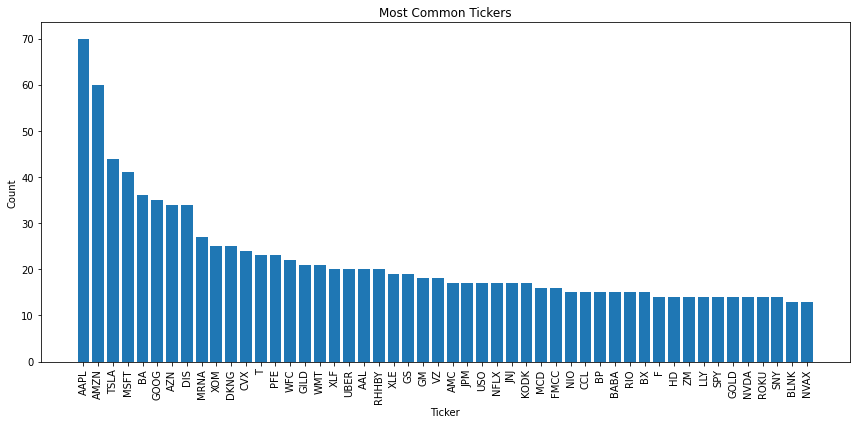

In [12]:
#How many different companies? 
unique_tickers=data['ticker'].unique() #get unique tickers (company names)
print("There are ", len(unique_tickers), " unique tickers.")
ticker_counts=data['ticker'].value_counts()
print("The most common tickers featured are: \n")
for ticker, count in ticker_counts.items(): 
    print(f"{ticker}: {count}")

#visualize
ticker_counts=data['ticker'].value_counts().head(50)
plt.figure(figsize=(12,6))
plt.bar(ticker_counts.index,ticker_counts.values)
plt.title('Most Common Tickers')
plt.xlabel('Ticker')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

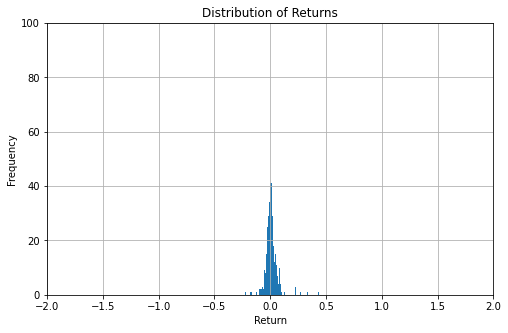

In [13]:
#Overall returns distribution
plt.figure(figsize=(8,5))
plt.hist(data['return'],bins=1000000)
plt.xlim(-2,2)
plt.ylim(0,100)
plt.title('Distribution of Returns')
plt.xlabel('Return')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()
#Seems to be centered around 0 (as expected, no bias involved)
#Doesn't seem to be many large outliers 

In [14]:
#double check for large outliers
print(data['return'].describe())
#maximum value is highly suspicious, investigate 
max_return=data['return'].max()
max_return_row=data[data['return']==max_return]

print("\nMaximum return value row: ", max_return_row) #clearly, this return is basically impossible, likely will need to remove it
#check for more outliers

outliers = data[abs(data['return']) > 5] #check for outliers representing more than %500 change
print(f"\nNumber of return outliers > 5 or < -5: {len(outliers)}")
print(outliers)

mean=data['return'].mean()
std=data['return'].std()
z_threshold=3 

outliers_z=data[(data['return']-mean).abs()>z_threshold*std] #check outliers using z-scores
print(f"\nNumber of outliers beyond {z_threshold} standard deviations: {len(outliers_z)}")
print(outliers_z)

print("\nLooks like the maximum value is WAY beyond the rest of the data, and all other return values are within -5 and 5, or within 3 standard deviations of the mean. Let's remove it.")
data=data[data['return'] != max_return] #remove this huge outlier
print("Max return after removal: ", data['return'].max())

count    10791.000000
mean         0.031748
std          2.948606
min         -0.581818
25%         -0.019647
50%          0.000000
75%          0.019758
max        306.142911
Name: return, dtype: float64

Maximum return value row:                                           Headlines ticker  \
7736   Banco de Sabadell, S.A. reports 1H results   BNDSF   

                     date      return  
7736  2020-07-31 07:35:00  306.142911  

Number of return outliers > 5 or < -5: 1
                                         Headlines ticker  \
7736   Banco de Sabadell, S.A. reports 1H results   BNDSF   

                     date      return  
7736  2020-07-31 07:35:00  306.142911  

Number of outliers beyond 3 standard deviations: 1
                                         Headlines ticker  \
7736   Banco de Sabadell, S.A. reports 1H results   BNDSF   

                     date      return  
7736  2020-07-31 07:35:00  306.142911  

Looks like the maximum value is WAY beyond the rest of the data

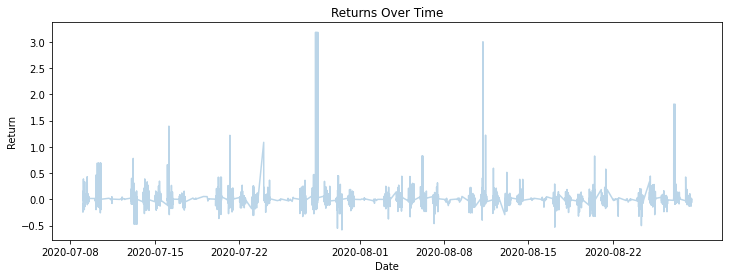

In [15]:
#return vs. date
data['date']=pd.to_datetime(data['date'])
data.sort_values('date',inplace=True)
plt.figure(figsize=(12, 4))
plt.plot(data['date'],data['return'],alpha=0.3)
plt.title('Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Return')
plt.show()

In [16]:
#what words are most common? 
def tokenize(text): #function to split text into lowercase word tokens
    return re.findall(r'\b\w+\b',text.lower())

all_words=data['Headlines'].dropna().apply(tokenize).sum() #flatten all tokens
word_counts=Counter(all_words)

#top 20 most common
common_words=word_counts.most_common(20)
print("The most common words are: ")
for word,count in common_words: 
    print(f"{word}: {count}")

The most common words are: 
on: 3081
beats: 2964
0: 2663
by: 2219
revenue: 2181
eps: 2008
to: 1445
in: 1298
misses: 1172
q2: 1146
s: 1046
dividend: 938
for: 928
results: 829
reports: 811
declares: 760
of: 745
after: 708
and: 576
as: 522


In [17]:
#label polarity: positive/negative/neutral -> in case we want to do binary classification
data['label']=data['return'].apply(lambda x: 1 if x>0 else 0)
data.head()

,Headlines,ticker,date,return,label
13956,Virgin Galactic and Upwork among industrial g...,DSS,2020-07-09 01:01:00,-0.088750,0
13955,"DNJR leads financial gainers, BYFC and BSBK a...",BTBT,2020-07-09 01:07:00,-0.243243,0
13953,NeuroMetrix announces expanded distribution o...,NURO,2020-07-09 01:10:00,-0.071111,0
13951,Comscore renews agreement for ondemand essent...,SCOR,2020-07-09 01:20:00,0.066434,1
13950,Notable earnings before Friday's open,GBX,2020-07-09 01:21:00,0.155157,1
